In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [14]:
from utilities.userfold_framework import *
# from utilities.EEG_func import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    
    saved_dir= "./EEG/saved_models/Userfold/run0"
#     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
    model= LSTMEncoder_EEGNet_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-LSTMEncoder_EEGNet-Baseline-e{EPOCH}.pt"
           )
    )

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-LSTMEncoder_EEGNet-Baseline-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6987398196669186


Iterations:   0%|                                   | 1/300 [00:01<07:21,  1.48s/it]

Epoch:  0
t_loss:  0.6987398196669186 , v_loss:  0.6922361056009928
t_acc:  0.5163398692810458 , v_acc:  0.6894409937888198
t_recall:  0.5054192229038854 , v_recall:  0.5
t_prec:  0.5046064016363799 , v_prec:  0.3447204968944099
t_f:  0.49039268631636024 , v_f:  0.4080882352941176
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.6369480397187027
Epoch  2 , loss 0.585919107876572


Iterations:   1%|▎                                  | 3/300 [00:03<06:18,  1.27s/it]

Epoch:  2
t_loss:  0.585919107876572 , v_loss:  0.6814241210619608
t_acc:  0.6439464674758792 , v_acc:  0.6894409937888198
t_recall:  0.5011055297072508 , v_recall:  0.5
t_prec:  0.5020114167565624 , v_prec:  0.3447204968944099
t_f:  0.4802911534154535 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.5419779811419693
Epoch  4 , loss 0.5180713995998981


Iterations:   2%|▌                                  | 5/300 [00:06<06:05,  1.24s/it]

Epoch:  4
t_loss:  0.5180713995998981 , v_loss:  0.6628052790959676
t_acc:  0.6878306878306878 , v_acc:  0.6894409937888198
t_recall:  0.501020436172987 , v_recall:  0.5
t_prec:  0.5099985655498875 , v_prec:  0.3447204968944099
t_f:  0.42865802211977616 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:29,  1.12s/it]

Epoch  5 , loss 0.49030667835590885
Epoch  6 , loss 0.47829706411735684


Iterations:   2%|▊                                  | 7/300 [00:08<05:57,  1.22s/it]

Epoch:  6
t_loss:  0.47829706411735684 , v_loss:  0.7005286614100138
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.4988814317673378 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3447204968944099
t_f:  0.40970053279441476 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:26,  1.12s/it]

Epoch  7 , loss 0.46832287194682104
Epoch  8 , loss 0.45755190066262785


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.45755190066262785 , v_loss:  0.7785693109035492
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:24,  1.12s/it]

Epoch  9 , loss 0.4610500697996102
Epoch  10 , loss 0.4567229619213179


Iterations:   4%|█▏                                | 11/300 [00:13<05:58,  1.24s/it]

Epoch:  10
t_loss:  0.4567229619213179 , v_loss:  0.8109204073747
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:26,  1.13s/it]

Epoch  11 , loss 0.45443935429348664
Epoch  12 , loss 0.4581195005014831


Iterations:   4%|█▍                                | 13/300 [00:15<05:54,  1.23s/it]

Epoch:  12
t_loss:  0.4581195005014831 , v_loss:  0.8261701365311941
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:25,  1.14s/it]

Epoch  13 , loss 0.45495448626723944
Epoch  14 , loss 0.4524112869711483


Iterations:   5%|█▋                                | 15/300 [00:17<05:49,  1.23s/it]

Epoch:  14
t_loss:  0.4524112869711483 , v_loss:  0.8241140643755595
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.451567118658739
Epoch  16 , loss 0.4539000584798701


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.4539000584798701 , v_loss:  0.8203681459029516
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<05:19,  1.13s/it]

Epoch  17 , loss 0.451278638605978
Epoch  18 , loss 0.4508971262211893


Iterations:   6%|██▏                               | 19/300 [00:22<05:41,  1.22s/it]

Epoch:  18
t_loss:  0.4508971262211893 , v_loss:  0.8243220299482346
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:13,  1.12s/it]

Epoch  19 , loss 0.45648563843147427
Epoch  20 , loss 0.4459631051502976


Iterations:   7%|██▍                               | 21/300 [00:24<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.4459631051502976 , v_loss:  0.8176864335934321
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:10,  1.12s/it]

Epoch  21 , loss 0.4480794697415595
Epoch  22 , loss 0.4476115288687687


Iterations:   8%|██▌                               | 23/300 [00:27<05:39,  1.22s/it]

Epoch:  22
t_loss:  0.4476115288687687 , v_loss:  0.8462206448117892
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:09,  1.12s/it]

Epoch  23 , loss 0.4434325163270913
Epoch  24 , loss 0.4449293923144247


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.4449293923144247 , v_loss:  0.830471895635128
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:07,  1.12s/it]

Epoch  25 , loss 0.44116290936283037
Epoch  26 , loss 0.4425469438234965


Iterations:   9%|███                               | 27/300 [00:31<05:35,  1.23s/it]

Epoch:  26
t_loss:  0.4425469438234965 , v_loss:  0.8319185202320417
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:12,  1.15s/it]

Epoch  27 , loss 0.4408968237100863
Epoch  28 , loss 0.4458411452816982


Iterations:  10%|███▎                              | 29/300 [00:34<05:42,  1.26s/it]

Epoch:  28
t_loss:  0.4458411452816982 , v_loss:  0.8314744432767233
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:15,  1.17s/it]

Epoch  29 , loss 0.43637049607202116
Epoch  30 , loss 0.4368988596925549


Iterations:  10%|███▌                              | 31/300 [00:36<05:37,  1.25s/it]

Epoch:  30
t_loss:  0.4368988596925549 , v_loss:  0.8391906196872393
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:05,  1.14s/it]

Epoch  31 , loss 0.4385668904173608
Epoch  32 , loss 0.4352707623266706


Iterations:  11%|███▋                              | 33/300 [00:39<05:26,  1.22s/it]

Epoch:  32
t_loss:  0.4352707623266706 , v_loss:  0.8396653085947037
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:57,  1.12s/it]

Epoch  33 , loss 0.4312053953900057
Epoch  34 , loss 0.43640976443010215


Iterations:  12%|███▉                              | 35/300 [00:41<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.43640976443010215 , v_loss:  0.8312391663591067
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:42<04:54,  1.11s/it]

Epoch  35 , loss 0.4331900103419435
Epoch  36 , loss 0.4320066033625135


Iterations:  12%|████▏                             | 37/300 [00:43<05:24,  1.23s/it]

Epoch:  36
t_loss:  0.4320066033625135 , v_loss:  0.806086540222168
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8481308411214954 , v_prec:  0.3447204968944099
t_f:  0.4135264235347638 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:56,  1.13s/it]

Epoch  37 , loss 0.43487851818402606
Epoch  38 , loss 0.42463025392270554


Iterations:  13%|████▍                             | 39/300 [00:46<05:22,  1.23s/it]

Epoch:  38
t_loss:  0.42463025392270554 , v_loss:  0.8051186998685201
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5025562372188139 , v_recall:  0.5
t_prec:  0.8483478802992519 , v_prec:  0.3447204968944099
t_f:  0.415705613844319 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:53,  1.13s/it]

Epoch  39 , loss 0.4293464445600323
Epoch  40 , loss 0.4284294580712038


Iterations:  14%|████▋                             | 41/300 [00:48<05:16,  1.22s/it]

Epoch:  40
t_loss:  0.4284294580712038 , v_loss:  0.8285166298349699
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5028437710160443 , v_recall:  0.5
t_prec:  0.7769806612601372 , v_prec:  0.3447204968944099
t_f:  0.41667765984343347 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:52,  1.13s/it]

Epoch  41 , loss 0.42208654740277457
Epoch  42 , loss 0.4326995310245776


Iterations:  14%|████▊                             | 43/300 [00:50<05:14,  1.22s/it]

Epoch:  42
t_loss:  0.4326995310245776 , v_loss:  0.8109725589553515
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5019489164299145 , v_recall:  0.5
t_prec:  0.6209471353131566 , v_prec:  0.3447204968944099
t_f:  0.416219391790475 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:52,  1.14s/it]

Epoch  43 , loss 0.426120763315874
Epoch  44 , loss 0.42604362029655307


Iterations:  15%|█████                             | 45/300 [00:53<05:12,  1.22s/it]

Epoch:  44
t_loss:  0.42604362029655307 , v_loss:  0.8027013416091601
t_acc:  0.7005913476501712 , v_acc:  0.6894409937888198
t_recall:  0.5087550266946652 , v_recall:  0.5
t_prec:  0.799671155652991 , v_prec:  0.3447204968944099
t_f:  0.4294214811347086 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:49,  1.14s/it]

Epoch  45 , loss 0.4236682413839826
Epoch  46 , loss 0.42618972530551985


Iterations:  16%|█████▎                            | 47/300 [00:55<05:10,  1.23s/it]

Epoch:  46
t_loss:  0.42618972530551985 , v_loss:  0.7934929728507996
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5060388959800167 , v_recall:  0.5
t_prec:  0.7175131002208087 , v_prec:  0.3447204968944099
t_f:  0.4247991718755456 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:43,  1.12s/it]

Epoch  47 , loss 0.42610475830003325
Epoch  48 , loss 0.42218605852594565


Iterations:  16%|█████▌                            | 49/300 [00:57<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.42218605852594565 , v_loss:  0.810650184750557
t_acc:  0.7002801120448179 , v_acc:  0.6894409937888198
t_recall:  0.5091063806425934 , v_recall:  0.5
t_prec:  0.7497490589711417 , v_prec:  0.3447204968944099
t_f:  0.43115168600780723 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:38,  1.12s/it]

Epoch  49 , loss 0.42159391092319115
Epoch  50 , loss 0.42129257321357727


Iterations:  17%|█████▊                            | 51/300 [01:00<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.42129257321357727 , v_loss:  0.8015278875827789
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5077325318071396 , v_recall:  0.5
t_prec:  0.7938967136150235 , v_prec:  0.3447204968944099
t_f:  0.42729814284763357 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:35,  1.11s/it]

Epoch  51 , loss 0.4193263690845639
Epoch  52 , loss 0.42462845117438075


Iterations:  18%|██████                            | 53/300 [01:02<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.42462845117438075 , v_loss:  0.8286380519469579
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5066139635744774 , v_recall:  0.5
t_prec:  0.6970423878969606 , v_prec:  0.3447204968944099
t_f:  0.4266752602236473 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:39,  1.14s/it]

Epoch  53 , loss 0.4255653859353533
Epoch  54 , loss 0.42186642628090054


Iterations:  18%|██████▏                           | 55/300 [01:05<05:05,  1.25s/it]

Epoch:  54
t_loss:  0.42186642628090054 , v_loss:  0.8236726075410843
t_acc:  0.7002801120448179 , v_acc:  0.6894409937888198
t_recall:  0.5096814482370541 , v_recall:  0.5
t_prec:  0.7291847166868827 , v_prec:  0.3447204968944099
t_f:  0.43299303839720954 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:39,  1.15s/it]

Epoch  55 , loss 0.41195402513532076
Epoch  56 , loss 0.4209158157601076


Iterations:  19%|██████▍                           | 57/300 [01:07<05:02,  1.24s/it]

Epoch:  56
t_loss:  0.4209158157601076 , v_loss:  0.8261770258347193
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.5111513704176446 , v_recall:  0.5
t_prec:  0.7639815456593311 , v_prec:  0.3447204968944099
t_f:  0.4353482075004403 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:34,  1.13s/it]

Epoch  57 , loss 0.41399240143158855
Epoch  58 , loss 0.4169417421023051


Iterations:  20%|██████▋                           | 59/300 [01:09<04:53,  1.22s/it]

Epoch:  58
t_loss:  0.4169417421023051 , v_loss:  0.8398324251174927
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.512301505606566 , v_recall:  0.5
t_prec:  0.7288191844237184 , v_prec:  0.3447204968944099
t_f:  0.4389704242316099 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:28,  1.12s/it]

Epoch  59 , loss 0.4160987623766357
Epoch  60 , loss 0.41335297156782713


Iterations:  20%|██████▉                           | 61/300 [01:12<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.41335297156782713 , v_loss:  0.8244899387160937
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.5137391745927177 , v_recall:  0.5
t_prec:  0.7018218841144608 , v_prec:  0.3447204968944099
t_f:  0.44341526636892 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:23,  1.11s/it]

Epoch  61 , loss 0.4126598694745232
Epoch  62 , loss 0.4156956374645233


Iterations:  21%|███████▏                          | 63/300 [01:14<04:47,  1.21s/it]

Epoch:  62
t_loss:  0.4156956374645233 , v_loss:  0.8454337591926256
t_acc:  0.7015250544662309 , v_acc:  0.6894409937888198
t_recall:  0.5125890394037963 , v_recall:  0.5
t_prec:  0.7222989675730697 , v_prec:  0.3447204968944099
t_f:  0.43986669218951696 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:22,  1.11s/it]

Epoch  63 , loss 0.41656211544485655
Epoch  64 , loss 0.41331565438532364


Iterations:  22%|███████▎                          | 65/300 [01:16<04:47,  1.22s/it]

Epoch:  64
t_loss:  0.41331565438532364 , v_loss:  0.8225018680095673
t_acc:  0.7012138188608776 , v_acc:  0.6894409937888198
t_recall:  0.5126528595544941 , v_recall:  0.5
t_prec:  0.7076631977294229 , v_prec:  0.3447204968944099
t_f:  0.4406215316315205 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.4099427858988444
Epoch  66 , loss 0.4155467403870003


Iterations:  22%|███████▌                          | 67/300 [01:19<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.4155467403870003 , v_loss:  0.8428047075867653
t_acc:  0.7049486461251168 , v_acc:  0.6894409937888198
t_recall:  0.5176376936907262 , v_recall:  0.5
t_prec:  0.7646380472536072 , v_prec:  0.3447204968944099
t_f:  0.4493640954738985 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:21,  1.13s/it]

Epoch  67 , loss 0.4112069431473227
Epoch  68 , loss 0.4155439582525515


Iterations:  23%|███████▊                          | 69/300 [01:21<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.4155439582525515 , v_loss:  0.8346199542284012
t_acc:  0.7037037037037037 , v_acc:  0.6832298136645962
t_recall:  0.5167428391045964 , v_recall:  0.4954954954954955
t_prec:  0.731406892190958 , v_prec:  0.34375
t_f:  0.4487841728381891 , v_f:  0.40590405904059035
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:22,  1.14s/it]

Epoch  69 , loss 0.4163263150874306
Epoch  70 , loss 0.40724485966504786


Iterations:  24%|████████                          | 71/300 [01:23<04:40,  1.22s/it]

Epoch:  70
t_loss:  0.40724485966504786 , v_loss:  0.8519197106361389
t_acc:  0.7043261749144102 , v_acc:  0.6894409937888198
t_recall:  0.5171902663976613 , v_recall:  0.5
t_prec:  0.7473341232227488 , v_prec:  0.3447204968944099
t_f:  0.44907407407407407 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:20,  1.14s/it]

Epoch  71 , loss 0.4066368271322811
Epoch  72 , loss 0.4149523172892776


Iterations:  24%|████████▎                         | 73/300 [01:26<04:38,  1.23s/it]

Epoch:  72
t_loss:  0.4149523172892776 , v_loss:  0.8600991815328598
t_acc:  0.7061935885465297 , v_acc:  0.6832298136645962
t_recall:  0.5196826834657773 , v_recall:  0.4954954954954955
t_prec:  0.7720392032880177 , v_prec:  0.34375
t_f:  0.4534162386126581 , v_f:  0.40590405904059035
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:16,  1.13s/it]

Epoch  73 , loss 0.4109446342084922
Epoch  74 , loss 0.40629760716475694


Iterations:  25%|████████▌                         | 75/300 [01:28<04:36,  1.23s/it]

Epoch:  74
t_loss:  0.40629760716475694 , v_loss:  0.852002980808417
t_acc:  0.7074385309679427 , v_acc:  0.6832298136645962
t_recall:  0.5234528760242105 , v_recall:  0.4954954954954955
t_prec:  0.7468151486263974 , v_prec:  0.34375
t_f:  0.46248029831238224 , v_f:  0.40590405904059035
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:13,  1.13s/it]

Epoch  75 , loss 0.4109849731127421
Epoch  76 , loss 0.40683329748172387


Iterations:  26%|████████▋                         | 77/300 [01:30<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.40683329748172387 , v_loss:  0.8430492132902145
t_acc:  0.7099284158107687 , v_acc:  0.6832298136645962
t_recall:  0.5275428555743128 , v_recall:  0.4954954954954955
t_prec:  0.7591804930129238 , v_prec:  0.34375
t_f:  0.47032041331237145 , v_f:  0.40590405904059035
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:08,  1.12s/it]

Epoch  77 , loss 0.40914975544985605
Epoch  78 , loss 0.4025324501243292


Iterations:  26%|████████▉                         | 79/300 [01:33<04:26,  1.21s/it]

Epoch:  78
t_loss:  0.4025324501243292 , v_loss:  0.8578821097811064
t_acc:  0.7074385309679427 , v_acc:  0.6894409937888198
t_recall:  0.5228778084297498 , v_recall:  0.5054954954954954
t_prec:  0.7559709667181949 , v_prec:  0.5959119496855345
t_f:  0.46081364791910656 , v_f:  0.4266381766381766
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:04,  1.11s/it]

Epoch  79 , loss 0.4045373814947465
Epoch  80 , loss 0.4029931420204686


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.4029931420204686 , v_loss:  0.8703394557038943
t_acc:  0.7093059446000622 , v_acc:  0.6894409937888198
t_recall:  0.5265203606867872 , v_recall:  0.5054954954954954
t_prec:  0.7563276026743075 , v_prec:  0.5959119496855345
t_f:  0.4683705357142857 , v_f:  0.4266381766381766
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:10,  1.15s/it]

Epoch  81 , loss 0.4018874764442444
Epoch  82 , loss 0.4010906377259423


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:32,  1.26s/it]

Epoch:  82
t_loss:  0.4010906377259423 , v_loss:  0.8651096050937971
t_acc:  0.7061935885465297 , v_acc:  0.6894409937888198
t_recall:  0.5234206228297718 , v_recall:  0.5054954954954954
t_prec:  0.7147270271630624 , v_prec:  0.5959119496855345
t_f:  0.4643191698892706 , v_f:  0.4266381766381766
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:10,  1.16s/it]

Epoch  83 , loss 0.4041402538617452
Epoch  84 , loss 0.40021466449195264


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:28,  1.25s/it]

Epoch:  84
t_loss:  0.40021466449195264 , v_loss:  0.8754819656411806
t_acc:  0.708994708994709 , v_acc:  0.6894409937888198
t_recall:  0.5271592484319457 , v_recall:  0.5054954954954954
t_prec:  0.7397772895074843 , v_prec:  0.5959119496855345
t_f:  0.47063655841296426 , v_f:  0.4266381766381766
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:04,  1.14s/it]

Epoch  85 , loss 0.39535850344919693
Epoch  86 , loss 0.3937807673332738


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.3937807673332738 , v_loss:  0.908759040137132
t_acc:  0.712729536258948 , v_acc:  0.6894409937888198
t_recall:  0.5327191501626385 , v_recall:  0.5054954954954954
t_prec:  0.76297240055596 , v_prec:  0.5959119496855345
t_f:  0.480581980973699 , v_f:  0.4266381766381766
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:57,  1.12s/it]

Epoch  87 , loss 0.4033964363967671
Epoch  88 , loss 0.3997591529406753


Iterations:  30%|██████████                        | 89/300 [01:45<04:15,  1.21s/it]

Epoch:  88
t_loss:  0.3997591529406753 , v_loss:  0.8888956606388092
t_acc:  0.7124183006535948 , v_acc:  0.6894409937888198
t_recall:  0.533358037907797 , v_recall:  0.5054954954954954
t_prec:  0.7486987782499847 , v_prec:  0.5959119496855345
t_f:  0.48273922691362015 , v_f:  0.4266381766381766
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:54,  1.12s/it]

Epoch  89 , loss 0.39896541600133856
Epoch  90 , loss 0.39562497127289864


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:14,  1.22s/it]

Epoch:  90
t_loss:  0.39562497127289864 , v_loss:  0.8697095712025961
t_acc:  0.7124183006535948 , v_acc:  0.6894409937888198
t_recall:  0.532495436516106 , v_recall:  0.5054954954954954
t_prec:  0.7582890909090909 , v_prec:  0.5959119496855345
t_f:  0.48041009772899107 , v_f:  0.4266381766381766
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:52,  1.12s/it]

Epoch  91 , loss 0.3967531837669073
Epoch  92 , loss 0.3962832706816056


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:16,  1.24s/it]

Epoch:  92
t_loss:  0.3962832706816056 , v_loss:  0.8935370321075121
t_acc:  0.7093059446000622 , v_acc:  0.6894409937888198
t_recall:  0.52882063106463 , v_recall:  0.5054954954954954
t_prec:  0.72908 , v_prec:  0.5959119496855345
t_f:  0.47478683038839575 , v_f:  0.4266381766381766
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:53,  1.13s/it]

Epoch  93 , loss 0.39828990721235086
Epoch  94 , loss 0.40001417608822093


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:12,  1.23s/it]

Epoch:  94
t_loss:  0.40001417608822093 , v_loss:  0.9090200786789259
t_acc:  0.7186430127606598 , v_acc:  0.6894409937888198
t_recall:  0.5427203853913616 , v_recall:  0.5054954954954954
t_prec:  0.778462157809984 , v_prec:  0.5959119496855345
t_f:  0.4991495437333168 , v_f:  0.4266381766381766
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:50,  1.13s/it]

Epoch  95 , loss 0.38904670348354414
Epoch  96 , loss 0.39241476444637075


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:08,  1.22s/it]

Epoch:  96
t_loss:  0.39241476444637075 , v_loss:  0.9569006264209747
t_acc:  0.7245564892623716 , v_acc:  0.6894409937888198
t_recall:  0.5527216206200848 , v_recall:  0.5054954954954954
t_prec:  0.7896683558049045 , v_prec:  0.5959119496855345
t_f:  0.5170786733248043 , v_f:  0.4266381766381766
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:48,  1.13s/it]

Epoch  97 , loss 0.3888937451091467
Epoch  98 , loss 0.3872961343503466


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:05,  1.22s/it]

Epoch:  98
t_loss:  0.3872961343503466 , v_loss:  0.9402461921175321
t_acc:  0.7177093059446 , v_acc:  0.6894409937888198
t_recall:  0.5437744472351463 , v_recall:  0.5054954954954954
t_prec:  0.7517523087852238 , v_prec:  0.5959119496855345
t_f:  0.5029374064550792 , v_f:  0.4266381766381766
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:49,  1.15s/it]

Epoch  99 , loss 0.3872406792406942
Epoch  100 , loss 0.39342106498923957


Iterations:  34%|███████████                      | 101/300 [01:59<04:06,  1.24s/it]

Epoch:  100
t_loss:  0.39342106498923957 , v_loss:  0.9473871837059656
t_acc:  0.7195767195767195 , v_acc:  0.6894409937888198
t_recall:  0.5456917967088017 , v_recall:  0.5054954954954954
t_prec:  0.7669499000352817 , v_prec:  0.5959119496855345
t_f:  0.5055127167332865 , v_f:  0.4266381766381766
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:46,  1.14s/it]

Epoch  101 , loss 0.3802228342084324
Epoch  102 , loss 0.3815290571427813


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.3815290571427813 , v_loss:  0.9842040886481603
t_acc:  0.7226890756302521 , v_acc:  0.6894409937888198
t_recall:  0.5510918049436598 , v_recall:  0.5054954954954954
t_prec:  0.7726247436773752 , v_prec:  0.5959119496855345
t_f:  0.5151905218743887 , v_f:  0.4266381766381766
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:41,  1.13s/it]

Epoch  103 , loss 0.39102083912082747
Epoch  104 , loss 0.3848281222231248


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:57,  1.22s/it]

Epoch:  104
t_loss:  0.3848281222231248 , v_loss:  0.9681390523910522
t_acc:  0.7251789604730782 , v_acc:  0.6894409937888198
t_recall:  0.5543191831020711 , v_recall:  0.5054954954954954
t_prec:  0.7857374918778428 , v_prec:  0.5959119496855345
t_f:  0.5202262872484366 , v_f:  0.4266381766381766
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:37,  1.12s/it]

Epoch  105 , loss 0.3857301374276479
Epoch  106 , loss 0.38355052704904596


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:53,  1.21s/it]

Epoch:  106
t_loss:  0.38355052704904596 , v_loss:  0.9274356613556544
t_acc:  0.721444133208839 , v_acc:  0.6894409937888198
t_recall:  0.5516346193436817 , v_recall:  0.5054954954954954
t_prec:  0.75041934582052 , v_prec:  0.5959119496855345
t_f:  0.5178041878890776 , v_f:  0.4266381766381766
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:34,  1.12s/it]

Epoch  107 , loss 0.38244978645268607
Epoch  108 , loss 0.3782571516200608


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.3782571516200608 , v_loss:  0.9354274372259775
t_acc:  0.7276688453159041 , v_acc:  0.6894409937888198
t_recall:  0.5604218992327857 , v_recall:  0.5054954954954954
t_prec:  0.775269283356121 , v_prec:  0.5959119496855345
t_f:  0.531849862246338 , v_f:  0.4266381766381766
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:36,  1.14s/it]

Epoch  109 , loss 0.3830220074045892
Epoch  110 , loss 0.3832617127427868


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:56,  1.25s/it]

Epoch:  110
t_loss:  0.3832617127427868 , v_loss:  0.955669159690539
t_acc:  0.7326486150015562 , v_acc:  0.6894409937888198
t_recall:  0.5686018583329902 , v_recall:  0.5054954954954954
t_prec:  0.7851232126559173 , v_prec:  0.5959119496855345
t_f:  0.5454244197298043 , v_f:  0.4266381766381766
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:38,  1.16s/it]

Epoch  111 , loss 0.3770453284184138
Epoch  112 , loss 0.3766868061879102


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:54,  1.25s/it]

Epoch:  112
t_loss:  0.3766868061879102 , v_loss:  0.9757399236162504
t_acc:  0.7314036725801432 , v_acc:  0.6894409937888198
t_recall:  0.5662693347607087 , v_recall:  0.5054954954954954
t_prec:  0.7847623859306994 , v_prec:  0.5959119496855345
t_f:  0.5414360949568735 , v_f:  0.4266381766381766
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:34,  1.15s/it]

Epoch  113 , loss 0.37247743501382713
Epoch  114 , loss 0.37095262723810535


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:50,  1.24s/it]

Epoch:  114
t_loss:  0.37095262723810535 , v_loss:  1.00718392431736
t_acc:  0.7314036725801432 , v_acc:  0.6894409937888198
t_recall:  0.5668444023551694 , v_recall:  0.5054954954954954
t_prec:  0.7808834215716807 , v_prec:  0.5959119496855345
t_f:  0.5426861036935002 , v_f:  0.4266381766381766
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:28,  1.13s/it]

Epoch  115 , loss 0.383297090436898
Epoch  116 , loss 0.37050990322056937


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:44,  1.23s/it]

Epoch:  116
t_loss:  0.37050990322056937 , v_loss:  0.9974769478042921
t_acc:  0.7332710862122627 , v_acc:  0.6894409937888198
t_recall:  0.5693368194232854 , v_recall:  0.5054954954954954
t_prec:  0.7881778597505325 , v_prec:  0.5959119496855345
t_f:  0.5464828029201889 , v_f:  0.4266381766381766
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:24,  1.12s/it]

Epoch  117 , loss 0.37591608336158827
Epoch  118 , loss 0.37023673104304894


Iterations:  40%|█████████████                    | 119/300 [02:20<03:39,  1.21s/it]

Epoch:  118
t_loss:  0.37023673104304894 , v_loss:  0.9936827222506205
t_acc:  0.7394957983193278 , v_acc:  0.6894409937888198
t_recall:  0.5807119034874624 , v_recall:  0.5054954954954954
t_prec:  0.7914089909020634 , v_prec:  0.5959119496855345
t_f:  0.5652783051602006 , v_f:  0.4266381766381766
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:20,  1.12s/it]

Epoch  119 , loss 0.36772141152737187
Epoch  120 , loss 0.3706507244530846


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.3706507244530846 , v_loss:  1.027883492410183
t_acc:  0.7351384998443822 , v_acc:  0.6894409937888198
t_recall:  0.5752796420581655 , v_recall:  0.5054954954954954
t_prec:  0.7743453498414434 , v_prec:  0.5959119496855345
t_f:  0.5574246209133495 , v_f:  0.4266381766381766
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:19,  1.12s/it]

Epoch  121 , loss 0.3720821010715821
Epoch  122 , loss 0.36710406284706265


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:39,  1.24s/it]

Epoch:  122
t_loss:  0.36710406284706265 , v_loss:  1.0777976562579472
t_acc:  0.741051976346094 , v_acc:  0.6894409937888198
t_recall:  0.5872936138675011 , v_recall:  0.5054954954954954
t_prec:  0.7737237586180185 , v_prec:  0.5959119496855345
t_f:  0.5769804828584124 , v_f:  0.4266381766381766
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:19,  1.13s/it]

Epoch  123 , loss 0.36689090611887915
Epoch  124 , loss 0.3651525451272142


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:36,  1.24s/it]

Epoch:  124
t_loss:  0.3651525451272142 , v_loss:  1.0354135284821193
t_acc:  0.744786803610333 , v_acc:  0.6894409937888198
t_recall:  0.5917033804092724 , v_recall:  0.5054954954954954
t_prec:  0.7875513207839492 , v_prec:  0.5959119496855345
t_f:  0.5830817258941083 , v_f:  0.4266381766381766
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:16,  1.13s/it]

Epoch  125 , loss 0.3649643227165821
Epoch  126 , loss 0.36203689873218536


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.36203689873218536 , v_loss:  1.0554992084701855
t_acc:  0.7463429816370993 , v_acc:  0.6894409937888198
t_recall:  0.5919593472502436 , v_recall:  0.5054954954954954
t_prec:  0.8014645229989351 , v_prec:  0.5959119496855345
t_f:  0.5827089865303635 , v_f:  0.4266381766381766
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:15,  1.13s/it]

Epoch  127 , loss 0.36216452396383475
Epoch  128 , loss 0.3603566721373913


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:29,  1.22s/it]

Epoch:  128
t_loss:  0.3603566721373913 , v_loss:  1.0550930549701054
t_acc:  0.7494553376906318 , v_acc:  0.6894409937888198
t_recall:  0.5987970244712535 , v_recall:  0.5054954954954954
t_prec:  0.7969820947246824 , v_prec:  0.5959119496855345
t_f:  0.5935320351850597 , v_f:  0.4266381766381766
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:13,  1.14s/it]

Epoch  129 , loss 0.36445364619002624
Epoch  130 , loss 0.3616089029055016


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.3616089029055016 , v_loss:  1.039322167634964
t_acc:  0.7507002801120448 , v_acc:  0.6894409937888198
t_recall:  0.6005544804490742 , v_recall:  0.5054954954954954
t_prec:  0.8000196559659951 , v_prec:  0.5959119496855345
t_f:  0.5960568022633009 , v_f:  0.4266381766381766
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:10,  1.14s/it]

Epoch  131 , loss 0.3628157517489265
Epoch  132 , loss 0.35557377104665716


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.35557377104665716 , v_loss:  1.0742221375306447
t_acc:  0.7553688141923436 , v_acc:  0.6894409937888198
t_recall:  0.6085107259027462 , v_recall:  0.5054954954954954
t_prec:  0.8046564320725054 , v_prec:  0.5959119496855345
t_f:  0.607764694041868 , v_f:  0.4266381766381766
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:06,  1.13s/it]

Epoch  133 , loss 0.35828325035525305
Epoch  134 , loss 0.3470204639084199


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.3470204639084199 , v_loss:  1.0422707721590996
t_acc:  0.7575474634298164 , v_acc:  0.6894409937888198
t_recall:  0.6135271269952375 , v_recall:  0.5054954954954954
t_prec:  0.8011936030450593 , v_prec:  0.5959119496855345
t_f:  0.615245248724377 , v_f:  0.4266381766381766
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:04,  1.13s/it]

Epoch  135 , loss 0.34873274319312153
Epoch  136 , loss 0.3482532489533518


Iterations:  46%|███████████████                  | 137/300 [02:41<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.3482532489533518 , v_loss:  1.1101668973763783
t_acc:  0.7547463429816371 , v_acc:  0.6894409937888198
t_recall:  0.6115137041764456 , v_recall:  0.5054954954954954
t_prec:  0.7875529392334282 , v_prec:  0.5959119496855345
t_f:  0.6128882517494493 , v_f:  0.4266381766381766
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:01,  1.12s/it]

Epoch  137 , loss 0.35207749786330206
Epoch  138 , loss 0.3447557196897619


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:19,  1.24s/it]

Epoch:  138
t_loss:  0.3447557196897619 , v_loss:  1.0689106037219365
t_acc:  0.7591036414565826 , v_acc:  0.6894409937888198
t_recall:  0.6152207628223604 , v_recall:  0.5054954954954954
t_prec:  0.8066740538697579 , v_prec:  0.5959119496855345
t_f:  0.6174849384988704 , v_f:  0.4266381766381766
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:05,  1.16s/it]

Epoch  139 , loss 0.3410941385755352
Epoch  140 , loss 0.34276097925270305


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:21,  1.26s/it]

Epoch:  140
t_loss:  0.34276097925270305 , v_loss:  1.112653950850169
t_acc:  0.7659508247743542 , v_acc:  0.6894409937888198
t_recall:  0.6322188825297484 , v_recall:  0.5054954954954954
t_prec:  0.7943408678435901 , v_prec:  0.5959119496855345
t_f:  0.6415126589039633 , v_f:  0.4266381766381766
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<03:04,  1.17s/it]

Epoch  141 , loss 0.34448017559799493
Epoch  142 , loss 0.34878664040098


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:17,  1.26s/it]

Epoch:  142
t_loss:  0.34878664040098 , v_loss:  1.0844569131731987
t_acc:  0.7615935262994087 , v_acc:  0.6894409937888198
t_recall:  0.6207484113586144 , v_recall:  0.5054954954954954
t_prec:  0.8038386268663589 , v_prec:  0.5959119496855345
t_f:  0.6254743281492529 , v_f:  0.4266381766381766
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:59,  1.15s/it]

Epoch  143 , loss 0.34943946261031955
Epoch  144 , loss 0.3463379384255877


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:11,  1.24s/it]

Epoch:  144
t_loss:  0.3463379384255877 , v_loss:  1.0868388091524441
t_acc:  0.7675070028011205 , v_acc:  0.6894409937888198
t_recall:  0.6307496465873375 , v_recall:  0.5054954954954954
t_prec:  0.8095762934013297 , v_prec:  0.5959119496855345
t_f:  0.639206543648803 , v_f:  0.4266381766381766
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:53,  1.13s/it]

Epoch  145 , loss 0.3384091629117143
Epoch  146 , loss 0.34352869058356567


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.34352869058356567 , v_loss:  1.1118193566799164
t_acc:  0.7668845315904139 , v_acc:  0.6894409937888198
t_recall:  0.6308772868887333 , v_recall:  0.5054954954954954
t_prec:  0.8047895802258683 , v_prec:  0.5959119496855345
t_f:  0.639484640993494 , v_f:  0.4266381766381766
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:50,  1.12s/it]

Epoch  147 , loss 0.3426625141326119
Epoch  148 , loss 0.3368474028858484


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:04,  1.22s/it]

Epoch:  148
t_loss:  0.3368474028858484 , v_loss:  1.078614021341006
t_acc:  0.7662620603797075 , v_acc:  0.6894409937888198
t_recall:  0.6312924609873595 , v_recall:  0.5054954954954954
t_prec:  0.7992398648648649 , v_prec:  0.5959119496855345
t_f:  0.6401658871135508 , v_f:  0.4266381766381766
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:48,  1.12s/it]

Epoch  149 , loss 0.33628571413311303
Epoch  150 , loss 0.3331826942808488


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:04,  1.24s/it]

Epoch:  150
t_loss:  0.3331826942808488 , v_loss:  1.0663370763262112
t_acc:  0.7696856520385932 , v_acc:  0.6894409937888198
t_recall:  0.6374912504632108 , v_recall:  0.5054954954954954
t_prec:  0.8014307636757537 , v_prec:  0.5959119496855345
t_f:  0.6484162895927602 , v_f:  0.4266381766381766
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:48,  1.14s/it]

Epoch  151 , loss 0.33186567823092145
Epoch  152 , loss 0.33157112054965077


Iterations:  51%|████████████████▊                | 153/300 [03:00<03:02,  1.24s/it]

Epoch:  152
t_loss:  0.33157112054965077 , v_loss:  1.0988763893644016
t_acc:  0.7759103641456583 , v_acc:  0.6956521739130435
t_recall:  0.647428665541236 , v_recall:  0.5154954954954954
t_prec:  0.8092642816424536 , v_prec:  0.6814345991561181
t_f:  0.6613046044864227 , v_f:  0.44665778214210566
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:45,  1.14s/it]

Epoch  153 , loss 0.33571022106151954
Epoch  154 , loss 0.3286074408713509


Iterations:  52%|█████████████████                | 155/300 [03:03<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.3286074408713509 , v_loss:  1.1062020460764568
t_acc:  0.7787114845938375 , v_acc:  0.6956521739130435
t_recall:  0.6511672911434101 , v_recall:  0.5154954954954954
t_prec:  0.8148605536688278 , v_prec:  0.6814345991561181
t_f:  0.6660860848482616 , v_f:  0.44665778214210566
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:43,  1.14s/it]

Epoch  155 , loss 0.3259695987491047
Epoch  156 , loss 0.3280118835322997


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.3280118835322997 , v_loss:  1.18221315741539
t_acc:  0.7765328353563647 , v_acc:  0.6894409937888198
t_recall:  0.6507514308066044 , v_recall:  0.5054954954954954
t_prec:  0.803328804347826 , v_prec:  0.5959119496855345
t_f:  0.6655244587343675 , v_f:  0.4266381766381766
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:42,  1.15s/it]

Epoch  157 , loss 0.32046448746148276
Epoch  158 , loss 0.31626948772692215


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:52,  1.23s/it]

Epoch:  158
t_loss:  0.31626948772692215 , v_loss:  1.222345121204853
t_acc:  0.7821350762527233 , v_acc:  0.6894409937888198
t_recall:  0.6585162158081828 , v_recall:  0.5054954954954954
t_prec:  0.8133292398845394 , v_prec:  0.5959119496855345
t_f:  0.6753008639009517 , v_f:  0.4266381766381766
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:38,  1.13s/it]

Epoch  159 , loss 0.32013728776398825
Epoch  160 , loss 0.32263512091309415


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:49,  1.22s/it]

Epoch:  160
t_loss:  0.32263512091309415 , v_loss:  1.118588425219059
t_acc:  0.7871148459383753 , v_acc:  0.6956521739130435
t_recall:  0.6687089114889996 , v_recall:  0.520990990990991
t_prec:  0.8130993155046433 , v_prec:  0.6493589743589743
t_f:  0.6876681257461201 , v_f:  0.4627851549199864
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:11<02:34,  1.12s/it]

Epoch  161 , loss 0.31907836391645317
Epoch  162 , loss 0.3114033437827054


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.3114033437827054 , v_loss:  1.1447383761405945
t_acc:  0.7976968565203859 , v_acc:  0.7018633540372671
t_recall:  0.6826409190101701 , v_recall:  0.5254954954954955
t_prec:  0.832299532542251 , v_prec:  0.7253184713375795
t_f:  0.7047108826224168 , v_f:  0.4660033167495854
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:33,  1.13s/it]

Epoch  163 , loss 0.3182704407794803
Epoch  164 , loss 0.31848130623499554


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.31848130623499554 , v_loss:  1.1724053819974263
t_acc:  0.7877373171490819 , v_acc:  0.6956521739130435
t_recall:  0.6711690753626769 , v_recall:  0.5154954954954954
t_prec:  0.8102154406899673 , v_prec:  0.6814345991561181
t_f:  0.6904890103743513 , v_f:  0.44665778214210566
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:29,  1.12s/it]

Epoch  165 , loss 0.30755000167033253
Epoch  166 , loss 0.30680446969527825


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.30680446969527825 , v_loss:  1.163065788646539
t_acc:  0.7948957360722066 , v_acc:  0.6956521739130435
t_recall:  0.6800524285969174 , v_recall:  0.5154954954954954
t_prec:  0.8244251149110717 , v_prec:  0.6814345991561181
t_f:  0.7013824709314419 , v_f:  0.44665778214210566
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:31,  1.15s/it]

Epoch  167 , loss 0.3200538453518176
Epoch  168 , loss 0.31516001300484525


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:42,  1.24s/it]

Epoch:  168
t_loss:  0.31516001300484525 , v_loss:  1.1297998602191608
t_acc:  0.7905384375972612 , v_acc:  0.6894409937888198
t_recall:  0.6743326333703902 , v_recall:  0.510990990990991
t_prec:  0.8165646235898117 , v_prec:  0.5971337579617835
t_f:  0.6944179509663779 , v_f:  0.4437534549474848
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:29,  1.15s/it]

Epoch  169 , loss 0.31930698600469853
Epoch  170 , loss 0.3107395175040937


Iterations:  57%|██████████████████▊              | 171/300 [03:22<02:40,  1.25s/it]

Epoch:  170
t_loss:  0.3107395175040937 , v_loss:  1.1274323984980583
t_acc:  0.7967631497043262 , v_acc:  0.6894409937888198
t_recall:  0.6825448456650334 , v_recall:  0.510990990990991
t_prec:  0.827653627156167 , v_prec:  0.5971337579617835
t_f:  0.7044009561899379 , v_f:  0.4437534549474848
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:25,  1.14s/it]

Epoch  171 , loss 0.3036762975594577
Epoch  172 , loss 0.30397122163398593


Iterations:  58%|███████████████████              | 173/300 [03:24<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.30397122163398593 , v_loss:  1.124960372845332
t_acc:  0.7955182072829131 , v_acc:  0.6956521739130435
t_recall:  0.6787746531066002 , v_recall:  0.520990990990991
t_prec:  0.8311141615191032 , v_prec:  0.6493589743589743
t_f:  0.7001514909393078 , v_f:  0.4627851549199864
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:25<02:22,  1.13s/it]

Epoch  173 , loss 0.3125041641441046
Epoch  174 , loss 0.31342386147555185


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:31,  1.22s/it]

Epoch:  174
t_loss:  0.31342386147555185 , v_loss:  1.15518735597531
t_acc:  0.7976968565203859 , v_acc:  0.6956521739130435
t_recall:  0.6860913245769342 , v_recall:  0.520990990990991
t_prec:  0.8235496248783002 , v_prec:  0.6493589743589743
t_f:  0.708257060669456 , v_f:  0.4627851549199864
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:18,  1.12s/it]

Epoch  175 , loss 0.30437826321405526
Epoch  176 , loss 0.3006974934947257


Iterations:  59%|███████████████████▍             | 177/300 [03:29<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.3006974934947257 , v_loss:  1.1452683210372925
t_acc:  0.800186741363212 , v_acc:  0.6956521739130435
t_recall:  0.688168567546424 , v_recall:  0.520990990990991
t_prec:  0.8308034744842563 , v_prec:  0.6493589743589743
t_f:  0.710984393757503 , v_f:  0.4627851549199864
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:15,  1.11s/it]

Epoch  177 , loss 0.30999549346811633
Epoch  178 , loss 0.30634048522687424


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:29,  1.23s/it]

Epoch:  178
t_loss:  0.30634048522687424 , v_loss:  1.1792577132582664
t_acc:  0.806411453470277 , v_acc:  0.6956521739130435
t_recall:  0.6992561178133707 , v_recall:  0.520990990990991
t_prec:  0.8343076360979174 , v_prec:  0.6493589743589743
t_f:  0.7235570086570074 , v_f:  0.4627851549199864
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:15,  1.13s/it]

Epoch  179 , loss 0.30042194852641985
Epoch  180 , loss 0.29783061059082255


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:25,  1.23s/it]

Epoch:  180
t_loss:  0.29783061059082255 , v_loss:  1.2003690352042515
t_acc:  0.8023653906006847 , v_acc:  0.6956521739130435
t_recall:  0.6960603066112186 , v_recall:  0.520990990990991
t_prec:  0.8228131718141978 , v_prec:  0.6493589743589743
t_f:  0.719277256801 , v_f:  0.4627851549199864
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:12,  1.13s/it]

Epoch  181 , loss 0.3025793704916449
Epoch  182 , loss 0.2878354527786666


Iterations:  61%|████████████████████▏            | 183/300 [03:36<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.2878354527786666 , v_loss:  1.244034710029761
t_acc:  0.8126361655773421 , v_acc:  0.6956521739130435
t_recall:  0.7089059990941656 , v_recall:  0.520990990990991
t_prec:  0.8410936617635195 , v_prec:  0.6493589743589743
t_f:  0.7345036319612591 , v_f:  0.4627851549199864
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:37<02:11,  1.14s/it]

Epoch  183 , loss 0.2983830246855231
Epoch  184 , loss 0.2937304754467571


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.2937304754467571 , v_loss:  1.1915378545721371
t_acc:  0.8023653906006847 , v_acc:  0.6956521739130435
t_recall:  0.6940475700306062 , v_recall:  0.520990990990991
t_prec:  0.8272750420518202 , v_prec:  0.6493589743589743
t_f:  0.7173662939092429 , v_f:  0.4627851549199864
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:09,  1.14s/it]

Epoch  185 , loss 0.293679539771641
Epoch  186 , loss 0.28874227725992013


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.28874227725992013 , v_loss:  1.1737843602895737
t_acc:  0.8163709928415811 , v_acc:  0.6832298136645962
t_recall:  0.7156160360137797 , v_recall:  0.511981981981982
t_prec:  0.8429781536088026 , v_prec:  0.5616883116883117
t_f:  0.7417638853319239 , v_f:  0.4564051638530288
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:06,  1.13s/it]

Epoch  187 , loss 0.29571309335091533
Epoch  188 , loss 0.29584648094925226


Iterations:  63%|████████████████████▊            | 189/300 [03:43<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.29584648094925226 , v_loss:  1.1416603475809097
t_acc:  0.8107687519452226 , v_acc:  0.6832298136645962
t_recall:  0.7095764537955834 , v_recall:  0.511981981981982
t_prec:  0.8312564356951129 , v_prec:  0.5616883116883117
t_f:  0.7343848237303254 , v_f:  0.4564051638530288
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:44<02:03,  1.12s/it]

Epoch  189 , loss 0.2942190593948551
Epoch  190 , loss 0.29102249969454375


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.29102249969454375 , v_loss:  1.191225861509641
t_acc:  0.8179271708683473 , v_acc:  0.6832298136645962
t_recall:  0.7181722732325936 , v_recall:  0.511981981981982
t_prec:  0.8442982456140351 , v_prec:  0.5616883116883117
t_f:  0.7445524209084293 , v_f:  0.4564051638530288
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:00,  1.12s/it]

Epoch  191 , loss 0.28096987394725575
Epoch  192 , loss 0.2841248892101587


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.2841248892101587 , v_loss:  1.2007021854321163
t_acc:  0.8191721132897604 , v_acc:  0.6832298136645962
t_recall:  0.7199297292104143 , v_recall:  0.511981981981982
t_prec:  0.84598012191699 , v_prec:  0.5616883116883117
t_f:  0.74653620402204 , v_f:  0.4564051638530288
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:59,  1.13s/it]

Epoch  193 , loss 0.28038041030659394
Epoch  194 , loss 0.2809493202789157


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.2809493202789157 , v_loss:  1.1876880874236424
t_acc:  0.8247743541861189 , v_acc:  0.6770186335403726
t_recall:  0.7305698521842962 , v_recall:  0.5074774774774775
t_prec:  0.8476224470792724 , v_prec:  0.5339052287581699
t_f:  0.7575339739065922 , v_f:  0.45323928944618597
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<02:00,  1.16s/it]

Epoch  195 , loss 0.276433838056583
Epoch  196 , loss 0.2944536758404152


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:09,  1.26s/it]

Epoch:  196
t_loss:  0.2944536758404152 , v_loss:  1.2352437923351924
t_acc:  0.813881107998755 , v_acc:  0.6770186335403726
t_recall:  0.7172767324082843 , v_recall:  0.501981981981982
t_prec:  0.8290310512532735 , v_prec:  0.5118279569892473
t_f:  0.7421093576350299 , v_f:  0.43796992481203006
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:58,  1.16s/it]

Epoch  197 , loss 0.28069143786149864
Epoch  198 , loss 0.29059825136381034


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:06,  1.26s/it]

Epoch:  198
t_loss:  0.29059825136381034 , v_loss:  1.1965272277593613
t_acc:  0.8173046996576409 , v_acc:  0.6770186335403726
t_recall:  0.7208877177090625 , v_recall:  0.5074774774774775
t_prec:  0.8359909311822031 , v_prec:  0.5339052287581699
t_f:  0.7465068315017207 , v_f:  0.45323928944618597
////////


Iterations:  67%|██████████████████████           | 200/300 [03:56<01:54,  1.15s/it]

Epoch  199 , loss 0.27600957453250885
Epoch  200 , loss 0.28052769338383393


Iterations:  67%|██████████████████████           | 201/300 [03:57<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.28052769338383393 , v_loss:  1.2231009751558304
t_acc:  0.8219732337379396 , v_acc:  0.6832298136645962
t_recall:  0.7294190307571953 , v_recall:  0.511981981981982
t_prec:  0.8384909786768726 , v_prec:  0.5616883116883117
t_f:  0.7553153757668711 , v_f:  0.4564051638530288
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:58<01:49,  1.12s/it]

Epoch  201 , loss 0.2789495195828232
Epoch  202 , loss 0.27266447509036346


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.27266447509036346 , v_loss:  1.2070012241601944
t_acc:  0.8263305322128851 , v_acc:  0.6832298136645962
t_recall:  0.7334136232003403 , v_recall:  0.511981981981982
t_prec:  0.8483443143413103 , v_prec:  0.5616883116883117
t_f:  0.7604463516468951 , v_f:  0.4564051638530288
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:46,  1.11s/it]

Epoch  203 , loss 0.2743955669449825
Epoch  204 , loss 0.27732624873226763


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.27732624873226763 , v_loss:  1.2358801116545994
t_acc:  0.8266417678182384 , v_acc:  0.6832298136645962
t_recall:  0.7359376072247156 , v_recall:  0.511981981981982
t_prec:  0.8447046359917654 , v_prec:  0.5616883116883117
t_f:  0.7624728431426289 , v_f:  0.4564051638530288
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:44,  1.11s/it]

Epoch  205 , loss 0.27071000489534114
Epoch  206 , loss 0.2685886110160865


Iterations:  69%|██████████████████████▊          | 207/300 [04:04<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.2685886110160865 , v_loss:  1.1869289328654606
t_acc:  0.8322440087145969 , v_acc:  0.6770186335403726
t_recall:  0.7457151288069063 , v_recall:  0.5074774774774775
t_prec:  0.8484299321034188 , v_prec:  0.5339052287581699
t_f:  0.7723542599275843 , v_f:  0.45323928944618597
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:05<01:43,  1.13s/it]

Epoch  207 , loss 0.2706139000023113
Epoch  208 , loss 0.2672411609514087


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.2672411609514087 , v_loss:  1.1671083867549896
t_acc:  0.830999066293184 , v_acc:  0.6708074534161491
t_recall:  0.7416574024512428 , v_recall:  0.5029729729729729
t_prec:  0.8511096517233037 , v_prec:  0.5120614035087719
t_f:  0.7688523814779195 , v_f:  0.4500870013533544
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:40,  1.12s/it]

Epoch  209 , loss 0.28058084641017167
Epoch  210 , loss 0.25914573406471925


Iterations:  70%|███████████████████████▏         | 211/300 [04:09<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.25914573406471925 , v_loss:  1.2140659838914871
t_acc:  0.8316215375038905 , v_acc:  0.6708074534161491
t_recall:  0.7438300325276898 , v_recall:  0.5029729729729729
t_prec:  0.8494694725412206 , v_prec:  0.5120614035087719
t_f:  0.770712909441233 , v_f:  0.4500870013533544
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:10<01:39,  1.13s/it]

Epoch  211 , loss 0.2622579260199678
Epoch  212 , loss 0.262803164767284


Iterations:  71%|███████████████████████▍         | 213/300 [04:11<01:45,  1.22s/it]

Epoch:  212
t_loss:  0.262803164767284 , v_loss:  1.1892436097065608
t_acc:  0.830999066293184 , v_acc:  0.6770186335403726
t_recall:  0.7422324700457035 , v_recall:  0.512972972972973
t_prec:  0.850017848643503 , v_prec:  0.5476821192052981
t_f:  0.7692593364082725 , v_f:  0.46743002544529266
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:12<01:37,  1.14s/it]

Epoch  213 , loss 0.26473641921492186
Epoch  214 , loss 0.26154058806452096


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.26154058806452096 , v_loss:  1.233971282839775
t_acc:  0.8375350140056023 , v_acc:  0.6770186335403726
t_recall:  0.7544063353508736 , v_recall:  0.5074774774774775
t_prec:  0.8528850717968114 , v_prec:  0.5339052287581699
t_f:  0.7811378733292897 , v_f:  0.45323928944618597
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:34,  1.13s/it]

Epoch  215 , loss 0.2574901259412952
Epoch  216 , loss 0.26129770278930664


Iterations:  72%|███████████████████████▊         | 217/300 [04:16<01:41,  1.23s/it]

Epoch:  216
t_loss:  0.26129770278930664 , v_loss:  1.273935581247012
t_acc:  0.8369125427948957 , v_acc:  0.6770186335403726
t_recall:  0.7556841108411907 , v_recall:  0.5074774774774775
t_prec:  0.8484931814355463 , v_prec:  0.5339052287581699
t_f:  0.7815952925792742 , v_f:  0.45323928944618597
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:17<01:32,  1.13s/it]

Epoch  217 , loss 0.2579436118111891
Epoch  218 , loss 0.2563547328406689


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.2563547328406689 , v_loss:  1.291980763276418
t_acc:  0.840958605664488 , v_acc:  0.6832298136645962
t_recall:  0.7562921178682698 , v_recall:  0.511981981981982
t_prec:  0.8624703662677544 , v_prec:  0.5616883116883117
t_f:  0.784366749220159 , v_f:  0.4564051638530288
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:29,  1.12s/it]

Epoch  219 , loss 0.2555648377713035
Epoch  220 , loss 0.2635527212245792


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.2635527212245792 , v_loss:  1.283861130475998
t_acc:  0.8375350140056023 , v_acc:  0.6770186335403726
t_recall:  0.7575692071204073 , v_recall:  0.5074774774774775
t_prec:  0.8476478608327951 , v_prec:  0.5339052287581699
t_f:  0.7831548772200565 , v_f:  0.45323928944618597
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:27,  1.12s/it]

Epoch  221 , loss 0.2537185234182021
Epoch  222 , loss 0.26015671737053814


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:34,  1.22s/it]

Epoch:  222
t_loss:  0.26015671737053814 , v_loss:  1.2372724066178005
t_acc:  0.837223778400249 , v_acc:  0.6708074534161491
t_recall:  0.7541826217043412 , v_recall:  0.5029729729729729
t_prec:  0.8521269583734725 , v_prec:  0.5120614035087719
t_f:  0.7808118704973568 , v_f:  0.4500870013533544
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:24<01:27,  1.15s/it]

Epoch  223 , loss 0.2486069503368116
Epoch  224 , loss 0.25026672874011247


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:34,  1.27s/it]

Epoch:  224
t_loss:  0.25026672874011247 , v_loss:  1.2848367045323055
t_acc:  0.8478057889822596 , v_acc:  0.6770186335403726
t_recall:  0.7649517574559779 , v_recall:  0.5074774774774775
t_prec:  0.872758196774069 , v_prec:  0.5339052287581699
t_f:  0.7940061923076671 , v_f:  0.45323928944618597
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:26,  1.17s/it]

Epoch  225 , loss 0.2572116696951436
Epoch  226 , loss 0.24671228609833062


Iterations:  76%|████████████████████████▉        | 227/300 [04:28<01:32,  1.26s/it]

Epoch:  226
t_loss:  0.24671228609833062 , v_loss:  1.2429930865764618
t_acc:  0.8487394957983193 , v_acc:  0.6708074534161491
t_recall:  0.7705109729484909 , v_recall:  0.5029729729729729
t_prec:  0.8660029860058829 , v_prec:  0.5120614035087719
t_f:  0.7979414724132148 , v_f:  0.4500870013533544
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:29<01:23,  1.16s/it]

Epoch  227 , loss 0.2528654547298656
Epoch  228 , loss 0.24446539347078286


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:28,  1.24s/it]

Epoch:  228
t_loss:  0.24446539347078286 , v_loss:  1.2263387242952983
t_acc:  0.8462496109554933 , v_acc:  0.6770186335403726
t_recall:  0.7710215341540742 , v_recall:  0.5184684684684685
t_prec:  0.8564165042235218 , v_prec:  0.5573266219239373
t_f:  0.7966351476014759 , v_f:  0.4806451612903226
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:31<01:19,  1.14s/it]

Epoch  229 , loss 0.24434933650727367
Epoch  230 , loss 0.2545797932966083


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.2545797932966083 , v_loss:  1.2768476903438568
t_acc:  0.8450046685340803 , v_acc:  0.6708074534161491
t_recall:  0.7646635374205679 , v_recall:  0.5029729729729729
t_prec:  0.8625232330650852 , v_prec:  0.5120614035087719
t_f:  0.7920828282912287 , v_f:  0.4500870013533544
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:16,  1.12s/it]

Epoch  231 , loss 0.2380508424020281
Epoch  232 , loss 0.2498834970242837


Iterations:  78%|█████████████████████████▋       | 233/300 [04:35<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.2498834970242837 , v_loss:  1.2765742540359497
t_acc:  0.8490507314036726 , v_acc:  0.6770186335403726
t_recall:  0.772172355581175 , v_recall:  0.512972972972973
t_prec:  0.8642813843271244 , v_prec:  0.5476821192052981
t_f:  0.7991089298456291 , v_f:  0.46743002544529266
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:36<01:13,  1.12s/it]

Epoch  233 , loss 0.23752356130702823
Epoch  234 , loss 0.2457637669993382


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.2457637669993382 , v_loss:  1.2502750058968861
t_acc:  0.8502956738250856 , v_acc:  0.6708074534161491
t_recall:  0.7762300819368386 , v_recall:  0.5029729729729729
t_prec:  0.862015562438619 , v_prec:  0.5120614035087719
t_f:  0.8022279117818802 , v_f:  0.4500870013533544
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:38<01:12,  1.13s/it]

Epoch  235 , loss 0.2498361409879198
Epoch  236 , loss 0.25267279235755696


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.25267279235755696 , v_loss:  1.2517320464054744
t_acc:  0.8509181450357921 , v_acc:  0.6770186335403726
t_recall:  0.7732271036631394 , v_recall:  0.512972972972973
t_prec:  0.8692290571870169 , v_prec:  0.5476821192052981
t_f:  0.800934749521715 , v_f:  0.46743002544529266
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:10,  1.13s/it]

Epoch  237 , loss 0.23831289173925624
Epoch  238 , loss 0.24131709746285981


Iterations:  80%|██████████████████████████▎      | 239/300 [04:42<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.24131709746285981 , v_loss:  1.2639353424310684
t_acc:  0.8577653283535637 , v_acc:  0.6708074534161491
t_recall:  0.7853371488176116 , v_recall:  0.5084684684684685
t_prec:  0.8730968247511486 , v_prec:  0.5284848484848486
t_f:  0.8122480946264662 , v_f:  0.46404120344199484
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:43<01:07,  1.13s/it]

Epoch  239 , loss 0.2303072260875328
Epoch  240 , loss 0.23528804615432142


Iterations:  80%|██████████████████████████▌      | 241/300 [04:44<01:12,  1.22s/it]

Epoch:  240
t_loss:  0.23528804615432142 , v_loss:  1.2603770792484283
t_acc:  0.8674136321195145 , v_acc:  0.6770186335403726
t_recall:  0.7974478802102634 , v_recall:  0.512972972972973
t_prec:  0.8867323146104842 , v_prec:  0.5476821192052981
t_f:  0.8253367600594148 , v_f:  0.46743002544529266
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:45<01:06,  1.14s/it]

Epoch  241 , loss 0.23186328393571518
Epoch  242 , loss 0.2384049994688408


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.2384049994688408 , v_loss:  1.3271803309520085
t_acc:  0.8499844382197324 , v_acc:  0.6770186335403726
t_recall:  0.7728434965207724 , v_recall:  0.512972972972973
t_prec:  0.8664924506387921 , v_prec:  0.5476821192052981
t_f:  0.8001036226092452 , v_f:  0.46743002544529266
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:04,  1.14s/it]

Epoch  243 , loss 0.2311575718077959
Epoch  244 , loss 0.22923126787531609


Iterations:  82%|██████████████████████████▉      | 245/300 [04:49<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.22923126787531609 , v_loss:  1.304885173837344
t_acc:  0.8639900404606287 , v_acc:  0.6770186335403726
t_recall:  0.7961371652873279 , v_recall:  0.512972972972973
t_prec:  0.8770260683382337 , v_prec:  0.5476821192052981
t_f:  0.8221783040917527 , v_f:  0.46743002544529266
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:50<01:01,  1.14s/it]

Epoch  245 , loss 0.233224795145147
Epoch  246 , loss 0.22276467859160667


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.22276467859160667 , v_loss:  1.327638680736224
t_acc:  0.8708372237784002 , v_acc:  0.6832298136645962
t_recall:  0.8053718724694967 , v_recall:  0.5284684684684684
t_prec:  0.8854586297699344 , v_prec:  0.5821205821205822
t_f:  0.8316605160368137 , v_f:  0.49678249678249675
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:52<00:58,  1.12s/it]

Epoch  247 , loss 0.22724295144571977
Epoch  248 , loss 0.23049776767398797


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.23049776767398797 , v_loss:  1.3799956391255062
t_acc:  0.8602552131963896 , v_acc:  0.6770186335403726
t_recall:  0.792014932542787 , v_recall:  0.512972972972973
t_prec:  0.8709753537457587 , v_prec:  0.5476821192052981
t_f:  0.8174393237961979 , v_f:  0.46743002544529266
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:55,  1.12s/it]

Epoch  249 , loss 0.22982524978179558
Epoch  250 , loss 0.22694388031959534


Iterations:  84%|███████████████████████████▌     | 251/300 [04:56<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.22694388031959534 , v_loss:  1.3492292612791061
t_acc:  0.8555866791160909 , v_acc:  0.6770186335403726
t_recall:  0.7811833491168114 , v_recall:  0.512972972972973
t_prec:  0.8723650203382807 , v_prec:  0.5476821192052981
t_f:  0.8085171313635733 , v_f:  0.46743002544529266
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:57<00:54,  1.13s/it]

Epoch  251 , loss 0.2409508424062355
Epoch  252 , loss 0.23422626245255565


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.23422626245255565 , v_loss:  1.2935010939836502
t_acc:  0.8580765639589168 , v_acc:  0.6708074534161491
t_recall:  0.789586335625369 , v_recall:  0.5139639639639639
t_prec:  0.86749407816818 , v_prec:  0.5402806652806653
t_f:  0.8146661296459712 , v_f:  0.477048477048477
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:59<00:53,  1.15s/it]

Epoch  253 , loss 0.22581268949251548
Epoch  254 , loss 0.22361373170918108


Iterations:  85%|████████████████████████████     | 255/300 [05:01<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.22361373170918108 , v_loss:  1.3131032387415569
t_acc:  0.8658574540927482 , v_acc:  0.6770186335403726
t_recall:  0.800354785138826 , v_recall:  0.5184684684684685
t_prec:  0.8767279202066676 , v_prec:  0.5573266219239373
t_f:  0.8255791062157714 , v_f:  0.4806451612903226
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:02<00:50,  1.14s/it]

Epoch  255 , loss 0.2193274173666449
Epoch  256 , loss 0.22677087798422457


Iterations:  86%|████████████████████████████▎    | 257/300 [05:03<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.22677087798422457 , v_loss:  1.3334476153055828
t_acc:  0.8699035169623405 , v_acc:  0.6832298136645962
t_recall:  0.803550596340978 , v_recall:  0.5284684684684684
t_prec:  0.8852151598894591 , v_prec:  0.5821205821205822
t_f:  0.8301106188421401 , v_f:  0.49678249678249675
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:04<00:46,  1.11s/it]

Epoch  257 , loss 0.2150497749155643
Epoch  258 , loss 0.22722994565379387


Iterations:  86%|████████████████████████████▍    | 259/300 [05:05<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.22722994565379387 , v_loss:  1.3028388420740764
t_acc:  0.864301276065982 , v_acc:  0.6832298136645962
t_recall:  0.7963608789338603 , v_recall:  0.533963963963964
t_prec:  0.877720097585323 , v_prec:  0.5860730593607306
t_f:  0.822515155415863 , v_f:  0.5084705178090392
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:06<00:44,  1.11s/it]

Epoch  259 , loss 0.2222827392465928
Epoch  260 , loss 0.2093296287690892


Iterations:  87%|████████████████████████████▋    | 261/300 [05:08<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.2093296287690892 , v_loss:  1.3860320051511128
t_acc:  0.8736383442265795 , v_acc:  0.6770186335403726
t_recall:  0.8116983022467438 , v_recall:  0.512972972972973
t_prec:  0.8849388850030114 , v_prec:  0.5476821192052981
t_f:  0.8366447403352665 , v_f:  0.46743002544529266
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:42,  1.12s/it]

Epoch  261 , loss 0.21347222637896443
Epoch  262 , loss 0.2175233498507855


Iterations:  88%|████████████████████████████▉    | 263/300 [05:10<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.2175233498507855 , v_loss:  1.4115584393342335
t_acc:  0.8683473389355743 , v_acc:  0.6832298136645962
t_recall:  0.8044447646889282 , v_recall:  0.5284684684684684
t_prec:  0.8786887848648428 , v_prec:  0.5821205821205822
t_f:  0.8293462402968933 , v_f:  0.49678249678249675
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:11<00:40,  1.13s/it]

Epoch  263 , loss 0.21810336045774759
Epoch  264 , loss 0.21345957412439234


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:12<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.21345957412439234 , v_loss:  1.3354668070872624
t_acc:  0.870525988173047 , v_acc:  0.6832298136645962
t_recall:  0.8054356926201947 , v_recall:  0.533963963963964
t_prec:  0.8843141261800598 , v_prec:  0.5860730593607306
t_f:  0.8314525810324129 , v_f:  0.5084705178090392
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:13<00:38,  1.12s/it]

Epoch  265 , loss 0.21854750958143496
Epoch  266 , loss 0.21644598537800358


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:15<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.21644598537800358 , v_loss:  1.339584082365036
t_acc:  0.8702147525676938 , v_acc:  0.6832298136645962
t_recall:  0.807512249351505 , v_recall:  0.533963963963964
t_prec:  0.8801562659065458 , v_prec:  0.5860730593607306
t_f:  0.8321545627048473 , v_f:  0.5084705178090392
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:16<00:36,  1.14s/it]

Epoch  267 , loss 0.2190468886903688
Epoch  268 , loss 0.2143479360669267


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:17<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.2143479360669267 , v_loss:  1.3024589866399765
t_acc:  0.8770619358854653 , v_acc:  0.6832298136645962
t_recall:  0.8150217537502916 , v_recall:  0.533963963963964
t_prec:  0.8910382801639151 , v_prec:  0.5860730593607306
t_f:  0.8407652342540908 , v_f:  0.5084705178090392
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:18<00:33,  1.13s/it]

Epoch  269 , loss 0.21954663273166208
Epoch  270 , loss 0.21188467653358684


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.21188467653358684 , v_loss:  1.3529821534951527
t_acc:  0.87177093059446 , v_acc:  0.6832298136645962
t_recall:  0.8097809527730886 , v_recall:  0.533963963963964
t_prec:  0.8817948848066579 , v_prec:  0.5860730593607306
t_f:  0.8343574034866436 , v_f:  0.5084705178090392
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:31,  1.12s/it]

Epoch  271 , loss 0.20013960596977495
Epoch  272 , loss 0.20212436642716913


Iterations:  91%|██████████████████████████████   | 273/300 [05:22<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.20212436642716913 , v_loss:  1.3630869090557098
t_acc:  0.8814192343604108 , v_acc:  0.6770186335403726
t_recall:  0.8230418193546616 , v_recall:  0.5294594594594595
t_prec:  0.8929993454783463 , v_prec:  0.5704741379310345
t_f:  0.8475748187718033 , v_f:  0.5044981060606061
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:23<00:29,  1.12s/it]

Epoch  273 , loss 0.20537387638115415
Epoch  274 , loss 0.218234183595461


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:24<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.218234183595461 , v_loss:  1.3890566329161327
t_acc:  0.873015873015873 , v_acc:  0.6894409937888198
t_recall:  0.8118259425481396 , v_recall:  0.532972972972973
t_prec:  0.8827673986585141 , v_prec:  0.6023489932885906
t_f:  0.8362156165040779 , v_f:  0.5006203473945409
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:25<00:26,  1.12s/it]

Epoch  275 , loss 0.208689124268644
Epoch  276 , loss 0.19298441561998106


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.22s/it]

Epoch:  276
t_loss:  0.19298441561998106 , v_loss:  1.322984129190445
t_acc:  0.8783068783068783 , v_acc:  0.6770186335403726
t_recall:  0.8162041421336518 , v_recall:  0.5294594594594595
t_prec:  0.893315885974167 , v_prec:  0.5704741379310345
t_f:  0.8422562173902726 , v_f:  0.5044981060606061
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:25,  1.14s/it]

Epoch  277 , loss 0.21471809259816713
Epoch  278 , loss 0.21754895676584804


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:29<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.21754895676584804 , v_loss:  1.334226906299591
t_acc:  0.8695922813569872 , v_acc:  0.6770186335403726
t_recall:  0.8050520854778276 , v_recall:  0.5294594594594595
t_prec:  0.8818181818181818 , v_prec:  0.5704741379310345
t_f:  0.8305670870877674 , v_f:  0.5044981060606061
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:30<00:23,  1.17s/it]

Epoch  279 , loss 0.20517085039732502
Epoch  280 , loss 0.1957018632514804


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:31<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.1957018632514804 , v_loss:  1.4118760128815968
t_acc:  0.8795518207282913 , v_acc:  0.6894409937888198
t_recall:  0.8205494022865456 , v_recall:  0.532972972972973
t_prec:  0.8907383283161925 , v_prec:  0.6023489932885906
t_f:  0.8450575088475389 , v_f:  0.5006203473945409
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:32<00:20,  1.16s/it]

Epoch  281 , loss 0.1948077550121382
Epoch  282 , loss 0.19764959622247547


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:34<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.19764959622247547 , v_loss:  1.3655235121647518
t_acc:  0.8832866479925303 , v_acc:  0.6832298136645962
t_recall:  0.828409574395081 , v_recall:  0.533963963963964
t_prec:  0.891152783605146 , v_prec:  0.5860730593607306
t_f:  0.8512004920155533 , v_f:  0.5084705178090392
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:35<00:18,  1.14s/it]

Epoch  283 , loss 0.20404075232206606
Epoch  284 , loss 0.19351625544767753


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:36<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.19351625544767753 , v_loss:  1.3538077274958293
t_acc:  0.8807967631497043 , v_acc:  0.6708074534161491
t_recall:  0.8228819258588271 , v_recall:  0.524954954954955
t_prec:  0.891265661381528 , v_prec:  0.5565767973856208
t_f:  0.8470051169493398 , v_f:  0.5005560433128475
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:37<00:15,  1.12s/it]

Epoch  285 , loss 0.1923530296075578
Epoch  286 , loss 0.20507631903769924


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.20507631903769924 , v_loss:  1.3717627724011738
t_acc:  0.8789293495175848 , v_acc:  0.6770186335403726
t_recall:  0.8221147115740932 , v_recall:  0.5294594594594595
t_prec:  0.886579038395019 , v_prec:  0.5704741379310345
t_f:  0.845187678155179 , v_f:  0.5044981060606061
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:39<00:13,  1.12s/it]

Epoch  287 , loss 0.19305474603292988
Epoch  288 , loss 0.20467696704116523


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:41<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.20467696704116523 , v_loss:  1.3603877425193787
t_acc:  0.8829754123871771 , v_acc:  0.6770186335403726
t_recall:  0.8281858607485486 , v_recall:  0.5294594594594595
t_prec:  0.8905190491122172 , v_prec:  0.5704741379310345
t_f:  0.8508586361373818 , v_f:  0.5044981060606061
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:42<00:11,  1.13s/it]

Epoch  289 , loss 0.19393979641152362
Epoch  290 , loss 0.20099885002070783


Iterations:  97%|████████████████████████████████ | 291/300 [05:43<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.20099885002070783 , v_loss:  1.3952100972334545
t_acc:  0.8870214752567693 , v_acc:  0.6708074534161491
t_recall:  0.833394408531313 , v_recall:  0.524954954954955
t_prec:  0.895604315070501 , v_prec:  0.5565767973856208
t_f:  0.8561738020587664 , v_f:  0.5005560433128475
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:44<00:09,  1.14s/it]

Epoch  291 , loss 0.190364063808731
Epoch  292 , loss 0.20683787324849298


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.20683787324849298 , v_loss:  1.4162588218847911
t_acc:  0.8783068783068783 , v_acc:  0.6521739130434783
t_recall:  0.8185044125114945 , v_recall:  0.5059459459459459
t_prec:  0.8897923933552436 , v_prec:  0.5128205128205128
t_f:  0.8432187869440154 , v_f:  0.4779990736452061
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:46<00:06,  1.14s/it]

Epoch  293 , loss 0.19181461486161924
Epoch  294 , loss 0.19541380159995136


Iterations:  98%|████████████████████████████████▍| 295/300 [05:48<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.19541380159995136 , v_loss:  1.3849167426427205
t_acc:  0.8835978835978836 , v_acc:  0.6583850931677019
t_recall:  0.826620551461001 , v_recall:  0.5159459459459459
t_prec:  0.8946409224578238 , v_prec:  0.5328020756115641
t_f:  0.8507682258032467 , v_f:  0.4927536231884058
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:49<00:04,  1.14s/it]

Epoch  295 , loss 0.18932127119863734
Epoch  296 , loss 0.18970750754370408


Iterations:  99%|████████████████████████████████▋| 297/300 [05:50<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.18970750754370408 , v_loss:  1.4472092588742573
t_acc:  0.8932461873638344 , v_acc:  0.6770186335403726
t_recall:  0.8433318236093383 , v_recall:  0.5294594594594595
t_prec:  0.900735294117647 , v_prec:  0.5704741379310345
t_f:  0.864984602085472 , v_f:  0.5044981060606061
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:51<00:02,  1.14s/it]

Epoch  297 , loss 0.20187895073025836
Epoch  298 , loss 0.18556122993137322


Iterations: 100%|████████████████████████████████▉| 299/300 [05:53<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.18556122993137322 , v_loss:  1.4120348195234935
t_acc:  0.8860877684407096 , v_acc:  0.6645962732919255
t_recall:  0.8309980648083337 , v_recall:  0.514954954954955
t_prec:  0.8961049519586105 , v_prec:  0.5357758620689654
t_f:  0.85450314017193 , v_f:  0.48544034090909094
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.19103640464006685


101 6

c0_acc 0.9099099099099099 , c1_acc 0.12 , b_acc 0.514954954954955


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6459055355950898


Iterations:   0%|                                   | 1/300 [00:01<07:25,  1.49s/it]

Epoch:  0
t_loss:  0.6459055355950898 , v_loss:  0.6655210455258688
t_acc:  0.5757953836556456 , v_acc:  0.6845238095238095
t_recall:  0.5009049638543139 , v_recall:  0.5
t_prec:  0.500897787252014 , v_prec:  0.34226190476190477
t_f:  0.5008901229322041 , v_f:  0.40636042402826855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:42,  1.15s/it]

Epoch  1 , loss 0.5905806258612988
Epoch  2 , loss 0.5383835464131599


Iterations:   1%|▎                                  | 3/300 [00:03<06:33,  1.33s/it]

Epoch:  2
t_loss:  0.5383835464131599 , v_loss:  0.6595855553944906
t_acc:  0.6699937616968185 , v_acc:  0.6845238095238095
t_recall:  0.4990095277500029 , v_recall:  0.5
t_prec:  0.49649791532903664 , v_prec:  0.34226190476190477
t_f:  0.4505863525631058 , v_f:  0.40636042402826855
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:41,  1.15s/it]

Epoch  3 , loss 0.5120776430064556
Epoch  4 , loss 0.48949154159602


Iterations:   2%|▌                                  | 5/300 [00:06<06:10,  1.26s/it]

Epoch:  4
t_loss:  0.48949154159602 , v_loss:  0.6549441615740458
t_acc:  0.6921397379912664 , v_acc:  0.6845238095238095
t_recall:  0.49933156340148716 , v_recall:  0.5
t_prec:  0.4824141267537494 , v_prec:  0.34226190476190477
t_f:  0.415789902206461 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:31,  1.13s/it]

Epoch  5 , loss 0.46830807129542035
Epoch  6 , loss 0.45934996768540026


Iterations:   2%|▊                                  | 7/300 [00:08<05:58,  1.22s/it]

Epoch:  6
t_loss:  0.45934996768540026 , v_loss:  0.6776276230812073
t_acc:  0.6933873986275733 , v_acc:  0.6845238095238095
t_recall:  0.4984957877920675 , v_recall:  0.5
t_prec:  0.397622027534418 , v_prec:  0.34226190476190477
t_f:  0.41044953835821824 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.45802140469644587
Epoch  8 , loss 0.4582868124924454


Iterations:   3%|█                                  | 9/300 [00:10<05:52,  1.21s/it]

Epoch:  8
t_loss:  0.4582868124924454 , v_loss:  0.7190243800481161
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.11s/it]

Epoch  9 , loss 0.4585021260906668
Epoch  10 , loss 0.4503708902527304


Iterations:   4%|█▏                                | 11/300 [00:13<05:48,  1.21s/it]

Epoch:  10
t_loss:  0.4503708902527304 , v_loss:  0.751857171456019
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:19,  1.11s/it]

Epoch  11 , loss 0.45005760064312056
Epoch  12 , loss 0.46563374937749374


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.46563374937749374 , v_loss:  0.758566364645958
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:13,  1.10s/it]

Epoch  13 , loss 0.4455161147257861
Epoch  14 , loss 0.44365452609810174


Iterations:   5%|█▋                                | 15/300 [00:17<05:42,  1.20s/it]

Epoch:  14
t_loss:  0.44365452609810174 , v_loss:  0.7676725834608078
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:12,  1.10s/it]

Epoch  15 , loss 0.4476204076234032
Epoch  16 , loss 0.44730816635431025


Iterations:   6%|█▉                                | 17/300 [00:20<05:38,  1.20s/it]

Epoch:  16
t_loss:  0.44730816635431025 , v_loss:  0.7789966116348902
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:20<05:10,  1.10s/it]

Epoch  17 , loss 0.4479021044338451
Epoch  18 , loss 0.4438469076857847


Iterations:   6%|██▏                               | 19/300 [00:22<05:36,  1.20s/it]

Epoch:  18
t_loss:  0.4438469076857847 , v_loss:  0.7709888021151224
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:08,  1.10s/it]

Epoch  19 , loss 0.4359283295332217
Epoch  20 , loss 0.446592346125958


Iterations:   7%|██▍                               | 21/300 [00:24<05:33,  1.19s/it]

Epoch:  20
t_loss:  0.446592346125958 , v_loss:  0.7810591359933218
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:06,  1.10s/it]

Epoch  21 , loss 0.4439542381202473
Epoch  22 , loss 0.44843177818784524


Iterations:   8%|██▌                               | 23/300 [00:26<05:31,  1.20s/it]

Epoch:  22
t_loss:  0.44843177818784524 , v_loss:  0.7830539792776108
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:02,  1.10s/it]

Epoch  23 , loss 0.4389127305909699
Epoch  24 , loss 0.4353412623498954


Iterations:   8%|██▊                               | 25/300 [00:29<05:27,  1.19s/it]

Epoch:  24
t_loss:  0.4353412623498954 , v_loss:  0.788908506433169
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:59,  1.09s/it]

Epoch  25 , loss 0.4534847064345491
Epoch  26 , loss 0.4369385902788125


Iterations:   9%|███                               | 27/300 [00:31<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4369385902788125 , v_loss:  0.7826776504516602
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.49939224677906885 , v_recall:  0.5
t_prec:  0.43114583333333334 , v_prec:  0.34226190476190477
t_f:  0.4108886370030769 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:58,  1.10s/it]

Epoch  27 , loss 0.4280392328898112
Epoch  28 , loss 0.4375711445714913


Iterations:  10%|███▎                              | 29/300 [00:33<05:23,  1.20s/it]

Epoch:  28
t_loss:  0.4375711445714913 , v_loss:  0.7945652504762014
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5018271673045317 , v_recall:  0.5
t_prec:  0.7483286472977195 , v_prec:  0.34226190476190477
t_f:  0.41461182411108777 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.10s/it]

Epoch  29 , loss 0.4322360496894986
Epoch  30 , loss 0.43192724094671364


Iterations:  10%|███▌                              | 31/300 [00:36<05:22,  1.20s/it]

Epoch:  30
t_loss:  0.43192724094671364 , v_loss:  0.7887061486641566
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.502404578836672 , v_recall:  0.5
t_prec:  0.6817850067771869 , v_prec:  0.34226190476190477
t_f:  0.4165618203713356 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:55,  1.10s/it]

Epoch  31 , loss 0.4292666047227149
Epoch  32 , loss 0.43118294313842176


Iterations:  11%|███▋                              | 33/300 [00:38<05:18,  1.19s/it]

Epoch:  32
t_loss:  0.43118294313842176 , v_loss:  0.8011135359605154
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5023399878173522 , v_recall:  0.5
t_prec:  0.7651041666666667 , v_prec:  0.34226190476190477
t_f:  0.4157026215832356 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:51,  1.10s/it]

Epoch  33 , loss 0.43206338730512883
Epoch  34 , loss 0.4241512447011237


Iterations:  12%|███▉                              | 35/300 [00:40<05:16,  1.19s/it]

Epoch:  34
t_loss:  0.4241512447011237 , v_loss:  0.8102310995260874
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.502404578836672 , v_recall:  0.5
t_prec:  0.6817850067771869 , v_prec:  0.34226190476190477
t_f:  0.4165618203713356 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:41<04:50,  1.10s/it]

Epoch  35 , loss 0.4229694923349455
Epoch  36 , loss 0.42974600254320633


Iterations:  12%|████▏                             | 37/300 [00:42<05:13,  1.19s/it]

Epoch:  36
t_loss:  0.42974600254320633 , v_loss:  0.8237229535977045
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.501378937811031 , v_recall:  0.5
t_prec:  0.633948108783995 , v_prec:  0.34226190476190477
t_f:  0.4143863952620465 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.09s/it]

Epoch  37 , loss 0.42510149467225167
Epoch  38 , loss 0.43549497337902293


Iterations:  13%|████▍                             | 39/300 [00:45<05:10,  1.19s/it]

Epoch:  38
t_loss:  0.43549497337902293 , v_loss:  0.816896840929985
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5050332724200944 , v_recall:  0.5
t_prec:  0.7019534060096286 , v_prec:  0.34226190476190477
t_f:  0.4227978812046185 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:46,  1.10s/it]

Epoch  39 , loss 0.42890968801928503
Epoch  40 , loss 0.4219222945325515


Iterations:  14%|████▋                             | 41/300 [00:47<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.4219222945325515 , v_loss:  0.8042078912258148
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5045204519072739 , v_recall:  0.5
t_prec:  0.6926528213166144 , v_prec:  0.34226190476190477
t_f:  0.4217252449689709 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:44,  1.10s/it]

Epoch  41 , loss 0.4217732966530557
Epoch  42 , loss 0.42420092458818476


Iterations:  14%|████▊                             | 43/300 [00:49<05:06,  1.19s/it]

Epoch:  42
t_loss:  0.42420092458818476 , v_loss:  0.808110366264979
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5067009159971957 , v_recall:  0.5
t_prec:  0.6762941461054668 , v_prec:  0.34226190476190477
t_f:  0.42762799942618823 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:43,  1.11s/it]

Epoch  43 , loss 0.4213588582534416
Epoch  44 , loss 0.4269469748525059


Iterations:  15%|█████                             | 45/300 [00:52<05:07,  1.21s/it]

Epoch:  44
t_loss:  0.4269469748525059 , v_loss:  0.8219928791125616
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.506571733958556 , v_recall:  0.5
t_prec:  0.7243408662900188 , v_prec:  0.34226190476190477
t_f:  0.42600393512699175 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:45,  1.12s/it]

Epoch  45 , loss 0.42450181876911836
Epoch  46 , loss 0.4231529247527029


Iterations:  16%|█████▎                            | 47/300 [00:54<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.4231529247527029 , v_loss:  0.8278896262248358
t_acc:  0.7018091079226451 , v_acc:  0.6785714285714286
t_recall:  0.5108984128078704 , v_recall:  0.4956521739130435
t_prec:  0.7761933056050703 , v_prec:  0.3413173652694611
t_f:  0.4345991934799532 , v_f:  0.4042553191489362
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:50,  1.15s/it]

Epoch  47 , loss 0.427683504188762
Epoch  48 , loss 0.41854553771953956


Iterations:  16%|█████▌                            | 49/300 [00:57<05:12,  1.24s/it]

Epoch:  48
t_loss:  0.41854553771953956 , v_loss:  0.8283350567022959
t_acc:  0.7002495321272614 , v_acc:  0.6785714285714286
t_recall:  0.5097778390741188 , v_recall:  0.4956521739130435
t_prec:  0.7094065059861374 , v_prec:  0.3413173652694611
t_f:  0.43394095172828134 , v_f:  0.4042553191489362
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:43,  1.14s/it]

Epoch  49 , loss 0.41657694063934625
Epoch  50 , loss 0.4148983397320205


Iterations:  17%|█████▊                            | 51/300 [00:59<05:04,  1.22s/it]

Epoch:  50
t_loss:  0.4148983397320205 , v_loss:  0.8236107130845388
t_acc:  0.6996257018091079 , v_acc:  0.6785714285714286
t_recall:  0.5087521980484777 , v_recall:  0.4956521739130435
t_prec:  0.6998110831234257 , v_prec:  0.3413173652694611
t_f:  0.4318442925008764 , v_f:  0.4042553191489362
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:36,  1.11s/it]

Epoch  51 , loss 0.42072733067998697
Epoch  52 , loss 0.42135997321091445


Iterations:  18%|██████                            | 53/300 [01:01<04:58,  1.21s/it]

Epoch:  52
t_loss:  0.42135997321091445 , v_loss:  0.835981473326683
t_acc:  0.7018091079226451 , v_acc:  0.6785714285714286
t_recall:  0.5123419416382213 , v_recall:  0.4956521739130435
t_prec:  0.7289621587507356 , v_prec:  0.3413173652694611
t_f:  0.43914946567120483 , v_f:  0.4042553191489362
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:34,  1.12s/it]

Epoch  53 , loss 0.4220567450803869
Epoch  54 , loss 0.41958826312831804


Iterations:  18%|██████▏                           | 55/300 [01:04<04:57,  1.21s/it]

Epoch:  54
t_loss:  0.41958826312831804 , v_loss:  0.8261320938666662
t_acc:  0.7014971927635683 , v_acc:  0.6785714285714286
t_recall:  0.5132726499557517 , v_recall:  0.4956521739130435
t_prec:  0.698617226197028 , v_prec:  0.3413173652694611
t_f:  0.4425827788941957 , v_f:  0.4042553191489362
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:32,  1.12s/it]

Epoch  55 , loss 0.42347008398934904
Epoch  56 , loss 0.40905722245281817


Iterations:  19%|██████▍                           | 57/300 [01:06<05:01,  1.24s/it]

Epoch:  56
t_loss:  0.40905722245281817 , v_loss:  0.8278738607962927
t_acc:  0.7061759201497193 , v_acc:  0.6785714285714286
t_recall:  0.5198101345837787 , v_recall:  0.4956521739130435
t_prec:  0.757864627279201 , v_prec:  0.3413173652694611
t_f:  0.4543473673255821 , v_f:  0.4042553191489362
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:34,  1.13s/it]

Epoch  57 , loss 0.4139554079841165
Epoch  58 , loss 0.41117921033326316


Iterations:  20%|██████▋                           | 59/300 [01:08<04:57,  1.23s/it]

Epoch:  58
t_loss:  0.41117921033326316 , v_loss:  0.8372567494710287
t_acc:  0.7036805988771054 , v_acc:  0.6785714285714286
t_recall:  0.5165736877794251 , v_recall:  0.4956521739130435
t_prec:  0.7240545663590318 , v_prec:  0.3413173652694611
t_f:  0.44884542916477566 , v_f:  0.4042553191489362
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:31,  1.13s/it]

Epoch  59 , loss 0.414480703718522
Epoch  60 , loss 0.4144450373509351


Iterations:  20%|██████▉                           | 61/300 [01:11<04:51,  1.22s/it]

Epoch:  60
t_loss:  0.4144450373509351 , v_loss:  0.8475955675045649
t_acc:  0.7039925140361821 , v_acc:  0.6785714285714286
t_recall:  0.5165090967601053 , v_recall:  0.4956521739130435
t_prec:  0.7369049503905425 , v_prec:  0.3413173652694611
t_f:  0.4481184020089437 , v_f:  0.4042553191489362
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:32,  1.14s/it]

Epoch  61 , loss 0.4081846341198566
Epoch  62 , loss 0.4081079606332031


Iterations:  21%|███████▏                          | 63/300 [01:13<04:51,  1.23s/it]

Epoch:  62
t_loss:  0.4081079606332031 , v_loss:  0.8598033239444097
t_acc:  0.7049282595134123 , v_acc:  0.6785714285714286
t_recall:  0.5186249698307072 , v_recall:  0.4956521739130435
t_prec:  0.7337699431637864 , v_prec:  0.3413173652694611
t_f:  0.4528911546218427 , v_f:  0.4042553191489362
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:28,  1.14s/it]

Epoch  63 , loss 0.4060802261034648
Epoch  64 , loss 0.4182281722040737


Iterations:  22%|███████▎                          | 65/300 [01:15<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.4182281722040737 , v_loss:  0.8678038914998373
t_acc:  0.7052401746724891 , v_acc:  0.6785714285714286
t_recall:  0.5188490845774575 , v_recall:  0.4956521739130435
t_prec:  0.7408876198533558 , v_prec:  0.3413173652694611
t_f:  0.45303999363074227 , v_f:  0.4042553191489362
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:24,  1.13s/it]

Epoch  65 , loss 0.40791348148794737
Epoch  66 , loss 0.41080107642155067


Iterations:  22%|███████▌                          | 67/300 [01:18<04:43,  1.22s/it]

Epoch:  66
t_loss:  0.41080107642155067 , v_loss:  0.8778244107961655
t_acc:  0.7083593262632564 , v_acc:  0.6785714285714286
t_recall:  0.5248434070038731 , v_recall:  0.4956521739130435
t_prec:  0.7461734693877551 , v_prec:  0.3413173652694611
t_f:  0.46552518803997134 , v_f:  0.4042553191489362
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:19,  1.12s/it]

Epoch  67 , loss 0.4096066852410634
Epoch  68 , loss 0.4138404627641042


Iterations:  23%|███████▊                          | 69/300 [01:20<04:41,  1.22s/it]

Epoch:  68
t_loss:  0.4138404627641042 , v_loss:  0.8670039276281992
t_acc:  0.7043044291952589 , v_acc:  0.6785714285714286
t_recall:  0.5201976806996977 , v_recall:  0.4956521739130435
t_prec:  0.697383022216232 , v_prec:  0.3413173652694611
t_f:  0.4585111697544699 , v_f:  0.4042553191489362
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:18,  1.12s/it]

Epoch  69 , loss 0.4150526961859535
Epoch  70 , loss 0.41417954949771657


Iterations:  24%|████████                          | 71/300 [01:22<04:40,  1.22s/it]

Epoch:  70
t_loss:  0.41417954949771657 , v_loss:  0.8804589807987213
t_acc:  0.7089831565814099 , v_acc:  0.6785714285714286
t_recall:  0.525580342263444 , v_recall:  0.4956521739130435
t_prec:  0.7534757653061225 , v_prec:  0.3413173652694611
t_f:  0.4666684496698324 , v_f:  0.4042553191489362
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:22,  1.15s/it]

Epoch  71 , loss 0.40587329689194174
Epoch  72 , loss 0.4056369884341371


Iterations:  24%|████████▎                         | 73/300 [01:25<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.4056369884341371 , v_loss:  0.8760765542586645
t_acc:  0.7102308172177167 , v_acc:  0.6785714285714286
t_recall:  0.5276316243147261 , v_recall:  0.4956521739130435
t_prec:  0.7593326084705395 , v_prec:  0.3413173652694611
t_f:  0.4705853598794266 , v_f:  0.4042553191489362
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:22,  1.16s/it]

Epoch  73 , loss 0.4048011735373852
Epoch  74 , loss 0.3995877220934513


Iterations:  25%|████████▌                         | 75/300 [01:27<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.3995877220934513 , v_loss:  0.8836622486511866
t_acc:  0.7074235807860262 , v_acc:  0.6785714285714286
t_recall:  0.5233049454654116 , v_recall:  0.4956521739130435
t_prec:  0.7410383571153472 , v_prec:  0.3413173652694611
t_f:  0.46256697298205357 , v_f:  0.4042553191489362
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:15,  1.14s/it]

Epoch  75 , loss 0.4070059084424786
Epoch  76 , loss 0.39830678876708536


Iterations:  26%|████████▋                         | 77/300 [01:30<04:32,  1.22s/it]

Epoch:  76
t_loss:  0.39830678876708536 , v_loss:  0.9118894338607788
t_acc:  0.7102308172177167 , v_acc:  0.6785714285714286
t_recall:  0.5293638589111471 , v_recall:  0.4956521739130435
t_prec:  0.7380478533094812 , v_prec:  0.3413173652694611
t_f:  0.47539926209323236 , v_f:  0.4042553191489362
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:08,  1.12s/it]

Epoch  77 , loss 0.40877561826331943
Epoch  78 , loss 0.39601215895484476


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.21s/it]

Epoch:  78
t_loss:  0.39601215895484476 , v_loss:  0.9133051335811615
t_acc:  0.7114784778540237 , v_acc:  0.6785714285714286
t_recall:  0.5305490236642186 , v_recall:  0.4956521739130435
t_prec:  0.7533899209908179 , v_prec:  0.3413173652694611
t_f:  0.4768670837899974 , v_f:  0.4042553191489362
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:04,  1.11s/it]

Epoch  79 , loss 0.4024379598159416
Epoch  80 , loss 0.39659001838927177


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.39659001838927177 , v_loss:  0.92502594490846
t_acc:  0.714597629444791 , v_acc:  0.6785714285714286
t_recall:  0.5353885230263536 , v_recall:  0.4956521739130435
t_prec:  0.7686953729301053 , v_prec:  0.3413173652694611
t_f:  0.48563372823448236 , v_f:  0.4042553191489362
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:05,  1.12s/it]

Epoch  81 , loss 0.4008641348165624
Epoch  82 , loss 0.394227597935527


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:28,  1.24s/it]

Epoch:  82
t_loss:  0.394227597935527 , v_loss:  0.9066341469685236
t_acc:  0.7136618839675608 , v_acc:  0.6785714285714286
t_recall:  0.5344274730200325 , v_recall:  0.4956521739130435
t_prec:  0.7586707149000549 , v_prec:  0.3413173652694611
t_f:  0.4843340005382493 , v_f:  0.4042553191489362
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:03,  1.13s/it]

Epoch  83 , loss 0.39107493617955374
Epoch  84 , loss 0.3926930795697605


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.3926930795697605 , v_loss:  0.9114083647727966
t_acc:  0.7130380536494073 , v_acc:  0.6785714285714286
t_recall:  0.5351340665908124 , v_recall:  0.4956521739130435
t_prec:  0.7391187357051898 , v_prec:  0.3413173652694611
t_f:  0.4870446389006568 , v_f:  0.4042553191489362
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:59,  1.12s/it]

Epoch  85 , loss 0.39993714000664504
Epoch  86 , loss 0.3896170036465514


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.3896170036465514 , v_loss:  0.9100987563530604
t_acc:  0.7152214597629445 , v_acc:  0.6785714285714286
t_recall:  0.5404560447769771 , v_recall:  0.4956521739130435
t_prec:  0.7338909442708001 , v_prec:  0.3413173652694611
t_f:  0.4979760931849541 , v_f:  0.4042553191489362
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:00,  1.13s/it]

Epoch  87 , loss 0.38848913913848354
Epoch  88 , loss 0.4044427164629394


Iterations:  30%|██████████                        | 89/300 [01:44<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.4044427164629394 , v_loss:  0.9242780258258184
t_acc:  0.7189644416718652 , v_acc:  0.6785714285714286
t_recall:  0.5454550678665425 , v_recall:  0.4956521739130435
t_prec:  0.7547799422799423 , v_prec:  0.3413173652694611
t_f:  0.5060025710523854 , v_f:  0.4042553191489362
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:59,  1.14s/it]

Epoch  89 , loss 0.38918928305308026
Epoch  90 , loss 0.38259261992632176


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:15,  1.22s/it]

Epoch:  90
t_loss:  0.38259261992632176 , v_loss:  0.9363144189119339
t_acc:  0.7233312538989395 , v_acc:  0.6785714285714286
t_recall:  0.5503249089174683 , v_recall:  0.4956521739130435
t_prec:  0.7864394716459777 , v_prec:  0.3413173652694611
t_f:  0.512976822863281 , v_f:  0.4042553191489362
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:53,  1.12s/it]

Epoch  91 , loss 0.3925439639418733
Epoch  92 , loss 0.38552720289604336


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:10,  1.21s/it]

Epoch:  92
t_loss:  0.38552720289604336 , v_loss:  0.9569879273573557
t_acc:  0.7248908296943232 , v_acc:  0.6785714285714286
t_recall:  0.5549099518440621 , v_recall:  0.4956521739130435
t_prec:  0.7726918853265572 , v_prec:  0.3413173652694611
t_f:  0.5222437660212763 , v_f:  0.4042553191489362
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:49,  1.11s/it]

Epoch  93 , loss 0.3878672704392788
Epoch  94 , loss 0.3890244651074503


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:06,  1.20s/it]

Epoch:  94
t_loss:  0.3890244651074503 , v_loss:  0.9603663583596548
t_acc:  0.7223955084217093 , v_acc:  0.6785714285714286
t_recall:  0.5510960935075682 , v_recall:  0.4956521739130435
t_prec:  0.7643470257079864 , v_prec:  0.3413173652694611
t_f:  0.5158578797339488 , v_f:  0.4042553191489362
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:47,  1.12s/it]

Epoch  95 , loss 0.38671550446865605
Epoch  96 , loss 0.38643763754882066


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:07,  1.22s/it]

Epoch:  96
t_loss:  0.38643763754882066 , v_loss:  0.9482454011837641
t_acc:  0.723955084217093 , v_acc:  0.6726190476190477
t_recall:  0.5553924306680919 , v_recall:  0.49130434782608695
t_prec:  0.7563594662218516 , v_prec:  0.34036144578313254
t_f:  0.5243010025807666 , v_f:  0.40213523131672596
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:51,  1.15s/it]

Epoch  97 , loss 0.37712544494984196
Epoch  98 , loss 0.3844869972444048


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.3844869972444048 , v_loss:  0.9529164681831995
t_acc:  0.7223955084217093 , v_acc:  0.6726190476190477
t_recall:  0.5525396223379191 , v_recall:  0.49130434782608695
t_prec:  0.7541524619000919 , v_prec:  0.34036144578313254
t_f:  0.5192658262823948 , v_f:  0.40213523131672596
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:51,  1.16s/it]

Epoch  99 , loss 0.37721098725702246
Epoch  100 , loss 0.3888169661456463


Iterations:  34%|███████████                      | 101/300 [01:58<04:09,  1.25s/it]

Epoch:  100
t_loss:  0.3888169661456463 , v_loss:  0.9639206379652023
t_acc:  0.7292576419213974 , v_acc:  0.6666666666666666
t_recall:  0.5629555563217599 , v_recall:  0.48695652173913045
t_prec:  0.7760887403252763 , v_prec:  0.3393939393939394
t_f:  0.5363386923815675 , v_f:  0.4
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:46,  1.14s/it]

Epoch  101 , loss 0.3836081577282326
Epoch  102 , loss 0.38131533942970575


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.38131533942970575 , v_loss:  0.9748292316993078
t_acc:  0.7345601996257018 , v_acc:  0.6726190476190477
t_recall:  0.5713847992736384 , v_recall:  0.49130434782608695
t_prec:  0.7880938951805619 , v_prec:  0.34036144578313254
t_f:  0.5500537879391328 , v_f:  0.40213523131672596
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:41,  1.13s/it]

Epoch  103 , loss 0.3769256618677401
Epoch  104 , loss 0.37881508586453455


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.37881508586453455 , v_loss:  0.9985888774196306
t_acc:  0.7301933873986276 , v_acc:  0.6726190476190477
t_recall:  0.5656488409245021 , v_recall:  0.49130434782608695
t_prec:  0.7706779031328663 , v_prec:  0.34036144578313254
t_f:  0.5414082613949263 , v_f:  0.40213523131672596
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:38,  1.12s/it]

Epoch  105 , loss 0.37560628033151816
Epoch  106 , loss 0.3691988666267956


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.3691988666267956 , v_loss:  1.0280423263708751
t_acc:  0.7386150966936993 , v_acc:  0.6726190476190477
t_recall:  0.5800724063027963 , v_recall:  0.49130434782608695
t_prec:  0.7831178225144464 , v_prec:  0.34036144578313254
t_f:  0.564831156377961 , v_f:  0.40213523131672596
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:35,  1.12s/it]

Epoch  107 , loss 0.37348512165686665
Epoch  108 , loss 0.37332181135813397


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.37332181135813397 , v_loss:  0.9984050691127777
t_acc:  0.7351840299438552 , v_acc:  0.6666666666666666
t_recall:  0.5758749094921215 , v_recall:  0.48695652173913045
t_prec:  0.7695017047458557 , v_prec:  0.3393939393939394
t_f:  0.5588292928659335 , v_f:  0.4
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:35,  1.13s/it]

Epoch  109 , loss 0.3781070054746142
Epoch  110 , loss 0.3737679056677164


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:53,  1.24s/it]

Epoch:  110
t_loss:  0.3737679056677164 , v_loss:  0.9699090123176575
t_acc:  0.7404865876481597 , v_acc:  0.6607142857142857
t_recall:  0.585747681274351 , v_recall:  0.4826086956521739
t_prec:  0.7735975814578435 , v_prec:  0.3384146341463415
t_f:  0.5746079376987103 , v_f:  0.3978494623655914
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:33,  1.13s/it]

Epoch  111 , loss 0.3845656309642044
Epoch  112 , loss 0.36793778573765473


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.36793778573765473 , v_loss:  0.9618965983390808
t_acc:  0.7426699937616968 , v_acc:  0.6607142857142857
t_recall:  0.5876051902676734 , v_recall:  0.4826086956521739
t_prec:  0.7852846244131455 , v_prec:  0.3384146341463415
t_f:  0.5768342024261858 , v_f:  0.3978494623655914
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:30,  1.13s/it]

Epoch  113 , loss 0.36996903635707556
Epoch  114 , loss 0.36210783264216256


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:46,  1.22s/it]

Epoch:  114
t_loss:  0.36210783264216256 , v_loss:  0.966892346739769
t_acc:  0.7386150966936993 , v_acc:  0.6607142857142857
t_recall:  0.5829594639634981 , v_recall:  0.4826086956521739
t_prec:  0.7690454359089045 , v_prec:  0.3384146341463415
t_f:  0.570441928882067 , v_f:  0.3978494623655914
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:29,  1.14s/it]

Epoch  115 , loss 0.3842652311512068
Epoch  116 , loss 0.36467331472565145


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:44,  1.23s/it]

Epoch:  116
t_loss:  0.36467331472565145 , v_loss:  0.9817996447285017
t_acc:  0.7417342482844667 , v_acc:  0.6607142857142857
t_recall:  0.5875102575595628 , v_recall:  0.4826086956521739
t_prec:  0.7769900687547746 , v_prec:  0.3384146341463415
t_f:  0.5771927913257378 , v_f:  0.3978494623655914
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:24,  1.13s/it]

Epoch  117 , loss 0.381193875097761
Epoch  118 , loss 0.3677467566494848


Iterations:  40%|█████████████                    | 119/300 [02:19<03:39,  1.21s/it]

Epoch:  118
t_loss:  0.3677467566494848 , v_loss:  0.9654571563005447
t_acc:  0.7470368059887711 , v_acc:  0.6666666666666666
t_recall:  0.5976717351078624 , v_recall:  0.48695652173913045
t_prec:  0.779335352834138 , v_prec:  0.3393939393939394
t_f:  0.5928303631845306 , v_f:  0.4
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:19,  1.11s/it]

Epoch  119 , loss 0.37706289980925767
Epoch  120 , loss 0.35755853793200326


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.35755853793200326 , v_loss:  0.9748980949322382
t_acc:  0.7538989394884591 , v_acc:  0.6666666666666666
t_recall:  0.6054893171970716 , v_recall:  0.48695652173913045
t_prec:  0.8038440148305085 , v_prec:  0.3393939393939394
t_f:  0.603385236721502 , v_f:  0.4
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:17,  1.11s/it]

Epoch  121 , loss 0.3588816319026199
Epoch  122 , loss 0.3590996192366469


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.3590996192366469 , v_loss:  1.0229798356691997
t_acc:  0.7526512788521522 , v_acc:  0.6666666666666666
t_recall:  0.6066137985725615 , v_recall:  0.48695652173913045
t_prec:  0.7886709453202019 , v_prec:  0.3393939393939394
t_f:  0.6057496006489483 , v_f:  0.4
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:19,  1.13s/it]

Epoch  123 , loss 0.35675779686254616
Epoch  124 , loss 0.3600364274838391


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:37,  1.24s/it]

Epoch:  124
t_loss:  0.3600364274838391 , v_loss:  1.0284474690755208
t_acc:  0.7479725514660013 , v_acc:  0.6726190476190477
t_recall:  0.5983440793481134 , v_recall:  0.49130434782608695
t_prec:  0.7842778453299313 , v_prec:  0.34036144578313254
t_f:  0.5935825386814269 , v_f:  0.40213523131672596
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:20,  1.15s/it]

Epoch  125 , loss 0.3558998508196251
Epoch  126 , loss 0.356464485911762


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:35,  1.25s/it]

Epoch:  126
t_loss:  0.356464485911762 , v_loss:  1.0170421799023945
t_acc:  0.7567061759201498 , v_acc:  0.6666666666666666
t_recall:  0.6101047018124561 , v_recall:  0.48695652173913045
t_prec:  0.807304664694976 , v_prec:  0.3393939393939394
t_f:  0.6100778384851433 , v_f:  0.4
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:16,  1.14s/it]

Epoch  127 , loss 0.35166336771319895
Epoch  128 , loss 0.352550893145449


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.352550893145449 , v_loss:  1.0358026723066966
t_acc:  0.7560823456019963 , v_acc:  0.6666666666666666
t_recall:  0.6134096472778678 , v_recall:  0.48695652173913045
t_prec:  0.7890321015947108 , v_prec:  0.3393939393939394
t_f:  0.6156294920792225 , v_f:  0.4
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:11,  1.13s/it]

Epoch  129 , loss 0.35455921233869064
Epoch  130 , loss 0.34298515845747557


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.34298515845747557 , v_loss:  1.0287445709109306
t_acc:  0.7620087336244541 , v_acc:  0.6607142857142857
t_recall:  0.6217097081911067 , v_recall:  0.4826086956521739
t_prec:  0.8018740992100415 , v_prec:  0.3384146341463415
t_f:  0.6269588762000764 , v_f:  0.3978494623655914
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:08,  1.12s/it]

Epoch  131 , loss 0.3471717936735527
Epoch  132 , loss 0.344548974989676


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.344548974989676 , v_loss:  1.041239509979884
t_acc:  0.7592014971927635 , v_acc:  0.6607142857142857
t_recall:  0.6168056178096519 , v_recall:  0.4826086956521739
t_prec:  0.7995272703695189 , v_prec:  0.3384146341463415
t_f:  0.6200929693395199 , v_f:  0.3978494623655914
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:05,  1.12s/it]

Epoch  133 , loss 0.35405470372415054
Epoch  134 , loss 0.3490564656608245


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:24,  1.24s/it]

Epoch:  134
t_loss:  0.3490564656608245 , v_loss:  1.0308839976787567
t_acc:  0.7613849033063007 , v_acc:  0.6547619047619048
t_recall:  0.6221275959958166 , v_recall:  0.4782608695652174
t_prec:  0.7959087061129924 , v_prec:  0.3374233128834356
t_f:  0.6277295981676316 , v_f:  0.3956834532374101
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:04,  1.13s/it]

Epoch  135 , loss 0.3473045346783657
Epoch  136 , loss 0.34593213393407707


Iterations:  46%|███████████████                  | 137/300 [02:40<03:20,  1.23s/it]

Epoch:  136
t_loss:  0.34593213393407707 , v_loss:  1.0466483384370804
t_acc:  0.7716781035558328 , v_acc:  0.6547619047619048
t_recall:  0.6355862037260513 , v_recall:  0.4782608695652174
t_prec:  0.8202448984910197 , v_prec:  0.3374233128834356
t_f:  0.6456437956045669 , v_f:  0.3956834532374101
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:03,  1.13s/it]

Epoch  137 , loss 0.33714788509350196
Epoch  138 , loss 0.34389160193648993


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.34389160193648993 , v_loss:  1.0400908788045247
t_acc:  0.765751715533375 , v_acc:  0.6547619047619048
t_recall:  0.6353699042627774 , v_recall:  0.4782608695652174
t_prec:  0.7832871546217194 , v_prec:  0.3374233128834356
t_f:  0.6459365746151112 , v_f:  0.3956834532374101
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:01,  1.14s/it]

Epoch  139 , loss 0.33495867573747445
Epoch  140 , loss 0.3469669929906434


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.3469669929906434 , v_loss:  1.04930383960406
t_acc:  0.7754210854647536 , v_acc:  0.6547619047619048
t_recall:  0.647514165201301 , v_recall:  0.4782608695652174
t_prec:  0.8050780340088517 , v_prec:  0.3374233128834356
t_f:  0.6614788799730629 , v_f:  0.3956834532374101
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<03:01,  1.15s/it]

Epoch  141 , loss 0.339476587433441
Epoch  142 , loss 0.3387369233019212


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:13,  1.24s/it]

Epoch:  142
t_loss:  0.3387369233019212 , v_loss:  1.0413522670666377
t_acc:  0.7732376793512165 , v_acc:  0.6547619047619048
t_recall:  0.6450792446758381 , v_recall:  0.4782608695652174
t_prec:  0.7993413314514233 , v_prec:  0.3374233128834356
t_f:  0.6583740255666682 , v_f:  0.3956834532374101
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:58,  1.14s/it]

Epoch  143 , loss 0.3266367319167829
Epoch  144 , loss 0.3474482370942247


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:10,  1.23s/it]

Epoch:  144
t_loss:  0.3474482370942247 , v_loss:  1.0349899629751842
t_acc:  0.7729257641921398 , v_acc:  0.6488095238095238
t_recall:  0.6439890126308773 , v_recall:  0.47391304347826085
t_prec:  0.8006090719666613 , v_prec:  0.33641975308641975
t_f:  0.6569681684435783 , v_f:  0.39350180505415167
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:53,  1.13s/it]

Epoch  145 , loss 0.3381747977406371
Epoch  146 , loss 0.3222779579022351


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.3222779579022351 , v_loss:  1.0188255608081818
t_acc:  0.781971303805365 , v_acc:  0.6488095238095238
t_recall:  0.6577059844383915 , v_recall:  0.47391304347826085
t_prec:  0.813747045868606 , v_prec:  0.33641975308641975
t_f:  0.6743587094456716 , v_f:  0.39350180505415167
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:50,  1.12s/it]

Epoch  147 , loss 0.332044098014925
Epoch  148 , loss 0.3291570237454246


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.3291570237454246 , v_loss:  1.023297091325124
t_acc:  0.7757330006238303 , v_acc:  0.6488095238095238
t_recall:  0.6509140433748233 , v_recall:  0.47391304347826085
t_prec:  0.7975936643314042 , v_prec:  0.33641975308641975
t_f:  0.6657566901543751 , v_f:  0.39350180505415167
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:47,  1.12s/it]

Epoch  149 , loss 0.33166685320583045
Epoch  150 , loss 0.326759005001947


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.326759005001947 , v_loss:  1.02676655848821
t_acc:  0.7791640673736744 , v_acc:  0.6428571428571429
t_recall:  0.6582873036122701 , v_recall:  0.46956521739130436
t_prec:  0.7972640112582181 , v_prec:  0.33540372670807456
t_f:  0.6748338963238012 , v_f:  0.391304347826087
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:50,  1.15s/it]

Epoch  151 , loss 0.3262530293534784
Epoch  152 , loss 0.3234880692234226


Iterations:  51%|████████████████▊                | 153/300 [02:59<03:04,  1.25s/it]

Epoch:  152
t_loss:  0.3234880692234226 , v_loss:  1.023909906546275
t_acc:  0.7782283218964442 , v_acc:  0.6428571428571429
t_recall:  0.6489537863899137 , v_recall:  0.46956521739130436
t_prec:  0.8177845081915762 , v_prec:  0.33540372670807456
t_f:  0.6633142337563127 , v_f:  0.391304347826087
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:47,  1.15s/it]

Epoch  153 , loss 0.3244120767887901
Epoch  154 , loss 0.319414435356271


Iterations:  52%|█████████████████                | 155/300 [03:02<03:00,  1.24s/it]

Epoch:  154
t_loss:  0.319414435356271 , v_loss:  1.0528234591086705
t_acc:  0.7885215221459763 , v_acc:  0.6428571428571429
t_recall:  0.6693413325058327 , v_recall:  0.46956521739130436
t_prec:  0.8180235093005487 , v_prec:  0.33540372670807456
t_f:  0.6886121210558436 , v_f:  0.391304347826087
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:43,  1.14s/it]

Epoch  155 , loss 0.31631722403507606
Epoch  156 , loss 0.309885190690265


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.309885190690265 , v_loss:  1.072652782003085
t_acc:  0.7972551466001248 , v_acc:  0.6428571428571429
t_recall:  0.6822567780344562 , v_recall:  0.46956521739130436
t_prec:  0.8301795022774044 , v_prec:  0.33540372670807456
t_f:  0.7042280947968897 , v_f:  0.391304347826087
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:39,  1.12s/it]

Epoch  157 , loss 0.31265437778304606
Epoch  158 , loss 0.3137579276865604


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.3137579276865604 , v_loss:  1.0519780864318211
t_acc:  0.7925764192139738 , v_acc:  0.6428571428571429
t_recall:  0.6762967049385695 , v_recall:  0.46956521739130436
t_prec:  0.8212628175055291 , v_prec:  0.33540372670807456
t_f:  0.6969381655717583 , v_f:  0.391304347826087
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:36,  1.12s/it]

Epoch  159 , loss 0.31001652119790807
Epoch  160 , loss 0.30949557587212206


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:51,  1.24s/it]

Epoch:  160
t_loss:  0.30949557587212206 , v_loss:  1.0600208739439647
t_acc:  0.8031815346225827 , v_acc:  0.6428571428571429
t_recall:  0.6896907216494845 , v_recall:  0.46956521739130436
t_prec:  0.8416520385519822 , v_prec:  0.33540372670807456
t_f:  0.713312333989616 , v_f:  0.391304347826087
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:36,  1.13s/it]

Epoch  161 , loss 0.3186325997698541
Epoch  162 , loss 0.32212814659464595


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.32212814659464595 , v_loss:  1.0708550959825516
t_acc:  0.7950717404865877 , v_acc:  0.6428571428571429
t_recall:  0.6832863267018354 , v_recall:  0.46956521739130436
t_prec:  0.8167758369723435 , v_prec:  0.33540372670807456
t_f:  0.704783538173658 , v_f:  0.391304347826087
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:33,  1.13s/it]

Epoch  163 , loss 0.3120743582646052
Epoch  164 , loss 0.30754121728971895


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:45,  1.22s/it]

Epoch:  164
t_loss:  0.30754121728971895 , v_loss:  1.0732579777638118
t_acc:  0.7956955708047411 , v_acc:  0.6428571428571429
t_recall:  0.6765169120435817 , v_recall:  0.46956521739130436
t_prec:  0.8377586206896552 , v_prec:  0.33540372670807456
t_f:  0.6977566027630862 , v_f:  0.391304347826087
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:31,  1.13s/it]

Epoch  165 , loss 0.31562714921493157
Epoch  166 , loss 0.2997551002338821


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.2997551002338821 , v_loss:  1.1021198083957036
t_acc:  0.8031815346225827 , v_acc:  0.6428571428571429
t_recall:  0.6896907216494845 , v_recall:  0.46956521739130436
t_prec:  0.8416520385519822 , v_prec:  0.33540372670807456
t_f:  0.713312333989616 , v_f:  0.391304347826087
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:31,  1.15s/it]

Epoch  167 , loss 0.30351486290786783
Epoch  168 , loss 0.30052468224483375


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:40,  1.23s/it]

Epoch:  168
t_loss:  0.30052468224483375 , v_loss:  1.0783318728208542
t_acc:  0.8069245165315034 , v_acc:  0.6369047619047619
t_recall:  0.7010412715925939 , v_recall:  0.4652173913043478
t_prec:  0.8319371997983981 , v_prec:  0.334375
t_f:  0.725381021630745 , v_f:  0.3890909090909091
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:27,  1.14s/it]

Epoch  169 , loss 0.2971511258214128
Epoch  170 , loss 0.3147612497502682


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.3147612497502682 , v_loss:  1.1006928185621898
t_acc:  0.7975670617592014 , v_acc:  0.6547619047619048
t_recall:  0.6876775965704698 , v_recall:  0.4833470057424118
t_prec:  0.8185938017019099 , v_prec:  0.40993788819875776
t_f:  0.7098163848012912 , v_f:  0.4115942028985507
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:24,  1.13s/it]

Epoch  171 , loss 0.30745209665859446
Epoch  172 , loss 0.3120988510987338


Iterations:  58%|███████████████████              | 173/300 [03:23<02:35,  1.22s/it]

Epoch:  172
t_loss:  0.3120988510987338 , v_loss:  1.0773723870515823
t_acc:  0.8041172800998129 , v_acc:  0.6369047619047619
t_recall:  0.6926727120182969 , v_recall:  0.47030352748154225
t_prec:  0.8385643993463086 , v_prec:  0.38544303797468354
t_f:  0.7165432994242361 , v_f:  0.40415140415140416
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:21,  1.12s/it]

Epoch  173 , loss 0.2924761105986202
Epoch  174 , loss 0.3030325375935611


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.3030325375935611 , v_loss:  1.056497300664584
t_acc:  0.7991266375545851 , v_acc:  0.625
t_recall:  0.6899529933685021 , v_recall:  0.4616078753076292
t_prec:  0.820754006606194 , v_prec:  0.375
t_f:  0.7124758175789002 , v_f:  0.39914845302299173
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:19,  1.12s/it]

Epoch  175 , loss 0.30052950510791704
Epoch  176 , loss 0.2926211710654053


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:31,  1.23s/it]

Epoch:  176
t_loss:  0.2926211710654053 , v_loss:  1.0337566634019215
t_acc:  0.8106674984404242 , v_acc:  0.6190476190476191
t_recall:  0.7071951177464401 , v_recall:  0.4572600492206727
t_prec:  0.8352993691227235 , v_prec:  0.3707196029776675
t_f:  0.7322529574334042 , v_f:  0.3966329966329966
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:20,  1.15s/it]

Epoch  177 , loss 0.2886391661915125
Epoch  178 , loss 0.2978236441518746


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:31,  1.25s/it]

Epoch:  178
t_loss:  0.2978236441518746 , v_loss:  1.060418501496315
t_acc:  0.8116032439176544 , v_acc:  0.6190476190476191
t_recall:  0.707867461986691 , v_recall:  0.4572600492206727
t_prec:  0.8380601551092366 , v_prec:  0.3707196029776675
t_f:  0.7331937867604914 , v_f:  0.3966329966329966
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:17,  1.15s/it]

Epoch  179 , loss 0.31522252249951455
Epoch  180 , loss 0.2931607771737903


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:27,  1.24s/it]

Epoch:  180
t_loss:  0.2931607771737903 , v_loss:  1.0485266496737797
t_acc:  0.8197130380536494 , v_acc:  0.6071428571428571
t_recall:  0.7232217356825156 , v_recall:  0.44856439704675966
t_prec:  0.8408117026003205 , v_prec:  0.3633986928104575
t_f:  0.7494239531633355 , v_f:  0.39157155399473215
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:13,  1.13s/it]

Epoch  181 , loss 0.29140613564089235
Epoch  182 , loss 0.2939761243030137


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:23,  1.22s/it]

Epoch:  182
t_loss:  0.2939761243030137 , v_loss:  1.088513344526291
t_acc:  0.8103555832813475 , v_acc:  0.6190476190476191
t_recall:  0.7061048857014791 , v_recall:  0.4572600492206727
t_prec:  0.8363110576003421 , v_prec:  0.3707196029776675
t_f:  0.7311692058681233 , v_f:  0.3966329966329966
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:10,  1.12s/it]

Epoch  183 , loss 0.29475851824470595
Epoch  184 , loss 0.30426836452063394


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.30426836452063394 , v_loss:  1.071773737668991
t_acc:  0.8159700561447286 , v_acc:  0.6190476190476191
t_recall:  0.7150469491661782 , v_recall:  0.4572600492206727
t_prec:  0.8418429500881691 , v_prec:  0.3707196029776675
t_f:  0.7411069411709958 , v_f:  0.3966329966329966
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:07,  1.12s/it]

Epoch  185 , loss 0.2933892692420997
Epoch  186 , loss 0.2987340977963279


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:19,  1.23s/it]

Epoch:  186
t_loss:  0.2987340977963279 , v_loss:  1.0311177968978882
t_acc:  0.8103555832813475 , v_acc:  0.6190476190476191
t_recall:  0.7098580606603915 , v_recall:  0.4572600492206727
t_prec:  0.8283586759726747 , v_prec:  0.3707196029776675
t_f:  0.7344580309073868 , v_f:  0.3966329966329966
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:06,  1.13s/it]

Epoch  187 , loss 0.2987535186842376
Epoch  188 , loss 0.2928353153607425


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:17,  1.24s/it]

Epoch:  188
t_loss:  0.2928353153607425 , v_loss:  1.1045507043600082
t_acc:  0.8134747348721147 , v_acc:  0.6130952380952381
t_recall:  0.7097895619993334 , v_recall:  0.44782608695652176
t_prec:  0.8423235176079187 , v_prec:  0.3301282051282051
t_f:  0.7355907649821345 , v_f:  0.38007380073800734
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:04,  1.13s/it]

Epoch  189 , loss 0.2844244685827517
Epoch  190 , loss 0.2818654235087189


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:13,  1.23s/it]

Epoch:  190
t_loss:  0.2818654235087189 , v_loss:  1.0729298343261082
t_acc:  0.8106674984404242 , v_acc:  0.6190476190476191
t_recall:  0.7118144100035628 , v_recall:  0.4572600492206727
t_prec:  0.8258481001199448 , v_prec:  0.3707196029776675
t_f:  0.7362453066298991 , v_f:  0.3966329966329966
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:02,  1.13s/it]

Epoch  191 , loss 0.2949496606985728
Epoch  192 , loss 0.2766205358738993


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.2766205358738993 , v_loss:  1.0621048857768376
t_acc:  0.8197130380536494 , v_acc:  0.6130952380952381
t_recall:  0.7212007953200243 , v_recall:  0.45291222313371615
t_prec:  0.8450291957351208 , v_prec:  0.36688311688311687
t_f:  0.747795846528312 , v_f:  0.3941075292681574
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<02:01,  1.15s/it]

Epoch  193 , loss 0.283406075017125
Epoch  194 , loss 0.2769305485428548


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.2769305485428548 , v_loss:  1.0712611675262451
t_acc:  0.82252027448534 , v_acc:  0.6130952380952381
t_recall:  0.7289919433621809 , v_recall:  0.45291222313371615
t_prec:  0.8409837075575027 , v_prec:  0.36688311688311687
t_f:  0.755226948713046 , v_f:  0.3941075292681574
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:58,  1.14s/it]

Epoch  195 , loss 0.2860250312323664
Epoch  196 , loss 0.2786565192189871


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:06,  1.23s/it]

Epoch:  196
t_loss:  0.2786565192189871 , v_loss:  1.0779137412707012
t_acc:  0.8128509045539614 , v_acc:  0.6130952380952381
t_recall:  0.7122283901665345 , v_recall:  0.45291222313371615
t_prec:  0.8341596037376521 , v_prec:  0.36688311688311687
t_f:  0.7374610204135111 , v_f:  0.3941075292681574
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:54,  1.13s/it]

Epoch  197 , loss 0.2790064762036006
Epoch  198 , loss 0.27595047272887885


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.27595047272887885 , v_loss:  1.1095371842384338
t_acc:  0.8265751715533375 , v_acc:  0.6190476190476191
t_recall:  0.7342150811984967 , v_recall:  0.4572600492206727
t_prec:  0.8472615190827675 , v_prec:  0.3707196029776675
t_f:  0.761142270304574 , v_f:  0.3966329966329966
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:51,  1.12s/it]

Epoch  199 , loss 0.269289609263925
Epoch  200 , loss 0.2793044599832273


Iterations:  67%|██████████████████████           | 201/300 [03:56<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.2793044599832273 , v_loss:  1.128577083349228
t_acc:  0.8209606986899564 , v_acc:  0.6130952380952381
t_recall:  0.7261391350320082 , v_recall:  0.44782608695652176
t_prec:  0.8401801095290555 , v_prec:  0.3301282051282051
t_f:  0.7522922047539591 , v_f:  0.38007380073800734
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:49,  1.12s/it]

Epoch  201 , loss 0.2812683345640407
Epoch  202 , loss 0.2761220721637501


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<01:58,  1.23s/it]

Epoch:  202
t_loss:  0.2761220721637501 , v_loss:  1.09117325146993
t_acc:  0.8247036805988771 , v_acc:  0.6309523809523809
t_recall:  0.7294059235251527 , v_recall:  0.4761279737489746
t_prec:  0.8492055549918298 , v_prec:  0.4366013071895425
t_f:  0.7565837433565432 , v_f:  0.4284460052677788
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:49,  1.14s/it]

Epoch  203 , loss 0.2855675518512726
Epoch  204 , loss 0.2743319785770248


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:58,  1.24s/it]

Epoch:  204
t_loss:  0.2743319785770248 , v_loss:  1.0862536331017811
t_acc:  0.8278228321896444 , v_acc:  0.6190476190476191
t_recall:  0.7371324805479893 , v_recall:  0.4623461853978671
t_prec:  0.8466487769899241 , v_prec:  0.39999999999999997
t_f:  0.763919163438814 , v_f:  0.4100087796312554
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:47,  1.14s/it]

Epoch  205 , loss 0.2667536402449888
Epoch  206 , loss 0.2665328196450776


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.2665328196450776 , v_loss:  1.0678382416566212
t_acc:  0.8349968808484093 , v_acc:  0.6190476190476191
t_recall:  0.7500821754071418 , v_recall:  0.46743232157506154
t_prec:  0.8506124285220763 , v_prec:  0.4226723802103623
t_f:  0.7768063793294271 , v_f:  0.42255639097744363
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:44,  1.13s/it]

Epoch  207 , loss 0.27187956971865074
Epoch  208 , loss 0.26574771573730543


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.26574771573730543 , v_loss:  1.084289441506068
t_acc:  0.8343730505302558 , v_acc:  0.6190476190476191
t_recall:  0.74790171131722 , v_recall:  0.46743232157506154
t_prec:  0.85215850077845 , v_prec:  0.4226723802103623
t_f:  0.7749900969186845 , v_f:  0.42255639097744363
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:41,  1.13s/it]

Epoch  209 , loss 0.26766342450590697
Epoch  210 , loss 0.26527420738164115


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.26527420738164115 , v_loss:  1.0741501251856487
t_acc:  0.8356207111665627 , v_acc:  0.6071428571428571
t_recall:  0.7502416991345723 , v_recall:  0.4587366694011485
t_prec:  0.8526745451718241 , v_prec:  0.4111621335217238
t_f:  0.7772658691420734 , v_f:  0.4166666666666667
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:38,  1.11s/it]

Epoch  211 , loss 0.2694573291376525
Epoch  212 , loss 0.26293640686016456


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:46,  1.23s/it]

Epoch:  212
t_loss:  0.26293640686016456 , v_loss:  1.0771042009194691
t_acc:  0.8334373050530256 , v_acc:  0.6011904761904762
t_recall:  0.7437648978841269 , v_recall:  0.45438884331419194
t_prec:  0.8563442828638805 , v_prec:  0.4060810810810811
t_f:  0.7716174515875485 , v_f:  0.41371946455544556
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:36,  1.13s/it]

Epoch  213 , loss 0.26006444864997674
Epoch  214 , loss 0.27235009214457345


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:45,  1.24s/it]

Epoch:  214
t_loss:  0.27235009214457345 , v_loss:  1.0977675517400105
t_acc:  0.8359326263256395 , v_acc:  0.6130952380952381
t_recall:  0.7504658138813226 , v_recall:  0.463084495488105
t_prec:  0.8534545900417344 , v_prec:  0.41666666666666663
t_f:  0.7775922573075722 , v_f:  0.41961201169279827
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:35,  1.14s/it]

Epoch  215 , loss 0.26569951500962763
Epoch  216 , loss 0.26486512200505125


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:42,  1.24s/it]

Epoch:  216
t_loss:  0.26486512200505125 , v_loss:  1.0823660095532734
t_acc:  0.8331253898939488 , v_acc:  0.6071428571428571
t_recall:  0.744118194669517 , v_recall:  0.4587366694011485
t_prec:  0.8543897959401596 , v_prec:  0.4111621335217238
t_f:  0.771697009943075 , v_f:  0.4166666666666667
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:33,  1.14s/it]

Epoch  217 , loss 0.2780349900325139
Epoch  218 , loss 0.2586166180816351


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.2586166180816351 , v_loss:  1.0767364998658497
t_acc:  0.8437305053025577 , v_acc:  0.6011904761904762
t_recall:  0.7615540921054144 , v_recall:  0.4594749794913864
t_prec:  0.8629344836209052 , v_prec:  0.42310087173100874
t_f:  0.7893443692584522 , v_f:  0.4249808429118774
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:31,  1.14s/it]

Epoch  219 , loss 0.2841823881163317
Epoch  220 , loss 0.25310201592305126


Iterations:  74%|████████████████████████▎        | 221/300 [04:19<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.25310201592305126 , v_loss:  1.0536856253941853
t_acc:  0.8424828446662508 , v_acc:  0.6130952380952381
t_recall:  0.7621011619487639 , v_recall:  0.4732567678424938
t_prec:  0.8573490698490698 , v_prec:  0.44925280199252804
t_f:  0.7889197572270177 , v_f:  0.44214559386973185
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:29,  1.15s/it]

Epoch  221 , loss 0.2513633266675706
Epoch  222 , loss 0.25355557790573907


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.25355557790573907 , v_loss:  1.0546533564726512
t_acc:  0.8378041172800998 , v_acc:  0.6130952380952381
t_recall:  0.7497895619993333 , v_recall:  0.4732567678424938
t_prec:  0.8621229721957302 , v_prec:  0.44925280199252804
t_f:  0.7781961929657997 , v_f:  0.44214559386973185
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:26,  1.14s/it]

Epoch  223 , loss 0.24894637249264062
Epoch  224 , loss 0.2541313622804249


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.2541313622804249 , v_loss:  1.0854951937993367
t_acc:  0.8427947598253275 , v_acc:  0.6190476190476191
t_recall:  0.7591495132687424 , v_recall:  0.4725184577522559
t_prec:  0.8637981450898318 , v_prec:  0.44083362769339457
t_f:  0.7872625928984311 , v_f:  0.43434343434343436
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:23,  1.13s/it]

Epoch  225 , loss 0.2588776989894755
Epoch  226 , loss 0.2512945708106546


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:29,  1.22s/it]

Epoch:  226
t_loss:  0.2512945708106546 , v_loss:  1.1203574240207672
t_acc:  0.8459139114160948 , v_acc:  0.6309523809523809
t_recall:  0.7657212472272983 , v_recall:  0.481214109926169
t_prec:  0.8636365066193397 , v_prec:  0.4553954031943903
t_f:  0.7932561165624439 , v_f:  0.4406015037593985
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:20,  1.11s/it]

Epoch  227 , loss 0.25450261200175567
Epoch  228 , loss 0.26957091338494243


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.26957091338494243 , v_loss:  1.074319948752721
t_acc:  0.8381160324391765 , v_acc:  0.6071428571428571
t_recall:  0.7549216747692767 , v_recall:  0.4638228055783429
t_prec:  0.8537312899653484 , v_prec:  0.42857142857142855
t_f:  0.7817759034833067 , v_f:  0.42809985558077157
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:19,  1.13s/it]

Epoch  229 , loss 0.24903177718321481
Epoch  230 , loss 0.2493452987834519


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.2493452987834519 , v_loss:  1.0550106465816498
t_acc:  0.8477854023705552 , v_acc:  0.6011904761904762
t_recall:  0.7685094645381512 , v_recall:  0.4696472518457752
t_prec:  0.865633996968849 , v_prec:  0.44989165763813654
t_f:  0.7961112617027044 , v_f:  0.4455991725360784
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:18,  1.15s/it]

Epoch  231 , loss 0.24350805230000439
Epoch  232 , loss 0.2425474319972244


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:23,  1.25s/it]

Epoch:  232
t_loss:  0.2425474319972244 , v_loss:  1.046511600414912
t_acc:  0.8599500935745478 , v_acc:  0.6071428571428571
t_recall:  0.7885094645381512 , v_recall:  0.4841673502871206
t_prec:  0.8751631994261119 , v_prec:  0.4760605308856363
t_f:  0.8153976801951215 , v_f:  0.4676397157672364
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:16,  1.15s/it]

Epoch  233 , loss 0.2438413579674328
Epoch  234 , loss 0.250915057518903


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.250915057518903 , v_loss:  1.1201171974341075
t_acc:  0.8499688084840923 , v_acc:  0.6071428571428571
t_recall:  0.7738314427243159 , v_recall:  0.4638228055783429
t_prec:  0.8644158529721264 , v_prec:  0.42857142857142855
t_f:  0.8006201118611359 , v_f:  0.42809985558077157
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:12,  1.14s/it]

Epoch  235 , loss 0.23519213614510556
Epoch  236 , loss 0.26430436223745346


Iterations:  79%|██████████████████████████       | 237/300 [04:38<01:17,  1.22s/it]

Epoch:  236
t_loss:  0.26430436223745346 , v_loss:  1.0935715834299724
t_acc:  0.8465377417342483 , v_acc:  0.5952380952380952
t_recall:  0.7661694767207989 , v_recall:  0.4602132895816243
t_prec:  0.8651605599336506 , v_prec:  0.43216783216783217
t_f:  0.7939189206844599 , v_f:  0.43231961836613003
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:09,  1.11s/it]

Epoch  237 , loss 0.23716880351889366
Epoch  238 , loss 0.24532971618806615


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:14,  1.21s/it]

Epoch:  238
t_loss:  0.24532971618806615 , v_loss:  1.0698168575763702
t_acc:  0.851528384279476 , v_acc:  0.6071428571428571
t_recall:  0.7737971933937868 , v_recall:  0.47908121410992616
t_prec:  0.8701013976431899 , v_prec:  0.4665090622537431
t_f:  0.8016246939334741 , v_f:  0.45859374999999997
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:06,  1.11s/it]

Epoch  239 , loss 0.24170539630394355
Epoch  240 , loss 0.25400542599313397


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.25400542599313397 , v_loss:  1.0584794680277507
t_acc:  0.8465377417342483 , v_acc:  0.6130952380952381
t_recall:  0.7644372421243779 , v_recall:  0.4885151763740771
t_prec:  0.8683485389598955 , v_prec:  0.48214285714285715
t_f:  0.7928628346219284 , v_f:  0.47131445170660863
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:05,  1.13s/it]

Epoch  241 , loss 0.24583939302201366
Epoch  242 , loss 0.23959496967932759


Iterations:  81%|██████████████████████████▋      | 243/300 [04:45<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.23959496967932759 , v_loss:  1.067999889453252
t_acc:  0.85495945102932 , v_acc:  0.6011904761904762
t_recall:  0.7782833959705318 , v_recall:  0.4696472518457752
t_prec:  0.8747981524135027 , v_prec:  0.44989165763813654
t_f:  0.8064515123900815 , v_f:  0.4455991725360784
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:03,  1.14s/it]

Epoch  243 , loss 0.25093769004531935
Epoch  244 , loss 0.2295178826533112


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:07,  1.24s/it]

Epoch:  244
t_loss:  0.2295178826533112 , v_loss:  1.0984025498231251
t_acc:  0.8683718028696195 , v_acc:  0.6071428571428571
t_recall:  0.802355618384305 , v_recall:  0.4689089417555373
t_prec:  0.8816667043869897 , v_prec:  0.4431784107946027
t_f:  0.8283545619383182 , v_f:  0.4388663967611336
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:01,  1.14s/it]

Epoch  245 , loss 0.2412645805115793
Epoch  246 , loss 0.23652666047507642


Iterations:  82%|███████████████████████████▏     | 247/300 [04:50<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.23652666047507642 , v_loss:  1.1179964641729991
t_acc:  0.8577666874610106 , v_acc:  0.6130952380952381
t_recall:  0.7817439575216357 , v_recall:  0.47834290401968826
t_prec:  0.8790006140876532 , v_prec:  0.4618055555555556
t_f:  0.8102766552204754 , v_f:  0.4524394524394525
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:59,  1.14s/it]

Epoch  247 , loss 0.22743907424749113
Epoch  248 , loss 0.24575638011390089


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.24575638011390089 , v_loss:  1.136646976073583
t_acc:  0.8474734872114785 , v_acc:  0.6071428571428571
t_recall:  0.7711724074521027 , v_recall:  0.4689089417555373
t_prec:  0.8600260988876844 , v_prec:  0.4431784107946027
t_f:  0.7974709806638525 , v_f:  0.4388663967611336
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:57,  1.15s/it]

Epoch  249 , loss 0.24311001511181102
Epoch  250 , loss 0.23404103035435958


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.23404103035435958 , v_loss:  1.1121826867262523
t_acc:  0.8624454148471615 , v_acc:  0.5892857142857143
t_recall:  0.7908797940442942 , v_recall:  0.4558654634946678
t_prec:  0.8799699496999773 , v_prec:  0.4271397616468039
t_f:  0.818392988229582 , v_f:  0.42904989410431954
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:54,  1.13s/it]

Epoch  251 , loss 0.21863818358556897
Epoch  252 , loss 0.23107155076428956


Iterations:  84%|███████████████████████████▊     | 253/300 [04:57<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.23107155076428956 , v_loss:  1.1004535059134166
t_acc:  0.8590143480973176 , v_acc:  0.6011904761904762
t_recall:  0.7878371202979002 , v_recall:  0.4849056603773585
t_prec:  0.8730238734850069 , v_prec:  0.4788602941176471
t_f:  0.8143889809115934 , v_f:  0.47241621748300916
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:58<00:51,  1.12s/it]

Epoch  253 , loss 0.22075322840143652
Epoch  254 , loss 0.2321771096949484


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.2321771096949484 , v_loss:  1.101714273293813
t_acc:  0.8577666874610106 , v_acc:  0.6071428571428571
t_recall:  0.7846310151823375 , v_recall:  0.49433962264150944
t_prec:  0.8739485393552954 , v_prec:  0.4922558922558923
t_f:  0.8118336340866323 , v_f:  0.4842790697674419
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:00<00:49,  1.12s/it]

Epoch  255 , loss 0.23500104540703343
Epoch  256 , loss 0.2391447088882035


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.2391447088882035 , v_loss:  1.1093671917915344
t_acc:  0.8593262632563943 , v_acc:  0.5952380952380952
t_recall:  0.7897934696410716 , v_recall:  0.48055783429040194
t_prec:  0.8709955741795754 , v_prec:  0.4734006734006734
t_f:  0.8156135488219095 , v_f:  0.4686511627906977
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:48,  1.14s/it]

Epoch  257 , loss 0.22875803898946911
Epoch  258 , loss 0.230832642492126


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.230832642492126 , v_loss:  1.148501882950465
t_acc:  0.8668122270742358 , v_acc:  0.5892857142857143
t_recall:  0.7995028100541324 , v_recall:  0.46095159967186217
t_prec:  0.8809235914587086 , v_prec:  0.4392857142857143
t_f:  0.8258409134077085 , v_f:  0.43877995642701517
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:05<00:46,  1.17s/it]

Epoch  259 , loss 0.22231191878809647
Epoch  260 , loss 0.2248579555866765


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:49,  1.26s/it]

Epoch:  260
t_loss:  0.2248579555866765 , v_loss:  1.1633096237977345
t_acc:  0.8665003119151591 , v_acc:  0.6071428571428571
t_recall:  0.7984125780091714 , v_recall:  0.47908121410992616
t_prec:  0.8816109489501671 , v_prec:  0.4665090622537431
t_f:  0.825086464522649 , v_f:  0.45859374999999997
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:44,  1.16s/it]

Epoch  261 , loss 0.22856413120148228
Epoch  262 , loss 0.22662408591485492


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.22662408591485492 , v_loss:  1.1211363673210144
t_acc:  0.8611977542108546 , v_acc:  0.5892857142857143
t_recall:  0.7928703927179948 , v_recall:  0.471123872026251
t_prec:  0.8724881305984984 , v_prec:  0.45955882352941174
t_f:  0.8184993125677524 , v_f:  0.45666744785563623
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:41,  1.14s/it]

Epoch  263 , loss 0.2390849946760664
Epoch  264 , loss 0.22141039561407239


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:12<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.22141039561407239 , v_loss:  1.1094993352890015
t_acc:  0.872426699937617 , v_acc:  0.6011904761904762
t_recall:  0.809599696583112 , v_recall:  0.4950779327317474
t_prec:  0.8839066241021548 , v_prec:  0.4936868686868687
t_f:  0.8347396645650783 , v_f:  0.4879679752536051
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:38,  1.12s/it]

Epoch  265 , loss 0.21614106335476332
Epoch  266 , loss 0.216674685039941


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.216674685039941 , v_loss:  1.1247937679290771
t_acc:  0.8730505302557704 , v_acc:  0.6071428571428571
t_recall:  0.8094705145444724 , v_recall:  0.489253486464315
t_prec:  0.8861396134290277 , v_prec:  0.4845773487167412
t_f:  0.8351653668418926 , v_f:  0.47619047619047616
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:35,  1.12s/it]

Epoch  267 , loss 0.22344622015953064
Epoch  268 , loss 0.22230809853941785


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.22230809853941785 , v_loss:  1.1329324841499329
t_acc:  0.8680598877105428 , v_acc:  0.6011904761904762
t_recall:  0.8021315036375547 , v_recall:  0.48999179655455294
t_prec:  0.8809772249815657 , v_prec:  0.48661106233538187
t_f:  0.8280153507311837 , v_f:  0.48040437612519044
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:34,  1.13s/it]

Epoch  269 , loss 0.2143890612265643
Epoch  270 , loss 0.22609128036043225


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.22609128036043225 , v_loss:  1.1421574552853901
t_acc:  0.8646288209606987 , v_acc:  0.5952380952380952
t_recall:  0.7962017722304588 , v_recall:  0.48055783429040194
t_prec:  0.8787837635252516 , v_prec:  0.4734006734006734
t_f:  0.822634405614088 , v_f:  0.4686511627906977
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:31,  1.14s/it]

Epoch  271 , loss 0.21940709416772805
Epoch  272 , loss 0.22514032090411468


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.22514032090411468 , v_loss:  1.120102067788442
t_acc:  0.8705552089831566 , v_acc:  0.5892857142857143
t_recall:  0.8071001850383294 , v_recall:  0.47621000820344545
t_prec:  0.8815937995548914 , v_prec:  0.4681738366988587
t_f:  0.8321857002474791 , v_f:  0.46489405899459907
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:29,  1.14s/it]

Epoch  273 , loss 0.20949060542910708
Epoch  274 , loss 0.20385786993246452


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.20385786993246452 , v_loss:  1.127187083164851
t_acc:  0.8849033063006863 , v_acc:  0.5892857142857143
t_recall:  0.8286689882655818 , v_recall:  0.471123872026251
t_prec:  0.8955390931019984 , v_prec:  0.45955882352941174
t_f:  0.8525919155784079 , v_f:  0.45666744785563623
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:27,  1.15s/it]

Epoch  275 , loss 0.21320637505428464
Epoch  276 , loss 0.20634549023473964


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.20634549023473964 , v_loss:  1.1378435293833415
t_acc:  0.8774173424828446 , v_acc:  0.6130952380952381
t_recall:  0.8137629440632579 , v_recall:  0.5037735849056604
t_prec:  0.893968658218963 , v_prec:  0.5050482879719052
t_f:  0.8404629160780375 , v_f:  0.49591469325578175
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:25,  1.15s/it]

Epoch  277 , loss 0.20181218914541543
Epoch  278 , loss 0.21327192241362497


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.21327192241362497 , v_loss:  1.1428974866867065
t_acc:  0.8727386150966937 , v_acc:  0.5892857142857143
t_recall:  0.8080915767334413 , v_recall:  0.471123872026251
t_prec:  0.8872568479555379 , v_prec:  0.45955882352941174
t_f:  0.8343089492684781 , v_f:  0.45666744785563623
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:22,  1.15s/it]

Epoch  279 , loss 0.2042141834310457
Epoch  280 , loss 0.20230215546839378


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:31<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.20230215546839378 , v_loss:  1.1486178636550903
t_acc:  0.8774173424828446 , v_acc:  0.6011904761904762
t_recall:  0.8180935305543104 , v_recall:  0.48999179655455294
t_prec:  0.8873327347311664 , v_prec:  0.48661106233538187
t_f:  0.8422936672413126 , v_f:  0.48040437612519044
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:20,  1.12s/it]

Epoch  281 , loss 0.21134582833916532
Epoch  282 , loss 0.20114694974001715


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.20114694974001715 , v_loss:  1.1727682054042816
t_acc:  0.8820960698689956 , v_acc:  0.6011904761904762
t_recall:  0.8240536036501971 , v_recall:  0.4849056603773585
t_prec:  0.8934226719540544 , v_prec:  0.4788602941176471
t_f:  0.8484849848768544 , v_f:  0.47241621748300916
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:18,  1.13s/it]

Epoch  283 , loss 0.19909746594288769
Epoch  284 , loss 0.21942493816216788


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.21942493816216788 , v_loss:  1.1867571671803792
t_acc:  0.872426699937617 , v_acc:  0.5952380952380952
t_recall:  0.8101771081152525 , v_recall:  0.48564397046759644
t_prec:  0.8830486746966064 , v_prec:  0.48120300751879697
t_f:  0.8349940421862793 , v_f:  0.47653958944281527
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:15,  1.13s/it]

Epoch  285 , loss 0.20624198034113528
Epoch  286 , loss 0.19814774919958675


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:16,  1.23s/it]

Epoch:  286
t_loss:  0.19814774919958675 , v_loss:  1.1852835019429524
t_acc:  0.8870867124142233 , v_acc:  0.6071428571428571
t_recall:  0.8319700260892552 , v_recall:  0.5095980311730927
t_prec:  0.8975968857798077 , v_prec:  0.5116279069767442
t_f:  0.8556577890209716 , v_f:  0.5060584461867427
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:39<00:13,  1.15s/it]

Epoch  287 , loss 0.2141621792141129
Epoch  288 , loss 0.19420343871210136


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.19420343871210136 , v_loss:  1.1644162933031719
t_acc:  0.880536494073612 , v_acc:  0.5892857142857143
t_recall:  0.8235104414485858 , v_recall:  0.4914684167350287
t_prec:  0.8893310022794166 , v_prec:  0.48984375
t_f:  0.8469991969282662 , v_f:  0.4870569494225408
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.15s/it]

Epoch  289 , loss 0.20149505138397217
Epoch  290 , loss 0.19347623750275256


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.19347623750275256 , v_loss:  1.1664222081502278
t_acc:  0.8861509669369931 , v_acc:  0.5892857142857143
t_recall:  0.8284106241883024 , v_recall:  0.506726825266612
t_prec:  0.8998955431754875 , v_prec:  0.5073057733428368
t_f:  0.8535297418398959 , v_f:  0.5059455312619869
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.13s/it]

Epoch  291 , loss 0.21292302991245307
Epoch  292 , loss 0.19199025360684768


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.19199025360684768 , v_loss:  1.1675360401471455
t_acc:  0.8858390517779164 , v_acc:  0.5654761904761905
t_recall:  0.8290526267397625 , v_recall:  0.4740771123872026
t_prec:  0.8979282547359936 , v_prec:  0.47104105571847504
t_f:  0.8535159292919205 , v_f:  0.47099167493421906
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:46<00:06,  1.12s/it]

Epoch  293 , loss 0.19899633541411044
Epoch  294 , loss 0.20552732218422143


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.20552732218422143 , v_loss:  1.1657034953435261
t_acc:  0.8845913911416095 , v_acc:  0.5773809523809523
t_recall:  0.8275787562206209 , v_recall:  0.48785890073831006
t_prec:  0.8961458811102309 , v_prec:  0.4864369501466276
t_f:  0.8519150104863678 , v_f:  0.48548505370314454
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.12s/it]

Epoch  295 , loss 0.18943033878709756
Epoch  296 , loss 0.19822765280510865


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.19822765280510865 , v_loss:  1.1840911507606506
t_acc:  0.880536494073612 , v_acc:  0.5654761904761905
t_recall:  0.8200459722557436 , v_recall:  0.4689909762100082
t_prec:  0.8944317280453258 , v_prec:  0.4642857142857143
t_f:  0.8456020141808978 , v_f:  0.4643371915265342
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.13s/it]

Epoch  297 , loss 0.19379661539021661
Epoch  298 , loss 0.18716076571567386


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.18716076571567386 , v_loss:  1.2009876569112141
t_acc:  0.8855271366188396 , v_acc:  0.5773809523809523
t_recall:  0.8305607465894334 , v_recall:  0.4827727645611156
t_prec:  0.8947789153742429 , v_prec:  0.4801587301587302
t_f:  0.8538271299416962 , v_f:  0.4790128849093689
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.19033647445487042


82 13

c0_acc 0.7130434782608696 , c1_acc 0.24528301886792453 , b_acc 0.47916324856439707


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.8008905565738678


Iterations:   0%|                                   | 1/300 [00:01<07:20,  1.47s/it]

Epoch:  0
t_loss:  0.8008905565738678 , v_loss:  0.6893132130304972
t_acc:  0.3964978111319575 , v_acc:  0.6988636363636364
t_recall:  0.5022762033288349 , v_recall:  0.5
t_prec:  0.5027252313836619 , v_prec:  0.3494318181818182
t_f:  0.3930796125394853 , v_f:  0.411371237458194
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:38,  1.14s/it]

Epoch  1 , loss 0.7203729152679443
Epoch  2 , loss 0.6550943088531495


Iterations:   1%|▎                                  | 3/300 [00:03<06:17,  1.27s/it]

Epoch:  2
t_loss:  0.6550943088531495 , v_loss:  0.6760651071866354
t_acc:  0.5725453408380238 , v_acc:  0.6988636363636364
t_recall:  0.5128834907782276 , v_recall:  0.5
t_prec:  0.5121315019358965 , v_prec:  0.3494318181818182
t_f:  0.5116855363095462 , v_f:  0.411371237458194
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:29,  1.11s/it]

Epoch  3 , loss 0.6072165036201477
Epoch  4 , loss 0.5577520573139191


Iterations:   2%|▌                                  | 5/300 [00:06<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.5577520573139191 , v_loss:  0.6515046954154968
t_acc:  0.6644777986241401 , v_acc:  0.6988636363636364
t_recall:  0.5009896536212326 , v_recall:  0.5
t_prec:  0.502827875336181 , v_prec:  0.3494318181818182
t_f:  0.4609699466492114 , v_f:  0.411371237458194
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:27,  1.12s/it]

Epoch  5 , loss 0.5282506579160691
Epoch  6 , loss 0.49889924049377443


Iterations:   2%|▊                                  | 7/300 [00:08<05:57,  1.22s/it]

Epoch:  6
t_loss:  0.49889924049377443 , v_loss:  0.6428636213143667
t_acc:  0.6885553470919324 , v_acc:  0.6988636363636364
t_recall:  0.4984435447593342 , v_recall:  0.5
t_prec:  0.4751336011498913 , v_prec:  0.3494318181818182
t_f:  0.41820602162196124 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.49012867987155917
Epoch  8 , loss 0.4670024532079697


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.4670024532079697 , v_loss:  0.6808808296918869
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5014394961763383 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3494318181818182
t_f:  0.41498188968326416 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.11s/it]

Epoch  9 , loss 0.46656020283699035
Epoch  10 , loss 0.4623234754800796


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.4623234754800796 , v_loss:  0.7118805150190989
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:22,  1.12s/it]

Epoch  11 , loss 0.4630945801734924
Epoch  12 , loss 0.45834623515605927


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.21s/it]

Epoch:  12
t_loss:  0.45834623515605927 , v_loss:  0.7125901728868484
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:22,  1.13s/it]

Epoch  13 , loss 0.456482817530632
Epoch  14 , loss 0.4563566237688065


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.4563566237688065 , v_loss:  0.7085624734560648
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:19,  1.12s/it]

Epoch  15 , loss 0.45952983379364015
Epoch  16 , loss 0.4605316948890686


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.4605316948890686 , v_loss:  0.7102940777937571
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:21<05:14,  1.12s/it]

Epoch  17 , loss 0.45790268063545225
Epoch  18 , loss 0.45608642756938933


Iterations:   6%|██▏                               | 19/300 [00:22<05:39,  1.21s/it]

Epoch:  18
t_loss:  0.45608642756938933 , v_loss:  0.7184734841187795
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:11,  1.11s/it]

Epoch  19 , loss 0.45175102949142454
Epoch  20 , loss 0.4533610612154007


Iterations:   7%|██▍                               | 21/300 [00:24<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.4533610612154007 , v_loss:  0.7170980523029963
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:16,  1.14s/it]

Epoch  21 , loss 0.44878900825977325
Epoch  22 , loss 0.4507528591156006


Iterations:   8%|██▌                               | 23/300 [00:27<05:47,  1.25s/it]

Epoch:  22
t_loss:  0.4507528591156006 , v_loss:  0.71390700340271
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:21,  1.16s/it]

Epoch  23 , loss 0.4481736469268799
Epoch  24 , loss 0.4472360956668854


Iterations:   8%|██▊                               | 25/300 [00:29<05:47,  1.26s/it]

Epoch:  24
t_loss:  0.4472360956668854 , v_loss:  0.7183107088009516
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:16,  1.15s/it]

Epoch  25 , loss 0.44697728037834167
Epoch  26 , loss 0.4472762018442154


Iterations:   9%|███                               | 27/300 [00:32<05:39,  1.24s/it]

Epoch:  26
t_loss:  0.4472762018442154 , v_loss:  0.7228780190149943
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:08,  1.14s/it]

Epoch  27 , loss 0.44657211065292357
Epoch  28 , loss 0.4504308766126633


Iterations:  10%|███▎                              | 29/300 [00:34<05:31,  1.22s/it]

Epoch:  28
t_loss:  0.4504308766126633 , v_loss:  0.7195699314276377
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:01,  1.12s/it]

Epoch  29 , loss 0.44157356560230254
Epoch  30 , loss 0.4449125301837921


Iterations:  10%|███▌                              | 31/300 [00:36<05:26,  1.22s/it]

Epoch:  30
t_loss:  0.4449125301837921 , v_loss:  0.7228172620137533
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:58,  1.12s/it]

Epoch  31 , loss 0.443595877289772
Epoch  32 , loss 0.4400611585378647


Iterations:  11%|███▋                              | 33/300 [00:39<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.4400611585378647 , v_loss:  0.7255301078160604
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:00,  1.13s/it]

Epoch  33 , loss 0.4377984935045242
Epoch  34 , loss 0.4350378853082657


Iterations:  12%|███▉                              | 35/300 [00:41<05:25,  1.23s/it]

Epoch:  34
t_loss:  0.4350378853082657 , v_loss:  0.7244450797637304
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:42<04:56,  1.12s/it]

Epoch  35 , loss 0.43191549479961394
Epoch  36 , loss 0.431270135641098


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.22s/it]

Epoch:  36
t_loss:  0.431270135641098 , v_loss:  0.7332854171593984
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.49983805668016196 , v_recall:  0.5
t_prec:  0.4725266123982467 , v_prec:  0.3494318181818182
t_f:  0.410842384556016 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:55,  1.13s/it]

Epoch  37 , loss 0.4350380331277847
Epoch  38 , loss 0.43492025434970855


Iterations:  13%|████▍                             | 39/300 [00:46<05:18,  1.22s/it]

Epoch:  38
t_loss:  0.43492025434970855 , v_loss:  0.7252778510252634
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:55,  1.14s/it]

Epoch  39 , loss 0.43903039276599887
Epoch  40 , loss 0.43202107787132266


Iterations:  14%|████▋                             | 41/300 [00:48<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.43202107787132266 , v_loss:  0.7275986522436142
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.501889338731444 , v_recall:  0.5
t_prec:  0.660462382445141 , v_prec:  0.3494318181818182
t_f:  0.41521024608441415 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:49,  1.12s/it]

Epoch  41 , loss 0.4307252776622772
Epoch  42 , loss 0.43454560458660124


Iterations:  14%|████▊                             | 43/300 [00:50<05:13,  1.22s/it]

Epoch:  42
t_loss:  0.43454560458660124 , v_loss:  0.7210498501857122
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5034907782276203 , v_recall:  0.5
t_prec:  0.6697325915290739 , v_prec:  0.3494318181818182
t_f:  0.4193090894606718 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:45,  1.12s/it]

Epoch  43 , loss 0.43007675468921663
Epoch  44 , loss 0.42825662076473237


Iterations:  15%|█████                             | 45/300 [00:53<05:09,  1.22s/it]

Epoch:  44
t_loss:  0.42825662076473237 , v_loss:  0.7204875499010086
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.502753036437247 , v_recall:  0.5
t_prec:  0.6338612706389088 , v_prec:  0.3494318181818182
t_f:  0.418113021673773 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:43,  1.11s/it]

Epoch  45 , loss 0.42542427241802216
Epoch  46 , loss 0.4308901673555374


Iterations:  16%|█████▎                            | 47/300 [00:55<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.4308901673555374 , v_loss:  0.7150716135899226
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5026900584795322 , v_recall:  0.5094339622641509
t_prec:  0.6663148586587557 , v_prec:  0.8514285714285714
t_f:  0.4172657500759243 , v_f:  0.4312701963708675
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:43,  1.13s/it]

Epoch  47 , loss 0.42964850723743436
Epoch  48 , loss 0.42859835863113405


Iterations:  16%|█████▌                            | 49/300 [00:57<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.42859835863113405 , v_loss:  0.7185470710198084
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5047413405308142 , v_recall:  0.5094339622641509
t_prec:  0.7152371976123154 , v_prec:  0.8514285714285714
t_f:  0.4215809594277963 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:47,  1.15s/it]

Epoch  49 , loss 0.430383021235466
Epoch  50 , loss 0.4294860738515854


Iterations:  17%|█████▊                            | 51/300 [01:00<05:10,  1.25s/it]

Epoch:  50
t_loss:  0.4294860738515854 , v_loss:  0.7179569353659948
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5053171390013496 , v_recall:  0.5094339622641509
t_prec:  0.6907998211950133 , v_prec:  0.8514285714285714
t_f:  0.4234820250641203 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:44,  1.15s/it]

Epoch  51 , loss 0.4255862021446228
Epoch  52 , loss 0.427158864736557


Iterations:  18%|██████                            | 53/300 [01:02<05:04,  1.23s/it]

Epoch:  52
t_loss:  0.427158864736557 , v_loss:  0.709393267830213
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5042285200179937 , v_recall:  0.5094339622641509
t_prec:  0.705603912419239 , v_prec:  0.8514285714285714
t_f:  0.42050515724757054 , v_f:  0.4312701963708675
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:37,  1.13s/it]

Epoch  53 , loss 0.4229283916950226
Epoch  54 , loss 0.4234884345531464


Iterations:  18%|██████▏                           | 55/300 [01:04<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.4234884345531464 , v_loss:  0.7158048699299494
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5053171390013496 , v_recall:  0.5053689216137445
t_prec:  0.6907998211950133 , v_prec:  0.6005747126436782
t_f:  0.4234820250641203 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:33,  1.12s/it]

Epoch  55 , loss 0.4198954123258591
Epoch  56 , loss 0.4253792452812195


Iterations:  19%|██████▍                           | 57/300 [01:07<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.4253792452812195 , v_loss:  0.7069261769453684
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5093207377417903 , v_recall:  0.5053689216137445
t_prec:  0.6877928162415409 , v_prec:  0.6005747126436782
t_f:  0.43341300119970927 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:27,  1.10s/it]

Epoch  57 , loss 0.41951523840427396
Epoch  58 , loss 0.42316199719905856


Iterations:  20%|██████▋                           | 59/300 [01:09<04:55,  1.23s/it]

Epoch:  58
t_loss:  0.42316199719905856 , v_loss:  0.7156854669253031
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5083940620782726 , v_recall:  0.5053689216137445
t_prec:  0.7293539237314843 , v_prec:  0.6005747126436782
t_f:  0.42985989621942183 , v_f:  0.4289562289562289
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:30,  1.13s/it]

Epoch  59 , loss 0.4211746007204056
Epoch  60 , loss 0.42070956110954283


Iterations:  20%|██████▉                           | 61/300 [01:11<04:56,  1.24s/it]

Epoch:  60
t_loss:  0.42070956110954283 , v_loss:  0.7227833718061447
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5085200179937022 , v_recall:  0.5053689216137445
t_prec:  0.6880939527587928 , v_prec:  0.6005747126436782
t_f:  0.4314498906376214 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:29,  1.13s/it]

Epoch  61 , loss 0.42295101523399353
Epoch  62 , loss 0.41909717619419096


Iterations:  21%|███████▏                          | 63/300 [01:14<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.41909717619419096 , v_loss:  0.7194944868485132
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5098335582546109 , v_recall:  0.5053689216137445
t_prec:  0.6925251795311864 , v_prec:  0.6005747126436782
t_f:  0.43445676910802855 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:24,  1.12s/it]

Epoch  63 , loss 0.4254353195428848
Epoch  64 , loss 0.41906910002231595


Iterations:  22%|███████▎                          | 65/300 [01:16<04:49,  1.23s/it]

Epoch:  64
t_loss:  0.41906910002231595 , v_loss:  0.7134959201018015
t_acc:  0.6994996873045654 , v_acc:  0.6988636363636364
t_recall:  0.5094826810616284 , v_recall:  0.5053689216137445
t_prec:  0.7162563131313131 , v_prec:  0.6005747126436782
t_f:  0.4327605157296434 , v_f:  0.4289562289562289
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:23,  1.13s/it]

Epoch  65 , loss 0.41935463190078737
Epoch  66 , loss 0.42090101063251495


Iterations:  22%|███████▌                          | 67/300 [01:18<04:44,  1.22s/it]

Epoch:  66
t_loss:  0.42090101063251495 , v_loss:  0.7120362122853597
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5111470985155195 , v_recall:  0.5053689216137445
t_prec:  0.6961063627730295 , v_prec:  0.6005747126436782
t_f:  0.4374410427922134 , v_f:  0.4289562289562289
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:18,  1.11s/it]

Epoch  67 , loss 0.4162145733833313
Epoch  68 , loss 0.41739477396011354


Iterations:  23%|███████▊                          | 69/300 [01:21<04:38,  1.20s/it]

Epoch:  68
t_loss:  0.41739477396011354 , v_loss:  0.7197685043017069
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5137471884840306 , v_recall:  0.5053689216137445
t_prec:  0.7769762772365583 , v_prec:  0.6005747126436782
t_f:  0.44047327532806185 , v_f:  0.4289562289562289
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:14,  1.10s/it]

Epoch  69 , loss 0.41712465286254885
Epoch  70 , loss 0.41943166315555575


Iterations:  24%|████████                          | 71/300 [01:23<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.41943166315555575 , v_loss:  0.7065931707620621
t_acc:  0.6991869918699187 , v_acc:  0.7045454545454546
t_recall:  0.5115609536662169 , v_recall:  0.5148028838778954
t_prec:  0.6691965401054714 , v_prec:  0.6859344894026975
t_f:  0.43984918324585215 , v_f:  0.4478764478764478
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:13,  1.11s/it]

Epoch  71 , loss 0.4181221234798431
Epoch  72 , loss 0.4184645068645477


Iterations:  24%|████████▎                         | 73/300 [01:25<04:37,  1.22s/it]

Epoch:  72
t_loss:  0.4184645068645477 , v_loss:  0.7138186742862066
t_acc:  0.6985616010006254 , v_acc:  0.7045454545454546
t_recall:  0.5111111111111111 , v_recall:  0.5148028838778954
t_prec:  0.6560748148100142 , v_prec:  0.6859344894026975
t_f:  0.4395723776061057 , v_f:  0.4478764478764478
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:14,  1.12s/it]

Epoch  73 , loss 0.4132052320241928
Epoch  74 , loss 0.41747937858104706


Iterations:  25%|████████▌                         | 75/300 [01:28<04:37,  1.23s/it]

Epoch:  74
t_loss:  0.41747937858104706 , v_loss:  0.7096553991238276
t_acc:  0.701688555347092 , v_acc:  0.7102272727272727
t_recall:  0.5162393162393163 , v_recall:  0.5242368461420464
t_prec:  0.690050269706967 , v_prec:  0.7296511627906976
t_f:  0.44972537600724927 , v_f:  0.4661909009812667
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:14,  1.13s/it]

Epoch  75 , loss 0.41509844958782194
Epoch  76 , loss 0.41252743661403657


Iterations:  26%|████████▋                         | 77/300 [01:30<04:32,  1.22s/it]

Epoch:  76
t_loss:  0.41252743661403657 , v_loss:  0.7092694938182831
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.517399910031489 , v_recall:  0.5201718054916399
t_prec:  0.7717544820430046 , v_prec:  0.6538011695906433
t_f:  0.4484358286110488 , v_f:  0.46328876378137457
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:15,  1.15s/it]

Epoch  77 , loss 0.40969517290592194
Epoch  78 , loss 0.4142208069562912


Iterations:  26%|████████▉                         | 79/300 [01:33<04:32,  1.23s/it]

Epoch:  78
t_loss:  0.4142208069562912 , v_loss:  0.7054740190505981
t_acc:  0.7013758599124453 , v_acc:  0.7045454545454546
t_recall:  0.5134233018443545 , v_recall:  0.5201718054916399
t_prec:  0.7194912185406482 , v_prec:  0.6538011695906433
t_f:  0.4417106621895156 , v_f:  0.46328876378137457
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:09,  1.14s/it]

Epoch  79 , loss 0.41427467703819276
Epoch  80 , loss 0.4125815039873123


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:28,  1.22s/it]

Epoch:  80
t_loss:  0.4125815039873123 , v_loss:  0.7074083785216013
t_acc:  0.7013758599124453 , v_acc:  0.7102272727272727
t_recall:  0.5148627980206928 , v_recall:  0.5296057677557908
t_prec:  0.6969167196439924 , v_prec:  0.6892156862745098
t_f:  0.44611706679932384 , v_f:  0.480765893445942
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:04,  1.12s/it]

Epoch  81 , loss 0.41052730023860934
Epoch  82 , loss 0.41282507181167605


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.41282507181167605 , v_loss:  0.7070233821868896
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5204408457040036 , v_recall:  0.5255407271053842
t_prec:  0.7353091140854047 , v_prec:  0.6407438715131022
t_f:  0.4564944351178263 , v_f:  0.4776255707762556
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:00,  1.11s/it]

Epoch  83 , loss 0.41044206619262696
Epoch  84 , loss 0.41041012227535245


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.41041012227535245 , v_loss:  0.71113653977712
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5195411605937922 , v_recall:  0.5255407271053842
t_prec:  0.7111618538608806 , v_prec:  0.6407438715131022
t_f:  0.45588431604246055 , v_f:  0.4776255707762556
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:01,  1.13s/it]

Epoch  85 , loss 0.4086706340312958
Epoch  86 , loss 0.4085906249284744


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.4085906249284744 , v_loss:  0.7167555342117945
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.526531713900135 , v_recall:  0.5255407271053842
t_prec:  0.7663512443203135 , v_prec:  0.6407438715131022
t_f:  0.4677142930776764 , v_f:  0.4776255707762556
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:05,  1.16s/it]

Epoch  87 , loss 0.40442506074905393
Epoch  88 , loss 0.409518683552742


Iterations:  30%|██████████                        | 89/300 [01:44<04:24,  1.25s/it]

Epoch:  88
t_loss:  0.409518683552742 , v_loss:  0.7276447316010793
t_acc:  0.7057535959974984 , v_acc:  0.7045454545454546
t_recall:  0.5231938821412506 , v_recall:  0.5255407271053842
t_prec:  0.7174576945703706 , v_prec:  0.6407438715131022
t_f:  0.4634843304594417 , v_f:  0.4776255707762556
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<04:00,  1.15s/it]

Epoch  89 , loss 0.4086309933662415
Epoch  90 , loss 0.4099335992336273


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:18,  1.24s/it]

Epoch:  90
t_loss:  0.4099335992336273 , v_loss:  0.7114109645287195
t_acc:  0.7113821138211383 , v_acc:  0.7045454545454546
t_recall:  0.5309851551956816 , v_recall:  0.5255407271053842
t_prec:  0.7628369704749679 , v_prec:  0.6407438715131022
t_f:  0.47694753605278306 , v_f:  0.4776255707762556
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:54,  1.13s/it]

Epoch  91 , loss 0.4043816030025482
Epoch  92 , loss 0.407201514840126


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.407201514840126 , v_loss:  0.7170953700939814
t_acc:  0.7057535959974984 , v_acc:  0.7045454545454546
t_recall:  0.5214664867296447 , v_recall:  0.5255407271053842
t_prec:  0.7392970292955892 , v_prec:  0.6407438715131022
t_f:  0.458491136765934 , v_f:  0.4776255707762556
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:49,  1.12s/it]

Epoch  93 , loss 0.4050911724567413
Epoch  94 , loss 0.40117456555366515


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:10,  1.22s/it]

Epoch:  94
t_loss:  0.40117456555366515 , v_loss:  0.7143300225337347
t_acc:  0.7066916823014384 , v_acc:  0.7045454545454546
t_recall:  0.5235807467386415 , v_recall:  0.5255407271053842
t_prec:  0.736726555226701 , v_prec:  0.6407438715131022
t_f:  0.46313549129769943 , v_f:  0.4776255707762556
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:48,  1.12s/it]

Epoch  95 , loss 0.4028187543153763
Epoch  96 , loss 0.40880484342575074


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:11,  1.24s/it]

Epoch:  96
t_loss:  0.40880484342575074 , v_loss:  0.7027330795923868
t_acc:  0.7048155096935584 , v_acc:  0.7102272727272727
t_recall:  0.5222312190733244 , v_recall:  0.5403436109832797
t_prec:  0.7057188600704452 , v_prec:  0.6584337349397591
t_f:  0.4621858799636578 , v_f:  0.5070028011204483
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:47,  1.13s/it]

Epoch  97 , loss 0.4045588487386704
Epoch  98 , loss 0.40395738184452057


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.40395738184452057 , v_loss:  0.7090510825316111
t_acc:  0.7091932457786116 , v_acc:  0.7102272727272727
t_recall:  0.5285470085470085 , v_recall:  0.5403436109832797
t_prec:  0.739314239300702 , v_prec:  0.6584337349397591
t_f:  0.47338021575167094 , v_f:  0.5070028011204483
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:45,  1.13s/it]

Epoch  99 , loss 0.40639425337314605
Epoch  100 , loss 0.40067380011081694


Iterations:  34%|███████████                      | 101/300 [01:58<04:01,  1.21s/it]

Epoch:  100
t_loss:  0.40067380011081694 , v_loss:  0.7127282371123632
t_acc:  0.7095059412132583 , v_acc:  0.7102272727272727
t_recall:  0.5293477282950967 , v_recall:  0.5403436109832797
t_prec:  0.7376733723919412 , v_prec:  0.6584337349397591
t_f:  0.4751389248352821 , v_f:  0.5070028011204483
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:43,  1.13s/it]

Epoch  101 , loss 0.40764283180236816
Epoch  102 , loss 0.40876886904239657


Iterations:  34%|███████████▎                     | 103/300 [02:01<03:59,  1.22s/it]

Epoch:  102
t_loss:  0.40876886904239657 , v_loss:  0.7076655228932699
t_acc:  0.7066916823014384 , v_acc:  0.7102272727272727
t_recall:  0.5261718398560504 , v_recall:  0.5403436109832797
t_prec:  0.7095844556024784 , v_prec:  0.6584337349397591
t_f:  0.470453905126266 , v_f:  0.5070028011204483
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:43,  1.14s/it]

Epoch  103 , loss 0.405087873339653
Epoch  104 , loss 0.40690126836299895


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.40690126836299895 , v_loss:  0.716418003042539
t_acc:  0.7035647279549718 , v_acc:  0.7102272727272727
t_recall:  0.5210436347278452 , v_recall:  0.5403436109832797
t_prec:  0.6897930649933213 , v_prec:  0.6584337349397591
t_f:  0.4607320530042576 , v_f:  0.5070028011204483
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:39,  1.13s/it]

Epoch  105 , loss 0.39490588545799254
Epoch  106 , loss 0.4001500344276428


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:54,  1.22s/it]

Epoch:  106
t_loss:  0.4001500344276428 , v_loss:  0.7299322684605917
t_acc:  0.7101313320825516 , v_acc:  0.7102272727272727
t_recall:  0.5303733693207378 , v_recall:  0.5403436109832797
t_prec:  0.740543700672318 , v_prec:  0.6584337349397591
t_f:  0.4770582145391613 , v_f:  0.5070028011204483
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:34,  1.12s/it]

Epoch  107 , loss 0.40119891047477724
Epoch  108 , loss 0.39925940990448


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:51,  1.21s/it]

Epoch:  108
t_loss:  0.39925940990448 , v_loss:  0.7206850598255793
t_acc:  0.7073170731707317 , v_acc:  0.7102272727272727
t_recall:  0.5266216824111561 , v_recall:  0.5403436109832797
t_prec:  0.7180627728123051 , v_prec:  0.6584337349397591
t_f:  0.47078441911119906 , v_f:  0.5070028011204483
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:31,  1.12s/it]

Epoch  109 , loss 0.4012483412027359
Epoch  110 , loss 0.3948433780670166


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.3948433780670166 , v_loss:  0.7226642717917761
t_acc:  0.7123202001250781 , v_acc:  0.7045454545454546
t_recall:  0.533387314439946 , v_recall:  0.5362785703328732
t_prec:  0.7559428019679066 , v_prec:  0.6303030303030304
t_f:  0.4821763602251407 , v_f:  0.5034722222222223
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:35,  1.14s/it]

Epoch  111 , loss 0.3994579344987869
Epoch  112 , loss 0.39646213173866274


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:54,  1.25s/it]

Epoch:  112
t_loss:  0.39646213173866274 , v_loss:  0.7316181063652039
t_acc:  0.716072545340838 , v_acc:  0.7045454545454546
t_recall:  0.5398290598290598 , v_recall:  0.5362785703328732
t_prec:  0.7658122026696226 , v_prec:  0.6303030303030304
t_f:  0.49422707131510735 , v_f:  0.5034722222222223
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:34,  1.15s/it]

Epoch  113 , loss 0.39159472823143004
Epoch  114 , loss 0.39579647570848464


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:50,  1.25s/it]

Epoch:  114
t_loss:  0.39579647570848464 , v_loss:  0.7399656275908152
t_acc:  0.716072545340838 , v_acc:  0.7045454545454546
t_recall:  0.5415564552406658 , v_recall:  0.5362785703328732
t_prec:  0.7498647625229904 , v_prec:  0.6303030303030304
t_f:  0.4986533074768369 , v_f:  0.5034722222222223
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:29,  1.14s/it]

Epoch  115 , loss 0.39570345312356947
Epoch  116 , loss 0.3920148453116417


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.3920148453116417 , v_loss:  0.7469762961069742
t_acc:  0.7145090681676047 , v_acc:  0.7045454545454546
t_recall:  0.5375528565002249 , v_recall:  0.5362785703328732
t_prec:  0.7577424380604956 , v_prec:  0.6303030303030304
t_f:  0.49031301567251684 , v_f:  0.5034722222222223
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:24,  1.13s/it]

Epoch  117 , loss 0.39542088031768796
Epoch  118 , loss 0.3954812979698181


Iterations:  40%|█████████████                    | 119/300 [02:20<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.3954812979698181 , v_loss:  0.7323314795891444
t_acc:  0.7195121951219512 , v_acc:  0.7045454545454546
t_recall:  0.5471974808816914 , v_recall:  0.5362785703328732
t_prec:  0.7603242060260587 , v_prec:  0.6303030303030304
t_f:  0.508647131237326 , v_f:  0.5034722222222223
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:20,  1.11s/it]

Epoch  119 , loss 0.3954609715938568
Epoch  120 , loss 0.3928934246301651


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.3928934246301651 , v_loss:  0.7253032177686691
t_acc:  0.7182614133833646 , v_acc:  0.7045454545454546
t_recall:  0.544570400359874 , v_recall:  0.5362785703328732
t_prec:  0.7615415854450942 , v_prec:  0.6303030303030304
t_f:  0.5036005095962768 , v_f:  0.5034722222222223
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:17,  1.11s/it]

Epoch  121 , loss 0.3877646291255951
Epoch  122 , loss 0.38876447945833204


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.38876447945833204 , v_loss:  0.7412901818752289
t_acc:  0.7195121951219512 , v_acc:  0.7045454545454546
t_recall:  0.5471974808816914 , v_recall:  0.5362785703328732
t_prec:  0.7603242060260587 , v_prec:  0.6303030303030304
t_f:  0.508647131237326 , v_f:  0.5034722222222223
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:16,  1.12s/it]

Epoch  123 , loss 0.3934246587753296
Epoch  124 , loss 0.39245183527469635


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:30,  1.21s/it]

Epoch:  124
t_loss:  0.39245183527469635 , v_loss:  0.7309331893920898
t_acc:  0.7229518449030644 , v_acc:  0.7045454545454546
t_recall:  0.5513990103463788 , v_recall:  0.5362785703328732
t_prec:  0.7813923177764137 , v_prec:  0.6303030303030304
t_f:  0.5150206217752802 , v_f:  0.5034722222222223
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:14,  1.12s/it]

Epoch  125 , loss 0.38962514340877535
Epoch  126 , loss 0.38570538103580476


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:29,  1.21s/it]

Epoch:  126
t_loss:  0.38570538103580476 , v_loss:  0.7304639418919882
t_acc:  0.7248280175109444 , v_acc:  0.7102272727272727
t_recall:  0.5559154295996401 , v_recall:  0.5457125325970241
t_prec:  0.7737668997142437 , v_prec:  0.6514227642276422
t_f:  0.5237463446333803 , v_f:  0.5188421334762799
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:15,  1.13s/it]

Epoch  127 , loss 0.38466004192829134
Epoch  128 , loss 0.3822154021263123


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:29,  1.23s/it]

Epoch:  128
t_loss:  0.3822154021263123 , v_loss:  0.7433921347061793
t_acc:  0.724202626641651 , v_acc:  0.7045454545454546
t_recall:  0.5554655870445344 , v_recall:  0.5362785703328732
t_prec:  0.7680452712058274 , v_prec:  0.6303030303030304
t_f:  0.523334124217481 , v_f:  0.5034722222222223
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:12,  1.13s/it]

Epoch  129 , loss 0.38938522517681123
Epoch  130 , loss 0.382340062558651


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.382340062558651 , v_loss:  0.7553861439228058
t_acc:  0.7220137585991244 , v_acc:  0.7045454545454546
t_recall:  0.5507242465137202 , v_recall:  0.5362785703328732
t_prec:  0.7716524343236673 , v_prec:  0.6303030303030304
t_f:  0.5144219659250856 , v_f:  0.5034722222222223
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:08,  1.12s/it]

Epoch  131 , loss 0.3780549472570419
Epoch  132 , loss 0.3865605843067169


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.3865605843067169 , v_loss:  0.7546911935011545
t_acc:  0.7229518449030644 , v_acc:  0.7102272727272727
t_recall:  0.5568690958164642 , v_recall:  0.5457125325970241
t_prec:  0.7435106691927923 , v_prec:  0.6514227642276422
t_f:  0.527767351970011 , v_f:  0.5188421334762799
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:05,  1.12s/it]

Epoch  133 , loss 0.388035346865654
Epoch  134 , loss 0.3854767882823944


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.3854767882823944 , v_loss:  0.7485460340976715
t_acc:  0.7254534083802376 , v_acc:  0.7102272727272727
t_recall:  0.558668466036887 , v_recall:  0.5457125325970241
t_prec:  0.7631606722668207 , v_prec:  0.6514227642276422
t_f:  0.5294464253035138 , v_f:  0.5188421334762799
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:03,  1.12s/it]

Epoch  135 , loss 0.37980702340602873
Epoch  136 , loss 0.38072290062904357


Iterations:  46%|███████████████                  | 137/300 [02:41<03:20,  1.23s/it]

Epoch:  136
t_loss:  0.38072290062904357 , v_loss:  0.7353340337673823
t_acc:  0.7292057535959975 , v_acc:  0.7045454545454546
t_recall:  0.5639586144849302 , v_recall:  0.5416474919466175
t_prec:  0.7770044660252375 , v_prec:  0.6281264747522416
t_f:  0.5377933990226709 , v_f:  0.5151515151515151
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:07,  1.16s/it]

Epoch  137 , loss 0.3810514655709267
Epoch  138 , loss 0.3771334743499756


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:23,  1.26s/it]

Epoch:  138
t_loss:  0.3771334743499756 , v_loss:  0.7509775012731552
t_acc:  0.7329580988117573 , v_acc:  0.7045454545454546
t_recall:  0.571264057579847 , v_recall:  0.5416474919466175
t_prec:  0.777104618724267 , v_prec:  0.6281264747522416
t_f:  0.5503457495851004 , v_f:  0.5151515151515151
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:06,  1.16s/it]

Epoch  139 , loss 0.3786881357431412
Epoch  140 , loss 0.3809161150455475


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:19,  1.25s/it]

Epoch:  140
t_loss:  0.3809161150455475 , v_loss:  0.744225392738978
t_acc:  0.7298311444652908 , v_acc:  0.7045454545454546
t_recall:  0.5672874493927125 , v_recall:  0.5416474919466175
t_prec:  0.7643259114264742 , v_prec:  0.6281264747522416
t_f:  0.5444687783772235 , v_f:  0.5151515151515151
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<03:00,  1.14s/it]

Epoch  141 , loss 0.37591921746730805
Epoch  142 , loss 0.38146635830402376


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:13,  1.23s/it]

Epoch:  142
t_loss:  0.38146635830402376 , v_loss:  0.772351935505867
t_acc:  0.7301438398999375 , v_acc:  0.7045454545454546
t_recall:  0.5689518668466037 , v_recall:  0.5416474919466175
t_prec:  0.7589404524284764 , v_prec:  0.6281264747522416
t_f:  0.5477279420042761 , v_f:  0.5151515151515151
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:55,  1.13s/it]

Epoch  143 , loss 0.37258063673973085
Epoch  144 , loss 0.37981759816408156


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.37981759816408156 , v_loss:  0.7600084940592448
t_acc:  0.7254534083802376 , v_acc:  0.7102272727272727
t_recall:  0.55953216374269 , v_recall:  0.5510814542107685
t_prec:  0.7578335281599377 , v_prec:  0.6468253968253967
t_f:  0.5313886886165184 , v_f:  0.5299293008641005
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:52,  1.12s/it]

Epoch  145 , loss 0.37566000103950503
Epoch  146 , loss 0.3749406838417053


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.3749406838417053 , v_loss:  0.7513871987660726
t_acc:  0.7357723577235772 , v_acc:  0.7102272727272727
t_recall:  0.5755915429599641 , v_recall:  0.5510814542107685
t_prec:  0.7838749584165003 , v_prec:  0.6468253968253967
t_f:  0.557161194662356 , v_f:  0.5299293008641005
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:50,  1.12s/it]

Epoch  147 , loss 0.3679003298282623
Epoch  148 , loss 0.3632103243470192


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.3632103243470192 , v_loss:  0.782798245549202
t_acc:  0.7426516572858036 , v_acc:  0.7102272727272727
t_recall:  0.5877372919478182 , v_recall:  0.5510814542107685
t_prec:  0.7902558153733439 , v_prec:  0.6468253968253967
t_f:  0.5765291354494911 , v_f:  0.5299293008641005
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:48,  1.12s/it]

Epoch  149 , loss 0.36424403846263886
Epoch  150 , loss 0.3673051112890244


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:02,  1.22s/it]

Epoch:  150
t_loss:  0.3673051112890244 , v_loss:  0.7830752730369568
t_acc:  0.7348342714196373 , v_acc:  0.7102272727272727
t_recall:  0.5769320737741791 , v_recall:  0.5510814542107685
t_prec:  0.7669188939988891 , v_prec:  0.6468253968253967
t_f:  0.560541162805169 , v_f:  0.5299293008641005
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:46,  1.12s/it]

Epoch  151 , loss 0.3635363781452179
Epoch  152 , loss 0.36247766375541685


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:58,  1.21s/it]

Epoch:  152
t_loss:  0.36247766375541685 , v_loss:  0.7833348661661148
t_acc:  0.7360850531582239 , v_acc:  0.7045454545454546
t_recall:  0.5792712550607287 , v_recall:  0.547016413560362
t_prec:  0.7678971536380576 , v_prec:  0.6269151138716356
t_f:  0.5643178362393748 , v_f:  0.5260977630488816
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:46,  1.14s/it]

Epoch  153 , loss 0.3621108803153038
Epoch  154 , loss 0.3663756626844406


Iterations:  52%|█████████████████                | 155/300 [03:02<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.3663756626844406 , v_loss:  0.7850496669610342
t_acc:  0.742338961851157 , v_acc:  0.7045454545454546
t_recall:  0.5895276653171391 , v_recall:  0.547016413560362
t_prec:  0.7786774473829715 , v_prec:  0.6269151138716356
t_f:  0.5800594735349144 , v_f:  0.5260977630488816
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:42,  1.13s/it]

Epoch  155 , loss 0.3664981544017792
Epoch  156 , loss 0.3606840112805367


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.3606840112805367 , v_loss:  0.7865099161863327
t_acc:  0.7445278298936836 , v_acc:  0.7102272727272727
t_recall:  0.591102114260009 , v_recall:  0.556450375824513
t_prec:  0.7915957823852561 , v_prec:  0.64375
t_f:  0.5817686671055848 , v_f:  0.5403287755415579
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:39,  1.12s/it]

Epoch  157 , loss 0.3627992981672287
Epoch  158 , loss 0.36128537595272064


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.36128537595272064 , v_loss:  0.7818454752365748
t_acc:  0.7479674796747967 , v_acc:  0.7045454545454546
t_recall:  0.5973189383715699 , v_recall:  0.5523853351741065
t_prec:  0.7937498694407887 , v_prec:  0.6263411024787273
t_f:  0.5913004431404558 , v_f:  0.5363728470111448
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:34,  1.11s/it]

Epoch  159 , loss 0.362542744576931
Epoch  160 , loss 0.356482529938221


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.356482529938221 , v_loss:  0.8166966537634531
t_acc:  0.7507817385866167 , v_acc:  0.7045454545454546
t_recall:  0.6019343229869545 , v_recall:  0.547016413560362
t_prec:  0.7975988426599425 , v_prec:  0.6269151138716356
t_f:  0.598129908363807 , v_f:  0.5260977630488816
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:34,  1.12s/it]

Epoch  161 , loss 0.3564684301614761
Epoch  162 , loss 0.3559300908446312


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.3559300908446312 , v_loss:  0.8038575053215027
t_acc:  0.7539086929330832 , v_acc:  0.7045454545454546
t_recall:  0.605910931174089 , v_recall:  0.5523853351741065
t_prec:  0.8069823048613489 , v_prec:  0.6263411024787273
t_f:  0.6036646156690382 , v_f:  0.5363728470111448
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:35,  1.15s/it]

Epoch  163 , loss 0.3553442561626434
Epoch  164 , loss 0.35958929121494293


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.35958929121494293 , v_loss:  0.8002779732147852
t_acc:  0.7535959974984365 , v_acc:  0.7102272727272727
t_recall:  0.6085650022492128 , v_recall:  0.5618192974382574
t_prec:  0.7927334929866575 , v_prec:  0.6417018284106892
t_f:  0.6082356781966576 , v_f:  0.5500977394616812
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:31,  1.13s/it]

Epoch  165 , loss 0.3540049433708191
Epoch  166 , loss 0.3498541077971458


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:41,  1.21s/it]

Epoch:  166
t_loss:  0.3498541077971458 , v_loss:  0.8293444216251373
t_acc:  0.757661038148843 , v_acc:  0.7102272727272727
t_recall:  0.6175348627980207 , v_recall:  0.556450375824513
t_prec:  0.7895600698359583 , v_prec:  0.64375
t_f:  0.621300963245818 , v_f:  0.5403287755415579
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:26,  1.11s/it]

Epoch  167 , loss 0.35134493350982665
Epoch  168 , loss 0.3507065045833588


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.3507065045833588 , v_loss:  0.7938783864180247
t_acc:  0.7614133833646028 , v_acc:  0.7215909090909091
t_recall:  0.6225371120107962 , v_recall:  0.5806872219665593
t_prec:  0.7983754999325934 , v_prec:  0.6685897435897437
t_f:  0.6280363092625754 , v_f:  0.576569941572151
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:24,  1.11s/it]

Epoch  169 , loss 0.342779096364975
Epoch  170 , loss 0.3414784675836563


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.3414784675836563 , v_loss:  0.8456335117419561
t_acc:  0.7686053783614759 , v_acc:  0.7159090909090909
t_recall:  0.6326045883940621 , v_recall:  0.5551464948611751
t_prec:  0.8129466322445207 , v_prec:  0.6696554978763568
t_f:  0.6415443348276306 , v_f:  0.5337995337995338
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:23,  1.12s/it]

Epoch  171 , loss 0.34525742471218107
Epoch  172 , loss 0.34318387299776076


Iterations:  58%|███████████████████              | 173/300 [03:23<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.34318387299776076 , v_loss:  0.8267414222160975
t_acc:  0.7714196372732958 , v_acc:  0.7272727272727273
t_recall:  0.638659469185785 , v_recall:  0.5847522626169658
t_prec:  0.8108929532006455 , v_prec:  0.6852162252765672
t_f:  0.6497235007781714 , v_f:  0.5809523809523809
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:22,  1.13s/it]

Epoch  173 , loss 0.34261471569538116
Epoch  174 , loss 0.3358343291282654


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.3358343291282654 , v_loss:  0.8073674738407135
t_acc:  0.7701688555347092 , v_acc:  0.7272727272727273
t_recall:  0.6360323886639676 , v_recall:  0.5847522626169658
t_prec:  0.8115252947888931 , v_prec:  0.6852162252765672
t_f:  0.6462045936371826 , v_f:  0.5809523809523809
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:19,  1.13s/it]

Epoch  175 , loss 0.34298440128564833
Epoch  176 , loss 0.33894465655088424


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.33894465655088424 , v_loss:  0.8351963261763254
t_acc:  0.7723577235772358 , v_acc:  0.7215909090909091
t_recall:  0.6401979307242465 , v_recall:  0.5753183003528148
t_prec:  0.8119040849403174 , v_prec:  0.6726441631504922
t_f:  0.6517507120120624 , v_f:  0.5677409653651446
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:17,  1.13s/it]

Epoch  177 , loss 0.34021933674812316
Epoch  178 , loss 0.33265473872423174


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.33265473872423174 , v_loss:  0.8332472940286001
t_acc:  0.7732958098811757 , v_acc:  0.7272727272727273
t_recall:  0.6437516869095816 , v_recall:  0.5847522626169658
t_prec:  0.8064472027696907 , v_prec:  0.6852162252765672
t_f:  0.656459147376218 , v_f:  0.5809523809523809
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:16,  1.14s/it]

Epoch  179 , loss 0.3342606109380722
Epoch  180 , loss 0.330796040892601


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:25,  1.23s/it]

Epoch:  180
t_loss:  0.330796040892601 , v_loss:  0.8452780842781067
t_acc:  0.7776735459662288 , v_acc:  0.7272727272727273
t_recall:  0.6506432748538011 , v_recall:  0.5847522626169658
t_prec:  0.8120417447150121 , v_prec:  0.6852162252765672
t_f:  0.6653056297880577 , v_f:  0.5809523809523809
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:13,  1.13s/it]

Epoch  181 , loss 0.3330432531237602
Epoch  182 , loss 0.3278179258108139


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.3278179258108139 , v_loss:  0.8367638736963272
t_acc:  0.7732958098811757 , v_acc:  0.7159090909090909
t_recall:  0.6431758884390464 , v_recall:  0.5766221813161528
t_prec:  0.8082344036806599 , v_prec:  0.6534562211981567
t_f:  0.6556971792428412 , v_f:  0.5722341046082053
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:08,  1.11s/it]

Epoch  183 , loss 0.33793400943279267
Epoch  184 , loss 0.3287922868132591


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.3287922868132591 , v_loss:  0.8488739182551702
t_acc:  0.7804878048780488 , v_acc:  0.7215909090909091
t_recall:  0.6581376518218623 , v_recall:  0.5806872219665593
t_prec:  0.8069047216111016 , v_prec:  0.6685897435897437
t_f:  0.6746490115978776 , v_f:  0.576569941572151
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:06,  1.11s/it]

Epoch  185 , loss 0.331544608771801
Epoch  186 , loss 0.32249822914600373


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.32249822914600373 , v_loss:  0.8294472495714823
t_acc:  0.7814258911819888 , v_acc:  0.7159090909090909
t_recall:  0.6573729194781827 , v_recall:  0.5766221813161528
t_prec:  0.8142472305957444 , v_prec:  0.6534562211981567
t_f:  0.6737894255275525 , v_f:  0.5722341046082053
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:08,  1.14s/it]

Epoch  187 , loss 0.3207880321145058
Epoch  188 , loss 0.3252334451675415


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:18,  1.25s/it]

Epoch:  188
t_loss:  0.3252334451675415 , v_loss:  0.8611223101615906
t_acc:  0.7836147592245153 , v_acc:  0.7272727272727273
t_recall:  0.6635537561853351 , v_recall:  0.5847522626169658
t_prec:  0.8094751701722545 , v_prec:  0.6852162252765672
t_f:  0.6812988741132453 , v_f:  0.5809523809523809
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:07,  1.15s/it]

Epoch  189 , loss 0.32286868810653685
Epoch  190 , loss 0.3255329328775406


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:15,  1.25s/it]

Epoch:  190
t_loss:  0.3255329328775406 , v_loss:  0.8474071671565374
t_acc:  0.7870544090056285 , v_acc:  0.7159090909090909
t_recall:  0.6691947818263607 , v_recall:  0.5766221813161528
t_prec:  0.8130394921944357 , v_prec:  0.6534562211981567
t_f:  0.6881497988932074 , v_f:  0.5722341046082053
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:02,  1.14s/it]

Epoch  191 , loss 0.3274478915333748
Epoch  192 , loss 0.32566228449344636


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.32566228449344636 , v_loss:  0.8369154830773672
t_acc:  0.7817385866166354 , v_acc:  0.7102272727272727
t_recall:  0.6584615384615384 , v_recall:  0.5725571406657463
t_prec:  0.8129311358068111 , v_prec:  0.6396103896103895
t_f:  0.6751258190243604 , v_f:  0.567942238267148
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:58,  1.12s/it]

Epoch  193 , loss 0.31327576249837874
Epoch  194 , loss 0.31680602610111236


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.31680602610111236 , v_loss:  0.8678625623385111
t_acc:  0.7926829268292683 , v_acc:  0.7102272727272727
t_recall:  0.6743949617633829 , v_recall:  0.5725571406657463
t_prec:  0.8293060308477199 , v_prec:  0.6396103896103895
t_f:  0.6948140787102322 , v_f:  0.567942238267148
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:55,  1.11s/it]

Epoch  195 , loss 0.3226634174585342
Epoch  196 , loss 0.3201940354704857


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:05,  1.21s/it]

Epoch:  196
t_loss:  0.3201940354704857 , v_loss:  0.8643952955802282
t_acc:  0.792995622263915 , v_acc:  0.7045454545454546
t_recall:  0.6792262708052181 , v_recall:  0.5684921000153398
t_prec:  0.8182881114984862 , v_prec:  0.6268826371128161
t_f:  0.7000800702215275 , v_f:  0.5636918382913806
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:54,  1.12s/it]

Epoch  197 , loss 0.3131922036409378
Epoch  198 , loss 0.31068615049123766


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:04,  1.23s/it]

Epoch:  198
t_loss:  0.31068615049123766 , v_loss:  0.8743858089049658
t_acc:  0.7933083176985616 , v_acc:  0.7045454545454546
t_recall:  0.6785874943769681 , v_recall:  0.5684921000153398
t_prec:  0.8214289273163311 , v_prec:  0.6268826371128161
t_f:  0.6994700614956137 , v_f:  0.5636918382913806
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:52,  1.13s/it]

Epoch  199 , loss 0.31481265723705293
Epoch  200 , loss 0.3079353335499764


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:02,  1.23s/it]

Epoch:  200
t_loss:  0.3079353335499764 , v_loss:  0.8865501135587692
t_acc:  0.792995622263915 , v_acc:  0.7102272727272727
t_recall:  0.6786504723346829 , v_recall:  0.5725571406657463
t_prec:  0.8196921898182052 , v_prec:  0.6396103896103895
t_f:  0.6994731244644795 , v_f:  0.567942238267148
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:51,  1.13s/it]

Epoch  201 , loss 0.3140321773290634
Epoch  202 , loss 0.30961077064275744


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.30961077064275744 , v_loss:  0.8670958975950877
t_acc:  0.7998749218261413 , v_acc:  0.7159090909090909
t_recall:  0.6887809266756635 , v_recall:  0.5873600245436417
t_prec:  0.8290498075971966 , v_prec:  0.6508609271523179
t_f:  0.7114981258203765 , v_f:  0.5882463035747708
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:49,  1.14s/it]

Epoch  203 , loss 0.3019658172130585
Epoch  204 , loss 0.31497448474168777


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.31497448474168777 , v_loss:  0.865156332651774
t_acc:  0.7886178861788617 , v_acc:  0.7272727272727273
t_recall:  0.6740620782726046 , v_recall:  0.6008590274581991
t_prec:  0.8091170168747157 , v_prec:  0.6741721854304636
t_f:  0.6937373526733424 , v_f:  0.6047164514317799
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:47,  1.14s/it]

Epoch  205 , loss 0.306426919400692
Epoch  206 , loss 0.30142425894737246


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:53,  1.23s/it]

Epoch:  206
t_loss:  0.30142425894737246 , v_loss:  0.9027257213989893
t_acc:  0.8058161350844277 , v_acc:  0.6988636363636364
t_recall:  0.700539811066127 , v_recall:  0.5644270593649333
t_prec:  0.8297757565825412 , v_prec:  0.6151315789473684
t_f:  0.7245563995181715 , v_f:  0.5594805194805195
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:44,  1.13s/it]

Epoch  207 , loss 0.29963669300079343
Epoch  208 , loss 0.2985798045992851


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.2985798045992851 , v_loss:  0.9043891529242197
t_acc:  0.8133208255159474 , v_acc:  0.7045454545454546
t_recall:  0.708816914080072 , v_recall:  0.5738610216290843
t_prec:  0.8457267216250406 , v_prec:  0.6275496688741722
t_f:  0.7346896377396551 , v_f:  0.5717761557177615
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:41,  1.13s/it]

Epoch  209 , loss 0.3055121946334839
Epoch  210 , loss 0.2984858500957489


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.2984858500957489 , v_loss:  0.9004505028327306
t_acc:  0.8033145716072545 , v_acc:  0.7102272727272727
t_recall:  0.6975888439046334 , v_recall:  0.5832949838932352
t_prec:  0.824923067118249 , v_prec:  0.6392307692307693
t_f:  0.7210080117502897 , v_f:  0.5838085964668243
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:38,  1.12s/it]

Epoch  211 , loss 0.29498336136341097
Epoch  212 , loss 0.3003441408276558


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.3003441408276558 , v_loss:  0.8909644583861033
t_acc:  0.801125703564728 , v_acc:  0.6988636363636364
t_recall:  0.6914080071974809 , v_recall:  0.5805338242061666
t_prec:  0.828797462585902 , v_prec:  0.6198630136986301
t_f:  0.7144386288076197 , v_f:  0.5822098804138487
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:36,  1.12s/it]

Epoch  213 , loss 0.29325123369693756
Epoch  214 , loss 0.29676650404930116


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:45,  1.24s/it]

Epoch:  214
t_loss:  0.29676650404930116 , v_loss:  0.8985517621040344
t_acc:  0.8117573483427142 , v_acc:  0.6988636363636364
t_recall:  0.7128744939271255 , v_recall:  0.5751649025924221
t_prec:  0.8297936062615036 , v_prec:  0.6182432432432432
t_f:  0.7376117660078689 , v_f:  0.575053528313061
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:36,  1.15s/it]

Epoch  215 , loss 0.2882250332832336
Epoch  216 , loss 0.2813598698377609


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.2813598698377609 , v_loss:  0.9300579826037089
t_acc:  0.8208255159474672 , v_acc:  0.7045454545454546
t_recall:  0.720548807917229 , v_recall:  0.5792299432428286
t_prec:  0.8532036542258267 , v_prec:  0.6283867760377828
t_f:  0.7477821823906114 , v_f:  0.5794117647058824
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:34,  1.15s/it]

Epoch  217 , loss 0.2892437765002251
Epoch  218 , loss 0.28588259011507033


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.28588259011507033 , v_loss:  0.9061471869548162
t_acc:  0.816447779862414 , v_acc:  0.6988636363636364
t_recall:  0.7171120107962213 , v_recall:  0.5805338242061666
t_prec:  0.8411004540525495 , v_prec:  0.6198630136986301
t_f:  0.7430753314538255 , v_f:  0.5822098804138487
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:29,  1.12s/it]

Epoch  219 , loss 0.2961492744088173
Epoch  220 , loss 0.2833282092213631


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.2833282092213631 , v_loss:  0.8829770982265472
t_acc:  0.8217636022514071 , v_acc:  0.7159090909090909
t_recall:  0.726693657219973 , v_recall:  0.6088357109986194
t_prec:  0.8438462458982321 , v_prec:  0.6503496503496503
t_f:  0.7531541281541281 , v_f:  0.6153173631753803
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:26,  1.11s/it]

Epoch  221 , loss 0.28451931923627855
Epoch  222 , loss 0.28502058058977126


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.28502058058977126 , v_loss:  0.9110066493352255
t_acc:  0.8161350844277674 , v_acc:  0.7102272727272727
t_recall:  0.7194781826360774 , v_recall:  0.5994017487344685
t_prec:  0.8348968105065666 , v_prec:  0.640625
t_f:  0.7448924882894068 , v_f:  0.604494382022472
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:25,  1.12s/it]

Epoch  223 , loss 0.2830878493189812
Epoch  224 , loss 0.2799523156881332


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:32,  1.24s/it]

Epoch:  224
t_loss:  0.2799523156881332 , v_loss:  0.9341931790113449
t_acc:  0.8230143839899937 , v_acc:  0.6988636363636364
t_recall:  0.731336032388664 , v_recall:  0.5751649025924221
t_prec:  0.8398882592948351 , v_prec:  0.6182432432432432
t_f:  0.7573084940981252 , v_f:  0.575053528313061
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:23,  1.13s/it]

Epoch  225 , loss 0.27945055097341537
Epoch  226 , loss 0.27352229952812196


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.27352229952812196 , v_loss:  0.9533218791087469
t_acc:  0.8245778611632271 , v_acc:  0.7045454545454546
t_recall:  0.7307332433648223 , v_recall:  0.5792299432428286
t_prec:  0.8473976626061441 , v_prec:  0.6283867760377828
t_f:  0.75760429418966 , v_f:  0.5794117647058824
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:21,  1.13s/it]

Epoch  227 , loss 0.28021903276443483
Epoch  228 , loss 0.28442339062690736


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.28442339062690736 , v_loss:  0.9242855658133825
t_acc:  0.8214509068167605 , v_acc:  0.6988636363636364
t_recall:  0.7281961313540262 , v_recall:  0.5805338242061666
t_prec:  0.8396031310079648 , v_prec:  0.6198630136986301
t_f:  0.754174690624674 , v_f:  0.5822098804138487
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:19,  1.14s/it]

Epoch  229 , loss 0.2738178598880768
Epoch  230 , loss 0.27761480569839475


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.27761480569839475 , v_loss:  0.9311724702517191
t_acc:  0.8245778611632271 , v_acc:  0.7102272727272727
t_recall:  0.7333243364822313 , v_recall:  0.5994017487344685
t_prec:  0.8423271146972815 , v_prec:  0.640625
t_f:  0.759559667552755 , v_f:  0.604494382022472
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:17,  1.14s/it]

Epoch  231 , loss 0.2753857770562172
Epoch  232 , loss 0.2681830820441246


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.2681830820441246 , v_loss:  0.9447863201300303
t_acc:  0.8348968105065666 , v_acc:  0.7045454545454546
t_recall:  0.7502474134053081 , v_recall:  0.5899677864703176
t_prec:  0.851116512867653 , v_prec:  0.6304783092324806
t_f:  0.7769516257207107 , v_f:  0.5934612651030562
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:14,  1.13s/it]

Epoch  233 , loss 0.27179731845855715
Epoch  234 , loss 0.28259321719408037


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:19,  1.22s/it]

Epoch:  234
t_loss:  0.28259321719408037 , v_loss:  0.9146843949953715
t_acc:  0.817385866166354 , v_acc:  0.7102272727272727
t_recall:  0.7218173639226271 , v_recall:  0.6155085135757018
t_prec:  0.8354536453714447 , v_prec:  0.6435926773455378
t_f:  0.7473218687579045 , v_f:  0.6220790703549324
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:11,  1.12s/it]

Epoch  235 , loss 0.26552435964345933
Epoch  236 , loss 0.2746149891614914


Iterations:  79%|██████████████████████████       | 237/300 [04:38<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.2746149891614914 , v_loss:  0.9464067916075388
t_acc:  0.83270794246404 , v_acc:  0.7159090909090909
t_recall:  0.743778677462888 , v_recall:  0.6088357109986194
t_prec:  0.8546806362572095 , v_prec:  0.6503496503496503
t_f:  0.7713135838739407 , v_f:  0.6153173631753803
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:09,  1.12s/it]

Epoch  237 , loss 0.27262840121984483
Epoch  238 , loss 0.2600406223535538


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:14,  1.21s/it]

Epoch:  238
t_loss:  0.2600406223535538 , v_loss:  0.9602999091148376
t_acc:  0.8348968105065666 , v_acc:  0.7102272727272727
t_recall:  0.7476563202878992 , v_recall:  0.5994017487344685
t_prec:  0.8558994844933614 , v_prec:  0.640625
t_f:  0.7751994994208726 , v_f:  0.604494382022472
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:07,  1.13s/it]

Epoch  239 , loss 0.2758203047513962
Epoch  240 , loss 0.2639822882413864


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.2639822882413864 , v_loss:  0.936615377664566
t_acc:  0.8330206378986866 , v_acc:  0.7045454545454546
t_recall:  0.7457309941520468 , v_recall:  0.6060745513115509
t_prec:  0.852177155979864 , v_prec:  0.6344545984833754
t_f:  0.7728441817701992 , v_f:  0.6118744698897369
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:07,  1.17s/it]

Epoch  241 , loss 0.2600577503442764
Epoch  242 , loss 0.27475472778081894


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.27475472778081894 , v_loss:  0.9560715754826864
t_acc:  0.8230143839899937 , v_acc:  0.7159090909090909
t_recall:  0.7293207377417904 , v_recall:  0.6142046326123638
t_prec:  0.8437586668372657 , v_prec:  0.6508611955420466
t_f:  0.7557764129355382 , v_f:  0.6212121212121211
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:04,  1.15s/it]

Epoch  243 , loss 0.27352150171995165
Epoch  244 , loss 0.2713983033597469


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.2713983033597469 , v_loss:  0.9281680583953857
t_acc:  0.8289555972482802 , v_acc:  0.6931818181818182
t_recall:  0.7405038236617184 , v_recall:  0.5979444700107378
t_prec:  0.8460910278745645 , v_prec:  0.6195021523488676
t_f:  0.7670078181908027 , v_f:  0.6026755852842809
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:00,  1.12s/it]

Epoch  245 , loss 0.256546688079834
Epoch  246 , loss 0.2513993543386459


Iterations:  82%|███████████████████████████▏     | 247/300 [04:50<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.2513993543386459 , v_loss:  0.9439384738604227
t_acc:  0.8505315822388994 , v_acc:  0.7045454545454546
t_recall:  0.7695546558704454 , v_recall:  0.6114434729252953
t_prec:  0.875282068806482 , v_prec:  0.6359723002058768
t_f:  0.7985930642960553 , v_f:  0.6173913043478261
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:58,  1.12s/it]

Epoch  247 , loss 0.25591344863176346
Epoch  248 , loss 0.2548455595970154


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.2548455595970154 , v_loss:  0.9463561574618021
t_acc:  0.8392745465916197 , v_acc:  0.7102272727272727
t_recall:  0.7577147998200631 , v_recall:  0.6101395919619573
t_prec:  0.8542697696012116 , v_prec:  0.6424603174603174
t_f:  0.7843443789516109 , v_f:  0.6165249711624727
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:56,  1.12s/it]

Epoch  249 , loss 0.25409860104322435
Epoch  250 , loss 0.26691882729530336


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:00,  1.24s/it]

Epoch:  250
t_loss:  0.26691882729530336 , v_loss:  0.9507201214631399
t_acc:  0.8308317698561601 , v_acc:  0.6988636363636364
t_recall:  0.7430049482681063 , v_recall:  0.6073784322748887
t_prec:  0.8487418160437326 , v_prec:  0.6286764705882353
t_f:  0.7697656360722035 , v_f:  0.6127371611242579
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:54,  1.14s/it]

Epoch  251 , loss 0.25487381517887114
Epoch  252 , loss 0.25494561955332756


Iterations:  84%|███████████████████████████▊     | 253/300 [04:57<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.25494561955332756 , v_loss:  0.967076321442922
t_acc:  0.8433395872420263 , v_acc:  0.6988636363636364
t_recall:  0.7629419703103915 , v_recall:  0.5966405890473999
t_prec:  0.8601007688458213 , v_prec:  0.625
t_f:  0.7900651778859817 , v_f:  0.6014867347374717
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:58<00:51,  1.13s/it]

Epoch  253 , loss 0.24133924275636673
Epoch  254 , loss 0.25602738589048385


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:54,  1.22s/it]

Epoch:  254
t_loss:  0.25602738589048385 , v_loss:  0.9674049615859985
t_acc:  0.8424015009380863 , v_acc:  0.7102272727272727
t_recall:  0.7637067026540711 , v_recall:  0.6101395919619573
t_prec:  0.855422930431403 , v_prec:  0.6424603174603174
t_f:  0.7899562135112594 , v_f:  0.6165249711624727
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:01<00:49,  1.12s/it]

Epoch  255 , loss 0.2459579412639141
Epoch  256 , loss 0.25641092330217363


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.25641092330217363 , v_loss:  0.9722434480985006
t_acc:  0.8405253283302064 , v_acc:  0.6988636363636364
t_recall:  0.7600539811066127 , v_recall:  0.6020095106611444
t_prec:  0.8548199767711964 , v_prec:  0.6268115942028986
t_f:  0.7865639648552517 , v_f:  0.6072586417414004
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:47,  1.13s/it]

Epoch  257 , loss 0.24709964096546172
Epoch  258 , loss 0.238815598487854


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.238815598487854 , v_loss:  0.9680043558279673
t_acc:  0.8549093183239524 , v_acc:  0.6931818181818182
t_recall:  0.779613135402609 , v_recall:  0.5979444700107378
t_prec:  0.8732592407823139 , v_prec:  0.6195021523488676
t_f:  0.8072669235277248 , v_f:  0.6026755852842809
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:05<00:45,  1.13s/it]

Epoch  259 , loss 0.24916829586029052
Epoch  260 , loss 0.2443280942738056


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.2443280942738056 , v_loss:  0.9856664538383484
t_acc:  0.8442776735459663 , v_acc:  0.6931818181818182
t_recall:  0.7639046333783176 , v_recall:  0.5979444700107378
t_prec:  0.8618707284376054 , v_prec:  0.6195021523488676
t_f:  0.7912341092668962 , v_f:  0.6026755852842809
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:42,  1.12s/it]

Epoch  261 , loss 0.25066340535879134
Epoch  262 , loss 0.24959652990102768


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.24959652990102768 , v_loss:  0.9841099480787913
t_acc:  0.8502188868042526 , v_acc:  0.6818181818181818
t_recall:  0.773936122357175 , v_recall:  0.5951833103236692
t_prec:  0.8661167950906203 , v_prec:  0.6084979891589438
t_f:  0.8009540895874349 , v_f:  0.5989583333333333
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:40,  1.12s/it]

Epoch  263 , loss 0.2527167868614197
Epoch  264 , loss 0.24418391048908233


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:11<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.24418391048908233 , v_loss:  0.9721397658189138
t_acc:  0.8480300187617261 , v_acc:  0.6818181818181818
t_recall:  0.7697705802968962 , v_recall:  0.5898143887099249
t_prec:  0.8653697986086506 , v_prec:  0.6057813911472448
t_f:  0.7971193609022557 , v_f:  0.5936005277915224
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:38,  1.13s/it]

Epoch  265 , loss 0.2460836410522461
Epoch  266 , loss 0.2452869799733162


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.2452869799733162 , v_loss:  0.9768197933832804
t_acc:  0.8505315822388994 , v_acc:  0.6875
t_recall:  0.7758884390463339 , v_recall:  0.6046172725878203
t_prec:  0.863978476624677 , v_prec:  0.6174242424242424
t_f:  0.802265844535704 , v_f:  0.6086517081059228
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:37,  1.17s/it]

Epoch  267 , loss 0.238983216881752
Epoch  268 , loss 0.2482157203555107


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.2482157203555107 , v_loss:  0.9980223874251047
t_acc:  0.8527204502814258 , v_acc:  0.6931818181818182
t_recall:  0.779766081871345 , v_recall:  0.5979444700107378
t_prec:  0.8652860977643266 , v_prec:  0.6195021523488676
t_f:  0.805873649000543 , v_f:  0.6026755852842809
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:34,  1.16s/it]

Epoch  269 , loss 0.2362133863568306
Epoch  270 , loss 0.24244771152734756


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:19<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.24244771152734756 , v_loss:  1.020730435848236
t_acc:  0.8455284552845529 , v_acc:  0.6931818181818182
t_recall:  0.7676833108412056 , v_recall:  0.5925755483969934
t_prec:  0.8599115269876186 , v_prec:  0.6173439626677037
t_f:  0.7942949910859236 , v_f:  0.5969465648854962
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:31,  1.13s/it]

Epoch  271 , loss 0.24312186241149902
Epoch  272 , loss 0.2284596461057663


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.2284596461057663 , v_loss:  1.033276190360387
t_acc:  0.849906191369606 , v_acc:  0.6931818181818182
t_recall:  0.7719838056680162 , v_recall:  0.587206626783249
t_prec:  0.8683673297227987 , v_prec:  0.6151975683890577
t_f:  0.7996240601503759 , v_f:  0.5909090909090908
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:28,  1.11s/it]

Epoch  273 , loss 0.23268674165010453
Epoch  274 , loss 0.2228495666384697


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.2228495666384697 , v_loss:  1.0269401967525482
t_acc:  0.8683552220137586 , v_acc:  0.6818181818181818
t_recall:  0.8013765182186234 , v_recall:  0.5844454670961804
t_prec:  0.8839761435618654 , v_prec:  0.6030320044918585
t_f:  0.828003080813352 , v_f:  0.5879598662207357
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:26,  1.11s/it]

Epoch  275 , loss 0.23317296028137208
Epoch  276 , loss 0.2309107318520546


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.2309107318520546 , v_loss:  1.030253529548645
t_acc:  0.8577235772357723 , v_acc:  0.6875
t_recall:  0.7862438146648674 , v_recall:  0.5992483509740758
t_prec:  0.8720495672698663 , v_prec:  0.6149609097370291
t_f:  0.8127710550374017 , v_f:  0.6035224247388901
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:24,  1.12s/it]

Epoch  277 , loss 0.23526251465082168
Epoch  278 , loss 0.2232556201517582


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.2232556201517582 , v_loss:  1.0279892484347026
t_acc:  0.8621013133208255 , v_acc:  0.6875
t_recall:  0.7908322087269455 , v_recall:  0.6046172725878203
t_prec:  0.8797349625781329 , v_prec:  0.6174242424242424
t_f:  0.8182383847329925 , v_f:  0.6086517081059228
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:22,  1.13s/it]

Epoch  279 , loss 0.23710731625556947
Epoch  280 , loss 0.22974513232707977


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.22974513232707977 , v_loss:  1.0413914720217388
t_acc:  0.8664790494058787 , v_acc:  0.6704545454545454
t_recall:  0.7982995951417005 , v_recall:  0.5870532290228563
t_prec:  0.8825601760905066 , v_prec:  0.5962680237489397
t_f:  0.8251357793181588 , v_f:  0.5899084043066045
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:20,  1.15s/it]

Epoch  281 , loss 0.21857789829373359
Epoch  282 , loss 0.23586901754140854


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.23586901754140854 , v_loss:  1.0020848214626312
t_acc:  0.8627267041901189 , v_acc:  0.6818181818181818
t_recall:  0.7953126405757984 , v_recall:  0.6112900751649026
t_prec:  0.8746242449782273 , v_prec:  0.616583641330548
t_f:  0.8209324047320858 , v_f:  0.6134901960784314
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:18,  1.13s/it]

Epoch  283 , loss 0.2239963962137699
Epoch  284 , loss 0.22144261449575425


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.22144261449575425 , v_loss:  1.0366742809613545
t_acc:  0.8658536585365854 , v_acc:  0.6818181818181818
t_recall:  0.7958344579397211 , v_recall:  0.5951833103236692
t_prec:  0.8845151455546814 , v_prec:  0.6084979891589438
t_f:  0.8234698518924073 , v_f:  0.5989583333333333
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:15,  1.12s/it]

Epoch  285 , loss 0.23357395440340042
Epoch  286 , loss 0.22599829167127608


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:37<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.22599829167127608 , v_loss:  1.0278723537921906
t_acc:  0.8686679174484052 , v_acc:  0.6875
t_recall:  0.8033288349077823 , v_recall:  0.6099861942015647
t_prec:  0.8819220346170715 , v_prec:  0.6198996655518394
t_f:  0.8291527596873983 , v_f:  0.6135265700483092
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:13,  1.11s/it]

Epoch  287 , loss 0.22259967640042305
Epoch  288 , loss 0.23311711370944976


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.23311711370944976 , v_loss:  1.0305679043134053
t_acc:  0.8639774859287055 , v_acc:  0.6704545454545454
t_recall:  0.7988034188034188 , v_recall:  0.5816843074091118
t_prec:  0.8734586126244989 , v_prec:  0.5931106836859591
t_f:  0.8235332844617373 , v_f:  0.5846354166666666
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.14s/it]

Epoch  289 , loss 0.2252457258105278
Epoch  290 , loss 0.21657148122787476


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.21657148122787476 , v_loss:  1.0383727550506592
t_acc:  0.8686679174484052 , v_acc:  0.6818181818181818
t_recall:  0.8024651372019793 , v_recall:  0.5951833103236692
t_prec:  0.8832846800253273 , v_prec:  0.6084979891589438
t_f:  0.8287499547382545 , v_f:  0.5989583333333333
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.16s/it]

Epoch  291 , loss 0.21934979498386384
Epoch  292 , loss 0.21381824985146522


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.25s/it]

Epoch:  292
t_loss:  0.21381824985146522 , v_loss:  1.0345384379227955
t_acc:  0.8664790494058787 , v_acc:  0.6761363636363636
t_recall:  0.7997390913180387 , v_recall:  0.5911182696732629
t_prec:  0.8802394999297654 , v_prec:  0.6022727272727273
t_f:  0.825827190935309 , v_f:  0.5944208611279564
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:06,  1.14s/it]

Epoch  293 , loss 0.21408019006252288
Epoch  294 , loss 0.22143180295825005


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.22143180295825005 , v_loss:  1.0264806648095448
t_acc:  0.8686679174484052 , v_acc:  0.6875
t_recall:  0.8070715249662619 , v_recall:  0.6046172725878203
t_prec:  0.8763901401210344 , v_prec:  0.6174242424242424
t_f:  0.8308588525965046 , v_f:  0.6086517081059228
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.13s/it]

Epoch  295 , loss 0.20863544330000877
Epoch  296 , loss 0.22174467742443085


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.22174467742443085 , v_loss:  1.0439648628234863
t_acc:  0.8652282676672921 , v_acc:  0.6704545454545454
t_recall:  0.8028699955015745 , v_recall:  0.5870532290228563
t_prec:  0.8716136044563199 , v_prec:  0.5962680237489397
t_f:  0.8263628215295096 , v_f:  0.5899084043066045
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.12s/it]

Epoch  297 , loss 0.20711043655872344
Epoch  298 , loss 0.21732061326503754


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.21732061326503754 , v_loss:  1.062286486228307
t_acc:  0.8692933083176986 , v_acc:  0.6704545454545454
t_recall:  0.8049302744039586 , v_recall:  0.5924221506366008
t_prec:  0.8815155480717667 , v_prec:  0.5993732475672109
t_f:  0.8303637734163433 , v_f:  0.5949206349206348
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:52<00:00,  1.18s/it]

Epoch  299 , loss 0.21034375503659247


98 22

c0_acc 0.7967479674796748 , c1_acc 0.41509433962264153 , b_acc 0.6059211535511582


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7011133217811585


Iterations:   0%|                                   | 1/300 [00:01<07:16,  1.46s/it]

Epoch:  0
t_loss:  0.7011133217811585 , v_loss:  0.6894731322924296
t_acc:  0.5001568873548792 , v_acc:  0.7005347593582888
t_recall:  0.4804833300820258 , v_recall:  0.5
t_prec:  0.4833298288906257 , v_prec:  0.3502673796791444
t_f:  0.47018613803111015 , v_f:  0.41194968553459116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:48,  1.17s/it]

Epoch  1 , loss 0.6280334210395813
Epoch  2 , loss 0.5836042165756226


Iterations:   1%|▎                                  | 3/300 [00:03<06:30,  1.31s/it]

Epoch:  2
t_loss:  0.5836042165756226 , v_loss:  0.6829499204953512
t_acc:  0.653906495136492 , v_acc:  0.7005347593582888
t_recall:  0.5021825562708432 , v_recall:  0.5
t_prec:  0.5047205445653965 , v_prec:  0.3502673796791444
t_f:  0.47395806911602933 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:41,  1.16s/it]

Epoch  3 , loss 0.5442220097780228
Epoch  4 , loss 0.5142590564489364


Iterations:   2%|▌                                  | 5/300 [00:06<06:13,  1.27s/it]

Epoch:  4
t_loss:  0.5142590564489364 , v_loss:  0.6499029596646627
t_acc:  0.6903043614684656 , v_acc:  0.7005347593582888
t_recall:  0.5020987189848489 , v_recall:  0.5
t_prec:  0.5272031643207186 , v_prec:  0.3502673796791444
t_f:  0.42627634980780543 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:32,  1.13s/it]

Epoch  5 , loss 0.49311523258686063
Epoch  6 , loss 0.4760386902093887


Iterations:   2%|▊                                  | 7/300 [00:08<06:03,  1.24s/it]

Epoch:  6
t_loss:  0.4760386902093887 , v_loss:  0.6108211974302927
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:30,  1.13s/it]

Epoch  7 , loss 0.466295919418335
Epoch  8 , loss 0.4621975475549698


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.22s/it]

Epoch:  8
t_loss:  0.4621975475549698 , v_loss:  0.6134956379731497
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.12s/it]

Epoch  9 , loss 0.46082913637161255
Epoch  10 , loss 0.45612049162387847


Iterations:   4%|█▏                                | 11/300 [00:13<05:54,  1.23s/it]

Epoch:  10
t_loss:  0.45612049162387847 , v_loss:  0.6314456810553869
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:23,  1.12s/it]

Epoch  11 , loss 0.4605926889181137
Epoch  12 , loss 0.45786808133125306


Iterations:   4%|█▍                                | 13/300 [00:15<05:56,  1.24s/it]

Epoch:  12
t_loss:  0.45786808133125306 , v_loss:  0.6440034359693527
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.49954853273137695 , v_recall:  0.5
t_prec:  0.34740973312401885 , v_prec:  0.3502673796791444
t_f:  0.4098148148148148 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.14s/it]

Epoch  13 , loss 0.45832002997398374
Epoch  14 , loss 0.4575892025232315


Iterations:   5%|█▋                                | 15/300 [00:18<05:54,  1.25s/it]

Epoch:  14
t_loss:  0.4575892025232315 , v_loss:  0.648952936132749
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.4554154992103577
Epoch  16 , loss 0.4568024814128876


Iterations:   6%|█▉                                | 17/300 [00:20<05:48,  1.23s/it]

Epoch:  16
t_loss:  0.4568024814128876 , v_loss:  0.6503559201955795
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:21<05:17,  1.13s/it]

Epoch  17 , loss 0.45353773176670076
Epoch  18 , loss 0.45645746171474455


Iterations:   6%|██▏                               | 19/300 [00:22<05:42,  1.22s/it]

Epoch:  18
t_loss:  0.45645746171474455 , v_loss:  0.649524043003718
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:18,  1.14s/it]

Epoch  19 , loss 0.447829607129097
Epoch  20 , loss 0.44971363842487333


Iterations:   7%|██▍                               | 21/300 [00:25<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.44971363842487333 , v_loss:  0.650483657916387
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:14,  1.13s/it]

Epoch  21 , loss 0.44917685627937315
Epoch  22 , loss 0.45347698211669923


Iterations:   8%|██▌                               | 23/300 [00:27<05:37,  1.22s/it]

Epoch:  22
t_loss:  0.45347698211669923 , v_loss:  0.6528151233990988
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:10,  1.13s/it]

Epoch  23 , loss 0.44518713772296903
Epoch  24 , loss 0.4427721989154816


Iterations:   8%|██▊                               | 25/300 [00:29<05:35,  1.22s/it]

Epoch:  24
t_loss:  0.4427721989154816 , v_loss:  0.655112678805987
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.13s/it]

Epoch  25 , loss 0.4447340935468674
Epoch  26 , loss 0.4475597250461578


Iterations:   9%|███                               | 27/300 [00:32<05:34,  1.23s/it]

Epoch:  26
t_loss:  0.4475597250461578 , v_loss:  0.6532967587312063
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:04,  1.12s/it]

Epoch  27 , loss 0.4428730708360672
Epoch  28 , loss 0.44381184339523316


Iterations:  10%|███▎                              | 29/300 [00:34<05:27,  1.21s/it]

Epoch:  28
t_loss:  0.44381184339523316 , v_loss:  0.661015714208285
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:02,  1.12s/it]

Epoch  29 , loss 0.43996946156024935
Epoch  30 , loss 0.43899297893047334


Iterations:  10%|███▌                              | 31/300 [00:36<05:32,  1.24s/it]

Epoch:  30
t_loss:  0.43899297893047334 , v_loss:  0.6640645662943522
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:06,  1.15s/it]

Epoch  31 , loss 0.4421847116947174
Epoch  32 , loss 0.44030703604221344


Iterations:  11%|███▋                              | 33/300 [00:39<05:31,  1.24s/it]

Epoch:  32
t_loss:  0.44030703604221344 , v_loss:  0.6619749069213867
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:02,  1.14s/it]

Epoch  33 , loss 0.4381983870267868
Epoch  34 , loss 0.4448828375339508


Iterations:  12%|███▉                              | 35/300 [00:41<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.4448828375339508 , v_loss:  0.6633831858634949
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:42<04:55,  1.12s/it]

Epoch  35 , loss 0.43873911917209624
Epoch  36 , loss 0.431438530087471


Iterations:  12%|████▏                             | 37/300 [00:43<05:17,  1.21s/it]

Epoch:  36
t_loss:  0.431438530087471 , v_loss:  0.6678980588912964
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:50,  1.11s/it]

Epoch  37 , loss 0.43486032366752625
Epoch  38 , loss 0.4326078712940216


Iterations:  13%|████▍                             | 39/300 [00:46<05:18,  1.22s/it]

Epoch:  38
t_loss:  0.4326078712940216 , v_loss:  0.6780785967906316
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:52,  1.13s/it]

Epoch  39 , loss 0.43592920124530793
Epoch  40 , loss 0.433390856385231


Iterations:  14%|████▋                             | 41/300 [00:48<05:20,  1.24s/it]

Epoch:  40
t_loss:  0.433390856385231 , v_loss:  0.6733339975277582
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5041781623610065 , v_recall:  0.5
t_prec:  0.7574851156400275 , v_prec:  0.3502673796791444
t_f:  0.4196546257628054 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:52,  1.13s/it]

Epoch  41 , loss 0.43029532611370086
Epoch  42 , loss 0.42794750928878783


Iterations:  14%|████▊                             | 43/300 [00:50<05:16,  1.23s/it]

Epoch:  42
t_loss:  0.42794750928878783 , v_loss:  0.6709049741427103
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5036008230452675 , v_recall:  0.5
t_prec:  0.8482704402515724 , v_prec:  0.3502673796791444
t_f:  0.4177154914937506 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:46,  1.12s/it]

Epoch  43 , loss 0.430517343878746
Epoch  44 , loss 0.4263879579305649


Iterations:  15%|█████                             | 45/300 [00:53<05:06,  1.20s/it]

Epoch:  44
t_loss:  0.4263879579305649 , v_loss:  0.6786131908496221
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5044668320188761 , v_recall:  0.5
t_prec:  0.7330715912946537 , v_prec:  0.3502673796791444
t_f:  0.42061804785646256 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:47,  1.13s/it]

Epoch  45 , loss 0.4278739804029465
Epoch  46 , loss 0.422772017121315


Iterations:  16%|█████▎                            | 47/300 [00:55<05:07,  1.21s/it]

Epoch:  46
t_loss:  0.422772017121315 , v_loss:  0.6753872036933899
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.506876050869028 , v_recall:  0.5
t_prec:  0.7126095073962373 , v_prec:  0.3502673796791444
t_f:  0.42669137501589466 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:44,  1.13s/it]

Epoch  47 , loss 0.428161284327507
Epoch  48 , loss 0.426269935965538


Iterations:  16%|█████▌                            | 49/300 [00:57<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.426269935965538 , v_loss:  0.6801217695077261
t_acc:  0.6994038280514591 , v_acc:  0.7005347593582888
t_recall:  0.5074903157484045 , v_recall:  0.5
t_prec:  0.817851229895932 , v_prec:  0.3502673796791444
t_f:  0.42624791219100056 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:37,  1.11s/it]

Epoch  49 , loss 0.4217912691831589
Epoch  50 , loss 0.4240241056680679


Iterations:  17%|█████▊                            | 51/300 [01:00<04:59,  1.20s/it]

Epoch:  50
t_loss:  0.4240241056680679 , v_loss:  0.6786718517541885
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5091593976720639 , v_recall:  0.5
t_prec:  0.7494623655913979 , v_prec:  0.3502673796791444
t_f:  0.4310700373390956 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:35,  1.11s/it]

Epoch  51 , loss 0.4262514227628708
Epoch  52 , loss 0.4243717986345291


Iterations:  18%|██████                            | 53/300 [01:02<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.4243717986345291 , v_loss:  0.6854803760846456
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5088707280141943 , v_recall:  0.5
t_prec:  0.7624429725718683 , v_prec:  0.3502673796791444
t_f:  0.43013842217221077 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:41,  1.15s/it]

Epoch  53 , loss 0.4218208199739456
Epoch  54 , loss 0.42303967773914336


Iterations:  18%|██████▏                           | 55/300 [01:05<05:06,  1.25s/it]

Epoch:  54
t_loss:  0.42303967773914336 , v_loss:  0.6790835509697596
t_acc:  0.700972701600251 , v_acc:  0.6951871657754011
t_recall:  0.5112170108407881 , v_recall:  0.4961832061068702
t_prec:  0.763698106614837 , v_prec:  0.34946236559139787
t_f:  0.43529186242754087 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:41,  1.15s/it]

Epoch  55 , loss 0.41787124931812286
Epoch  56 , loss 0.4211082500219345


Iterations:  19%|██████▍                           | 57/300 [01:07<05:01,  1.24s/it]

Epoch:  56
t_loss:  0.4211082500219345 , v_loss:  0.6829332262277603
t_acc:  0.6987762786319422 , v_acc:  0.6951871657754011
t_recall:  0.509348205742738 , v_recall:  0.4961832061068702
t_prec:  0.6877436988115894 , v_prec:  0.34946236559139787
t_f:  0.4334440451182622 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:34,  1.13s/it]

Epoch  57 , loss 0.42151515424251557
Epoch  58 , loss 0.42013402581214904


Iterations:  20%|██████▋                           | 59/300 [01:09<04:54,  1.22s/it]

Epoch:  58
t_loss:  0.42013402581214904 , v_loss:  0.6823084602753321
t_acc:  0.7028553498588014 , v_acc:  0.6951871657754011
t_recall:  0.514014760936005 , v_recall:  0.4961832061068702
t_prec:  0.7899012317211429 , v_prec:  0.34946236559139787
t_f:  0.4406642518456331 , v_f:  0.4100946372239748
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:28,  1.12s/it]

Epoch  59 , loss 0.4183685821294785
Epoch  60 , loss 0.4197622132301331


Iterations:  20%|██████▉                           | 61/300 [01:12<04:47,  1.20s/it]

Epoch:  60
t_loss:  0.4197622132301331 , v_loss:  0.6948193808396658
t_acc:  0.7006589268904926 , v_acc:  0.6951871657754011
t_recall:  0.5109912772064766 , v_recall:  0.4961832061068702
t_prec:  0.7498574596135572 , v_prec:  0.34946236559139787
t_f:  0.43515835046214346 , v_f:  0.4100946372239748
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:23,  1.11s/it]

Epoch  61 , loss 0.41731821596622465
Epoch  62 , loss 0.41259397208690646


Iterations:  21%|███████▏                          | 63/300 [01:14<04:47,  1.21s/it]

Epoch:  62
t_loss:  0.41259397208690646 , v_loss:  0.7004248797893524
t_acc:  0.702541575149043 , v_acc:  0.6951871657754011
t_recall:  0.514077696959563 , v_recall:  0.4961832061068702
t_prec:  0.7671903099545119 , v_prec:  0.34946236559139787
t_f:  0.4414279502333919 , v_f:  0.4100946372239748
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:21,  1.11s/it]

Epoch  63 , loss 0.4154671615362167
Epoch  64 , loss 0.4201043725013733


Iterations:  22%|███████▎                          | 65/300 [01:16<04:45,  1.22s/it]

Epoch:  64
t_loss:  0.4201043725013733 , v_loss:  0.6984328726927439
t_acc:  0.7037966739880765 , v_acc:  0.6898395721925134
t_recall:  0.5167126494440264 , v_recall:  0.49236641221374045
t_prec:  0.7601885864692102 , v_prec:  0.34864864864864864
t_f:  0.4473404990109719 , v_f:  0.4082278481012658
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:21,  1.12s/it]

Epoch  65 , loss 0.4166006714105606
Epoch  66 , loss 0.4134673142433167


Iterations:  22%|███████▌                          | 67/300 [01:19<04:42,  1.21s/it]

Epoch:  66
t_loss:  0.4134673142433167 , v_loss:  0.6975774119297663
t_acc:  0.7047379981173517 , v_acc:  0.6844919786096256
t_recall:  0.5185445289784392 , v_recall:  0.48854961832061067
t_prec:  0.7596610345859185 , v_prec:  0.34782608695652173
t_f:  0.4512826386587802 , v_f:  0.40634920634920635
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:20,  1.12s/it]

Epoch  67 , loss 0.4128811645507813
Epoch  68 , loss 0.4156741106510162


Iterations:  23%|███████▊                          | 69/300 [01:21<04:40,  1.21s/it]

Epoch:  68
t_loss:  0.4156741106510162 , v_loss:  0.7037866711616516
t_acc:  0.702541575149043 , v_acc:  0.6898395721925134
t_recall:  0.5158097149067804 , v_recall:  0.49236641221374045
t_prec:  0.7259079324625677 , v_prec:  0.34864864864864864
t_f:  0.44676217890966624 , v_f:  0.4082278481012658
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:21,  1.14s/it]

Epoch  69 , loss 0.4158385717868805
Epoch  70 , loss 0.416962543129921


Iterations:  24%|████████                          | 71/300 [01:23<04:39,  1.22s/it]

Epoch:  70
t_loss:  0.416962543129921 , v_loss:  0.6961419135332108
t_acc:  0.6997176027612174 , v_acc:  0.6844919786096256
t_recall:  0.5120460942507594 , v_recall:  0.48854961832061067
t_prec:  0.6834288139189475 , v_prec:  0.34782608695652173
t_f:  0.4401761431435615 , v_f:  0.40634920634920635
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:16,  1.12s/it]

Epoch  71 , loss 0.41205897092819216
Epoch  72 , loss 0.41295818269252776


Iterations:  24%|████████▎                         | 73/300 [01:26<04:37,  1.22s/it]

Epoch:  72
t_loss:  0.41295818269252776 , v_loss:  0.7041343649228414
t_acc:  0.7072481957954189 , v_acc:  0.6844919786096256
t_recall:  0.5220824160001486 , v_recall:  0.48854961832061067
t_prec:  0.7862277395817028 , v_prec:  0.34782608695652173
t_f:  0.457665485684582 , v_f:  0.40634920634920635
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:14,  1.12s/it]

Epoch  73 , loss 0.4144829198718071
Epoch  74 , loss 0.408226837515831


Iterations:  25%|████████▌                         | 75/300 [01:28<04:33,  1.21s/it]

Epoch:  74
t_loss:  0.408226837515831 , v_loss:  0.7044865041971207
t_acc:  0.7044242234075934 , v_acc:  0.6844919786096256
t_recall:  0.5188961346598668 , v_recall:  0.48854961832061067
t_prec:  0.7404688442032841 , v_prec:  0.34782608695652173
t_f:  0.45286536585792586 , v_f:  0.40634920634920635
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:10,  1.12s/it]

Epoch  75 , loss 0.40688195943832395
Epoch  76 , loss 0.4126303106546402


Iterations:  26%|████████▋                         | 77/300 [01:30<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4126303106546402 , v_loss:  0.7077217549085617
t_acc:  0.702541575149043 , v_acc:  0.6844919786096256
t_recall:  0.5169643935382586 , v_recall:  0.48854961832061067
t_prec:  0.7083086188803212 , v_prec:  0.34782608695652173
t_f:  0.45024608383882053 , v_f:  0.40634920634920635
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:12,  1.14s/it]

Epoch  77 , loss 0.4119030100107193
Epoch  78 , loss 0.40691806375980377


Iterations:  26%|████████▉                         | 79/300 [01:33<04:36,  1.25s/it]

Epoch:  78
t_loss:  0.40691806375980377 , v_loss:  0.7123555292685827
t_acc:  0.7047379981173517 , v_acc:  0.6844919786096256
t_recall:  0.519987877267787 , v_recall:  0.48854961832061067
t_prec:  0.733178182842776 , v_prec:  0.34782608695652173
t_f:  0.4555878019102017 , v_f:  0.40634920634920635
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:14,  1.16s/it]

Epoch  79 , loss 0.4042845904827118
Epoch  80 , loss 0.40769311904907224


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:32,  1.25s/it]

Epoch:  80
t_loss:  0.40769311904907224 , v_loss:  0.7140354365110397
t_acc:  0.7088170693442108 , v_acc:  0.6844919786096256
t_recall:  0.5263864504082714 , v_recall:  0.48854961832061067
t_prec:  0.7603671112333288 , v_prec:  0.34782608695652173
t_f:  0.4676807397626759 , v_f:  0.40634920634920635
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:09,  1.15s/it]

Epoch  81 , loss 0.4075558042526245
Epoch  82 , loss 0.40279641389846804


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:26,  1.23s/it]

Epoch:  82
t_loss:  0.40279641389846804 , v_loss:  0.7153066098690033
t_acc:  0.7106997176027612 , v_acc:  0.6898395721925134
t_recall:  0.5291842005034882 , v_recall:  0.49236641221374045
t_prec:  0.7727576596834547 , v_prec:  0.34864864864864864
t_f:  0.4727493985381175 , v_f:  0.4082278481012658
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:02,  1.12s/it]

Epoch  83 , loss 0.4017993640899658
Epoch  84 , loss 0.40527705729007724


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:20,  1.21s/it]

Epoch:  84
t_loss:  0.40527705729007724 , v_loss:  0.7149724860986074
t_acc:  0.708189519924694 , v_acc:  0.6898395721925134
t_recall:  0.5262236527975178 , v_recall:  0.49236641221374045
t_prec:  0.7450881655828652 , v_prec:  0.34864864864864864
t_f:  0.4681745560091641 , v_f:  0.4082278481012658
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:57,  1.11s/it]

Epoch  85 , loss 0.4008473193645477
Epoch  86 , loss 0.4034742319583893


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.4034742319583893 , v_loss:  0.7227170715729395
t_acc:  0.7106997176027612 , v_acc:  0.6844919786096256
t_recall:  0.5300502094770969 , v_recall:  0.48854961832061067
t_prec:  0.7602892661731574 , v_prec:  0.34782608695652173
t_f:  0.4751655014053152 , v_f:  0.40634920634920635
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:56,  1.12s/it]

Epoch  87 , loss 0.4016745942831039
Epoch  88 , loss 0.40124545693397523


Iterations:  30%|██████████                        | 89/300 [01:44<04:22,  1.24s/it]

Epoch:  88
t_loss:  0.40124545693397523 , v_loss:  0.7314833750327429
t_acc:  0.7119548164417948 , v_acc:  0.6844919786096256
t_recall:  0.5323964923036907 , v_recall:  0.48854961832061067
t_prec:  0.7615397883653435 , v_prec:  0.34782608695652173
t_f:  0.4798194557643153 , v_f:  0.40634920634920635
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:59,  1.14s/it]

Epoch  89 , loss 0.40034145057201387
Epoch  90 , loss 0.4025777953863144


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.4025777953863144 , v_loss:  0.730800544222196
t_acc:  0.714465014119862 , v_acc:  0.6844919786096256
t_recall:  0.5370890579568783 , v_recall:  0.48854961832061067
t_prec:  0.7637799697412146 , v_prec:  0.34782608695652173
t_f:  0.4889820414146967 , v_f:  0.40634920634920635
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:59,  1.15s/it]

Epoch  91 , loss 0.3987428164482117
Epoch  92 , loss 0.40030374586582185


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:20,  1.26s/it]

Epoch:  92
t_loss:  0.40030374586582185 , v_loss:  0.7287627458572388
t_acc:  0.7138374647003451 , v_acc:  0.6844919786096256
t_recall:  0.5366375906882553 , v_recall:  0.48854961832061067
t_prec:  0.7555231616456106 , v_prec:  0.34782608695652173
t_f:  0.48862158464561395 , v_f:  0.40634920634920635
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:59,  1.16s/it]

Epoch  93 , loss 0.39939188420772553
Epoch  94 , loss 0.40103933334350583


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:15,  1.25s/it]

Epoch:  94
t_loss:  0.40103933334350583 , v_loss:  0.7417213122049967
t_acc:  0.7110134923125196 , v_acc:  0.6844919786096256
t_recall:  0.5334513093479735 , v_recall:  0.48854961832061067
t_prec:  0.7310658804052796 , v_prec:  0.34782608695652173
t_f:  0.48395904832881587 , v_f:  0.40634920634920635
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:52,  1.14s/it]

Epoch  95 , loss 0.39304170131683347
Epoch  96 , loss 0.3985817074775696


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:07,  1.22s/it]

Epoch:  96
t_loss:  0.3985817074775696 , v_loss:  0.7398286958535513
t_acc:  0.7150925635393788 , v_acc:  0.6844919786096256
t_recall:  0.5398498824884579 , v_recall:  0.48854961832061067
t_prec:  0.7491173054587689 , v_prec:  0.34782608695652173
t_f:  0.49535850556993277 , v_f:  0.40634920634920635
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:46,  1.12s/it]

Epoch  97 , loss 0.39485771536827086
Epoch  98 , loss 0.3941257014870644


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:03,  1.21s/it]

Epoch:  98
t_loss:  0.3941257014870644 , v_loss:  0.7397176871697108
t_acc:  0.7182303106369626 , v_acc:  0.6844919786096256
t_recall:  0.5426845581473121 , v_recall:  0.48854961832061067
t_prec:  0.7813929562198012 , v_prec:  0.34782608695652173
t_f:  0.4987069738634262 , v_f:  0.40634920634920635
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:42,  1.11s/it]

Epoch  99 , loss 0.39546581625938415
Epoch  100 , loss 0.3856396692991257


Iterations:  34%|███████████                      | 101/300 [01:59<04:01,  1.21s/it]

Epoch:  100
t_loss:  0.3856396692991257 , v_loss:  0.7468659182389578
t_acc:  0.7204267336052714 , v_acc:  0.6844919786096256
t_recall:  0.54599671153471 , v_recall:  0.48854961832061067
t_prec:  0.7900397146170879 , v_prec:  0.34782608695652173
t_f:  0.5044430750801941 , v_f:  0.40634920634920635
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:40,  1.11s/it]

Epoch  101 , loss 0.3902599138021469
Epoch  102 , loss 0.391837066411972


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.391837066411972 , v_loss:  0.7449106673399607
t_acc:  0.7191716347662378 , v_acc:  0.6844919786096256
t_recall:  0.5459597859710726 , v_recall:  0.48854961832061067
t_prec:  0.7667230030243729 , v_prec:  0.34782608695652173
t_f:  0.5058386561778808 , v_f:  0.40634920634920635
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:41,  1.13s/it]

Epoch  103 , loss 0.38904573500156403
Epoch  104 , loss 0.3904757958650589


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.3904757958650589 , v_loss:  0.7617471168438593
t_acc:  0.7207405083150298 , v_acc:  0.6844919786096256
t_recall:  0.5476657934583693 , v_recall:  0.48854961832061067
t_prec:  0.7788378980545593 , v_prec:  0.34782608695652173
t_f:  0.5082424517297671 , v_f:  0.40634920634920635
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:39,  1.13s/it]

Epoch  105 , loss 0.3886935305595398
Epoch  106 , loss 0.3881626611948013


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.3881626611948013 , v_loss:  0.7602898677190145
t_acc:  0.7241920301223721 , v_acc:  0.6844919786096256
t_recall:  0.5544789083038393 , v_recall:  0.48854961832061067
t_prec:  0.7768462395437981 , v_prec:  0.34782608695652173
t_f:  0.5209029358189476 , v_f:  0.40634920634920635
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:36,  1.13s/it]

Epoch  107 , loss 0.3829233956336975
Epoch  108 , loss 0.3903034657239914


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:52,  1.21s/it]

Epoch:  108
t_loss:  0.3903034657239914 , v_loss:  0.7642224530378977
t_acc:  0.7273297772199561 , v_acc:  0.6844919786096256
t_recall:  0.5607776198571283 , v_recall:  0.48854961832061067
t_prec:  0.7750688444640643 , v_prec:  0.34782608695652173
t_f:  0.5323053462701413 , v_f:  0.40634920634920635
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:35,  1.14s/it]

Epoch  109 , loss 0.385143466591835
Epoch  110 , loss 0.38002298176288607


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.38002298176288607 , v_loss:  0.7622802257537842
t_acc:  0.7282711013492312 , v_acc:  0.6844919786096256
t_recall:  0.5617434904179324 , v_recall:  0.49366139585605234
t_prec:  0.7811387034828143 , v_prec:  0.44890109890109886
t_f:  0.5335956743807507 , v_f:  0.42214424134499556
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:31,  1.12s/it]

Epoch  111 , loss 0.38428157329559326
Epoch  112 , loss 0.3871292740106583


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:47,  1.22s/it]

Epoch:  112
t_loss:  0.3871292740106583 , v_loss:  0.770135889450709
t_acc:  0.7219956071540634 , v_acc:  0.6898395721925134
t_recall:  0.5549194604687456 , v_recall:  0.4974781897491821
t_prec:  0.7441371407333994 , v_prec:  0.47472677595628415
t_f:  0.5241475147052281 , v_f:  0.42430997876857746
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:27,  1.12s/it]

Epoch  113 , loss 0.38402348399162295
Epoch  114 , loss 0.38150242328643796


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:44,  1.21s/it]

Epoch:  114
t_loss:  0.38150242328643796 , v_loss:  0.7808994849522909
t_acc:  0.7279573266394729 , v_acc:  0.6898395721925134
t_recall:  0.5606517478100121 , v_recall:  0.4974781897491821
t_prec:  0.7848423771257056 , v_prec:  0.47472677595628415
t_f:  0.5314247059416066 , v_f:  0.42430997876857746
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:24,  1.11s/it]

Epoch  115 , loss 0.376019332408905
Epoch  116 , loss 0.38170921683311465


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:40,  1.21s/it]

Epoch:  116
t_loss:  0.38170921683311465 , v_loss:  0.791666199763616
t_acc:  0.7282711013492312 , v_acc:  0.6898395721925134
t_recall:  0.5617434904179324 , v_recall:  0.4974781897491821
t_prec:  0.7811387034828143 , v_prec:  0.47472677595628415
t_f:  0.5335956743807507 , v_f:  0.42430997876857746
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:22,  1.12s/it]

Epoch  117 , loss 0.38020382016897203
Epoch  118 , loss 0.3739954316616058


Iterations:  40%|█████████████                    | 119/300 [02:20<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.3739954316616058 , v_loss:  0.7923210014899572
t_acc:  0.7329777219956072 , v_acc:  0.6898395721925134
t_recall:  0.5706142184321266 , v_recall:  0.4974781897491821
t_prec:  0.7823587751099489 , v_prec:  0.47472677595628415
t_f:  0.5488548695180193 , v_f:  0.42430997876857746
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:23,  1.13s/it]

Epoch  119 , loss 0.3773984256386757
Epoch  120 , loss 0.3802022981643677


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:41,  1.24s/it]

Epoch:  120
t_loss:  0.3802022981643677 , v_loss:  0.7878907173871994
t_acc:  0.7292124254785064 , v_acc:  0.6898395721925134
t_recall:  0.5658847272153016 , v_recall:  0.4974781897491821
t_prec:  0.7662471610638737 , v_prec:  0.47472677595628415
t_f:  0.5418723166806168 , v_f:  0.42430997876857746
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:24,  1.15s/it]

Epoch  121 , loss 0.36916189968585966
Epoch  122 , loss 0.3725074148178101


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:40,  1.24s/it]

Epoch:  122
t_loss:  0.3725074148178101 , v_loss:  0.8093441824118296
t_acc:  0.7417634138688421 , v_acc:  0.6898395721925134
t_recall:  0.5827081533502402 , v_recall:  0.4974781897491821
t_prec:  0.8111810511746902 , v_prec:  0.47472677595628415
t_f:  0.5672061201311533 , v_f:  0.42430997876857746
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:20,  1.14s/it]

Epoch  123 , loss 0.3727392598986626
Epoch  124 , loss 0.3743161743879318


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:35,  1.23s/it]

Epoch:  124
t_loss:  0.3743161743879318 , v_loss:  0.8133379220962524
t_acc:  0.7383118920614998 , v_acc:  0.6844919786096256
t_recall:  0.5802250833728135 , v_recall:  0.49366139585605234
t_prec:  0.7864537207489593 , v_prec:  0.44890109890109886
t_f:  0.564611780893723 , v_f:  0.42214424134499556
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:15,  1.12s/it]

Epoch  125 , loss 0.3723087376356125
Epoch  126 , loss 0.3647402796149254


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:30,  1.22s/it]

Epoch:  126
t_loss:  0.3647402796149254 , v_loss:  0.8094859967629114
t_acc:  0.7383118920614998 , v_acc:  0.679144385026738
t_recall:  0.5793590743992048 , v_recall:  0.4898446019629226
t_prec:  0.7914500303631984 , v_prec:  0.43139963167587475
t_f:  0.5628795673064273 , v_f:  0.4199751861042184
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:12,  1.12s/it]

Epoch  127 , loss 0.3691009256243706
Epoch  128 , loss 0.36943797558546065


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.36943797558546065 , v_loss:  0.8149506151676178
t_acc:  0.7405083150298086 , v_acc:  0.679144385026738
t_recall:  0.5849805850495593 , v_recall:  0.4898446019629226
t_prec:  0.7838857080792565 , v_prec:  0.43139963167587475
t_f:  0.5724794869070629 , v_f:  0.4199751861042184
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:09,  1.12s/it]

Epoch  129 , loss 0.36947914749383926
Epoch  130 , loss 0.36588667422533033


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:25,  1.22s/it]

Epoch:  130
t_loss:  0.36588667422533033 , v_loss:  0.8148065855105718
t_acc:  0.7417634138688421 , v_acc:  0.679144385026738
t_recall:  0.5870381982182835 , v_recall:  0.4898446019629226
t_prec:  0.78588177321865 , v_prec:  0.43139963167587475
t_f:  0.5756464274891833 , v_f:  0.4199751861042184
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:08,  1.12s/it]

Epoch  131 , loss 0.3664150846004486
Epoch  132 , loss 0.3554219043254852


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:26,  1.24s/it]

Epoch:  132
t_loss:  0.3554219043254852 , v_loss:  0.8462966879208883
t_acc:  0.7467838092249764 , v_acc:  0.6898395721925134
t_recall:  0.5932479632880937 , v_recall:  0.4974781897491821
t_prec:  0.8037360130232445 , v_prec:  0.47472677595628415
t_f:  0.5844323026448136 , v_f:  0.42430997876857746
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:08,  1.13s/it]

Epoch  133 , loss 0.3652901840209961
Epoch  134 , loss 0.3643035614490509


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.3643035614490509 , v_loss:  0.8450996826092402
t_acc:  0.7395669909005335 , v_acc:  0.6898395721925134
t_recall:  0.5871900807253202 , v_recall:  0.4974781897491821
t_prec:  0.7654090317837349 , v_prec:  0.47472677595628415
t_f:  0.577195563415311 , v_f:  0.42430997876857746
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:04,  1.13s/it]

Epoch  135 , loss 0.35650468975305555
Epoch  136 , loss 0.36448543429374697


Iterations:  46%|███████████████                  | 137/300 [02:41<03:16,  1.21s/it]

Epoch:  136
t_loss:  0.36448543429374697 , v_loss:  0.8432144224643707
t_acc:  0.7401945403200502 , v_acc:  0.679144385026738
t_recall:  0.5856208603888564 , v_recall:  0.4898446019629226
t_prec:  0.7777409478810087 , v_prec:  0.43139963167587475
t_f:  0.5738925037882163 , v_f:  0.4199751861042184
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:03,  1.14s/it]

Epoch  137 , loss 0.3538264691829681
Epoch  138 , loss 0.3536695784330368


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.3536695784330368 , v_loss:  0.829612190524737
t_acc:  0.7555695010982115 , v_acc:  0.6737967914438503
t_recall:  0.6102492823899897 , v_recall:  0.48602780806979284
t_prec:  0.8023975019810381 , v_prec:  0.4186507936507936
t_f:  0.6102586587584122 , v_f:  0.4178022763231767
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:01,  1.13s/it]

Epoch  139 , loss 0.3561686587333679
Epoch  140 , loss 0.3487366509437561


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:13,  1.22s/it]

Epoch:  140
t_loss:  0.3487366509437561 , v_loss:  0.840529665350914
t_acc:  0.7558832758079699 , v_acc:  0.679144385026738
t_recall:  0.6098976767085621 , v_recall:  0.4898446019629226
t_prec:  0.8066166713318612 , v_prec:  0.43139963167587475
t_f:  0.6095646877570636 , v_f:  0.4199751861042184
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:56,  1.12s/it]

Epoch  141 , loss 0.35363343060016633
Epoch  142 , loss 0.34724474340677264


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.34724474340677264 , v_loss:  0.8708249827226003
t_acc:  0.7605898964543458 , v_acc:  0.679144385026738
t_recall:  0.6193457440384955 , v_recall:  0.4898446019629226
t_prec:  0.8048985684722143 , v_prec:  0.43139963167587475
t_f:  0.6232984823226819 , v_f:  0.4199751861042184
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:53,  1.11s/it]

Epoch  143 , loss 0.35431801825761794
Epoch  144 , loss 0.35290715485811236


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.35290715485811236 , v_loss:  0.8596447706222534
t_acc:  0.758393473486037 , v_acc:  0.679144385026738
t_recall:  0.6163222603089671 , v_recall:  0.4898446019629226
t_prec:  0.799959157372274 , v_prec:  0.43139963167587475
t_f:  0.6191609090514058 , v_f:  0.4199751861042184
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:51,  1.11s/it]

Epoch  145 , loss 0.3461388623714447
Epoch  146 , loss 0.35006573885679243


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.35006573885679243 , v_loss:  0.8600478172302246
t_acc:  0.761531220583621 , v_acc:  0.679144385026738
t_recall:  0.6206002842571692 , v_recall:  0.4898446019629226
t_prec:  0.8071545177088508 , v_prec:  0.43139963167587475
t_f:  0.6250030964353837 , v_f:  0.4199751861042184
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:53,  1.14s/it]

Epoch  147 , loss 0.353944231569767
Epoch  148 , loss 0.34839636892080306


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:06,  1.24s/it]

Epoch:  148
t_loss:  0.34839636892080306 , v_loss:  0.8665732045968374
t_acc:  0.7646689676812048 , v_acc:  0.679144385026738
t_recall:  0.6277650047840667 , v_recall:  0.4898446019629226
t_prec:  0.8032017027542999 , v_prec:  0.43139963167587475
t_f:  0.6351191188575142 , v_f:  0.4199751861042184
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:51,  1.14s/it]

Epoch  149 , loss 0.3463630136847496
Epoch  150 , loss 0.34035313338041306


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.34035313338041306 , v_loss:  0.8706618547439575
t_acc:  0.7684342641983056 , v_acc:  0.679144385026738
t_recall:  0.63364917463237 , v_recall:  0.4898446019629226
t_prec:  0.808511117353536 , v_prec:  0.43139963167587475
t_f:  0.6430214514419347 , v_f:  0.4199751861042184
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:46,  1.12s/it]

Epoch  151 , loss 0.34373656153678894
Epoch  152 , loss 0.3370527085661888


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.3370527085661888 , v_loss:  0.8733268727858862
t_acc:  0.7649827423909633 , v_acc:  0.6684491978609626
t_recall:  0.6268360597869 , v_recall:  0.48221101417666307
t_prec:  0.8088530356496562 , v_prec:  0.4088687150837989
t_f:  0.6336896848847656 , v_f:  0.415625
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:41,  1.11s/it]

Epoch  153 , loss 0.3302530297636986
Epoch  154 , loss 0.3318481716513634


Iterations:  52%|█████████████████                | 155/300 [03:02<02:54,  1.21s/it]

Epoch:  154
t_loss:  0.3318481716513634 , v_loss:  0.885216161608696
t_acc:  0.7721995607154063 , v_acc:  0.679144385026738
t_recall:  0.6375126568755864 , v_recall:  0.49495637949836424
t_prec:  0.8209239807919526 , v_prec:  0.47416201117318435
t_f:  0.6480178047682216 , v_f:  0.4344758064516129
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:39,  1.11s/it]

Epoch  155 , loss 0.33606533020734786
Epoch  156 , loss 0.3366036668419838


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.3366036668419838 , v_loss:  0.8934455364942551
t_acc:  0.7756510825227486 , v_acc:  0.6684491978609626
t_recall:  0.6469237986418824 , v_recall:  0.48221101417666307
t_prec:  0.8115719053003589 , v_prec:  0.4088687150837989
t_f:  0.660514615627914 , v_f:  0.415625
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:40,  1.13s/it]

Epoch  157 , loss 0.3331074458360672
Epoch  158 , loss 0.32908639520406724


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.32908639520406724 , v_loss:  0.905695324142774
t_acc:  0.7775337307812991 , v_acc:  0.6684491978609626
t_recall:  0.6485668701056211 , v_recall:  0.48221101417666307
t_prec:  0.8181561828598711 , v_prec:  0.4088687150837989
t_f:  0.6626163199310058 , v_f:  0.415625
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:36,  1.12s/it]

Epoch  159 , loss 0.33219977855682375
Epoch  160 , loss 0.327433297932148


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.327433297932148 , v_loss:  0.9116288622220358
t_acc:  0.7812990272983997 , v_acc:  0.6631016042780749
t_recall:  0.6567603972168807 , v_recall:  0.4783942202835333
t_prec:  0.815692095865066 , v_prec:  0.4010611735330837
t_f:  0.6730157580585782 , v_f:  0.41344286781179984
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:35,  1.13s/it]

Epoch  161 , loss 0.333361859023571
Epoch  162 , loss 0.3208360716700554


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:46,  1.22s/it]

Epoch:  162
t_loss:  0.3208360716700554 , v_loss:  0.9123009194930395
t_acc:  0.7875745214935677 , v_acc:  0.6737967914438503
t_recall:  0.6635844271660675 , v_recall:  0.49113958560523446
t_prec:  0.8324560823885895 , v_prec:  0.45942571785268416
t_f:  0.6817102036149866 , v_f:  0.4320637291511078
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:34,  1.14s/it]

Epoch  163 , loss 0.33043959736824036
Epoch  164 , loss 0.3256164100766182


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:45,  1.23s/it]

Epoch:  164
t_loss:  0.3256164100766182 , v_loss:  0.9152284860610962
t_acc:  0.7803577031691246 , v_acc:  0.679144385026738
t_recall:  0.6552171873403376 , v_recall:  0.5000681570338059
t_prec:  0.8147286405563372 , v_prec:  0.5002824858757062
t_f:  0.6710751356451994 , v_f:  0.44805194805194803
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:32,  1.13s/it]

Epoch  165 , loss 0.32098116040229796
Epoch  166 , loss 0.32359534412622454


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.32359534412622454 , v_loss:  0.9267260034879049
t_acc:  0.779102604330091 , v_acc:  0.6844919786096256
t_recall:  0.6554689314345697 , v_recall:  0.498773173391494
t_prec:  0.8068502883125693 , v_prec:  0.4928571428571428
t_f:  0.6713250899749559 , v_f:  0.4368907262797938
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:27,  1.12s/it]

Epoch  167 , loss 0.32711480230093004
Epoch  168 , loss 0.31858078569173814


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.31858078569173814 , v_loss:  0.911335289478302
t_acc:  0.7888296203326012 , v_acc:  0.6737967914438503
t_recall:  0.6682400672556178 , v_recall:  0.49625136314067614
t_prec:  0.8256145205193759 , v_prec:  0.48579545454545453
t_f:  0.6872990720520278 , v_f:  0.44542758520103065
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:25,  1.12s/it]

Epoch  169 , loss 0.318769143819809
Epoch  170 , loss 0.31653438657522204


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:35,  1.21s/it]

Epoch:  170
t_loss:  0.31653438657522204 , v_loss:  0.9333260506391525
t_acc:  0.7897709444618763 , v_acc:  0.679144385026738
t_recall:  0.6689172681585523 , v_recall:  0.5000681570338059
t_prec:  0.8290478232703242 , v_prec:  0.5002824858757062
t_f:  0.6881972626999647 , v_f:  0.44805194805194803
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:22,  1.11s/it]

Epoch  171 , loss 0.31949667692184447
Epoch  172 , loss 0.3192154708504677


Iterations:  58%|███████████████████              | 173/300 [03:23<02:34,  1.21s/it]

Epoch:  172
t_loss:  0.3192154708504677 , v_loss:  0.9552820225556692
t_acc:  0.7885158456228428 , v_acc:  0.679144385026738
t_recall:  0.6709010302000018 , v_recall:  0.5000681570338059
t_prec:  0.8166111656082744 , v_prec:  0.5002824858757062
t_f:  0.6902587821905988 , v_f:  0.44805194805194803
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:22,  1.13s/it]

Epoch  173 , loss 0.31608639895915985
Epoch  174 , loss 0.31760966569185256


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:36,  1.25s/it]

Epoch:  174
t_loss:  0.31760966569185256 , v_loss:  0.9489387919505438
t_acc:  0.7944775651082523 , v_acc:  0.6737967914438503
t_recall:  0.6800973534357031 , v_recall:  0.49113958560523446
t_prec:  0.8238990243250468 , v_prec:  0.45942571785268416
t_f:  0.701300080173781 , v_f:  0.4320637291511078
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:23,  1.16s/it]

Epoch  175 , loss 0.31059592992067336
Epoch  176 , loss 0.31601807981729507


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:34,  1.25s/it]

Epoch:  176
t_loss:  0.31601807981729507 , v_loss:  0.9585298796494802
t_acc:  0.7822403514276749 , v_acc:  0.6684491978609626
t_recall:  0.6588809464091632 , v_recall:  0.4873227917121047
t_prec:  0.8149758013723605 , v_prec:  0.4474576271186441
t_f:  0.6756467185996856 , v_f:  0.4296536796536796
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:20,  1.15s/it]

Epoch  177 , loss 0.30537751406431196
Epoch  178 , loss 0.3058405455946922


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:29,  1.23s/it]

Epoch:  178
t_loss:  0.3058405455946922 , v_loss:  0.9686500628789266
t_acc:  0.7998117351741449 , v_acc:  0.6631016042780749
t_recall:  0.6859555128240857 , v_recall:  0.4835059978189749
t_prec:  0.8363904853128992 , v_prec:  0.4375
t_f:  0.708606912128039 , v_f:  0.4272448830764743
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:15,  1.13s/it]

Epoch  179 , loss 0.3099022552371025
Epoch  180 , loss 0.30623466551303863


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.30623466551303863 , v_loss:  0.9669308761755625
t_acc:  0.8010668340131786 , v_acc:  0.6684491978609626
t_recall:  0.6900338135978968 , v_recall:  0.49243456924754636
t_prec:  0.8321877156659765 , v_prec:  0.4735714285714286
t_f:  0.71306000331736 , v_f:  0.44281045751633996
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:11,  1.11s/it]

Epoch  181 , loss 0.3099797549843788
Epoch  182 , loss 0.30465651720762255


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.30465651720762255 , v_loss:  0.9730278303225836
t_acc:  0.8035770316912457 , v_acc:  0.6737967914438503
t_recall:  0.6958810578825627 , v_recall:  0.49625136314067614
t_prec:  0.8302516072952804 , v_prec:  0.48579545454545453
t_f:  0.7194772624756325 , v_f:  0.44542758520103065
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:08,  1.11s/it]

Epoch  183 , loss 0.30968240916728973
Epoch  184 , loss 0.3089915546774864


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.3089915546774864 , v_loss:  0.9776462465524673
t_acc:  0.8013806087229369 , v_acc:  0.6737967914438503
t_recall:  0.6899708775743388 , v_recall:  0.49625136314067614
t_prec:  0.8339403811296722 , v_prec:  0.48579545454545453
t_f:  0.7130807286722148 , v_f:  0.44542758520103065
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:08,  1.13s/it]

Epoch  185 , loss 0.30438390851020813
Epoch  186 , loss 0.29756341874599457


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:19,  1.23s/it]

Epoch:  186
t_loss:  0.29756341874599457 , v_loss:  0.9768462826808294
t_acc:  0.8076561029181047 , v_acc:  0.6684491978609626
t_recall:  0.6985269254707429 , v_recall:  0.4873227917121047
t_prec:  0.843848647691986 , v_prec:  0.4474576271186441
t_f:  0.7232569936491491 , v_f:  0.4296536796536796
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:06,  1.13s/it]

Epoch  187 , loss 0.29654022127389906
Epoch  188 , loss 0.30316500306129457


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.30316500306129457 , v_loss:  0.9815619637568792
t_acc:  0.8004392845936618 , v_acc:  0.6737967914438503
t_recall:  0.690159685645013 , v_recall:  0.5013631406761178
t_prec:  0.828754649347646 , v_prec:  0.504420866489832
t_f:  0.7130165450733468 , v_f:  0.4579710144927537
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:04,  1.13s/it]

Epoch  189 , loss 0.29231923252344133
Epoch  190 , loss 0.29772667706012723


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.29772667706012723 , v_loss:  0.9920615454514822
t_acc:  0.8038908064010041 , v_acc:  0.6684491978609626
t_recall:  0.6940861039117874 , v_recall:  0.49243456924754636
t_prec:  0.8361571444660756 , v_prec:  0.4735714285714286
t_f:  0.7178395122850216 , v_f:  0.44281045751633996
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:03,  1.14s/it]

Epoch  191 , loss 0.2904304811358452
Epoch  192 , loss 0.2958407020568848


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.2958407020568848 , v_loss:  1.0117115030686061
t_acc:  0.8148729212425478 , v_acc:  0.6737967914438503
t_recall:  0.7149769157168204 , v_recall:  0.49625136314067614
t_prec:  0.8390105986361672 , v_prec:  0.48579545454545453
t_f:  0.7406421346151089 , v_f:  0.44542758520103065
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<02:01,  1.14s/it]

Epoch  193 , loss 0.29167336106300357
Epoch  194 , loss 0.29246103584766386


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.29246103584766386 , v_loss:  0.9962251385052999
t_acc:  0.8101663005961719 , v_acc:  0.6737967914438503
t_recall:  0.7058175180447566 , v_recall:  0.49625136314067614
t_prec:  0.8381389883019069 , v_prec:  0.48579545454545453
t_f:  0.7308603532433873 , v_f:  0.44542758520103065
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:57,  1.13s/it]

Epoch  195 , loss 0.29326909184455874
Epoch  196 , loss 0.2949995866417885


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:06,  1.23s/it]

Epoch:  196
t_loss:  0.2949995866417885 , v_loss:  0.9918838292360306
t_acc:  0.8117351741449639 , v_acc:  0.6684491978609626
t_recall:  0.7104102221107489 , v_recall:  0.49243456924754636
t_prec:  0.8350083417638394 , v_prec:  0.4735714285714286
t_f:  0.7354984778920881 , v_f:  0.44281045751633996
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:55,  1.13s/it]

Epoch  197 , loss 0.2865733578801155
Epoch  198 , loss 0.29525091737508774


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:02,  1.22s/it]

Epoch:  198
t_loss:  0.29525091737508774 , v_loss:  1.043490509192149
t_acc:  0.8082836523376216 , v_acc:  0.6631016042780749
t_recall:  0.7041744465810179 , v_recall:  0.4783942202835333
t_prec:  0.8331889409863551 , v_prec:  0.4010611735330837
t_f:  0.7287146799206954 , v_f:  0.41344286781179984
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:51,  1.11s/it]

Epoch  199 , loss 0.29172325879335403
Epoch  200 , loss 0.28192225098609924


Iterations:  67%|██████████████████████           | 201/300 [03:56<01:59,  1.20s/it]

Epoch:  200
t_loss:  0.28192225098609924 , v_loss:  1.0116209586461384
t_acc:  0.8161280200815815 , v_acc:  0.6737967914438503
t_recall:  0.7170345288855446 , v_recall:  0.5013631406761178
t_prec:  0.840100093018381 , v_prec:  0.504420866489832
t_f:  0.7428836626847852 , v_f:  0.4579710144927537
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:49,  1.12s/it]

Epoch  201 , loss 0.28128296792507174
Epoch  202 , loss 0.2822539934515953


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<02:00,  1.24s/it]

Epoch:  202
t_loss:  0.2822539934515953 , v_loss:  1.010233958562215
t_acc:  0.8133040476937559 , v_acc:  0.6631016042780749
t_recall:  0.7095182026772195 , v_recall:  0.4937295528898582
t_prec:  0.8442188680397109 , v_prec:  0.48217054263565895
t_f:  0.7353089424459758 , v_f:  0.4523776321294101
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:50,  1.15s/it]

Epoch  203 , loss 0.2797897359728813
Epoch  204 , loss 0.2850801321864128


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.2850801321864128 , v_loss:  1.0182647407054901
t_acc:  0.8155004706620647 , v_acc:  0.6684491978609626
t_recall:  0.7162943919590521 , v_recall:  0.497546346782988
t_prec:  0.8389402746298553 , v_prec:  0.4925681255161024
t_f:  0.7420061325232998 , v_f:  0.4551691729323309
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:48,  1.15s/it]

Epoch  205 , loss 0.28147440433502197
Epoch  206 , loss 0.28173605144023894


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.28173605144023894 , v_loss:  1.0432355453570683
t_acc:  0.8227172889865076 , v_acc:  0.6631016042780749
t_recall:  0.7289916766528254 , v_recall:  0.4886177753544166
t_prec:  0.8433985144446023 , v_prec:  0.4630857648099027
t_f:  0.7553918182515926 , v_f:  0.4401995723449751
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:44,  1.14s/it]

Epoch  207 , loss 0.27391837745904923
Epoch  208 , loss 0.2794434082508087


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.2794434082508087 , v_loss:  1.042596439520518
t_acc:  0.8208346407279573 , v_acc:  0.6684491978609626
t_recall:  0.7230185603210434 , v_recall:  0.497546346782988
t_prec:  0.8478397409427771 , v_prec:  0.4925681255161024
t_f:  0.74981636057805 , v_f:  0.4551691729323309
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:40,  1.12s/it]

Epoch  209 , loss 0.2700229740142822
Epoch  210 , loss 0.28092986434698103


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.28092986434698103 , v_loss:  1.0620978424946468
t_acc:  0.82616881079385 , v_acc:  0.6737967914438503
t_recall:  0.7326294252617302 , v_recall:  0.5013631406761178
t_prec:  0.850394226867593 , v_prec:  0.504420866489832
t_f:  0.7598265024735613 , v_f:  0.4579710144927537
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:38,  1.12s/it]

Epoch  211 , loss 0.2729541426897049
Epoch  212 , loss 0.2685455611348152


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:46,  1.23s/it]

Epoch:  212
t_loss:  0.2685455611348152 , v_loss:  1.0431591719388962
t_acc:  0.8327580796987762 , v_acc:  0.6737967914438503
t_recall:  0.7454525820026197 , v_recall:  0.5013631406761178
t_prec:  0.8518573140688461 , v_prec:  0.504420866489832
t_f:  0.7725208169035171 , v_f:  0.4579710144927537
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:36,  1.12s/it]

Epoch  213 , loss 0.2672574898600578
Epoch  214 , loss 0.2591219867765904


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.2591219867765904 , v_loss:  1.0642729202906291
t_acc:  0.8377784750549105 , v_acc:  0.6684491978609626
t_recall:  0.7481983111779951 , v_recall:  0.49243456924754636
t_prec:  0.8668579337389348 , v_prec:  0.4735714285714286
t_f:  0.7771818424620252 , v_f:  0.44281045751633996
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:34,  1.13s/it]

Epoch  215 , loss 0.27359873443841937
Epoch  216 , loss 0.2727245444059372


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.2727245444059372 , v_loss:  1.0706206808487575
t_acc:  0.8308754314402259 , v_acc:  0.6684491978609626
t_recall:  0.7403454746444462 , v_recall:  0.49243456924754636
t_prec:  0.8542395739204249 , v_prec:  0.4735714285714286
t_f:  0.7679087476924877 , v_f:  0.44281045751633996
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:32,  1.13s/it]

Epoch  217 , loss 0.2631816691160202
Epoch  218 , loss 0.2693139281868935


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.2693139281868935 , v_loss:  1.0683660258849461
t_acc:  0.8371509256353938 , v_acc:  0.6631016042780749
t_recall:  0.7471695045936331 , v_recall:  0.4886177753544166
t_prec:  0.8663851625820346 , v_prec:  0.4630857648099027
t_f:  0.7761184817746116 , v_f:  0.4401995723449751
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:31,  1.14s/it]

Epoch  219 , loss 0.2587822929024696
Epoch  220 , loss 0.2575275260210037


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:36,  1.23s/it]

Epoch:  220
t_loss:  0.2575275260210037 , v_loss:  1.084079126516978
t_acc:  0.8387197991841857 , v_acc:  0.6631016042780749
t_recall:  0.7514735390017557 , v_recall:  0.4886177753544166
t_prec:  0.863955641062872 , v_prec:  0.4630857648099027
t_f:  0.779951802438356 , v_f:  0.4401995723449751
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:28,  1.13s/it]

Epoch  221 , loss 0.2666066789627075
Epoch  222 , loss 0.2618716868758202


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.2618716868758202 , v_loss:  1.0929887394110362
t_acc:  0.839661123313461 , v_acc:  0.6684491978609626
t_recall:  0.7538827578519076 , v_recall:  0.497546346782988
t_prec:  0.8629584254666427 , v_prec:  0.4925681255161024
t_f:  0.782101506236683 , v_f:  0.4551691729323309
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:24,  1.12s/it]

Epoch  223 , loss 0.25749443501234054
Epoch  224 , loss 0.2606111991405487


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.2606111991405487 , v_loss:  1.0929716030756633
t_acc:  0.839661123313461 , v_acc:  0.6737967914438503
t_recall:  0.758212802719951 , v_recall:  0.5013631406761178
t_prec:  0.8549844833531282 , v_prec:  0.504420866489832
t_f:  0.7849040555095852 , v_f:  0.4579710144927537
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:22,  1.11s/it]

Epoch  225 , loss 0.26630733370780946
Epoch  226 , loss 0.27042347759008406


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.27042347759008406 , v_loss:  1.0723068962494533
t_acc:  0.8293065578914339 , v_acc:  0.6684491978609626
t_recall:  0.7389281368150191 , v_recall:  0.497546346782988
t_prec:  0.8506569951096878 , v_prec:  0.4925681255161024
t_f:  0.7660702816772181 , v_f:  0.4551691729323309
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:20,  1.12s/it]

Epoch  227 , loss 0.25420316368341445
Epoch  228 , loss 0.2541758367419243


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.2541758367419243 , v_loss:  1.0948101778825123
t_acc:  0.8402886727329777 , v_acc:  0.6684491978609626
t_recall:  0.7572209216992263 , v_recall:  0.49243456924754636
t_prec:  0.8590825682124701 , v_prec:  0.4735714285714286
t_f:  0.7846441234059721 , v_f:  0.44281045751633996
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:20,  1.15s/it]

Epoch  229 , loss 0.2645781020820141
Epoch  230 , loss 0.25256236106157304


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.25256236106157304 , v_loss:  1.1082999755938847
t_acc:  0.8355820520866019 , v_acc:  0.6684491978609626
t_recall:  0.748927533000771 , v_recall:  0.497546346782988
t_prec:  0.8563555895995574 , v_prec:  0.4925681255161024
t_f:  0.7764600875318981 , v_f:  0.4551691729323309
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:18,  1.15s/it]

Epoch  231 , loss 0.2470330488681793
Epoch  232 , loss 0.2491024512052536


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.2491024512052536 , v_loss:  1.1004084249337514
t_acc:  0.8515845622842799 , v_acc:  0.6737967914438503
t_recall:  0.7716980650075709 , v_recall:  0.5013631406761178
t_prec:  0.8754194070925044 , v_prec:  0.504420866489832
t_f:  0.8005601696120555 , v_f:  0.4579710144927537
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:14,  1.13s/it]

Epoch  233 , loss 0.2503599885106087
Epoch  234 , loss 0.2482703584432602


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:19,  1.22s/it]

Epoch:  234
t_loss:  0.2482703584432602 , v_loss:  1.108732556303342
t_acc:  0.8512707875745215 , v_acc:  0.6737967914438503
t_recall:  0.7706063223996507 , v_recall:  0.5013631406761178
t_prec:  0.8763090822892323 , v_prec:  0.504420866489832
t_f:  0.7997106975609498 , v_f:  0.4579710144927537
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:11,  1.12s/it]

Epoch  235 , loss 0.2521651937067509
Epoch  236 , loss 0.24866535127162934


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.24866535127162934 , v_loss:  1.116787165403366
t_acc:  0.84374019454032 , v_acc:  0.6684491978609626
t_recall:  0.7602813309923919 , v_recall:  0.497546346782988
t_prec:  0.8666902890436667 , v_prec:  0.4925681255161024
t_f:  0.7886604774535809 , v_f:  0.4551691729323309
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:09,  1.12s/it]

Epoch  237 , loss 0.24928310871124268
Epoch  238 , loss 0.2369844627380371


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:14,  1.21s/it]

Epoch:  238
t_loss:  0.2369844627380371 , v_loss:  1.1047855069239934
t_acc:  0.8518983369940383 , v_acc:  0.6684491978609626
t_recall:  0.7742331559048389 , v_recall:  0.497546346782988
t_prec:  0.871883900778639 , v_prec:  0.4925681255161024
t_f:  0.8022412233650955 , v_f:  0.4551691729323309
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:07,  1.12s/it]

Epoch  239 , loss 0.24712583512067796
Epoch  240 , loss 0.24276131868362427


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:12,  1.24s/it]

Epoch:  240
t_loss:  0.24276131868362427 , v_loss:  1.119552920262019
t_acc:  0.848446815186696 , v_acc:  0.679144385026738
t_recall:  0.7694407286644558 , v_recall:  0.5051799345692476
t_prec:  0.8676497057410597 , v_prec:  0.518095238095238
t_f:  0.7972060050865779 , v_f:  0.4607843137254902
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:05,  1.13s/it]

Epoch  241 , loss 0.24406457990407943
Epoch  242 , loss 0.24500845700502397


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:09,  1.23s/it]

Epoch:  242
t_loss:  0.24500845700502397 , v_loss:  1.1235973984003067
t_acc:  0.8509570128647631 , v_acc:  0.6631016042780749
t_recall:  0.7758653122648609 , v_recall:  0.4937295528898582
t_prec:  0.8656431803490627 , v_prec:  0.48217054263565895
t_f:  0.8025501882446391 , v_f:  0.4523776321294101
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:02,  1.11s/it]

Epoch  243 , loss 0.24191205710172653
Epoch  244 , loss 0.2349266901612282


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.2349266901612282 , v_loss:  1.1288959036270778
t_acc:  0.8616253529965485 , v_acc:  0.6684491978609626
t_recall:  0.7890249793309738 , v_recall:  0.5026581243184296
t_prec:  0.881293099328058 , v_prec:  0.5071271929824561
t_f:  0.8169844024859454 , v_f:  0.4667954378219279
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:01,  1.13s/it]

Epoch  245 , loss 0.23777327939867973
Epoch  246 , loss 0.23481662824749946


Iterations:  82%|███████████████████████████▏     | 247/300 [04:50<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.23481662824749946 , v_loss:  1.1252847164869308
t_acc:  0.8525258864135551 , v_acc:  0.6684491978609626
t_recall:  0.7769939804364183 , v_recall:  0.5026581243184296
t_prec:  0.8693195892888107 , v_prec:  0.5071271929824561
t_f:  0.8042250244409941 , v_f:  0.4667954378219279
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:59,  1.14s/it]

Epoch  247 , loss 0.23420441806316375
Epoch  248 , loss 0.23466906547546387


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.23466906547546387 , v_loss:  1.1300057272116344
t_acc:  0.8528396611233134 , v_acc:  0.6684491978609626
t_recall:  0.7769310444128603 , v_recall:  0.5026581243184296
t_prec:  0.8705616346236316 , v_prec:  0.5071271929824561
t_f:  0.804398518472571 , v_f:  0.4667954378219279
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:56,  1.14s/it]

Epoch  249 , loss 0.23823649525642396
Epoch  250 , loss 0.23410397797822952


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:00,  1.22s/it]

Epoch:  250
t_loss:  0.23410397797822952 , v_loss:  1.1472582966089249
t_acc:  0.8540947599623471 , v_acc:  0.6737967914438503
t_recall:  0.778122648607976 , v_recall:  0.5013631406761178
t_prec:  0.8730515475478469 , v_prec:  0.504420866489832
t_f:  0.805905523412866 , v_f:  0.4579710144927537
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:53,  1.12s/it]

Epoch  251 , loss 0.2320496553182602
Epoch  252 , loss 0.230494384765625


Iterations:  84%|███████████████████████████▊     | 253/300 [04:57<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.230494384765625 , v_loss:  1.1637201607227325
t_acc:  0.8594289300282397 , v_acc:  0.6737967914438503
t_recall:  0.7877335135486628 , v_recall:  0.49625136314067614
t_prec:  0.8756614414359782 , v_prec:  0.48579545454545453
t_f:  0.8147608431208925 , v_f:  0.44542758520103065
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:58<00:51,  1.11s/it]

Epoch  253 , loss 0.22805720508098604
Epoch  254 , loss 0.24486478984355928


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:53,  1.20s/it]

Epoch:  254
t_loss:  0.24486478984355928 , v_loss:  1.1792590121428173
t_acc:  0.8512707875745215 , v_acc:  0.679144385026738
t_recall:  0.7801324211093461 , v_recall:  0.5051799345692476
t_prec:  0.8600128814902893 , v_prec:  0.518095238095238
t_f:  0.80511336837575 , v_f:  0.4607843137254902
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:00<00:49,  1.11s/it]

Epoch  255 , loss 0.2353662921488285
Epoch  256 , loss 0.2309462061524391


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.2309462061524391 , v_loss:  1.1550774623950322
t_acc:  0.8544085346721054 , v_acc:  0.6631016042780749
t_recall:  0.7795030608737656 , v_recall:  0.4937295528898582
t_prec:  0.8717804006173229 , v_prec:  0.48217054263565895
t_f:  0.8068840004346118 , v_f:  0.4523776321294101
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:48,  1.15s/it]

Epoch  257 , loss 0.23477993309497833
Epoch  258 , loss 0.22153349637985228


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.22153349637985228 , v_loss:  1.1636699636777241
t_acc:  0.8653906495136492 , v_acc:  0.679144385026738
t_recall:  0.7966411671264944 , v_recall:  0.5102917121046892
t_prec:  0.8816528744863787 , v_prec:  0.5311725846407928
t_f:  0.8235446257968719 , v_f:  0.4727443609022556
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:05<00:45,  1.15s/it]

Epoch  259 , loss 0.22340453743934632
Epoch  260 , loss 0.23592614784836768


Iterations:  87%|████████████████████████████▋    | 261/300 [05:07<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.23592614784836768 , v_loss:  1.1470791796843212
t_acc:  0.8544085346721054 , v_acc:  0.6684491978609626
t_recall:  0.781235078820983 , v_recall:  0.5026581243184296
t_prec:  0.8688691222465498 , v_prec:  0.5071271929824561
t_f:  0.8078326147909192 , v_f:  0.4667954378219279
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:43,  1.13s/it]

Epoch  261 , loss 0.22437809273600579
Epoch  262 , loss 0.23196569189429284


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.23196569189429284 , v_loss:  1.172385722398758
t_acc:  0.8584876058989646 , v_acc:  0.6737967914438503
t_recall:  0.7864789733299891 , v_recall:  0.5064749182115594
t_prec:  0.8744522396704149 , v_prec:  0.5184108527131783
t_f:  0.8134446207745929 , v_f:  0.46976246920466697
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:40,  1.12s/it]

Epoch  263 , loss 0.23498970732092858
Epoch  264 , loss 0.2353801906108856


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:11<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.2353801906108856 , v_loss:  1.1759593437115352
t_acc:  0.8550360840916222 , v_acc:  0.6737967914438503
t_recall:  0.7831298943789538 , v_recall:  0.5013631406761178
t_prec:  0.8679703147806749 , v_prec:  0.504420866489832
t_f:  0.8092815153088346 , v_f:  0.4579710144927537
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:37,  1.11s/it]

Epoch  265 , loss 0.22031709983944892
Epoch  266 , loss 0.22692645356059074


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.22692645356059074 , v_loss:  1.1760499874750774
t_acc:  0.8638217759648572 , v_acc:  0.6631016042780749
t_recall:  0.7943578203234587 , v_recall:  0.4937295528898582
t_prec:  0.8799849504143133 , v_prec:  0.48217054263565895
t_f:  0.8212730315660637 , v_f:  0.4523776321294101
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:15<00:35,  1.11s/it]

Epoch  267 , loss 0.2348296156525612
Epoch  268 , loss 0.22159078896045684


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.22159078896045684 , v_loss:  1.1631588637828827
t_acc:  0.8679008471917163 , v_acc:  0.6470588235294118
t_recall:  0.7984470362009866 , v_recall:  0.4822791712104689
t_prec:  0.8874380449332513 , v_prec:  0.45726495726495725
t_f:  0.8262769783497331 , v_f:  0.44405405405405407
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:33,  1.12s/it]

Epoch  269 , loss 0.21537821263074874
Epoch  270 , loss 0.21219619780778884


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:18<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.21219619780778884 , v_loss:  1.1781406998634338
t_acc:  0.8672732977721995 , v_acc:  0.6470588235294118
t_recall:  0.8000162565374505 , v_recall:  0.4822791712104689
t_prec:  0.8826058678999855 , v_prec:  0.45726495726495725
t_f:  0.8265669269640306 , v_f:  0.44405405405405407
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:19<00:31,  1.13s/it]

Epoch  271 , loss 0.21841705441474915
Epoch  272 , loss 0.208175088763237


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:33,  1.23s/it]

Epoch:  272
t_loss:  0.208175088763237 , v_loss:  1.1743253866831462
t_acc:  0.8719799184185755 , v_acc:  0.6524064171122995
t_recall:  0.8045569396836013 , v_recall:  0.48609596510359865
t_prec:  0.8914021126121608 , v_prec:  0.4647058823529412
t_f:  0.832249481639886 , v_f:  0.44682109862103486
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:29,  1.13s/it]

Epoch  273 , loss 0.2107026222348213
Epoch  274 , loss 0.2068195004761219


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.2068195004761219 , v_loss:  1.2076041847467422
t_acc:  0.8754314402259178 , v_acc:  0.6577540106951871
t_recall:  0.81223606350268 , v_recall:  0.4899127589967284
t_prec:  0.890581260363879 , v_prec:  0.472953216374269
t_f:  0.8383761312970786 , v_f:  0.4495952906548933
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:27,  1.14s/it]

Epoch  275 , loss 0.2105052152276039
Epoch  276 , loss 0.22050978124141693


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.22050978124141693 , v_loss:  1.2081524282693863
t_acc:  0.8682146219014747 , v_acc:  0.6577540106951871
t_recall:  0.8009821270982546 , v_recall:  0.4899127589967284
t_prec:  0.8842577932743909 , v_prec:  0.472953216374269
t_f:  0.8277284881332478 , v_f:  0.4495952906548933
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:26<00:25,  1.14s/it]

Epoch  277 , loss 0.21336134269833565
Epoch  278 , loss 0.22206703528761865


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.22206703528761865 , v_loss:  1.203802655140559
t_acc:  0.8716661437088171 , v_acc:  0.6684491978609626
t_recall:  0.8072179026279853 , v_recall:  0.497546346782988
t_prec:  0.8859300880463512 , v_prec:  0.4925681255161024
t_f:  0.8332303617074004 , v_f:  0.4551691729323309
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:22,  1.12s/it]

Epoch  279 , loss 0.21109491497278213
Epoch  280 , loss 0.22011197969317436


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.22011197969317436 , v_loss:  1.2143745521704357
t_acc:  0.8685283966112332 , v_acc:  0.6684491978609626
t_recall:  0.8046718966270008 , v_recall:  0.497546346782988
t_prec:  0.8795270264797129 , v_prec:  0.4925681255161024
t_f:  0.8296848983194279 , v_f:  0.4551691729323309
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:19,  1.10s/it]

Epoch  281 , loss 0.2045235450565815
Epoch  282 , loss 0.22096879720687868


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.22096879720687868 , v_loss:  1.2035580227772396
t_acc:  0.8776278631942266 , v_acc:  0.6631016042780749
t_recall:  0.8195895921002518 , v_recall:  0.4886177753544166
t_prec:  0.8866148235968377 , v_prec:  0.4630857648099027
t_f:  0.8432211727666274 , v_f:  0.4401995723449751
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:33<00:17,  1.12s/it]

Epoch  283 , loss 0.21297201320528983
Epoch  284 , loss 0.2102397385239601


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.2102397385239601 , v_loss:  1.19975612560908
t_acc:  0.8729212425478506 , v_acc:  0.6684491978609626
t_recall:  0.808409506823101 , v_recall:  0.497546346782988
t_prec:  0.8882511261630002 , v_prec:  0.4925681255161024
t_f:  0.8347318707109973 , v_f:  0.4551691729323309
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:16,  1.16s/it]

Epoch  285 , loss 0.20361167728900909
Epoch  286 , loss 0.2066355311870575


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:37<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.2066355311870575 , v_loss:  1.2160856127738953
t_acc:  0.8760589896454346 , v_acc:  0.6684491978609626
t_recall:  0.8135535397449117 , v_recall:  0.497546346782988
t_prec:  0.890590808994979 , v_prec:  0.4925681255161024
t_f:  0.8394404172701051 , v_f:  0.4551691729323309
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:13,  1.16s/it]

Epoch  287 , loss 0.20038996279239654
Epoch  288 , loss 0.20878654554486276


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.20878654554486276 , v_loss:  1.2328341056903203
t_acc:  0.8710385942893003 , v_acc:  0.6737967914438503
t_recall:  0.8079211139908407 , v_recall:  0.5013631406761178
t_prec:  0.8827776943774034 , v_prec:  0.504420866489832
t_f:  0.8330662739345056 , v_f:  0.4579710144927537
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.17s/it]

Epoch  289 , loss 0.20268433645367623
Epoch  290 , loss 0.19963889494538306


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:11,  1.28s/it]

Epoch:  290
t_loss:  0.19963889494538306 , v_loss:  1.203028013308843
t_acc:  0.8744901160966426 , v_acc:  0.6577540106951871
t_recall:  0.8101155143103977 , v_recall:  0.4950245365321701
t_prec:  0.8908151439057369 , v_prec:  0.48800131492439186
t_f:  0.8367081343635356 , v_f:  0.46090090090090086
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.17s/it]

Epoch  291 , loss 0.1920740932226181
Epoch  292 , loss 0.19239646151661874


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.19239646151661874 , v_loss:  1.2245591630538304
t_acc:  0.8857860056479447 , v_acc:  0.6470588235294118
t_recall:  0.8269020148816988 , v_recall:  0.4822791712104689
t_prec:  0.9018149836776499 , v_prec:  0.45726495726495725
t_f:  0.8527811562803939 , v_f:  0.44405405405405407
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:46<00:06,  1.15s/it]

Epoch  293 , loss 0.20065214052796365
Epoch  294 , loss 0.1974012039601803


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.1974012039601803 , v_loss:  1.26478411257267
t_acc:  0.8870411044869784 , v_acc:  0.6737967914438503
t_recall:  0.83098031565551 , v_recall:  0.5013631406761178
t_prec:  0.8996126091569594 , v_prec:  0.504420866489832
t_f:  0.8553899424846935 , v_f:  0.4579710144927537
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.13s/it]

Epoch  295 , loss 0.2022593818604946
Epoch  296 , loss 0.20299510568380355


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.20299510568380355 , v_loss:  1.228092888991038
t_acc:  0.8779416379039849 , v_acc:  0.6631016042780749
t_recall:  0.8157739505243895 , v_recall:  0.4937295528898582
t_prec:  0.8933567546237955 , v_prec:  0.48217054263565895
t_f:  0.8418792970077744 , v_f:  0.4523776321294101
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.13s/it]

Epoch  297 , loss 0.19165462374687195
Epoch  298 , loss 0.19430686444044112


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.19430686444044112 , v_loss:  1.2674516091744106
t_acc:  0.8832758079698776 , v_acc:  0.6684491978609626
t_recall:  0.8268281637544241 , v_recall:  0.497546346782988
t_prec:  0.8938322122633747 , v_prec:  0.4925681255161024
t_f:  0.8506817762758179 , v_f:  0.4551691729323309
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.1937193003296852


119 4

c0_acc 0.9083969465648855 , c1_acc 0.07142857142857142 , b_acc 0.4899127589967284


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.686307877886529


Iterations:   0%|                                   | 1/300 [00:01<07:21,  1.48s/it]

Epoch:  0
t_loss:  0.686307877886529 , v_loss:  0.6874283750851949
t_acc:  0.5183915211970075 , v_acc:  0.7048192771084337
t_recall:  0.4830184433901523 , v_recall:  0.5
t_prec:  0.4851767019371851 , v_prec:  0.35240963855421686
t_f:  0.4777412876535565 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:41,  1.15s/it]

Epoch  1 , loss 0.6390494856179929
Epoch  2 , loss 0.5943738035127228


Iterations:   1%|▎                                  | 3/300 [00:03<06:20,  1.28s/it]

Epoch:  2
t_loss:  0.5943738035127228 , v_loss:  0.6804028550783793
t_acc:  0.64214463840399 , v_acc:  0.7048192771084337
t_recall:  0.48958592533834117 , v_recall:  0.5
t_prec:  0.4778884708304509 , v_prec:  0.35240963855421686
t_f:  0.45856062477212045 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.5627460736854404
Epoch  4 , loss 0.5302603630458608


Iterations:   2%|▌                                  | 5/300 [00:06<06:06,  1.24s/it]

Epoch:  4
t_loss:  0.5302603630458608 , v_loss:  0.6663642326990763
t_acc:  0.683291770573566 , v_acc:  0.7048192771084337
t_recall:  0.4962828643322239 , v_recall:  0.5
t_prec:  0.462549228730649 , v_prec:  0.35240963855421686
t_f:  0.4206323022491212 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:29,  1.12s/it]

Epoch  5 , loss 0.5036696446876899
Epoch  6 , loss 0.4872078153432584


Iterations:   2%|▊                                  | 7/300 [00:08<05:58,  1.22s/it]

Epoch:  6
t_loss:  0.4872078153432584 , v_loss:  0.6589116354783376
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:25,  1.12s/it]

Epoch  7 , loss 0.4720336181275985
Epoch  8 , loss 0.46036341143589393


Iterations:   3%|█                                  | 9/300 [00:10<05:58,  1.23s/it]

Epoch:  8
t_loss:  0.46036341143589393 , v_loss:  0.6921465396881104
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.12s/it]

Epoch  9 , loss 0.4594190938799989
Epoch  10 , loss 0.46101895968119305


Iterations:   4%|█▏                                | 11/300 [00:13<05:56,  1.24s/it]

Epoch:  10
t_loss:  0.46101895968119305 , v_loss:  0.7376693785190582
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:28,  1.14s/it]

Epoch  11 , loss 0.45892973448715957
Epoch  12 , loss 0.4537369708220164


Iterations:   4%|█▍                                | 13/300 [00:15<05:55,  1.24s/it]

Epoch:  12
t_loss:  0.4537369708220164 , v_loss:  0.7485741426547369
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:25,  1.14s/it]

Epoch  13 , loss 0.4513810785377727
Epoch  14 , loss 0.4530215976285


Iterations:   5%|█▋                                | 15/300 [00:17<05:50,  1.23s/it]

Epoch:  14
t_loss:  0.4530215976285 , v_loss:  0.7567015389601389
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:27,  1.15s/it]

Epoch  15 , loss 0.45317096277779223
Epoch  16 , loss 0.44817925960409877


Iterations:   6%|█▉                                | 17/300 [00:20<05:49,  1.24s/it]

Epoch:  16
t_loss:  0.44817925960409877 , v_loss:  0.7610654185215632
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:21<05:25,  1.15s/it]

Epoch  17 , loss 0.4469886743554882
Epoch  18 , loss 0.4490186788287817


Iterations:   6%|██▏                               | 19/300 [00:22<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.4490186788287817 , v_loss:  0.7636423110961914
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:22,  1.15s/it]

Epoch  19 , loss 0.44877949240160925
Epoch  20 , loss 0.44527921489640776


Iterations:   7%|██▍                               | 21/300 [00:25<05:45,  1.24s/it]

Epoch:  20
t_loss:  0.44527921489640776 , v_loss:  0.7559436112642288
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:15,  1.14s/it]

Epoch  21 , loss 0.4542938020883822
Epoch  22 , loss 0.4467773606964186


Iterations:   8%|██▌                               | 23/300 [00:27<05:38,  1.22s/it]

Epoch:  22
t_loss:  0.4467773606964186 , v_loss:  0.7549765259027481
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:09,  1.12s/it]

Epoch  23 , loss 0.4467468168221268
Epoch  24 , loss 0.44077175855636597


Iterations:   8%|██▊                               | 25/300 [00:29<05:33,  1.21s/it]

Epoch:  24
t_loss:  0.44077175855636597 , v_loss:  0.76716115574042
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:07,  1.12s/it]

Epoch  25 , loss 0.4449625535338533
Epoch  26 , loss 0.4410985819264954


Iterations:   9%|███                               | 27/300 [00:32<05:34,  1.23s/it]

Epoch:  26
t_loss:  0.4410985819264954 , v_loss:  0.7776254713535309
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:09,  1.14s/it]

Epoch  27 , loss 0.43859747285936396
Epoch  28 , loss 0.4378154552450367


Iterations:  10%|███▎                              | 29/300 [00:34<05:36,  1.24s/it]

Epoch:  28
t_loss:  0.4378154552450367 , v_loss:  0.7805981685717901
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:07,  1.14s/it]

Epoch  29 , loss 0.4392154771907657
Epoch  30 , loss 0.4335185143293119


Iterations:  10%|███▌                              | 31/300 [00:36<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.4335185143293119 , v_loss:  0.7836452374855677
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:58,  1.11s/it]

Epoch  31 , loss 0.4354804619854572
Epoch  32 , loss 0.43654096418736027


Iterations:  11%|███▋                              | 33/300 [00:39<05:22,  1.21s/it]

Epoch:  32
t_loss:  0.43654096418736027 , v_loss:  0.7907889286677042
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:55,  1.11s/it]

Epoch  33 , loss 0.43378200367385267
Epoch  34 , loss 0.43589076808854643


Iterations:  12%|███▉                              | 35/300 [00:41<05:19,  1.21s/it]

Epoch:  34
t_loss:  0.43589076808854643 , v_loss:  0.7938203612963358
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:42<04:52,  1.11s/it]

Epoch  35 , loss 0.435686705159206
Epoch  36 , loss 0.4307439847319734


Iterations:  12%|████▏                             | 37/300 [00:43<05:20,  1.22s/it]

Epoch:  36
t_loss:  0.4307439847319734 , v_loss:  0.7915946294864019
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:53,  1.12s/it]

Epoch  37 , loss 0.4314790829723957
Epoch  38 , loss 0.42813947270898256


Iterations:  13%|████▍                             | 39/300 [00:46<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.42813947270898256 , v_loss:  0.7994620849688848
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:53,  1.13s/it]

Epoch  39 , loss 0.42781963243204
Epoch  40 , loss 0.43297469849679987


Iterations:  14%|████▋                             | 41/300 [00:48<05:18,  1.23s/it]

Epoch:  40
t_loss:  0.43297469849679987 , v_loss:  0.7992845724026362
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:52,  1.13s/it]

Epoch  41 , loss 0.43292709016332437
Epoch  42 , loss 0.42409175342204525


Iterations:  14%|████▊                             | 43/300 [00:50<05:13,  1.22s/it]

Epoch:  42
t_loss:  0.42409175342204525 , v_loss:  0.8059028883775076
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5035750766087844 , v_recall:  0.5
t_prec:  0.8481724461105904 , v_prec:  0.35240963855421686
t_f:  0.41759662904979106 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:51,  1.14s/it]

Epoch  43 , loss 0.42508120104378344
Epoch  44 , loss 0.424605821277581


Iterations:  15%|█████                             | 45/300 [00:53<05:10,  1.22s/it]

Epoch:  44
t_loss:  0.424605821277581 , v_loss:  0.8093378047148386
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5015942692459092 , v_recall:  0.5
t_prec:  0.6810847387049761 , v_prec:  0.35240963855421686
t_f:  0.4141143108700102 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:45,  1.12s/it]

Epoch  45 , loss 0.42608574091219437
Epoch  46 , loss 0.42787305455581814


Iterations:  16%|█████▎                            | 47/300 [00:55<05:05,  1.21s/it]

Epoch:  46
t_loss:  0.42787305455581814 , v_loss:  0.8053117444117864
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5010835440160829 , v_recall:  0.49572649572649574
t_prec:  0.6476428348423353 , v_prec:  0.3515151515151515
t_f:  0.41302668917705376 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:40,  1.11s/it]

Epoch  47 , loss 0.4241352180639903
Epoch  48 , loss 0.423150427201215


Iterations:  16%|█████▌                            | 49/300 [00:57<05:03,  1.21s/it]

Epoch:  48
t_loss:  0.423150427201215 , v_loss:  0.8016739537318548
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5008592281793849 , v_recall:  0.49572649572649574
t_prec:  0.5975952529668958 , v_prec:  0.3515151515151515
t_f:  0.41291495429041963 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:37,  1.11s/it]

Epoch  49 , loss 0.4222271547597997
Epoch  50 , loss 0.42354297930119084


Iterations:  17%|█████▊                            | 51/300 [01:00<04:58,  1.20s/it]

Epoch:  50
t_loss:  0.42354297930119084 , v_loss:  0.817795862754186
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5028400355422601 , v_recall:  0.49572649572649574
t_prec:  0.77658767349489 , v_prec:  0.3515151515151515
t_f:  0.4163982682042144 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:34,  1.10s/it]

Epoch  51 , loss 0.4254753022801642
Epoch  52 , loss 0.41954052711234374


Iterations:  18%|██████                            | 53/300 [01:02<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.41954052711234374 , v_loss:  0.8068231791257858
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5028400355422601 , v_recall:  0.5059305773591488
t_prec:  0.77658767349489 , v_prec:  0.6036585365853658
t_f:  0.4163982682042144 , v_f:  0.43241923103761076
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:38,  1.13s/it]

Epoch  53 , loss 0.4239279335620357
Epoch  54 , loss 0.4167991715903376


Iterations:  18%|██████▏                           | 55/300 [01:04<05:03,  1.24s/it]

Epoch:  54
t_loss:  0.4167991715903376 , v_loss:  0.8142637958129247
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5052314394111239 , v_recall:  0.5059305773591488
t_prec:  0.7235275689223057 , v_prec:  0.6036585365853658
t_f:  0.422501179574315 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:38,  1.14s/it]

Epoch  55 , loss 0.42208293197201746
Epoch  56 , loss 0.4220040767800574


Iterations:  19%|██████▍                           | 57/300 [01:07<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.4220040767800574 , v_loss:  0.8180312762657801
t_acc:  0.6979426433915212 , v_acc:  0.7108433734939759
t_recall:  0.5062528898707767 , v_recall:  0.5161346589918019
t_prec:  0.7376349703935912 , v_prec:  0.689161554192229
t_f:  0.4246344865931991 , v_f:  0.45274725274725275
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:32,  1.13s/it]

Epoch  57 , loss 0.4178343660691205
Epoch  58 , loss 0.4201645804386513


Iterations:  20%|██████▋                           | 59/300 [01:09<04:53,  1.22s/it]

Epoch:  58
t_loss:  0.4201645804386513 , v_loss:  0.8145923167467117
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5050071235744259 , v_recall:  0.5161346589918019
t_prec:  0.7014212767526316 , v_prec:  0.689161554192229
t_f:  0.4223802960921175 , v_f:  0.45274725274725275
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:27,  1.12s/it]

Epoch  59 , loss 0.41736964910638097
Epoch  60 , loss 0.4163461882694095


Iterations:  20%|██████▉                           | 61/300 [01:11<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.4163461882694095 , v_loss:  0.8193467905124029
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5058663517538108 , v_recall:  0.5161346589918019
t_prec:  0.6747525766159306 , v_prec:  0.689161554192229
t_f:  0.4252027898396041 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:22,  1.10s/it]

Epoch  61 , loss 0.41968113359283
Epoch  62 , loss 0.4152360307235344


Iterations:  21%|███████▏                          | 63/300 [01:14<04:46,  1.21s/it]

Epoch:  62
t_loss:  0.4152360307235344 , v_loss:  0.8208927363157272
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5124436861851231 , v_recall:  0.5118611547182975
t_prec:  0.7591696492483895 , v_prec:  0.6049382716049383
t_f:  0.4380417960053013 , v_f:  0.4499222289849191
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:22,  1.11s/it]

Epoch  63 , loss 0.4151451646112928
Epoch  64 , loss 0.41370433919570027


Iterations:  22%|███████▎                          | 65/300 [01:16<04:46,  1.22s/it]

Epoch:  64
t_loss:  0.41370433919570027 , v_loss:  0.8274902055660883
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5093412996387575 , v_recall:  0.5118611547182975
t_prec:  0.6737409121515082 , v_prec:  0.6049382716049383
t_f:  0.4339924176144649 , v_f:  0.4499222289849191
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:21,  1.12s/it]

Epoch  65 , loss 0.41620474352556114
Epoch  66 , loss 0.41081228793836105


Iterations:  22%|███████▌                          | 67/300 [01:18<04:44,  1.22s/it]

Epoch:  66
t_loss:  0.41081228793836105 , v_loss:  0.8196793297926585
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5116465515621684 , v_recall:  0.5118611547182975
t_prec:  0.7665722676735893 , v_prec:  0.6049382716049383
t_f:  0.43609566793256843 , v_f:  0.4499222289849191
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:18,  1.11s/it]

Epoch  67 , loss 0.4140284213365293
Epoch  68 , loss 0.414232484850229


Iterations:  23%|███████▊                          | 69/300 [01:21<04:38,  1.20s/it]

Epoch:  68
t_loss:  0.414232484850229 , v_loss:  0.8111867904663086
t_acc:  0.7004364089775561 , v_acc:  0.6927710843373494
t_recall:  0.5123435574612855 , v_recall:  0.503314146171289
t_prec:  0.7125631313131313 , v_prec:  0.5197916666666667
t_f:  0.43942833068129483 , v_f:  0.4443058746307844
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:16,  1.12s/it]

Epoch  69 , loss 0.41457827243150447
Epoch  70 , loss 0.4178888447144452


Iterations:  24%|████████                          | 71/300 [01:23<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.4178888447144452 , v_loss:  0.8306130866209666
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5110356976085045 , v_recall:  0.5075876504447933
t_prec:  0.7108904301527252 , v_prec:  0.5540372670807454
t_f:  0.43646560616853475 , v_f:  0.4471089794830802
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:17,  1.13s/it]

Epoch  71 , loss 0.4048059293452431
Epoch  72 , loss 0.41951210475435446


Iterations:  24%|████████▎                         | 73/300 [01:25<04:35,  1.22s/it]

Epoch:  72
t_loss:  0.41951210475435446 , v_loss:  0.8457194517056147
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5091550189694669 , v_recall:  0.5118611547182975
t_prec:  0.7243710691823899 , v_prec:  0.6049382716049383
t_f:  0.43165084196169423 , v_f:  0.4499222289849191
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:13,  1.12s/it]

Epoch  73 , loss 0.40417638859328103
Epoch  74 , loss 0.40794481541596206


Iterations:  25%|████████▌                         | 75/300 [01:28<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.40794481541596206 , v_loss:  0.8526439368724823
t_acc:  0.7007481296758105 , v_acc:  0.6927710843373494
t_recall:  0.5128542826911119 , v_recall:  0.503314146171289
t_prec:  0.7160273244664874 , v_prec:  0.5197916666666667
t_f:  0.4404569833863864 , v_f:  0.4443058746307844
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:08,  1.11s/it]

Epoch  75 , loss 0.40765399617307324
Epoch  76 , loss 0.41533950526340335


Iterations:  26%|████████▋                         | 77/300 [01:30<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.41533950526340335 , v_loss:  0.849595790108045
t_acc:  0.702930174563591 , v_acc:  0.6867469879518072
t_recall:  0.5172885874792812 , v_recall:  0.4990406418977848
t_prec:  0.7215117781065783 , v_prec:  0.49505840071877805
t_f:  0.4502027554746855 , v_f:  0.44151138716356103
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:04,  1.10s/it]

Epoch  77 , loss 0.40356717039557066
Epoch  78 , loss 0.4065176675132677


Iterations:  26%|████████▉                         | 79/300 [01:32<04:25,  1.20s/it]

Epoch:  78
t_loss:  0.4065176675132677 , v_loss:  0.855633427699407
t_acc:  0.7060473815461347 , v_acc:  0.6867469879518072
t_recall:  0.5195317458462618 , v_recall:  0.4990406418977848
t_prec:  0.8061573382369842 , v_prec:  0.49505840071877805
t_f:  0.45167253666323554 , v_f:  0.44151138716356103
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:04,  1.11s/it]

Epoch  79 , loss 0.4049840306534487
Epoch  80 , loss 0.4059927545341791


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:27,  1.22s/it]

Epoch:  80
t_loss:  0.4059927545341791 , v_loss:  0.8623927781979243
t_acc:  0.7072942643391521 , v_acc:  0.6807228915662651
t_recall:  0.5235795125174653 , v_recall:  0.4947671376242805
t_prec:  0.7638014478190431 , v_prec:  0.4762658227848101
t_f:  0.46164251725755645 , v_f:  0.43872408293460924
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:07,  1.14s/it]

Epoch  81 , loss 0.4042196706229565
Epoch  82 , loss 0.4045877707939522


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:28,  1.24s/it]

Epoch:  82
t_loss:  0.4045877707939522 , v_loss:  0.8824421564737955
t_acc:  0.7069825436408977 , v_acc:  0.6927710843373494
t_recall:  0.523068787287639 , v_recall:  0.503314146171289
t_prec:  0.7622351758375138 , v_prec:  0.5197916666666667
t_f:  0.46065132783882784 , v_f:  0.4443058746307844
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:07,  1.15s/it]

Epoch  83 , loss 0.4052194222515705
Epoch  84 , loss 0.4029102997452605


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:27,  1.24s/it]

Epoch:  84
t_loss:  0.4029102997452605 , v_loss:  0.8554954280455908
t_acc:  0.706359102244389 , v_acc:  0.6867469879518072
t_recall:  0.5246250213661408 , v_recall:  0.5049712192569336
t_prec:  0.7228925657542713 , v_prec:  0.5201698513800425
t_f:  0.4661041383989145 , v_f:  0.45683362698212937
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:03,  1.14s/it]

Epoch  85 , loss 0.40063443955253153
Epoch  86 , loss 0.40090492367744446


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:18,  1.21s/it]

Epoch:  86
t_loss:  0.40090492367744446 , v_loss:  0.8663373738527298
t_acc:  0.7066708229426434 , v_acc:  0.6867469879518072
t_recall:  0.5254221559890954 , v_recall:  0.5049712192569336
t_prec:  0.7216911764705882 , v_prec:  0.5201698513800425
t_f:  0.4678839279591994 , v_f:  0.45683362698212937
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:55,  1.11s/it]

Epoch  87 , loss 0.40423354331184835
Epoch  88 , loss 0.40174539767059625


Iterations:  30%|██████████                        | 89/300 [01:44<04:14,  1.21s/it]

Epoch:  88
t_loss:  0.40174539767059625 , v_loss:  0.8608533094326655
t_acc:  0.7091645885286783 , v_acc:  0.6867469879518072
t_recall:  0.5280759108620647 , v_recall:  0.5049712192569336
t_prec:  0.7509502744327026 , v_prec:  0.5201698513800425
t_f:  0.47160675248474565 , v_f:  0.45683362698212937
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:52,  1.11s/it]

Epoch  89 , loss 0.40498702666338754
Epoch  90 , loss 0.39856163660685223


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.39856163660685223 , v_loss:  0.8805421193440756
t_acc:  0.7072942643391521 , v_acc:  0.6867469879518072
t_recall:  0.5255843782693632 , v_recall:  0.4990406418977848
t_prec:  0.7345482960274249 , v_prec:  0.49505840071877805
t_f:  0.4673993587176475 , v_f:  0.44151138716356103
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:52,  1.12s/it]

Epoch  91 , loss 0.3992983850778318
Epoch  92 , loss 0.4021304419227675


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.4021304419227675 , v_loss:  0.8835575580596924
t_acc:  0.7110349127182045 , v_acc:  0.6807228915662651
t_recall:  0.5328587185997926 , v_recall:  0.4947671376242805
t_prec:  0.7400117823479007 , v_prec:  0.4762658227848101
t_f:  0.48205570771086326 , v_f:  0.43872408293460924
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:51,  1.12s/it]

Epoch  93 , loss 0.390848322241914
Epoch  94 , loss 0.400664499577354


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:13,  1.24s/it]

Epoch:  94
t_loss:  0.400664499577354 , v_loss:  0.9034988234440485
t_acc:  0.7178927680798005 , v_acc:  0.6867469879518072
t_recall:  0.5412305797246896 , v_recall:  0.4990406418977848
t_prec:  0.7952063783712842 , v_prec:  0.49505840071877805
t_f:  0.4950977399883098 , v_f:  0.44151138716356103
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:49,  1.13s/it]

Epoch  95 , loss 0.3857402553160985
Epoch  96 , loss 0.3953777265314962


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:07,  1.22s/it]

Epoch:  96
t_loss:  0.3953777265314962 , v_loss:  0.8932818422714869
t_acc:  0.7119700748129676 , v_acc:  0.6807228915662651
t_recall:  0.5341044848961434 , v_recall:  0.4947671376242805
t_prec:  0.7466223940987583 , v_prec:  0.4762658227848101
t_f:  0.48411511632763876 , v_f:  0.43872408293460924
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:46,  1.12s/it]

Epoch  97 , loss 0.3873355786005656
Epoch  98 , loss 0.3934524970896104


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:04,  1.22s/it]

Epoch:  98
t_loss:  0.3934524970896104 , v_loss:  0.9066976606845856
t_acc:  0.7150872817955112 , v_acc:  0.6867469879518072
t_recall:  0.5400709653737917 , v_recall:  0.4990406418977848
t_prec:  0.7500250189429138 , v_prec:  0.49505840071877805
t_f:  0.4956641154988262 , v_f:  0.44151138716356103
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:48,  1.14s/it]

Epoch  99 , loss 0.3865381070211822
Epoch  100 , loss 0.38220635962252525


Iterations:  34%|███████████                      | 101/300 [01:58<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.38220635962252525 , v_loss:  0.9274005641539892
t_acc:  0.7203865336658354 , v_acc:  0.6867469879518072
t_recall:  0.5484668848877114 , v_recall:  0.4990406418977848
t_prec:  0.7682731331168831 , v_prec:  0.49505840071877805
t_f:  0.5103717622220487 , v_f:  0.44151138716356103
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:44,  1.14s/it]

Epoch  101 , loss 0.3898664116859436
Epoch  102 , loss 0.3819548738937752


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:00,  1.22s/it]

Epoch:  102
t_loss:  0.3819548738937752 , v_loss:  0.9165585935115814
t_acc:  0.7206982543640897 , v_acc:  0.6867469879518072
t_recall:  0.548118381938153 , v_recall:  0.4990406418977848
t_prec:  0.7767218774294713 , v_prec:  0.49505840071877805
t_f:  0.5091608168540178 , v_f:  0.44151138716356103
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:39,  1.12s/it]

Epoch  103 , loss 0.385404541796329
Epoch  104 , loss 0.38096022430588217


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:57,  1.22s/it]

Epoch:  104
t_loss:  0.38096022430588217 , v_loss:  0.9215566565593084
t_acc:  0.7219451371571073 , v_acc:  0.6746987951807228
t_recall:  0.5518797392162281 , v_recall:  0.4904936333507762
t_prec:  0.7653865177652599 , v_prec:  0.4614295824486907
t_f:  0.5168906348026155 , v_f:  0.43594261263528816
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:36,  1.12s/it]

Epoch  105 , loss 0.3866214585654876
Epoch  106 , loss 0.376460520660176


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:53,  1.21s/it]

Epoch:  106
t_loss:  0.376460520660176 , v_loss:  0.9169756124416987
t_acc:  0.7303615960099751 , v_acc:  0.6807228915662651
t_recall:  0.5645236828490264 , v_recall:  0.4947671376242805
t_prec:  0.7921830255239677 , v_prec:  0.4762658227848101
t_f:  0.5376846211811857 , v_f:  0.43872408293460924
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:34,  1.12s/it]

Epoch  107 , loss 0.38143962738560694
Epoch  108 , loss 0.37905335338676677


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.37905335338676677 , v_loss:  0.9377791037162145
t_acc:  0.7203865336658354 , v_acc:  0.6807228915662651
t_recall:  0.5498989318533529 , v_recall:  0.4947671376242805
t_prec:  0.757019780012274 , v_prec:  0.4762658227848101
t_f:  0.5138394551901906 , v_f:  0.43872408293460924
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:35,  1.13s/it]

Epoch  109 , loss 0.37621091656825123
Epoch  110 , loss 0.3792739452100268


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.3792739452100268 , v_loss:  0.9473699480295181
t_acc:  0.7247506234413965 , v_acc:  0.6807228915662651
t_recall:  0.558194722643435 , v_recall:  0.4947671376242805
t_prec:  0.7604002624671916 , v_prec:  0.4762658227848101
t_f:  0.5287143189180673 , v_f:  0.43872408293460924
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:36,  1.15s/it]

Epoch  111 , loss 0.3798485982651804
Epoch  112 , loss 0.382027301718207


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.382027301718207 , v_loss:  0.9049220730861028
t_acc:  0.726932668329177 , v_acc:  0.6807228915662651
t_recall:  0.560337752286578 , v_recall:  0.5006977149834293
t_prec:  0.7748780289223332 , v_prec:  0.5025641025641026
t_f:  0.5314820742637644 , v_f:  0.4537778605575216
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:33,  1.15s/it]

Epoch  113 , loss 0.36836173721388277
Epoch  114 , loss 0.37458126685198617


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:46,  1.22s/it]

Epoch:  114
t_loss:  0.37458126685198617 , v_loss:  0.9200221449136734
t_acc:  0.7278678304239401 , v_acc:  0.6746987951807228
t_recall:  0.5635883843348268 , v_recall:  0.4904936333507762
t_prec:  0.7657298464932438 , v_prec:  0.4614295824486907
t_f:  0.5378585696570058 , v_f:  0.43594261263528816
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:27,  1.13s/it]

Epoch  115 , loss 0.37411683914708155
Epoch  116 , loss 0.37374613390249367


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.37374613390249367 , v_loss:  0.9175957441329956
t_acc:  0.7375311720698254 , v_acc:  0.6807228915662651
t_recall:  0.579707275852572 , v_recall:  0.5006977149834293
t_prec:  0.7825410361995728 , v_prec:  0.5025641025641026
t_f:  0.5639593148194065 , v_f:  0.4537778605575216
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:23,  1.12s/it]

Epoch  117 , loss 0.36917588699097725
Epoch  118 , loss 0.370046150450613


Iterations:  40%|█████████████                    | 119/300 [02:19<03:39,  1.21s/it]

Epoch:  118
t_loss:  0.370046150450613 , v_loss:  0.9442862172921499
t_acc:  0.7369077306733167 , v_acc:  0.6807228915662651
t_recall:  0.5801178723585607 , v_recall:  0.4947671376242805
t_prec:  0.7740600531402102 , v_prec:  0.4762658227848101
t_f:  0.5651921436426611 , v_f:  0.43872408293460924
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:19,  1.11s/it]

Epoch  119 , loss 0.36612791816393536
Epoch  120 , loss 0.36202912558527556


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.36202912558527556 , v_loss:  0.9573414077361425
t_acc:  0.7459476309226932 , v_acc:  0.6807228915662651
t_recall:  0.5940696758441402 , v_recall:  0.4947671376242805
t_prec:  0.792672285968474 , v_prec:  0.4762658227848101
t_f:  0.586258736251259 , v_f:  0.43872408293460924
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:18,  1.12s/it]

Epoch  121 , loss 0.3709880855737948
Epoch  122 , loss 0.3679080085427153


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:35,  1.22s/it]

Epoch:  122
t_loss:  0.3679080085427153 , v_loss:  0.9751716057459513
t_acc:  0.7384663341645885 , v_acc:  0.6746987951807228
t_recall:  0.5832443172939491 , v_recall:  0.4904936333507762
t_prec:  0.7740340809664319 , v_prec:  0.4614295824486907
t_f:  0.5702667080724516 , v_f:  0.43594261263528816
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:19,  1.13s/it]

Epoch  123 , loss 0.36562174996908975
Epoch  124 , loss 0.36382179926423464


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:37,  1.24s/it]

Epoch:  124
t_loss:  0.36382179926423464 , v_loss:  0.9922993530829748
t_acc:  0.7456359102244389 , v_acc:  0.6807228915662651
t_recall:  0.5924133130418007 , v_recall:  0.4947671376242805
t_prec:  0.7980159216890528 , v_prec:  0.4762658227848101
t_f:  0.5833806017895169 , v_f:  0.43872408293460924
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:19,  1.15s/it]

Epoch  125 , loss 0.36283112419586555
Epoch  126 , loss 0.35701125977086084


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:34,  1.24s/it]

Epoch:  126
t_loss:  0.35701125977086084 , v_loss:  1.0073926200469334
t_acc:  0.7434538653366584 , v_acc:  0.6927710843373494
t_recall:  0.5928479679368122 , v_recall:  0.503314146171289
t_prec:  0.7760080645161291 , v_prec:  0.5197916666666667
t_f:  0.5853268064551949 , v_f:  0.4443058746307844
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:14,  1.13s/it]

Epoch  127 , loss 0.36078059468783585
Epoch  128 , loss 0.36055809025670965


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.36055809025670965 , v_loss:  0.9628486831982931
t_acc:  0.7487531172069826 , v_acc:  0.6746987951807228
t_recall:  0.5998118404850905 , v_recall:  0.496424210709925
t_prec:  0.7913377874975757 , v_prec:  0.4879765395894428
t_f:  0.5951504128587461 , v_f:  0.45073529411764707
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:09,  1.11s/it]

Epoch  129 , loss 0.35538698937378677
Epoch  130 , loss 0.3667873149993373


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.3667873149993373 , v_loss:  0.9963719050089518
t_acc:  0.7537406483790524 , v_acc:  0.6867469879518072
t_recall:  0.6071242159829273 , v_recall:  0.5049712192569336
t_prec:  0.8018139916207789 , v_prec:  0.5201698513800425
t_f:  0.6056213185337066 , v_f:  0.45683362698212937
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:04,  1.10s/it]

Epoch  131 , loss 0.345664522227119
Epoch  132 , loss 0.3538586576195324


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:21,  1.21s/it]

Epoch:  132
t_loss:  0.3538586576195324 , v_loss:  0.9957182457049688
t_acc:  0.75 , v_acc:  0.6746987951807228
t_recall:  0.6027139695837807 , v_recall:  0.4904936333507762
t_prec:  0.7893884717927531 , v_prec:  0.4614295824486907
t_f:  0.5996307562835856 , v_f:  0.43594261263528816
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:04,  1.11s/it]

Epoch  133 , loss 0.3527543988882327
Epoch  134 , loss 0.35372886295412104


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.35372886295412104 , v_loss:  1.009364942709605
t_acc:  0.7577930174563591 , v_acc:  0.6686746987951807
t_recall:  0.6174869660813375 , v_recall:  0.4921507064364207
t_prec:  0.7921325141406453 , v_prec:  0.47564935064935066
t_f:  0.6210640573371431 , v_f:  0.4477043131087049
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:02,  1.11s/it]

Epoch  135 , loss 0.3530113661990446
Epoch  136 , loss 0.3505876885325301


Iterations:  46%|███████████████                  | 137/300 [02:40<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.3505876885325301 , v_loss:  1.0079820603132248
t_acc:  0.7552992518703242 , v_acc:  0.6746987951807228
t_recall:  0.6148332112083681 , v_recall:  0.5023547880690739
t_prec:  0.7838507684500507 , v_prec:  0.5067873303167421
t_f:  0.617610379190235 , v_f:  0.46451612903225814
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:00,  1.11s/it]

Epoch  137 , loss 0.3500206482176687
Epoch  138 , loss 0.3422088044531205


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.3422088044531205 , v_loss:  1.0400472333033879
t_acc:  0.7674563591022444 , v_acc:  0.6746987951807228
t_recall:  0.6307417636677999 , v_recall:  0.496424210709925
t_prec:  0.8130748001470435 , v_prec:  0.4879765395894428
t_f:  0.6389234064408043 , v_f:  0.45073529411764707
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<02:59,  1.12s/it]

Epoch  139 , loss 0.34972524117021
Epoch  140 , loss 0.34189654623760896


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.34189654623760896 , v_loss:  1.0163545558849971
t_acc:  0.7658977556109726 , v_acc:  0.6686746987951807
t_recall:  0.6301930032705662 , v_recall:  0.5040118611547183
t_prec:  0.8040465916679509 , v_prec:  0.5095833333333333
t_f:  0.638378629166561 , v_f:  0.47392682224142896
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:58,  1.13s/it]

Epoch  141 , loss 0.3437982099313362
Epoch  142 , loss 0.3337973952293396


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:10,  1.21s/it]

Epoch:  142
t_loss:  0.3337973952293396 , v_loss:  1.0684515635172527
t_acc:  0.76714463840399 , v_acc:  0.6807228915662651
t_recall:  0.6316630854036149 , v_recall:  0.4947671376242805
t_prec:  0.8074797520590401 , v_prec:  0.4762658227848101
t_f:  0.6403047083720653 , v_f:  0.43872408293460924
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:54,  1.12s/it]

Epoch  143 , loss 0.3407677403267692
Epoch  144 , loss 0.34531371090926377


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:06,  1.21s/it]

Epoch:  144
t_loss:  0.34531371090926377 , v_loss:  1.0119421184062958
t_acc:  0.7621571072319202 , v_acc:  0.6746987951807228
t_recall:  0.625209938085163 , v_recall:  0.5142159427873714
t_prec:  0.7956544321329639 , v_prec:  0.5321752862218713
t_f:  0.6317571445571623 , v_f:  0.4894053315105946
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:50,  1.11s/it]

Epoch  145 , loss 0.33884425256766526
Epoch  146 , loss 0.33685217680884344


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.33685217680884344 , v_loss:  1.0453000863393147
t_acc:  0.7768079800498753 , v_acc:  0.6867469879518072
t_recall:  0.6523645272114127 , v_recall:  0.5227629513343799
t_prec:  0.8032019230506178 , v_prec:  0.5576158940397351
t_f:  0.6673849176559995 , v_f:  0.4967350746268657
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:47,  1.10s/it]

Epoch  147 , loss 0.3304178440103344
Epoch  148 , loss 0.33522406220436096


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:01,  1.20s/it]

Epoch:  148
t_loss:  0.33522406220436096 , v_loss:  1.0412964423497517
t_acc:  0.773067331670823 , v_acc:  0.6807228915662651
t_recall:  0.6465222338466248 , v_recall:  0.5184894470608756
t_prec:  0.7982113261536423 , v_prec:  0.5441666666666667
t_f:  0.6599935592487964 , v_f:  0.4930567559781043
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:49,  1.13s/it]

Epoch  149 , loss 0.3272394862245111
Epoch  150 , loss 0.3348098911491095


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.3348098911491095 , v_loss:  1.0803868075211842
t_acc:  0.7708852867830424 , v_acc:  0.6807228915662651
t_recall:  0.6377917881615313 , v_recall:  0.5125588697017269
t_prec:  0.8115963655657249 , v_prec:  0.5338345864661654
t_f:  0.6484876222734228 , v_f:  0.48085206821266296
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:48,  1.14s/it]

Epoch  151 , loss 0.3377328953322242
Epoch  152 , loss 0.3250168412923813


Iterations:  51%|████████████████▊                | 153/300 [02:59<03:01,  1.24s/it]

Epoch:  152
t_loss:  0.3250168412923813 , v_loss:  1.0986236433188121
t_acc:  0.7789900249376559 , v_acc:  0.6807228915662651
t_recall:  0.6542211474614276 , v_recall:  0.5125588697017269
t_prec:  0.8103421565155807 , v_prec:  0.5338345864661654
t_f:  0.6697556161474867 , v_f:  0.48085206821266296
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:45,  1.13s/it]

Epoch  153 , loss 0.33097196969331477
Epoch  154 , loss 0.3421575894542769


Iterations:  52%|█████████████████                | 155/300 [03:01<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.3421575894542769 , v_loss:  1.0723425944646199
t_acc:  0.7736907730673317 , v_acc:  0.6626506024096386
t_recall:  0.644965999768123 , v_recall:  0.5056689342403627
t_prec:  0.8063162379506843 , v_prec:  0.5116362334407447
t_f:  0.6579670063389702 , v_f:  0.482174688057041
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:41,  1.12s/it]

Epoch  155 , loss 0.32441216561139796
Epoch  156 , loss 0.3337406504387949


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.3337406504387949 , v_loss:  1.0602315366268158
t_acc:  0.7811720698254364 , v_acc:  0.6626506024096386
t_recall:  0.6603739086083665 , v_recall:  0.5056689342403627
t_prec:  0.8057033991357374 , v_prec:  0.5116362334407447
t_f:  0.677309086407186 , v_f:  0.482174688057041
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:38,  1.11s/it]

Epoch  157 , loss 0.3190770312851551
Epoch  158 , loss 0.3257313960907506


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:49,  1.20s/it]

Epoch:  158
t_loss:  0.3257313960907506 , v_loss:  1.0800035893917084
t_acc:  0.7771197007481296 , v_acc:  0.6566265060240963
t_recall:  0.6517296148687259 , v_recall:  0.5013954299668585
t_prec:  0.8067097594142647 , v_prec:  0.5027397260273972
t_f:  0.6666034385899122 , v_f:  0.4785915027277236
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:35,  1.11s/it]

Epoch  159 , loss 0.3207505900485843
Epoch  160 , loss 0.3188915167953454


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:50,  1.22s/it]

Epoch:  160
t_loss:  0.3188915167953454 , v_loss:  1.0997972786426544
t_acc:  0.7861596009975063 , v_acc:  0.6686746987951807
t_recall:  0.6668270559268186 , v_recall:  0.5099424385138671
t_prec:  0.8153750860885272 , v_prec:  0.5213963963963963
t_f:  0.6853196610293579 , v_f:  0.4857786539003097
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:34,  1.12s/it]

Epoch  161 , loss 0.3183214603101506
Epoch  162 , loss 0.3104855549686095


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.3104855549686095 , v_loss:  1.162067010998726
t_acc:  0.794576059850374 , v_acc:  0.6927710843373494
t_recall:  0.6794709995596169 , v_recall:  0.5270364556078841
t_prec:  0.8265756750987299 , v_prec:  0.5728383458646616
t_f:  0.7006435095733465 , v_f:  0.500442556204638
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:32,  1.12s/it]

Epoch  163 , loss 0.31073005380583746
Epoch  164 , loss 0.3111125861897188


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.3111125861897188 , v_loss:  1.1039322415987651
t_acc:  0.7895885286783042 , v_acc:  0.6626506024096386
t_recall:  0.6747363085999347 , v_recall:  0.5056689342403627
t_prec:  0.8130813189700473 , v_prec:  0.5116362334407447
t_f:  0.6946159238883711 , v_f:  0.482174688057041
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:30,  1.12s/it]

Epoch  165 , loss 0.3127823959962994
Epoch  166 , loss 0.31428905182025013


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.31428905182025013 , v_loss:  1.1361932059129078
t_acc:  0.7955112219451371 , v_acc:  0.6506024096385542
t_recall:  0.6838672691803788 , v_recall:  0.4971219256933543
t_prec:  0.8203166974688951 , v_prec:  0.4945812807881773
t_f:  0.705432163879226 , v_f:  0.4750272628135223
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:29,  1.13s/it]

Epoch  167 , loss 0.3075503400143455
Epoch  168 , loss 0.30252178159414556


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.30252178159414556 , v_loss:  1.1671160062154133
t_acc:  0.8011221945137157 , v_acc:  0.6626506024096386
t_recall:  0.6927739139241249 , v_recall:  0.49973835688121404
t_prec:  0.8263212235877458 , v_prec:  0.4994078168180024
t_f:  0.7157631896898913 , v_f:  0.47049441786283897
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:26,  1.13s/it]

Epoch  169 , loss 0.3072688895113328
Epoch  170 , loss 0.31006818104024025


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:36,  1.22s/it]

Epoch:  170
t_loss:  0.31006818104024025 , v_loss:  1.1206504702568054
t_acc:  0.7930174563591023 , v_acc:  0.6385542168674698
t_recall:  0.6814999237005377 , v_recall:  0.4885749171463457
t_prec:  0.8138931090806639 , v_prec:  0.48008513225904526
t_f:  0.702430331846774 , v_f:  0.4679487179487179
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:22,  1.12s/it]

Epoch  171 , loss 0.31151069496192185
Epoch  172 , loss 0.30336296090892717


Iterations:  58%|███████████████████              | 173/300 [03:22<02:34,  1.21s/it]

Epoch:  172
t_loss:  0.30336296090892717 , v_loss:  1.1586926678816478
t_acc:  0.7958229426433915 , v_acc:  0.6506024096385542
t_recall:  0.683232356837692 , v_recall:  0.4971219256933543
t_prec:  0.8233760351966875 , v_prec:  0.4945812807881773
t_f:  0.7048531295830506 , v_f:  0.4750272628135223
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:20,  1.12s/it]

Epoch  173 , loss 0.3107147514820099
Epoch  174 , loss 0.30377693474292755


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.30377693474292755 , v_loss:  1.1529211203257244
t_acc:  0.8042394014962594 , v_acc:  0.6385542168674698
t_recall:  0.7004588507605429 , v_recall:  0.4885749171463457
t_prec:  0.8235999499922695 , v_prec:  0.48008513225904526
t_f:  0.7239622468816299 , v_f:  0.4679487179487179
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:18,  1.11s/it]

Epoch  175 , loss 0.30117252585934656
Epoch  176 , loss 0.30986584138636497


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.30986584138636497 , v_loss:  1.149350682894389
t_acc:  0.7958229426433915 , v_acc:  0.6385542168674698
t_recall:  0.6860964507689749 , v_recall:  0.4885749171463457
t_prec:  0.8166900617630545 , v_prec:  0.48008513225904526
t_f:  0.7077610278404756 , v_f:  0.4679487179487179
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:18,  1.14s/it]

Epoch  177 , loss 0.29717904241646037
Epoch  178 , loss 0.30194130919727624


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.30194130919727624 , v_loss:  1.1561773618062336
t_acc:  0.8089152119700748 , v_acc:  0.6325301204819277
t_recall:  0.7043964070972706 , v_recall:  0.48430141287284145
t_prec:  0.8360294117647059 , v_prec:  0.4735915492957746
t_f:  0.729138507941191 , v_f:  0.46443116306130006
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:17,  1.14s/it]

Epoch  179 , loss 0.289626565341856
Epoch  180 , loss 0.3006470662121679


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:26,  1.24s/it]

Epoch:  180
t_loss:  0.3006470662121679 , v_loss:  1.1830849448839824
t_acc:  0.807356608478803 , v_acc:  0.6445783132530121
t_recall:  0.7044204654862933 , v_recall:  0.49284842141985
t_prec:  0.8289206588669724 , v_prec:  0.4870580808080808
t_f:  0.7286149196197819 , v_f:  0.47148022233014947
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:13,  1.13s/it]

Epoch  181 , loss 0.2989303247601378
Epoch  182 , loss 0.2934233572553186


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.2934233572553186 , v_loss:  1.2088336547215779
t_acc:  0.8179551122194514 , v_acc:  0.6566265060240963
t_recall:  0.7192074387622348 , v_recall:  0.5013954299668585
t_prec:  0.8438300316191159 , v_prec:  0.5027397260273972
t_f:  0.745463240728664 , v_f:  0.4785915027277236
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:09,  1.12s/it]

Epoch  183 , loss 0.2988787819357479
Epoch  184 , loss 0.2954992961649801


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.2954992961649801 , v_loss:  1.1568130950133007
t_acc:  0.8185785536159601 , v_acc:  0.6265060240963856
t_recall:  0.7202288892218875 , v_recall:  0.485958485958486
t_prec:  0.8443569785130458 , v_prec:  0.4785504929389821
t_f:  0.7465705935146821 , v_f:  0.47101151315789475
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:05,  1.10s/it]

Epoch  185 , loss 0.2981205991670197
Epoch  186 , loss 0.29170821636330846


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.29170821636330846 , v_loss:  1.1677720546722412
t_acc:  0.8139027431421446 , v_acc:  0.6325301204819277
t_recall:  0.7119951919882357 , v_recall:  0.49023199023199027
t_prec:  0.8416646971935007 , v_prec:  0.48461538461538456
t_f:  0.7377126232722979 , v_f:  0.47465629053177694
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:04,  1.11s/it]

Epoch  187 , loss 0.29356301678161995
Epoch  188 , loss 0.29130442031458315


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.29130442031458315 , v_loss:  1.1467397113641102
t_acc:  0.8163965087281796 , v_acc:  0.608433734939759
t_recall:  0.719517906544386 , v_recall:  0.4731379731379731
t_prec:  0.8364844285601897 , v_prec:  0.46225490196078434
t_f:  0.7450551882187775 , v_f:  0.46014909691299344
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:03,  1.12s/it]

Epoch  189 , loss 0.2978026568889618
Epoch  190 , loss 0.28459074684217867


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.28459074684217867 , v_loss:  1.192150205373764
t_acc:  0.8188902743142145 , v_acc:  0.6265060240963856
t_recall:  0.7230308895967401 , v_recall:  0.485958485958486
t_prec:  0.8398259451246761 , v_prec:  0.4785504929389821
t_f:  0.748977207453453 , v_f:  0.47101151315789475
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:00,  1.12s/it]

Epoch  191 , loss 0.2983272607420005
Epoch  192 , loss 0.2852587214871949


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.2852587214871949 , v_loss:  1.202960471312205
t_acc:  0.8226309226932669 , v_acc:  0.6265060240963856
t_recall:  0.7300188205340412 , v_recall:  0.4800279085993372
t_prec:  0.8413857973388034 , v_prec:  0.4675177304964539
t_f:  0.7561528147430032 , v_f:  0.46092604232139117
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<01:59,  1.13s/it]

Epoch  193 , loss 0.2870168396655251
Epoch  194 , loss 0.28690029037933723


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.28690029037933723 , v_loss:  1.1715871194998424
t_acc:  0.815149625935162 , v_acc:  0.6144578313253012
t_recall:  0.7177614150182088 , v_recall:  0.4714809000523286
t_prec:  0.8348013865599504 , v_prec:  0.45643485211830537
t_f:  0.7430883755276911 , v_f:  0.45394736842105265
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:56,  1.12s/it]

Epoch  195 , loss 0.28203170293686436
Epoch  196 , loss 0.2902015847902672


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.2902015847902672 , v_loss:  1.1990528404712677
t_acc:  0.8120324189526185 , v_acc:  0.6204819277108434
t_recall:  0.7135133908993301 , v_recall:  0.48168498168498164
t_prec:  0.8302732198603278 , v_prec:  0.47282608695652173
t_f:  0.7382749823942589 , v_f:  0.46737967914438505
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<01:53,  1.11s/it]

Epoch  197 , loss 0.28844695056186004
Epoch  198 , loss 0.28031284084507063


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:01,  1.21s/it]

Epoch:  198
t_loss:  0.28031284084507063 , v_loss:  1.1855423549811046
t_acc:  0.8185785536159601 , v_acc:  0.6144578313253012
t_recall:  0.7219473455806573 , v_recall:  0.4714809000523286
t_prec:  0.8407217230970103 , v_prec:  0.45643485211830537
t_f:  0.7479696438743747 , v_f:  0.45394736842105265
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:50,  1.11s/it]

Epoch  199 , loss 0.27153842297254827
Epoch  200 , loss 0.28132979396511526


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.28132979396511526 , v_loss:  1.2381194432576497
t_acc:  0.8139027431421446 , v_acc:  0.6265060240963856
t_recall:  0.7162913328851599 , v_recall:  0.4800279085993372
t_prec:  0.832541181112348 , v_prec:  0.4675177304964539
t_f:  0.7413554134739151 , v_f:  0.46092604232139117
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:48,  1.11s/it]

Epoch  201 , loss 0.2761923702908497
Epoch  202 , loss 0.2759869650882833


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.2759869650882833 , v_loss:  1.2300848563512166
t_acc:  0.82356608478803 , v_acc:  0.6265060240963856
t_recall:  0.7329830431891617 , v_recall:  0.4800279085993372
t_prec:  0.8395201967081305 , v_prec:  0.4675177304964539
t_f:  0.7588360769396283 , v_f:  0.46092604232139117
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:47,  1.12s/it]

Epoch  203 , loss 0.2879125326871872
Epoch  204 , loss 0.27615226629902334


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.27615226629902334 , v_loss:  1.2136328220367432
t_acc:  0.8301122194513716 , v_acc:  0.6265060240963856
t_recall:  0.7422762260498738 , v_recall:  0.485958485958486
t_prec:  0.8477923086031549 , v_prec:  0.4785504929389821
t_f:  0.7689024452303845 , v_f:  0.47101151315789475
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:46,  1.13s/it]

Epoch  205 , loss 0.28308037157152216
Epoch  206 , loss 0.2810042290126576


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:54,  1.24s/it]

Epoch:  206
t_loss:  0.2810042290126576 , v_loss:  1.1838657855987549
t_acc:  0.8266832917705735 , v_acc:  0.5963855421686747
t_recall:  0.7380902954874252 , v_recall:  0.47052154195011336
t_prec:  0.8422455366523789 , v_prec:  0.46234402852049916
t_f:  0.7641351148349149 , v_f:  0.46184738955823296
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:44,  1.13s/it]

Epoch  207 , loss 0.28641872517034117
Epoch  208 , loss 0.26547471097871367


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.26547471097871367 , v_loss:  1.179344226916631
t_acc:  0.8291770573566085 , v_acc:  0.5903614457831325
t_recall:  0.7424625067191644 , v_recall:  0.4662480376766091
t_prec:  0.8439000420532106 , v_prec:  0.4577971646673937
t_f:  0.7685370831193796 , v_f:  0.45814132104454686
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:40,  1.12s/it]

Epoch  209 , loss 0.27388203407035155
Epoch  210 , loss 0.2611969548697565


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:48,  1.21s/it]

Epoch:  210
t_loss:  0.2611969548697565 , v_loss:  1.1993644734223683
t_acc:  0.8350997506234414 , v_acc:  0.5903614457831325
t_recall:  0.7513070579064802 , v_recall:  0.4662480376766091
t_prec:  0.8504601226993864 , v_prec:  0.4577971646673937
t_f:  0.7778062624981621 , v_f:  0.45814132104454686
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:38,  1.11s/it]

Epoch  211 , loss 0.272840263504608
Epoch  212 , loss 0.2694450181488897


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.2694450181488897 , v_loss:  1.2113358279069264
t_acc:  0.8357231920199502 , v_acc:  0.6024096385542169
t_recall:  0.7514692801867481 , v_recall:  0.4747950462236176
t_prec:  0.8524993062478802 , v_prec:  0.46707678286625653
t_f:  0.7782675099923602 , v_f:  0.46556097560975607
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:34,  1.10s/it]

Epoch  213 , loss 0.27994200879452275
Epoch  214 , loss 0.2649773251192242


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:42,  1.20s/it]

Epoch:  214
t_loss:  0.2649773251192242 , v_loss:  1.2173334260781605
t_acc:  0.831359102244389 , v_acc:  0.6325301204819277
t_recall:  0.7474696302935903 , v_recall:  0.496162567591139
t_prec:  0.8433497624642678 , v_prec:  0.4943064182194617
t_f:  0.7731525432058681 , v_f:  0.48428826075884895
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:33,  1.11s/it]

Epoch  215 , loss 0.2706831731632644
Epoch  216 , loss 0.2600945596601449


Iterations:  72%|███████████████████████▊         | 217/300 [04:14<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.2600945596601449 , v_loss:  1.2096375524997711
t_acc:  0.8369700748129676 , v_acc:  0.5903614457831325
t_recall:  0.7552306374648232 , v_recall:  0.4662480376766091
t_prec:  0.8505657270612406 , v_prec:  0.4577971646673937
t_f:  0.7814410723532303 , v_f:  0.45814132104454686
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:31,  1.12s/it]

Epoch  217 , loss 0.2691006599103703
Epoch  218 , loss 0.2733052516100453


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.2733052516100453 , v_loss:  1.2316990594069164
t_acc:  0.8322942643391521 , v_acc:  0.6024096385542169
t_recall:  0.7490018059830693 , v_recall:  0.4747950462236176
t_prec:  0.8441646129007536 , v_prec:  0.46707678286625653
t_f:  0.7746973387743167 , v_f:  0.46556097560975607
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:29,  1.12s/it]

Epoch  219 , loss 0.251488959088045
Epoch  220 , loss 0.25738223306104246


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.25738223306104246 , v_loss:  1.2491006751855214
t_acc:  0.8394638403990025 , v_acc:  0.608433734939759
t_recall:  0.7570251641584078 , v_recall:  0.4731379731379731
t_prec:  0.8566075116224656 , v_prec:  0.46225490196078434
t_f:  0.7840546390961591 , v_f:  0.46014909691299344
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:27,  1.12s/it]

Epoch  221 , loss 0.2623424456984389
Epoch  222 , loss 0.26340024085605845


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.26340024085605845 , v_loss:  1.2856589555740356
t_acc:  0.8456982543640897 , v_acc:  0.608433734939759
t_recall:  0.7675260781480631 , v_recall:  0.46720739577882436
t_prec:  0.8611838409435686 , v_prec:  0.45134575569358176
t_f:  0.7943497864123688 , v_f:  0.4504710975299211
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:24,  1.11s/it]

Epoch  223 , loss 0.26046449121306925
Epoch  224 , loss 0.2569105490749958


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.2569105490749958 , v_loss:  1.263179322083791
t_acc:  0.84071072319202 , v_acc:  0.608433734939759
t_recall:  0.759927293257098 , v_recall:  0.4731379731379731
t_prec:  0.8561281483955708 , v_prec:  0.46225490196078434
t_f:  0.7866354706776837 , v_f:  0.46014909691299344
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:21,  1.10s/it]

Epoch  225 , loss 0.2540706789084509
Epoch  226 , loss 0.2602926466394873


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:27,  1.19s/it]

Epoch:  226
t_loss:  0.2602926466394873 , v_loss:  1.2124346295992534
t_acc:  0.8397755610972568 , v_acc:  0.5843373493975904
t_recall:  0.7606863927126453 , v_recall:  0.4619745334031048
t_prec:  0.8515244823693202 , v_prec:  0.4534188034188034
t_f:  0.7865447399693976 , v_f:  0.4544415336984996
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:19,  1.10s/it]

Epoch  227 , loss 0.25631579932044535
Epoch  228 , loss 0.24952906487034818


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.24952906487034818 , v_loss:  1.2458187540372212
t_acc:  0.8416458852867831 , v_acc:  0.5903614457831325
t_recall:  0.760313831374064 , v_recall:  0.4662480376766091
t_prec:  0.8588941938638772 , v_prec:  0.4577971646673937
t_f:  0.787440601528865 , v_f:  0.45814132104454686
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:17,  1.11s/it]

Epoch  229 , loss 0.25765757642540277
Epoch  230 , loss 0.25693635350348903


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.25693635350348903 , v_loss:  1.2649811804294586
t_acc:  0.8416458852867831 , v_acc:  0.5963855421686747
t_recall:  0.7634643346984751 , v_recall:  0.47052154195011336
t_prec:  0.8535662605998326 , v_prec:  0.46234402852049916
t_f:  0.7893854214323193 , v_f:  0.46184738955823296
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:17,  1.14s/it]

Epoch  231 , loss 0.2500538177349988
Epoch  232 , loss 0.2529664483724856


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.2529664483724856 , v_loss:  1.2692544360955555
t_acc:  0.845074812967581 , v_acc:  0.6024096385542169
t_recall:  0.7685094934403084 , v_recall:  0.4747950462236176
t_prec:  0.8573539636266055 , v_prec:  0.46707678286625653
t_f:  0.794538725149269 , v_f:  0.46556097560975607
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:16,  1.15s/it]

Epoch  233 , loss 0.24736877136370716
Epoch  234 , loss 0.24711906734634848


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:21,  1.25s/it]

Epoch:  234
t_loss:  0.24711906734634848 , v_loss:  1.2730519274870555
t_acc:  0.8472568578553616 , v_acc:  0.5843373493975904
t_recall:  0.7720845700490928 , v_recall:  0.4619745334031048
t_prec:  0.8591603226596739 , v_prec:  0.4534188034188034
t_f:  0.7980110529042659 , v_f:  0.4544415336984996
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:13,  1.14s/it]

Epoch  235 , loss 0.24317140964900746
Epoch  236 , loss 0.23313074705063128


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.23313074705063128 , v_loss:  1.302622119585673
t_acc:  0.8575436408977556 , v_acc:  0.5843373493975904
t_recall:  0.7852151805226948 , v_recall:  0.4619745334031048
t_prec:  0.873471058114193 , v_prec:  0.4534188034188034
t_f:  0.8121485046451749 , v_f:  0.4544415336984996
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:09,  1.12s/it]

Epoch  237 , loss 0.24411745340216393
Epoch  238 , loss 0.2547171332088171


Iterations:  80%|██████████████████████████▎      | 239/300 [04:40<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.2547171332088171 , v_loss:  1.2715900142987568
t_acc:  0.854426433915212 , v_acc:  0.5783132530120482
t_recall:  0.7775302436862768 , v_recall:  0.45770102912960053
t_prec:  0.8756003413511153 , v_prec:  0.44919337942593757
t_f:  0.8058211806529908 , v_f:  0.45074683304972585
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:06,  1.11s/it]

Epoch  239 , loss 0.2463650218411988
Epoch  240 , loss 0.2288476000813877


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.2288476000813877 , v_loss:  1.3236627876758575
t_acc:  0.8597256857855362 , v_acc:  0.5843373493975904
t_recall:  0.7864989819864531 , v_recall:  0.4619745334031048
t_prec:  0.8790683291952016 , v_prec:  0.4534188034188034
t_f:  0.8143487003637409 , v_f:  0.4544415336984996
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:43<01:04,  1.10s/it]

Epoch  241 , loss 0.23518307185640522
Epoch  242 , loss 0.25269946046904024


Iterations:  81%|██████████████████████████▋      | 243/300 [04:44<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.25269946046904024 , v_loss:  1.303243100643158
t_acc:  0.844139650872818 , v_acc:  0.5903614457831325
t_recall:  0.7707006398614971 , v_recall:  0.4662480376766091
t_prec:  0.8508743637764342 , v_prec:  0.4577971646673937
t_f:  0.7952159169832904 , v_f:  0.45814132104454686
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<01:02,  1.12s/it]

Epoch  243 , loss 0.24334817715719634
Epoch  244 , loss 0.23873227820092557


Iterations:  82%|██████████████████████████▉      | 245/300 [04:47<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.23873227820092557 , v_loss:  1.3344486951828003
t_acc:  0.8556733167082294 , v_acc:  0.5783132530120482
t_recall:  0.7835828761093782 , v_recall:  0.45770102912960053
t_prec:  0.8696479088615338 , v_prec:  0.44919337942593757
t_f:  0.8099889534708936 , v_f:  0.45074683304972585
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:00,  1.13s/it]

Epoch  245 , loss 0.22390251416786044
Epoch  246 , loss 0.2348146467816596


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.2348146467816596 , v_loss:  1.3522061506907146
t_acc:  0.8644014962593516 , v_acc:  0.572289156626506
t_recall:  0.7978831825445161 , v_recall:  0.4534275248560963
t_prec:  0.8765245456483257 , v_prec:  0.44510690789473684
t_f:  0.823451694717227 , v_f:  0.44705606380483226
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<00:58,  1.12s/it]

Epoch  247 , loss 0.2382871865057478
Epoch  248 , loss 0.23509249047321432


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.23509249047321432 , v_loss:  1.2821907599767048
t_acc:  0.8531795511221946 , v_acc:  0.5602409638554217
t_recall:  0.7820747588089219 , v_recall:  0.4448805163090877
t_prec:  0.8635860486765286 , v_prec:  0.4373015873015873
t_f:  0.8074781847522297 , v_f:  0.4396818791325658
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:56,  1.14s/it]

Epoch  249 , loss 0.23094516963351006
Epoch  250 , loss 0.22511990368366241


Iterations:  84%|███████████████████████████▌     | 251/300 [04:54<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.22511990368366241 , v_loss:  1.3392196496327717
t_acc:  0.8628428927680798 , v_acc:  0.5843373493975904
t_recall:  0.7916062342847165 , v_recall:  0.4619745334031048
t_prec:  0.8814042069868708 , v_prec:  0.4534188034188034
t_f:  0.8192094563577939 , v_f:  0.4544415336984996
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:54,  1.13s/it]

Epoch  251 , loss 0.22879159815755545
Epoch  252 , loss 0.2277442815841413


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.2277442815841413 , v_loss:  1.3681984146436055
t_acc:  0.868142144638404 , v_acc:  0.5783132530120482
t_recall:  0.8008613819780211 , v_recall:  0.45770102912960053
t_prec:  0.8844082495860452 , v_prec:  0.44919337942593757
t_f:  0.8276460297979015 , v_f:  0.45074683304972585
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:51,  1.11s/it]

Epoch  253 , loss 0.23482386709428302
Epoch  254 , loss 0.2339346530098541


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.2339346530098541 , v_loss:  1.3175784746805828
t_acc:  0.8653366583541147 , v_acc:  0.5662650602409639
t_recall:  0.7968376736958406 , v_recall:  0.4550845979417408
t_prec:  0.8813493065723297 , v_prec:  0.4497560975609756
t_f:  0.8236300254121327 , v_f:  0.45123966942148763
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:48,  1.11s/it]

Epoch  255 , loss 0.22826476950271457
Epoch  256 , loss 0.22586522412066365


Iterations:  86%|████████████████████████████▎    | 257/300 [05:01<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.22586522412066365 , v_loss:  1.3030438820521038
t_acc:  0.864713216957606 , v_acc:  0.5602409638554217
t_recall:  0.8006851829193686 , v_recall:  0.4508110936682365
t_prec:  0.873363995932644 , v_prec:  0.44585253456221197
t_f:  0.8250140765765765 , v_f:  0.4474488167434225
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:47,  1.12s/it]

Epoch  257 , loss 0.23530579109986624
Epoch  258 , loss 0.2333569290006862


Iterations:  86%|████████████████████████████▍    | 259/300 [05:03<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.2333569290006862 , v_loss:  1.352479616800944
t_acc:  0.858790523690773 , v_acc:  0.5783132530120482
t_recall:  0.7909814035526679 , v_recall:  0.46363160648874935
t_prec:  0.8685872207632992 , v_prec:  0.45790430042398544
t_f:  0.8160022942357328 , v_f:  0.45883010432190763
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:04<00:45,  1.14s/it]

Epoch  259 , loss 0.22842328863985398
Epoch  260 , loss 0.20835567777063332


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.20835567777063332 , v_loss:  1.3661460280418396
t_acc:  0.8762468827930174 , v_acc:  0.572289156626506
t_recall:  0.8124217815947368 , v_recall:  0.4534275248560963
t_prec:  0.8932285898855666 , v_prec:  0.44510690789473684
t_f:  0.8391255419162535 , v_f:  0.44705606380483226
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:43,  1.14s/it]

Epoch  261 , loss 0.22346756884864732
Epoch  262 , loss 0.21976289941984065


Iterations:  88%|████████████████████████████▉    | 263/300 [05:08<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.21976289941984065 , v_loss:  1.3527786533037822
t_acc:  0.8650249376558603 , v_acc:  0.5662650602409639
t_recall:  0.8014823175423234 , v_recall:  0.449154020582592
t_prec:  0.873205144496079 , v_prec:  0.44114677972945693
t_f:  0.8256180075446552 , v_f:  0.4433681073025335
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:39,  1.11s/it]

Epoch  263 , loss 0.22651764838134542
Epoch  264 , loss 0.213304423234042


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:10<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.213304423234042 , v_loss:  1.3569945494333904
t_acc:  0.8725062344139651 , v_acc:  0.5662650602409639
t_recall:  0.8080115351955901 , v_recall:  0.449154020582592
t_prec:  0.8876776485788114 , v_prec:  0.44114677972945693
t_f:  0.834262837893571 , v_f:  0.4433681073025335
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:11<00:37,  1.10s/it]

Epoch  265 , loss 0.2246868245157541
Epoch  266 , loss 0.2175745720080301


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.2175745720080301 , v_loss:  1.3601619203885396
t_acc:  0.8678304239401496 , v_acc:  0.5602409638554217
t_recall:  0.8049332070382473 , v_recall:  0.4448805163090877
t_prec:  0.8770921702467677 , v_prec:  0.4373015873015873
t_f:  0.8293079111642971 , v_f:  0.4396818791325658
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:35,  1.10s/it]

Epoch  267 , loss 0.2215686631845493
Epoch  268 , loss 0.2195275653811062


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:15<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.2195275653811062 , v_loss:  1.3749359647432964
t_acc:  0.8697007481296758 , v_acc:  0.5602409638554217
t_recall:  0.8062791020584358 , v_recall:  0.4448805163090877
t_prec:  0.8810941554609415 , v_prec:  0.4373015873015873
t_f:  0.8313355212415432 , v_f:  0.4396818791325658
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:33,  1.12s/it]

Epoch  269 , loss 0.20718918959884083
Epoch  270 , loss 0.21772238787482767


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:17<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.21772238787482767 , v_loss:  1.3422691822052002
t_acc:  0.8756234413965087 , v_acc:  0.5662650602409639
t_recall:  0.8182741565701628 , v_recall:  0.4550845979417408
t_prec:  0.8824708852171577 , v_prec:  0.4497560975609756
t_f:  0.8411179211540274 , v_f:  0.45123966942148763
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:18<00:31,  1.12s/it]

Epoch  271 , loss 0.21235225130529964
Epoch  272 , loss 0.21649176919577168


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.21649176919577168 , v_loss:  1.417142430941264
t_acc:  0.8678304239401496 , v_acc:  0.5783132530120482
t_recall:  0.804646797645119 , v_recall:  0.45770102912960053
t_prec:  0.8775081416115138 , v_prec:  0.44919337942593757
t_f:  0.8291771469276069 , v_f:  0.45074683304972585
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:29,  1.12s/it]

Epoch  273 , loss 0.21458042259601987
Epoch  274 , loss 0.2186479179882536


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:22<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.2186479179882536 , v_loss:  1.3999687035878499
t_acc:  0.8700124688279302 , v_acc:  0.572289156626506
t_recall:  0.8067898272882621 , v_recall:  0.4534275248560963
t_prec:  0.8813362952836638 , v_prec:  0.44510690789473684
t_f:  0.8318037403517957 , v_f:  0.44705606380483226
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:27,  1.13s/it]

Epoch  275 , loss 0.21209209280855515
Epoch  276 , loss 0.20822295590358622


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:24<00:27,  1.22s/it]

Epoch:  276
t_loss:  0.20822295590358622 , v_loss:  1.3736061056454976
t_acc:  0.8756234413965087 , v_acc:  0.5662650602409639
t_recall:  0.8182741565701628 , v_recall:  0.4610151753008896
t_prec:  0.8824708852171577 , v_prec:  0.4577424844015882
t_f:  0.8411179211540274 , v_f:  0.45869565217391306
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:25<00:24,  1.13s/it]

Epoch  277 , loss 0.20366379823170455
Epoch  278 , loss 0.21834621052531636


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:26<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.21834621052531636 , v_loss:  1.372326910495758
t_acc:  0.878428927680798 , v_acc:  0.5602409638554217
t_recall:  0.8205794084935737 , v_recall:  0.4508110936682365
t_prec:  0.8878530476740144 , v_prec:  0.44585253456221197
t_f:  0.8442962642154703 , v_f:  0.4474488167434225
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:27<00:22,  1.12s/it]

Epoch  279 , loss 0.21457366396983465
Epoch  280 , loss 0.22056302048412024


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:29<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.22056302048412024 , v_loss:  1.3712451060612996
t_acc:  0.8725062344139651 , v_acc:  0.5662650602409639
t_recall:  0.8154581794169256 , v_recall:  0.4610151753008896
t_prec:  0.8769273730781024 , v_prec:  0.4577424844015882
t_f:  0.8374970569631972 , v_f:  0.45869565217391306
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:20,  1.11s/it]

Epoch  281 , loss 0.20572937937343821
Epoch  282 , loss 0.19783803338513656


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:31<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.19783803338513656 , v_loss:  1.3797768553098042
t_acc:  0.8893391521197007 , v_acc:  0.5662650602409639
t_recall:  0.8373091539649828 , v_recall:  0.4550845979417408
t_prec:  0.8978093471601607 , v_prec:  0.4497560975609756
t_f:  0.8596734034128428 , v_f:  0.45123966942148763
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:17,  1.11s/it]

Epoch  283 , loss 0.19865393112687504
Epoch  284 , loss 0.20815125575252608


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.20815125575252608 , v_loss:  1.4314363201459248
t_acc:  0.8756234413965087 , v_acc:  0.5542168674698795
t_recall:  0.8151236532457515 , v_recall:  0.44653758939473226
t_prec:  0.8869449546240277 , v_prec:  0.44204953677443753
t_f:  0.83980024968789 , v_f:  0.44365942028985506
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:15,  1.13s/it]

Epoch  285 , loss 0.20840325031210394
Epoch  286 , loss 0.20373885713371576


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:36<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.20373885713371576 , v_loss:  1.4275588194529216
t_acc:  0.878428927680798 , v_acc:  0.5662650602409639
t_recall:  0.8220114554592151 , v_recall:  0.4550845979417408
t_prec:  0.8858547481861507 , v_prec:  0.4497560975609756
t_f:  0.8448742746615087 , v_f:  0.45123966942148763
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:37<00:13,  1.14s/it]

Epoch  287 , loss 0.20709541776016646
Epoch  288 , loss 0.20714656059064118


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.20714656059064118 , v_loss:  1.3901750644048054
t_acc:  0.8871571072319202 , v_acc:  0.5542168674698795
t_recall:  0.836311761894353 , v_recall:  0.44653758939473226
t_prec:  0.8926900655199999 , v_prec:  0.44204953677443753
t_f:  0.8574741579741109 , v_f:  0.44365942028985506
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:39<00:11,  1.13s/it]

Epoch  289 , loss 0.20372236111000472
Epoch  290 , loss 0.20066148006156379


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.20066148006156379 , v_loss:  1.4341795643170674
t_acc:  0.8731296758104738 , v_acc:  0.5481927710843374
t_recall:  0.8124698983727823 , v_recall:  0.4363335077620792
t_prec:  0.8829184440416102 , v_prec:  0.4299155145929339
t_f:  0.8367121521043106 , v_f:  0.4323104281610506
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:08,  1.12s/it]

Epoch  291 , loss 0.1975070065727421
Epoch  292 , loss 0.19315177326401076


Iterations:  98%|████████████████████████████████▏| 293/300 [05:43<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.19315177326401076 , v_loss:  1.4160810311635335
t_acc:  0.8874688279301746 , v_acc:  0.5662650602409639
t_recall:  0.834531211979153 , v_recall:  0.4550845979417408
t_prec:  0.8959918633034988 , v_prec:  0.4497560975609756
t_f:  0.8570936211217841 , v_f:  0.45123966942148763
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.11s/it]

Epoch  293 , loss 0.1971546735833673
Epoch  294 , loss 0.18526017665863037


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.18526017665863037 , v_loss:  1.4325406153996785
t_acc:  0.891209476309227 , v_acc:  0.5662650602409639
t_recall:  0.8357909550538885 , v_recall:  0.4550845979417408
t_prec:  0.905862282878412 , v_prec:  0.4497560975609756
t_f:  0.860717172354276 , v_f:  0.45123966942148763
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.10s/it]

Epoch  295 , loss 0.19395054979067222
Epoch  296 , loss 0.19571001520928213


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.19571001520928213 , v_loss:  1.4463647603988647
t_acc:  0.888715710723192 , v_acc:  0.5481927710843374
t_recall:  0.8360012941122019 , v_recall:  0.44819466248037676
t_prec:  0.8977320314618931 , v_prec:  0.44619565217391305
t_f:  0.8586770713032601 , v_f:  0.447035309793471
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.11s/it]

Epoch  297 , loss 0.19860924298272414
Epoch  298 , loss 0.19203891970363318


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.19203891970363318 , v_loss:  1.4539960424105327
t_acc:  0.8862219451371571 , v_acc:  0.5421686746987951
t_recall:  0.8356388143842588 , v_recall:  0.4379905808477237
t_prec:  0.8908533982240437 , v_prec:  0.43471074380165287
t_f:  0.856447604147881 , v_f:  0.4360808153048453
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.1814353544922436


81 9

c0_acc 0.6923076923076923 , c1_acc 0.1836734693877551 , b_acc 0.4379905808477237


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6199462080001831


Iterations:   0%|                                   | 1/300 [00:01<07:12,  1.45s/it]

Epoch:  0
t_loss:  0.6199462080001831 , v_loss:  0.6850802898406982
t_acc:  0.6151922475773679 , v_acc:  0.7142857142857143
t_recall:  0.4985516573992997 , v_recall:  0.5
t_prec:  0.49808133060271587 , v_prec:  0.35714285714285715
t_f:  0.49103441929452274 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:26,  1.10s/it]

Epoch  1 , loss 0.576138391494751
Epoch  2 , loss 0.5372533297538757


Iterations:   1%|▎                                  | 3/300 [00:03<06:05,  1.23s/it]

Epoch:  2
t_loss:  0.5372533297538757 , v_loss:  0.6700716416041056
t_acc:  0.6820881525476712 , v_acc:  0.7142857142857143
t_recall:  0.495798149104707 , v_recall:  0.5
t_prec:  0.4589036778214041 , v_prec:  0.35714285714285715
t_f:  0.42018812350731166 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:22,  1.09s/it]

Epoch  3 , loss 0.5081861901283264
Epoch  4 , loss 0.497160222530365


Iterations:   2%|▌                                  | 5/300 [00:05<05:57,  1.21s/it]

Epoch:  4
t_loss:  0.497160222530365 , v_loss:  0.6501105030377706
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.50110237010724 , v_recall:  0.5
t_prec:  0.5418194837402633 , v_prec:  0.35714285714285715
t_f:  0.41613585032466033 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.48775701999664306
Epoch  6 , loss 0.4731453675031662


Iterations:   2%|▊                                  | 7/300 [00:08<05:54,  1.21s/it]

Epoch:  6
t_loss:  0.4731453675031662 , v_loss:  0.639532188574473
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:22,  1.10s/it]

Epoch  7 , loss 0.46782820999622343
Epoch  8 , loss 0.4652270311117172


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.4652270311117172 , v_loss:  0.6531762282053629
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.4672285717725754
Epoch  10 , loss 0.46079384565353393


Iterations:   4%|█▏                                | 11/300 [00:12<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.46079384565353393 , v_loss:  0.6770785997311274
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:21,  1.12s/it]

Epoch  11 , loss 0.46282536327838897
Epoch  12 , loss 0.4643809896707535


Iterations:   4%|█▍                                | 13/300 [00:15<05:46,  1.21s/it]

Epoch:  12
t_loss:  0.4643809896707535 , v_loss:  0.6867043922344843
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:22,  1.13s/it]

Epoch  13 , loss 0.462398801445961
Epoch  14 , loss 0.4592775440216064


Iterations:   5%|█▋                                | 15/300 [00:17<05:45,  1.21s/it]

Epoch:  14
t_loss:  0.4592775440216064 , v_loss:  0.6958751728137335
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:20,  1.13s/it]

Epoch  15 , loss 0.45910624027252195
Epoch  16 , loss 0.4592384994029999


Iterations:   6%|█▉                                | 17/300 [00:19<05:41,  1.21s/it]

Epoch:  16
t_loss:  0.4592384994029999 , v_loss:  0.7096672753492991
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:20<05:10,  1.10s/it]

Epoch  17 , loss 0.4596092689037323
Epoch  18 , loss 0.4584732514619827


Iterations:   6%|██▏                               | 19/300 [00:22<05:37,  1.20s/it]

Epoch:  18
t_loss:  0.4584732514619827 , v_loss:  0.7114615937074026
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:07,  1.10s/it]

Epoch  19 , loss 0.45576824605464933
Epoch  20 , loss 0.4521224284172058


Iterations:   7%|██▍                               | 21/300 [00:24<05:32,  1.19s/it]

Epoch:  20
t_loss:  0.4521224284172058 , v_loss:  0.7136412362257639
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:07,  1.11s/it]

Epoch  21 , loss 0.4523157644271851
Epoch  22 , loss 0.454608239531517


Iterations:   8%|██▌                               | 23/300 [00:26<05:39,  1.23s/it]

Epoch:  22
t_loss:  0.454608239531517 , v_loss:  0.720098411043485
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:13,  1.14s/it]

Epoch  23 , loss 0.45600802659988404
Epoch  24 , loss 0.45456954300403596


Iterations:   8%|██▊                               | 25/300 [00:29<05:37,  1.23s/it]

Epoch:  24
t_loss:  0.45456954300403596 , v_loss:  0.7188837379217148
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.13s/it]

Epoch  25 , loss 0.4516879105567932
Epoch  26 , loss 0.4549477970600128


Iterations:   9%|███                               | 27/300 [00:31<05:30,  1.21s/it]

Epoch:  26
t_loss:  0.4549477970600128 , v_loss:  0.7130127449830373
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:01,  1.11s/it]

Epoch  27 , loss 0.44851229429244993
Epoch  28 , loss 0.4444350975751877


Iterations:  10%|███▎                              | 29/300 [00:33<05:25,  1.20s/it]

Epoch:  28
t_loss:  0.4444350975751877 , v_loss:  0.7172074019908905
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:56,  1.10s/it]

Epoch  29 , loss 0.4485868638753891
Epoch  30 , loss 0.4472710806131363


Iterations:  10%|███▌                              | 31/300 [00:36<05:23,  1.20s/it]

Epoch:  30
t_loss:  0.4472710806131363 , v_loss:  0.7214321543773016
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:56,  1.11s/it]

Epoch  31 , loss 0.4473509281873703
Epoch  32 , loss 0.4450148606300354


Iterations:  11%|███▋                              | 33/300 [00:38<05:26,  1.22s/it]

Epoch:  32
t_loss:  0.4450148606300354 , v_loss:  0.7356616258621216
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:57,  1.12s/it]

Epoch  33 , loss 0.444524257183075
Epoch  34 , loss 0.44549462854862215


Iterations:  12%|███▉                              | 35/300 [00:40<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.44549462854862215 , v_loss:  0.7327372332413992
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:41<04:55,  1.12s/it]

Epoch  35 , loss 0.4422334587574005
Epoch  36 , loss 0.44063790917396545


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.21s/it]

Epoch:  36
t_loss:  0.44063790917396545 , v_loss:  0.7449111640453339
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:55,  1.13s/it]

Epoch  37 , loss 0.4426904344558716
Epoch  38 , loss 0.4440278488397598


Iterations:  13%|████▍                             | 39/300 [00:45<05:17,  1.22s/it]

Epoch:  38
t_loss:  0.4440278488397598 , v_loss:  0.7486618459224701
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:53,  1.13s/it]

Epoch  39 , loss 0.4406795293092728
Epoch  40 , loss 0.43725033938884733


Iterations:  14%|████▋                             | 41/300 [00:47<05:14,  1.22s/it]

Epoch:  40
t_loss:  0.43725033938884733 , v_loss:  0.7700707962115606
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:48,  1.12s/it]

Epoch  41 , loss 0.4414940285682678
Epoch  42 , loss 0.4366727989912033


Iterations:  14%|████▊                             | 43/300 [00:50<05:10,  1.21s/it]

Epoch:  42
t_loss:  0.4366727989912033 , v_loss:  0.7561248987913132
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:42,  1.10s/it]

Epoch  43 , loss 0.43651448249816893
Epoch  44 , loss 0.4333274704217911


Iterations:  15%|█████                             | 45/300 [00:52<05:06,  1.20s/it]

Epoch:  44
t_loss:  0.4333274704217911 , v_loss:  0.7436359276374181
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:40,  1.10s/it]

Epoch  45 , loss 0.4301490867137909
Epoch  46 , loss 0.434915212392807


Iterations:  16%|█████▎                            | 47/300 [00:54<05:03,  1.20s/it]

Epoch:  46
t_loss:  0.434915212392807 , v_loss:  0.7465338011582693
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:42,  1.12s/it]

Epoch  47 , loss 0.43094600379467013
Epoch  48 , loss 0.4290670967102051


Iterations:  16%|█████▌                            | 49/300 [00:57<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.4290670967102051 , v_loss:  0.7512413760026296
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:44,  1.14s/it]

Epoch  49 , loss 0.4336205667257309
Epoch  50 , loss 0.4293006151914597


Iterations:  17%|█████▊                            | 51/300 [00:59<05:05,  1.23s/it]

Epoch:  50
t_loss:  0.4293006151914597 , v_loss:  0.742274651924769
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:38,  1.12s/it]

Epoch  51 , loss 0.4329647946357727
Epoch  52 , loss 0.42860964953899383


Iterations:  18%|██████                            | 53/300 [01:01<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.42860964953899383 , v_loss:  0.7367826302846273
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5034146080958024 , v_recall:  0.5
t_prec:  0.7115033648910688 , v_prec:  0.35714285714285715
t_f:  0.4181462906540255 , v_f:  0.41666666666666663
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:33,  1.11s/it]

Epoch  53 , loss 0.42835291802883146
Epoch  54 , loss 0.4274631595611572


Iterations:  18%|██████▏                           | 55/300 [01:04<04:54,  1.20s/it]

Epoch:  54
t_loss:  0.4274631595611572 , v_loss:  0.7370522419611613
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5013696183207512 , v_recall:  0.5
t_prec:  0.6331453634085213 , v_prec:  0.35714285714285715
t_f:  0.41381520892080637 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:29,  1.10s/it]

Epoch  55 , loss 0.4269599914550781
Epoch  56 , loss 0.42722530603408815


Iterations:  19%|██████▍                           | 57/300 [01:06<04:52,  1.20s/it]

Epoch:  56
t_loss:  0.42722530603408815 , v_loss:  0.7310418784618378
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5029033606520397 , v_recall:  0.5
t_prec:  0.6977579178425839 , v_prec:  0.35714285714285715
t_f:  0.41706653595456006 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:27,  1.10s/it]

Epoch  57 , loss 0.42499037325382233
Epoch  58 , loss 0.42312914252281186


Iterations:  20%|██████▋                           | 59/300 [01:08<04:53,  1.22s/it]

Epoch:  58
t_loss:  0.42312914252281186 , v_loss:  0.739528755346934
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5040478551546909 , v_recall:  0.5
t_prec:  0.6535593279541724 , v_prec:  0.35714285714285715
t_f:  0.4208923810755797 , v_f:  0.41666666666666663
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:27,  1.12s/it]

Epoch  59 , loss 0.4266927099227905
Epoch  60 , loss 0.42293169260025026


Iterations:  20%|██████▉                           | 61/300 [01:11<04:50,  1.22s/it]

Epoch:  60
t_loss:  0.42293169260025026 , v_loss:  0.7344331989685694
t_acc:  0.6964676461394186 , v_acc:  0.72
t_recall:  0.5047232266089907 , v_recall:  0.51
t_prec:  0.7148136515912897 , v_prec:  0.8591954022988506
t_f:  0.4212533059818358 , v_f:  0.43766804380615115
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:25,  1.12s/it]

Epoch  61 , loss 0.42469773709774017
Epoch  62 , loss 0.4216665989160538


Iterations:  21%|███████▏                          | 63/300 [01:13<04:45,  1.21s/it]

Epoch:  62
t_loss:  0.4216665989160538 , v_loss:  0.7425830314556757
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5067682163840419 , v_recall:  0.51
t_prec:  0.7433217477656405 , v_prec:  0.8591954022988506
t_f:  0.4255246762319917 , v_f:  0.43766804380615115
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:24,  1.12s/it]

Epoch  63 , loss 0.4215739041566849
Epoch  64 , loss 0.4223861277103424


Iterations:  22%|███████▎                          | 65/300 [01:15<04:45,  1.21s/it]

Epoch:  64
t_loss:  0.4223861277103424 , v_loss:  0.7254530439774195
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5034756079033652 , v_recall:  0.51
t_prec:  0.6693092621664051 , v_prec:  0.8591954022988506
t_f:  0.41898749000513175 , v_f:  0.43766804380615115
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:24,  1.13s/it]

Epoch  65 , loss 0.4235032719373703
Epoch  66 , loss 0.423742710351944


Iterations:  22%|███████▌                          | 67/300 [01:18<04:43,  1.22s/it]

Epoch:  66
t_loss:  0.423742710351944 , v_loss:  0.717826729019483
t_acc:  0.6983432322600813 , v_acc:  0.72
t_recall:  0.5083629585228931 , v_recall:  0.51
t_prec:  0.7289287964713296 , v_prec:  0.8591954022988506
t_f:  0.429508508764716 , v_f:  0.43766804380615115
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:17,  1.11s/it]

Epoch  67 , loss 0.41950541496276855
Epoch  68 , loss 0.4211529737710953


Iterations:  23%|███████▊                          | 69/300 [01:20<04:38,  1.21s/it]

Epoch:  68
t_loss:  0.4211529737710953 , v_loss:  0.7261396447817484
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5049062260316795 , v_recall:  0.51
t_prec:  0.6398556430446194 , v_prec:  0.8591954022988506
t_f:  0.4237200173411516 , v_f:  0.43766804380615115
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:14,  1.11s/it]

Epoch  69 , loss 0.41625039935112
Epoch  70 , loss 0.41686791598796846


Iterations:  24%|████████                          | 71/300 [01:22<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.41686791598796846 , v_loss:  0.7285924057165781
t_acc:  0.6983432322600813 , v_acc:  0.72
t_recall:  0.508649082148556 , v_recall:  0.51
t_prec:  0.7193615431320349 , v_prec:  0.8591954022988506
t_f:  0.4304326688456475 , v_f:  0.43766804380615115
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:10,  1.10s/it]

Epoch  71 , loss 0.4170991295576096
Epoch  72 , loss 0.4166021943092346


Iterations:  24%|████████▎                         | 73/300 [01:25<04:33,  1.21s/it]

Epoch:  72
t_loss:  0.4166021943092346 , v_loss:  0.733645369609197
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.510694071923607 , v_recall:  0.51
t_prec:  0.7365285923753666 , v_prec:  0.8591954022988506
t_f:  0.4346228166210912 , v_f:  0.43766804380615115
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:14,  1.13s/it]

Epoch  73 , loss 0.4112078720331192
Epoch  74 , loss 0.4151709848642349


Iterations:  25%|████████▌                         | 75/300 [01:27<04:36,  1.23s/it]

Epoch:  74
t_loss:  0.4151709848642349 , v_loss:  0.7378527720769247
t_acc:  0.6961550484526414 , v_acc:  0.72
t_recall:  0.5062148445448678 , v_recall:  0.51
t_prec:  0.6520419426048565 , v_prec:  0.8591954022988506
t_f:  0.4267650771926306 , v_f:  0.43766804380615115
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:14,  1.14s/it]

Epoch  75 , loss 0.41438706278800963
Epoch  76 , loss 0.41313353180885315


Iterations:  26%|████████▋                         | 77/300 [01:29<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.41313353180885315 , v_loss:  0.7558512290318807
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.5115524428005955 , v_recall:  0.51
t_prec:  0.7144853582234987 , v_prec:  0.8591954022988506
t_f:  0.4373384921880505 , v_f:  0.43766804380615115
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:09,  1.12s/it]

Epoch  77 , loss 0.4139986753463745
Epoch  78 , loss 0.41253765165805817


Iterations:  26%|████████▉                         | 79/300 [01:32<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.41253765165805817 , v_loss:  0.7546315441528956
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5158675461687978 , v_recall:  0.51
t_prec:  0.7482819478461317 , v_prec:  0.8591954022988506
t_f:  0.44570490867579915 , v_f:  0.43766804380615115
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:03,  1.11s/it]

Epoch  79 , loss 0.4086129021644592
Epoch  80 , loss 0.4085965585708618


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.4085965585708618 , v_loss:  0.7528026352326075
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.515295298917472 , v_recall:  0.51
t_prec:  0.7629273504273504 , v_prec:  0.8591954022988506
t_f:  0.443940666515728 , v_f:  0.43766804380615115
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<03:59,  1.10s/it]

Epoch  81 , loss 0.411190533041954
Epoch  82 , loss 0.40884405553340913


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.40884405553340913 , v_loss:  0.7430296192566553
t_acc:  0.7008440137542982 , v_acc:  0.7257142857142858
t_recall:  0.5141696798269723 , v_recall:  0.52
t_prec:  0.716856901289368 , v_prec:  0.8612716763005781
t_f:  0.4432348087021756 , v_f:  0.4579246257098606
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:57,  1.10s/it]

Epoch  83 , loss 0.4096126228570938
Epoch  84 , loss 0.41031480640172957


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:21,  1.21s/it]

Epoch:  84
t_loss:  0.41031480640172957 , v_loss:  0.7597407499949137
t_acc:  0.7036573929352923 , v_acc:  0.72
t_recall:  0.5184847831951745 , v_recall:  0.51
t_prec:  0.7453588276991518 , v_prec:  0.8591954022988506
t_f:  0.4515047820236424 , v_f:  0.43766804380615115
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:59,  1.12s/it]

Epoch  85 , loss 0.40585295855998993
Epoch  86 , loss 0.4034351134300232


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.4034351134300232 , v_loss:  0.7565588057041168
t_acc:  0.7033447952485151 , v_acc:  0.72
t_recall:  0.517687412125749 , v_recall:  0.51
t_prec:  0.7489115646258504 , v_prec:  0.8591954022988506
t_f:  0.44962986879844635 , v_f:  0.43766804380615115
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:56,  1.12s/it]

Epoch  87 , loss 0.4099757796525955
Epoch  88 , loss 0.40728722274303436


Iterations:  30%|██████████                        | 89/300 [01:43<04:14,  1.21s/it]

Epoch:  88
t_loss:  0.40728722274303436 , v_loss:  0.7550228039423624
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5257032472154164 , v_recall:  0.52
t_prec:  0.7585127564013521 , v_prec:  0.8612716763005781
t_f:  0.4661193035890961 , v_f:  0.4579246257098606
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:57,  1.13s/it]

Epoch  89 , loss 0.4043045485019684
Epoch  90 , loss 0.40076328575611114


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:15,  1.22s/it]

Epoch:  90
t_loss:  0.40076328575611114 , v_loss:  0.7743575622638067
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5238833812584651 , v_recall:  0.51
t_prec:  0.7585625996810208 , v_prec:  0.8591954022988506
t_f:  0.46233868343608764 , v_f:  0.43766804380615115
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:55,  1.13s/it]

Epoch  91 , loss 0.4036988389492035
Epoch  92 , loss 0.4007983684539795


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.4007983684539795 , v_loss:  0.7890641987323761
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.5224716385423025 , v_recall:  0.51
t_prec:  0.7326085091782466 , v_prec:  0.8591954022988506
t_f:  0.4607223780967967 , v_f:  0.43766804380615115
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:48,  1.11s/it]

Epoch  93 , loss 0.4020105057954788
Epoch  94 , loss 0.39860480844974516


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:06,  1.20s/it]

Epoch:  94
t_loss:  0.39860480844974516 , v_loss:  0.8055215626955032
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.525210875183805 , v_recall:  0.51
t_prec:  0.7168274218199384 , v_prec:  0.8591954022988506
t_f:  0.46758781966964635 , v_f:  0.43766804380615115
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:45,  1.10s/it]

Epoch  95 , loss 0.40273612380027773
Epoch  96 , loss 0.4010938584804535


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:03,  1.20s/it]

Epoch:  96
t_loss:  0.4010938584804535 , v_loss:  0.7942470709482828
t_acc:  0.7064707721162864 , v_acc:  0.72
t_recall:  0.525661122820005 , v_recall:  0.51
t_prec:  0.7261420804933463 , v_prec:  0.8591954022988506
t_f:  0.4679134671062666 , v_f:  0.43766804380615115
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:43,  1.11s/it]

Epoch  97 , loss 0.39853339970111845
Epoch  98 , loss 0.39727894842624667


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:01,  1.20s/it]

Epoch:  98
t_loss:  0.39727894842624667 , v_loss:  0.7819441308577856
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5358671962831091 , v_recall:  0.51
t_prec:  0.7910095697711772 , v_prec:  0.8591954022988506
t_f:  0.48481193140331147 , v_f:  0.43766804380615115
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:44,  1.12s/it]

Epoch  99 , loss 0.39556799829006195
Epoch  100 , loss 0.3982714802026749


Iterations:  34%|███████████                      | 101/300 [01:57<04:05,  1.24s/it]

Epoch:  100
t_loss:  0.3982714802026749 , v_loss:  0.7797712484995524
t_acc:  0.7086589559237262 , v_acc:  0.7142857142857143
t_recall:  0.5306704730546586 , v_recall:  0.506
t_prec:  0.7236427784939305 , v_prec:  0.6083815028901733
t_f:  0.4785798331437558 , v_f:  0.4353381517811048
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:47,  1.15s/it]

Epoch  101 , loss 0.39413224458694457
Epoch  102 , loss 0.39685897409915927


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.39685897409915927 , v_loss:  0.7669263829787573
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5306094732470957 , v_recall:  0.516
t_prec:  0.7301753802906619 , v_prec:  0.693798449612403
t_f:  0.4779744574132764 , v_f:  0.45524426656502126
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:42,  1.13s/it]

Epoch  103 , loss 0.39686632513999937
Epoch  104 , loss 0.3925850957632065


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:57,  1.22s/it]

Epoch:  104
t_loss:  0.3925850957632065 , v_loss:  0.7936376283566157
t_acc:  0.7133479212253829 , v_acc:  0.7142857142857143
t_recall:  0.5380530610854375 , v_recall:  0.506
t_prec:  0.7454098750037113 , v_prec:  0.6083815028901733
t_f:  0.4918666141699277 , v_f:  0.4353381517811048
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:36,  1.11s/it]

Epoch  105 , loss 0.39474609613418576
Epoch  106 , loss 0.3918866413831711


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:54,  1.21s/it]

Epoch:  106
t_loss:  0.3918866413831711 , v_loss:  0.8020448982715607
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5398729270423887 , v_recall:  0.506
t_prec:  0.7462665984247491 , v_prec:  0.6083815028901733
t_f:  0.4953729208346622 , v_f:  0.4353381517811048
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:33,  1.11s/it]

Epoch  107 , loss 0.3908948731422424
Epoch  108 , loss 0.3910301223397255


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:51,  1.21s/it]

Epoch:  108
t_loss:  0.3910301223397255 , v_loss:  0.8104452242453893
t_acc:  0.7164738980931541 , v_acc:  0.7142857142857143
t_recall:  0.5417349173947511 , v_recall:  0.506
t_prec:  0.7691547163088982 , v_prec:  0.6083815028901733
t_f:  0.49740787246687496 , v_f:  0.4353381517811048
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:30,  1.11s/it]

Epoch  109 , loss 0.3865651673078537
Epoch  110 , loss 0.3862726703286171


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.3862726703286171 , v_loss:  0.8410118892788887
t_acc:  0.7183494842138168 , v_acc:  0.7142857142857143
t_recall:  0.5448024020573279 , v_recall:  0.506
t_prec:  0.7743951953984097 , v_prec:  0.6083815028901733
t_f:  0.502911769093529 , v_f:  0.4353381517811048
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:30,  1.12s/it]

Epoch  111 , loss 0.3844840788841248
Epoch  112 , loss 0.37946042358875276


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.37946042358875276 , v_loss:  0.8523368487755457
t_acc:  0.7236636448890278 , v_acc:  0.7142857142857143
t_recall:  0.5554964739809349 , v_recall:  0.506
t_prec:  0.770441380362455 , v_prec:  0.6083815028901733
t_f:  0.5229542089913994 , v_f:  0.4353381517811048
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:28,  1.12s/it]

Epoch  113 , loss 0.3826998347043991
Epoch  114 , loss 0.385575025677681


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.385575025677681 , v_loss:  0.8427966584761938
t_acc:  0.7186620819005939 , v_acc:  0.7142857142857143
t_recall:  0.5498916275116958 , v_recall:  0.506
t_prec:  0.7399999557079203 , v_prec:  0.6083815028901733
t_f:  0.5149986388763858 , v_f:  0.4353381517811048
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:26,  1.12s/it]

Epoch  115 , loss 0.38592181235551837
Epoch  116 , loss 0.38451754331588744


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:41,  1.21s/it]

Epoch:  116
t_loss:  0.38451754331588744 , v_loss:  0.827735165754954
t_acc:  0.7202250703344796 , v_acc:  0.7142857142857143
t_recall:  0.5524478647305098 , v_recall:  0.506
t_prec:  0.7444521691364223 , v_prec:  0.6083815028901733
t_f:  0.5193694721332649 , v_f:  0.4353381517811048
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:25,  1.13s/it]

Epoch  117 , loss 0.37894387662410733
Epoch  118 , loss 0.3809891057014465


Iterations:  40%|█████████████                    | 119/300 [02:18<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.3809891057014465 , v_loss:  0.8083652357260386
t_acc:  0.7246014379493592 , v_acc:  0.72
t_recall:  0.5570302163122233 , v_recall:  0.516
t_prec:  0.7725877434261195 , v_prec:  0.693798449612403
t_f:  0.5255688279122492 , v_f:  0.45524426656502126
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:22,  1.12s/it]

Epoch  119 , loss 0.3741892409324646
Epoch  120 , loss 0.3817743003368378


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.3817743003368378 , v_loss:  0.8517657046516737
t_acc:  0.73210378243201 , v_acc:  0.7142857142857143
t_recall:  0.5687279077112044 , v_recall:  0.506
t_prec:  0.7915353369656493 , v_prec:  0.6083815028901733
t_f:  0.544813235225507 , v_f:  0.4353381517811048
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:18,  1.12s/it]

Epoch  121 , loss 0.37116946280002594
Epoch  122 , loss 0.3693979823589325


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:33,  1.20s/it]

Epoch:  122
t_loss:  0.3693979823589325 , v_loss:  0.8870415737231573
t_acc:  0.7333541731791184 , v_acc:  0.7142857142857143
t_recall:  0.5724896392402324 , v_recall:  0.506
t_prec:  0.7823893900536236 , v_prec:  0.6083815028901733
t_f:  0.5518051411681906 , v_f:  0.4353381517811048
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:14,  1.10s/it]

Epoch  123 , loss 0.3734041082859039
Epoch  124 , loss 0.37488313257694245


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:29,  1.20s/it]

Epoch:  124
t_loss:  0.37488313257694245 , v_loss:  0.8200641920169195
t_acc:  0.734604563926227 , v_acc:  0.72
t_recall:  0.575392999892272 , v_recall:  0.516
t_prec:  0.779565707262112 , v_prec:  0.693798449612403
t_f:  0.5568633977410394 , v_f:  0.45524426656502126
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:13,  1.11s/it]

Epoch  125 , loss 0.3671549627184868
Epoch  126 , loss 0.36362360060215


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:30,  1.22s/it]

Epoch:  126
t_loss:  0.36362360060215 , v_loss:  0.8765115812420845
t_acc:  0.7389809315411066 , v_acc:  0.7142857142857143
t_recall:  0.5834088349819394 , v_recall:  0.506
t_prec:  0.7823983727165035 , v_prec:  0.6083815028901733
t_f:  0.5698305758938025 , v_f:  0.4353381517811048
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:16,  1.14s/it]

Epoch  127 , loss 0.36267069429159166
Epoch  128 , loss 0.3629388302564621


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:33,  1.25s/it]

Epoch:  128
t_loss:  0.3629388302564621 , v_loss:  0.8770500098665556
t_acc:  0.7352297592997812 , v_acc:  0.7142857142857143
t_recall:  0.5798489782877515 , v_recall:  0.506
t_prec:  0.7635359149600843 , v_prec:  0.6083815028901733
t_f:  0.565331018138633 , v_f:  0.4353381517811048
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:15,  1.15s/it]

Epoch  129 , loss 0.3662849825620651
Epoch  130 , loss 0.3635997694730759


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.3635997694730759 , v_loss:  0.9107695917288462
t_acc:  0.748046264457643 , v_acc:  0.7142857142857143
t_recall:  0.5996656289793743 , v_recall:  0.506
t_prec:  0.789410184083526 , v_prec:  0.6083815028901733
t_f:  0.5948795445746664 , v_f:  0.4353381517811048
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:09,  1.13s/it]

Epoch  131 , loss 0.36189763963222504
Epoch  132 , loss 0.3625277376174927


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.3625277376174927 , v_loss:  0.8616023634870847
t_acc:  0.745545482963426 , v_acc:  0.7085714285714285
t_recall:  0.5990091329372259 , v_recall:  0.502
t_prec:  0.7719440334838081 , v_prec:  0.5242248062015504
t_f:  0.5948490789146128 , v_f:  0.4330093386697161
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:04,  1.11s/it]

Epoch  133 , loss 0.3599064815044403
Epoch  134 , loss 0.357247539460659


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:18,  1.20s/it]

Epoch:  134
t_loss:  0.357247539460659 , v_loss:  0.8755254422624906
t_acc:  0.7461706783369803 , v_acc:  0.7085714285714285
t_recall:  0.5974565151937861 , v_recall:  0.502
t_prec:  0.7829953344117214 , v_prec:  0.5242248062015504
t_f:  0.5918637595466865 , v_f:  0.4330093386697161
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:59,  1.10s/it]

Epoch  135 , loss 0.3585872942209244
Epoch  136 , loss 0.3593800550699234


Iterations:  46%|███████████████                  | 137/300 [02:39<03:16,  1.21s/it]

Epoch:  136
t_loss:  0.3593800550699234 , v_loss:  0.8570182869831721
t_acc:  0.7517974366989685 , v_acc:  0.7142857142857143
t_recall:  0.6106646999407956 , v_recall:  0.512
t_prec:  0.776393009083592 , v_prec:  0.6096491228070176
t_f:  0.611819309956964 , v_f:  0.45257757757757755
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:58,  1.10s/it]

Epoch  137 , loss 0.3575572767853737
Epoch  138 , loss 0.35584607005119323


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.35584607005119323 , v_loss:  0.9126585821310679
t_acc:  0.7521100343857455 , v_acc:  0.7142857142857143
t_recall:  0.6074563402509418 , v_recall:  0.506
t_prec:  0.7902748414376322 , v_prec:  0.6083815028901733
t_f:  0.6064943455434848 , v_f:  0.4353381517811048
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:59,  1.12s/it]

Epoch  139 , loss 0.34834487438201905
Epoch  140 , loss 0.3468892407417297


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.3468892407417297 , v_loss:  0.8690658658742905
t_acc:  0.7618005626758362 , v_acc:  0.7085714285714285
t_recall:  0.6238772582589136 , v_recall:  0.502
t_prec:  0.8004483078194262 , v_prec:  0.5242248062015504
t_f:  0.629632859695397 , v_f:  0.4330093386697161
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:58,  1.13s/it]

Epoch  141 , loss 0.34284330666065216
Epoch  142 , loss 0.3522330719232559


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.3522330719232559 , v_loss:  0.8674071058630943
t_acc:  0.7627383557361676 , v_acc:  0.7085714285714285
t_recall:  0.6262693714671904 , v_recall:  0.502
t_prec:  0.7985398162661094 , v_prec:  0.5242248062015504
t_f:  0.633004519197938 , v_f:  0.4330093386697161
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:53,  1.12s/it]

Epoch  143 , loss 0.3481800389289856
Epoch  144 , loss 0.34525785356760025


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.34525785356760025 , v_loss:  0.841948464512825
t_acc:  0.7664895279774929 , v_acc:  0.7142857142857143
t_recall:  0.6306875990383668 , v_recall:  0.512
t_prec:  0.8089858716475096 , v_prec:  0.6096491228070176
t_f:  0.6388068192896702 , v_f:  0.45257757757757755
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:51,  1.11s/it]

Epoch  145 , loss 0.34422591239213945
Epoch  146 , loss 0.3432024770975113


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.3432024770975113 , v_loss:  0.857462669412295
t_acc:  0.7643013441700531 , v_acc:  0.7085714285714285
t_recall:  0.6282533614346786 , v_recall:  0.502
t_prec:  0.802387981938173 , v_prec:  0.5242248062015504
t_f:  0.6356315900782501 , v_f:  0.4330093386697161
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:47,  1.10s/it]

Epoch  147 , loss 0.33997160583734515
Epoch  148 , loss 0.34090723514556887


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.34090723514556887 , v_loss:  0.8770614763100942
t_acc:  0.7683651140981557 , v_acc:  0.7142857142857143
t_recall:  0.636330196331909 , v_recall:  0.512
t_prec:  0.8022923455096325 , v_prec:  0.6096491228070176
t_f:  0.6465544915642034 , v_f:  0.45257757757757755
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:46,  1.11s/it]

Epoch  149 , loss 0.3410997486114502
Epoch  150 , loss 0.33078366696834566


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.33078366696834566 , v_loss:  0.902396967013677
t_acc:  0.7799312285089091 , v_acc:  0.7142857142857143
t_recall:  0.6526712391201663 , v_recall:  0.512
t_prec:  0.8229064629394134 , v_prec:  0.6096491228070176
t_f:  0.667720708438826 , v_f:  0.45257757757757755
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:44,  1.11s/it]

Epoch  151 , loss 0.3413678425550461
Epoch  152 , loss 0.3329581034183502


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.3329581034183502 , v_loss:  0.8415949841340383
t_acc:  0.7752422632072523 , v_acc:  0.72
t_recall:  0.6467192692177016 , v_recall:  0.522
t_prec:  0.8125804268507983 , v_prec:  0.6617647058823529
t_f:  0.6600810426927608 , v_f:  0.4714946070878274
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:44,  1.13s/it]

Epoch  153 , loss 0.3388451623916626
Epoch  154 , loss 0.3276091754436493


Iterations:  52%|█████████████████                | 155/300 [03:00<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.3276091754436493 , v_loss:  0.8403280079364777
t_acc:  0.7752422632072523 , v_acc:  0.7142857142857143
t_recall:  0.6478637637203529 , v_recall:  0.518
t_prec:  0.8090223256207763 , v_prec:  0.6109467455621302
t_f:  0.6615679006986905 , v_f:  0.46853741496598633
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:41,  1.12s/it]

Epoch  155 , loss 0.3221590954065323
Epoch  156 , loss 0.33000935435295103


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.33000935435295103 , v_loss:  0.8757940009236336
t_acc:  0.7796186308221319 , v_acc:  0.7142857142857143
t_recall:  0.6558795988100203 , v_recall:  0.512
t_prec:  0.8111361055057505 , v_prec:  0.6096491228070176
t_f:  0.6717204909138149 , v_f:  0.45257757757757755
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:36,  1.10s/it]

Epoch  157 , loss 0.3230412790179253
Epoch  158 , loss 0.3205075666308403


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:48,  1.19s/it]

Epoch:  158
t_loss:  0.3205075666308403 , v_loss:  0.8560578326384226
t_acc:  0.782432010003126 , v_acc:  0.72
t_recall:  0.6590502076755712 , v_recall:  0.528
t_prec:  0.818173948120219 , v_prec:  0.6488095238095237
t_f:  0.6757381186232738 , v_f:  0.48655769115621816
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:32,  1.09s/it]

Epoch  159 , loss 0.3299115511775017
Epoch  160 , loss 0.32264224827289584


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.32264224827289584 , v_loss:  0.8597898383935293
t_acc:  0.7818068146295717 , v_acc:  0.72
t_recall:  0.6600305781676854 , v_recall:  0.528
t_prec:  0.8118129921295159 , v_prec:  0.6488095238095237
t_f:  0.6768720536615636 , v_f:  0.48655769115621816
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:33,  1.11s/it]

Epoch  161 , loss 0.3275956848263741
Epoch  162 , loss 0.3184049606323242


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.3184049606323242 , v_loss:  0.8682281126578649
t_acc:  0.7911847452328853 , v_acc:  0.7142857142857143
t_recall:  0.6747957542292433 , v_recall:  0.524
t_prec:  0.8226929287778344 , v_prec:  0.6122754491017964
t_f:  0.6949154187829579 , v_f:  0.483349078885215
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:33,  1.13s/it]

Epoch  163 , loss 0.31374867528676986
Epoch  164 , loss 0.3205337160825729


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.3205337160825729 , v_loss:  0.8908427506685257
t_acc:  0.7858705845576742 , v_acc:  0.7028571428571428
t_recall:  0.6703964020702183 , v_recall:  0.51
t_prec:  0.8066498259311976 , v_prec:  0.5467814371257484
t_f:  0.6892168354738266 , v_f:  0.46268304204062355
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:28,  1.11s/it]

Epoch  165 , loss 0.316646069586277
Epoch  166 , loss 0.3207530316710472


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.3207530316710472 , v_loss:  0.8739321281512579
t_acc:  0.7908721475461081 , v_acc:  0.7085714285714285
t_recall:  0.6757151249137946 , v_recall:  0.526
t_prec:  0.8186812315163174 , v_prec:  0.5900776053215078
t_f:  0.6958596958754704 , v_f:  0.493731918997107
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:25,  1.10s/it]

Epoch  167 , loss 0.3134677574038506
Epoch  168 , loss 0.31421029537916184


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:36,  1.19s/it]

Epoch:  168
t_loss:  0.31421029537916184 , v_loss:  0.9034741471211115
t_acc:  0.7936855267271022 , v_acc:  0.72
t_recall:  0.6808885991589853 , v_recall:  0.528
t_prec:  0.8200055707674792 , v_prec:  0.6488095238095237
t_f:  0.7019134329976553 , v_f:  0.48655769115621816
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:22,  1.10s/it]

Epoch  169 , loss 0.3141515389084816
Epoch  170 , loss 0.303929987847805


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.303929987847805 , v_loss:  0.9018449683984121
t_acc:  0.7980618943419818 , v_acc:  0.7314285714285714
t_recall:  0.6883321869973271 , v_recall:  0.542
t_prec:  0.8235155722367999 , v_prec:  0.7232142857142857
t_f:  0.7105472076554166 , v_f:  0.5075145200886174
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:21,  1.11s/it]

Epoch  171 , loss 0.3006478023529053
Epoch  172 , loss 0.3073507270216942


Iterations:  58%|███████████████████              | 173/300 [03:21<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.3073507270216942 , v_loss:  0.8589085141817728
t_acc:  0.7914973429196624 , v_acc:  0.7085714285714285
t_recall:  0.6804572269349369 , v_recall:  0.538
t_prec:  0.8105469895057748 , v_prec:  0.5989583333333333
t_f:  0.7009903726190622 , v_f:  0.5182186234817814
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:19,  1.11s/it]

Epoch  173 , loss 0.3063325989246368
Epoch  174 , loss 0.3087655961513519


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.3087655961513519 , v_loss:  0.8518513441085815
t_acc:  0.7933729290403251 , v_acc:  0.7085714285714285
t_recall:  0.6866720714798047 , v_recall:  0.544
t_prec:  0.8059768787871928 , v_prec:  0.6023827252419955
t_f:  0.7076853488848218 , v_f:  0.5292969780074891
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:18,  1.12s/it]

Epoch  175 , loss 0.30178947806358336
Epoch  176 , loss 0.3042175194621086


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.3042175194621086 , v_loss:  0.8425189803044001
t_acc:  0.8027508596436387 , v_acc:  0.6914285714285714
t_recall:  0.6994343821617226 , v_recall:  0.55
t_prec:  0.8204850491751856 , v_prec:  0.5806659783169851
t_f:  0.7225411366641279 , v_f:  0.5461966961198618
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:17,  1.13s/it]

Epoch  177 , loss 0.3042863282561302
Epoch  178 , loss 0.2989857739210129


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.2989857739210129 , v_loss:  0.8905034363269806
t_acc:  0.8071272272585183 , v_acc:  0.6971428571428572
t_recall:  0.7034444864921106 , v_recall:  0.524
t_prec:  0.8312520894893625 , v_prec:  0.5625
t_f:  0.7276645551220491 , v_f:  0.4993252361673415
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:15,  1.13s/it]

Epoch  179 , loss 0.2994910255074501
Epoch  180 , loss 0.29447763711214064


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.29447763711214064 , v_loss:  0.8764926393826803
t_acc:  0.811503594873398 , v_acc:  0.7142857142857143
t_recall:  0.708026838073824 , v_recall:  0.554
t_prec:  0.8409797840309692 , v_prec:  0.6194267515923566
t_f:  0.7333347433850947 , v_f:  0.543700458906967
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:11,  1.11s/it]

Epoch  181 , loss 0.29665844291448595
Epoch  182 , loss 0.29790408223867415


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.29790408223867415 , v_loss:  0.9276739954948425
t_acc:  0.8077524226320725 , v_acc:  0.72
t_recall:  0.7058975995079503 , v_recall:  0.54
t_prec:  0.8287378626504076 , v_prec:  0.6385809312638581
t_f:  0.7300864528405688 , v_f:  0.5135855692325146
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:07,  1.10s/it]

Epoch  183 , loss 0.3017543363571167
Epoch  184 , loss 0.29497446566820146


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.29497446566820146 , v_loss:  0.9058210800091425
t_acc:  0.8093154110659581 , v_acc:  0.72
t_recall:  0.7078815894754384 , v_recall:  0.546
t_prec:  0.8313725821152482 , v_prec:  0.6365147198480532
t_f:  0.7324068314634352 , v_f:  0.5257452574525745
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:07,  1.12s/it]

Epoch  185 , loss 0.29559323519468306
Epoch  186 , loss 0.2872492507100105


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:18,  1.22s/it]

Epoch:  186
t_loss:  0.2872492507100105 , v_loss:  0.8673331042130789
t_acc:  0.814316974054392 , v_acc:  0.7028571428571428
t_recall:  0.7146309304473288 , v_recall:  0.552
t_prec:  0.8388770003721623 , v_prec:  0.5965537730243613
t_f:  0.7401576935068345 , v_f:  0.5453637090327739
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:06,  1.13s/it]

Epoch  187 , loss 0.2868441820144653
Epoch  188 , loss 0.29785110920667646


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.29785110920667646 , v_loss:  0.8753756831089655
t_acc:  0.8152547671147233 , v_acc:  0.7142857142857143
t_recall:  0.7216010216662109 , v_recall:  0.554
t_prec:  0.8289608389065893 , v_prec:  0.6194267515923566
t_f:  0.7462738766270987 , v_f:  0.543700458906967
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:03,  1.13s/it]

Epoch  189 , loss 0.2848028618097305
Epoch  190 , loss 0.28310144066810605


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.28310144066810605 , v_loss:  0.9056749194860458
t_acc:  0.8236949046577056 , v_acc:  0.7028571428571428
t_recall:  0.7291099828832238 , v_recall:  0.534
t_prec:  0.8486546566827895 , v_prec:  0.5835298742138364
t_f:  0.7559988834757658 , v_f:  0.5145113102859582
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:00,  1.11s/it]

Epoch  191 , loss 0.2897711232304573
Epoch  192 , loss 0.2853043988347054


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.2853043988347054 , v_loss:  0.8836165467898051
t_acc:  0.8208815254767114 , v_acc:  0.7028571428571428
t_recall:  0.7319479701565923 , v_recall:  0.546
t_prec:  0.8321223747181901 , v_prec:  0.592741935483871
t_f:  0.7568103056781769 , v_f:  0.5357142857142857
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:57,  1.11s/it]

Epoch  193 , loss 0.2840421321988106
Epoch  194 , loss 0.2841894778609276


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:06,  1.21s/it]

Epoch:  194
t_loss:  0.2841894778609276 , v_loss:  0.8671082556247711
t_acc:  0.8193185370428259 , v_acc:  0.7028571428571428
t_recall:  0.725099878552836 , v_recall:  0.5700000000000001
t_prec:  0.8385316273402017 , v_prec:  0.6062925170068028
t_f:  0.750848372085001 , v_f:  0.5710784313725491
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:54,  1.10s/it]

Epoch  195 , loss 0.2833243700861931
Epoch  196 , loss 0.28769351541996


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.28769351541996 , v_loss:  0.8904755115509033
t_acc:  0.8211941231634886 , v_acc:  0.7085714285714285
t_recall:  0.7261644978357729 , v_recall:  0.5680000000000001
t_prec:  0.8441722807292864 , v_prec:  0.6133333333333333
t_f:  0.7525378747307413 , v_f:  0.5672727272727273
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:53,  1.12s/it]

Epoch  197 , loss 0.27201669484376906
Epoch  198 , loss 0.2772707849740982


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.2772707849740982 , v_loss:  0.9363992909590403
t_acc:  0.8268208815254767 , v_acc:  0.6971428571428572
t_recall:  0.7382281880801311 , v_recall:  0.536
t_prec:  0.843430894308943 , v_prec:  0.5759109311740891
t_f:  0.7643600737775016 , v_f:  0.5216359791634432
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:51,  1.11s/it]

Epoch  199 , loss 0.28866700440645215
Epoch  200 , loss 0.2691298493742943


Iterations:  67%|██████████████████████           | 201/300 [03:54<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.2691298493742943 , v_loss:  0.9489897886912028
t_acc:  0.8230697092841514 , v_acc:  0.72
t_recall:  0.7303764770010008 , v_recall:  0.558
t_prec:  0.843463742750266 , v_prec:  0.6349590469099031
t_f:  0.7566796929593516 , v_f:  0.547755920046411
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:50,  1.13s/it]

Epoch  201 , loss 0.27399656146764756
Epoch  202 , loss 0.26826561748981476


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.26826561748981476 , v_loss:  0.9633099933465322
t_acc:  0.8352610190684588 , v_acc:  0.7257142857142858
t_recall:  0.7528902399387147 , v_recall:  0.5619999999999999
t_prec:  0.8491369338173979 , v_prec:  0.652319182389937
t_f:  0.7790063845224652 , v_f:  0.5518565941101152
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:48,  1.13s/it]

Epoch  203 , loss 0.26168959856033325
Epoch  204 , loss 0.26351969987154006


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.26351969987154006 , v_loss:  0.9427586148182551
t_acc:  0.8280712722725851 , v_acc:  0.6971428571428572
t_recall:  0.7397009306038567 , v_recall:  0.548
t_prec:  0.8455540069686411 , v_prec:  0.585812356979405
t_f:  0.7660614450859673 , v_f:  0.541318431333762
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:43,  1.11s/it]

Epoch  205 , loss 0.26799722969532014
Epoch  206 , loss 0.26679945319890974


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.26679945319890974 , v_loss:  0.8786497215429941
t_acc:  0.832760237574242 , v_acc:  0.6971428571428572
t_recall:  0.7462251477576471 , v_recall:  0.56
t_prec:  0.8516203852844533 , v_prec:  0.5938438438438438
t_f:  0.7731356345260294 , v_f:  0.5587745587745587
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:41,  1.10s/it]

Epoch  207 , loss 0.26568797856569293
Epoch  208 , loss 0.2688580283522606


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.2688580283522606 , v_loss:  0.8882576823234558
t_acc:  0.8318224445139106 , v_acc:  0.7142857142857143
t_recall:  0.7464081471803357 , v_recall:  0.596
t_prec:  0.8477093632861477 , v_prec:  0.631118881118881
t_f:  0.7727502957704822 , v_f:  0.6018383691299599
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.11s/it]

Epoch  209 , loss 0.2691715759038925
Epoch  210 , loss 0.26571471512317657


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.26571471512317657 , v_loss:  0.8839577585458755
t_acc:  0.8299468583932479 , v_acc:  0.7028571428571428
t_recall:  0.7419100443894449 , v_recall:  0.5760000000000001
t_prec:  0.8487386759581881 , v_prec:  0.6091954022988506
t_f:  0.768613502048666 , v_f:  0.5787037037037037
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:40,  1.14s/it]

Epoch  211 , loss 0.2630900818109512
Epoch  212 , loss 0.2581030750274658


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:47,  1.24s/it]

Epoch:  212
t_loss:  0.2581030750274658 , v_loss:  0.9186431666215261
t_acc:  0.8437011566114411 , v_acc:  0.7085714285714285
t_recall:  0.7618298192840418 , v_recall:  0.5800000000000001
t_prec:  0.8647111068359625 , v_prec:  0.6180916391119509
t_f:  0.7897043897154337 , v_f:  0.5831192489140082
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:37,  1.13s/it]

Epoch  213 , loss 0.2655860334634781
Epoch  214 , loss 0.2618823340535164


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.2618823340535164 , v_loss:  0.9146430244048437
t_acc:  0.8405751797436699 , v_acc:  0.6971428571428572
t_recall:  0.7578618393490653 , v_recall:  0.5660000000000001
t_prec:  0.8601081523828628 , v_prec:  0.5974256022673594
t_f:  0.7853153482241924 , v_f:  0.566770984165538
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:33,  1.12s/it]

Epoch  215 , loss 0.2620407462120056
Epoch  216 , loss 0.2514124956727028


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.2514124956727028 , v_loss:  0.9313261459271113
t_acc:  0.8496405126602063 , v_acc:  0.6971428571428572
t_recall:  0.7706851498385462 , v_recall:  0.56
t_prec:  0.8709051373375776 , v_prec:  0.5938438438438438
t_f:  0.7988060048088784 , v_f:  0.5587745587745587
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:30,  1.10s/it]

Epoch  217 , loss 0.2564711770415306
Epoch  218 , loss 0.27010101050138474


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:37,  1.21s/it]

Epoch:  218
t_loss:  0.27010101050138474 , v_loss:  0.9153620054324468
t_acc:  0.8308846514535793 , v_acc:  0.7085714285714285
t_recall:  0.7491662592339897 , v_recall:  0.586
t_prec:  0.8397310516516916 , v_prec:  0.62040770609319
t_f:  0.7740885561988751 , v_f:  0.590389646151728
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:28,  1.11s/it]

Epoch  219 , loss 0.250601527094841
Epoch  220 , loss 0.24944854140281678


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.24944854140281678 , v_loss:  0.935085117816925
t_acc:  0.8471397311659894 , v_acc:  0.7028571428571428
t_recall:  0.7691702829194094 , v_recall:  0.5700000000000001
t_prec:  0.864317991485798 , v_prec:  0.6062925170068028
t_f:  0.796313592309997 , v_f:  0.5710784313725491
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:27,  1.12s/it]

Epoch  221 , loss 0.25473159939050677
Epoch  222 , loss 0.26224742352962493


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.26224742352962493 , v_loss:  0.9009873420000076
t_acc:  0.8390121913097843 , v_acc:  0.6857142857142857
t_recall:  0.7587390856382052 , v_recall:  0.57
t_prec:  0.8527833260309812 , v_prec:  0.5892857142857143
t_f:  0.7849456681005929 , v_f:  0.5726970033296337
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:24,  1.12s/it]

Epoch  223 , loss 0.2618655768036842
Epoch  224 , loss 0.25131377190351484


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.25131377190351484 , v_loss:  0.9365089039007822
t_acc:  0.8477649265395436 , v_acc:  0.6857142857142857
t_recall:  0.771623395935249 , v_recall:  0.558
t_prec:  0.862378849484688 , v_prec:  0.5812051971326165
t_f:  0.7981508653890381 , v_f:  0.5582633438891184
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:23,  1.12s/it]

Epoch  225 , loss 0.24025308102369308
Epoch  226 , loss 0.243498575091362


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.243498575091362 , v_loss:  0.9341315527757009
t_acc:  0.8527664895279775 , v_acc:  0.6914285714285714
t_recall:  0.7809478495381048 , v_recall:  0.5680000000000001
t_prec:  0.8645809685397823 , v_prec:  0.5928758741258742
t_f:  0.8066748809335471 , v_f:  0.5699854386603568
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.12s/it]

Epoch  227 , loss 0.2506528809666634
Epoch  228 , loss 0.2405690309405327


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:25,  1.21s/it]

Epoch:  228
t_loss:  0.2405690309405327 , v_loss:  0.9358461201190948
t_acc:  0.8540168802750859 , v_acc:  0.6742857142857143
t_recall:  0.7827067156874932 , v_recall:  0.55
t_prec:  0.8660416137642777 , v_prec:  0.5666880068288519
t_f:  0.8084701527602368 , v_f:  0.5498849329903885
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:17,  1.11s/it]

Epoch  229 , loss 0.24264381259679793
Epoch  230 , loss 0.2366969308257103


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.2366969308257103 , v_loss:  0.9143986900647482
t_acc:  0.8530790872147546 , v_acc:  0.6742857142857143
t_recall:  0.7794562316022278 , v_recall:  0.5619999999999999
t_prec:  0.8680593704486557 , v_prec:  0.5758911084998042
t_f:  0.8060705979226557 , v_f:  0.5640487740920415
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:15,  1.11s/it]

Epoch  231 , loss 0.24634666323661805
Epoch  232 , loss 0.2552193638682365


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.2552193638682365 , v_loss:  0.9231484731038412
t_acc:  0.8465145357924352 , v_acc:  0.68
t_recall:  0.7738702605451403 , v_recall:  0.566
t_prec:  0.854600391745916 , v_prec:  0.5824340527577938
t_f:  0.7986270770990928 , v_f:  0.5683579985905567
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:13,  1.11s/it]

Epoch  233 , loss 0.23982941269874572
Epoch  234 , loss 0.23733483225107194


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.23733483225107194 , v_loss:  0.9635692487160364
t_acc:  0.8527664895279775 , v_acc:  0.68
t_recall:  0.7832368385434074 , v_recall:  0.554
t_prec:  0.8611137524212009 , v_prec:  0.5737543706293706
t_f:  0.8079005697084906 , v_f:  0.5540589734255552
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:12,  1.13s/it]

Epoch  235 , loss 0.24564251750707627
Epoch  236 , loss 0.2359585580229759


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.2359585580229759 , v_loss:  0.9464446852604548
t_acc:  0.85683025945608 , v_acc:  0.68
t_recall:  0.7841605827990671 , v_recall:  0.56
t_prec:  0.8733926661536748 , v_prec:  0.5782227784730913
t_f:  0.8111753267574586 , v_f:  0.5614035087719298
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:09,  1.12s/it]

Epoch  237 , loss 0.23194453179836272
Epoch  238 , loss 0.23820622473955155


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.23820622473955155 , v_loss:  0.9556199759244919
t_acc:  0.8583932478899656 , v_acc:  0.7028571428571428
t_recall:  0.7912947980284862 , v_recall:  0.588
t_prec:  0.8674212729880553 , v_prec:  0.614726741760534
t_f:  0.8159650915223629 , v_f:  0.5927318295739349
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:06,  1.11s/it]

Epoch  239 , loss 0.24178454220294954
Epoch  240 , loss 0.23581078678369521


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.23581078678369521 , v_loss:  0.9342078765233358
t_acc:  0.8540168802750859 , v_acc:  0.6914285714285714
t_recall:  0.7844234574414701 , v_recall:  0.574
t_prec:  0.8634163099015411 , v_prec:  0.5964747601168127
t_f:  0.8093816018456363 , v_f:  0.5770676691729323
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:03,  1.10s/it]

Epoch  241 , loss 0.2393863946199417
Epoch  242 , loss 0.2436629605293274


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.2436629605293274 , v_loss:  0.9446185429890951
t_acc:  0.8577680525164114 , v_acc:  0.6971428571428572
t_recall:  0.7899861795152978 , v_recall:  0.578
t_prec:  0.8673346326420405 , v_prec:  0.6040332906530089
t_f:  0.8148632898927385 , v_f:  0.581471955236677
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:01,  1.10s/it]

Epoch  243 , loss 0.23615279614925386
Epoch  244 , loss 0.23145514771342277


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:06,  1.22s/it]

Epoch:  244
t_loss:  0.23145514771342277 , v_loss:  0.9233463406562805
t_acc:  0.8537042825883089 , v_acc:  0.6742857142857143
t_recall:  0.7850567045003587 , v_recall:  0.5619999999999999
t_prec:  0.861477768955935 , v_prec:  0.5758911084998042
t_f:  0.8094990151318502 , v_f:  0.5640487740920415
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<00:59,  1.11s/it]

Epoch  245 , loss 0.23767453223466872
Epoch  246 , loss 0.23946622461080552


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.23946622461080552 , v_loss:  0.9100126326084137
t_acc:  0.8540168802750859 , v_acc:  0.6685714285714286
t_recall:  0.7824205920618303 , v_recall:  0.5640000000000001
t_prec:  0.8664921200100366 , v_prec:  0.5740740740740741
t_f:  0.8083167078470628 , v_f:  0.5662393162393162
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:57,  1.11s/it]

Epoch  247 , loss 0.22634720355272292
Epoch  248 , loss 0.22717346981167794


Iterations:  83%|███████████████████████████▍     | 249/300 [04:49<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.22717346981167794 , v_loss:  0.8848134279251099
t_acc:  0.8655829946858393 , v_acc:  0.6628571428571428
t_recall:  0.8001922529784019 , v_recall:  0.5660000000000001
t_prec:  0.8774433191631241 , v_prec:  0.5726744186046512
t_f:  0.8255130454548684 , v_f:  0.5680097067068324
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:55,  1.12s/it]

Epoch  249 , loss 0.2382509972155094
Epoch  250 , loss 0.22273227274417878


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.22273227274417878 , v_loss:  0.9470272362232208
t_acc:  0.8655829946858393 , v_acc:  0.6857142857142857
t_recall:  0.8004783766040648 , v_recall:  0.5640000000000001
t_prec:  0.8770082774475656 , v_prec:  0.5853606487409304
t_f:  0.8256485720514497 , v_f:  0.5656784441135327
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:53,  1.12s/it]

Epoch  251 , loss 0.23330082535743712
Epoch  252 , loss 0.21403726190328598


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.21403726190328598 , v_loss:  0.9542533059914907
t_acc:  0.8737105345420444 , v_acc:  0.6742857142857143
t_recall:  0.8103373266339431 , v_recall:  0.556
t_prec:  0.8885626027469905 , v_prec:  0.5714285714285714
t_f:  0.836317719890169 , v_f:  0.5571587125416204
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.11s/it]

Epoch  253 , loss 0.22838421940803527
Epoch  254 , loss 0.21990635141730308


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.21990635141730308 , v_loss:  0.951392243305842
t_acc:  0.8702719599874961 , v_acc:  0.6742857142857143
t_recall:  0.8075748410091808 , v_recall:  0.556
t_prec:  0.881529189114487 , v_prec:  0.5714285714285714
t_f:  0.8324433521249808 , v_f:  0.5571587125416204
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:48,  1.11s/it]

Epoch  255 , loss 0.2143797917664051
Epoch  256 , loss 0.22284554973244666


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.22284554973244666 , v_loss:  0.9835792183876038
t_acc:  0.864645201625508 , v_acc:  0.6685714285714286
t_recall:  0.8018058705294047 , v_recall:  0.552
t_prec:  0.8720896969311699 , v_prec:  0.5649480415667466
t_f:  0.8255765824813117 , v_f:  0.5529422128259338
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:46,  1.11s/it]

Epoch  257 , loss 0.20312685921788215
Epoch  258 , loss 0.21242383390665054


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.21242383390665054 , v_loss:  0.994174579779307
t_acc:  0.8762113160362613 , v_acc:  0.6628571428571428
t_recall:  0.8164301715636851 , v_recall:  0.548
t_prec:  0.8873831222629898 , v_prec:  0.5587544065804935
t_f:  0.840904775252959 , v_f:  0.5487522398496569
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:44,  1.12s/it]

Epoch  259 , loss 0.20989889532327652
Epoch  260 , loss 0.2215412375330925


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:48,  1.23s/it]

Epoch:  260
t_loss:  0.2215412375330925 , v_loss:  1.0104007422924042
t_acc:  0.8655829946858393 , v_acc:  0.6742857142857143
t_recall:  0.8056286018659957 , v_recall:  0.556
t_prec:  0.8697606324614375 , v_prec:  0.5714285714285714
t_f:  0.8280231381185852 , v_f:  0.5571587125416204
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:43,  1.14s/it]

Epoch  261 , loss 0.20682766735553743
Epoch  262 , loss 0.2237009075284004


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.2237009075284004 , v_loss:  0.9888282318909963
t_acc:  0.8690215692403876 , v_acc:  0.6742857142857143
t_recall:  0.8069604693624439 , v_recall:  0.556
t_prec:  0.8784446863626973 , v_prec:  0.5714285714285714
t_f:  0.8312161387059342 , v_f:  0.5571587125416204
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.13s/it]

Epoch  263 , loss 0.21977879002690315
Epoch  264 , loss 0.2120024149119854


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.2120024149119854 , v_loss:  0.9443735977013906
t_acc:  0.8787120975304783 , v_acc:  0.6857142857142857
t_recall:  0.8182311621084848 , v_recall:  0.5940000000000001
t_prec:  0.8927381938549752 , v_prec:  0.603505990133897
t_f:  0.8436440904285711 , v_f:  0.5972971842182335
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:37,  1.11s/it]

Epoch  265 , loss 0.21455256536602973
Epoch  266 , loss 0.21450978234410287


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.21450978234410287 , v_loss:  0.9500884910424551
t_acc:  0.8740231322288216 , v_acc:  0.6628571428571428
t_recall:  0.8131375630830086 , v_recall:  0.5720000000000001
t_prec:  0.8852804730912367 , v_prec:  0.5769230769230769
t_f:  0.8377849669397393 , v_f:  0.5737874097007223
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:35,  1.10s/it]

Epoch  267 , loss 0.20493215635418893
Epoch  268 , loss 0.20567549556493758


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.20567549556493758 , v_loss:  0.9856488704681396
t_acc:  0.8818380743982495 , v_acc:  0.6685714285714286
t_recall:  0.8256326255514153 , v_recall:  0.5700000000000001
t_prec:  0.8916833347731034 , v_prec:  0.5783208020050126
t_f:  0.8491579845518232 , v_f:  0.5723795079204583
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.11s/it]

Epoch  269 , loss 0.20695480912923814
Epoch  270 , loss 0.20654567956924438


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.20654567956924438 , v_loss:  0.9836719830830892
t_acc:  0.8758987183494842 , v_acc:  0.6857142857142857
t_recall:  0.8190662840022135 , v_recall:  0.582
t_prec:  0.8826839826839827 , v_prec:  0.5966251885369532
t_f:  0.8417521607943773 , v_f:  0.5856472512807267
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.12s/it]

Epoch  271 , loss 0.21044719994068145
Epoch  272 , loss 0.20029075264930726


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.20029075264930726 , v_loss:  1.0106931924819946
t_acc:  0.8821506720850266 , v_acc:  0.6742857142857143
t_recall:  0.8264299966208408 , v_recall:  0.5619999999999999
t_prec:  0.8915159245516389 , v_prec:  0.5758911084998042
t_f:  0.8497243441296731 , v_f:  0.5640487740920415
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:29,  1.12s/it]

Epoch  273 , loss 0.21691714599728584
Epoch  274 , loss 0.206705784201622


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.206705784201622 , v_loss:  1.0061897039413452
t_acc:  0.8824632697718037 , v_acc:  0.6685714285714286
t_recall:  0.8260828731876151 , v_recall:  0.5640000000000001
t_prec:  0.8929809084705138 , v_prec:  0.5740740740740741
t_f:  0.849844454542277 , v_f:  0.5662393162393162
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:27,  1.13s/it]

Epoch  275 , loss 0.20076610893011093
Epoch  276 , loss 0.20769775032997131


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.20769775032997131 , v_loss:  0.9906470775604248
t_acc:  0.8780869021569241 , v_acc:  0.6742857142857143
t_recall:  0.8197837798519247 , v_recall:  0.5860000000000001
t_prec:  0.8884012695189092 , v_prec:  0.5918803418803419
t_f:  0.8437870933814138 , v_f:  0.5882352941176471
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.12s/it]

Epoch  277 , loss 0.1982344138622284
Epoch  278 , loss 0.2014365078508854


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.2014365078508854 , v_loss:  1.0255328317483265
t_acc:  0.8821506720850266 , v_acc:  0.6742857142857143
t_recall:  0.8290051092518063 , v_recall:  0.5619999999999999
t_prec:  0.8880061655802519 , v_prec:  0.5758911084998042
t_f:  0.8507134362895842 , v_f:  0.5640487740920415
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:22,  1.11s/it]

Epoch  279 , loss 0.19778911247849465
Epoch  280 , loss 0.20009527131915092


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.20009527131915092 , v_loss:  1.0047090947628021
t_acc:  0.8840262582056893 , v_acc:  0.6628571428571428
t_recall:  0.8326448411657086 , v_recall:  0.56
t_prec:  0.8887464033383046 , v_prec:  0.5682562795777212
t_f:  0.8536195288583133 , v_f:  0.561924561924562
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:19,  1.10s/it]

Epoch  281 , loss 0.20550307780504226
Epoch  282 , loss 0.20071143090724944


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.20071143090724944 , v_loss:  0.9940317571163177
t_acc:  0.8824632697718037 , v_acc:  0.68
t_recall:  0.8240800078079753 , v_recall:  0.572
t_prec:  0.8959587204161482 , v_prec:  0.5864387245485978
t_f:  0.8490540844436948 , v_f:  0.5749479528105482
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.11s/it]

Epoch  283 , loss 0.19699680015444757
Epoch  284 , loss 0.19250784516334535


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.19250784516334535 , v_loss:  0.9812356730302175
t_acc:  0.888715223507346 , v_acc:  0.6742857142857143
t_recall:  0.8357355748115451 , v_recall:  0.5920000000000001
t_prec:  0.8985184197497401 , v_prec:  0.5955784574468085
t_f:  0.8586687277301396 , v_f:  0.5935373456664358
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:15,  1.14s/it]

Epoch  285 , loss 0.20704580202698708
Epoch  286 , loss 0.197360759973526


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.197360759973526 , v_loss:  1.0016205310821533
t_acc:  0.8824632697718037 , v_acc:  0.6628571428571428
t_recall:  0.8269412440646037 , v_recall:  0.56
t_prec:  0.8917553156278133 , v_prec:  0.5682562795777212
t_f:  0.8501784171543536 , v_f:  0.561924561924562
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.12s/it]

Epoch  287 , loss 0.1837156383693218
Epoch  288 , loss 0.20346616819500923


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.20346616819500923 , v_loss:  1.0063634514808655
t_acc:  0.8827758674585808 , v_acc:  0.6628571428571428
t_recall:  0.8305998513906575 , v_recall:  0.5660000000000001
t_prec:  0.887755945052809 , v_prec:  0.5726744186046512
t_f:  0.8518278486941397 , v_f:  0.5680097067068324
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.12s/it]

Epoch  289 , loss 0.19096620455384256
Epoch  290 , loss 0.1932326464354992


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.1932326464354992 , v_loss:  0.983354369799296
t_acc:  0.8877774304470147 , v_acc:  0.6742857142857143
t_recall:  0.8333434616032682 , v_recall:  0.5800000000000001
t_prec:  0.8990467865972552 , v_prec:  0.5880902043692742
t_f:  0.8570051467095485 , v_f:  0.582653445462533
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:08,  1.10s/it]

Epoch  291 , loss 0.19113907098770141
Epoch  292 , loss 0.18982966110110283


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.18982966110110283 , v_loss:  1.0243528187274933
t_acc:  0.8921537980618943 , v_acc:  0.6628571428571428
t_recall:  0.8402148021902844 , v_recall:  0.5660000000000001
t_prec:  0.9027102803738318 , v_prec:  0.5726744186046512
t_f:  0.8631858141817275 , v_f:  0.5680097067068324
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.10s/it]

Epoch  293 , loss 0.19974380373954773
Epoch  294 , loss 0.19267403423786164


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.19267403423786164 , v_loss:  1.024033635854721
t_acc:  0.8921537980618943 , v_acc:  0.6685714285714286
t_recall:  0.8453650274522153 , v_recall:  0.5640000000000001
t_prec:  0.8958757038295717 , v_prec:  0.5740740740740741
t_f:  0.8649385884240417 , v_f:  0.5662393162393162
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.11s/it]

Epoch  295 , loss 0.17976951286196707
Epoch  296 , loss 0.17998658254742622


Iterations:  99%|████████████████████████████████▋| 297/300 [05:45<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.17998658254742622 , v_loss:  1.0252553423245747
t_acc:  0.8959049703032198 , v_acc:  0.6685714285714286
t_recall:  0.8472081423924263 , v_recall:  0.5760000000000001
t_prec:  0.9043136279420847 , v_prec:  0.5824080499653019
t_f:  0.8688011616500307 , v_f:  0.5782081117021277
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.11s/it]

Epoch  297 , loss 0.1819944040477276
Epoch  298 , loss 0.16970858514308929


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.16970858514308929 , v_loss:  1.0366099675496419
t_acc:  0.9046577055329791 , v_acc:  0.6628571428571428
t_recall:  0.8606646999407956 , v_recall:  0.554
t_prec:  0.9119998001567192 , v_prec:  0.563631221719457
t_f:  0.8807652765002272 , v_f:  0.555512505919325
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.18201187267899513


102 14

c0_acc 0.816 , c1_acc 0.28 , b_acc 0.548


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6281810593605042


Iterations:   0%|                                   | 1/300 [00:01<07:02,  1.41s/it]

Epoch:  0
t_loss:  0.6281810593605042 , v_loss:  0.6688041885693868
t_acc:  0.5793924209207642 , v_acc:  0.6906077348066298
t_recall:  0.4870632551607088 , v_recall:  0.5
t_prec:  0.48607016987330076 , v_prec:  0.3453038674033149
t_f:  0.48584009625662683 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:26,  1.09s/it]

Epoch  1 , loss 0.587742475271225
Epoch  2 , loss 0.55561887383461


Iterations:   1%|▎                                  | 3/300 [00:03<06:09,  1.24s/it]

Epoch:  2
t_loss:  0.55561887383461 , v_loss:  0.6584049264589945
t_acc:  0.6558095834638271 , v_acc:  0.6906077348066298
t_recall:  0.4988908251390117 , v_recall:  0.5
t_prec:  0.49737356475651867 , v_prec:  0.3453038674033149
t_f:  0.4658920282439982 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:25,  1.10s/it]

Epoch  3 , loss 0.5254392433166504
Epoch  4 , loss 0.5047991490364074


Iterations:   2%|▌                                  | 5/300 [00:06<06:05,  1.24s/it]

Epoch:  4
t_loss:  0.5047991490364074 , v_loss:  0.6440281669298807
t_acc:  0.6849357970560601 , v_acc:  0.6906077348066298
t_recall:  0.49957777703662937 , v_recall:  0.5
t_prec:  0.49650974896230604 , v_prec:  0.3453038674033149
t_f:  0.42930276024788216 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:27,  1.12s/it]

Epoch  5 , loss 0.49263606131076815
Epoch  6 , loss 0.4836385536193848


Iterations:   2%|▊                                  | 7/300 [00:08<05:57,  1.22s/it]

Epoch:  6
t_loss:  0.4836385536193848 , v_loss:  0.6358034412066141
t_acc:  0.6930786094581898 , v_acc:  0.6906077348066298
t_recall:  0.5019596426182549 , v_recall:  0.5
t_prec:  0.5393879299108058 , v_prec:  0.3453038674033149
t_f:  0.4218443982942494 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:25,  1.11s/it]

Epoch  7 , loss 0.4707735246419907
Epoch  8 , loss 0.46260024547576906


Iterations:   3%|█                                  | 9/300 [00:10<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.46260024547576906 , v_loss:  0.6398333609104156
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5009319940782245 , v_recall:  0.5
t_prec:  0.5702121719709659 , v_prec:  0.3453038674033149
t_f:  0.4140682212735782 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 0.4643064653873444
Epoch  10 , loss 0.4594810765981674


Iterations:   4%|█▏                                | 11/300 [00:13<05:51,  1.22s/it]

Epoch:  10
t_loss:  0.4594810765981674 , v_loss:  0.6479766368865967
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:25,  1.13s/it]

Epoch  11 , loss 0.4636630314588547
Epoch  12 , loss 0.46135928690433503


Iterations:   4%|█▍                                | 13/300 [00:15<05:48,  1.21s/it]

Epoch:  12
t_loss:  0.46135928690433503 , v_loss:  0.6509152551492056
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.45361126720905304
Epoch  14 , loss 0.45247957825660706


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.21s/it]

Epoch:  14
t_loss:  0.45247957825660706 , v_loss:  0.6629001398881277
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:13,  1.10s/it]

Epoch  15 , loss 0.45485569536685944
Epoch  16 , loss 0.4496997022628784


Iterations:   6%|█▉                                | 17/300 [00:19<05:38,  1.20s/it]

Epoch:  16
t_loss:  0.4496997022628784 , v_loss:  0.6613921175400416
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:10,  1.10s/it]

Epoch  17 , loss 0.4497657781839371
Epoch  18 , loss 0.44869575142860413


Iterations:   6%|██▏                               | 19/300 [00:22<05:39,  1.21s/it]

Epoch:  18
t_loss:  0.44869575142860413 , v_loss:  0.6637885173161825
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:15,  1.13s/it]

Epoch  19 , loss 0.44410630643367766
Epoch  20 , loss 0.4526168268918991


Iterations:   7%|██▍                               | 21/300 [00:24<05:43,  1.23s/it]

Epoch:  20
t_loss:  0.4526168268918991 , v_loss:  0.6666505634784698
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:17,  1.14s/it]

Epoch  21 , loss 0.4445577412843704
Epoch  22 , loss 0.44066816091537475


Iterations:   8%|██▌                               | 23/300 [00:27<05:42,  1.24s/it]

Epoch:  22
t_loss:  0.44066816091537475 , v_loss:  0.6822532663742701
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:11,  1.13s/it]

Epoch  23 , loss 0.44459622859954834
Epoch  24 , loss 0.4455182081460953


Iterations:   8%|██▊                               | 25/300 [00:29<05:35,  1.22s/it]

Epoch:  24
t_loss:  0.4455182081460953 , v_loss:  0.6823637634515762
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:05,  1.11s/it]

Epoch  25 , loss 0.44735738277435305
Epoch  26 , loss 0.4425306397676468


Iterations:   9%|███                               | 27/300 [00:31<05:27,  1.20s/it]

Epoch:  26
t_loss:  0.4425306397676468 , v_loss:  0.6847026894489924
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:58,  1.10s/it]

Epoch  27 , loss 0.4409576678276062
Epoch  28 , loss 0.4409879010915756


Iterations:  10%|███▎                              | 29/300 [00:34<05:26,  1.21s/it]

Epoch:  28
t_loss:  0.4409879010915756 , v_loss:  0.6843317250410715
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:59,  1.11s/it]

Epoch  29 , loss 0.4330861258506775
Epoch  30 , loss 0.44353718519210816


Iterations:  10%|███▌                              | 31/300 [00:36<05:26,  1.22s/it]

Epoch:  30
t_loss:  0.44353718519210816 , v_loss:  0.7176192998886108
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:57,  1.11s/it]

Epoch  31 , loss 0.43742443025112154
Epoch  32 , loss 0.43868794083595275


Iterations:  11%|███▋                              | 33/300 [00:38<05:23,  1.21s/it]

Epoch:  32
t_loss:  0.43868794083595275 , v_loss:  0.7153652558724085
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:55,  1.11s/it]

Epoch  33 , loss 0.438807897567749
Epoch  34 , loss 0.4342422795295715


Iterations:  12%|███▉                              | 35/300 [00:40<05:18,  1.20s/it]

Epoch:  34
t_loss:  0.4342422795295715 , v_loss:  0.7276775340239207
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:41<04:57,  1.13s/it]

Epoch  35 , loss 0.4321311843395233
Epoch  36 , loss 0.43478596150875093


Iterations:  12%|████▏                             | 37/300 [00:43<05:18,  1.21s/it]

Epoch:  36
t_loss:  0.43478596150875093 , v_loss:  0.7151805311441422
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:53,  1.12s/it]

Epoch  37 , loss 0.4317352932691574
Epoch  38 , loss 0.4294499844312668


Iterations:  13%|████▍                             | 39/300 [00:45<05:14,  1.20s/it]

Epoch:  38
t_loss:  0.4294499844312668 , v_loss:  0.7165305862824122
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:48,  1.11s/it]

Epoch  39 , loss 0.43151607394218444
Epoch  40 , loss 0.4256060415506363


Iterations:  14%|████▋                             | 41/300 [00:47<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.4256060415506363 , v_loss:  0.7221103310585022
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:45,  1.11s/it]

Epoch  41 , loss 0.42490980684757235
Epoch  42 , loss 0.4261908429861069


Iterations:  14%|████▊                             | 43/300 [00:50<05:07,  1.20s/it]

Epoch:  42
t_loss:  0.4261908429861069 , v_loss:  0.7321808089812597
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:42,  1.10s/it]

Epoch  43 , loss 0.4276853233575821
Epoch  44 , loss 0.42726165533065796


Iterations:  15%|█████                             | 45/300 [00:52<05:08,  1.21s/it]

Epoch:  44
t_loss:  0.42726165533065796 , v_loss:  0.7338719964027405
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5044045058115296 , v_recall:  0.5
t_prec:  0.7987276154571159 , v_prec:  0.3453038674033149
t_f:  0.41997177922064216 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:47,  1.13s/it]

Epoch  45 , loss 0.4264288181066513
Epoch  46 , loss 0.4261769700050354


Iterations:  16%|█████▎                            | 47/300 [00:54<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.4261769700050354 , v_loss:  0.7127113938331604
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5063011508181352 , v_recall:  0.5
t_prec:  0.7380227471566054 , v_prec:  0.3453038674033149
t_f:  0.42500131036083594 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:47,  1.14s/it]

Epoch  47 , loss 0.4217020499706268
Epoch  48 , loss 0.4254036498069763


Iterations:  16%|█████▌                            | 49/300 [00:57<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.4254036498069763 , v_loss:  0.7361796647310257
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5046296296296297 , v_recall:  0.5
t_prec:  0.8487751256281407 , v_prec:  0.3453038674033149
t_f:  0.420090130613007 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:42,  1.13s/it]

Epoch  49 , loss 0.42330593764781954
Epoch  50 , loss 0.42271828293800356


Iterations:  17%|█████▊                            | 51/300 [00:59<05:05,  1.23s/it]

Epoch:  50
t_loss:  0.42271828293800356 , v_loss:  0.7369973510503769
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5022500801366678 , v_recall:  0.5
t_prec:  0.6175012094823416 , v_prec:  0.3453038674033149
t_f:  0.41721583801458084 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:37,  1.12s/it]

Epoch  51 , loss 0.4257854682207107
Epoch  52 , loss 0.4223221969604492


Iterations:  18%|██████                            | 53/300 [01:01<04:58,  1.21s/it]

Epoch:  52
t_loss:  0.4223221969604492 , v_loss:  0.7355229755242666
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5046296296296297 , v_recall:  0.5
t_prec:  0.8487751256281407 , v_prec:  0.3453038674033149
t_f:  0.420090130613007 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:32,  1.11s/it]

Epoch  53 , loss 0.4237608766555786
Epoch  54 , loss 0.4249302327632904


Iterations:  18%|██████▏                           | 55/300 [01:04<04:55,  1.20s/it]

Epoch:  54
t_loss:  0.4249302327632904 , v_loss:  0.7346234718958536
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5068155541103162 , v_recall:  0.5
t_prec:  0.7439806984379664 , v_prec:  0.3453038674033149
t_f:  0.4260722779342161 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:29,  1.10s/it]

Epoch  55 , loss 0.42239257574081424
Epoch  56 , loss 0.4212688833475113


Iterations:  19%|██████▍                           | 57/300 [01:06<04:54,  1.21s/it]

Epoch:  56
t_loss:  0.4212688833475113 , v_loss:  0.7471699714660645
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.505272344233773 , v_recall:  0.5
t_prec:  0.7239140698772426 , v_prec:  0.3453038674033149
t_f:  0.4228534184950791 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:28,  1.11s/it]

Epoch  57 , loss 0.42008058905601503
Epoch  58 , loss 0.41907609820365904


Iterations:  20%|██████▋                           | 59/300 [01:08<04:48,  1.20s/it]

Epoch:  58
t_loss:  0.41907609820365904 , v_loss:  0.7514074295759201
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5101270976815027 , v_recall:  0.5
t_prec:  0.7874526664562953 , v_prec:  0.3453038674033149
t_f:  0.4325871202807519 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:25,  1.11s/it]

Epoch  59 , loss 0.41670616567134855
Epoch  60 , loss 0.41718184590339663


Iterations:  20%|██████▉                           | 61/300 [01:11<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.41718184590339663 , v_loss:  0.7418147772550583
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5087121991169217 , v_recall:  0.496
t_prec:  0.7200229288037248 , v_prec:  0.34444444444444444
t_f:  0.43100943899161837 , v_f:  0.4065573770491803
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:24,  1.11s/it]

Epoch  61 , loss 0.4172158569097519
Epoch  62 , loss 0.41157775044441225


Iterations:  21%|███████▏                          | 63/300 [01:13<04:44,  1.20s/it]

Epoch:  62
t_loss:  0.41157775044441225 , v_loss:  0.7759798467159271
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5089373229350217 , v_recall:  0.5
t_prec:  0.7343154161910083 , v_prec:  0.3453038674033149
t_f:  0.4311388180964751 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:19,  1.10s/it]

Epoch  63 , loss 0.4146740108728409
Epoch  64 , loss 0.41698296427726744


Iterations:  22%|███████▎                          | 65/300 [01:15<04:40,  1.19s/it]

Epoch:  64
t_loss:  0.41698296427726744 , v_loss:  0.741966317097346
t_acc:  0.7005950516755403 , v_acc:  0.6740331491712708
t_recall:  0.5096768500453027 , v_recall:  0.488
t_prec:  0.7537040635398703 , v_prec:  0.34269662921348315
t_f:  0.43232641972884156 , v_f:  0.40264026402640263
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:15,  1.09s/it]

Epoch  65 , loss 0.41249832689762117
Epoch  66 , loss 0.4116610813140869


Iterations:  22%|███████▌                          | 67/300 [01:18<04:35,  1.18s/it]

Epoch:  66
t_loss:  0.4116610813140869 , v_loss:  0.7445226858059565
t_acc:  0.7009082367679298 , v_acc:  0.6740331491712708
t_recall:  0.5104805328115649 , v_recall:  0.488
t_prec:  0.74658332970051 , v_prec:  0.34269662921348315
t_f:  0.43430478527971567 , v_f:  0.40264026402640263
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:15,  1.10s/it]

Epoch  67 , loss 0.4131044703722
Epoch  68 , loss 0.4132584184408188


Iterations:  23%|███████▊                          | 69/300 [01:20<04:38,  1.20s/it]

Epoch:  68
t_loss:  0.4132584184408188 , v_loss:  0.7487387210130692
t_acc:  0.7015346069527091 , v_acc:  0.6740331491712708
t_recall:  0.5123771778181704 , v_recall:  0.488
t_prec:  0.7288219778714076 , v_prec:  0.34269662921348315
t_f:  0.4391320591890763 , v_f:  0.40264026402640263
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:18,  1.12s/it]

Epoch  69 , loss 0.40800115048885344
Epoch  70 , loss 0.40963553071022035


Iterations:  24%|████████                          | 71/300 [01:22<04:40,  1.22s/it]

Epoch:  70
t_loss:  0.40963553071022035 , v_loss:  0.755882740020752
t_acc:  0.7009082367679298 , v_acc:  0.6740331491712708
t_recall:  0.5122162096560515 , v_recall:  0.488
t_prec:  0.7040709731335892 , v_prec:  0.34269662921348315
t_f:  0.4397575607921513 , v_f:  0.40264026402640263
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:16,  1.13s/it]

Epoch  71 , loss 0.4094197690486908
Epoch  72 , loss 0.40810775876045224


Iterations:  24%|████████▎                         | 73/300 [01:25<04:37,  1.22s/it]

Epoch:  72
t_loss:  0.40810775876045224 , v_loss:  0.7741808493932089
t_acc:  0.7062323833385531 , v_acc:  0.6740331491712708
t_recall:  0.5206717861490486 , v_recall:  0.488
t_prec:  0.7540330843845349 , v_prec:  0.34269662921348315
t_f:  0.4562416576253117 , v_f:  0.40264026402640263
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:13,  1.12s/it]

Epoch  73 , loss 0.4144068503379822
Epoch  74 , loss 0.4099451112747192


Iterations:  25%|████████▌                         | 75/300 [01:27<04:31,  1.21s/it]

Epoch:  74
t_loss:  0.4099451112747192 , v_loss:  0.7600305676460266
t_acc:  0.7059191982461634 , v_acc:  0.6740331491712708
t_recall:  0.5204466623309487 , v_recall:  0.488
t_prec:  0.746937097207304 , v_prec:  0.34269662921348315
t_f:  0.45608944129666584 , v_f:  0.40264026402640263
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:07,  1.10s/it]

Epoch  75 , loss 0.4117089909315109
Epoch  76 , loss 0.4070825985074043


Iterations:  26%|████████▋                         | 77/300 [01:29<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.4070825985074043 , v_loss:  0.7716880987087885
t_acc:  0.7037269025994363 , v_acc:  0.6740331491712708
t_recall:  0.5168458392856812 , v_recall:  0.488
t_prec:  0.7314158447343302 , v_prec:  0.34269662921348315
t_f:  0.4490015337445695 , v_f:  0.40264026402640263
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:04,  1.10s/it]

Epoch  77 , loss 0.4054758286476135
Epoch  78 , loss 0.4042275419831276


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.4042275419831276 , v_loss:  0.7981789956490198
t_acc:  0.7052928280613843 , v_acc:  0.6795580110497238
t_recall:  0.5194178557465865 , v_recall:  0.492
t_prec:  0.7428848716611622 , v_prec:  0.3435754189944134
t_f:  0.4540732922421363 , v_f:  0.40460526315789475
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:04,  1.11s/it]

Epoch  79 , loss 0.40351509034633637
Epoch  80 , loss 0.40369300603866576


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:26,  1.22s/it]

Epoch:  80
t_loss:  0.40369300603866576 , v_loss:  0.7775588482618332
t_acc:  0.7084246789852803 , v_acc:  0.6685082872928176
t_recall:  0.523983329720235 , v_recall:  0.484
t_prec:  0.7710021355442498 , v_prec:  0.3418079096045198
t_f:  0.46241018191208877 , v_f:  0.40066225165562913
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:02,  1.11s/it]

Epoch  81 , loss 0.40296455681324006
Epoch  82 , loss 0.4037829411029816


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:21,  1.21s/it]

Epoch:  82
t_loss:  0.4037829411029816 , v_loss:  0.7776844004789988
t_acc:  0.7124960851863451 , v_acc:  0.6629834254143646
t_recall:  0.5300920135704267 , v_recall:  0.48
t_prec:  0.7971638991811902 , v_prec:  0.3409090909090909
t_f:  0.473610241130024 , v_f:  0.39867109634551495
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:01,  1.12s/it]

Epoch  83 , loss 0.40155192852020266
Epoch  84 , loss 0.39641006708145143


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:18,  1.20s/it]

Epoch:  84
t_loss:  0.39641006708145143 , v_loss:  0.7840050359567007
t_acc:  0.7084246789852803 , v_acc:  0.6629834254143646
t_recall:  0.5254297270906406 , v_recall:  0.48
t_prec:  0.7476653643836111 , v_prec:  0.3409090909090909
t_f:  0.46656793621962867 , v_f:  0.39867109634551495
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:00,  1.12s/it]

Epoch  85 , loss 0.3972870737314224
Epoch  86 , loss 0.40289443016052245


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:18,  1.22s/it]

Epoch:  86
t_loss:  0.40289443016052245 , v_loss:  0.7597958395878474
t_acc:  0.7128092702787348 , v_acc:  0.6574585635359116
t_recall:  0.5311849758107701 , v_recall:  0.476
t_prec:  0.7878875347444944 , v_prec:  0.34
t_f:  0.47620463429525894 , v_f:  0.39666666666666667
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:58,  1.12s/it]

Epoch  87 , loss 0.4005360060930252
Epoch  88 , loss 0.39675805389881136


Iterations:  30%|██████████                        | 89/300 [01:43<04:14,  1.21s/it]

Epoch:  88
t_loss:  0.39675805389881136 , v_loss:  0.7792936066786448
t_acc:  0.7099906044472283 , v_acc:  0.6629834254143646
t_recall:  0.5277124640774649 , v_recall:  0.48
t_prec:  0.7592047000511253 , v_prec:  0.3409090909090909
t_f:  0.4706572568228529 , v_f:  0.39867109634551495
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:52,  1.11s/it]

Epoch  89 , loss 0.3930007112026215
Epoch  90 , loss 0.39336267530918123


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:10,  1.20s/it]

Epoch:  90
t_loss:  0.39336267530918123 , v_loss:  0.8249688049157461
t_acc:  0.7093642342624491 , v_acc:  0.6740331491712708
t_recall:  0.5278407753894272 , v_recall:  0.488
t_prec:  0.7413387407645358 , v_prec:  0.34269662921348315
t_f:  0.4719462348575249 , v_f:  0.40264026402640263
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:49,  1.10s/it]

Epoch  91 , loss 0.3911993193626404
Epoch  92 , loss 0.3959191882610321


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.3959191882610321 , v_loss:  0.8074962298075358
t_acc:  0.7140620106482931 , v_acc:  0.6629834254143646
t_recall:  0.537581781090711 , v_recall:  0.48
t_prec:  0.7413522293221004 , v_prec:  0.3409090909090909
t_f:  0.49165493255537995 , v_f:  0.39867109634551495
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:48,  1.11s/it]

Epoch  93 , loss 0.39331923484802245
Epoch  94 , loss 0.3851578694581985


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:10,  1.22s/it]

Epoch:  94
t_loss:  0.3851578694581985 , v_loss:  0.811049665013949
t_acc:  0.7193861572189164 , v_acc:  0.6740331491712708
t_recall:  0.5419874449465725 , v_recall:  0.488
t_prec:  0.8048750134538801 , v_prec:  0.34269662921348315
t_f:  0.4962821482548845 , v_f:  0.40264026402640263
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:51,  1.13s/it]

Epoch  95 , loss 0.391418851017952
Epoch  96 , loss 0.3875787580013275


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.3875787580013275 , v_loss:  0.8238425254821777
t_acc:  0.7178202317569684 , v_acc:  0.6740331491712708
t_recall:  0.5437546205968838 , v_recall:  0.488
t_prec:  0.7541160898760331 , v_prec:  0.34269662921348315
t_f:  0.5027192433722386 , v_f:  0.40264026402640263
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:46,  1.12s/it]

Epoch  97 , loss 0.3859279465675354
Epoch  98 , loss 0.3835229116678238


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:02,  1.21s/it]

Epoch:  98
t_loss:  0.3835229116678238 , v_loss:  0.8321203539768854
t_acc:  0.7215784528656436 , v_acc:  0.6740331491712708
t_recall:  0.5507952985253001 , v_recall:  0.488
t_prec:  0.758317903633871 , v_prec:  0.34269662921348315
t_f:  0.515644588155498 , v_f:  0.40264026402640263
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:40,  1.10s/it]

Epoch  99 , loss 0.3878727594017983
Epoch  100 , loss 0.38250025749206545


Iterations:  34%|███████████                      | 101/300 [01:57<03:58,  1.20s/it]

Epoch:  100
t_loss:  0.38250025749206545 , v_loss:  0.8380374362071356
t_acc:  0.7218916379580332 , v_acc:  0.6685082872928176
t_recall:  0.5507311428693189 , v_recall:  0.484
t_prec:  0.7634238680751987 , v_prec:  0.3418079096045198
t_f:  0.5151552045614041 , v_f:  0.40066225165562913
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:37,  1.10s/it]

Epoch  101 , loss 0.384214825630188
Epoch  102 , loss 0.37772607803344727


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:57,  1.21s/it]

Epoch:  102
t_loss:  0.37772607803344727 , v_loss:  0.8591413497924805
t_acc:  0.722831193235202 , v_acc:  0.6685082872928176
t_recall:  0.5540100295903487 , v_recall:  0.484
t_prec:  0.7538359218186015 , v_prec:  0.3418079096045198
t_f:  0.5218886397402251 , v_f:  0.40066225165562913
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:37,  1.11s/it]

Epoch  103 , loss 0.3850764471292496
Epoch  104 , loss 0.38322677671909333


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:57,  1.22s/it]

Epoch:  104
t_loss:  0.38322677671909333 , v_loss:  0.85087451338768
t_acc:  0.7262762292514876 , v_acc:  0.6685082872928176
t_recall:  0.5590899068561783 , v_recall:  0.484
t_prec:  0.7660188100848748 , v_prec:  0.3418079096045198
t_f:  0.5301312617017552 , v_f:  0.40066225165562913
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:35,  1.11s/it]

Epoch  105 , loss 0.3788860100507736
Epoch  106 , loss 0.3773880022764206


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.3773880022764206 , v_loss:  0.8515194455782572
t_acc:  0.7312871907297213 , v_acc:  0.6685082872928176
t_recall:  0.5638490058421021 , v_recall:  0.484
t_prec:  0.8019783108774237 , v_prec:  0.3418079096045198
t_f:  0.5361500983372073 , v_f:  0.40066225165562913
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:33,  1.11s/it]

Epoch  107 , loss 0.3673868674039841
Epoch  108 , loss 0.3761255046725273


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:49,  1.20s/it]

Epoch:  108
t_loss:  0.3761255046725273 , v_loss:  0.8658754726250967
t_acc:  0.7290948950829941 , v_acc:  0.6685082872928176
t_recall:  0.5622731391154023 , v_recall:  0.484
t_prec:  0.782042244656479 , v_prec:  0.3418079096045198
t_f:  0.5346463688467677 , v_f:  0.40066225165562913
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:32,  1.12s/it]

Epoch  109 , loss 0.3770431995391846
Epoch  110 , loss 0.37621064960956574


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:48,  1.21s/it]

Epoch:  110
t_loss:  0.37621064960956574 , v_loss:  0.8522662470738093
t_acc:  0.7356717820231757 , v_acc:  0.6629834254143646
t_recall:  0.5736541671993671 , v_recall:  0.48
t_prec:  0.7901549629380915 , v_prec:  0.3409090909090909
t_f:  0.5536579322553119 , v_f:  0.39867109634551495
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:28,  1.11s/it]

Epoch  111 , loss 0.36761461943387985
Epoch  112 , loss 0.36805632412433625


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:44,  1.20s/it]

Epoch:  112
t_loss:  0.36805632412433625 , v_loss:  0.8665430198113123
t_acc:  0.7369245223927341 , v_acc:  0.6629834254143646
t_recall:  0.5751332214199291 , v_recall:  0.48
t_prec:  0.7959815840088176 , v_prec:  0.3409090909090909
t_f:  0.5557732975052868 , v_f:  0.39867109634551495
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:26,  1.11s/it]

Epoch  113 , loss 0.36856158018112184
Epoch  114 , loss 0.3656389772891998


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.3656389772891998 , v_loss:  0.862141951918602
t_acc:  0.7425618540557469 , v_acc:  0.6629834254143646
t_recall:  0.5872852754199995 , v_recall:  0.48
t_prec:  0.7880966577989788 , v_prec:  0.3409090909090909
t_f:  0.5760715771682866 , v_f:  0.39867109634551495
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:23,  1.10s/it]

Epoch  115 , loss 0.3618210804462433
Epoch  116 , loss 0.3670298084616661


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:39,  1.20s/it]

Epoch:  116
t_loss:  0.3670298084616661 , v_loss:  0.8403047223885854
t_acc:  0.7391168180394613 , v_acc:  0.6629834254143646
t_recall:  0.5848089134209 , v_recall:  0.48492857142857143
t_prec:  0.7675834743694299 , v_prec:  0.41338259441707714
t_f:  0.5734233456169211 , v_f:  0.4138663269098051
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:22,  1.11s/it]

Epoch  117 , loss 0.35839310646057126
Epoch  118 , loss 0.3690517848730087


Iterations:  40%|█████████████                    | 119/300 [02:18<03:43,  1.23s/it]

Epoch:  118
t_loss:  0.3690517848730087 , v_loss:  0.8223823954661688
t_acc:  0.7460068900720326 , v_acc:  0.6464088397790055
t_recall:  0.5952579474266402 , v_recall:  0.4729285714285715
t_prec:  0.7826092334078185 , v_prec:  0.3891812865497076
t_f:  0.5888714793017402 , v_f:  0.40704340704340697
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:25,  1.14s/it]

Epoch  119 , loss 0.36568985402584075
Epoch  120 , loss 0.36392767161130907


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:41,  1.23s/it]

Epoch:  120
t_loss:  0.36392767161130907 , v_loss:  0.8295281728108724
t_acc:  0.7444409646100846 , v_acc:  0.6574585635359116
t_recall:  0.5941323283361404 , v_recall:  0.4858571428571429
t_prec:  0.7741940706918606 , v_prec:  0.4421052631578948
t_f:  0.5876275345473331 , v_f:  0.42557330057330056
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:20,  1.13s/it]

Epoch  121 , loss 0.3591118022799492
Epoch  122 , loss 0.35468247324228286


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.35468247324228286 , v_loss:  0.8529499818881353
t_acc:  0.7513310366426558 , v_acc:  0.6685082872928176
t_recall:  0.6022671265492316 , v_recall:  0.49385714285714283
t_prec:  0.7978895797239898 , v_prec:  0.4689306358381503
t_f:  0.5987454196453217 , v_f:  0.43057885906040266
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:15,  1.11s/it]

Epoch  123 , loss 0.3480741691589355
Epoch  124 , loss 0.3570334404706955


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:31,  1.21s/it]

Epoch:  124
t_loss:  0.3570334404706955 , v_loss:  0.8301297028859457
t_acc:  0.7472596304415909 , v_acc:  0.6519337016574586
t_recall:  0.6016547527065812 , v_recall:  0.4867857142857143
t_prec:  0.7681913837941419 , v_prec:  0.4576465201465202
t_f:  0.5993638645392496 , v_f:  0.43596972844635695
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:12,  1.11s/it]

Epoch  125 , loss 0.35128011882305143
Epoch  126 , loss 0.35072103708982466


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:30,  1.22s/it]

Epoch:  126
t_loss:  0.35072103708982466 , v_loss:  0.8404298822085062
t_acc:  0.7541497024741622 , v_acc:  0.6464088397790055
t_recall:  0.6106573893419158 , v_recall:  0.4827857142857143
t_prec:  0.7864294946656083 , v_prec:  0.44846022241231825
t_f:  0.6116891480617882 , v_f:  0.4332681017612524
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:11,  1.11s/it]

Epoch  127 , loss 0.3480710470676422
Epoch  128 , loss 0.346510124206543


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.346510124206543 , v_loss:  0.8432456453641256
t_acc:  0.7544628875665519 , v_acc:  0.6408839779005525
t_recall:  0.611461072108178 , v_recall:  0.4787857142857143
t_prec:  0.7858202572843789 , v_prec:  0.4403614457831325
t_f:  0.6128792011985486 , v_f:  0.43056967232950977
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:09,  1.11s/it]

Epoch  129 , loss 0.35171722203493117
Epoch  130 , loss 0.3492999842762947


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.3492999842762947 , v_loss:  0.847624346613884
t_acc:  0.7647979956154087 , v_acc:  0.6187845303867403
t_recall:  0.6275685423279099 , v_recall:  0.4627857142857143
t_prec:  0.8020718619884786 , v_prec:  0.41536712150747235
t_f:  0.6350181193914856 , v_f:  0.4197909407665505
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:08,  1.12s/it]

Epoch  131 , loss 0.34758548706769943
Epoch  132 , loss 0.3374228867888451


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.3374228867888451 , v_loss:  0.8484709908564886
t_acc:  0.7619793297839023 , v_acc:  0.6298342541436464
t_recall:  0.624674589542767 , v_recall:  0.4707857142857143
t_prec:  0.7927569178558997 , v_prec:  0.42664992826398856
t_f:  0.6312847871775329 , v_f:  0.4251789353936579
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:08,  1.13s/it]

Epoch  133 , loss 0.33975438088178633
Epoch  134 , loss 0.34582617789506914


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.34582617789506914 , v_loss:  0.8434156278769175
t_acc:  0.7660507359849671 , v_acc:  0.6187845303867403
t_recall:  0.6316511118152021 , v_recall:  0.4627857142857143
t_prec:  0.7968467668654627 , v_prec:  0.41536712150747235
t_f:  0.6406929654534107 , v_f:  0.4197909407665505
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:05,  1.13s/it]

Epoch  135 , loss 0.3301819071173668
Epoch  136 , loss 0.34377953588962556


Iterations:  46%|███████████████                  | 137/300 [02:39<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.34377953588962556 , v_loss:  0.8750095963478088
t_acc:  0.7635452552458503 , v_acc:  0.6353591160220995
t_recall:  0.6298501212704024 , v_recall:  0.4747857142857143
t_prec:  0.7867597565341926 , v_prec:  0.4331439393939394
t_f:  0.6384848459854852 , v_f:  0.4278735632183908
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:59,  1.11s/it]

Epoch  137 , loss 0.33520732998847963
Epoch  138 , loss 0.33059419989585875


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.33059419989585875 , v_loss:  0.9126131137212118
t_acc:  0.7707485123708111 , v_acc:  0.6353591160220995
t_recall:  0.6353172485607825 , v_recall:  0.46985714285714286
t_prec:  0.8159940592474326 , v_prec:  0.40975192472198463
t_f:  0.6452786502693559 , v_f:  0.4155577299412916
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:57,  1.11s/it]

Epoch  139 , loss 0.33535374999046325
Epoch  140 , loss 0.3355026084184647


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:13,  1.22s/it]

Epoch:  140
t_loss:  0.3355026084184647 , v_loss:  0.879396378993988
t_acc:  0.7770122142186032 , v_acc:  0.6187845303867403
t_recall:  0.6473409912488906 , v_recall:  0.4677142857142857
t_prec:  0.8164971154401068 , v_prec:  0.43273809523809526
t_f:  0.6611676473569056 , v_f:  0.4308954203691046
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:58,  1.13s/it]

Epoch  141 , loss 0.32990816980600357
Epoch  142 , loss 0.3348382756114006


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.3348382756114006 , v_loss:  0.8810269484917322
t_acc:  0.7763858440338239 , v_acc:  0.6298342541436464
t_recall:  0.6497835383535018 , v_recall:  0.4757142857142857
t_prec:  0.8052841222365728 , v_prec:  0.444769330734243
t_f:  0.6643017517902516 , v_f:  0.43660859465737517
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:58,  1.15s/it]

Epoch  143 , loss 0.3391185501217842
Epoch  144 , loss 0.32157735973596574


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.32157735973596574 , v_loss:  0.8823929925759634
t_acc:  0.7804572502348888 , v_acc:  0.6187845303867403
t_recall:  0.6553136632555313 , v_recall:  0.4677142857142857
t_prec:  0.8129566574448464 , v_prec:  0.43273809523809526
t_f:  0.6713056722894235 , v_f:  0.4308954203691046
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:53,  1.12s/it]

Epoch  145 , loss 0.3310699310898781
Epoch  146 , loss 0.3197977337241173


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.3197977337241173 , v_loss:  0.8889359732468923
t_acc:  0.7845286564359536 , v_acc:  0.6187845303867403
t_recall:  0.6622901855279664 , v_recall:  0.4627857142857143
t_prec:  0.8163147383740876 , v_prec:  0.41536712150747235
t_f:  0.679984803246325 , v_f:  0.4197909407665505
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:49,  1.11s/it]

Epoch  147 , loss 0.32612343817949296
Epoch  148 , loss 0.3255200508236885


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:00,  1.20s/it]

Epoch:  148
t_loss:  0.3255200508236885 , v_loss:  0.89024618268013
t_acc:  0.7798308800501096 , v_acc:  0.6187845303867403
t_recall:  0.6565990924638181 , v_recall:  0.4677142857142857
t_prec:  0.8058857592674695 , v_prec:  0.43273809523809526
t_f:  0.6728337219808327 , v_f:  0.4308954203691046
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:45,  1.10s/it]

Epoch  149 , loss 0.32376425743103027
Epoch  150 , loss 0.32298523306846616


Iterations:  50%|████████████████▌                | 151/300 [02:55<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.32298523306846616 , v_loss:  0.8863078852494558
t_acc:  0.7792045098653304 , v_acc:  0.6243093922651933
t_recall:  0.6567274037757804 , v_recall:  0.4717142857142857
t_prec:  0.8022038385411828 , v_prec:  0.43850931677018634
t_f:  0.6729457525510149 , v_f:  0.4337504600662495
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:43,  1.11s/it]

Epoch  151 , loss 0.3160909417271614
Epoch  152 , loss 0.3210910665988922


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:58,  1.22s/it]

Epoch:  152
t_loss:  0.3210910665988922 , v_loss:  0.8632649381955465
t_acc:  0.7823363607892264 , v_acc:  0.5911602209944752
t_recall:  0.6650535109124833 , v_recall:  0.4526428571428571
t_prec:  0.7981553536164943 , v_prec:  0.4226190476190476
t_f:  0.6829039317377565 , v_f:  0.4264302843439534
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:42,  1.11s/it]

Epoch  153 , loss 0.31369799613952637
Epoch  154 , loss 0.30608545064926146


Iterations:  52%|█████████████████                | 155/300 [03:00<02:54,  1.21s/it]

Epoch:  154
t_loss:  0.30608545064926146 , v_loss:  0.9033421774705251
t_acc:  0.7970560601315377 , v_acc:  0.6022099447513812
t_recall:  0.6843127145856147 , v_recall:  0.46064285714285713
t_prec:  0.8247705201434585 , v_prec:  0.4316377171215881
t_f:  0.7062917765376833 , v_f:  0.432404181184669
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:40,  1.12s/it]

Epoch  155 , loss 0.3100439196825027
Epoch  156 , loss 0.3181084367632866


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:53,  1.22s/it]

Epoch:  156
t_loss:  0.3181084367632866 , v_loss:  0.9091542462507883
t_acc:  0.7907923582837457 , v_acc:  0.6132596685082873
t_recall:  0.6760496050605611 , v_recall:  0.46864285714285714
t_prec:  0.8137552422151042 , v_prec:  0.44174628450106157
t_f:  0.6963069149378468 , v_f:  0.438386524822695
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:40,  1.13s/it]

Epoch  157 , loss 0.30442616164684294
Epoch  158 , loss 0.31322543174028394


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.31322543174028394 , v_loss:  0.9203454554080963
t_acc:  0.7926714688380833 , v_acc:  0.6187845303867403
t_recall:  0.6800038632358909 , v_recall:  0.47264285714285714
t_prec:  0.813652807418002 , v_prec:  0.44730324711062186
t_f:  0.7008492067805208 , v_f:  0.4413830120320258
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:35,  1.11s/it]

Epoch  159 , loss 0.3033560663461685
Epoch  160 , loss 0.3037786796689034


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:47,  1.21s/it]

Epoch:  160
t_loss:  0.3037786796689034 , v_loss:  0.9222081204255422
t_acc:  0.7939242092076417 , v_acc:  0.6187845303867403
t_recall:  0.6817721969305339 , v_recall:  0.47264285714285714
t_prec:  0.8155690442989418 , v_prec:  0.44730324711062186
t_f:  0.7029540673211783 , v_f:  0.4413830120320258
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:32,  1.11s/it]

Epoch  161 , loss 0.3042261427640915
Epoch  162 , loss 0.3036963564157486


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.3036963564157486 , v_loss:  0.9389041364192963
t_acc:  0.8008142812402129 , v_acc:  0.6187845303867403
t_recall:  0.6916426719881119 , v_recall:  0.47264285714285714
t_prec:  0.825563708016009 , v_prec:  0.44730324711062186
t_f:  0.7145911358518017 , v_f:  0.4413830120320258
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:30,  1.11s/it]

Epoch  163 , loss 0.305614587366581
Epoch  164 , loss 0.3027307489514351


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.3027307489514351 , v_loss:  0.9152389069398245
t_acc:  0.8083307234575634 , v_acc:  0.5966850828729282
t_recall:  0.7045669099486199 , v_recall:  0.45664285714285713
t_prec:  0.831222915069759 , v_prec:  0.42700817700817695
t_f:  0.7290736365753835 , v_f:  0.42941659109556496
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:27,  1.10s/it]

Epoch  165 , loss 0.3018160319328308
Epoch  166 , loss 0.3055305430293083


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.3055305430293083 , v_loss:  0.8906582494576772
t_acc:  0.7998747259630442 , v_acc:  0.574585635359116
t_recall:  0.6918351389560555 , v_recall:  0.44064285714285717
t_prec:  0.820774563339917 , v_prec:  0.4106451612903226
t_f:  0.7145091330542221 , v_f:  0.4174712643678161
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:26,  1.11s/it]

Epoch  167 , loss 0.30494883775711057
Epoch  168 , loss 0.29417964786291123


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:37,  1.20s/it]

Epoch:  168
t_loss:  0.29417964786291123 , v_loss:  0.9154730339845022
t_acc:  0.8061384278108362 , v_acc:  0.5966850828729282
t_recall:  0.7012553663774335 , v_recall:  0.45664285714285713
t_prec:  0.8285842529737055 , v_prec:  0.42700817700817695
t_f:  0.7253161557517451 , v_f:  0.42941659109556496
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:26,  1.13s/it]

Epoch  169 , loss 0.29150914311409
Epoch  170 , loss 0.2971711692214012


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.2971711692214012 , v_loss:  0.9417055944601694
t_acc:  0.8067647979956154 , v_acc:  0.6077348066298343
t_recall:  0.7034412908581201 , v_recall:  0.46464285714285714
t_prec:  0.8267050061518731 , v_prec:  0.43653846153846154
t_f:  0.7275116822833859 , v_f:  0.4353938754887746
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:22,  1.11s/it]

Epoch  171 , loss 0.29327363938093187
Epoch  172 , loss 0.28931142687797545


Iterations:  58%|███████████████████              | 173/300 [03:21<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.28931142687797545 , v_loss:  0.9313508967558543
t_acc:  0.8117757594738491 , v_acc:  0.585635359116022
t_recall:  0.7079111103699627 , v_recall:  0.45357142857142857
t_prec:  0.8394509081448676 , v_prec:  0.4301075268817204
t_f:  0.733303731190305 , v_f:  0.4326018808777429
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:19,  1.11s/it]

Epoch  173 , loss 0.2892617371678352
Epoch  174 , loss 0.2892317473888397


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.2892317473888397 , v_loss:  0.9717279175917307
t_acc:  0.8217976824303164 , v_acc:  0.6132596685082873
t_recall:  0.7240827362456759 , v_recall:  0.46864285714285714
t_prec:  0.8485735758456153 , v_prec:  0.44174628450106157
t_f:  0.7510679329638026 , v_f:  0.438386524822695
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:17,  1.11s/it]

Epoch  175 , loss 0.28439993649721146
Epoch  176 , loss 0.2825464373826981


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.2825464373826981 , v_loss:  0.9713619152704874
t_acc:  0.8208581271531475 , v_acc:  0.5911602209944752
t_recall:  0.7225395263691327 , v_recall:  0.4526428571428571
t_prec:  0.8477954611925301 , v_prec:  0.4226190476190476
t_f:  0.7494045188512318 , v_f:  0.4264302843439534
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:15,  1.11s/it]

Epoch  177 , loss 0.2846030089259148
Epoch  178 , loss 0.28252686202526095


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.28252686202526095 , v_loss:  0.9539266427357992
t_acc:  0.8246163482618227 , v_acc:  0.569060773480663
t_recall:  0.7316051606161167 , v_recall:  0.43664285714285717
t_prec:  0.8449505333020573 , v_prec:  0.4069840604026846
t_f:  0.7582473446254353 , v_f:  0.4144824153948242
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:16,  1.14s/it]

Epoch  179 , loss 0.28386111110448836
Epoch  180 , loss 0.282701935172081


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:27,  1.24s/it]

Epoch:  180
t_loss:  0.282701935172081 , v_loss:  0.9582957824071249
t_acc:  0.8233636078922644 , v_acc:  0.580110497237569
t_recall:  0.7315725037659602 , v_recall:  0.4446428571428572
t_prec:  0.8400063251106895 , v_prec:  0.4144591611479029
t_f:  0.7576137868656523 , v_f:  0.42045837546343107
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:14,  1.14s/it]

Epoch  181 , loss 0.27537450939416885
Epoch  182 , loss 0.2767518085241318


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:23,  1.22s/it]

Epoch:  182
t_loss:  0.2767518085241318 , v_loss:  0.9848751127719879
t_acc:  0.8214844973379267 , v_acc:  0.5911602209944752
t_recall:  0.7276182455906304 , v_recall:  0.4526428571428571
t_prec:  0.8399971769824434 , v_prec:  0.4226190476190476
t_f:  0.7537073604827527 , v_f:  0.4264302843439534
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:10,  1.13s/it]

Epoch  183 , loss 0.27491372019052507
Epoch  184 , loss 0.2830105668306351


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.2830105668306351 , v_loss:  0.9582076768080393
t_acc:  0.8243031631694331 , v_acc:  0.569060773480663
t_recall:  0.7305121983757733 , v_recall:  0.44157142857142856
t_prec:  0.8458302929219222 , v_prec:  0.4181672669067627
t_f:  0.7572657737956099 , v_f:  0.4232843137254902
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:06,  1.11s/it]

Epoch  185 , loss 0.2797527876496315
Epoch  186 , loss 0.2808265882730484


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.2808265882730484 , v_loss:  0.9542950391769409
t_acc:  0.8224240526150955 , v_acc:  0.574585635359116
t_recall:  0.7280043375708491 , v_recall:  0.44064285714285717
t_prec:  0.8430734799251707 , v_prec:  0.4106451612903226
t_f:  0.7544462120409627 , v_f:  0.4174712643678161
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:03,  1.10s/it]

Epoch  187 , loss 0.27573580235242845
Epoch  188 , loss 0.2772065234184265


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.2772065234184265 , v_loss:  0.9559561808904012
t_acc:  0.8277481991857187 , v_acc:  0.5911602209944752
t_recall:  0.7376170319601707 , v_recall:  0.4625
t_prec:  0.8459574602969067 , v_prec:  0.44494546979865773
t_f:  0.7642625107388317 , v_f:  0.4445089581950895
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:01,  1.11s/it]

Epoch  189 , loss 0.2803200986981392
Epoch  190 , loss 0.2652564477920532


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.2652564477920532 , v_loss:  0.9651738703250885
t_acc:  0.8258690886313812 , v_acc:  0.5911602209944752
t_recall:  0.7348198916811655 , v_recall:  0.4625
t_prec:  0.8438039173132224 , v_prec:  0.44494546979865773
t_f:  0.7612655063090279 , v_f:  0.4445089581950895
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:00,  1.11s/it]

Epoch  191 , loss 0.2785023292899132
Epoch  192 , loss 0.27261666357517245


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.27261666357517245 , v_loss:  0.9464385708173116
t_acc:  0.8293141246476667 , v_acc:  0.569060773480663
t_recall:  0.7378748126284271 , v_recall:  0.4465
t_prec:  0.8517500958956654 , v_prec:  0.4282567049808429
t_f:  0.765253051217283 , v_f:  0.4316425120772947
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:58,  1.12s/it]

Epoch  193 , loss 0.2804350659251213
Epoch  194 , loss 0.2670067176222801


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.2670067176222801 , v_loss:  0.9815490345160166
t_acc:  0.8405887879736924 , v_acc:  0.574585635359116
t_recall:  0.7566826106210267 , v_recall:  0.4505
t_prec:  0.8603433386526829 , v_prec:  0.4321917808219178
t_f:  0.7844041181961727 , v_f:  0.43485665625887027
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:56,  1.12s/it]

Epoch  195 , loss 0.2669473055005074
Epoch  196 , loss 0.25951447933912275


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.25951447933912275 , v_loss:  0.9873601694901785
t_acc:  0.8390228625117444 , v_acc:  0.5911602209944752
t_recall:  0.7561355504786893 , v_recall:  0.4674285714285714
t_prec:  0.8554110425504564 , v_prec:  0.4543817527010804
t_f:  0.7831280372873437 , v_f:  0.45285947712418306
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:53,  1.11s/it]

Epoch  197 , loss 0.27220848739147185
Epoch  198 , loss 0.26231758564710617


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.26231758564710617 , v_loss:  0.9807518422603607
t_acc:  0.8390228625117444 , v_acc:  0.5911602209944752
t_recall:  0.7552677120564459 , v_recall:  0.4575714285714286
t_prec:  0.8569587111333936 , v_prec:  0.43443708609271525
t_f:  0.7825681096749919 , v_f:  0.43570947084597245
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:50,  1.10s/it]

Epoch  199 , loss 0.2482986170053482
Epoch  200 , loss 0.2589884757995605


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.2589884757995605 , v_loss:  0.9844583570957184
t_acc:  0.8399624177889132 , v_acc:  0.574585635359116
t_recall:  0.756810921932989 , v_recall:  0.4505
t_prec:  0.857725001484051 , v_prec:  0.4321917808219178
t_f:  0.7841161130916067 , v_f:  0.43485665625887027
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:47,  1.10s/it]

Epoch  201 , loss 0.2769998037815094
Epoch  202 , loss 0.26927538722753525


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.26927538722753525 , v_loss:  0.981180747350057
t_acc:  0.8296273097400564 , v_acc:  0.580110497237569
t_recall:  0.7435962464540683 , v_recall:  0.46435714285714286
t_prec:  0.8424200889456104 , v_prec:  0.4540853882959146
t_f:  0.7694795336165948 , v_f:  0.4539536360749443
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:46,  1.11s/it]

Epoch  203 , loss 0.26432194709777834
Epoch  204 , loss 0.2500129482150078


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.2500129482150078 , v_loss:  0.9769253830115
t_acc:  0.8449733792671469 , v_acc:  0.574585635359116
t_recall:  0.7633056977633994 , v_recall:  0.46035714285714285
t_prec:  0.8648930665968242 , v_prec:  0.44989165763813654
t_f:  0.7912341139018886 , v_f:  0.45054208555095604
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:46,  1.13s/it]

Epoch  205 , loss 0.25982495278120044
Epoch  206 , loss 0.2531182503700256


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.2531182503700256 , v_loss:  1.009583701690038
t_acc:  0.8396492326965237 , v_acc:  0.5911602209944752
t_recall:  0.7571643570630513 , v_recall:  0.4575714285714286
t_prec:  0.8559276232191422 , v_prec:  0.43443708609271525
t_f:  0.7841567195944912 , v_f:  0.43570947084597245
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:44,  1.13s/it]

Epoch  207 , loss 0.24126602381467818
Epoch  208 , loss 0.24074768036603927


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.24074768036603927 , v_loss:  1.042644848426183
t_acc:  0.8528030065768869 , v_acc:  0.585635359116022
t_recall:  0.7750086621716018 , v_recall:  0.45357142857142857
t_prec:  0.8730744336569579 , v_prec:  0.4301075268817204
t_f:  0.8032020918899923 , v_f:  0.4326018808777429
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.11s/it]

Epoch  209 , loss 0.256651996076107
Epoch  210 , loss 0.2449410855770111


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.2449410855770111 , v_loss:  1.0426803827285767
t_acc:  0.8437206388975885 , v_acc:  0.5911602209944752
t_recall:  0.7638515998614053 , v_recall:  0.4625
t_prec:  0.8592663374267567 , v_prec:  0.44494546979865773
t_f:  0.7907951312583106 , v_f:  0.4445089581950895
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:36,  1.10s/it]

Epoch  211 , loss 0.24646384462714196
Epoch  212 , loss 0.2506033402681351


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.2506033402681351 , v_loss:  1.0281533499558766
t_acc:  0.8493579705606014 , v_acc:  0.5911602209944752
t_recall:  0.7742679770169889 , v_recall:  0.4772857142857143
t_prec:  0.8619522053609417 , v_prec:  0.4707397865292602
t_f:  0.8005113491640115 , v_f:  0.468323277230867
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:34,  1.10s/it]

Epoch  213 , loss 0.24999059081077576
Epoch  214 , loss 0.24447328627109527


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.24447328627109527 , v_loss:  1.0106426080067952
t_acc:  0.8534293767616662 , v_acc:  0.585635359116022
t_recall:  0.7800873813930995 , v_recall:  0.48314285714285715
t_prec:  0.8666448373717528 , v_prec:  0.48011459386585775
t_f:  0.8064577796428405 , v_f:  0.47862656988132274
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:33,  1.11s/it]

Epoch  215 , loss 0.24672829777002334
Epoch  216 , loss 0.24053716987371446


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.24053716987371446 , v_loss:  1.0006537040074666
t_acc:  0.8518634512997182 , v_acc:  0.5966850828729282
t_recall:  0.7757796880877075 , v_recall:  0.4960714285714286
t_prec:  0.8682719275130488 , v_prec:  0.495365689248399
t_f:  0.8030181753347954 , v_f:  0.4925298613511542
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:31,  1.11s/it]

Epoch  217 , loss 0.24096067994832993
Epoch  218 , loss 0.2386118772625923


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:37,  1.21s/it]

Epoch:  218
t_loss:  0.2386118772625923 , v_loss:  1.0255988041559856
t_acc:  0.8578139680551206 , v_acc:  0.6022099447513812
t_recall:  0.7864211890613912 , v_recall:  0.4902142857142857
t_prec:  0.8715315164828825 , v_prec:  0.4873941847626058
t_f:  0.8128559890854972 , v_f:  0.48269291838678946
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:28,  1.11s/it]

Epoch  219 , loss 0.23452513366937638
Epoch  220 , loss 0.24696081638336181


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.24696081638336181 , v_loss:  1.0380318860212963
t_acc:  0.8506107109301597 , v_acc:  0.6077348066298343
t_recall:  0.77545775176347 , v_recall:  0.49914285714285717
t_prec:  0.8643745795052225 , v_prec:  0.4989165763813651
t_f:  0.8020076632835123 , v_f:  0.4933569879755569
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:27,  1.12s/it]

Epoch  221 , loss 0.24023155629634857
Epoch  222 , loss 0.23551956862211226


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.23551956862211226 , v_loss:  1.0402589341004689
t_acc:  0.8593798935170686 , v_acc:  0.5966850828729282
t_recall:  0.7895717644704587 , v_recall:  0.4862142857142857
t_prec:  0.8718538831255354 , v_prec:  0.4825749368002889
t_f:  0.8155857780816924 , v_f:  0.4790853538340233
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:25,  1.13s/it]

Epoch  223 , loss 0.23849554359912872
Epoch  224 , loss 0.23858288377523423


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:31,  1.21s/it]

Epoch:  224
t_loss:  0.23858288377523423 , v_loss:  1.029679109652837
t_acc:  0.8559348575007829 , v_acc:  0.6022099447513812
t_recall:  0.7818883719378992 , v_recall:  0.4902142857142857
t_prec:  0.8724441833137486 , v_prec:  0.4873941847626058
t_f:  0.8091424704327931 , v_f:  0.48269291838678946
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:22,  1.11s/it]

Epoch  225 , loss 0.2288857777416706
Epoch  226 , loss 0.241174880862236


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.241174880862236 , v_loss:  1.032199541727702
t_acc:  0.857500782962731 , v_acc:  0.6022099447513812
t_recall:  0.7896674189322646 , v_recall:  0.49514285714285716
t_prec:  0.8655507893973831 , v_prec:  0.4939716312056738
t_f:  0.8143046805908598 , v_f:  0.48966165413533835
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:19,  1.10s/it]

Epoch  227 , loss 0.22388001888990403
Epoch  228 , loss 0.24332303881645204


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:24,  1.19s/it]

Epoch:  228
t_loss:  0.24332303881645204 , v_loss:  1.0305426518122356
t_acc:  0.857500782962731 , v_acc:  0.6077348066298343
t_recall:  0.7879317420877778 , v_recall:  0.5040714285714286
t_prec:  0.8681195648826572 , v_prec:  0.5049651567944251
t_f:  0.8134198158490062 , v_f:  0.5000583544057576
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:16,  1.09s/it]

Epoch  229 , loss 0.2344154340028763
Epoch  230 , loss 0.23089892029762268


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.23089892029762268 , v_loss:  1.0500508447488148
t_acc:  0.8687754462887567 , v_acc:  0.6132596685082873
t_recall:  0.8000861121765119 , v_recall:  0.5080714285714286
t_prec:  0.8870753896269954 , v_prec:  0.5100177304964539
t_f:  0.8276310871568657 , v_f:  0.5038377192982456
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:16,  1.12s/it]

Epoch  231 , loss 0.23273014530539513
Epoch  232 , loss 0.23718443810939788


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:22,  1.22s/it]

Epoch:  232
t_loss:  0.23718443810939788 , v_loss:  1.0905101299285889
t_acc:  0.8549953022236142 , v_acc:  0.6132596685082873
t_recall:  0.7855521925948161 , v_recall:  0.4982142857142857
t_prec:  0.8634835137621171 , v_prec:  0.49760536398467436
t_f:  0.8104411558229991 , v_f:  0.4899355877616748
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:14,  1.13s/it]

Epoch  233 , loss 0.23189202696084976
Epoch  234 , loss 0.23395971685647965


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.23395971685647965 , v_loss:  1.0696272651354473
t_acc:  0.8556216724083934 , v_acc:  0.6077348066298343
t_recall:  0.7851346018087726 , v_recall:  0.49914285714285717
t_prec:  0.8661558960692871 , v_prec:  0.4989165763813651
t_f:  0.8106571129079291 , v_f:  0.4933569879755569
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:11,  1.12s/it]

Epoch  235 , loss 0.22554627567529678
Epoch  236 , loss 0.22961975932121276


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.22961975932121276 , v_loss:  1.0549561281998951
t_acc:  0.8603194487942374 , v_acc:  0.574585635359116
t_recall:  0.7925613717174076 , v_recall:  0.485
t_prec:  0.87039415424855 , v_prec:  0.48376623376623373
t_f:  0.8177623361998361 , v_f:  0.48352788586251616
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:08,  1.11s/it]

Epoch  237 , loss 0.22529212415218353
Epoch  238 , loss 0.22260309427976607


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.22260309427976607 , v_loss:  1.056889792283376
t_acc:  0.8681490761039774 , v_acc:  0.574585635359116
t_recall:  0.8057107334960154 , v_recall:  0.485
t_prec:  0.8762582381245582 , v_prec:  0.48376623376623373
t_f:  0.8297765997766491 , v_f:  0.48352788586251616
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:06,  1.11s/it]

Epoch  239 , loss 0.22225448951125146
Epoch  240 , loss 0.22399751126766204


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:11,  1.20s/it]

Epoch:  240
t_loss:  0.22399751126766204 , v_loss:  1.0661828418572743
t_acc:  0.8662699655496399 , v_acc:  0.585635359116022
t_recall:  0.7994422395280367 , v_recall:  0.493
t_prec:  0.8795146806377148 , v_prec:  0.4922197523023182
t_f:  0.8254568726153977 , v_f:  0.4911346853094426
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:03,  1.10s/it]

Epoch  241 , loss 0.21798500135540963
Epoch  242 , loss 0.22575798451900483


Iterations:  81%|██████████████████████████▋      | 243/300 [04:42<01:09,  1.21s/it]

Epoch:  242
t_loss:  0.22575798451900483 , v_loss:  1.0639839271704357
t_acc:  0.8628249295333542 , v_acc:  0.6022099447513812
t_recall:  0.7975444364770994 , v_recall:  0.5099285714285714
t_prec:  0.871147783661102 , v_prec:  0.5111916264090177
t_f:  0.8220107699638355 , v_f:  0.5085972850678733
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:02,  1.11s/it]

Epoch  243 , loss 0.21240403026342392
Epoch  244 , loss 0.21606411769986153


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:06,  1.22s/it]

Epoch:  244
t_loss:  0.21606411769986153 , v_loss:  1.0765698750813801
t_acc:  0.8722204823050422 , v_acc:  0.5966850828729282
t_recall:  0.8112408583980448 , v_recall:  0.5059285714285714
t_prec:  0.8811328300045946 , v_prec:  0.5065893934582407
t_f:  0.8353484675677643 , v_f:  0.504704427034524
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<01:00,  1.12s/it]

Epoch  245 , loss 0.21486611247062684
Epoch  246 , loss 0.21575283586978913


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.21575283586978913 , v_loss:  1.0774000485738118
t_acc:  0.8694018164735359 , v_acc:  0.5911602209944752
t_recall:  0.8074790671906585 , v_recall:  0.5019285714285714
t_prec:  0.877667697237486 , v_prec:  0.5021146616541353
t_f:  0.8315232100809649 , v_f:  0.500819916517591
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:58,  1.12s/it]

Epoch  247 , loss 0.2128918768465519
Epoch  248 , loss 0.2077103604376316


Iterations:  83%|███████████████████████████▍     | 249/300 [04:49<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.2077103604376316 , v_loss:  1.1098158260186513
t_acc:  0.8775446288756655 , v_acc:  0.6132596685082873
t_recall:  0.8156465222539063 , v_recall:  0.5179285714285714
t_prec:  0.8916863825736674 , v_prec:  0.5208195089581951
t_f:  0.841418156196758 , v_f:  0.5164122137404581
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:56,  1.13s/it]

Epoch  249 , loss 0.20709885329008101
Epoch  250 , loss 0.20807182297110557


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.20807182297110557 , v_loss:  1.1302781999111176
t_acc:  0.8772314437832759 , v_acc:  0.6022099447513812
t_recall:  0.8186034726506985 , v_recall:  0.49514285714285716
t_prec:  0.8862857752617155 , v_prec:  0.4939716312056738
t_f:  0.8424053240342029 , v_f:  0.48966165413533835
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:52<00:53,  1.12s/it]

Epoch  251 , loss 0.21170288115739821
Epoch  252 , loss 0.199144486784935


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.199144486784935 , v_loss:  1.1150222818056743
t_acc:  0.8822424052615095 , v_acc:  0.6077348066298343
t_recall:  0.8262553663774335 , v_recall:  0.5040714285714286
t_prec:  0.8909757240270626 , v_prec:  0.5049651567944251
t_f:  0.8495175810666362 , v_f:  0.5000583544057576
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.11s/it]

Epoch  253 , loss 0.21175566226243972
Epoch  254 , loss 0.20940101116895676


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:54,  1.22s/it]

Epoch:  254
t_loss:  0.20940101116895676 , v_loss:  1.1777937014897664
t_acc:  0.8678358910115879 , v_acc:  0.6022099447513812
t_recall:  0.8072212865224021 , v_recall:  0.4852857142857143
t_prec:  0.8732213499901522 , v_prec:  0.4802681992337165
t_f:  0.8302160720945938 , v_f:  0.47536231884057967
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:49,  1.12s/it]

Epoch  255 , loss 0.21334151268005372
Epoch  256 , loss 0.1948373308777809


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.1948373308777809 , v_loss:  1.1529713372389476
t_acc:  0.885061071093016 , v_acc:  0.6077348066298343
t_recall:  0.8311742754811442 , v_recall:  0.4942142857142857
t_prec:  0.8927502952728871 , v_prec:  0.4923986486486487
t_f:  0.8537179657623211 , v_f:  0.48630930966942476
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:59<00:46,  1.12s/it]

Epoch  257 , loss 0.20573590070009232
Epoch  258 , loss 0.2021118487417698


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.2021118487417698 , v_loss:  1.1657977898915608
t_acc:  0.8794237394300032 , v_acc:  0.5966850828729282
t_recall:  0.8256756493849395 , v_recall:  0.4960714285714286
t_prec:  0.8833668131271326 , v_prec:  0.495365689248399
t_f:  0.8469938261332686 , v_f:  0.4925298613511542
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:45,  1.14s/it]

Epoch  259 , loss 0.20905347988009454
Epoch  260 , loss 0.20847802132368087


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.20847802132368087 , v_loss:  1.1572685341040294
t_acc:  0.8769182586908864 , v_acc:  0.5911602209944752
t_recall:  0.8175105104103553 , v_recall:  0.4920714285714286
t_prec:  0.8868704741586098 , v_prec:  0.49079296615792967
t_f:  0.8417036353129403 , v_f:  0.4887786259541985
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:43,  1.14s/it]

Epoch  261 , loss 0.19417670473456383
Epoch  262 , loss 0.19794680714607238


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.19794680714607238 , v_loss:  1.135114202896754
t_acc:  0.8816160350767304 , v_acc:  0.580110497237569
t_recall:  0.8246480008449091 , v_recall:  0.4840714285714286
t_prec:  0.8913107565316727 , v_prec:  0.4820450885668277
t_f:  0.8483768798465973 , v_f:  0.4812971342383107
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.13s/it]

Epoch  263 , loss 0.19800458267331122
Epoch  264 , loss 0.1974630117416382


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.1974630117416382 , v_loss:  1.12876961628596
t_acc:  0.8813028499843407 , v_acc:  0.585635359116022
t_recall:  0.8250014359749713 , v_recall:  0.493
t_prec:  0.8898474319922745 , v_prec:  0.4922197523023182
t_f:  0.8482602644790711 , v_f:  0.4911346853094426
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:37,  1.11s/it]

Epoch  265 , loss 0.19742395862936973
Epoch  266 , loss 0.1964060780405998


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.1964060780405998 , v_loss:  1.124502311150233
t_acc:  0.8838083307234575 , v_acc:  0.585635359116022
t_recall:  0.8302737802087444 , v_recall:  0.4880714285714286
t_prec:  0.8902221040061035 , v_prec:  0.4863562091503268
t_f:  0.8523412625849587 , v_f:  0.48503471036758844
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:35,  1.10s/it]

Epoch  267 , loss 0.1957299591600895
Epoch  268 , loss 0.19663215607404708


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.19663215607404708 , v_loss:  1.1627829770247142
t_acc:  0.8825555903538992 , v_acc:  0.5966850828729282
t_recall:  0.827926887565939 , v_recall:  0.501
t_prec:  0.8896307071480936 , v_prec:  0.5011437908496732
t_f:  0.8504187899109652 , v_f:  0.49876711809111945
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.13s/it]

Epoch  269 , loss 0.201877012103796
Epoch  270 , loss 0.19740212917327882


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.19740212917327882 , v_loss:  1.155827820301056
t_acc:  0.8825555903538992 , v_acc:  0.569060773480663
t_recall:  0.8285054465141013 , v_recall:  0.4859285714285714
t_prec:  0.888856812299864 , v_prec:  0.48531604054859867
t_f:  0.8506394111372637 , v_f:  0.4853455818022746
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.12s/it]

Epoch  271 , loss 0.1872503514587879
Epoch  272 , loss 0.19854004725813865


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.19854004725813865 , v_loss:  1.1622406740983326
t_acc:  0.8863138114625744 , v_acc:  0.6022099447513812
t_recall:  0.8340997270721119 , v_recall:  0.505
t_prec:  0.8925600875187774 , v_prec:  0.5058062375580624
t_f:  0.8558424670951373 , v_f:  0.5025954198473284
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:29,  1.12s/it]

Epoch  273 , loss 0.1976994113624096
Epoch  274 , loss 0.19768235579133034


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.19768235579133034 , v_loss:  1.1635562876860301
t_acc:  0.8844347009082367 , v_acc:  0.580110497237569
t_recall:  0.8304347483708632 , v_recall:  0.489
t_prec:  0.8918732661301398 , v_prec:  0.48793859649122806
t_f:  0.8529207884640231 , v_f:  0.4873285629099582
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:27,  1.13s/it]

Epoch  275 , loss 0.1891433736681938
Epoch  276 , loss 0.18461394801735878


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.18461394801735878 , v_loss:  1.172171304623286
t_acc:  0.8922643282179769 , v_acc:  0.5911602209944752
t_recall:  0.8424269922531467 , v_recall:  0.48714285714285716
t_prec:  0.8990643060814436 , v_prec:  0.4845837615621788
t_f:  0.8638340369783035 , v_f:  0.48229746444032157
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.12s/it]

Epoch  277 , loss 0.19371782809495927
Epoch  278 , loss 0.1837829126417637


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.1837829126417637 , v_loss:  1.1856542825698853
t_acc:  0.8906984027560289 , v_acc:  0.5911602209944752
t_recall:  0.8401442552663224 , v_recall:  0.497
t_prec:  0.8974803048165916 , v_prec:  0.4966183574879227
t_f:  0.8617046453717855 , v_f:  0.49494720965309197
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:22,  1.11s/it]

Epoch  279 , loss 0.18692549377679823
Epoch  280 , loss 0.18634125620126724


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.18634125620126724 , v_loss:  1.1990556418895721
t_acc:  0.8935170685875352 , v_acc:  0.585635359116022
t_recall:  0.8453524438441142 , v_recall:  0.493
t_prec:  0.8989011306508465 , v_prec:  0.4922197523023182
t_f:  0.8659007901529315 , v_f:  0.4911346853094426
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:19,  1.11s/it]

Epoch  281 , loss 0.20464723214507102
Epoch  282 , loss 0.18515511825680733


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.18515511825680733 , v_loss:  1.2007074058055878
t_acc:  0.8860006263701847 , v_acc:  0.5966850828729282
t_recall:  0.8306925290391196 , v_recall:  0.5059285714285714
t_prec:  0.8962931013426947 , v_prec:  0.5065893934582407
t_f:  0.8543202114581265 , v_f:  0.504704427034524
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.10s/it]

Epoch  283 , loss 0.18408086210489272
Epoch  284 , loss 0.180640030503273


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.180640030503273 , v_loss:  1.1837432185808818
t_acc:  0.899154400250548 , v_acc:  0.5911602209944752
t_recall:  0.8505617904662379 , v_recall:  0.497
t_prec:  0.9085445972893865 , v_prec:  0.4966183574879227
t_f:  0.8725423253110864 , v_f:  0.49494720965309197
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:15,  1.13s/it]

Epoch  285 , loss 0.18174315705895425
Epoch  286 , loss 0.18513461619615554


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.18513461619615554 , v_loss:  1.1753684779008229
t_acc:  0.891324772940808 , v_acc:  0.6077348066298343
t_recall:  0.8408837823766034 , v_recall:  0.509
t_prec:  0.8983444895166519 , v_prec:  0.5106167846309404
t_f:  0.8624971688940102 , v_f:  0.5064331528209854
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.15s/it]

Epoch  287 , loss 0.18535832703113556
Epoch  288 , loss 0.17406283989548682


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.17406283989548682 , v_loss:  1.1841442584991455
t_acc:  0.8972752896962105 , v_acc:  0.5911602209944752
t_recall:  0.848921768083557 , v_recall:  0.497
t_prec:  0.9051765871543052 , v_prec:  0.4966183574879227
t_f:  0.8703546720170177 , v_f:  0.49494720965309197
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.13s/it]

Epoch  289 , loss 0.18180332884192466
Epoch  290 , loss 0.18712886959314345


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.18712886959314345 , v_loss:  1.1755963365236919
t_acc:  0.894456623864704 , v_acc:  0.5911602209944752
t_recall:  0.8463170947724952 , v_recall:  0.5068571428571429
t_prec:  0.9003688090472013 , v_prec:  0.5073282442748092
t_f:  0.8670364050584047 , v_f:  0.5064121462264151
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:08,  1.11s/it]

Epoch  291 , loss 0.17664507284760475
Epoch  292 , loss 0.18816891953349113


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.18816891953349113 , v_loss:  1.1808762152989705
t_acc:  0.8963357344190417 , v_acc:  0.5966850828729282
t_recall:  0.8491142350515006 , v_recall:  0.5108571428571429
t_prec:  0.9021836228287841 , v_prec:  0.5117501546072974
t_f:  0.86959037838154 , v_f:  0.5103576060774504
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.11s/it]

Epoch  293 , loss 0.1705773304402828
Epoch  294 , loss 0.178204575330019


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.178204575330019 , v_loss:  1.1802557309468586
t_acc:  0.9004071406201065 , v_acc:  0.6132596685082873
t_recall:  0.8526194036349621 , v_recall:  0.5277857142857143
t_prec:  0.9094703730120565 , v_prec:  0.5304667919799498
t_f:  0.8743072734799133 , v_f:  0.5278026237328562
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.10s/it]

Epoch  295 , loss 0.17677815943956376
Epoch  296 , loss 0.17474429234862326


Iterations:  99%|████████████████████████████████▋| 297/300 [05:45<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.17474429234862326 , v_loss:  1.1907355984052022
t_acc:  0.899154400250548 , v_acc:  0.6022099447513812
t_recall:  0.8549009825774547 , v_recall:  0.5099285714285714
t_prec:  0.9029068801299123 , v_prec:  0.5111916264090177
t_f:  0.8738967532779736 , v_f:  0.5085972850678733
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.12s/it]

Epoch  297 , loss 0.1785859890282154
Epoch  298 , loss 0.1768100467324257


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.1768100467324257 , v_loss:  1.184736708799998
t_acc:  0.8997807704353272 , v_acc:  0.5911602209944752
t_recall:  0.8501441996801944 , v_recall:  0.5068571428571429
t_prec:  0.9110348198972706 , v_prec:  0.5073282442748092
t_f:  0.8729653519263574 , v_f:  0.5064121462264151
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.17044808015227317


93 16

c0_acc 0.744 , c1_acc 0.2857142857142857 , b_acc 0.5148571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6068320524692535


Iterations:   0%|                                   | 1/300 [00:01<07:19,  1.47s/it]

Epoch:  0
t_loss:  0.6068320524692535 , v_loss:  0.6864868998527527
t_acc:  0.6337409846346818 , v_acc:  0.6810810810810811
t_recall:  0.5014127130226201 , v_recall:  0.5
t_prec:  0.5021999038673137 , v_prec:  0.34054054054054056
t_f:  0.4876200768359692 , v_f:  0.40514469453376206
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:32,  1.11s/it]

Epoch  1 , loss 0.5697134876251221
Epoch  2 , loss 0.5359043562412262


Iterations:   1%|▎                                  | 3/300 [00:03<06:11,  1.25s/it]

Epoch:  2
t_loss:  0.5359043562412262 , v_loss:  0.6656180024147034
t_acc:  0.6861084979617434 , v_acc:  0.6810810810810811
t_recall:  0.4988989763757566 , v_recall:  0.5
t_prec:  0.4897249577024858 , v_prec:  0.34054054054054056
t_f:  0.4263197951982287 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:27,  1.11s/it]

Epoch  3 , loss 0.5060730409622193
Epoch  4 , loss 0.4897270405292511


Iterations:   2%|▌                                  | 5/300 [00:06<06:01,  1.22s/it]

Epoch:  4
t_loss:  0.4897270405292511 , v_loss:  0.6419721146424612
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.501453853234039 , v_recall:  0.5
t_prec:  0.5983799937087134 , v_prec:  0.34054054054054056
t_f:  0.4153684117722402 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:25,  1.11s/it]

Epoch  5 , loss 0.47877739667892455
Epoch  6 , loss 0.4644351631402969


Iterations:   2%|▊                                  | 7/300 [00:08<05:58,  1.22s/it]

Epoch:  6
t_loss:  0.4644351631402969 , v_loss:  0.6388039787610372
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.3479761531220584 , v_prec:  0.34054054054054056
t_f:  0.4102089883484372 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.46405209124088287
Epoch  8 , loss 0.4551641225814819


Iterations:   3%|█                                  | 9/300 [00:10<05:56,  1.23s/it]

Epoch:  8
t_loss:  0.4551641225814819 , v_loss:  0.6602954864501953
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.12s/it]

Epoch  9 , loss 0.4511538416147232
Epoch  10 , loss 0.45092411756515505


Iterations:   4%|█▏                                | 11/300 [00:13<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.45092411756515505 , v_loss:  0.6845731089512507
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:21,  1.11s/it]

Epoch  11 , loss 0.4491248029470444
Epoch  12 , loss 0.4510909742116928


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.20s/it]

Epoch:  12
t_loss:  0.4510909742116928 , v_loss:  0.6927250276009241
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:21,  1.12s/it]

Epoch  13 , loss 0.44982492446899414
Epoch  14 , loss 0.4457547688484192


Iterations:   5%|█▋                                | 15/300 [00:17<05:45,  1.21s/it]

Epoch:  14
t_loss:  0.4457547688484192 , v_loss:  0.6993621637423834
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:19,  1.13s/it]

Epoch  15 , loss 0.4488529634475708
Epoch  16 , loss 0.4478982883691788


Iterations:   6%|█▉                                | 17/300 [00:20<05:42,  1.21s/it]

Epoch:  16
t_loss:  0.4478982883691788 , v_loss:  0.7039804756641388
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:20<05:13,  1.11s/it]

Epoch  17 , loss 0.4488679087162018
Epoch  18 , loss 0.44279019474983217


Iterations:   6%|██▏                               | 19/300 [00:22<05:39,  1.21s/it]

Epoch:  18
t_loss:  0.44279019474983217 , v_loss:  0.7021036148071289
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:09,  1.11s/it]

Epoch  19 , loss 0.4460859024524689
Epoch  20 , loss 0.446656801700592


Iterations:   7%|██▍                               | 21/300 [00:24<05:34,  1.20s/it]

Epoch:  20
t_loss:  0.446656801700592 , v_loss:  0.7070057243108749
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 0.44334233105182647
Epoch  22 , loss 0.44115980982780456


Iterations:   8%|██▌                               | 23/300 [00:27<05:35,  1.21s/it]

Epoch:  22
t_loss:  0.44115980982780456 , v_loss:  0.7044058392445246
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:10,  1.13s/it]

Epoch  23 , loss 0.4431515485048294
Epoch  24 , loss 0.44104676008224486


Iterations:   8%|██▊                               | 25/300 [00:29<05:41,  1.24s/it]

Epoch:  24
t_loss:  0.44104676008224486 , v_loss:  0.7073526233434677
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:12,  1.14s/it]

Epoch  25 , loss 0.4367316210269928
Epoch  26 , loss 0.440029131770134


Iterations:   9%|███                               | 27/300 [00:31<05:36,  1.23s/it]

Epoch:  26
t_loss:  0.440029131770134 , v_loss:  0.71955173710982
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:06,  1.13s/it]

Epoch  27 , loss 0.4346416708827019
Epoch  28 , loss 0.43533592283725736


Iterations:  10%|███▎                              | 29/300 [00:34<05:27,  1.21s/it]

Epoch:  28
t_loss:  0.43533592283725736 , v_loss:  0.7203596582015356
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.11s/it]

Epoch  29 , loss 0.4340819710493088
Epoch  30 , loss 0.4378067564964294


Iterations:  10%|███▌                              | 31/300 [00:36<05:22,  1.20s/it]

Epoch:  30
t_loss:  0.4378067564964294 , v_loss:  0.7229294131199518
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:55,  1.10s/it]

Epoch  31 , loss 0.43408904612064364
Epoch  32 , loss 0.43235113739967346


Iterations:  11%|███▋                              | 33/300 [00:38<05:21,  1.21s/it]

Epoch:  32
t_loss:  0.43235113739967346 , v_loss:  0.7305239289999008
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:55,  1.11s/it]

Epoch  33 , loss 0.4282743239402771
Epoch  34 , loss 0.4306729292869568


Iterations:  12%|███▉                              | 35/300 [00:41<05:21,  1.21s/it]

Epoch:  34
t_loss:  0.4306729292869568 , v_loss:  0.7283989588419596
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:41<04:53,  1.11s/it]

Epoch  35 , loss 0.42582641005516053
Epoch  36 , loss 0.4330498915910721


Iterations:  12%|████▏                             | 37/300 [00:43<05:13,  1.19s/it]

Epoch:  36
t_loss:  0.4330498915910721 , v_loss:  0.7263537049293518
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:50,  1.11s/it]

Epoch  37 , loss 0.42871127724647523
Epoch  38 , loss 0.42792521834373476


Iterations:  13%|████▍                             | 39/300 [00:45<05:13,  1.20s/it]

Epoch:  38
t_loss:  0.42792521834373476 , v_loss:  0.7247236520051956
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:50,  1.12s/it]

Epoch  39 , loss 0.43034939348697665
Epoch  40 , loss 0.4274006915092468


Iterations:  14%|████▋                             | 41/300 [00:47<05:12,  1.21s/it]

Epoch:  40
t_loss:  0.4274006915092468 , v_loss:  0.7162347882986069
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8483992467043315 , v_prec:  0.34054054054054056
t_f:  0.4137412477220098 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:48,  1.12s/it]

Epoch  41 , loss 0.42428512513637545
Epoch  42 , loss 0.4259349226951599


Iterations:  14%|████▊                             | 43/300 [00:50<05:09,  1.20s/it]

Epoch:  42
t_loss:  0.4259349226951599 , v_loss:  0.7213317503531774
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5013883078124565 , v_recall:  0.5
t_prec:  0.6340800933824189 , v_prec:  0.34054054054054056
t_f:  0.4145019148949084 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:43,  1.11s/it]

Epoch  43 , loss 0.42633699595928193
Epoch  44 , loss 0.42388741075992586


Iterations:  15%|█████                             | 45/300 [00:52<05:04,  1.19s/it]

Epoch:  44
t_loss:  0.42388741075992586 , v_loss:  0.7184034685293833
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5021295289097146 , v_recall:  0.5
t_prec:  0.7056657986890544 , v_prec:  0.34054054054054056
t_f:  0.41571162168231557 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:38,  1.10s/it]

Epoch  45 , loss 0.42439621448516845
Epoch  46 , loss 0.42416628062725065


Iterations:  16%|█████▎                            | 47/300 [00:54<05:04,  1.20s/it]

Epoch:  46
t_loss:  0.42416628062725065 , v_loss:  0.7223114371299744
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.503902741751039 , v_recall:  0.5
t_prec:  0.7933438155136268 , v_prec:  0.34054054054054056
t_f:  0.41910588502613044 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:44,  1.13s/it]

Epoch  47 , loss 0.4222555422782898
Epoch  48 , loss 0.42132065892219545


Iterations:  16%|█████▌                            | 49/300 [00:57<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.42132065892219545 , v_loss:  0.7177320371071497
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5031615206537807 , v_recall:  0.5
t_prec:  0.7376310272536688 , v_prec:  0.34054054054054056
t_f:  0.41789820495341967 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:45,  1.14s/it]

Epoch  49 , loss 0.4205949884653091
Epoch  50 , loss 0.4179528486728668


Iterations:  17%|█████▊                            | 51/300 [00:59<05:07,  1.23s/it]

Epoch:  50
t_loss:  0.4179528486728668 , v_loss:  0.7157198886076609
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5029362954285554 , v_recall:  0.5
t_prec:  0.6986945580371186 , v_prec:  0.34054054054054056
t_f:  0.41778175166172526 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:39,  1.13s/it]

Epoch  51 , loss 0.4221684116125107
Epoch  52 , loss 0.42120912313461306


Iterations:  18%|██████                            | 53/300 [01:01<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.42120912313461306 , v_loss:  0.7284058580795923
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5029362954285554 , v_recall:  0.5
t_prec:  0.6986945580371186 , v_prec:  0.34054054054054056
t_f:  0.41778175166172526 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:33,  1.11s/it]

Epoch  53 , loss 0.41882617950439455
Epoch  54 , loss 0.41846326053142546


Iterations:  18%|██████▏                           | 55/300 [01:04<04:54,  1.20s/it]

Epoch:  54
t_loss:  0.41846326053142546 , v_loss:  0.7297502557436625
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5048405991130449 , v_recall:  0.5
t_prec:  0.6824345632292652 , v_prec:  0.34054054054054056
t_f:  0.42284252883478546 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:30,  1.11s/it]

Epoch  55 , loss 0.4146023142337799
Epoch  56 , loss 0.4167512917518616


Iterations:  19%|██████▍                           | 57/300 [01:06<04:52,  1.20s/it]

Epoch:  56
t_loss:  0.4167512917518616 , v_loss:  0.7294435451428095
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5069701280227596 , v_recall:  0.5
t_prec:  0.6895575221238939 , v_prec:  0.34054054054054056
t_f:  0.4279495696317579 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:25,  1.10s/it]

Epoch  57 , loss 0.41391115725040434
Epoch  58 , loss 0.4183105629682541


Iterations:  20%|██████▋                           | 59/300 [01:08<04:51,  1.21s/it]

Epoch:  58
t_loss:  0.4183105629682541 , v_loss:  0.7266622334718704
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.506904582601177 , v_recall:  0.5
t_prec:  0.7131785170938945 , v_prec:  0.34054054054054056
t_f:  0.4271347267415277 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:24,  1.10s/it]

Epoch  59 , loss 0.41703451216220855
Epoch  60 , loss 0.41256787836551667


Iterations:  20%|██████▉                           | 61/300 [01:11<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.41256787836551667 , v_loss:  0.7364188134670258
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5087433408640839 , v_recall:  0.5
t_prec:  0.720307119263476 , v_prec:  0.34054054054054056
t_f:  0.4312657542097039 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:22,  1.10s/it]

Epoch  61 , loss 0.41120466589927673
Epoch  62 , loss 0.41482506930828095


Iterations:  21%|███████▏                          | 63/300 [01:13<04:44,  1.20s/it]

Epoch:  62
t_loss:  0.41482506930828095 , v_loss:  0.7345344970623652
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5078710289236605 , v_recall:  0.5
t_prec:  0.7545093795093796 , v_prec:  0.34054054054054056
t_f:  0.428456052732222 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:25,  1.12s/it]

Epoch  63 , loss 0.4083450248837471
Epoch  64 , loss 0.41434537708759306


Iterations:  22%|███████▎                          | 65/300 [01:15<04:45,  1.22s/it]

Epoch:  64
t_loss:  0.41434537708759306 , v_loss:  0.7375305692354838
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5103568739017655 , v_recall:  0.5
t_prec:  0.7139215347390253 , v_prec:  0.34054054054054056
t_f:  0.4352244172369547 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:22,  1.12s/it]

Epoch  65 , loss 0.4112528681755066
Epoch  66 , loss 0.41217138767242434


Iterations:  22%|███████▌                          | 67/300 [01:18<04:42,  1.21s/it]

Epoch:  66
t_loss:  0.41217138767242434 , v_loss:  0.7353457063436508
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.5082928904136335 , v_recall:  0.49603174603174605
t_prec:  0.6946693583587953 , v_prec:  0.33967391304347827
t_f:  0.4310066229112501 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:18,  1.11s/it]

Epoch  67 , loss 0.4095738333463669
Epoch  68 , loss 0.40510615408420564


Iterations:  23%|███████▊                          | 69/300 [01:20<04:37,  1.20s/it]

Epoch:  68
t_loss:  0.40510615408420564 , v_loss:  0.7417708039283752
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.5159017376509637 , v_recall:  0.5
t_prec:  0.7856862483088076 , v_prec:  0.34054054054054056
t_f:  0.44517053128565504 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:13,  1.10s/it]

Epoch  69 , loss 0.40902020812034606
Epoch  70 , loss 0.40839124977588653


Iterations:  24%|████████                          | 71/300 [01:22<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.40839124977588653 , v_loss:  0.7428735047578812
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5124208573898976 , v_recall:  0.5
t_prec:  0.7291080738098505 , v_prec:  0.34054054054054056
t_f:  0.4394115574608936 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:14,  1.11s/it]

Epoch  71 , loss 0.4074350845813751
Epoch  72 , loss 0.40807635962963107


Iterations:  24%|████████▎                         | 73/300 [01:25<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.40807635962963107 , v_loss:  0.7597997138897578
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5131620784871559 , v_recall:  0.49603174603174605
t_prec:  0.7427802167649884 , v_prec:  0.33967391304347827
t_f:  0.4405917436557128 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:18,  1.14s/it]

Epoch  73 , loss 0.403070884346962
Epoch  74 , loss 0.4063478684425354


Iterations:  25%|████████▌                         | 75/300 [01:27<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.4063478684425354 , v_loss:  0.7632374117771784
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5150663821716454 , v_recall:  0.49603174603174605
t_prec:  0.7290818490245972 , v_prec:  0.33967391304347827
t_f:  0.4453501096505743 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:17,  1.15s/it]

Epoch  75 , loss 0.40667073369026185
Epoch  76 , loss 0.40812538504600526


Iterations:  26%|████████▋                         | 77/300 [01:29<04:35,  1.24s/it]

Epoch:  76
t_loss:  0.40812538504600526 , v_loss:  0.7644474456707636
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5124864028114803 , v_recall:  0.49603174603174605
t_prec:  0.7132462686567165 , v_prec:  0.33967391304347827
t_f:  0.44017734965308497 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:11,  1.13s/it]

Epoch  77 , loss 0.4047631978988647
Epoch  78 , loss 0.40560551166534425


Iterations:  26%|████████▉                         | 79/300 [01:32<04:30,  1.22s/it]

Epoch:  78
t_loss:  0.40560551166534425 , v_loss:  0.7528421481450399
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5163891445625192 , v_recall:  0.49603174603174605
t_prec:  0.7291433770960614 , v_prec:  0.33967391304347827
t_f:  0.4482860745388969 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:06,  1.12s/it]

Epoch  79 , loss 0.4021326738595963
Epoch  80 , loss 0.39992717146873474


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.39992717146873474 , v_loss:  0.7502318571011225
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5199355702451678 , v_recall:  0.49603174603174605
t_prec:  0.7580200712360416 , v_prec:  0.33967391304347827
t_f:  0.4546957232154732 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:02,  1.11s/it]

Epoch  81 , loss 0.4048922032117844
Epoch  82 , loss 0.39927150011062623


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:23,  1.21s/it]

Epoch:  82
t_loss:  0.39927150011062623 , v_loss:  0.7701271126667658
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.523031545477366 , v_recall:  0.49603174603174605
t_prec:  0.7682893810581036 , v_prec:  0.33967391304347827
t_f:  0.46074948179933817 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:00,  1.11s/it]

Epoch  83 , loss 0.3968638503551483
Epoch  84 , loss 0.3970213359594345


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.3970213359594345 , v_loss:  0.7800266792376837
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5254518450338883 , v_recall:  0.49603174603174605
t_prec:  0.7579843375991857 , v_prec:  0.33967391304347827
t_f:  0.46625610689455504 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:58,  1.12s/it]

Epoch  85 , loss 0.3961717194318771
Epoch  86 , loss 0.3976681387424469


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:18,  1.21s/it]

Epoch:  86
t_loss:  0.3976681387424469 , v_loss:  0.765386775135994
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5265124257384319 , v_recall:  0.49603174603174605
t_prec:  0.8037871524448705 , v_prec:  0.33967391304347827
t_f:  0.4663872760064686 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:56,  1.12s/it]

Epoch  87 , loss 0.3920644176006317
Epoch  88 , loss 0.3905912661552429


Iterations:  30%|██████████                        | 89/300 [01:43<04:14,  1.20s/it]

Epoch:  88
t_loss:  0.3905912661552429 , v_loss:  0.7749650826056799
t_acc:  0.7133897773596739 , v_acc:  0.6756756756756757
t_recall:  0.5318690207235099 , v_recall:  0.49603174603174605
t_prec:  0.7790345557409744 , v_prec:  0.33967391304347827
t_f:  0.4781902095298111 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:55,  1.12s/it]

Epoch  89 , loss 0.38862209260463715
Epoch  90 , loss 0.3901341289281845


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.3901341289281845 , v_loss:  0.7805507530768713
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5267746074247622 , v_recall:  0.49603174603174605
t_prec:  0.7566436744733184 , v_prec:  0.33967391304347827
t_f:  0.4690564862017594 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:54,  1.13s/it]

Epoch  91 , loss 0.3932049649953842
Epoch  92 , loss 0.38828144609928134


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:10,  1.21s/it]

Epoch:  92
t_loss:  0.38828144609928134 , v_loss:  0.7957106282313665
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5389332831283296 , v_recall:  0.49603174603174605
t_prec:  0.7792457422547046 , v_prec:  0.33967391304347827
t_f:  0.49202096848934196 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:48,  1.11s/it]

Epoch  93 , loss 0.38880023777484896
Epoch  94 , loss 0.3900735509395599


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:05,  1.20s/it]

Epoch:  94
t_loss:  0.3900735509395599 , v_loss:  0.7815777709086736
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.544740328563858 , v_recall:  0.49603174603174605
t_prec:  0.7745528455284554 , v_prec:  0.33967391304347827
t_f:  0.5033944634958502 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:44,  1.10s/it]

Epoch  95 , loss 0.3854447501897812
Epoch  96 , loss 0.38587943971157074


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:03,  1.20s/it]

Epoch:  96
t_loss:  0.38587943971157074 , v_loss:  0.7882431248823801
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5399366859119181 , v_recall:  0.5005380683346785
t_prec:  0.7559007506255213 , v_prec:  0.5073260073260073
t_f:  0.4954219904085133 , v_f:  0.4187264348554671
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:45,  1.12s/it]

Epoch  97 , loss 0.3921339040994644
Epoch  98 , loss 0.3853400230407715


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:06,  1.23s/it]

Epoch:  98
t_loss:  0.3853400230407715 , v_loss:  0.8016786128282547
t_acc:  0.7199749137660709 , v_acc:  0.6702702702702703
t_recall:  0.5450310992106657 , v_recall:  0.49206349206349204
t_prec:  0.7717494978511394 , v_prec:  0.33879781420765026
t_f:  0.504122565147778 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:46,  1.13s/it]

Epoch  99 , loss 0.3848804920911789
Epoch  100 , loss 0.38599571228027346


Iterations:  34%|███████████                      | 101/300 [01:57<04:03,  1.23s/it]

Epoch:  100
t_loss:  0.38599571228027346 , v_loss:  0.7825133303801218
t_acc:  0.7184070241455002 , v_acc:  0.6810810810810811
t_recall:  0.5441957437313475 , v_recall:  0.5090126446058649
t_prec:  0.7521041159530969 , v_prec:  0.5925414364640884
t_f:  0.5038864843064617 , v_f:  0.4356548265343053
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:40,  1.12s/it]

Epoch  101 , loss 0.38120137155056
Epoch  102 , loss 0.38225918292999267


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:57,  1.20s/it]

Epoch:  102
t_loss:  0.38225918292999267 , v_loss:  0.7930421531200409
t_acc:  0.724678582627783 , v_acc:  0.6810810810810811
t_recall:  0.5524802666443533 , v_recall:  0.5090126446058649
t_prec:  0.7859971120231037 , v_prec:  0.5925414364640884
t_f:  0.5170382099685379 , v_f:  0.4356548265343053
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:36,  1.11s/it]

Epoch  103 , loss 0.3834374073147774
Epoch  104 , loss 0.3788237875699997


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:55,  1.21s/it]

Epoch:  104
t_loss:  0.3788237875699997 , v_loss:  0.7879619747400284
t_acc:  0.7293822514894951 , v_acc:  0.6810810810810811
t_recall:  0.5616740579588877 , v_recall:  0.5135189669087974
t_prec:  0.7838571642525514 , v_prec:  0.5935754189944134
t_f:  0.5336490794926259 , v_f:  0.4494325346784363
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:34,  1.11s/it]

Epoch  105 , loss 0.3775719648599625
Epoch  106 , loss 0.37716489493846894


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:53,  1.21s/it]

Epoch:  106
t_loss:  0.37716489493846894 , v_loss:  0.8147640526294708
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5555762418765514 , v_recall:  0.5090126446058649
t_prec:  0.7899767154187587 , v_prec:  0.5925414364640884
t_f:  0.5224027633509752 , v_f:  0.4356548265343053
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:33,  1.11s/it]

Epoch  107 , loss 0.3704807081818581
Epoch  108 , loss 0.3715231817960739


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.3715231817960739 , v_loss:  0.8343054552872976
t_acc:  0.7281279397930386 , v_acc:  0.6810810810810811
t_recall:  0.5607731570579868 , v_recall:  0.5090126446058649
t_prec:  0.7729892377917635 , v_prec:  0.5925414364640884
t_f:  0.5327947843458051 , v_f:  0.4356548265343053
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:30,  1.11s/it]

Epoch  109 , loss 0.3782820677757263
Epoch  110 , loss 0.37432112127542494


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:48,  1.21s/it]

Epoch:  110
t_loss:  0.37432112127542494 , v_loss:  0.8226873129606247
t_acc:  0.7253057384760113 , v_acc:  0.6756756756756757
t_recall:  0.5558384235628818 , v_recall:  0.505044390637611
t_prec:  0.7686169142213098 , v_prec:  0.5416666666666667
t_f:  0.5242885692916958 , v_f:  0.4332107843137255
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:29,  1.12s/it]

Epoch  111 , loss 0.37284110754728317
Epoch  112 , loss 0.3690725517272949


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:44,  1.20s/it]

Epoch:  112
t_loss:  0.3690725517272949 , v_loss:  0.8372968236605326
t_acc:  0.7303229852618376 , v_acc:  0.6810810810810811
t_recall:  0.5649666694558335 , v_recall:  0.5090126446058649
t_prec:  0.7738253850072495 , v_prec:  0.5925414364640884
t_f:  0.5400830437757416 , v_f:  0.4356548265343053
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:28,  1.12s/it]

Epoch  113 , loss 0.37168972253799437
Epoch  114 , loss 0.3711028814315796


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.3711028814315796 , v_loss:  0.8347261448701223
t_acc:  0.7353402320476639 , v_acc:  0.6864864864864865
t_recall:  0.5729318327615541 , v_recall:  0.5219935431799838
t_prec:  0.7852028184069021 , v_prec:  0.6312199036918138
t_f:  0.5529304598800868 , v_f:  0.46521132376395535
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:24,  1.11s/it]

Epoch  115 , loss 0.3722151291370392
Epoch  116 , loss 0.36447354972362517


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:41,  1.21s/it]

Epoch:  116
t_loss:  0.36447354972362517 , v_loss:  0.8270842929681143
t_acc:  0.7416117905299467 , v_acc:  0.6864864864864865
t_recall:  0.582670208908599 , v_recall:  0.5219935431799838
t_prec:  0.7988832120468563 , v_prec:  0.6312199036918138
t_f:  0.5681815791549444 , v_f:  0.46521132376395535
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:21,  1.11s/it]

Epoch  117 , loss 0.364006809592247
Epoch  118 , loss 0.3663509041070938


Iterations:  40%|█████████████                    | 119/300 [02:18<03:37,  1.20s/it]

Epoch:  118
t_loss:  0.3663509041070938 , v_loss:  0.8425418188174566
t_acc:  0.7394167450611477 , v_acc:  0.6864864864864865
t_recall:  0.5799305497447913 , v_recall:  0.5219935431799838
t_prec:  0.7903407191270782 , v_prec:  0.6312199036918138
t_f:  0.5642236933045036 , v_f:  0.46521132376395535
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:17,  1.10s/it]

Epoch  119 , loss 0.3607450914382935
Epoch  120 , loss 0.3620203787088394


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:34,  1.20s/it]

Epoch:  120
t_loss:  0.3620203787088394 , v_loss:  0.8371191124121348
t_acc:  0.7416117905299467 , v_acc:  0.6864864864864865
t_recall:  0.5838332914958302 , v_recall:  0.5219935431799838
t_prec:  0.7921563195598713 , v_prec:  0.6312199036918138
t_f:  0.5704595563715683 , v_f:  0.46521132376395535
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:19,  1.12s/it]

Epoch  121 , loss 0.3636743888258934
Epoch  122 , loss 0.36098827004432676


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.36098827004432676 , v_loss:  0.8406049211819967
t_acc:  0.742238946378175 , v_acc:  0.6918918918918919
t_recall:  0.585156053886704 , v_recall:  0.5304681194511702
t_prec:  0.7915312608417495 , v_prec:  0.659957627118644
t_f:  0.5726260426109129 , v_f:  0.4805674597310477
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:19,  1.13s/it]

Epoch  123 , loss 0.3657986688613892
Epoch  124 , loss 0.3521236473321915


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:36,  1.24s/it]

Epoch:  124
t_loss:  0.3521236473321915 , v_loss:  0.8385912825663885
t_acc:  0.746629037315773 , v_acc:  0.6864864864864865
t_recall:  0.5912169135079351 , v_recall:  0.5264998654829163
t_prec:  0.8042591064993705 , v_prec:  0.6243686868686869
t_f:  0.5815471720665079 , v_f:  0.47750292169848074
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:17,  1.14s/it]

Epoch  125 , loss 0.3561164319515228
Epoch  126 , loss 0.35645785987377165


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.35645785987377165 , v_loss:  0.8386570364236832
t_acc:  0.7453747256193164 , v_acc:  0.6918918918918919
t_recall:  0.5929329484283045 , v_recall:  0.5304681194511702
t_prec:  0.7835479753208993 , v_prec:  0.659957627118644
t_f:  0.5853773041105718 , v_f:  0.4805674597310477
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:12,  1.12s/it]

Epoch  127 , loss 0.35398187428712846
Epoch  128 , loss 0.3586220818758011


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.3586220818758011 , v_loss:  0.8415367503960928
t_acc:  0.7460018814675446 , v_acc:  0.6918918918918919
t_recall:  0.5913480043511004 , v_recall:  0.5304681194511702
t_prec:  0.797098052971041 , v_prec:  0.659957627118644
t_f:  0.5821400285228429 , v_f:  0.4805674597310477
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:09,  1.12s/it]

Epoch  129 , loss 0.3543846434354782
Epoch  130 , loss 0.3520837563276291


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.3520837563276291 , v_loss:  0.8511027097702026
t_acc:  0.7478833490122295 , v_acc:  0.6918918918918919
t_recall:  0.5964793741109531 , v_recall:  0.5304681194511702
t_prec:  0.7899160192099771 , v_prec:  0.659957627118644
t_f:  0.5905003392325295 , v_f:  0.4805674597310477
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:05,  1.10s/it]

Epoch  131 , loss 0.34504435300827024
Epoch  132 , loss 0.35060898333787915


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:21,  1.21s/it]

Epoch:  132
t_loss:  0.35060898333787915 , v_loss:  0.8691655993461609
t_acc:  0.7529005957980558 , v_acc:  0.6918918918918919
t_recall:  0.6073522438847516 , v_recall:  0.5304681194511702
t_prec:  0.7862969611615821 , v_prec:  0.659957627118644
t_f:  0.6070149341493715 , v_f:  0.4805674597310477
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:03,  1.10s/it]

Epoch  133 , loss 0.3497381275892258
Epoch  134 , loss 0.34012111246585847


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:18,  1.20s/it]

Epoch:  134
t_loss:  0.34012111246585847 , v_loss:  0.8683528949817022
t_acc:  0.7538413295703983 , v_acc:  0.6972972972972973
t_recall:  0.6045386717987338 , v_recall:  0.5389426957223568
t_prec:  0.8060653283429737 , v_prec:  0.6827651515151515
t_f:  0.6019341304196765 , v_f:  0.4955200623295676
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:01,  1.11s/it]

Epoch  135 , loss 0.34693342983722686
Epoch  136 , loss 0.34157292515039445


Iterations:  46%|███████████████                  | 137/300 [02:39<03:14,  1.19s/it]

Epoch:  136
t_loss:  0.34157292515039445 , v_loss:  0.8530359615882238
t_acc:  0.7610536218250236 , v_acc:  0.6972972972972973
t_recall:  0.6190235126767635 , v_recall:  0.5434490180252892
t_prec:  0.8036114490619197 , v_prec:  0.6687565308254964
t_f:  0.6231759057667616 , v_f:  0.5066666666666667
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:01,  1.12s/it]

Epoch  137 , loss 0.3402451953291893
Epoch  138 , loss 0.34184281527996063


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.34184281527996063 , v_loss:  0.8685155808925629
t_acc:  0.7629350893697083 , v_acc:  0.6972972972972973
t_recall:  0.6203748640281148 , v_recall:  0.5434490180252892
t_prec:  0.8128751631143976 , v_prec:  0.6687565308254964
t_f:  0.6247941014981567 , v_f:  0.5066666666666667
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:59,  1.12s/it]

Epoch  139 , loss 0.3359410408139229
Epoch  140 , loss 0.3379810860753059


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.3379810860753059 , v_loss:  0.8717570304870605
t_acc:  0.7660708686108498 , v_acc:  0.6864864864864865
t_recall:  0.6281517585697152 , v_recall:  0.5264998654829163
t_prec:  0.8062443622887663 , v_prec:  0.6243686868686869
t_f:  0.6358536994541006 , v_f:  0.47750292169848074
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:56,  1.12s/it]

Epoch  141 , loss 0.34429413706064227
Epoch  142 , loss 0.3362923014163971


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:09,  1.20s/it]

Epoch:  142
t_loss:  0.3362923014163971 , v_loss:  0.8796393771966299
t_acc:  0.7616807776732518 , v_acc:  0.6918918918918919
t_recall:  0.6215093576548685 , v_recall:  0.5349744417541028
t_prec:  0.7989148706970489 , v_prec:  0.6485714285714286
t_f:  0.6268356132999282 , v_f:  0.4922721363570707
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:52,  1.11s/it]

Epoch  143 , loss 0.3355752155184746
Epoch  144 , loss 0.32801946461200715


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:05,  1.20s/it]

Epoch:  144
t_loss:  0.32801946461200715 , v_loss:  0.8948985040187836
t_acc:  0.7773596738789589 , v_acc:  0.6918918918918919
t_recall:  0.646727609962904 , v_recall:  0.5349744417541028
t_prec:  0.818452621171153 , v_prec:  0.6485714285714286
t_f:  0.6604944010268283 , v_f:  0.4922721363570707
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:50,  1.11s/it]

Epoch  145 , loss 0.328495217859745
Epoch  146 , loss 0.33547541677951814


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.33547541677951814 , v_loss:  0.9024719099203745
t_acc:  0.7676387582314205 , v_acc:  0.6918918918918919
t_recall:  0.6336394443979584 , v_recall:  0.5349744417541028
t_prec:  0.7983303896276402 , v_prec:  0.6485714285714286
t_f:  0.6434638840024823 , v_f:  0.4922721363570707
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:51,  1.13s/it]

Epoch  147 , loss 0.32765845358371737
Epoch  148 , loss 0.32269714027643204


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:06,  1.23s/it]

Epoch:  148
t_loss:  0.32269714027643204 , v_loss:  0.8981024672587713
t_acc:  0.7739103167137034 , v_acc:  0.6864864864864865
t_recall:  0.643668591191811 , v_recall:  0.5310061877858488
t_prec:  0.8064375716376414 , v_prec:  0.62042842215256
t_f:  0.6565807721174419 , v_f:  0.4890476190476191
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:50,  1.14s/it]

Epoch  149 , loss 0.3276381811499596
Epoch  150 , loss 0.3295929932594299


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.3295929932594299 , v_loss:  0.9129619399706522
t_acc:  0.7720288491690185 , v_acc:  0.6918918918918919
t_recall:  0.6405726159596129 , v_recall:  0.5349744417541028
t_prec:  0.8043294922759523 , v_prec:  0.6485714285714286
t_f:  0.652560288969238 , v_f:  0.4922721363570707
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:46,  1.13s/it]

Epoch  151 , loss 0.3265182128548622
Epoch  152 , loss 0.31875723987817767


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:58,  1.22s/it]

Epoch:  152
t_loss:  0.31875723987817767 , v_loss:  0.8874390224615732
t_acc:  0.779868297271872 , v_acc:  0.6864864864864865
t_recall:  0.6505648062923605 , v_recall:  0.5355125100887812
t_prec:  0.8219378373274226 , v_prec:  0.6180679785330948
t_f:  0.6654443191776547 , v_f:  0.49990678598061145
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:41,  1.11s/it]

Epoch  153 , loss 0.31597578585147856
Epoch  154 , loss 0.320249020755291


Iterations:  52%|█████████████████                | 155/300 [03:00<02:53,  1.19s/it]

Epoch:  154
t_loss:  0.320249020755291 , v_loss:  0.9090916812419891
t_acc:  0.7811226089683286 , v_acc:  0.6972972972972973
t_recall:  0.6581534320698408 , v_recall:  0.5434490180252892
t_prec:  0.8069371467958111 , v_prec:  0.6687565308254964
t_f:  0.6748766357520867 , v_f:  0.5066666666666667
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:38,  1.10s/it]

Epoch  155 , loss 0.3203557062149048
Epoch  156 , loss 0.3196918100118637


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.3196918100118637 , v_loss:  0.9250242312749227
t_acc:  0.7892756349952963 , v_acc:  0.6972972972972973
t_recall:  0.6672077650405823 , v_recall:  0.5434490180252892
t_prec:  0.8273433148773057 , v_prec:  0.6687565308254964
t_f:  0.6863183188246949 , v_f:  0.5066666666666667
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:36,  1.10s/it]

Epoch  157 , loss 0.3140151199698448
Epoch  158 , loss 0.32090610146522525


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.32090610146522525 , v_loss:  0.8851653089125952
t_acc:  0.7836312323612418 , v_acc:  0.6918918918918919
t_recall:  0.6619906283992971 , v_recall:  0.5439870863599677
t_prec:  0.8103705339886245 , v_prec:  0.6365914786967418
t_f:  0.6796249748115673 , v_f:  0.5136294451362944
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:34,  1.10s/it]

Epoch  159 , loss 0.30969655126333234
Epoch  160 , loss 0.3031010377407074


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.3031010377407074 , v_loss:  0.9179733196894327
t_acc:  0.7955471934775792 , v_acc:  0.6864864864864865
t_recall:  0.677236911834435 , v_recall:  0.5355125100887812
t_prec:  0.8339310957313196 , v_prec:  0.6180679785330948
t_f:  0.6985420255058545 , v_f:  0.49990678598061145
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:32,  1.10s/it]

Epoch  161 , loss 0.3153018566966057
Epoch  162 , loss 0.3142252346873283


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:43,  1.20s/it]

Epoch:  162
t_loss:  0.3142252346873283 , v_loss:  0.9255159348249435
t_acc:  0.7939793038570084 , v_acc:  0.6918918918918919
t_recall:  0.6778554095891558 , v_recall:  0.5394807640570353
t_prec:  0.8237678005057087 , v_prec:  0.6413776493256262
t_f:  0.6989026446523993 , v_f:  0.5032738235432663
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:31,  1.12s/it]

Epoch  163 , loss 0.3117678540945053
Epoch  164 , loss 0.3074369266629219


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:42,  1.21s/it]

Epoch:  164
t_loss:  0.3074369266629219 , v_loss:  0.9231816679239273
t_acc:  0.7892756349952963 , v_acc:  0.6864864864864865
t_recall:  0.6709877834490837 , v_recall:  0.5355125100887812
t_prec:  0.8169188285672436 , v_prec:  0.6180679785330948
t_f:  0.6905904027074321 , v_f:  0.49990678598061145
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:27,  1.10s/it]

Epoch  165 , loss 0.3080799064040184
Epoch  166 , loss 0.30442066431045534


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.30442066431045534 , v_loss:  0.9014544039964676
t_acc:  0.7961743493258074 , v_acc:  0.6864864864864865
t_recall:  0.6829212339274259 , v_recall:  0.5400188323917138
t_prec:  0.8222528417466506 , v_prec:  0.6166666666666667
t_f:  0.7046841929502032 , v_f:  0.5101351351351351
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:25,  1.10s/it]

Epoch  167 , loss 0.31378842413425445
Epoch  168 , loss 0.30022023260593417


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:36,  1.19s/it]

Epoch:  168
t_loss:  0.30022023260593417 , v_loss:  0.9123101383447647
t_acc:  0.8011915961116337 , v_acc:  0.6864864864864865
t_recall:  0.6888510027054919 , v_recall:  0.5355125100887812
t_prec:  0.8326993317391163 , v_prec:  0.6180679785330948
t_f:  0.7119535051237367 , v_f:  0.49990678598061145
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:23,  1.11s/it]

Epoch  169 , loss 0.310147719681263
Epoch  170 , loss 0.30668519258499144


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:35,  1.21s/it]

Epoch:  170
t_loss:  0.30668519258499144 , v_loss:  0.9224673062562943
t_acc:  0.7974286610222641 , v_acc:  0.6864864864864865
t_recall:  0.68207751094748 , v_recall:  0.5355125100887812
t_prec:  0.8308009019965541 , v_prec:  0.6180679785330948
t_f:  0.7040962131788959 , v_f:  0.49990678598061145
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:24,  1.13s/it]

Epoch  171 , loss 0.31042527318000795
Epoch  172 , loss 0.3009728488326073


Iterations:  58%|███████████████████              | 173/300 [03:21<02:36,  1.24s/it]

Epoch:  172
t_loss:  0.3009728488326073 , v_loss:  0.9233042746782303
t_acc:  0.8074631545939166 , v_acc:  0.6864864864864865
t_recall:  0.698298608205729 , v_recall:  0.5355125100887812
t_prec:  0.8404247168953052 , v_prec:  0.6180679785330948
t_f:  0.7229938035820389 , v_f:  0.49990678598061145
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:23,  1.14s/it]

Epoch  173 , loss 0.28905027151107787
Epoch  174 , loss 0.30423969954252245


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:34,  1.24s/it]

Epoch:  174
t_loss:  0.30423969954252245 , v_loss:  0.9215118785699209
t_acc:  0.8021323298839762 , v_acc:  0.6810810810810811
t_recall:  0.6909805316152066 , v_recall:  0.5315442561205272
t_prec:  0.832087567616504 , v_prec:  0.597953216374269
t_f:  0.7143258909095349 , v_f:  0.4965638116323048
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:19,  1.13s/it]

Epoch  175 , loss 0.2950163871049881
Epoch  176 , loss 0.29764739871025087


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:30,  1.22s/it]

Epoch:  176
t_loss:  0.29764739871025087 , v_loss:  0.9410037944714228
t_acc:  0.80620884289746 , v_acc:  0.6810810810810811
t_recall:  0.6959438540707891 , v_recall:  0.5315442561205272
t_prec:  0.8400901882188916 , v_prec:  0.597953216374269
t_f:  0.7203517536600565 , v_f:  0.4965638116323048
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:16,  1.12s/it]

Epoch  177 , loss 0.2984928035736084
Epoch  178 , loss 0.29311461478471756


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.29311461478471756 , v_loss:  0.9323358287413915
t_acc:  0.8030730636563186 , v_acc:  0.6702702702702703
t_recall:  0.6936916018185368 , v_recall:  0.5281140704869518
t_prec:  0.8301267373298324 , v_prec:  0.5695276114437791
t_f:  0.7172406120176116 , v_f:  0.4998005407561721
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:11,  1.10s/it]

Epoch  179 , loss 0.29924926996231077
Epoch  180 , loss 0.2863455322384834


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:23,  1.20s/it]

Epoch:  180
t_loss:  0.2863455322384834 , v_loss:  0.9597065895795822
t_acc:  0.8077767325180307 , v_acc:  0.6810810810810811
t_recall:  0.698814604077762 , v_recall:  0.5315442561205272
t_prec:  0.840693357974732 , v_prec:  0.597953216374269
t_f:  0.723582642321872 , v_f:  0.4965638116323048
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:10,  1.10s/it]

Epoch  181 , loss 0.2933626648783684
Epoch  182 , loss 0.2915230804681778


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.2915230804681778 , v_loss:  0.9577095359563828
t_acc:  0.808403888366259 , v_acc:  0.6864864864864865
t_recall:  0.7007189077622514 , v_recall:  0.5400188323917138
t_prec:  0.8390709957689009 , v_prec:  0.6166666666666667
t_f:  0.7255747253921958 , v_f:  0.5101351351351351
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:07,  1.10s/it]

Epoch  183 , loss 0.2926215693354607
Epoch  184 , loss 0.2862414702773094


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:16,  1.19s/it]

Epoch:  184
t_loss:  0.2862414702773094 , v_loss:  0.9603752791881561
t_acc:  0.8206334274067105 , v_acc:  0.6702702702702703
t_recall:  0.7208427467715394 , v_recall:  0.5281140704869518
t_prec:  0.8493760727885664 , v_prec:  0.5695276114437791
t_f:  0.7478895290788894 , v_f:  0.4998005407561721
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:06,  1.11s/it]

Epoch  185 , loss 0.2897449153661728
Epoch  186 , loss 0.2829954889416695


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:17,  1.22s/it]

Epoch:  186
t_loss:  0.2829954889416695 , v_loss:  0.9759937326113383
t_acc:  0.8196926936343681 , v_acc:  0.6810810810810811
t_recall:  0.7192947591554403 , v_recall:  0.5315442561205272
t_prec:  0.8486022435044782 , v_prec:  0.597953216374269
t_f:  0.7462064355130369 , v_f:  0.4965638116323048
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:06,  1.13s/it]

Epoch  187 , loss 0.28448759883642194
Epoch  188 , loss 0.285656678378582


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.285656678378582 , v_loss:  0.9645601610342661
t_acc:  0.8102853559109439 , v_acc:  0.6810810810810811
t_recall:  0.7081764426965665 , v_recall:  0.5360505784234598
t_prec:  0.8309279950341404 , v_prec:  0.599112426035503
t_f:  0.7329650321484997 , v_f:  0.5066666666666667
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:02,  1.12s/it]

Epoch  189 , loss 0.27992633789777754
Epoch  190 , loss 0.27978323817253115


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.27978323817253115 , v_loss:  0.9756301989157995
t_acc:  0.8174976481655691 , v_acc:  0.6648648648648648
t_recall:  0.7142289348171701 , v_recall:  0.5241458165186978
t_prec:  0.8502197018863509 , v_prec:  0.5569118579581483
t_f:  0.7410150546324865 , v_f:  0.4963997190024587
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<01:58,  1.10s/it]

Epoch  191 , loss 0.28159583032131197
Epoch  192 , loss 0.2842462131381035


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.2842462131381035 , v_loss:  0.988175223271052
t_acc:  0.8143618689244277 , v_acc:  0.6702702702702703
t_recall:  0.7154659303266114 , v_recall:  0.5281140704869518
t_prec:  0.8334508369615576 , v_prec:  0.5695276114437791
t_f:  0.7407858170674106 , v_f:  0.4998005407561721
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:56,  1.10s/it]

Epoch  193 , loss 0.2823700800538063
Epoch  194 , loss 0.274975323677063


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.274975323677063 , v_loss:  1.0251966565847397
t_acc:  0.8231420507996237 , v_acc:  0.6810810810810811
t_recall:  0.7261337963350347 , v_recall:  0.5360505784234598
t_prec:  0.8488834684770619 , v_prec:  0.599112426035503
t_f:  0.7532760340591216 , v_f:  0.5066666666666667
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:55,  1.11s/it]

Epoch  195 , loss 0.2738665533065796
Epoch  196 , loss 0.27319338083267214


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:05,  1.21s/it]

Epoch:  196
t_loss:  0.27319338083267214 , v_loss:  1.0163481732209523
t_acc:  0.8240827845719662 , v_acc:  0.6702702702702703
t_recall:  0.7253556187766714 , v_recall:  0.5281140704869518
t_prec:  0.8548152295632698 , v_prec:  0.5695276114437791
t_f:  0.7530882446100894 , v_f:  0.4998005407561721
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:53,  1.11s/it]

Epoch  197 , loss 0.2738994967937469
Epoch  198 , loss 0.27045931249856947


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.27045931249856947 , v_loss:  0.9795018384853998
t_acc:  0.8218877391031671 , v_acc:  0.6594594594594595
t_recall:  0.726395978021365 , v_recall:  0.5201775625504439
t_prec:  0.8429973448647431 , v_prec:  0.5454545454545454
t_f:  0.7529018500248824 , v_f:  0.4930184001043978
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:52,  1.13s/it]

Epoch  199 , loss 0.27636489033699035
Epoch  200 , loss 0.2660140809416771


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:00,  1.21s/it]

Epoch:  200
t_loss:  0.2660140809416771 , v_loss:  1.0115166852871578
t_acc:  0.8256506741925368 , v_acc:  0.6702702702702703
t_recall:  0.7334602404261847 , v_recall:  0.5281140704869518
t_prec:  0.8445237317761856 , v_prec:  0.5695276114437791
t_f:  0.7600968334823468 , v_f:  0.4998005407561721
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:50,  1.13s/it]

Epoch  201 , loss 0.273089819252491
Epoch  202 , loss 0.2714518171548843


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.2714518171548843 , v_loss:  0.9915312925974528
t_acc:  0.8181248040137974 , v_acc:  0.6594594594594595
t_recall:  0.7204947982037765 , v_recall:  0.5201775625504439
t_prec:  0.8391419991419992 , v_prec:  0.5454545454545454
t_f:  0.7465126681994152 , v_f:  0.4930184001043978
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:48,  1.13s/it]

Epoch  203 , loss 0.2696507450938225
Epoch  204 , loss 0.2699770900607109


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.2699770900607109 , v_loss:  0.9986904958883921
t_acc:  0.8319222326748197 , v_acc:  0.6594594594594595
t_recall:  0.7411632220455749 , v_recall:  0.5201775625504439
t_prec:  0.8548779987276571 , v_prec:  0.5454545454545454
t_f:  0.768934785500391 , v_f:  0.4930184001043978
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:44,  1.11s/it]

Epoch  205 , loss 0.261464478969574
Epoch  206 , loss 0.267026347219944


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.267026347219944 , v_loss:  1.0164441416660945
t_acc:  0.8312950768265914 , v_acc:  0.6702702702702703
t_recall:  0.7442020193568182 , v_recall:  0.5281140704869518
t_prec:  0.8466907727315924 , v_prec:  0.5695276114437791
t_f:  0.7707349600448994 , v_f:  0.4998005407561721
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:40,  1.10s/it]

Epoch  207 , loss 0.2685553514957428
Epoch  208 , loss 0.2615681821107864


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.2615681821107864 , v_loss:  1.0192278325557709
t_acc:  0.8353715898400753 , v_acc:  0.6648648648648648
t_recall:  0.7465484059911305 , v_recall:  0.5241458165186978
t_prec:  0.8582370820668692 , v_prec:  0.5569118579581483
t_f:  0.7745875567242038 , v_f:  0.4963997190024587
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.11s/it]

Epoch  209 , loss 0.26342804163694383
Epoch  210 , loss 0.2620408082008362


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.2620408082008362 , v_loss:  1.0220533063014348
t_acc:  0.8385073690812167 , v_acc:  0.6594594594594595
t_recall:  0.7519991353582685 , v_recall:  0.5201775625504439
t_prec:  0.8601752854318152 , v_prec:  0.5454545454545454
t_f:  0.7800537968135733 , v_f:  0.4930184001043978
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:39,  1.13s/it]

Epoch  211 , loss 0.2648152953386307
Epoch  212 , loss 0.25560158371925357


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:47,  1.24s/it]

Epoch:  212
t_loss:  0.25560158371925357 , v_loss:  1.024340917666753
t_acc:  0.8359987456883036 , v_acc:  0.6594594594594595
t_recall:  0.7475803977351965 , v_recall:  0.5201775625504439
t_prec:  0.8587387462633486 , v_prec:  0.5454545454545454
t_f:  0.7756462364499352 , v_f:  0.4930184001043978
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:37,  1.13s/it]

Epoch  213 , loss 0.26063910573720933
Epoch  214 , loss 0.2563687938451767


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.2563687938451767 , v_loss:  1.0413602540890377
t_acc:  0.8372530573847601 , v_acc:  0.6594594594594595
t_recall:  0.7496443812233287 , v_recall:  0.5201775625504439
t_prec:  0.8597395550732501 , v_prec:  0.5454545454545454
t_f:  0.7777572332014855 , v_f:  0.4930184001043978
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:33,  1.11s/it]

Epoch  215 , loss 0.2659622746706009
Epoch  216 , loss 0.2541437810659409


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.2541437810659409 , v_loss:  1.0221094687779744
t_acc:  0.8372530573847601 , v_acc:  0.6648648648648648
t_recall:  0.7502259225169441 , v_recall:  0.5286521388216303
t_prec:  0.8586125342269538 , v_prec:  0.5618466898954704
t_f:  0.7781499797933222 , v_f:  0.505603448275862
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:30,  1.10s/it]

Epoch  217 , loss 0.25274919629096987
Epoch  218 , loss 0.25607247442007064


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.25607247442007064 , v_loss:  1.0244876245657604
t_acc:  0.8378802132329884 , v_acc:  0.6648648648648648
t_recall:  0.7527117674950492 , v_recall:  0.5286521388216303
t_prec:  0.8563940399565217 , v_prec:  0.5618466898954704
t_f:  0.7801647118276374 , v_f:  0.505603448275862
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:27,  1.10s/it]

Epoch  219 , loss 0.25210262805223466
Epoch  220 , loss 0.24414469987154008


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.24414469987154008 , v_loss:  1.0531298418839772
t_acc:  0.8485418626528692 , v_acc:  0.6594594594594595
t_recall:  0.7685110032633252 , v_recall:  0.5201775625504439
t_prec:  0.8680842671139297 , v_prec:  0.5454545454545454
t_f:  0.7965591083130139 , v_f:  0.4930184001043978
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.11s/it]

Epoch  221 , loss 0.25630838334560396
Epoch  222 , loss 0.25580899268388746


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.25580899268388746 , v_loss:  1.0265055447816849
t_acc:  0.8394481028535591 , v_acc:  0.6594594594594595
t_recall:  0.7579086826764845 , v_recall:  0.5201775625504439
t_prec:  0.8531065032267919 , v_prec:  0.5454545454545454
t_f:  0.7844359949302915 , v_f:  0.4930184001043978
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:24,  1.11s/it]

Epoch  223 , loss 0.25103031903505324
Epoch  224 , loss 0.25533016711473466


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.25533016711473466 , v_loss:  1.011680672566096
t_acc:  0.836939479460646 , v_acc:  0.6648648648648648
t_recall:  0.7505822385853346 , v_recall:  0.5286521388216303
t_prec:  0.8567039882476724 , v_prec:  0.5618466898954704
t_f:  0.7782111159259795 , v_f:  0.505603448275862
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:22,  1.11s/it]

Epoch  225 , loss 0.2502641993761063
Epoch  226 , loss 0.24686160415410996


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.24686160415410996 , v_loss:  1.0239219119151433
t_acc:  0.8438381937911571 , v_acc:  0.654054054054054
t_recall:  0.7630972303572923 , v_recall:  0.5162093085821899
t_prec:  0.8602102188108603 , v_prec:  0.5349883855981417
t_f:  0.7903303231939163 , v_f:  0.4896551724137931
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.12s/it]

Epoch  227 , loss 0.2545009607076645
Epoch  228 , loss 0.24953371465206145


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.24953371465206145 , v_loss:  1.0452418873707454
t_acc:  0.8432110379429288 , v_acc:  0.6594594594594595
t_recall:  0.7632283212004574 , v_recall:  0.5201775625504439
t_prec:  0.857705573559232 , v_prec:  0.5454545454545454
t_f:  0.7900231981896562 , v_f:  0.4930184001043978
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:18,  1.12s/it]

Epoch  229 , loss 0.24191141963005067
Epoch  230 , loss 0.24072093307971953


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.24072093307971953 , v_loss:  1.036758005619049
t_acc:  0.8400752587017873 , v_acc:  0.6594594594594595
t_recall:  0.7551606560120492 , v_recall:  0.5246838848533764
t_prec:  0.8603243530662885 , v_prec:  0.5511712214166202
t_f:  0.7830466393899229 , v_f:  0.5021145713187236
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:15,  1.11s/it]

Epoch  231 , loss 0.24576379776000976
Epoch  232 , loss 0.23564224004745482


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.23564224004745482 , v_loss:  1.0487550397713978
t_acc:  0.8463468171840702 , v_acc:  0.6486486486486487
t_recall:  0.7654805734527097 , v_recall:  0.5167473769168685
t_prec:  0.8653100452882327 , v_prec:  0.53222049689441
t_f:  0.7933464489037618 , v_f:  0.4951933168212921
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:12,  1.10s/it]

Epoch  233 , loss 0.24211471438407897
Epoch  234 , loss 0.23457372516393662


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.23457372516393662 , v_loss:  1.0975343585014343
t_acc:  0.852304797742239 , v_acc:  0.6702702702702703
t_recall:  0.7747029537277215 , v_recall:  0.5326203927898843
t_prec:  0.8710088650033275 , v_prec:  0.5734848484848485
t_f:  0.8026183877174997 , v_f:  0.5091130540693376
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:11,  1.12s/it]

Epoch  235 , loss 0.2449397811293602
Epoch  236 , loss 0.22758736103773117


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.22758736103773117 , v_loss:  1.091850866874059
t_acc:  0.8548134211351521 , v_acc:  0.6648648648648648
t_recall:  0.7808663152316403 , v_recall:  0.5286521388216303
t_prec:  0.8694982919248961 , v_prec:  0.5618466898954704
t_f:  0.8077373969629034 , v_f:  0.505603448275862
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:11,  1.15s/it]

Epoch  237 , loss 0.23668597579002382
Epoch  238 , loss 0.2408779689669609


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:16,  1.25s/it]

Epoch:  238
t_loss:  0.2408779689669609 , v_loss:  1.098183865348498
t_acc:  0.8529319535904673 , v_acc:  0.6594594594594595
t_recall:  0.7757349454717876 , v_recall:  0.5246838848533764
t_prec:  0.8714944315495836 , v_prec:  0.5511712214166202
t_f:  0.8036215830192734 , v_f:  0.5021145713187236
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:08,  1.15s/it]

Epoch  239 , loss 0.2371527895331383
Epoch  240 , loss 0.2238640321791172


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:12,  1.24s/it]

Epoch:  240
t_loss:  0.2238640321791172 , v_loss:  1.0933026572068532
t_acc:  0.863593603010348 , v_acc:  0.654054054054054
t_recall:  0.7915341812400636 , v_recall:  0.5207156308851224
t_prec:  0.8826419480408547 , v_prec:  0.5413311862587225
t_f:  0.819512759979417 , v_f:  0.49864498644986455
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:05,  1.13s/it]

Epoch  241 , loss 0.2385452777147293
Epoch  242 , loss 0.22698091998696326


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.22698091998696326 , v_loss:  1.0743203262488048
t_acc:  0.8570084666039511 , v_acc:  0.654054054054054
t_recall:  0.7838967450422558 , v_recall:  0.5207156308851224
t_prec:  0.8721862659060992 , v_prec:  0.5413311862587225
t_f:  0.8108771174140628 , v_f:  0.49864498644986455
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:02,  1.12s/it]

Epoch  243 , loss 0.22708106353878976
Epoch  244 , loss 0.23192310512065886


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.23192310512065886 , v_loss:  1.0940236498912175
t_acc:  0.852304797742239 , v_acc:  0.6594594594594595
t_recall:  0.7738306417872982 , v_recall:  0.5246838848533764
t_prec:  0.8725745548844122 , v_prec:  0.5511712214166202
t_f:  0.8021181782191783 , v_f:  0.5021145713187236
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:00,  1.11s/it]

Epoch  245 , loss 0.2283261698484421
Epoch  246 , loss 0.2213527476787567


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.2213527476787567 , v_loss:  1.0758597354094188
t_acc:  0.8566948886798369 , v_acc:  0.6486486486486487
t_recall:  0.7865792262851086 , v_recall:  0.5167473769168685
t_prec:  0.8668850181929849 , v_prec:  0.53222049689441
t_f:  0.8120683885668305 , v_f:  0.4951933168212921
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:57,  1.11s/it]

Epoch  247 , loss 0.22750607401132583
Epoch  248 , loss 0.22810987621545792


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.22810987621545792 , v_loss:  1.0763001143932343
t_acc:  0.8519912198181248 , v_acc:  0.654054054054054
t_recall:  0.7756408110897275 , v_recall:  0.5252219531880549
t_prec:  0.8682388960651828 , v_prec:  0.546875
t_f:  0.8029430093055651 , v_f:  0.5071595071595071
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:56,  1.12s/it]

Epoch  249 , loss 0.2393435111641884
Epoch  250 , loss 0.22708113372325897


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.22708113372325897 , v_loss:  1.0835005342960358
t_acc:  0.8626528692380057 , v_acc:  0.654054054054054
t_recall:  0.7949292946196971 , v_recall:  0.5207156308851224
t_prec:  0.8738743038981702 , v_prec:  0.5413311862587225
t_f:  0.8205272311805575 , v_f:  0.49864498644986455
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:53,  1.12s/it]

Epoch  251 , loss 0.22174561589956285
Epoch  252 , loss 0.22123649805784226


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.22123649805784226 , v_loss:  1.1054040094216664
t_acc:  0.8670429601756037 , v_acc:  0.654054054054054
t_recall:  0.7983732184196581 , v_recall:  0.5207156308851224
t_prec:  0.8832566646245562 , v_prec:  0.5413311862587225
t_f:  0.8254288441040132 , v_f:  0.49864498644986455
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.12s/it]

Epoch  253 , loss 0.21379797264933587
Epoch  254 , loss 0.2180073344707489


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.2180073344707489 , v_loss:  1.107383559147517
t_acc:  0.8626528692380057 , v_acc:  0.6486486486486487
t_recall:  0.792021588151619 , v_recall:  0.5167473769168685
t_prec:  0.8784807533573928 , v_prec:  0.53222049689441
t_f:  0.8190813129104659 , v_f:  0.4951933168212921
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:49,  1.12s/it]

Epoch  255 , loss 0.21931665524840355
Epoch  256 , loss 0.22238412350416184


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.22238412350416184 , v_loss:  1.1230051219463348
t_acc:  0.8642207588585764 , v_acc:  0.6486486486486487
t_recall:  0.7937292555713609 , v_recall:  0.5212536992198009
t_prec:  0.8811257079782133 , v_prec:  0.5382196419932269
t_f:  0.8210740323931809 , v_f:  0.5036119711042312
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:46,  1.11s/it]

Epoch  257 , loss 0.2113330440223217
Epoch  258 , loss 0.22538473471999168


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.22538473471999168 , v_loss:  1.1352424422899883
t_acc:  0.8648479147068047 , v_acc:  0.654054054054054
t_recall:  0.7950520179622347 , v_recall:  0.5252219531880549
t_prec:  0.8811161055795672 , v_prec:  0.546875
t_f:  0.822188761865163 , v_f:  0.5071595071595071
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:43,  1.10s/it]

Epoch  259 , loss 0.21490827843546867
Epoch  260 , loss 0.22042003259062767


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.22042003259062767 , v_loss:  1.1311217745145161
t_acc:  0.8698651614926309 , v_acc:  0.6486486486486487
t_recall:  0.8041802638551865 , v_recall:  0.5167473769168685
t_prec:  0.8835290014770356 , v_prec:  0.53222049689441
t_f:  0.8302879629592821 , v_f:  0.4951933168212921
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:41,  1.10s/it]

Epoch  261 , loss 0.21634421706199647
Epoch  262 , loss 0.2178675203025341


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.2178675203025341 , v_loss:  1.1536905368169148
t_acc:  0.8723737848855441 , v_acc:  0.6594594594594595
t_recall:  0.8065636069506039 , v_recall:  0.5246838848533764
t_prec:  0.8882023536780339 , v_prec:  0.5511712214166202
t_f:  0.8332958076802789 , v_f:  0.5021145713187236
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.11s/it]

Epoch  263 , loss 0.20609986469149588
Epoch  264 , loss 0.20679237425327301


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.20679237425327301 , v_loss:  1.1618240276972454
t_acc:  0.865788648479147 , v_acc:  0.654054054054054
t_recall:  0.7966000055783338 , v_recall:  0.5252219531880549
t_prec:  0.8818294107508762 , v_prec:  0.546875
t_f:  0.82364004734315 , v_f:  0.5071595071595071
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:38,  1.13s/it]

Epoch  265 , loss 0.21397897273302077
Epoch  266 , loss 0.2071501675248146


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.2071501675248146 , v_loss:  1.1703839898109436
t_acc:  0.8748824082784572 , v_acc:  0.6486486486486487
t_recall:  0.8138900510417538 , v_recall:  0.5167473769168685
t_prec:  0.8851881177274589 , v_prec:  0.53222049689441
t_f:  0.8384757903021571 , v_f:  0.4951933168212921
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:36,  1.13s/it]

Epoch  267 , loss 0.21477885276079178
Epoch  268 , loss 0.20595590993762017


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.20595590993762017 , v_loss:  1.1506686906019847
t_acc:  0.874255252430229 , v_acc:  0.6486486486486487
t_recall:  0.8105318941232253 , v_recall:  0.5212536992198009
t_prec:  0.8882226179295724 , v_prec:  0.5382196419932269
t_f:  0.8365283737820857 , v_f:  0.5036119711042312
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.11s/it]

Epoch  269 , loss 0.20652680739760398
Epoch  270 , loss 0.20651447892189026


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.20651447892189026 , v_loss:  1.1656069954236348
t_acc:  0.8770774537472562 , v_acc:  0.6486486486486487
t_recall:  0.8151758569715226 , v_recall:  0.5212536992198009
t_prec:  0.8903452309945628 , v_prec:  0.5382196419932269
t_f:  0.8407570158793569 , v_f:  0.5036119711042312
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:30,  1.09s/it]

Epoch  271 , loss 0.2101975977420807
Epoch  272 , loss 0.20894697368144988


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.20894697368144988 , v_loss:  1.1671109696229298
t_acc:  0.8748824082784572 , v_acc:  0.6324324324324324
t_recall:  0.8133085097481383 , v_recall:  0.509348937315039
t_prec:  0.8860433227140103 , v_prec:  0.5153625110521662
t_f:  0.8382267290513118 , v_f:  0.4930689877498388
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:28,  1.10s/it]

Epoch  273 , loss 0.20723916605114936
Epoch  274 , loss 0.21585720911622047


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.21585720911622047 , v_loss:  1.1570011377334595
t_acc:  0.865788648479147 , v_acc:  0.6432432432432432
t_recall:  0.7968907762251416 , v_recall:  0.5217917675544794
t_prec:  0.8813524861799278 , v_prec:  0.5358090185676392
t_f:  0.8237819464068814 , v_f:  0.5079787234042553
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.12s/it]

Epoch  275 , loss 0.20098342016339302
Epoch  276 , loss 0.20690637350082397


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.20690637350082397 , v_loss:  1.1748746633529663
t_acc:  0.8730009407337723 , v_acc:  0.6324324324324324
t_recall:  0.8110848464563635 , v_recall:  0.509348937315039
t_prec:  0.8833034342684524 , v_prec:  0.5153625110521662
t_f:  0.835794048285166 , v_f:  0.4930689877498388
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.12s/it]

Epoch  277 , loss 0.1987630023062229
Epoch  278 , loss 0.19376641035079956


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.19376641035079956 , v_loss:  1.1870322426160176
t_acc:  0.8808403888366259 , v_acc:  0.6486486486486487
t_recall:  0.8219493487295344 , v_recall:  0.5212536992198009
t_prec:  0.8923052609398048 , v_prec:  0.5382196419932269
t_f:  0.8465792730727393 , v_f:  0.5036119711042312
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:22,  1.12s/it]

Epoch  279 , loss 0.19544077336788176
Epoch  280 , loss 0.20025963425636292


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.20025963425636292 , v_loss:  1.197449117898941
t_acc:  0.8805268109125117 , v_acc:  0.6486486486486487
t_recall:  0.8240502886787717 , v_recall:  0.5212536992198009
t_prec:  0.8883361094553416 , v_prec:  0.5382196419932269
t_f:  0.8471613929770991 , v_f:  0.5036119711042312
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.13s/it]

Epoch  281 , loss 0.18914129108190536
Epoch  282 , loss 0.20092937484383583


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.20092937484383583 , v_loss:  1.2002937197685242
t_acc:  0.8777046095954845 , v_acc:  0.6378378378378379
t_recall:  0.8196970964772823 , v_recall:  0.5178235135862255
t_prec:  0.8857305832348992 , v_prec:  0.5284946236559139
t_f:  0.8431384567884419 , v_f:  0.5043784237674437
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.12s/it]

Epoch  283 , loss 0.18864000886678695
Epoch  284 , loss 0.1891439016163349


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.1891439016163349 , v_loss:  1.2074090838432312
t_acc:  0.8902477265600501 , v_acc:  0.6324324324324324
t_recall:  0.8374292248905252 , v_recall:  0.5138552596179715
t_prec:  0.8994056272277975 , v_prec:  0.5215751989945538
t_f:  0.8602750159235031 , v_f:  0.5007936507936508
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:15,  1.11s/it]

Epoch  285 , loss 0.18741997808218003
Epoch  286 , loss 0.1959960463643074


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.1959960463643074 , v_loss:  1.2240071892738342
t_acc:  0.8814675446848542 , v_acc:  0.6432432432432432
t_recall:  0.8221090285331771 , v_recall:  0.5217917675544794
t_prec:  0.8940775854224488 , v_prec:  0.5358090185676392
t_f:  0.8471531458423149 , v_f:  0.5079787234042553
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.11s/it]

Epoch  287 , loss 0.18586097225546838
Epoch  288 , loss 0.19886245906352998


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.19886245906352998 , v_loss:  1.23398952682813
t_acc:  0.8795860771401693 , v_acc:  0.6324324324324324
t_recall:  0.8193038239477868 , v_recall:  0.509348937315039
t_prec:  0.8922294172062905 , v_prec:  0.5153625110521662
t_f:  0.8444883329675956 , v_f:  0.4930689877498388
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.11s/it]

Epoch  289 , loss 0.18739305630326272
Epoch  290 , loss 0.19445252001285554


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.19445252001285554 , v_loss:  1.215487539768219
t_acc:  0.8867983693947946 , v_acc:  0.6324324324324324
t_recall:  0.8308809583577386 , v_recall:  0.518361581920904
t_prec:  0.8980590424229002 , v_prec:  0.5272129186602871
t_f:  0.8549666558952642 , v_f:  0.5081326243353144
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:09,  1.13s/it]

Epoch  291 , loss 0.19611215487122535
Epoch  292 , loss 0.18283845990896225


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.18283845990896225 , v_loss:  1.2002814710140228
t_acc:  0.8880526810912511 , v_acc:  0.6324324324324324
t_recall:  0.8303280060246004 , v_recall:  0.5228679042238364
t_prec:  0.9029175152980453 , v_prec:  0.5323809523809524
t_f:  0.8558102257988157 , v_f:  0.5151094665433241
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.14s/it]

Epoch  293 , loss 0.20087611362338065
Epoch  294 , loss 0.17914916157722474


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.17914916157722474 , v_loss:  1.20061394572258
t_acc:  0.8896205707118219 , v_acc:  0.6270270270270271
t_recall:  0.8320356734443421 , v_recall:  0.523405972558515
t_prec:  0.9054063948399929 , v_prec:  0.5311493018259935
t_f:  0.857775345131667 , v_f:  0.5179562705335901
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.12s/it]

Epoch  295 , loss 0.1904017074406147
Epoch  296 , loss 0.18731428310275078


Iterations:  99%|████████████████████████████████▋| 297/300 [05:45<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.18731428310275078 , v_loss:  1.2179304957389832
t_acc:  0.8864847914706805 , v_acc:  0.6270270270270271
t_recall:  0.8312372744261289 , v_recall:  0.5188996502555825
t_prec:  0.8965671155021322 , v_prec:  0.526193139448173
t_f:  0.8548376631541885 , v_f:  0.5113875598086124
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.11s/it]

Epoch  297 , loss 0.1940094032883644
Epoch  298 , loss 0.17860039383172988


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.17860039383172988 , v_loss:  1.217822293440501
t_acc:  0.8918156161806209 , v_acc:  0.6324324324324324
t_recall:  0.8373922684294202 , v_recall:  0.5228679042238364
t_prec:  0.9043249009787919 , v_prec:  0.5323809523809524
t_f:  0.8616028361603654 , v_f:  0.5151094665433241
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.17806639179587364


103 13

c0_acc 0.8174603174603174 , c1_acc 0.22033898305084745 , b_acc 0.5188996502555825


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6272940623760224


Iterations:   0%|                                   | 1/300 [00:01<07:07,  1.43s/it]

Epoch:  0
t_loss:  0.6272940623760224 , v_loss:  0.6883774399757385
t_acc:  0.6029504080351538 , v_acc:  0.7074468085106383
t_recall:  0.49362916225666426 , v_recall:  0.5
t_prec:  0.49216508270127024 , v_prec:  0.3537234042553192
t_f:  0.48851247413080984 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:29,  1.11s/it]

Epoch  1 , loss 0.5784409725666046
Epoch  2 , loss 0.5448426902294159


Iterations:   1%|▎                                  | 3/300 [00:03<06:11,  1.25s/it]

Epoch:  2
t_loss:  0.5448426902294159 , v_loss:  0.6649699608484904
t_acc:  0.6792215944758317 , v_acc:  0.7074468085106383
t_recall:  0.5024620933296613 , v_recall:  0.5
t_prec:  0.5121831832314908 , v_prec:  0.3537234042553192
t_f:  0.4448924731182795 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 0.5144310313463211
Epoch  4 , loss 0.49914411008358


Iterations:   2%|▌                                  | 5/300 [00:06<06:11,  1.26s/it]

Epoch:  4
t_loss:  0.49914411008358 , v_loss:  0.630518356959025
t_acc:  0.6927181418706843 , v_acc:  0.7074468085106383
t_recall:  0.5000840590196489 , v_recall:  0.5
t_prec:  0.5035686119873817 , v_prec:  0.3537234042553192
t_f:  0.4141211885449211 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:35,  1.14s/it]

Epoch  5 , loss 0.4839156150817871
Epoch  6 , loss 0.47298462271690367


Iterations:   2%|▊                                  | 7/300 [00:08<06:04,  1.24s/it]

Epoch:  6
t_loss:  0.47298462271690367 , v_loss:  0.5974363187948862
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.49983606169096095 , v_recall:  0.5
t_prec:  0.47226587052168445 , v_prec:  0.3537234042553192
t_f:  0.4106620956702964 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:31,  1.13s/it]

Epoch  7 , loss 0.4675000035762787
Epoch  8 , loss 0.46552699685096743


Iterations:   3%|█                                  | 9/300 [00:10<05:59,  1.24s/it]

Epoch:  8
t_loss:  0.46552699685096743 , v_loss:  0.5834349095821381
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.461856244802475
Epoch  10 , loss 0.46036294877529144


Iterations:   4%|█▏                                | 11/300 [00:13<05:51,  1.22s/it]

Epoch:  10
t_loss:  0.46036294877529144 , v_loss:  0.5839645067850748
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:18,  1.11s/it]

Epoch  11 , loss 0.45697564005851743
Epoch  12 , loss 0.45320682287216185


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.20s/it]

Epoch:  12
t_loss:  0.45320682287216185 , v_loss:  0.5836049119631449
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:16,  1.11s/it]

Epoch  13 , loss 0.4541970270872116
Epoch  14 , loss 0.45597112298011777


Iterations:   5%|█▋                                | 15/300 [00:17<05:45,  1.21s/it]

Epoch:  14
t_loss:  0.45597112298011777 , v_loss:  0.5857341786225637
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:13,  1.11s/it]

Epoch  15 , loss 0.45382510662078857
Epoch  16 , loss 0.4526124370098114


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.4526124370098114 , v_loss:  0.5889686644077301
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:21<05:12,  1.11s/it]

Epoch  17 , loss 0.4509805792570114
Epoch  18 , loss 0.4499040347337723


Iterations:   6%|██▏                               | 19/300 [00:22<05:37,  1.20s/it]

Epoch:  18
t_loss:  0.4499040347337723 , v_loss:  0.5890859315792719
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:10,  1.11s/it]

Epoch  19 , loss 0.4502500993013382
Epoch  20 , loss 0.4466648918390274


Iterations:   7%|██▍                               | 21/300 [00:24<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.4466648918390274 , v_loss:  0.5912102609872818
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:14,  1.13s/it]

Epoch  21 , loss 0.4459169924259186
Epoch  22 , loss 0.4441639578342438


Iterations:   8%|██▌                               | 23/300 [00:27<05:37,  1.22s/it]

Epoch:  22
t_loss:  0.4441639578342438 , v_loss:  0.5958713392416636
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:10,  1.12s/it]

Epoch  23 , loss 0.4459384369850159
Epoch  24 , loss 0.4448969954252243


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.4448969954252243 , v_loss:  0.5981293966372808
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:06,  1.12s/it]

Epoch  25 , loss 0.4441466760635376
Epoch  26 , loss 0.4451177895069122


Iterations:   9%|███                               | 27/300 [00:31<05:28,  1.20s/it]

Epoch:  26
t_loss:  0.4451177895069122 , v_loss:  0.5946793506542841
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:59,  1.10s/it]

Epoch  27 , loss 0.4383875548839569
Epoch  28 , loss 0.44444260954856873


Iterations:  10%|███▎                              | 29/300 [00:34<05:23,  1.19s/it]

Epoch:  28
t_loss:  0.44444260954856873 , v_loss:  0.6008941779534022
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.10s/it]

Epoch  29 , loss 0.4375444692373276
Epoch  30 , loss 0.4380625808238983


Iterations:  10%|███▌                              | 31/300 [00:36<05:29,  1.22s/it]

Epoch:  30
t_loss:  0.4380625808238983 , v_loss:  0.5977772275606791
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:04,  1.14s/it]

Epoch  31 , loss 0.4420407730340958
Epoch  32 , loss 0.4398977506160736


Iterations:  11%|███▋                              | 33/300 [00:38<05:28,  1.23s/it]

Epoch:  32
t_loss:  0.4398977506160736 , v_loss:  0.5994495501120886
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:03,  1.14s/it]

Epoch  33 , loss 0.43991036593914035
Epoch  34 , loss 0.44061879634857176


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.44061879634857176 , v_loss:  0.5958099961280823
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:42<04:56,  1.12s/it]

Epoch  35 , loss 0.4356226420402527
Epoch  36 , loss 0.43975746870040894


Iterations:  12%|████▏                             | 37/300 [00:43<05:17,  1.21s/it]

Epoch:  36
t_loss:  0.43975746870040894 , v_loss:  0.5968633443117142
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:49,  1.11s/it]

Epoch  37 , loss 0.43343025267124174
Epoch  38 , loss 0.43377048790454864


Iterations:  13%|████▍                             | 39/300 [00:45<05:14,  1.21s/it]

Epoch:  38
t_loss:  0.43377048790454864 , v_loss:  0.6020388106505076
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:47,  1.11s/it]

Epoch  39 , loss 0.4343054986000061
Epoch  40 , loss 0.43246036767959595


Iterations:  14%|████▋                             | 41/300 [00:48<05:13,  1.21s/it]

Epoch:  40
t_loss:  0.43246036767959595 , v_loss:  0.6024176130692164
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:45,  1.11s/it]

Epoch  41 , loss 0.43432832062244414
Epoch  42 , loss 0.4332406497001648


Iterations:  14%|████▊                             | 43/300 [00:50<05:11,  1.21s/it]

Epoch:  42
t_loss:  0.4332406497001648 , v_loss:  0.6009241789579391
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:43,  1.11s/it]

Epoch  43 , loss 0.4305394971370697
Epoch  44 , loss 0.43174666702747344


Iterations:  15%|█████                             | 45/300 [00:52<05:04,  1.20s/it]

Epoch:  44
t_loss:  0.43174666702747344 , v_loss:  0.601318339506785
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5030832476875642 , v_recall:  0.5
t_prec:  0.8479559748427673 , v_prec:  0.3537234042553192
t_f:  0.4164754485394849 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:43,  1.12s/it]

Epoch  45 , loss 0.4286983740329742
Epoch  46 , loss 0.42814265727996825


Iterations:  16%|█████▎                            | 47/300 [00:55<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.42814265727996825 , v_loss:  0.5975037117799123
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5035971223021583 , v_recall:  0.5
t_prec:  0.8480654293803083 , v_prec:  0.3537234042553192
t_f:  0.41756570580754554 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:43,  1.13s/it]

Epoch  47 , loss 0.42797742664814
Epoch  48 , loss 0.42678650736808776


Iterations:  16%|█████▌                            | 49/300 [00:57<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.42678650736808776 , v_loss:  0.6084587921698889
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5009878095844931 , v_recall:  0.5
t_prec:  0.5558443604284814 , v_prec:  0.3537234042553192
t_f:  0.4145805044857945 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:39,  1.12s/it]

Epoch  49 , loss 0.4277085971832275
Epoch  50 , loss 0.4254267221689224


Iterations:  17%|█████▊                            | 51/300 [00:59<04:59,  1.20s/it]

Epoch:  50
t_loss:  0.4254267221689224 , v_loss:  0.608354777097702
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5029193093785252 , v_recall:  0.5
t_prec:  0.6979219143576826 , v_prec:  0.3537234042553192
t_f:  0.4172156952097327 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:34,  1.11s/it]

Epoch  51 , loss 0.4325805288553238
Epoch  52 , loss 0.42971137702465056


Iterations:  18%|██████                            | 53/300 [01:01<04:55,  1.20s/it]

Epoch:  52
t_loss:  0.42971137702465056 , v_loss:  0.5988889237244924
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5060025570660894 , v_recall:  0.5
t_prec:  0.7548304416403786 , v_prec:  0.3537234042553192
t_f:  0.4236963274451063 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:30,  1.10s/it]

Epoch  53 , loss 0.4247314691543579
Epoch  54 , loss 0.4258357864618301


Iterations:  18%|██████▏                           | 55/300 [01:04<04:53,  1.20s/it]

Epoch:  54
t_loss:  0.4258357864618301 , v_loss:  0.5948356240987778
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5039470586077133 , v_recall:  0.5
t_prec:  0.7231411468178954 , v_prec:  0.3537234042553192
t_f:  0.41938394650026994 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:36,  1.13s/it]

Epoch  55 , loss 0.4201207822561264
Epoch  56 , loss 0.41845583021640775


Iterations:  19%|██████▍                           | 57/300 [01:06<05:00,  1.24s/it]

Epoch:  56
t_loss:  0.41845583021640775 , v_loss:  0.6062211742003759
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5062904940394725 , v_recall:  0.5
t_prec:  0.7375315656565656 , v_prec:  0.3537234042553192
t_f:  0.4246456352854936 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:36,  1.14s/it]

Epoch  57 , loss 0.422502863407135
Epoch  58 , loss 0.4214594715833664


Iterations:  20%|██████▋                           | 59/300 [01:09<04:57,  1.23s/it]

Epoch:  58
t_loss:  0.4214594715833664 , v_loss:  0.6027165402968725
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5052627448102843 , v_recall:  0.509090909090909
t_prec:  0.7234227129337539 , v_prec:  0.8556149732620321
t_f:  0.4224994350825831 , v_f:  0.4334821428571428
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:29,  1.12s/it]

Epoch  59 , loss 0.4211361986398697
Epoch  60 , loss 0.4197243362665176


Iterations:  20%|██████▉                           | 61/300 [01:11<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.4197243362665176 , v_loss:  0.60296730697155
t_acc:  0.6980539861895794 , v_acc:  0.7127659574468085
t_recall:  0.5062284947073005 , v_recall:  0.509090909090909
t_prec:  0.7819615263323872 , v_prec:  0.8556149732620321
t_f:  0.42381911316180493 , v_f:  0.4334821428571428
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:24,  1.11s/it]

Epoch  61 , loss 0.41974503457546236
Epoch  62 , loss 0.42316799581050873


Iterations:  21%|███████▏                          | 63/300 [01:13<04:46,  1.21s/it]

Epoch:  62
t_loss:  0.42316799581050873 , v_loss:  0.6010657449563345
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5053247441424563 , v_recall:  0.509090909090909
t_prec:  0.6905422697887758 , v_prec:  0.8556149732620321
t_f:  0.42332788703681495 , v_f:  0.4334821428571428
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:20,  1.10s/it]

Epoch  63 , loss 0.42217057645320893
Epoch  64 , loss 0.41719964623451233


Iterations:  22%|███████▎                          | 65/300 [01:15<04:43,  1.21s/it]

Epoch:  64
t_loss:  0.41719964623451233 , v_loss:  0.6107567946116129
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5084699911621926 , v_recall:  0.509090909090909
t_prec:  0.7062562200307609 , v_prec:  0.8556149732620321
t_f:  0.4305180948264173 , v_f:  0.4334821428571428
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:20,  1.11s/it]

Epoch  65 , loss 0.42012406706809996
Epoch  66 , loss 0.4172153526544571


Iterations:  22%|███████▌                          | 67/300 [01:18<04:46,  1.23s/it]

Epoch:  66
t_loss:  0.4172153526544571 , v_loss:  0.6240264475345612
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.5117791764909678 , v_recall:  0.509090909090909
t_prec:  0.7437649568953089 , v_prec:  0.8556149732620321
t_f:  0.4369519002274093 , v_f:  0.4334821428571428
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:19,  1.12s/it]

Epoch  67 , loss 0.4136622780561447
Epoch  68 , loss 0.41699726819992067


Iterations:  23%|███████▊                          | 69/300 [01:20<04:40,  1.21s/it]

Epoch:  68
t_loss:  0.41699726819992067 , v_loss:  0.6298154393831888
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5097856773647637 , v_recall:  0.509090909090909
t_prec:  0.7087725903614458 , v_prec:  0.8556149732620321
t_f:  0.4335432952620909 , v_f:  0.4334821428571428
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:15,  1.11s/it]

Epoch  69 , loss 0.41563579499721526
Epoch  70 , loss 0.41415978610515597


Iterations:  24%|████████                          | 71/300 [01:23<04:37,  1.21s/it]

Epoch:  70
t_loss:  0.41415978610515597 , v_loss:  0.6340195536613464
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.513896674281516 , v_recall:  0.509090909090909
t_prec:  0.7377860775588048 , v_prec:  0.8556149732620321
t_f:  0.441872931237079 , v_f:  0.4334821428571428
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:18,  1.13s/it]

Epoch  71 , loss 0.4109286266565323
Epoch  72 , loss 0.41186274468898776


Iterations:  24%|████████▎                         | 73/300 [01:25<04:35,  1.21s/it]

Epoch:  72
t_loss:  0.41186274468898776 , v_loss:  0.6331202189127604
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5119031751553118 , v_recall:  0.509090909090909
t_prec:  0.7088313656473809 , v_prec:  0.8556149732620321
t_f:  0.4384888797121114 , v_f:  0.4334821428571428
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:12,  1.12s/it]

Epoch  73 , loss 0.40998379528522494
Epoch  74 , loss 0.41311187863349913


Iterations:  25%|████████▌                         | 75/300 [01:27<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.41311187863349913 , v_loss:  0.630234623948733
t_acc:  0.6977401129943502 , v_acc:  0.7127659574468085
t_recall:  0.5091698637733025 , v_recall:  0.509090909090909
t_prec:  0.6650588510666755 , v_prec:  0.8556149732620321
t_f:  0.4339235394432922 , v_f:  0.4334821428571428
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:05,  1.09s/it]

Epoch  75 , loss 0.40659325182437894
Epoch  76 , loss 0.40752753376960754


Iterations:  26%|████████▋                         | 77/300 [01:29<04:24,  1.19s/it]

Epoch:  76
t_loss:  0.40752753376960754 , v_loss:  0.6340361138184866
t_acc:  0.7024482109227872 , v_acc:  0.7127659574468085
t_recall:  0.5160141720720641 , v_recall:  0.509090909090909
t_prec:  0.7337273694698814 , v_prec:  0.8556149732620321
t_f:  0.4467290952255341 , v_f:  0.4334821428571428
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:03,  1.10s/it]

Epoch  77 , loss 0.4141963368654251
Epoch  78 , loss 0.41520447373390196


Iterations:  26%|████████▉                         | 79/300 [01:32<04:26,  1.20s/it]

Epoch:  78
t_loss:  0.41520447373390196 , v_loss:  0.6184346874554952
t_acc:  0.704331450094162 , v_acc:  0.7021276595744681
t_recall:  0.5188094827862453 , v_recall:  0.5015721120984279
t_prec:  0.7533164461957031 , v_prec:  0.5207207207207207
t_f:  0.451968755843306 , v_f:  0.42919106484493597
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:07,  1.12s/it]

Epoch  79 , loss 0.4072779268026352
Epoch  80 , loss 0.41014049053192136


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:30,  1.23s/it]

Epoch:  80
t_loss:  0.41014049053192136 , v_loss:  0.6357987225055695
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5162401097132752 , v_recall:  0.509090909090909
t_prec:  0.742100526170036 , v_prec:  0.8556149732620321
t_f:  0.44687368175779196 , v_f:  0.4334821428571428
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:07,  1.14s/it]

Epoch  81 , loss 0.4086886638402939
Epoch  82 , loss 0.40836830258369444


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:28,  1.24s/it]

Epoch:  82
t_loss:  0.40836830258369444 , v_loss:  0.6386298090219498
t_acc:  0.7027620841180163 , v_acc:  0.7021276595744681
t_recall:  0.5173918576068072 , v_recall:  0.5015721120984279
t_prec:  0.7214240102171137 , v_prec:  0.5207207207207207
t_f:  0.45036092845828674 , v_f:  0.42919106484493597
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:03,  1.13s/it]

Epoch  83 , loss 0.41145683407783507
Epoch  84 , loss 0.40796524822711944


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.40796524822711944 , v_loss:  0.6135003119707108
t_acc:  0.706842435655995 , v_acc:  0.7021276595744681
t_recall:  0.5229204797029976 , v_recall:  0.5015721120984279
t_prec:  0.7675087943716021 , v_prec:  0.5207207207207207
t_f:  0.46002743663443946 , v_f:  0.42919106484493597
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:58,  1.11s/it]

Epoch  85 , loss 0.402597895860672
Epoch  86 , loss 0.4024494397640228


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.4024494397640228 , v_loss:  0.6306401391824087
t_acc:  0.7040175768989329 , v_acc:  0.7021276595744681
t_recall:  0.5188714821184174 , v_recall:  0.5015721120984279
t_prec:  0.7402618135376756 , v_prec:  0.5207207207207207
t_f:  0.45268252960524213 , v_f:  0.42919106484493597
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:53,  1.10s/it]

Epoch  87 , loss 0.39652723968029024
Epoch  88 , loss 0.40125037252902984


Iterations:  30%|██████████                        | 89/300 [01:43<04:14,  1.21s/it]

Epoch:  88
t_loss:  0.40125037252902984 , v_loss:  0.6447561581929525
t_acc:  0.7055869428750785 , v_acc:  0.7021276595744681
t_recall:  0.5228805400583026 , v_recall:  0.5015721120984279
t_prec:  0.7290733843857666 , v_prec:  0.5207207207207207
t_f:  0.46191153540060426 , v_f:  0.42919106484493597
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:51,  1.10s/it]

Epoch  89 , loss 0.39935675978660584
Epoch  90 , loss 0.40113901913166045


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.40113901913166045 , v_loss:  0.6505139867464701
t_acc:  0.7080979284369114 , v_acc:  0.7021276595744681
t_recall:  0.5255518521081398 , v_recall:  0.5015721120984279
t_prec:  0.7632852090939979 , v_prec:  0.5207207207207207
t_f:  0.465675313059034 , v_f:  0.42919106484493597
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:50,  1.11s/it]

Epoch  91 , loss 0.40004643857479094
Epoch  92 , loss 0.3987808591127396


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:07,  1.20s/it]

Epoch:  92
t_loss:  0.3987808591127396 , v_loss:  0.6617658386627833
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5273814129253049 , v_recall:  0.5053315105946684
t_prec:  0.7629656390494541 , v_prec:  0.6048387096774194
t_f:  0.4694497562745713 , v_f:  0.43133696309739866
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:48,  1.11s/it]

Epoch  93 , loss 0.40314527034759523
Epoch  94 , loss 0.39948362588882447


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:05,  1.20s/it]

Epoch:  94
t_loss:  0.39948362588882447 , v_loss:  0.6497008949518204
t_acc:  0.7106089139987445 , v_acc:  0.7021276595744681
t_recall:  0.5305266599450412 , v_recall:  0.5015721120984279
t_prec:  0.7613526570048309 , v_prec:  0.5207207207207207
t_f:  0.4759318714929711 , v_f:  0.42919106484493597
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:47,  1.12s/it]

Epoch  95 , loss 0.3971629124879837
Epoch  96 , loss 0.3934493434429169


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:05,  1.21s/it]

Epoch:  96
t_loss:  0.3934493434429169 , v_loss:  0.6480748852094015
t_acc:  0.7134337727558067 , v_acc:  0.7021276595744681
t_recall:  0.5363032793699196 , v_recall:  0.5015721120984279
t_prec:  0.7583073384794332 , v_prec:  0.5207207207207207
t_f:  0.48764701126630616 , v_f:  0.42919106484493597
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:44,  1.11s/it]

Epoch  97 , loss 0.3946241104602814
Epoch  98 , loss 0.39280818223953246


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:02,  1.21s/it]

Epoch:  98
t_loss:  0.39280818223953246 , v_loss:  0.6722709561387697
t_acc:  0.7140615191462649 , v_acc:  0.7074468085106383
t_recall:  0.5361792807055756 , v_recall:  0.5053315105946684
t_prec:  0.7736818807790675 , v_prec:  0.6048387096774194
t_f:  0.4864704336817969 , v_f:  0.43133696309739866
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:41,  1.11s/it]

Epoch  99 , loss 0.3968947792053223
Epoch  100 , loss 0.39465881526470187


Iterations:  34%|███████████                      | 101/300 [01:57<03:58,  1.20s/it]

Epoch:  100
t_loss:  0.39465881526470187 , v_loss:  0.655850480000178
t_acc:  0.7146892655367232 , v_acc:  0.7021276595744681
t_recall:  0.5377829038815297 , v_recall:  0.5015721120984279
t_prec:  0.7688352543089775 , v_prec:  0.5207207207207207
t_f:  0.48989171220270794 , v_f:  0.42919106484493597
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:39,  1.11s/it]

Epoch  101 , loss 0.38673671275377275
Epoch  102 , loss 0.38820177167654035


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:58,  1.21s/it]

Epoch:  102
t_loss:  0.38820177167654035 , v_loss:  0.6757754683494568
t_acc:  0.7203389830508474 , v_acc:  0.7074468085106383
t_recall:  0.5481843948377545 , v_recall:  0.5053315105946684
t_prec:  0.7732585701944754 , v_prec:  0.6048387096774194
t_f:  0.5094374576073479 , v_f:  0.43133696309739866
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:43,  1.14s/it]

Epoch  103 , loss 0.3899168223142624
Epoch  104 , loss 0.3844906297326088


Iterations:  35%|███████████▌                     | 105/300 [02:02<04:02,  1.24s/it]

Epoch:  104
t_loss:  0.3844906297326088 , v_loss:  0.6843146458268166
t_acc:  0.7203389830508474 , v_acc:  0.7074468085106383
t_recall:  0.5473205839176054 , v_recall:  0.5053315105946684
t_prec:  0.7814537157757497 , v_prec:  0.6048387096774194
t_f:  0.5073000055019716 , v_f:  0.43133696309739866
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:42,  1.15s/it]

Epoch  105 , loss 0.38548427402973173
Epoch  106 , loss 0.38468441367149353


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:59,  1.24s/it]

Epoch:  106
t_loss:  0.38468441367149353 , v_loss:  0.6770628889401754
t_acc:  0.7212806026365348 , v_acc:  0.7021276595744681
t_recall:  0.5474225228944725 , v_recall:  0.5015721120984279
t_prec:  0.7991650186772138 , v_prec:  0.5207207207207207
t_f:  0.5064422126823386 , v_f:  0.42919106484493597
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:37,  1.13s/it]

Epoch  107 , loss 0.3811285835504532
Epoch  108 , loss 0.3887344634532928


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:51,  1.21s/it]

Epoch:  108
t_loss:  0.3887344634532928 , v_loss:  0.6817899992068609
t_acc:  0.7200251098556183 , v_acc:  0.7021276595744681
t_recall:  0.5470946462763944 , v_recall:  0.5015721120984279
t_prec:  0.7778465804319772 , v_prec:  0.5207207207207207
t_f:  0.5071053946053946 , v_f:  0.42919106484493597
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:31,  1.11s/it]

Epoch  109 , loss 0.37846597731113435
Epoch  110 , loss 0.3787313437461853


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.3787313437461853 , v_loss:  0.7283117373784384
t_acc:  0.7256748273697426 , v_acc:  0.7074468085106383
t_recall:  0.5577840742060022 , v_recall:  0.5053315105946684
t_prec:  0.7785187125195587 , v_prec:  0.6048387096774194
t_f:  0.5266150310085953 , v_f:  0.43133696309739866
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:26,  1.10s/it]

Epoch  111 , loss 0.37332322537899015
Epoch  112 , loss 0.3781906819343567


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:45,  1.21s/it]

Epoch:  112
t_loss:  0.3781906819343567 , v_loss:  0.7349683071176211
t_acc:  0.7253609541745135 , v_acc:  0.7074468085106383
t_recall:  0.5564063886712591 , v_recall:  0.5053315105946684
t_prec:  0.7848161523309258 , v_prec:  0.6048387096774194
t_f:  0.5237275183243819 , v_f:  0.43133696309739866
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:25,  1.11s/it]

Epoch  113 , loss 0.380992633998394
Epoch  114 , loss 0.3743026477098465


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.3743026477098465 , v_loss:  0.7200696418682734
t_acc:  0.7288135593220338 , v_acc:  0.7074468085106383
t_recall:  0.5637866312720916 , v_recall:  0.5053315105946684
t_prec:  0.7787392769949812 , v_prec:  0.6048387096774194
t_f:  0.5372125802946018 , v_f:  0.43133696309739866
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:24,  1.11s/it]

Epoch  115 , loss 0.37307639598846437
Epoch  116 , loss 0.3757651710510254


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:41,  1.21s/it]

Epoch:  116
t_loss:  0.3757651710510254 , v_loss:  0.7530257652203242
t_acc:  0.7253609541745135 , v_acc:  0.7074468085106383
t_recall:  0.5584219474849402 , v_recall:  0.5053315105946684
t_prec:  0.7694141280882706 , v_prec:  0.6048387096774194
t_f:  0.5283884681654815 , v_f:  0.43133696309739866
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:22,  1.11s/it]

Epoch  117 , loss 0.3713998347520828
Epoch  118 , loss 0.3683715796470642


Iterations:  40%|█████████████                    | 119/300 [02:18<03:36,  1.19s/it]

Epoch:  118
t_loss:  0.3683715796470642 , v_loss:  0.7793883457779884
t_acc:  0.7407407407407407 , v_acc:  0.7074468085106383
t_recall:  0.580722433866218 , v_recall:  0.5053315105946684
t_prec:  0.8162875375990131 , v_prec:  0.6048387096774194
t_f:  0.5635541161610801 , v_f:  0.43133696309739866
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:21,  1.12s/it]

Epoch  119 , loss 0.36749390661716463
Epoch  120 , loss 0.36514010846614836


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.36514010846614836 , v_loss:  0.7660751591126124
t_acc:  0.7360326428123039 , v_acc:  0.7074468085106383
t_recall:  0.5779092431948186 , v_recall:  0.5053315105946684
t_prec:  0.7783127173307143 , v_prec:  0.6048387096774194
t_f:  0.5612155949217839 , v_f:  0.43133696309739866
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:17,  1.11s/it]

Epoch  121 , loss 0.37091362446546555
Epoch  122 , loss 0.3712478104233742


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:31,  1.20s/it]

Epoch:  122
t_loss:  0.3712478104233742 , v_loss:  0.742055299381415
t_acc:  0.7328939108600125 , v_acc:  0.7074468085106383
t_recall:  0.5727704970488783 , v_recall:  0.5053315105946684
t_prec:  0.7725816215764862 , v_prec:  0.6048387096774194
t_f:  0.553047028966454 , v_f:  0.43133696309739866
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:13,  1.10s/it]

Epoch  123 , loss 0.3630919918417931
Epoch  124 , loss 0.3598645782470703


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.3598645782470703 , v_loss:  0.768482118844986
t_acc:  0.7391713747645952 , v_acc:  0.7074468085106383
t_recall:  0.5841997372342911 , v_recall:  0.5053315105946684
t_prec:  0.7778504873413842 , v_prec:  0.6048387096774194
t_f:  0.5714905138700086 , v_f:  0.43133696309739866
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:11,  1.10s/it]

Epoch  125 , loss 0.35509787142276766
Epoch  126 , loss 0.3596525055170059


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.3596525055170059 , v_loss:  0.7918358941872915
t_acc:  0.7467043314500942 , v_acc:  0.7074468085106383
t_recall:  0.596532727984548 , v_recall:  0.5053315105946684
t_prec:  0.789558513780076 , v_prec:  0.6048387096774194
t_f:  0.5901734799681525 , v_f:  0.43133696309739866
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:14,  1.13s/it]

Epoch  127 , loss 0.35933302372694015
Epoch  128 , loss 0.35211271613836287


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:33,  1.25s/it]

Epoch:  128
t_loss:  0.35211271613836287 , v_loss:  0.8178518662850062
t_acc:  0.7482736974262398 , v_acc:  0.7074468085106383
t_recall:  0.5991021010575182 , v_recall:  0.5053315105946684
t_prec:  0.7917922968687826 , v_prec:  0.6048387096774194
t_f:  0.5939853494986733 , v_f:  0.43133696309739866
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:16,  1.15s/it]

Epoch  129 , loss 0.34376384675502775
Epoch  130 , loss 0.35428367733955385


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.35428367733955385 , v_loss:  0.772489237288634
t_acc:  0.7510985561833019 , v_acc:  0.7074468085106383
t_recall:  0.6054545944291626 , v_recall:  0.5106630211893369
t_prec:  0.7884087791495199 , v_prec:  0.6059782608695652
t_f:  0.6037081589441329 , v_f:  0.4471475164412127
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:10,  1.13s/it]

Epoch  131 , loss 0.3476359447836876
Epoch  132 , loss 0.3485965663194656


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:21,  1.21s/it]

Epoch:  132
t_loss:  0.3485965663194656 , v_loss:  0.7795277386903763
t_acc:  0.753609541745135 , v_acc:  0.7074468085106383
t_recall:  0.6081259064789999 , v_recall:  0.5106630211893369
t_prec:  0.797717205610058 , v_prec:  0.6059782608695652
t_f:  0.6072269944065013 , v_f:  0.4471475164412127
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:04,  1.11s/it]

Epoch  133 , loss 0.34730312138795855
Epoch  134 , loss 0.3500430342555046


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:17,  1.20s/it]

Epoch:  134
t_loss:  0.3500430342555046 , v_loss:  0.7686409453550974
t_acc:  0.7570621468926554 , v_acc:  0.7021276595744681
t_recall:  0.6172337709201305 , v_recall:  0.5069036226930963
t_prec:  0.7889746310739294 , v_prec:  0.5551912568306011
t_f:  0.6207665487222138 , v_f:  0.44472573839662444
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:00,  1.10s/it]

Epoch  135 , loss 0.3528656542301178
Epoch  136 , loss 0.3474260732531548


Iterations:  46%|███████████████                  | 137/300 [02:39<03:15,  1.20s/it]

Epoch:  136
t_loss:  0.3474260732531548 , v_loss:  0.7751292834679285
t_acc:  0.7539234149403641 , v_acc:  0.7021276595744681
t_recall:  0.6135347096411051 , v_recall:  0.5069036226930963
t_prec:  0.7798566537194822 , v_prec:  0.5551912568306011
t_f:  0.6158668917289607 , v_f:  0.44472573839662444
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:58,  1.10s/it]

Epoch  137 , loss 0.3442791542410851
Epoch  138 , loss 0.34428909063339236


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.34428909063339236 , v_loss:  0.7711962560812632
t_acc:  0.7583176396735719 , v_acc:  0.6968085106382979
t_recall:  0.6181375214849746 , v_recall:  0.5031442241968558
t_prec:  0.7946891439308722 , v_prec:  0.5210622710622711
t_f:  0.6218368479467259 , v_f:  0.44231069476971113
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:58,  1.12s/it]

Epoch  139 , loss 0.3386337339878082
Epoch  140 , loss 0.3410082894563675


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.3410082894563675 , v_loss:  0.7968058114250501
t_acc:  0.7633396107972379 , v_acc:  0.7021276595744681
t_recall:  0.6272233262386282 , v_recall:  0.5069036226930963
t_prec:  0.7978731385885078 , v_prec:  0.5551912568306011
t_f:  0.6344135048117985 , v_f:  0.44472573839662444
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:55,  1.11s/it]

Epoch  141 , loss 0.3457489618659019
Epoch  142 , loss 0.33651052951812743


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:08,  1.20s/it]

Epoch:  142
t_loss:  0.33651052951812743 , v_loss:  0.8102186471223831
t_acc:  0.7620841180163214 , v_acc:  0.7074468085106383
t_recall:  0.6271833865939331 , v_recall:  0.5106630211893369
t_prec:  0.7897947629906721 , v_prec:  0.6059782608695652
t_f:  0.6345728763660838 , v_f:  0.4471475164412127
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:55,  1.12s/it]

Epoch  143 , loss 0.3360507708787918
Epoch  144 , loss 0.33968228787183763


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.33968228787183763 , v_loss:  0.8074389845132828
t_acc:  0.7620841180163214 , v_acc:  0.7021276595744681
t_recall:  0.6257437017270181 , v_recall:  0.5069036226930963
t_prec:  0.7944088336513839 , v_prec:  0.5551912568306011
t_f:  0.6324740539089433 , v_f:  0.44472573839662444
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:51,  1.11s/it]

Epoch  145 , loss 0.3409126251935959
Epoch  146 , loss 0.3418692472577095


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.3418692472577095 , v_loss:  0.7877821425596873
t_acc:  0.7693032015065914 , v_acc:  0.7021276595744681
t_recall:  0.6387145657562131 , v_recall:  0.5122351332877648
t_prec:  0.7994151777121961 , v_prec:  0.5706393054459352
t_f:  0.6498259754533797 , v_f:  0.45921512225190053
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:47,  1.10s/it]

Epoch  147 , loss 0.32695306211709974
Epoch  148 , loss 0.34001667678356173


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:00,  1.19s/it]

Epoch:  148
t_loss:  0.34001667678356173 , v_loss:  0.807456428805987
t_acc:  0.7740112994350282 , v_acc:  0.6968085106382979
t_recall:  0.6444071261614426 , v_recall:  0.5031442241968558
t_prec:  0.8109292644660412 , v_prec:  0.5210622710622711
t_f:  0.6571631488047519 , v_f:  0.44231069476971113
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:44,  1.10s/it]

Epoch  149 , loss 0.32518050462007525
Epoch  150 , loss 0.32896522998809813


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:59,  1.21s/it]

Epoch:  150
t_loss:  0.32896522998809813 , v_loss:  0.7899383902549744
t_acc:  0.7809165097300691 , v_acc:  0.7021276595744681
t_recall:  0.6565761786026605 , v_recall:  0.5175666438824333
t_prec:  0.8154729321936363 , v_prec:  0.579764121663563
t_f:  0.6726955780460652 , v_f:  0.4727564102564102
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:47,  1.13s/it]

Epoch  151 , loss 0.3312534910440445
Epoch  152 , loss 0.3376211526989937


Iterations:  51%|████████████████▊                | 153/300 [02:58<03:01,  1.24s/it]

Epoch:  152
t_loss:  0.3376211526989937 , v_loss:  0.7789916147788366
t_acc:  0.7780916509730069 , v_acc:  0.7127659574468085
t_recall:  0.6525271810180802 , v_recall:  0.5357484620642515
t_prec:  0.8108474672522148 , v_prec:  0.6343091936312275
t_f:  0.6675777708677961 , v_f:  0.5038123167155425
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:46,  1.14s/it]

Epoch  153 , loss 0.31994933366775513
Epoch  154 , loss 0.3209694215655327


Iterations:  52%|█████████████████                | 155/300 [03:00<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.3209694215655327 , v_loss:  0.8021842737992605
t_acc:  0.7837413684871312 , v_acc:  0.7074468085106383
t_recall:  0.6609131131606238 , v_recall:  0.5266575529733424
t_prec:  0.8191583826444515 , v_prec:  0.6095505617977528
t_f:  0.6781285433618413 , v_f:  0.48849863962404155
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:41,  1.12s/it]

Epoch  155 , loss 0.3235318613052368
Epoch  156 , loss 0.3281781139969826


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:52,  1.20s/it]

Epoch:  156
t_loss:  0.3281781139969826 , v_loss:  0.8219301154216131
t_acc:  0.7831136220966729 , v_acc:  0.7021276595744681
t_recall:  0.6636285445854149 , v_recall:  0.5122351332877648
t_prec:  0.8082830513576134 , v_prec:  0.5706393054459352
t_f:  0.6812613879118197 , v_f:  0.45921512225190053
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:37,  1.11s/it]

Epoch  157 , loss 0.31393461763858793
Epoch  158 , loss 0.31721781849861147


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:49,  1.20s/it]

Epoch:  158
t_loss:  0.31721781849861147 , v_loss:  0.8209647859136263
t_acc:  0.7831136220966729 , v_acc:  0.7127659574468085
t_recall:  0.6593094899846696 , v_recall:  0.530416951469583
t_prec:  0.8202539752485231 , v_prec:  0.638112973308504
t_f:  0.6761525940952055 , v_f:  0.49158653846153844
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:34,  1.10s/it]

Epoch  159 , loss 0.31408130526542666
Epoch  160 , loss 0.3107254785299301


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.3107254785299301 , v_loss:  0.7940067499876022
t_acc:  0.790646578782172 , v_acc:  0.7074468085106383
t_recall:  0.6719304177083096 , v_recall:  0.5319890635680109
t_prec:  0.8266288696904247 , v_prec:  0.6107954545454546
t_f:  0.6916880508013628 , v_f:  0.5005554750519249
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:34,  1.12s/it]

Epoch  161 , loss 0.3058882173895836
Epoch  162 , loss 0.3191163218021393


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:46,  1.22s/it]

Epoch:  162
t_loss:  0.3191163218021393 , v_loss:  0.8178845345973969
t_acc:  0.7912743251726303 , v_acc:  0.7127659574468085
t_recall:  0.682172150085754 , v_recall:  0.5357484620642515
t_prec:  0.8051463724282141 , v_prec:  0.6343091936312275
t_f:  0.7027015459957413 , v_f:  0.5038123167155425
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:31,  1.11s/it]

Epoch  163 , loss 0.31562228709459306
Epoch  164 , loss 0.31395227074623105


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.31395227074623105 , v_loss:  0.8372998336950938
t_acc:  0.7893910860012555 , v_acc:  0.6968085106382979
t_recall:  0.6727542889837637 , v_recall:  0.5138072453861927
t_prec:  0.817638811088492 , v_prec:  0.5567415730337079
t_f:  0.6924053337553912 , v_f:  0.46989859015582486
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:29,  1.12s/it]

Epoch  165 , loss 0.30480831742286685
Epoch  166 , loss 0.32023026049137115


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:40,  1.20s/it]

Epoch:  166
t_loss:  0.32023026049137115 , v_loss:  0.8274809320767721
t_acc:  0.7900188323917138 , v_acc:  0.7074468085106383
t_recall:  0.6792528407072289 , v_recall:  0.5319890635680109
t_prec:  0.805600597937622 , v_prec:  0.6107954545454546
t_f:  0.6994422270307314 , v_f:  0.5005554750519249
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:29,  1.13s/it]

Epoch  167 , loss 0.3097779393196106
Epoch  168 , loss 0.30945184916257856


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.30945184916257856 , v_loss:  0.8233281672000885
t_acc:  0.7972379158819837 , v_acc:  0.7074468085106383
t_recall:  0.6864649652687635 , v_recall:  0.5319890635680109
t_prec:  0.823115953983768 , v_prec:  0.6107954545454546
t_f:  0.7084778085991679 , v_f:  0.5005554750519249
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:27,  1.13s/it]

Epoch  169 , loss 0.30950954645872114
Epoch  170 , loss 0.30344259649515154


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:36,  1.22s/it]

Epoch:  170
t_loss:  0.30344259649515154 , v_loss:  0.8397852083047231
t_acc:  0.7959824231010671 , v_acc:  0.7074468085106383
t_recall:  0.6852732777305365 , v_recall:  0.5319890635680109
t_prec:  0.8198801590502529 , v_prec:  0.6107954545454546
t_f:  0.7069644236783047 , v_f:  0.5005554750519249
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:22,  1.11s/it]

Epoch  171 , loss 0.3001226571202278
Epoch  172 , loss 0.29977999061346056


Iterations:  58%|███████████████████              | 173/300 [03:21<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.29977999061346056 , v_loss:  0.8487617075443268
t_acc:  0.8107344632768362 , v_acc:  0.7074468085106383
t_recall:  0.7028028342286471 , v_recall:  0.5319890635680109
t_prec:  0.849509053771978 , v_prec:  0.6107954545454546
t_f:  0.7282881396707563 , v_f:  0.5005554750519249
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:18,  1.10s/it]

Epoch  173 , loss 0.3036429464817047
Epoch  174 , loss 0.29892747819423676


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.29892747819423676 , v_loss:  0.8685958385467529
t_acc:  0.8097928436911488 , v_acc:  0.7074468085106383
t_recall:  0.704716454065461 , v_recall:  0.5319890635680109
t_prec:  0.8399564108516311 , v_prec:  0.6107954545454546
t_f:  0.7297369481959283 , v_f:  0.5005554750519249
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:17,  1.11s/it]

Epoch  175 , loss 0.29327506601810455
Epoch  176 , loss 0.2993004801869392


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.2993004801869392 , v_loss:  0.8696745783090591
t_acc:  0.8010043942247332 , v_acc:  0.7074468085106383
t_recall:  0.6934952715640411 , v_recall:  0.5319890635680109
t_prec:  0.8246786087501334 , v_prec:  0.6107954545454546
t_f:  0.7164221347309474 , v_f:  0.5005554750519249
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:17,  1.13s/it]

Epoch  177 , loss 0.2959548485279083
Epoch  178 , loss 0.30473770052194593


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.30473770052194593 , v_loss:  0.859298492471377
t_acc:  0.7997489014438167 , v_acc:  0.7021276595744681
t_recall:  0.692015647052431 , v_recall:  0.5282296650717703
t_prec:  0.8221958481946996 , v_prec:  0.5907692307692307
t_f:  0.7146329999342973 , v_f:  0.49732620320855614
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:16,  1.14s/it]

Epoch  179 , loss 0.28820323437452317
Epoch  180 , loss 0.2987565603852272


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.2987565603852272 , v_loss:  0.8470585544904073
t_acc:  0.8101067168863779 , v_acc:  0.7021276595744681
t_recall:  0.7086855723606513 , v_recall:  0.5282296650717703
t_prec:  0.8324278257164164 , v_prec:  0.5907692307692307
t_f:  0.7333952058910789 , v_f:  0.49732620320855614
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:11,  1.11s/it]

Epoch  181 , loss 0.294314072728157
Epoch  182 , loss 0.28577869266271594


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.28577869266271594 , v_loss:  0.8406497240066528
t_acc:  0.8160703075957313 , v_acc:  0.7074468085106383
t_recall:  0.7172974421444059 , v_recall:  0.5373205741626794
t_prec:  0.8401478665130329 , v_prec:  0.6120689655172413
t_f:  0.7430995878576523 , v_f:  0.5118727281310484
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:08,  1.10s/it]

Epoch  183 , loss 0.29095277667045594
Epoch  184 , loss 0.2864972516894341


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.2864972516894341 , v_loss:  0.8518063575029373
t_acc:  0.8270558694287508 , v_acc:  0.7074468085106383
t_recall:  0.7329795578681332 , v_recall:  0.5373205741626794
t_prec:  0.8542397512159574 , v_prec:  0.6120689655172413
t_f:  0.7605574806436015 , v_f:  0.5118727281310484
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:05,  1.10s/it]

Epoch  185 , loss 0.2877501830458641
Epoch  186 , loss 0.28516552835702896


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:17,  1.22s/it]

Epoch:  186
t_loss:  0.28516552835702896 , v_loss:  0.8534122854471207
t_acc:  0.8119899560577527 , v_acc:  0.6968085106382979
t_recall:  0.7149361267554286 , v_recall:  0.5298017771701982
t_prec:  0.8277865443563694 , v_prec:  0.5792151162790697
t_f:  0.7394597967053183 , v_f:  0.5051489263449549
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:04,  1.11s/it]

Epoch  187 , loss 0.2832207590341568
Epoch  188 , loss 0.29239320516586303


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.29239320516586303 , v_loss:  0.8412784934043884
t_acc:  0.8132454488386692 , v_acc:  0.6968085106382979
t_recall:  0.7169916252138049 , v_recall:  0.5298017771701982
t_prec:  0.828947479583216 , v_prec:  0.5792151162790697
t_f:  0.7416733405857269 , v_f:  0.5051489263449549
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:01,  1.11s/it]

Epoch  189 , loss 0.28334061324596405
Epoch  190 , loss 0.29104946345090865


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.29104946345090865 , v_loss:  0.8406331390142441
t_acc:  0.817639673571877 , v_acc:  0.6968085106382979
t_recall:  0.7213065000842912 , v_recall:  0.5351332877648667
t_prec:  0.8385201182086839 , v_prec:  0.5839869281045751
t_f:  0.7470567183562635 , v_f:  0.5155296351552963
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:00,  1.12s/it]

Epoch  191 , loss 0.27916448265314103
Epoch  192 , loss 0.2790150874853134


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:08,  1.21s/it]

Epoch:  192
t_loss:  0.2790150874853134 , v_loss:  0.8537600586811701
t_acc:  0.8239171374764596 , v_acc:  0.6914893617021277
t_recall:  0.7295684335624909 , v_recall:  0.5367053998632946
t_prec:  0.8480132357082513 , v_prec:  0.5765611633875107
t_f:  0.7564348639808282 , v_f:  0.5217543859649123
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:58,  1.12s/it]

Epoch  193 , loss 0.2771904981136322
Epoch  194 , loss 0.27767155796289444


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:06,  1.21s/it]

Epoch:  194
t_loss:  0.27767155796289444 , v_loss:  0.8566344032684962
t_acc:  0.8239171374764596 , v_acc:  0.6914893617021277
t_recall:  0.733023677243087 , v_recall:  0.531373889268626
t_prec:  0.8412019910782287 , v_prec:  0.5714730613516039
t_f:  0.7590589183044321 , v_f:  0.5120816180418829
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:54,  1.10s/it]

Epoch  195 , loss 0.28352362841367723
Epoch  196 , loss 0.27900668889284136


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.27900668889284136 , v_loss:  0.8463780681292216
t_acc:  0.8214061519146265 , v_acc:  0.6914893617021277
t_recall:  0.7300644282198668 , v_recall:  0.5420369104579631
t_prec:  0.8368689478837994 , v_prec:  0.5810276679841897
t_f:  0.7556230383515541 , v_f:  0.5308896919635175
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:52,  1.10s/it]

Epoch  197 , loss 0.2769584235548973
Epoch  198 , loss 0.2724135011434555


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.2724135011434555 , v_loss:  0.8532718221346537
t_acc:  0.8264281230382925 , v_acc:  0.675531914893617
t_recall:  0.7356949892929243 , v_recall:  0.5200956937799043
t_prec:  0.8460868070899004 , v_prec:  0.5402519167579409
t_f:  0.7622827872795119 , v_f:  0.5018894149328932
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:50,  1.10s/it]

Epoch  199 , loss 0.27222424328327177
Epoch  200 , loss 0.27871838212013245


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:00,  1.21s/it]

Epoch:  200
t_loss:  0.27871838212013245 , v_loss:  0.8671026229858398
t_acc:  0.8217200251098556 , v_acc:  0.6914893617021277
t_recall:  0.7311541767812268 , v_recall:  0.5367053998632946
t_prec:  0.8361093009828715 , v_prec:  0.5765611633875107
t_f:  0.7565940862109688 , v_f:  0.5217543859649123
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:50,  1.13s/it]

Epoch  201 , loss 0.2696289882063866
Epoch  202 , loss 0.26836918950080874


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.26836918950080874 , v_loss:  0.8738246659437815
t_acc:  0.8248587570621468 , v_acc:  0.6648936170212766
t_recall:  0.7342773641134861 , v_recall:  0.5125768967874231
t_prec:  0.8425566590272473 , v_prec:  0.5233739837398373
t_f:  0.7604540973701783 , v_f:  0.49520521672420403
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:48,  1.13s/it]

Epoch  203 , loss 0.2689963138103485
Epoch  204 , loss 0.2610369095206261


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:56,  1.22s/it]

Epoch:  204
t_loss:  0.2610369095206261 , v_loss:  0.9122119744618734
t_acc:  0.8345888261142499 , v_acc:  0.7021276595744681
t_recall:  0.7464642965119221 , v_recall:  0.5388926862611073
t_prec:  0.8578743290265153 , v_prec:  0.5978672170622634
t_f:  0.7742639238277775 , v_f:  0.5190058479532164
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:44,  1.11s/it]

Epoch  205 , loss 0.27488640159368516
Epoch  206 , loss 0.2772005966305733


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.2772005966305733 , v_loss:  0.8890726119279861
t_acc:  0.8214061519146265 , v_acc:  0.6914893617021277
t_recall:  0.7317920500601649 , v_recall:  0.531373889268626
t_prec:  0.8338037249666936 , v_prec:  0.5714730613516039
t_f:  0.7569183054058783 , v_f:  0.5120816180418829
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:41,  1.11s/it]

Epoch  207 , loss 0.25829424262046813
Epoch  208 , loss 0.2594821724295616


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.2594821724295616 , v_loss:  0.8770855416854223
t_acc:  0.8317639673571877 , v_acc:  0.6861702127659575
t_recall:  0.746734353528087 , v_recall:  0.532946001367054
t_prec:  0.8464168696145458 , v_prec:  0.5659912376779846
t_f:  0.7729040686664597 , v_f:  0.5182209095252573
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.11s/it]

Epoch  209 , loss 0.2571055319905281
Epoch  210 , loss 0.25942599534988403


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.25942599534988403 , v_loss:  0.8761730740467707
t_acc:  0.8358443188951663 , v_acc:  0.6808510638297872
t_recall:  0.7488077319436814 , v_recall:  0.5345181134654818
t_prec:  0.8583080079828358 , v_prec:  0.5619631901840492
t_f:  0.7765699011024154 , v_f:  0.5236486486486487
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:37,  1.11s/it]

Epoch  211 , loss 0.26070922911167144
Epoch  212 , loss 0.25540709257125854


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:46,  1.23s/it]

Epoch:  212
t_loss:  0.25540709257125854 , v_loss:  0.8879213184118271
t_acc:  0.8452605147520402 , v_acc:  0.675531914893617
t_recall:  0.7656636552484176 , v_recall:  0.5254272043745728
t_prec:  0.8631335984277161 , v_prec:  0.5472560975609756
t_f:  0.7929858666907417 , v_f:  0.5112304479393087
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:36,  1.12s/it]

Epoch  213 , loss 0.27124724686145785
Epoch  214 , loss 0.26100059241056445


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:44,  1.22s/it]

Epoch:  214
t_loss:  0.26100059241056445 , v_loss:  0.8759742478529612
t_acc:  0.8392969240426867 , v_acc:  0.6595744680851063
t_recall:  0.7556121005977479 , v_recall:  0.503485987696514
t_prec:  0.8588812926068288 , v_prec:  0.5067193675889328
t_f:  0.7830725432037823 , v_f:  0.4823610394080193
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:34,  1.12s/it]

Epoch  215 , loss 0.26538236618041994
Epoch  216 , loss 0.24720750153064727


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:42,  1.24s/it]

Epoch:  216
t_loss:  0.24720750153064727 , v_loss:  0.8750200966993967
t_acc:  0.8455743879472694 , v_acc:  0.6702127659574468
t_recall:  0.7667534038097776 , v_recall:  0.5216678058783322
t_prec:  0.8623722692898056 , v_prec:  0.5388957055214724
t_f:  0.7938401079519899 , v_f:  0.5077702702702703
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:33,  1.14s/it]

Epoch  217 , loss 0.25570292949676515
Epoch  218 , loss 0.2595086917281151


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.2595086917281151 , v_loss:  0.878367950518926
t_acc:  0.8392969240426867 , v_acc:  0.6595744680851063
t_recall:  0.756475911517897 , v_recall:  0.514149008885851
t_prec:  0.8573011833986464 , v_prec:  0.5238095238095238
t_f:  0.7836315547927217 , v_f:  0.5009125601460096
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:29,  1.12s/it]

Epoch  219 , loss 0.2607570931315422
Epoch  220 , loss 0.2576373893022537


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.20s/it]

Epoch:  220
t_loss:  0.2576373893022537 , v_loss:  0.8918497214714686
t_acc:  0.8370998116760828 , v_acc:  0.6542553191489362
t_recall:  0.7511511673754405 , v_recall:  0.5050580997949419
t_prec:  0.8587517513320738 , v_prec:  0.5087844254510921
t_f:  0.778861581162684 , v_f:  0.4885959405733417
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.11s/it]

Epoch  221 , loss 0.25307641088962557
Epoch  222 , loss 0.2479814410209656


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.2479814410209656 , v_loss:  0.8966846813758215
t_acc:  0.8440050219711237 , v_acc:  0.6702127659574468
t_recall:  0.7633202198166584 , v_recall:  0.5163362952836636
t_prec:  0.8626487067311381 , v_prec:  0.5314888010540184
t_f:  0.7907754698739335 , v_f:  0.4985372569265186
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:24,  1.11s/it]

Epoch  223 , loss 0.261180519759655
Epoch  224 , loss 0.2459242856502533


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.2459242856502533 , v_loss:  0.9013990064462026
t_acc:  0.8490269930947897 , v_acc:  0.6542553191489362
t_recall:  0.7689507808897159 , v_recall:  0.5103896103896104
t_prec:  0.8713418418906234 , v_prec:  0.5169642857142858
t_f:  0.7973388312042968 , v_f:  0.49751223323327437
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:21,  1.11s/it]

Epoch  225 , loss 0.2543204578757286
Epoch  226 , loss 0.2451731488108635


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.22s/it]

Epoch:  226
t_loss:  0.2451731488108635 , v_loss:  0.8979181547959646
t_acc:  0.8405524168236033 , v_acc:  0.648936170212766
t_recall:  0.7596831578698051 , v_recall:  0.5226247436773752
t_prec:  0.8562922097906642 , v_prec:  0.530905695611578
t_f:  0.7864166022238703 , v_f:  0.517948717948718
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.11s/it]

Epoch  227 , loss 0.25097545951604844
Epoch  228 , loss 0.23722646698355676


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:25,  1.21s/it]

Epoch:  228
t_loss:  0.23722646698355676 , v_loss:  0.9118277728557587
t_acc:  0.8493408662900188 , v_acc:  0.6542553191489362
t_recall:  0.7717681512913741 , v_recall:  0.5157211209842789
t_prec:  0.8673785914060513 , v_prec:  0.5242616033755274
t_f:  0.7992051608349224 , v_f:  0.5059632100262785
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:17,  1.11s/it]

Epoch  229 , loss 0.24974866360425949
Epoch  230 , loss 0.2407789260149002


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.2407789260149002 , v_loss:  0.9162110735972723
t_acc:  0.8483992467043314 , v_acc:  0.6648936170212766
t_recall:  0.771090338367741 , v_recall:  0.5232399179767601
t_prec:  0.8651275295742509 , v_prec:  0.5379464285714286
t_f:  0.7982030443206668 , v_f:  0.5129733952876352
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:16,  1.13s/it]

Epoch  231 , loss 0.2436285337805748
Epoch  232 , loss 0.24314126387238502


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.24314126387238502 , v_loss:  0.9367553144693375
t_acc:  0.849654739485248 , v_acc:  0.6808510638297872
t_recall:  0.7748734586664152 , v_recall:  0.5291866028708134
t_prec:  0.8632358356245091 , v_prec:  0.5562582345191041
t_f:  0.8011932101892756 , v_f:  0.514713474445018
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:14,  1.12s/it]

Epoch  233 , loss 0.23416627928614617
Epoch  234 , loss 0.23656487286090852


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.23656487286090852 , v_loss:  0.961982344587644
t_acc:  0.854676710608914 , v_acc:  0.6861702127659575
t_recall:  0.7813678306596218 , v_recall:  0.522282980177717
t_prec:  0.8700899423840962 , v_prec:  0.5532679738562092
t_f:  0.8081480484364667 , v_f:  0.49853067498530673
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:10,  1.11s/it]

Epoch  235 , loss 0.23452084630727768
Epoch  236 , loss 0.24543318152427673


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.24543318152427673 , v_loss:  0.9439205874999365
t_acc:  0.8518518518518519 , v_acc:  0.6595744680851063
t_recall:  0.7781826439951905 , v_recall:  0.5088174982911825
t_prec:  0.8654768768933674 , v_prec:  0.5158282208588957
t_f:  0.8044985083149028 , v_f:  0.49189189189189186
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:08,  1.11s/it]

Epoch  237 , loss 0.23429646581411362
Epoch  238 , loss 0.23173401057720183


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.23173401057720183 , v_loss:  0.9253176053365072
t_acc:  0.8575015693659761 , v_acc:  0.6702127659574468
t_recall:  0.7885841349514153 , v_recall:  0.5323308270676692
t_prec:  0.8682190019347402 , v_prec:  0.5512903925395792
t_f:  0.8139102967875802 , v_f:  0.524787997390737
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:06,  1.10s/it]

Epoch  239 , loss 0.22837434232234954
Epoch  240 , loss 0.23495339691638947


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.23495339691638947 , v_loss:  0.9445272584756216
t_acc:  0.85969868173258 , v_acc:  0.6648936170212766
t_recall:  0.7895898244931264 , v_recall:  0.5232399179767601
t_prec:  0.8740246886921471 , v_prec:  0.5379464285714286
t_f:  0.815973485250337 , v_f:  0.5129733952876352
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:05,  1.13s/it]

Epoch  241 , loss 0.2240433219075203
Epoch  242 , loss 0.23299804747104644


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.23299804747104644 , v_loss:  0.9377523362636566
t_acc:  0.8587570621468926 , v_acc:  0.6595744680851063
t_recall:  0.7866085157824292 , v_recall:  0.5301435406698565
t_prec:  0.8756785186637147 , v_prec:  0.543108504398827
t_f:  0.8137626262626262 , v_f:  0.5252525252525252
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:03,  1.14s/it]

Epoch  243 , loss 0.23633917957544326
Epoch  244 , loss 0.22837517529726029


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.22837517529726029 , v_loss:  0.9355470538139343
t_acc:  0.8578154425612052 , v_acc:  0.6542553191489362
t_recall:  0.7870824507523282 , v_recall:  0.5157211209842789
t_prec:  0.8716190219691431 , v_prec:  0.5242616033755274
t_f:  0.8133534111746273 , v_f:  0.5059632100262785
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:00,  1.12s/it]

Epoch  245 , loss 0.23851145416498185
Epoch  246 , loss 0.21947671800851823


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.21947671800851823 , v_loss:  0.9460894564787546
t_acc:  0.869428750784683 , v_acc:  0.6648936170212766
t_recall:  0.8037923157052436 , v_recall:  0.5232399179767601
t_prec:  0.8842792463869942 , v_prec:  0.5379464285714286
t_f:  0.8300242130750606 , v_f:  0.5129733952876352
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:57,  1.11s/it]

Epoch  247 , loss 0.2324930512905121
Epoch  248 , loss 0.22221845626831055


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.22221845626831055 , v_loss:  0.9746260146299998
t_acc:  0.867231638418079 , v_acc:  0.6702127659574468
t_recall:  0.8027866261635324 , v_recall:  0.5163362952836636
t_prec:  0.8785622212931996 , v_prec:  0.5314888010540184
t_f:  0.8279062099711316 , v_f:  0.4985372569265186
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:55,  1.10s/it]

Epoch  249 , loss 0.22273117244243623
Epoch  250 , loss 0.22953742057085036


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.22953742057085036 , v_loss:  0.958319216966629
t_acc:  0.8609541745134965 , v_acc:  0.6914893617021277
t_recall:  0.7910694490047365 , v_recall:  0.5420369104579631
t_prec:  0.8759357230259843 , v_prec:  0.5810276679841897
t_f:  0.8176202549572691 , v_f:  0.5308896919635175
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:53,  1.11s/it]

Epoch  251 , loss 0.21270062759518624
Epoch  252 , loss 0.2229507428407669


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:57,  1.23s/it]

Epoch:  252
t_loss:  0.2229507428407669 , v_loss:  1.0031735549370449
t_acc:  0.8606403013182674 , v_acc:  0.6914893617021277
t_recall:  0.7917073222836746 , v_recall:  0.5367053998632946
t_prec:  0.8738415627438365 , v_prec:  0.5765611633875107
t_f:  0.8177195225037626 , v_f:  0.5217543859649123
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.12s/it]

Epoch  253 , loss 0.22581775963306427
Epoch  254 , loss 0.23005533576011658


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.23005533576011658 , v_loss:  0.9643217623233795
t_acc:  0.864406779661017 , v_acc:  0.648936170212766
t_recall:  0.7993135025257181 , v_recall:  0.5172932330827068
t_prec:  0.8746129608069597 , v_prec:  0.524731182795699
t_f:  0.8241762284715675 , v_f:  0.5104166666666667
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:48,  1.11s/it]

Epoch  255 , loss 0.2180849203467369
Epoch  256 , loss 0.2226673874258995


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.2226673874258995 , v_loss:  0.9571537474791209
t_acc:  0.864406779661017 , v_acc:  0.648936170212766
t_recall:  0.7981617546321861 , v_recall:  0.5226247436773752
t_prec:  0.8763495036358999 , v_prec:  0.530905695611578
t_f:  0.8236253859130153 , v_f:  0.517948717948718
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:46,  1.12s/it]

Epoch  257 , loss 0.21726079568266868
Epoch  258 , loss 0.21914056450128555


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.21914056450128555 , v_loss:  0.9728630085786184
t_acc:  0.8678593848085373 , v_acc:  0.6595744680851063
t_recall:  0.8041023123661035 , v_recall:  0.535475051264525
t_prec:  0.878622543146715 , v_prec:  0.5484593837535015
t_f:  0.8289856162667573 , v_f:  0.5325563325563326
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:44,  1.12s/it]

Epoch  259 , loss 0.22284931182861328
Epoch  260 , loss 0.22181623443961143


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.22181623443961143 , v_loss:  0.9813144306341807
t_acc:  0.8622096672944131 , v_acc:  0.6595744680851063
t_recall:  0.7980198760106239 , v_recall:  0.524812030075188
t_prec:  0.8695163719953196 , v_prec:  0.5372919663036778
t_f:  0.8219493388663629 , v_f:  0.5175621491579792
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:41,  1.10s/it]

Epoch  261 , loss 0.21882351547479628
Epoch  262 , loss 0.20955319985747337


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.20955319985747337 , v_loss:  0.980385402838389
t_acc:  0.8747645951035782 , v_acc:  0.6648936170212766
t_recall:  0.8162713648073214 , v_recall:  0.5339029391660971
t_prec:  0.8828037872792027 , v_prec:  0.5496794871794872
t_f:  0.8396453365272725 , v_f:  0.5289344946903711
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:39,  1.11s/it]

Epoch  263 , loss 0.21064623638987542
Epoch  264 , loss 0.22060600638389588


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.22060600638389588 , v_loss:  0.961369663476944
t_acc:  0.8691148775894538 , v_acc:  0.6436170212765957
t_recall:  0.8087492435849268 , v_recall:  0.53485987696514
t_prec:  0.8759154547305091 , v_prec:  0.5415851272015656
t_f:  0.8320314322353366 , v_f:  0.5345674906699184
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:37,  1.11s/it]

Epoch  265 , loss 0.20865598440170288
Epoch  266 , loss 0.21082656145095824


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.21082656145095824 , v_loss:  0.9591551919778188
t_acc:  0.8769617074701821 , v_acc:  0.6436170212765957
t_recall:  0.8181408652691815 , v_recall:  0.5401913875598086
t_prec:  0.8869665865095384 , v_prec:  0.5464015151515151
t_f:  0.8421612166954393 , v_f:  0.5406775334573168
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:36,  1.13s/it]

Epoch  267 , loss 0.20669386133551598
Epoch  268 , loss 0.21312809199094773


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.21312809199094773 , v_loss:  0.9717674652735392
t_acc:  0.8722536095417451 , v_acc:  0.648936170212766
t_recall:  0.8104327460502709 , v_recall:  0.5439507860560492
t_prec:  0.8833302365911062 , v_prec:  0.5515637530072173
t_f:  0.8351819357544829 , v_f:  0.5445602701512259
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:34,  1.14s/it]

Epoch  269 , loss 0.20803225979208947
Epoch  270 , loss 0.2046255624294281


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.2046255624294281 , v_loss:  0.9958384732405344
t_acc:  0.879472693032015 , v_acc:  0.648936170212766
t_recall:  0.8234036100794659 , v_recall:  0.5332877648667123
t_prec:  0.8872911694842577 , v_prec:  0.5419032868697298
t_f:  0.8463073019810066 , v_f:  0.5319148936170213
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.13s/it]

Epoch  271 , loss 0.20651064097881316
Epoch  272 , loss 0.2141428205370903


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.2141428205370903 , v_loss:  1.019055465857188
t_acc:  0.8713119899560577 , v_acc:  0.6542553191489362
t_recall:  0.8106187440467869 , v_recall:  0.5210526315789473
t_prec:  0.8800818309679069 , v_prec:  0.530849358974359
t_f:  0.8345373643121773 , v_f:  0.513980034204351
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:29,  1.12s/it]

Epoch  273 , loss 0.2039087875187397
Epoch  274 , loss 0.1991983038187027


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.1991983038187027 , v_loss:  1.0061187744140625
t_acc:  0.8741368487131199 , v_acc:  0.6436170212765957
t_recall:  0.8138039307112183 , v_recall:  0.5135338345864662
t_prec:  0.8843648319643223 , v_prec:  0.5189075630252101
t_f:  0.8381078482693025 , v_f:  0.5068707669420194
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.10s/it]

Epoch  275 , loss 0.21228481575846672
Epoch  276 , loss 0.20026445657014846


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.20026445657014846 , v_loss:  1.021327277024587
t_acc:  0.8857501569365976 , v_acc:  0.6861702127659575
t_recall:  0.8282102998770695 , v_recall:  0.5489405331510595
t_prec:  0.9000070750778966 , v_prec:  0.5799107142857143
t_f:  0.8533244158798127 , v_f:  0.5438957193963567
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.10s/it]

Epoch  277 , loss 0.2085181514918804
Epoch  278 , loss 0.20985283225774765


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.20985283225774765 , v_loss:  0.9913994669914246
t_acc:  0.8703703703703703 , v_acc:  0.6436170212765957
t_recall:  0.8076374353360898 , v_recall:  0.5401913875598086
t_prec:  0.8814412331051511 , v_prec:  0.5464015151515151
t_f:  0.8324944805280363 , v_f:  0.5406775334573168
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:22,  1.11s/it]

Epoch  279 , loss 0.20420765414834022
Epoch  280 , loss 0.20101157158613206


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.20101157158613206 , v_loss:  0.9813001056512197
t_acc:  0.8848085373509103 , v_acc:  0.6436170212765957
t_recall:  0.8298359827405005 , v_recall:  0.5508544087491456
t_prec:  0.894616972854279 , v_prec:  0.5553571428571429
t_f:  0.8531659876016477 , v_f:  0.5520466588427754
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.11s/it]

Epoch  281 , loss 0.192648286819458
Epoch  282 , loss 0.21468883320689203


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.21468883320689203 , v_loss:  1.0136667390664418
t_acc:  0.8772755806654112 , v_acc:  0.648936170212766
t_recall:  0.8189426768571586 , v_recall:  0.5386192754613808
t_prec:  0.8867954176804542 , v_prec:  0.5468724074995852
t_f:  0.8427420805557297 , v_f:  0.5383928571428571
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.12s/it]

Epoch  283 , loss 0.19776880830526353
Epoch  284 , loss 0.19915935695171355


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.19915935695171355 , v_loss:  1.025260905424754
t_acc:  0.8804143126177024 , v_acc:  0.6542553191489362
t_recall:  0.8217779272160349 , v_recall:  0.5423786739576213
t_prec:  0.892557994071415 , v_prec:  0.5523648648648649
t_f:  0.8464159664051611 , v_f:  0.5422363738527815
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:15,  1.13s/it]

Epoch  285 , loss 0.19258013635873794
Epoch  286 , loss 0.20158699110150338


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.20158699110150338 , v_loss:  1.0159302751223247
t_acc:  0.8757062146892656 , v_acc:  0.6595744680851063
t_recall:  0.8172371147043375 , v_recall:  0.5514695830485303
t_prec:  0.8843492669916979 , v_prec:  0.5624688899950224
t_f:  0.8407911028689139 , v_f:  0.5523809523809523
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.12s/it]

Epoch  287 , loss 0.19075774714350702
Epoch  288 , loss 0.1924900895357132


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.1924900895357132 , v_loss:  1.04862845937411
t_acc:  0.8873195229127433 , v_acc:  0.6595744680851063
t_recall:  0.8336590426838698 , v_recall:  0.5461380724538619
t_prec:  0.8969254823097832 , v_prec:  0.5580795043882293
t_f:  0.856685495448051 , v_f:  0.5460992907801419
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.11s/it]

Epoch  289 , loss 0.19334985226392745
Epoch  290 , loss 0.18831248059868813


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.18831248059868813 , v_loss:  1.0360592405001323
t_acc:  0.8863779033270559 , v_acc:  0.6542553191489362
t_recall:  0.8315415448933217 , v_recall:  0.5477101845522898
t_prec:  0.8970367325918259 , v_prec:  0.556914546640574
t_f:  0.8551126128050114 , v_f:  0.5484609984111148
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:08,  1.10s/it]

Epoch  291 , loss 0.18124543771147728
Epoch  292 , loss 0.1890362533926964


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.1890362533926964 , v_loss:  1.0458136796951294
t_acc:  0.8885750156936597 , v_acc:  0.648936170212766
t_recall:  0.8334110453551818 , v_recall:  0.5386192754613808
t_prec:  0.901200050966121 , v_prec:  0.5468724074995852
t_f:  0.8576491896980015 , v_f:  0.5383928571428571
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.13s/it]

Epoch  293 , loss 0.19449188351631164
Epoch  294 , loss 0.18902778401970863


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.18902778401970863 , v_loss:  1.0602763692537944
t_acc:  0.8910860012554928 , v_acc:  0.6648936170212766
t_recall:  0.8398255380589983 , v_recall:  0.544565960355434
t_prec:  0.8997715213552684 , v_prec:  0.5595760233918129
t_f:  0.8620843742105706 , v_f:  0.5433198380566802
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.14s/it]

Epoch  295 , loss 0.19526374459266663
Epoch  296 , loss 0.19175638616085053


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.19175638616085053 , v_loss:  1.0451116959253948
t_acc:  0.8907721280602636 , v_acc:  0.6595744680851063
t_recall:  0.8384478525242551 , v_recall:  0.5514695830485303
t_prec:  0.900739327319368 , v_prec:  0.5624688899950224
t_f:  0.8613322473989353 , v_f:  0.5523809523809523
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.13s/it]

Epoch  297 , loss 0.1846739912033081
Epoch  298 , loss 0.180690183788538


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.180690183788538 , v_loss:  1.0640356838703156
t_acc:  0.8926553672316384 , v_acc:  0.6595744680851063
t_recall:  0.8429707850787345 , v_recall:  0.5568010936431989
t_prec:  0.9001796334177764 , v_prec:  0.5666399358460305
t_f:  0.8645147428121237 , v_f:  0.5583614740860372
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.18686821192502975


107 18

c0_acc 0.8045112781954887 , c1_acc 0.32727272727272727 , b_acc 0.565892002734108


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6323312973976135


Iterations:   0%|                                   | 1/300 [00:01<07:07,  1.43s/it]

Epoch:  0
t_loss:  0.6323312973976135 , v_loss:  0.6839292844136556
t_acc:  0.6004394224733208 , v_acc:  0.6861702127659575
t_recall:  0.49882696472934307 , v_recall:  0.5
t_prec:  0.4986429900744417 , v_prec:  0.34308510638297873
t_f:  0.49623891208477955 , v_f:  0.4069400630914827
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:28,  1.10s/it]

Epoch  1 , loss 0.5907625806331634
Epoch  2 , loss 0.5506920230388641


Iterations:   1%|▎                                  | 3/300 [00:03<06:04,  1.23s/it]

Epoch:  2
t_loss:  0.5506920230388641 , v_loss:  0.6670073866844177
t_acc:  0.67984934086629 , v_acc:  0.6861702127659575
t_recall:  0.502149866427591 , v_recall:  0.5
t_prec:  0.5104740954087245 , v_prec:  0.34308510638297873
t_f:  0.4451952500524123 , v_f:  0.4069400630914827
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:21,  1.09s/it]

Epoch  3 , loss 0.5168621438741684
Epoch  4 , loss 0.4948995500802994


Iterations:   2%|▌                                  | 5/300 [00:05<05:57,  1.21s/it]

Epoch:  4
t_loss:  0.4948995500802994 , v_loss:  0.6388556559880575
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5035505263995778 , v_recall:  0.5
t_prec:  0.5894270338714783 , v_prec:  0.34308510638297873
t_f:  0.4228364350258176 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:26,  1.11s/it]

Epoch  5 , loss 0.47849077999591827
Epoch  6 , loss 0.4705426251888275


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.4705426251888275 , v_loss:  0.6261342366536459
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.499904341766619 , v_recall:  0.5
t_prec:  0.49076529007324854 , v_prec:  0.34308510638297873
t_f:  0.41198246424187923 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:31,  1.14s/it]

Epoch  7 , loss 0.45853866040706637
Epoch  8 , loss 0.45937259554862975


Iterations:   3%|█                                  | 9/300 [00:10<05:59,  1.24s/it]

Epoch:  8
t_loss:  0.45937259554862975 , v_loss:  0.6461268961429596
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:27,  1.13s/it]

Epoch  9 , loss 0.45319050073623657
Epoch  10 , loss 0.45461418211460114


Iterations:   4%|█▏                                | 11/300 [00:13<05:53,  1.22s/it]

Epoch:  10
t_loss:  0.45461418211460114 , v_loss:  0.6732618560393652
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:22,  1.12s/it]

Epoch  11 , loss 0.45565096437931063
Epoch  12 , loss 0.4530118155479431


Iterations:   4%|█▍                                | 13/300 [00:15<05:48,  1.21s/it]

Epoch:  12
t_loss:  0.4530118155479431 , v_loss:  0.6826323618491491
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.4505019062757492
Epoch  14 , loss 0.447375191450119


Iterations:   5%|█▋                                | 15/300 [00:17<05:42,  1.20s/it]

Epoch:  14
t_loss:  0.447375191450119 , v_loss:  0.681228111187617
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:12,  1.10s/it]

Epoch  15 , loss 0.4495418441295624
Epoch  16 , loss 0.44557747304439543


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.44557747304439543 , v_loss:  0.6842162410418192
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:20<05:14,  1.12s/it]

Epoch  17 , loss 0.44774207413196565
Epoch  18 , loss 0.4447329497337341


Iterations:   6%|██▏                               | 19/300 [00:22<05:45,  1.23s/it]

Epoch:  18
t_loss:  0.4447329497337341 , v_loss:  0.697270338733991
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:15,  1.13s/it]

Epoch  19 , loss 0.44675743103027343
Epoch  20 , loss 0.43947244703769683


Iterations:   7%|██▍                               | 21/300 [00:24<05:43,  1.23s/it]

Epoch:  20
t_loss:  0.43947244703769683 , v_loss:  0.709135502576828
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:12,  1.12s/it]

Epoch  21 , loss 0.445518736243248
Epoch  22 , loss 0.4429625302553177


Iterations:   8%|██▌                               | 23/300 [00:27<05:34,  1.21s/it]

Epoch:  22
t_loss:  0.4429625302553177 , v_loss:  0.7163480967283249
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:09,  1.12s/it]

Epoch  23 , loss 0.4408601999282837
Epoch  24 , loss 0.43801851093769073


Iterations:   8%|██▊                               | 25/300 [00:29<05:33,  1.21s/it]

Epoch:  24
t_loss:  0.43801851093769073 , v_loss:  0.7155398279428482
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:09,  1.13s/it]

Epoch  25 , loss 0.44012329876422884
Epoch  26 , loss 0.4400951623916626


Iterations:   9%|███                               | 27/300 [00:31<05:31,  1.22s/it]

Epoch:  26
t_loss:  0.4400951623916626 , v_loss:  0.6969989885886511
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:03,  1.12s/it]

Epoch  27 , loss 0.4382287323474884
Epoch  28 , loss 0.4293593317270279


Iterations:  10%|███▎                              | 29/300 [00:34<05:29,  1.22s/it]

Epoch:  28
t_loss:  0.4293593317270279 , v_loss:  0.6890651285648346
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5028704452367088 , v_recall:  0.5
t_prec:  0.7771087044443445 , v_prec:  0.34308510638297873
t_f:  0.416822114741946 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:00,  1.11s/it]

Epoch  29 , loss 0.4364957445859909
Epoch  30 , loss 0.4408292061090469


Iterations:  10%|███▌                              | 31/300 [00:36<05:24,  1.21s/it]

Epoch:  30
t_loss:  0.4408292061090469 , v_loss:  0.6731210947036743
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5018384534926427 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34308510638297873
t_f:  0.41462919189022024 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:57,  1.11s/it]

Epoch  31 , loss 0.43258655846118926
Epoch  32 , loss 0.4335067182779312


Iterations:  11%|███▋                              | 33/300 [00:38<05:19,  1.20s/it]

Epoch:  32
t_loss:  0.4335067182779312 , v_loss:  0.7045368403196335
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5021289193691864 , v_recall:  0.5
t_prec:  0.7055228508515705 , v_prec:  0.34308510638297873
t_f:  0.41561220211692934 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:54,  1.11s/it]

Epoch  33 , loss 0.4354530441761017
Epoch  34 , loss 0.4318785953521729


Iterations:  12%|███▉                              | 35/300 [00:41<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.4318785953521729 , v_loss:  0.7009232888619105
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.499904341766619 , v_recall:  0.5
t_prec:  0.49076529007324854 , v_prec:  0.34308510638297873
t_f:  0.41198246424187923 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:41<04:59,  1.13s/it]

Epoch  35 , loss 0.42463848829269407
Epoch  36 , loss 0.4275409996509552


Iterations:  12%|████▏                             | 37/300 [00:43<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.4275409996509552 , v_loss:  0.7032337735096613
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.504483368733862 , v_recall:  0.5
t_prec:  0.7334965696138088 , v_prec:  0.34308510638297873
t_f:  0.42094396729252703 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:57,  1.13s/it]

Epoch  37 , loss 0.4281053501367569
Epoch  38 , loss 0.42553085923194883


Iterations:  13%|████▍                             | 39/300 [00:45<05:19,  1.22s/it]

Epoch:  38
t_loss:  0.42553085923194883 , v_loss:  0.7118188291788101
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5051292363680036 , v_recall:  0.5
t_prec:  0.6740208464939987 , v_prec:  0.34308510638297873
t_f:  0.42369632744510627 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:50,  1.12s/it]

Epoch  39 , loss 0.42698586761951446
Epoch  40 , loss 0.4217328226566315


Iterations:  14%|████▋                             | 41/300 [00:48<05:12,  1.21s/it]

Epoch:  40
t_loss:  0.4217328226566315 , v_loss:  0.6898592114448547
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5110307209558562 , v_recall:  0.49612403100775193
t_prec:  0.7502851711026617 , v_prec:  0.3422459893048128
t_f:  0.43552597823954603 , v_f:  0.40506329113924044
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:44,  1.10s/it]

Epoch  41 , loss 0.42002136528491973
Epoch  42 , loss 0.4252454686164856


Iterations:  14%|████▊                             | 43/300 [00:50<05:08,  1.20s/it]

Epoch:  42
t_loss:  0.4252454686164856 , v_loss:  0.6941096037626266
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.510449789202769 , v_recall:  0.49612403100775193
t_prec:  0.7732351509250244 , v_prec:  0.3422459893048128
t_f:  0.4336783414935941 , v_f:  0.40506329113924044
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:41,  1.10s/it]

Epoch  43 , loss 0.419980553984642
Epoch  44 , loss 0.4214041703939438


Iterations:  15%|█████                             | 45/300 [00:52<05:10,  1.22s/it]

Epoch:  44
t_loss:  0.4214041703939438 , v_loss:  0.7013056129217148
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5089667374677241 , v_recall:  0.49612403100775193
t_prec:  0.7344571567672833 , v_prec:  0.3422459893048128
t_f:  0.4312963366208016 , v_f:  0.40506329113924044
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:43,  1.11s/it]

Epoch  45 , loss 0.41955110371112825
Epoch  46 , loss 0.42121763825416564


Iterations:  16%|█████▎                            | 47/300 [00:55<05:07,  1.21s/it]

Epoch:  46
t_loss:  0.42121763825416564 , v_loss:  0.7034259786208471
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5083550833623101 , v_recall:  0.49612403100775193
t_prec:  0.677839648065948 , v_prec:  0.3422459893048128
t_f:  0.4317032808933759 , v_f:  0.40506329113924044
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:39,  1.11s/it]

Epoch  47 , loss 0.42061144769191744
Epoch  48 , loss 0.41902539908885955


Iterations:  16%|█████▌                            | 49/300 [00:57<05:02,  1.21s/it]

Epoch:  48
t_loss:  0.41902539908885955 , v_loss:  0.6920799414316813
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5146769055888148 , v_recall:  0.5045986072789383
t_prec:  0.7010841836734694 , v_prec:  0.5940860215053764
t_f:  0.4457055163549573 , v_f:  0.42274264897215724
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:38,  1.12s/it]

Epoch  49 , loss 0.4208167713880539
Epoch  50 , loss 0.41151069581508637


Iterations:  17%|█████▊                            | 51/300 [00:59<05:01,  1.21s/it]

Epoch:  50
t_loss:  0.41151069581508637 , v_loss:  0.7210962076981863
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5133544479682052 , v_recall:  0.49612403100775193
t_prec:  0.6986222653004708 , v_prec:  0.3422459893048128
t_f:  0.44276472659960586 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:39,  1.13s/it]

Epoch  51 , loss 0.4151804238557816
Epoch  52 , loss 0.4171831786632538


Iterations:  18%|██████                            | 53/300 [01:02<04:58,  1.21s/it]

Epoch:  52
t_loss:  0.4171831786632538 , v_loss:  0.7017963925997416
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.5177079449399588 , v_recall:  0.5045986072789383
t_prec:  0.7290980373263314 , v_prec:  0.5940860215053764
t_f:  0.4511015600709622 , v_f:  0.42274264897215724
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:35,  1.12s/it]

Epoch  53 , loss 0.413104305267334
Epoch  54 , loss 0.4094621354341507


Iterations:  18%|██████▏                           | 55/300 [01:04<04:58,  1.22s/it]

Epoch:  54
t_loss:  0.4094621354341507 , v_loss:  0.7167528718709946
t_acc:  0.7030759573132455 , v_acc:  0.6861702127659575
t_recall:  0.5159344273283702 , v_recall:  0.5045986072789383
t_prec:  0.7141007599211934 , v_prec:  0.5940860215053764
t_f:  0.44789633342126084 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:33,  1.12s/it]

Epoch  55 , loss 0.41414464592933653
Epoch  56 , loss 0.41390489399433134


Iterations:  19%|██████▍                           | 57/300 [01:06<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.41390489399433134 , v_loss:  0.7212212284406027
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.5179984108165023 , v_recall:  0.5045986072789383
t_prec:  0.7245318080195117 , v_prec:  0.5940860215053764
t_f:  0.45196875584330587 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:25,  1.10s/it]

Epoch  57 , loss 0.409105960726738
Epoch  58 , loss 0.40828455090522764


Iterations:  20%|██████▋                           | 59/300 [01:08<04:47,  1.19s/it]

Epoch:  58
t_loss:  0.40828455090522764 , v_loss:  0.7269348154465357
t_acc:  0.7090395480225988 , v_acc:  0.6861702127659575
t_recall:  0.5257383488969978 , v_recall:  0.5045986072789383
t_prec:  0.7534980744544288 , v_prec:  0.5940860215053764
t_f:  0.4669862968456703 , v_f:  0.42274264897215724
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:27,  1.12s/it]

Epoch  59 , loss 0.40874793589115144
Epoch  60 , loss 0.4049889439344406


Iterations:  20%|██████▉                           | 61/300 [01:11<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.4049889439344406 , v_loss:  0.7288824121157328
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5207389842911027 , v_recall:  0.5045986072789383
t_prec:  0.7541818804198996 , v_prec:  0.5940860215053764
t_f:  0.45647023404963805 , v_f:  0.42274264897215724
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:30,  1.14s/it]

Epoch  61 , loss 0.4067603760957718
Epoch  62 , loss 0.40971368610858916


Iterations:  21%|███████▏                          | 63/300 [01:13<04:52,  1.24s/it]

Epoch:  62
t_loss:  0.40971368610858916 , v_loss:  0.737487773100535
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5184836843362087 , v_recall:  0.5045986072789383
t_prec:  0.6928321678321678 , v_prec:  0.5940860215053764
t_f:  0.4549453772270695 , v_f:  0.42274264897215724
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:26,  1.13s/it]

Epoch  63 , loss 0.40894688546657565
Epoch  64 , loss 0.40530221462249755


Iterations:  22%|███████▎                          | 65/300 [01:16<04:46,  1.22s/it]

Epoch:  64
t_loss:  0.40530221462249755 , v_loss:  0.712324912349383
t_acc:  0.7090395480225988 , v_acc:  0.6861702127659575
t_recall:  0.5257383488969978 , v_recall:  0.5045986072789383
t_prec:  0.7534980744544288 , v_prec:  0.5940860215053764
t_f:  0.4669862968456703 , v_f:  0.42274264897215724
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:21,  1.12s/it]

Epoch  65 , loss 0.4023438954353333
Epoch  66 , loss 0.4038233631849289


Iterations:  22%|███████▌                          | 67/300 [01:18<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.4038233631849289 , v_loss:  0.7484112332264582
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5221913136738208 , v_recall:  0.5045986072789383
t_prec:  0.7315122377622378 , v_prec:  0.5940860215053764
t_f:  0.4607131510130264 , v_f:  0.42274264897215724
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:17,  1.11s/it]

Epoch  67 , loss 0.39894378423690796
Epoch  68 , loss 0.40280776500701904


Iterations:  23%|███████▊                          | 69/300 [01:20<04:38,  1.21s/it]

Epoch:  68
t_loss:  0.40280776500701904 , v_loss:  0.7327700754006704
t_acc:  0.7102950408035154 , v_acc:  0.6861702127659575
t_recall:  0.5295451276443915 , v_recall:  0.5045986072789383
t_prec:  0.7380757689422356 , v_prec:  0.5940860215053764
t_f:  0.4757621756914912 , v_f:  0.42274264897215724
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:14,  1.11s/it]

Epoch  69 , loss 0.4018927985429764
Epoch  70 , loss 0.3995079034566879


Iterations:  24%|████████                          | 71/300 [01:23<04:40,  1.23s/it]

Epoch:  70
t_loss:  0.3995079034566879 , v_loss:  0.7506597141424814
t_acc:  0.7128060263653484 , v_acc:  0.6861702127659575
t_recall:  0.5328016969910249 , v_recall:  0.5045986072789383
t_prec:  0.7584768765772639 , v_prec:  0.5940860215053764
t_f:  0.48109409918733775 , v_f:  0.42274264897215724
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:17,  1.13s/it]

Epoch  71 , loss 0.3961040449142456
Epoch  72 , loss 0.39559501111507417


Iterations:  24%|████████▎                         | 73/300 [01:25<04:38,  1.23s/it]

Epoch:  72
t_loss:  0.39559501111507417 , v_loss:  0.7761175160606703
t_acc:  0.7121782799748901 , v_acc:  0.6861702127659575
t_recall:  0.533222034629677 , v_recall:  0.5045986072789383
t_prec:  0.7405946601941749 , v_prec:  0.5940860215053764
t_f:  0.4830882411484168 , v_f:  0.42274264897215724
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:12,  1.12s/it]

Epoch  73 , loss 0.4003612118959427
Epoch  74 , loss 0.3945122665166855


Iterations:  25%|████████▌                         | 75/300 [01:27<04:31,  1.21s/it]

Epoch:  74
t_loss:  0.3945122665166855 , v_loss:  0.8009967481096586
t_acc:  0.7134337727558067 , v_acc:  0.6861702127659575
t_recall:  0.5352860181178091 , v_recall:  0.5045986072789383
t_prec:  0.7456383668178872 , v_prec:  0.5940860215053764
t_f:  0.4868820391655746 , v_f:  0.42274264897215724
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:09,  1.11s/it]

Epoch  75 , loss 0.39427202343940737
Epoch  76 , loss 0.3906820303201675


Iterations:  26%|████████▋                         | 77/300 [01:29<04:28,  1.21s/it]

Epoch:  76
t_loss:  0.3906820303201675 , v_loss:  0.7668706923723221
t_acc:  0.7184557438794726 , v_acc:  0.6968085106382979
t_recall:  0.5435419520703374 , v_recall:  0.5215477598213113
t_prec:  0.7626642704706279 , v_prec:  0.7228260869565217
t_f:  0.5018052278478033 , v_f:  0.45656473452000607
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:10,  1.13s/it]

Epoch  77 , loss 0.4011072438955307
Epoch  78 , loss 0.3920544570684433


Iterations:  26%|████████▉                         | 79/300 [01:32<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.3920544570684433 , v_loss:  0.7720783253510793
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.542188772097401 , v_recall:  0.5215477598213113
t_prec:  0.7424586953730257 , v_prec:  0.7228260869565217
t_f:  0.500664315340382 , v_f:  0.45656473452000607
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:05,  1.12s/it]

Epoch  79 , loss 0.39251151263713835
Epoch  80 , loss 0.39726623475551603


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.39726623475551603 , v_loss:  0.7703360865513483
t_acc:  0.7178279974890145 , v_acc:  0.6968085106382979
t_recall:  0.5433813579559023 , v_recall:  0.5215477598213113
t_prec:  0.7533023483365948 , v_prec:  0.7228260869565217
t_f:  0.502151763883218 , v_f:  0.45656473452000607
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:00,  1.10s/it]

Epoch  81 , loss 0.39141470193862915
Epoch  82 , loss 0.390399409532547


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:19,  1.19s/it]

Epoch:  82
t_loss:  0.390399409532547 , v_loss:  0.7642134428024292
t_acc:  0.7175141242937854 , v_acc:  0.6968085106382979
t_recall:  0.542284430330782 , v_recall:  0.5215477598213113
t_prec:  0.7572126343210681 , v_prec:  0.7228260869565217
t_f:  0.49977251285372154 , v_f:  0.45656473452000607
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:56,  1.09s/it]

Epoch  83 , loss 0.39247826874256136
Epoch  84 , loss 0.382998389005661


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:16,  1.20s/it]

Epoch:  84
t_loss:  0.382998389005661 , v_loss:  0.7951198865969976
t_acc:  0.7237915881983679 , v_acc:  0.6968085106382979
t_recall:  0.551442484265268 , v_recall:  0.5215477598213113
t_prec:  0.7844645849474765 , v_prec:  0.7228260869565217
t_f:  0.5151436334759245 , v_f:  0.45656473452000607
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:58,  1.11s/it]

Epoch  85 , loss 0.3823137903213501
Epoch  86 , loss 0.3815073978900909


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.3815073978900909 , v_loss:  0.8404082705577215
t_acc:  0.721594475831764 , v_acc:  0.6968085106382979
t_recall:  0.5481209790375804 , v_recall:  0.5169491525423728
t_prec:  0.776551063647648 , v_prec:  0.8467741935483871
t_f:  0.5095119022225014 , v_f:  0.4423106947697112
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:00,  1.14s/it]

Epoch  87 , loss 0.38307935774326324
Epoch  88 , loss 0.37785463213920595


Iterations:  30%|██████████                        | 89/300 [01:43<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.37785463213920595 , v_loss:  0.8346711074312528
t_acc:  0.7209667294413057 , v_acc:  0.6968085106382979
t_recall:  0.5517364413182123 , v_recall:  0.5169491525423728
t_prec:  0.7410054470388232 , v_prec:  0.8467741935483871
t_f:  0.5188284938207259 , v_f:  0.4423106947697112
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:54,  1.12s/it]

Epoch  89 , loss 0.3848948645591736
Epoch  90 , loss 0.37817546129226687


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:11,  1.20s/it]

Epoch:  90
t_loss:  0.37817546129226687 , v_loss:  0.8590379729866982
t_acc:  0.7259887005649718 , v_acc:  0.6968085106382979
t_recall:  0.5594114435176535 , v_recall:  0.5169491525423728
t_prec:  0.757526109344482 , v_prec:  0.8467741935483871
t_f:  0.5314222023128525 , v_f:  0.4423106947697112
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:49,  1.11s/it]

Epoch  91 , loss 0.3765528392791748
Epoch  92 , loss 0.37361220717430116


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:07,  1.20s/it]

Epoch:  92
t_loss:  0.37361220717430116 , v_loss:  0.8323165252804756
t_acc:  0.7288135593220338 , v_acc:  0.6914893617021277
t_recall:  0.5640554063659506 , v_recall:  0.5130731835501248
t_prec:  0.7639976287724293 , v_prec:  0.6792792792792792
t_f:  0.5391159048062337 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:47,  1.10s/it]

Epoch  93 , loss 0.37321183025836946
Epoch  94 , loss 0.3792799836397171


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:09,  1.22s/it]

Epoch:  94
t_loss:  0.3792799836397171 , v_loss:  0.8364131848017374
t_acc:  0.7269303201506592 , v_acc:  0.6914893617021277
t_recall:  0.5609594311337526 , v_recall:  0.5130731835501248
t_prec:  0.759747150283732 , v_prec:  0.6792792792792792
t_f:  0.5339987787688699 , v_f:  0.43990137661803985
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:46,  1.11s/it]

Epoch  95 , loss 0.37340127110481264
Epoch  96 , loss 0.3676343905925751


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:04,  1.20s/it]

Epoch:  96
t_loss:  0.3676343905925751 , v_loss:  0.8271636192997297
t_acc:  0.7357187696170747 , v_acc:  0.6914893617021277
t_recall:  0.5756977814272208 , v_recall:  0.5130731835501248
t_prec:  0.7761725310911582 , v_prec:  0.6792792792792792
t_f:  0.5580683061963733 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:44,  1.11s/it]

Epoch  97 , loss 0.3713306167721748
Epoch  98 , loss 0.36134845554828643


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:02,  1.20s/it]

Epoch:  98
t_loss:  0.36134845554828643 , v_loss:  0.8579971144596735
t_acc:  0.7391713747645952 , v_acc:  0.6968085106382979
t_recall:  0.5819546677726714 , v_recall:  0.5169491525423728
t_prec:  0.77924560023347 , v_prec:  0.8467741935483871
t_f:  0.5681371278466557 , v_f:  0.4423106947697112
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:44,  1.12s/it]

Epoch  99 , loss 0.36628963887691496
Epoch  100 , loss 0.36422796070575714


Iterations:  34%|███████████                      | 101/300 [01:57<04:01,  1.21s/it]

Epoch:  100
t_loss:  0.36422796070575714 , v_loss:  0.8621705770492554
t_acc:  0.7407407407407407 , v_acc:  0.6968085106382979
t_recall:  0.5836632495032056 , v_recall:  0.5169491525423728
t_prec:  0.786322035923374 , v_prec:  0.8467741935483871
t_f:  0.5704545454545455 , v_f:  0.4423106947697112
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:44,  1.13s/it]

Epoch  101 , loss 0.3619546428322792
Epoch  102 , loss 0.36461223155260086


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:00,  1.22s/it]

Epoch:  102
t_loss:  0.36461223155260086 , v_loss:  0.8560782720645269
t_acc:  0.7432517263025737 , v_acc:  0.6968085106382979
t_recall:  0.5880816823560134 , v_recall:  0.5169491525423728
t_prec:  0.7887740074626296 , v_prec:  0.8467741935483871
t_f:  0.5773754658173574 , v_f:  0.4423106947697112
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:38,  1.12s/it]

Epoch  103 , loss 0.3602210909128189
Epoch  104 , loss 0.3557606917619705


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:53,  1.20s/it]

Epoch:  104
t_loss:  0.3557606917619705 , v_loss:  0.9009352078040441
t_acc:  0.7426239799121155 , v_acc:  0.6968085106382979
t_recall:  0.5890829517477527 , v_recall:  0.5169491525423728
t_prec:  0.7781408010185321 , v_prec:  0.8467741935483871
t_f:  0.579598155234506 , v_f:  0.4423106947697112
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:34,  1.11s/it]

Epoch  105 , loss 0.35947457134723665
Epoch  106 , loss 0.35036193907260893


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:49,  1.19s/it]

Epoch:  106
t_loss:  0.35036193907260893 , v_loss:  0.9009749939044317
t_acc:  0.7507846829880728 , v_acc:  0.6968085106382979
t_recall:  0.6010465150378932 , v_recall:  0.5169491525423728
t_prec:  0.7968298115854634 , v_prec:  0.8467741935483871
t_f:  0.5970282778118673 , v_f:  0.4423106947697112
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:30,  1.10s/it]

Epoch  107 , loss 0.35925853222608567
Epoch  108 , loss 0.35240263640880587


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:49,  1.20s/it]

Epoch:  108
t_loss:  0.35240263640880587 , v_loss:  0.904748409986496
t_acc:  0.756120527306968 , v_acc:  0.6968085106382979
t_recall:  0.609527978985911 , v_recall:  0.5169491525423728
t_prec:  0.8050214672391264 , v_prec:  0.8467741935483871
t_f:  0.6093164764084013 , v_f:  0.4423106947697112
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:34,  1.13s/it]

Epoch  109 , loss 0.34986526012420655
Epoch  110 , loss 0.35233696579933166


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.35233696579933166 , v_loss:  0.9378723974029223
t_acc:  0.7580037664783428 , v_acc:  0.6968085106382979
t_recall:  0.615819078860089 , v_recall:  0.5169491525423728
t_prec:  0.7944341623197735 , v_prec:  0.8467741935483871
t_f:  0.6188646931072304 , v_f:  0.4423106947697112
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:32,  1.13s/it]

Epoch  111 , loss 0.3609029573202133
Epoch  112 , loss 0.33920499831438067


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.33920499831438067 , v_loss:  0.9460551639397939
t_acc:  0.758631512868801 , v_acc:  0.6968085106382979
t_recall:  0.6142368777152625 , v_recall:  0.5169491525423728
t_prec:  0.8055580457194084 , v_prec:  0.8467741935483871
t_f:  0.6161695347804323 , v_f:  0.4423106947697112
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:29,  1.13s/it]

Epoch  113 , loss 0.3483122852444649
Epoch  114 , loss 0.34847616136074067


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:44,  1.21s/it]

Epoch:  114
t_loss:  0.34847616136074067 , v_loss:  0.9003022536635399
t_acc:  0.7583176396735719 , v_acc:  0.6968085106382979
t_recall:  0.6157541429790347 , v_recall:  0.5215477598213113
t_prec:  0.797015884467048 , v_prec:  0.7228260869565217
t_f:  0.618675129153861 , v_f:  0.45656473452000607
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:24,  1.11s/it]

Epoch  115 , loss 0.3435338443517685
Epoch  116 , loss 0.342253702878952


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:40,  1.20s/it]

Epoch:  116
t_loss:  0.342253702878952 , v_loss:  0.9127403025825819
t_acc:  0.7661644695543001 , v_acc:  0.6968085106382979
t_recall:  0.6321396302983839 , v_recall:  0.5215477598213113
t_prec:  0.7948939565188484 , v_prec:  0.7228260869565217
t_f:  0.6414522455213064 , v_f:  0.45656473452000607
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:21,  1.11s/it]

Epoch  117 , loss 0.34145200192928316
Epoch  118 , loss 0.34256408661603927


Iterations:  40%|█████████████                    | 119/300 [02:18<03:39,  1.21s/it]

Epoch:  118
t_loss:  0.34256408661603927 , v_loss:  0.8715135951836904
t_acc:  0.7627118644067796 , v_acc:  0.6861702127659575
t_recall:  0.6276255392121951 , v_recall:  0.5183944291157535
t_prec:  0.7870681667076752 , v_prec:  0.5972222222222222
t_f:  0.6355370640273871 , v_f:  0.464232236873883
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:20,  1.11s/it]

Epoch  119 , loss 0.3346965816617012
Epoch  120 , loss 0.33300975859165194


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:40,  1.23s/it]

Epoch:  120
t_loss:  0.33300975859165194 , v_loss:  0.9131994396448135
t_acc:  0.77338355304457 , v_acc:  0.6914893617021277
t_recall:  0.6419742742193381 , v_recall:  0.5176717908290632
t_prec:  0.8096023582602552 , v_prec:  0.6469945355191257
t_f:  0.6542835741218114 , v_f:  0.45392628205128205
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:19,  1.12s/it]

Epoch  121 , loss 0.3385817846655846
Epoch  122 , loss 0.34154841721057894


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.34154841721057894 , v_loss:  0.8737516750892004
t_acc:  0.7680477087256748 , v_acc:  0.6914893617021277
t_recall:  0.637559332542931 , v_recall:  0.5222703981080016
t_prec:  0.7904723991507431 , v_prec:  0.6337805840568271
t_f:  0.6487015280327334 , v_f:  0.4670576735092864
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:15,  1.11s/it]

Epoch  123 , loss 0.3449025446176529
Epoch  124 , loss 0.3299561458826065


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:30,  1.20s/it]

Epoch:  124
t_loss:  0.3299561458826065 , v_loss:  0.9136784027020136
t_acc:  0.7752667922159447 , v_acc:  0.6914893617021277
t_recall:  0.6456511812046234 , v_recall:  0.5176717908290632
t_prec:  0.8098149121790816 , v_prec:  0.6469945355191257
t_f:  0.6590677979780588 , v_f:  0.45392628205128205
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:15,  1.12s/it]

Epoch  125 , loss 0.3311313635110855
Epoch  126 , loss 0.3331484058499336


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:27,  1.20s/it]

Epoch:  126
t_loss:  0.3331484058499336 , v_loss:  0.8847414751847585
t_acc:  0.7771500313873195 , v_acc:  0.6914893617021277
t_recall:  0.6496185540664524 , v_recall:  0.5176717908290632
t_prec:  0.8092158237876308 , v_prec:  0.6469945355191257
t_f:  0.6641581639470435 , v_f:  0.45392628205128205
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:11,  1.11s/it]

Epoch  127 , loss 0.327686539888382
Epoch  128 , loss 0.32537094920873644


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:25,  1.20s/it]

Epoch:  128
t_loss:  0.32537094920873644 , v_loss:  0.9179137299458185
t_acc:  0.7865662272441933 , v_acc:  0.6914893617021277
t_recall:  0.6619033055854633 , v_recall:  0.5176717908290632
t_prec:  0.8284370151644063 , v_prec:  0.6469945355191257
t_f:  0.679751473615062 , v_f:  0.45392628205128205
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:08,  1.11s/it]

Epoch  129 , loss 0.323362939953804
Epoch  130 , loss 0.3208149537444115


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.3208149537444115 , v_loss:  0.9251393030087153
t_acc:  0.7837413684871312 , v_acc:  0.6914893617021277
t_recall:  0.6642305237742131 , v_recall:  0.5176717908290632
t_prec:  0.8061753679533463 , v_prec:  0.6469945355191257
t_f:  0.682183930927994 , v_f:  0.45392628205128205
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:05,  1.10s/it]

Epoch  131 , loss 0.330717579126358
Epoch  132 , loss 0.32629251897335054


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:19,  1.19s/it]

Epoch:  132
t_loss:  0.32629251897335054 , v_loss:  0.9598710437615713
t_acc:  0.7824858757062146 , v_acc:  0.6968085106382979
t_recall:  0.6592618815206448 , v_recall:  0.5215477598213113
t_prec:  0.8123840445269017 , v_prec:  0.7228260869565217
t_f:  0.6762599137151757 , v_f:  0.45656473452000607
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:04,  1.11s/it]

Epoch  133 , loss 0.3259916177392006
Epoch  134 , loss 0.3227350401878357


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.3227350401878357 , v_loss:  0.8906576087077459
t_acc:  0.790646578782172 , v_acc:  0.6861702127659575
t_recall:  0.6735491718231342 , v_recall:  0.5137958218368152
t_prec:  0.818362924050114 , v_prec:  0.5961538461538461
t_f:  0.6936073360230701 , v_f:  0.4512985406876082
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:04,  1.13s/it]

Epoch  135 , loss 0.3222191455960274
Epoch  136 , loss 0.326200495660305


Iterations:  46%|███████████████                  | 137/300 [02:39<03:19,  1.23s/it]

Epoch:  136
t_loss:  0.326200495660305 , v_loss:  0.8468071073293686
t_acc:  0.7853107344632768 , v_acc:  0.6702127659574468
t_recall:  0.6656486396282036 , v_recall:  0.5067665221390093
t_prec:  0.8107258770800062 , v_prec:  0.5264509501797637
t_f:  0.6839954873567686 , v_f:  0.4558356676003735
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:01,  1.12s/it]

Epoch  137 , loss 0.31865097373723983
Epoch  138 , loss 0.3138872390985489


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.3138872390985489 , v_loss:  0.850618968407313
t_acc:  0.7875078468298807 , v_acc:  0.6702127659574468
t_recall:  0.6686796789793477 , v_recall:  0.5067665221390093
t_prec:  0.8144699389058594 , v_prec:  0.5264509501797637
t_f:  0.6877191890250391 , v_f:  0.4558356676003735
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:56,  1.10s/it]

Epoch  139 , loss 0.31168681144714355
Epoch  140 , loss 0.3142693170905113


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.3142693170905113 , v_loss:  0.8590564827124277
t_acc:  0.7959824231010671 , v_acc:  0.6702127659574468
t_recall:  0.6817401698946084 , v_recall:  0.5067665221390093
t_prec:  0.8250006451274563 , v_prec:  0.5264509501797637
t_f:  0.7034027689855742 , v_f:  0.4558356676003735
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:53,  1.10s/it]

Epoch  141 , loss 0.3198873817920685
Epoch  142 , loss 0.32325259953737256


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:08,  1.20s/it]

Epoch:  142
t_loss:  0.32325259953737256 , v_loss:  0.856123760342598
t_acc:  0.7837413684871312 , v_acc:  0.675531914893617
t_recall:  0.6682970460458237 , v_recall:  0.5106424911312574
t_prec:  0.7969720267313265 , v_prec:  0.5455056179775282
t_f:  0.6867228470913722 , v_f:  0.4586224802907992
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:52,  1.10s/it]

Epoch  143 , loss 0.32319423109292983
Epoch  144 , loss 0.3015557646751404


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.3015557646751404 , v_loss:  0.8600427657365799
t_acc:  0.8016321406151915 , v_acc:  0.6542553191489362
t_recall:  0.6904471638381156 , v_recall:  0.49513861516226515
t_prec:  0.8316882653619623 , v_prec:  0.4848111658456486
t_f:  0.713652187763089 , v_f:  0.4475337944753379
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:51,  1.12s/it]

Epoch  145 , loss 0.3101768499612808
Epoch  146 , loss 0.3085557174682617


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:07,  1.23s/it]

Epoch:  146
t_loss:  0.3085557174682617 , v_loss:  0.8829956948757172
t_acc:  0.7994350282485876 , v_acc:  0.6702127659574468
t_recall:  0.6897398514993206 , v_recall:  0.5067665221390093
t_prec:  0.8227319225214725 , v_prec:  0.5264509501797637
t_f:  0.7123519640238969 , v_f:  0.4558356676003735
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:49,  1.12s/it]

Epoch  147 , loss 0.3089019924402237
Epoch  148 , loss 0.3046552836894989


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.3046552836894989 , v_loss:  0.8562437842289606
t_acc:  0.793157564344005 , v_acc:  0.6648936170212766
t_recall:  0.6797103999352038 , v_recall:  0.5074891604256997
t_prec:  0.8159201008150305 , v_prec:  0.5233990147783252
t_f:  0.7006661529435834 , v_f:  0.46453275464532756
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:48,  1.13s/it]

Epoch  149 , loss 0.3086437651515007
Epoch  150 , loss 0.3161357468366623


Iterations:  50%|████████████████▌                | 151/300 [02:55<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.3161357468366623 , v_loss:  0.8295223911603292
t_acc:  0.7915881983678594 , v_acc:  0.648936170212766
t_recall:  0.6806160110935622 , v_recall:  0.49586125344895543
t_prec:  0.8066650069353061 , v_prec:  0.4891640866873065
t_f:  0.7012460789945958 , v_f:  0.4557894736842105
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:48,  1.14s/it]

Epoch  151 , loss 0.2935111862421036
Epoch  152 , loss 0.2966252690553665


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.2966252690553665 , v_loss:  0.8956550359725952
t_acc:  0.7953546767106089 , v_acc:  0.6648936170212766
t_recall:  0.6815795757801733 , v_recall:  0.5074891604256997
t_prec:  0.8222370915579347 , v_prec:  0.5233990147783252
t_f:  0.7030950114487122 , v_f:  0.46453275464532756
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:43,  1.12s/it]

Epoch  153 , loss 0.30196616768836976
Epoch  154 , loss 0.2967358449101448


Iterations:  52%|█████████████████                | 155/300 [03:00<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.2967358449101448 , v_loss:  0.8547354092200597
t_acc:  0.8085373509102323 , v_acc:  0.648936170212766
t_recall:  0.7044132659117347 , v_recall:  0.49586125344895543
t_prec:  0.8318625802477999 , v_prec:  0.4891640866873065
t_f:  0.7290030565347374 , v_f:  0.4557894736842105
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:40,  1.11s/it]

Epoch  155 , loss 0.29446061998605727
Epoch  156 , loss 0.2986892655491829


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.2986892655491829 , v_loss:  0.8568488657474518
t_acc:  0.8066541117388575 , v_acc:  0.6436170212765957
t_recall:  0.6981221660375567 , v_recall:  0.4919852844567074
t_prec:  0.8375933671174833 , v_prec:  0.4800653594771242
t_f:  0.7225680229796666 , v_f:  0.4528949311558007
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:37,  1.11s/it]

Epoch  157 , loss 0.2917633756995201
Epoch  158 , loss 0.2858547297120094


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:48,  1.19s/it]

Epoch:  158
t_loss:  0.2858547297120094 , v_loss:  0.9099897940953573
t_acc:  0.8166980539861896 , v_acc:  0.6648936170212766
t_recall:  0.7166672950784188 , v_recall:  0.5074891604256997
t_prec:  0.8415990688342008 , v_prec:  0.5233990147783252
t_f:  0.7427708281605213 , v_f:  0.46453275464532756
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:36,  1.12s/it]

Epoch  159 , loss 0.3002922859787941
Epoch  160 , loss 0.29295398861169814


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:51,  1.23s/it]

Epoch:  160
t_loss:  0.29295398861169814 , v_loss:  0.909530426065127
t_acc:  0.8066541117388575 , v_acc:  0.6436170212765957
t_recall:  0.7021886883091675 , v_recall:  0.4919852844567074
t_prec:  0.8282510041602273 , v_prec:  0.4800653594771242
t_f:  0.7263375128285217 , v_f:  0.4528949311558007
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:36,  1.14s/it]

Epoch  161 , loss 0.28852822244167325
Epoch  162 , loss 0.29456366449594495


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.29456366449594495 , v_loss:  0.9019032369057337
t_acc:  0.8119899560577527 , v_acc:  0.6542553191489362
t_recall:  0.7103796863806415 , v_recall:  0.4997372224412035
t_prec:  0.834352029402365 , v_prec:  0.4992732558139535
t_f:  0.735538530037927 , v_f:  0.4586932447397563
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:32,  1.12s/it]

Epoch  163 , loss 0.29372363090515136
Epoch  164 , loss 0.2875717732310295


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.2875717732310295 , v_loss:  0.8367253839969635
t_acc:  0.8101067168863779 , v_acc:  0.6329787234042553
t_recall:  0.7104788357904233 , v_recall:  0.5026277755879648
t_prec:  0.8261627906976744 , v_prec:  0.5044642857142857
t_f:  0.7348938980058142 , v_f:  0.4840711132323111
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:28,  1.11s/it]

Epoch  165 , loss 0.2922607120871544
Epoch  166 , loss 0.2793449172377586


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:40,  1.20s/it]

Epoch:  166
t_loss:  0.2793449172377586 , v_loss:  0.910635863741239
t_acc:  0.8188951663527935 , v_acc:  0.6436170212765957
t_recall:  0.72027926618265 , v_recall:  0.4919852844567074
t_prec:  0.843480533054612 , v_prec:  0.4800653594771242
t_f:  0.7466897334300648 , v_f:  0.4528949311558007
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:26,  1.11s/it]

Epoch  167 , loss 0.2765533021092415
Epoch  168 , loss 0.28577546566724776


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:37,  1.20s/it]

Epoch:  168
t_loss:  0.28577546566724776 , v_loss:  0.8831401069959005
t_acc:  0.8195229127432517 , v_acc:  0.6276595744680851
t_recall:  0.7265396437045013 , v_recall:  0.48495598475890156
t_prec:  0.8337628795277232 , v_prec:  0.46982872200263504
t_f:  0.751937264413522 , v_f:  0.45412311265969807
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:23,  1.10s/it]

Epoch  169 , loss 0.2883791920542717
Epoch  170 , loss 0.28712423861026765


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.28712423861026765 , v_loss:  0.870238850514094
t_acc:  0.8204645323289391 , v_acc:  0.6276595744680851
t_recall:  0.7228592455428151 , v_recall:  0.48495598475890156
t_prec:  0.8448142373052256 , v_prec:  0.46982872200263504
t_f:  0.7494711431391581 , v_f:  0.45412311265969807
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:22,  1.11s/it]

Epoch  171 , loss 0.28441438704729083
Epoch  172 , loss 0.28014172226190565


Iterations:  58%|███████████████████              | 173/300 [03:21<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.28014172226190565 , v_loss:  0.9133119930823644
t_acc:  0.8157564344005022 , v_acc:  0.648936170212766
t_recall:  0.7188953638573868 , v_recall:  0.49586125344895543
t_prec:  0.8330531018578851 , v_prec:  0.4891640866873065
t_f:  0.7442091230222074 , v_f:  0.4557894736842105
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:19,  1.11s/it]

Epoch  173 , loss 0.2786100032925606
Epoch  174 , loss 0.2745057010650635


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.2745057010650635 , v_loss:  0.9122972389062246
t_acc:  0.8248587570621468 , v_acc:  0.6223404255319149
t_recall:  0.7329878465167137 , v_recall:  0.4810800157666535
t_prec:  0.8427748158648957 , v_prec:  0.4634146341463415
t_f:  0.7593796289077727 , v_f:  0.451128747070192
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:20,  1.13s/it]

Epoch  175 , loss 0.26607083320617675
Epoch  176 , loss 0.2716598868370056


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.2716598868370056 , v_loss:  0.9172699252764384
t_acc:  0.8305084745762712 , v_acc:  0.6382978723404256
t_recall:  0.7399520452009591 , v_recall:  0.4973065300223361
t_prec:  0.8520206534899714 , v_prec:  0.4945981554677207
t_f:  0.7673507869375453 , v_f:  0.4697195951551352
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:17,  1.13s/it]

Epoch  177 , loss 0.26829063057899477
Epoch  178 , loss 0.268819223344326


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.268819223344326 , v_loss:  0.9078092575073242
t_acc:  0.8355304456999372 , v_acc:  0.6329787234042553
t_recall:  0.749369842659662 , v_recall:  0.49343056103008803
t_prec:  0.8539562142179906 , v_prec:  0.4872967479674797
t_f:  0.7766334408156166 , v_f:  0.46658990912455284
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:13,  1.11s/it]

Epoch  179 , loss 0.2658552166819572
Epoch  180 , loss 0.265495180785656


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.265495180785656 , v_loss:  0.9220845798651377
t_acc:  0.8292529817953547 , v_acc:  0.6276595744680851
t_recall:  0.7407927204782632 , v_recall:  0.48955459203783996
t_prec:  0.8454926334898203 , v_prec:  0.48049079754601226
t_f:  0.7672910070812287 , v_f:  0.4634703196347032
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:10,  1.11s/it]

Epoch  181 , loss 0.273848178088665
Epoch  182 , loss 0.2715005096793175


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.2715005096793175 , v_loss:  0.8868147432804108
t_acc:  0.834902699309479 , v_acc:  0.6276595744680851
t_recall:  0.749790180298314 , v_recall:  0.5033504138746552
t_prec:  0.850814541788782 , v_prec:  0.5052393671666324
t_f:  0.7765615158611516 , v_f:  0.4887334887334887
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:09,  1.11s/it]

Epoch  183 , loss 0.2653318139910698
Epoch  184 , loss 0.27039804190397265


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.27039804190397265 , v_loss:  0.8616272310415903
t_acc:  0.8254865034526051 , v_acc:  0.6223404255319149
t_recall:  0.7351817017669542 , v_recall:  0.49947444488240705
t_prec:  0.8411752590546742 , v_prec:  0.49919871794871795
t_f:  0.7613126848348015 , v_f:  0.485328706381338
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:09,  1.14s/it]

Epoch  185 , loss 0.2661368104815483
Epoch  186 , loss 0.2669547778367996


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.2669547778367996 , v_loss:  0.9081976115703583
t_acc:  0.8292529817953547 , v_acc:  0.6276595744680851
t_recall:  0.742535515737525 , v_recall:  0.48955459203783996
t_prec:  0.8424274687250466 , v_prec:  0.48049079754601226
t_f:  0.7685128644032753 , v_f:  0.4634703196347032
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:06,  1.13s/it]

Epoch  187 , loss 0.25355494022369385
Epoch  188 , loss 0.26054576426744464


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.26054576426744464 , v_loss:  0.9615285992622375
t_acc:  0.8408662900188324 , v_acc:  0.6329787234042553
t_recall:  0.757560840731136 , v_recall:  0.48883195375114963
t_prec:  0.859375 , v_prec:  0.4767250821467689
t_f:  0.785098238307971 , v_f:  0.4571249215317012
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:03,  1.12s/it]

Epoch  189 , loss 0.2645171943306923
Epoch  190 , loss 0.26387033879756927


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.26387033879756927 , v_loss:  0.9288693368434906
t_acc:  0.8317639673571877 , v_acc:  0.6276595744680851
t_recall:  0.7455016192076147 , v_recall:  0.48495598475890156
t_prec:  0.8466152071688404 , v_prec:  0.46982872200263504
t_f:  0.7719170869855801 , v_f:  0.45412311265969807
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<01:59,  1.11s/it]

Epoch  191 , loss 0.2638048925995827
Epoch  192 , loss 0.25286835223436355


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.25286835223436355 , v_loss:  0.9467319349447886
t_acc:  0.8392969240426867 , v_acc:  0.6223404255319149
t_recall:  0.7561427248771455 , v_recall:  0.4810800157666535
t_prec:  0.8560123910397877 , v_prec:  0.4634146341463415
t_f:  0.7832594314578042 , v_f:  0.451128747070192
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:55,  1.09s/it]

Epoch  193 , loss 0.24757981926202774
Epoch  194 , loss 0.24489524960517883


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:06,  1.21s/it]

Epoch:  194
t_loss:  0.24489524960517883 , v_loss:  0.9777238170305887
t_acc:  0.8490269930947897 , v_acc:  0.6276595744680851
t_recall:  0.7674911428854713 , v_recall:  0.48955459203783996
t_prec:  0.8722655541447488 , v_prec:  0.48049079754601226
t_f:  0.7962946741008021 , v_f:  0.4634703196347032
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:55,  1.11s/it]

Epoch  195 , loss 0.24719258219003679
Epoch  196 , loss 0.2558863469958305


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.2558863469958305 , v_loss:  0.9041440685590109
t_acc:  0.8449466415568111 , v_acc:  0.6063829787234043
t_recall:  0.7677543775860889 , v_recall:  0.49244514518460125
t_prec:  0.8567843419416266 , v_prec:  0.4897082512976553
t_f:  0.7938647317686504 , v_f:  0.48244047619047625
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:53,  1.11s/it]

Epoch  197 , loss 0.24319127649068834
Epoch  198 , loss 0.24926316514611244


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:01,  1.21s/it]

Epoch:  198
t_loss:  0.24926316514611244 , v_loss:  0.9303488334019979
t_acc:  0.8411801632140615 , v_acc:  0.6117021276595744
t_recall:  0.7633052223809544 , v_recall:  0.4917225068979109
t_prec:  0.8508558154825223 , v_prec:  0.4879679144385026
t_f:  0.7888573973176864 , v_f:  0.47855161670276225
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:51,  1.12s/it]

Epoch  199 , loss 0.25364154428243635
Epoch  200 , loss 0.26077896386384963


Iterations:  67%|██████████████████████           | 201/300 [03:54<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.26077896386384963 , v_loss:  0.9636022547880808
t_acc:  0.8396107972379159 , v_acc:  0.6117021276595744
t_recall:  0.7566587207491785 , v_recall:  0.4779266850610958
t_prec:  0.856270644549322 , v_prec:  0.4625
t_f:  0.7837758078793429 , v_f:  0.45416219226027127
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:50,  1.13s/it]

Epoch  201 , loss 0.25598534107208254
Epoch  202 , loss 0.249069404900074


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.249069404900074 , v_loss:  0.9340040485064188
t_acc:  0.8518518518518519 , v_acc:  0.5957446808510638
t_recall:  0.7738779009930302 , v_recall:  0.47549599264222836
t_prec:  0.8711907905818849 , v_prec:  0.46517273576097107
t_f:  0.8018874934194891 , v_f:  0.46099290780141844
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:47,  1.12s/it]

Epoch  203 , loss 0.25593825325369834
Epoch  204 , loss 0.2467147472500801


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.2467147472500801 , v_loss:  0.9363617300987244
t_acc:  0.8490269930947897 , v_acc:  0.6117021276595744
t_recall:  0.7709767334039948 , v_recall:  0.48712389961897257
t_prec:  0.8659090337666255 , v_prec:  0.48036858974358976
t_f:  0.7983646981317696 , v_f:  0.4708309234625024
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:44,  1.11s/it]

Epoch  205 , loss 0.23951665222644805
Epoch  206 , loss 0.2441381925344467


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.2441381925344467 , v_loss:  0.9464151263237
t_acc:  0.8581293157564344 , v_acc:  0.6223404255319149
t_recall:  0.7850692160633215 , v_recall:  0.5040730521613455
t_prec:  0.8745264193049074 , v_prec:  0.5059205500381971
t_f:  0.8123224972371081 , v_f:  0.4928378737793989
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:41,  1.10s/it]

Epoch  207 , loss 0.2430077600479126
Epoch  208 , loss 0.24620279014110566


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:48,  1.20s/it]

Epoch:  208
t_loss:  0.24620279014110566 , v_loss:  0.9501285751660665
t_acc:  0.8487131198995606 , v_acc:  0.6223404255319149
t_recall:  0.7736558621739416 , v_recall:  0.5040730521613455
t_prec:  0.8603698175431929 , v_prec:  0.5059205500381971
t_f:  0.7997015711859676 , v_f:  0.4928378737793989
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.10s/it]

Epoch  209 , loss 0.2334261928498745
Epoch  210 , loss 0.23650363951921463


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.23650363951921463 , v_loss:  0.9313855270544688
t_acc:  0.854676710608914 , v_acc:  0.6117021276595744
t_recall:  0.7811360567302201 , v_recall:  0.4917225068979109
t_prec:  0.8689305383837249 , v_prec:  0.4879679144385026
t_f:  0.8078339380326401 , v_f:  0.47855161670276225
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:38,  1.12s/it]

Epoch  211 , loss 0.24481699645519256
Epoch  212 , loss 0.23464785873889923


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:46,  1.23s/it]

Epoch:  212
t_loss:  0.23464785873889923 , v_loss:  0.9713179469108582
t_acc:  0.8568738229755178 , v_acc:  0.6117021276595744
t_recall:  0.785619425464082 , v_recall:  0.48252529234003416
t_prec:  0.8692861437462422 , v_prec:  0.4719409282700422
t_f:  0.8117381426658767 , v_f:  0.46270994010100613
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:37,  1.13s/it]

Epoch  213 , loss 0.24181603163480758
Epoch  214 , loss 0.23420066624879837


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:44,  1.22s/it]

Epoch:  214
t_loss:  0.23420066624879837 , v_loss:  0.9240065117677053
t_acc:  0.8581293157564344 , v_acc:  0.6063829787234043
t_recall:  0.7891357383349322 , v_recall:  0.4970437524635396
t_prec:  0.8680702669230518 , v_prec:  0.49612803304078473
t_f:  0.8144351895759026 , v_f:  0.4893554544119806
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:33,  1.12s/it]

Epoch  215 , loss 0.22852036029100417
Epoch  216 , loss 0.2378030550479889


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.2378030550479889 , v_loss:  0.9388564825057983
t_acc:  0.8549905838041432 , v_acc:  0.601063829787234
t_recall:  0.7845567113676893 , v_recall:  0.4885691761923532
t_prec:  0.8646395838863323 , v_prec:  0.4847368421052632
t_f:  0.8098743821277796 , v_f:  0.4789934597051325
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:30,  1.11s/it]

Epoch  217 , loss 0.23581149995326997
Epoch  218 , loss 0.2309987086057663


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.2309987086057663 , v_loss:  0.9203250706195831
t_acc:  0.8615819209039548 , v_acc:  0.5957446808510638
t_recall:  0.7927784317914901 , v_recall:  0.507686243594797
t_prec:  0.8739352113881846 , v_prec:  0.5085890471296433
t_f:  0.818734272586356 , v_f:  0.5063571033720287
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:28,  1.10s/it]

Epoch  219 , loss 0.22702077507972718
Epoch  220 , loss 0.22876254618167877


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.22876254618167877 , v_loss:  0.9753368695576986
t_acc:  0.8656622724419335 , v_acc:  0.5851063829787234
t_recall:  0.8009387075106376 , v_recall:  0.4723426619366706
t_prec:  0.8749893419255298 , v_prec:  0.4637755980037859
t_f:  0.8256683780964265 , v_f:  0.461753046542358
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.11s/it]

Epoch  221 , loss 0.2455269503593445
Epoch  222 , loss 0.22436999157071114


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:34,  1.22s/it]

Epoch:  222
t_loss:  0.22436999157071114 , v_loss:  0.9640006422996521
t_acc:  0.8609541745134965 , v_acc:  0.5797872340425532
t_recall:  0.791165508294337 , v_recall:  0.4730653002233609
t_prec:  0.874353637107933 , v_prec:  0.4665688193085453
t_f:  0.8174736449235319 , v_f:  0.4652745274527453
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:24,  1.12s/it]

Epoch  223 , loss 0.2340344214439392
Epoch  224 , loss 0.22546038031578064


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.22546038031578064 , v_loss:  0.9582046270370483
t_acc:  0.8637790332705587 , v_acc:  0.6170212765957447
t_recall:  0.7934857441302852 , v_recall:  0.5001970831690974
t_prec:  0.8803146329031459 , v_prec:  0.5002801120448179
t_f:  0.8206758562588967 , v_f:  0.4893617021276596
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:22,  1.12s/it]

Epoch  225 , loss 0.2264622727036476
Epoch  226 , loss 0.21578519731760026


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.21578519731760026 , v_loss:  0.9734690487384796
t_acc:  0.8640929064657878 , v_acc:  0.601063829787234
t_recall:  0.7945826717554054 , v_recall:  0.4885691761923532
t_prec:  0.8795940401641114 , v_prec:  0.4847368421052632
t_f:  0.8214501626706643 , v_f:  0.4789934597051325
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.12s/it]

Epoch  227 , loss 0.2249033471941948
Epoch  228 , loss 0.21876551777124406


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.21876551777124406 , v_loss:  0.9364457130432129
t_acc:  0.8706842435655995 , v_acc:  0.601063829787234
t_recall:  0.8094851073397096 , v_recall:  0.5161608198659835
t_prec:  0.8785794044276454 , v_prec:  0.5178260869565218
t_f:  0.8333489916628283 , v_f:  0.5155138645500464
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:19,  1.13s/it]

Epoch  229 , loss 0.237140411734581
Epoch  230 , loss 0.22376424357295036


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.22376424357295036 , v_loss:  0.9661568899949392
t_acc:  0.8640929064657878 , v_acc:  0.6223404255319149
t_recall:  0.7974873305208416 , v_recall:  0.5086716594402838
t_prec:  0.8750316886531149 , v_prec:  0.5120614035087719
t_f:  0.8228687992787063 , v_f:  0.49998126990073044
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:16,  1.13s/it]

Epoch  231 , loss 0.22248233795166017
Epoch  232 , loss 0.2245407310128212


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.2245407310128212 , v_loss:  0.9426935712496439
t_acc:  0.8691148775894538 , v_acc:  0.601063829787234
t_recall:  0.8054527985968263 , v_recall:  0.5069636053081067
t_prec:  0.8794251113650136 , v_prec:  0.5081139007960809
t_f:  0.8303472566382077 , v_f:  0.5044807590933051
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:13,  1.12s/it]

Epoch  233 , loss 0.22113057792186738
Epoch  234 , loss 0.21211149990558625


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.21211149990558625 , v_loss:  0.9701166252295176
t_acc:  0.8772755806654112 , v_acc:  0.5957446808510638
t_recall:  0.8150926348746179 , v_recall:  0.4892918144790435
t_prec:  0.8913994523107951 , v_prec:  0.4864775178364028
t_f:  0.8409251255288711 , v_f:  0.48231884057971014
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:10,  1.11s/it]

Epoch  235 , loss 0.22316957801580428
Epoch  236 , loss 0.22089997828006744


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.22089997828006744 , v_loss:  0.9521997372309366
t_acc:  0.8647206528562461 , v_acc:  0.6063829787234043
t_recall:  0.7979383905118205 , v_recall:  0.5246353961371699
t_prec:  0.876407884151247 , v_prec:  0.5268355517389438
t_f:  0.8235475756787232 , v_f:  0.5245386192754614
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:09,  1.12s/it]

Epoch  237 , loss 0.2159353144466877
Epoch  238 , loss 0.2111421313881874


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.2111421313881874 , v_loss:  1.0093894104162853
t_acc:  0.8678593848085373 , v_acc:  0.5957446808510638
t_recall:  0.8042602127383252 , v_recall:  0.49389042175798187
t_prec:  0.8771603656003324 , v_prec:  0.492542101042502
t_f:  0.8288529447229256 , v_f:  0.4887648490052956
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:08,  1.14s/it]

Epoch  239 , loss 0.21388703107833862
Epoch  240 , loss 0.2170915611088276


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:12,  1.24s/it]

Epoch:  240
t_loss:  0.2170915611088276 , v_loss:  0.9657857815424601
t_acc:  0.8741368487131199 , v_acc:  0.6117021276595744
t_recall:  0.8139991984258984 , v_recall:  0.5377085796872947
t_prec:  0.8829466905252832 , v_prec:  0.5396627971254837
t_f:  0.8379843387371695 , v_f:  0.5382078804805007
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:06,  1.15s/it]

Epoch  241 , loss 0.21649447396397592
Epoch  242 , loss 0.20232882395386695


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.20232882395386695 , v_loss:  0.9780397911866506
t_acc:  0.8819836785938481 , v_acc:  0.5957446808510638
t_recall:  0.8228325729551133 , v_recall:  0.507686243594797
t_prec:  0.894906767080839 , v_prec:  0.5085890471296433
t_f:  0.8479107302553968 , v_f:  0.5063571033720287
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:03,  1.14s/it]

Epoch  243 , loss 0.21310521364212037
Epoch  244 , loss 0.2142533029615879


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.2142533029615879 , v_loss:  0.9824663798014323
t_acc:  0.867231638418079 , v_acc:  0.6063829787234043
t_recall:  0.8052614821300645 , v_recall:  0.5200367888582316
t_prec:  0.8737893462469734 , v_prec:  0.5223902510644546
t_f:  0.8288340086987832 , v_f:  0.51934770591487
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:00,  1.13s/it]

Epoch  245 , loss 0.2060720807313919
Epoch  246 , loss 0.2014618718624115


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.2014618718624115 , v_loss:  1.024507999420166
t_acc:  0.8782172002510985 , v_acc:  0.5904255319148937
t_recall:  0.8160596907376296 , v_recall:  0.47621863092891864
t_prec:  0.893009517558254 , v_prec:  0.4682456140350877
t_f:  0.8420842052013152 , v_f:  0.46509995196393594
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:57,  1.11s/it]

Epoch  247 , loss 0.2121076299250126
Epoch  248 , loss 0.21374340429902078


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.21374340429902078 , v_loss:  0.9791128834088644
t_acc:  0.8738229755178908 , v_acc:  0.601063829787234
t_recall:  0.8108690096649727 , v_recall:  0.511562212587045
t_prec:  0.8865550815009299 , v_prec:  0.513095238095238
t_f:  0.8363862126054864 , v_f:  0.5101275058194072
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:55,  1.11s/it]

Epoch  249 , loss 0.20388492792844773
Epoch  250 , loss 0.20817960813641548


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.20817960813641548 , v_loss:  0.9881183505058289
t_acc:  0.8810420590081607 , v_acc:  0.601063829787234
t_recall:  0.8238987782279068 , v_recall:  0.5161608198659835
t_prec:  0.890366162352846 , v_prec:  0.5178260869565218
t_f:  0.8475684105642496 , v_f:  0.5155138645500464
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:54,  1.13s/it]

Epoch  251 , loss 0.19763421788811683
Epoch  252 , loss 0.20415551736950874


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:57,  1.23s/it]

Epoch:  252
t_loss:  0.20415551736950874 , v_loss:  0.9695131977399191
t_acc:  0.8772755806654112 , v_acc:  0.6063829787234043
t_recall:  0.8162544983807924 , v_recall:  0.5154381815792931
t_prec:  0.8896166233122755 , v_prec:  0.5177304964539007
t_f:  0.8414172927032981 , v_f:  0.5139063591893781
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:52,  1.14s/it]

Epoch  253 , loss 0.20136467903852462
Epoch  254 , loss 0.1958394056558609


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.1958394056558609 , v_loss:  0.9936318397521973
t_acc:  0.8844946641556811 , v_acc:  0.601063829787234
t_recall:  0.831898459832619 , v_recall:  0.5161608198659835
t_prec:  0.8899023068489105 , v_prec:  0.5178260869565218
t_f:  0.8534703753324401 , v_f:  0.5155138645500464
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:49,  1.14s/it]

Epoch  255 , loss 0.1986311435699463
Epoch  256 , loss 0.21082260847091674


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.21082260847091674 , v_loss:  1.0047266085942586
t_acc:  0.8785310734463276 , v_acc:  0.6117021276595744
t_recall:  0.8241277993997969 , v_recall:  0.5377085796872947
t_prec:  0.8825402144772119 , v_prec:  0.5396627971254837
t_f:  0.8456216573564608 , v_f:  0.5382078804805007
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:47,  1.12s/it]

Epoch  257 , loss 0.20552678734064103
Epoch  258 , loss 0.18933517321944238


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.18933517321944238 , v_loss:  1.0213298598925273
t_acc:  0.8876333961079724 , v_acc:  0.5904255319148937
t_recall:  0.8309586351455331 , v_recall:  0.4900144527657338
t_prec:  0.9008345487274866 , v_prec:  0.4880050505050505
t_f:  0.8557421452883873 , v_f:  0.4851879512073687
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:44,  1.11s/it]

Epoch  259 , loss 0.19680795162916184
Epoch  260 , loss 0.19366302981972694


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.19366302981972694 , v_loss:  1.0400719841321309
t_acc:  0.8879472693032016 , v_acc:  0.5851063829787234
t_recall:  0.8326364945237408 , v_recall:  0.48613848377348573
t_prec:  0.8993430288182118 , v_prec:  0.4836052836052836
t_f:  0.8566325601328548 , v_f:  0.48161764705882354
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:42,  1.11s/it]

Epoch  261 , loss 0.1996641629934311
Epoch  262 , loss 0.1966616302728653


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.1966616302728653 , v_loss:  1.0162136157353718
t_acc:  0.8826114249843063 , v_acc:  0.6117021276595744
t_recall:  0.8276406210942464 , v_recall:  0.528511365129418
t_prec:  0.8899697658557504 , v_prec:  0.5314492753623188
t_f:  0.8503097159919177 , v_f:  0.5284334948287118
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.11s/it]

Epoch  263 , loss 0.1902758002281189
Epoch  264 , loss 0.19691131860017777


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.19691131860017777 , v_loss:  1.0160295764605205
t_acc:  0.8870056497175142 , v_acc:  0.601063829787234
t_recall:  0.8334122339199906 , v_recall:  0.5207594271449218
t_prec:  0.8953428876580314 , v_prec:  0.5223416289592759
t_f:  0.8561268034952245 , v_f:  0.520652728199898
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:38,  1.13s/it]

Epoch  265 , loss 0.1888442599773407
Epoch  266 , loss 0.19752227306365966


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.19752227306365966 , v_loss:  1.0204898913701375
t_acc:  0.8860640301318268 , v_acc:  0.6117021276595744
t_recall:  0.8312833145508043 , v_recall:  0.528511365129418
t_prec:  0.895432633539434 , v_prec:  0.5314492753623188
t_f:  0.8545499500899663 , v_f:  0.5284334948287118
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:35,  1.12s/it]

Epoch  267 , loss 0.19012537315487862
Epoch  268 , loss 0.18620605155825615


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.18620605155825615 , v_loss:  1.0036118229230244
t_acc:  0.8885750156936597 , v_acc:  0.6117021276595744
t_recall:  0.8383159402925047 , v_recall:  0.5377085796872947
t_prec:  0.8934815233491853 , v_prec:  0.5396627971254837
t_f:  0.8592120490377193 , v_f:  0.5382078804805007
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.12s/it]

Epoch  269 , loss 0.19305655628442764
Epoch  270 , loss 0.19023093819618225


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.19023093819618225 , v_loss:  1.0013560056686401
t_acc:  0.8879472693032016 , v_acc:  0.6223404255319149
t_recall:  0.8358316191657206 , v_recall:  0.5546577322296675
t_prec:  0.8948866995073892 , v_prec:  0.5562770562770563
t_f:  0.8577982115912384 , v_f:  0.5552890221555888
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.13s/it]

Epoch  271 , loss 0.19343815997242927
Epoch  272 , loss 0.1897640323638916


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.1897640323638916 , v_loss:  1.0497719645500183
t_acc:  0.886691776522285 , v_acc:  0.6223404255319149
t_recall:  0.8346390333072193 , v_recall:  0.5454605176717908
t_prec:  0.8927603629434081 , v_prec:  0.5489253393665159
t_f:  0.8563102584825215 , v_f:  0.5462179160292367
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:29,  1.12s/it]

Epoch  273 , loss 0.1883336429297924
Epoch  274 , loss 0.18549600660800933


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.18549600660800933 , v_loss:  1.046511173248291
t_acc:  0.8876333961079724 , v_acc:  0.6170212765957447
t_recall:  0.8327014304047948 , v_recall:  0.5369859414006044
t_prec:  0.8982678639589212 , v_prec:  0.5402891083440675
t_f:  0.8563925261885575 , v_f:  0.5373889268626111
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.11s/it]

Epoch  275 , loss 0.18891548186540605
Epoch  276 , loss 0.19138183772563935


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.19138183772563935 , v_loss:  1.0521726210912068
t_acc:  0.8863779033270559 , v_acc:  0.6063829787234043
t_recall:  0.83121837866975 , v_recall:  0.5200367888582316
t_prec:  0.8964925429272737 , v_prec:  0.5223902510644546
t_f:  0.8547879734085415 , v_f:  0.51934770591487
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.10s/it]

Epoch  277 , loss 0.18381581589579582
Epoch  278 , loss 0.18507977232336997


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.19s/it]

Epoch:  278
t_loss:  0.18507977232336997 , v_loss:  1.0537387530008953
t_acc:  0.8939108600125549 , v_acc:  0.6170212765957447
t_recall:  0.8459260066108916 , v_recall:  0.5369859414006044
t_prec:  0.8991178674142639 , v_prec:  0.5402891083440675
t_f:  0.8663882437019832 , v_f:  0.5373889268626111
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.12s/it]

Epoch  279 , loss 0.18749810382723808
Epoch  280 , loss 0.18168247908353805


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.18168247908353805 , v_loss:  1.0183359384536743
t_acc:  0.8898305084745762 , v_acc:  0.6223404255319149
t_recall:  0.8360229356324824 , v_recall:  0.5454605176717908
t_prec:  0.9003266415261757 , v_prec:  0.5489253393665159
t_f:  0.8594629918558394 , v_f:  0.5462179160292367
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.13s/it]

Epoch  281 , loss 0.176969977915287
Epoch  282 , loss 0.18865522593259812


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.18865522593259812 , v_loss:  1.0245263576507568
t_acc:  0.8910860012554928 , v_acc:  0.6223404255319149
t_recall:  0.8421534413922254 , v_recall:  0.5500591249507292
t_prec:  0.8958155629652605 , v_prec:  0.552653399668325
t_f:  0.8626825628385064 , v_f:  0.550859719371446
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.12s/it]

Epoch  283 , loss 0.18295018777251243
Epoch  284 , loss 0.1780602242052555


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.1780602242052555 , v_loss:  1.0860151052474976
t_acc:  0.8926553672316384 , v_acc:  0.6063829787234043
t_recall:  0.8424096937400414 , v_recall:  0.5200367888582316
t_prec:  0.9000480216755595 , v_prec:  0.5223902510644546
t_f:  0.8641211443427581 , v_f:  0.51934770591487
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.12s/it]

Epoch  285 , loss 0.17864659011363984
Epoch  286 , loss 0.194663909971714


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.194663909971714 , v_loss:  1.05686221520106
t_acc:  0.889202762084118 , v_acc:  0.5904255319148937
t_recall:  0.8402193296662017 , v_recall:  0.5268033109972409
t_prec:  0.8928807947019868 , v_prec:  0.5265625
t_f:  0.8604086219481786 , v_f:  0.526665140764477
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.11s/it]

Epoch  287 , loss 0.18064260065555574
Epoch  288 , loss 0.17624766916036605


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.17624766916036605 , v_loss:  1.0665504336357117
t_acc:  0.8929692404268675 , v_acc:  0.5957446808510638
t_recall:  0.8435066213651616 , v_recall:  0.5260806727105505
t_prec:  0.8995185935916427 , v_prec:  0.526583634659167
t_f:  0.8647642499207389 , v_f:  0.5262599469496021
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.11s/it]

Epoch  289 , loss 0.18457829251885413
Epoch  290 , loss 0.1826252456009388


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.1826252456009388 , v_loss:  1.0860384702682495
t_acc:  0.8935969868173258 , v_acc:  0.6117021276595744
t_recall:  0.8439576813561405 , v_recall:  0.5469057942451714
t_prec:  0.9007652839849004 , v_prec:  0.5473474801061008
t_f:  0.8654598855693882 , v_f:  0.547107547107547
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:08,  1.12s/it]

Epoch  291 , loss 0.1716216878592968
Epoch  292 , loss 0.17154156386852265


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.17154156386852265 , v_loss:  1.0609784722328186
t_acc:  0.8986189579409919 , v_acc:  0.6223404255319149
t_recall:  0.8519231494321252 , v_recall:  0.5546577322296675
t_prec:  0.9049664468355896 , v_prec:  0.5562770562770563
t_f:  0.8724549154864063 , v_f:  0.5552890221555888
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.12s/it]

Epoch  293 , loss 0.177015291005373
Epoch  294 , loss 0.1679453022778034


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.1679453022778034 , v_loss:  1.0547262628873189
t_acc:  0.9042686754551161 , v_acc:  0.6063829787234043
t_recall:  0.8583064163632834 , v_recall:  0.538431217973985
t_prec:  0.9130375057415507 , v_prec:  0.5391723583768582
t_f:  0.8794764101922328 , v_f:  0.5387267904509284
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.12s/it]

Epoch  295 , loss 0.1815614080429077
Epoch  296 , loss 0.16567953169345856


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.16567953169345856 , v_loss:  1.0670856833457947
t_acc:  0.903954802259887 , v_acc:  0.6117021276595744
t_recall:  0.8592427498739685 , v_recall:  0.5469057942451714
t_prec:  0.910876561580787 , v_prec:  0.5473474801061008
t_f:  0.8794688755640725 , v_f:  0.547107547107547
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.13s/it]

Epoch  297 , loss 0.17564335376024245
Epoch  298 , loss 0.16418438225984575


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.16418438225984575 , v_loss:  1.0769674181938171
t_acc:  0.9033270558694287 , v_acc:  0.5957446808510638
t_recall:  0.8602440192657079 , v_recall:  0.5398764945473656
t_prec:  0.9078217309945096 , v_prec:  0.5385396825396825
t_f:  0.8791936790424999 , v_f:  0.5389182909513359
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.16310647651553153


96 22

c0_acc 0.7441860465116279 , c1_acc 0.3728813559322034 , b_acc 0.5585337012219156


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6838829996539098


Iterations:   0%|                                   | 1/300 [00:01<07:16,  1.46s/it]

Epoch:  0
t_loss:  0.6838829996539098 , v_loss:  0.6890762050946554
t_acc:  0.5325849703772997 , v_acc:  0.7125748502994012
t_recall:  0.4986073055176269 , v_recall:  0.5
t_prec:  0.4987811040041706 , v_prec:  0.3562874251497006
t_f:  0.4924328322200513 , v_f:  0.4160839160839161
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:37,  1.13s/it]

Epoch  1 , loss 0.6305986420781005
Epoch  2 , loss 0.5835939926259658


Iterations:   1%|▎                                  | 3/300 [00:03<06:21,  1.29s/it]

Epoch:  2
t_loss:  0.5835939926259658 , v_loss:  0.6745505531628927
t_acc:  0.6504521359526036 , v_acc:  0.7125748502994012
t_recall:  0.4997686097339699 , v_recall:  0.5
t_prec:  0.4995084708479413 , v_prec:  0.3562874251497006
t_f:  0.4715414456761263 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 0.5613473116182813
Epoch  4 , loss 0.5237506330013275


Iterations:   2%|▌                                  | 5/300 [00:06<06:04,  1.23s/it]

Epoch:  4
t_loss:  0.5237506330013275 , v_loss:  0.6523675819238027
t_acc:  0.6872466479575927 , v_acc:  0.7125748502994012
t_recall:  0.502263959018722 , v_recall:  0.5
t_prec:  0.5210344827586206 , v_prec:  0.3562874251497006
t_f:  0.43106365780557837 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:28,  1.12s/it]

Epoch  5 , loss 0.5035388586567897
Epoch  6 , loss 0.485865419401842


Iterations:   2%|▊                                  | 7/300 [00:08<05:56,  1.22s/it]

Epoch:  6
t_loss:  0.485865419401842 , v_loss:  0.6654349068800608
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5003058475298516 , v_recall:  0.5
t_prec:  0.5139411027568922 , v_prec:  0.3562874251497006
t_f:  0.41414119870435406 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.46655699143222734
Epoch  8 , loss 0.4641622538660087


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.4641622538660087 , v_loss:  0.7312408288319906
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.49983665221813917 , v_recall:  0.5
t_prec:  0.4721745238838589 , v_prec:  0.3562874251497006
t_f:  0.4105926874185869 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:27,  1.13s/it]

Epoch  9 , loss 0.4693070942280339
Epoch  10 , loss 0.4619283068413828


Iterations:   4%|█▏                                | 11/300 [00:13<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.4619283068413828 , v_loss:  0.7890922476847967
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:23,  1.12s/it]

Epoch  11 , loss 0.45703159418760564
Epoch  12 , loss 0.45958201382674424


Iterations:   4%|█▍                                | 13/300 [00:15<05:47,  1.21s/it]

Epoch:  12
t_loss:  0.45958201382674424 , v_loss:  0.7489312340815862
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.45788436543707756
Epoch  14 , loss 0.45620617621085224


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.20s/it]

Epoch:  14
t_loss:  0.45620617621085224 , v_loss:  0.7363337973753611
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.4538324971993764
Epoch  16 , loss 0.4556242636605805


Iterations:   6%|█▉                                | 17/300 [00:20<05:43,  1.21s/it]

Epoch:  16
t_loss:  0.4556242636605805 , v_loss:  0.7375690440336863
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:21<05:21,  1.14s/it]

Epoch  17 , loss 0.44794847158824697
Epoch  18 , loss 0.44715436358077854


Iterations:   6%|██▏                               | 19/300 [00:22<05:49,  1.25s/it]

Epoch:  18
t_loss:  0.44715436358077854 , v_loss:  0.7349712699651718
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:21,  1.15s/it]

Epoch  19 , loss 0.4441966472887525
Epoch  20 , loss 0.44932742913564044


Iterations:   7%|██▍                               | 21/300 [00:24<05:44,  1.24s/it]

Epoch:  20
t_loss:  0.44932742913564044 , v_loss:  0.7346053620179495
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:12,  1.13s/it]

Epoch  21 , loss 0.4496070105655521
Epoch  22 , loss 0.4459153133280137


Iterations:   8%|██▌                               | 23/300 [00:27<05:35,  1.21s/it]

Epoch:  22
t_loss:  0.4459153133280137 , v_loss:  0.7333591282367706
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:07,  1.11s/it]

Epoch  23 , loss 0.4424883001575283
Epoch  24 , loss 0.44571413538035226


Iterations:   8%|██▊                               | 25/300 [00:29<05:30,  1.20s/it]

Epoch:  24
t_loss:  0.44571413538035226 , v_loss:  0.7402212570110956
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:01,  1.10s/it]

Epoch  25 , loss 0.4410925957502103
Epoch  26 , loss 0.43973078096614165


Iterations:   9%|███                               | 27/300 [00:31<05:29,  1.21s/it]

Epoch:  26
t_loss:  0.43973078096614165 , v_loss:  0.7526044100522995
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:02,  1.11s/it]

Epoch  27 , loss 0.43804268451297984
Epoch  28 , loss 0.4453864004097733


Iterations:  10%|███▎                              | 29/300 [00:34<05:37,  1.24s/it]

Epoch:  28
t_loss:  0.4453864004097733 , v_loss:  0.7303631256024042
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:05,  1.13s/it]

Epoch  29 , loss 0.4454251066142437
Epoch  30 , loss 0.43721484612016115


Iterations:  10%|███▌                              | 31/300 [00:36<05:33,  1.24s/it]

Epoch:  30
t_loss:  0.43721484612016115 , v_loss:  0.7216410934925079
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:03,  1.13s/it]

Epoch  31 , loss 0.451108433452307
Epoch  32 , loss 0.435508624011395


Iterations:  11%|███▋                              | 33/300 [00:38<05:28,  1.23s/it]

Epoch:  32
t_loss:  0.435508624011395 , v_loss:  0.7036352654298147
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:59,  1.13s/it]

Epoch  33 , loss 0.44582679049641477
Epoch  34 , loss 0.4350810693759544


Iterations:  12%|███▉                              | 35/300 [00:41<05:19,  1.21s/it]

Epoch:  34
t_loss:  0.4350810693759544 , v_loss:  0.7101343323787054
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5023265031203321 , v_recall:  0.5
t_prec:  0.7643705092158701 , v_prec:  0.3562874251497006
t_f:  0.41516679347265556 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:42<04:57,  1.13s/it]

Epoch  35 , loss 0.4298677350960526
Epoch  36 , loss 0.4400056244111529


Iterations:  12%|████▏                             | 37/300 [00:43<05:18,  1.21s/it]

Epoch:  36
t_loss:  0.4400056244111529 , v_loss:  0.7334838956594467
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5013060949570668 , v_recall:  0.5
t_prec:  0.7224867311895098 , v_prec:  0.3562874251497006
t_f:  0.4129935318690204 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:54,  1.13s/it]

Epoch  37 , loss 0.4371037290376775
Epoch  38 , loss 0.4343891739845276


Iterations:  13%|████▍                             | 39/300 [00:45<05:17,  1.22s/it]

Epoch:  38
t_loss:  0.4343891739845276 , v_loss:  0.7055408259232839
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5018774685446697 , v_recall:  0.5
t_prec:  0.660108627696155 , v_prec:  0.3562874251497006
t_f:  0.41493909218025077 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:49,  1.11s/it]

Epoch  39 , loss 0.44447630410100897
Epoch  40 , loss 0.4346065059596417


Iterations:  14%|████▋                             | 41/300 [00:48<05:12,  1.21s/it]

Epoch:  40
t_loss:  0.4346065059596417 , v_loss:  0.7084048837423325
t_acc:  0.6956657312129716 , v_acc:  0.7065868263473054
t_recall:  0.5028978767079351 , v_recall:  0.4957983193277311
t_prec:  0.6978260869565217 , v_prec:  0.35542168674698793
t_f:  0.4171002055957808 , v_f:  0.41403508771929826
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:46,  1.11s/it]

Epoch  41 , loss 0.43684367514124106
Epoch  42 , loss 0.43149640045913995


Iterations:  14%|████▊                             | 43/300 [00:50<05:09,  1.20s/it]

Epoch:  42
t_loss:  0.43149640045913995 , v_loss:  0.7252826442321142
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5031223939957663 , v_recall:  0.5
t_prec:  0.7367625599332916 , v_prec:  0.3562874251497006
t_f:  0.4172161052685532 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:44,  1.11s/it]

Epoch  43 , loss 0.4300582069976657
Epoch  44 , loss 0.4279525642301522


Iterations:  15%|█████                             | 45/300 [00:52<05:10,  1.22s/it]

Epoch:  44
t_loss:  0.4279525642301522 , v_loss:  0.7200924257437388
t_acc:  0.695977549111319 , v_acc:  0.7065868263473054
t_recall:  0.5034080807895678 , v_recall:  0.4957983193277311
t_prec:  0.711571282284674 , v_prec:  0.35542168674698793
t_f:  0.41817776175883525 , v_f:  0.41403508771929826
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:47,  1.13s/it]

Epoch  45 , loss 0.426270840214748
Epoch  46 , loss 0.4267722917538063


Iterations:  16%|█████▎                            | 47/300 [00:55<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.4267722917538063 , v_loss:  0.7202680210272471
t_acc:  0.6966011849080137 , v_acc:  0.7065868263473054
t_recall:  0.504428488952833 , v_recall:  0.4957983193277311
t_prec:  0.7327681710900246 , v_prec:  0.35542168674698793
t_f:  0.4203269037105895 , v_f:  0.41403508771929826
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:47,  1.14s/it]

Epoch  47 , loss 0.4315856642582837
Epoch  48 , loss 0.4253273390087427


Iterations:  16%|█████▌                            | 49/300 [00:57<05:08,  1.23s/it]

Epoch:  48
t_loss:  0.4253273390087427 , v_loss:  0.7067364950974783
t_acc:  0.6962893670096664 , v_acc:  0.7065868263473054
t_recall:  0.5047753452526048 , v_recall:  0.4957983193277311
t_prec:  0.6815616180620885 , v_prec:  0.35542168674698793
t_f:  0.42210528886428694 , v_f:  0.41403508771929826
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:40,  1.12s/it]

Epoch  49 , loss 0.42667696055244
Epoch  50 , loss 0.4295685215323579


Iterations:  17%|█████▊                            | 51/300 [01:00<05:03,  1.22s/it]

Epoch:  50
t_loss:  0.4295685215323579 , v_loss:  0.7118498434623083
t_acc:  0.6978484565014031 , v_acc:  0.7065868263473054
t_recall:  0.5067549920731651 , v_recall:  0.4957983193277311
t_prec:  0.7433880340751502 , v_prec:  0.35542168674698793
t_f:  0.4255413308044887 , v_f:  0.41403508771929826
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:36,  1.12s/it]

Epoch  51 , loss 0.4190705336776434
Epoch  52 , loss 0.42517440634615283


Iterations:  18%|██████                            | 53/300 [01:02<04:58,  1.21s/it]

Epoch:  52
t_loss:  0.42517440634615283 , v_loss:  0.7010125815868378
t_acc:  0.6962893670096664 , v_acc:  0.7065868263473054
t_recall:  0.5047753452526048 , v_recall:  0.4957983193277311
t_prec:  0.6815616180620885 , v_prec:  0.35542168674698793
t_f:  0.42210528886428694 , v_f:  0.41403508771929826
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:32,  1.11s/it]

Epoch  53 , loss 0.42179683961120307
Epoch  54 , loss 0.41891611440508975


Iterations:  18%|██████▏                           | 55/300 [01:04<04:56,  1.21s/it]

Epoch:  54
t_loss:  0.41891611440508975 , v_loss:  0.7116121898094813
t_acc:  0.6990957280947926 , v_acc:  0.7065868263473054
t_recall:  0.5090814951934972 , v_recall:  0.4957983193277311
t_prec:  0.7491514770584538 , v_prec:  0.35542168674698793
t_f:  0.4306973176270616 , v_f:  0.41403508771929826
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:31,  1.11s/it]

Epoch  55 , loss 0.4198948232566609
Epoch  56 , loss 0.42008568609462066


Iterations:  19%|██████▍                           | 57/300 [01:07<04:57,  1.22s/it]

Epoch:  56
t_loss:  0.42008568609462066 , v_loss:  0.7339932223161062
t_acc:  0.6997193638914874 , v_acc:  0.7065868263473054
t_recall:  0.5101019033567625 , v_recall:  0.4957983193277311
t_prec:  0.7567784765897974 , v_prec:  0.35542168674698793
t_f:  0.43279584061927145 , v_f:  0.41403508771929826
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:30,  1.12s/it]

Epoch  57 , loss 0.42222074667612713
Epoch  58 , loss 0.4215663285816417


Iterations:  20%|██████▋                           | 59/300 [01:09<04:53,  1.22s/it]

Epoch:  58
t_loss:  0.4215663285816417 , v_loss:  0.7358735154072443
t_acc:  0.69940754599314 , v_acc:  0.7065868263473054
t_recall:  0.5098773860689314 , v_recall:  0.4957983193277311
t_prec:  0.7421808295510717 , v_prec:  0.35542168674698793
t_f:  0.4326652044465585 , v_f:  0.41403508771929826
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:28,  1.12s/it]

Epoch  59 , loss 0.4176044960816701
Epoch  60 , loss 0.4180978115867166


Iterations:  20%|██████▉                           | 61/300 [01:11<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.4180978115867166 , v_loss:  0.7266976088285446
t_acc:  0.6966011849080137 , v_acc:  0.7065868263473054
t_recall:  0.505571236128039 , v_recall:  0.4957983193277311
t_prec:  0.6817325800376648 , v_prec:  0.35542168674698793
t_f:  0.4241097900806011 , v_f:  0.41403508771929826
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:27,  1.12s/it]

Epoch  61 , loss 0.4170069051723854
Epoch  62 , loss 0.4168926191096212


Iterations:  21%|███████▏                          | 63/300 [01:13<04:46,  1.21s/it]

Epoch:  62
t_loss:  0.4168926191096212 , v_loss:  0.7319504916667938
t_acc:  0.6987839101964453 , v_acc:  0.7065868263473054
t_recall:  0.5097140382870705 , v_recall:  0.4957983193277311
t_prec:  0.7086663385826772 , v_prec:  0.35542168674698793
t_f:  0.43331594358991615 , v_f:  0.41403508771929826
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:25,  1.12s/it]

Epoch  63 , loss 0.41714691882039984
Epoch  64 , loss 0.4270736341382943


Iterations:  22%|███████▎                          | 65/300 [01:16<04:44,  1.21s/it]

Epoch:  64
t_loss:  0.4270736341382943 , v_loss:  0.7244650721549988
t_acc:  0.6990957280947926 , v_acc:  0.7005988023952096
t_recall:  0.5105099291625047 , v_recall:  0.49159663865546216
t_prec:  0.7066069176724914 , v_prec:  0.35454545454545455
t_f:  0.4352621403160776 , v_f:  0.41197183098591544
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:21,  1.12s/it]

Epoch  65 , loss 0.4196808151170319
Epoch  66 , loss 0.4127495347284803


Iterations:  22%|███████▌                          | 67/300 [01:18<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.4127495347284803 , v_loss:  0.7200772116581599
t_acc:  0.7006548175865295 , v_acc:  0.7065868263473054
t_recall:  0.514203696745874 , v_recall:  0.5020133053221288
t_prec:  0.7044357391579614 , v_prec:  0.5233739837398373
t_f:  0.4439539893743832 , v_f:  0.43303540497471066
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:19,  1.12s/it]

Epoch  67 , loss 0.41435237082780574
Epoch  68 , loss 0.4098466304587383


Iterations:  23%|███████▊                          | 69/300 [01:20<04:37,  1.20s/it]

Epoch:  68
t_loss:  0.4098466304587383 , v_loss:  0.7249600887298584
t_acc:  0.6990957280947926 , v_acc:  0.7065868263473054
t_recall:  0.5107956159563062 , v_recall:  0.5020133053221288
t_prec:  0.7008781652314775 , v_prec:  0.5233739837398373
t_f:  0.43616386903463794 , v_f:  0.43303540497471066
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:13,  1.10s/it]

Epoch  69 , loss 0.4269404218477361
Epoch  70 , loss 0.41842379347950803


Iterations:  24%|████████                          | 71/300 [01:23<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.41842379347950803 , v_loss:  0.717624619603157
t_acc:  0.6987839101964453 , v_acc:  0.7065868263473054
t_recall:  0.5108567854622765 , v_recall:  0.5020133053221288
t_prec:  0.6870421534575308 , v_prec:  0.5233739837398373
t_f:  0.43692665052672913 , v_f:  0.43303540497471066
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:15,  1.12s/it]

Epoch  71 , loss 0.4149171663265602
Epoch  72 , loss 0.408784606293136


Iterations:  24%|████████▎                         | 73/300 [01:25<04:40,  1.24s/it]

Epoch:  72
t_loss:  0.408784606293136 , v_loss:  0.741620863477389
t_acc:  0.6990957280947926 , v_acc:  0.7065868263473054
t_recall:  0.5119383631315121 , v_recall:  0.5020133053221288
t_prec:  0.683111954459203 , v_prec:  0.5233739837398373
t_f:  0.43973405627543005 , v_f:  0.43303540497471066
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:17,  1.14s/it]

Epoch  73 , loss 0.4136368731657664
Epoch  74 , loss 0.4136554236505546


Iterations:  25%|████████▌                         | 75/300 [01:28<04:39,  1.24s/it]

Epoch:  74
t_loss:  0.4136554236505546 , v_loss:  0.7313863386710485
t_acc:  0.6990957280947926 , v_acc:  0.7065868263473054
t_recall:  0.5122240499253137 , v_recall:  0.5020133053221288
t_prec:  0.6796290061944519 , v_prec:  0.5233739837398373
t_f:  0.44061752760847867 , v_f:  0.43303540497471066
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:15,  1.14s/it]

Epoch  75 , loss 0.40877580233648714
Epoch  76 , loss 0.41291140458163095


Iterations:  26%|████████▋                         | 77/300 [01:30<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.41291140458163095 , v_loss:  0.7363576690355936
t_acc:  0.7015902712815716 , v_acc:  0.7065868263473054
t_recall:  0.5168770561659778 , v_recall:  0.5020133053221288
t_prec:  0.6983153145392286 , v_prec:  0.5233739837398373
t_f:  0.4504377643977886 , v_f:  0.43303540497471066
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:10,  1.13s/it]

Epoch  77 , loss 0.40644727968702127
Epoch  78 , loss 0.412846419448946


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.21s/it]

Epoch:  78
t_loss:  0.412846419448946 , v_loss:  0.717099517583847
t_acc:  0.7025257249766137 , v_acc:  0.7065868263473054
t_recall:  0.5184076684108758 , v_recall:  0.5082282913165266
t_prec:  0.7060310785168471 , v_prec:  0.5580246913580247
t_f:  0.4534327421777526 , v_f:  0.45054723695695964
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:05,  1.12s/it]

Epoch  79 , loss 0.4113028499425626
Epoch  80 , loss 0.4056704541047414


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:22,  1.20s/it]

Epoch:  80
t_loss:  0.4056704541047414 , v_loss:  0.7316529403130213
t_acc:  0.7025257249766137 , v_acc:  0.7125748502994012
t_recall:  0.5164078608542654 , v_recall:  0.5124299719887955
t_prec:  0.7361605729661285 , v_prec:  0.6088957055214723
t_f:  0.4474292769407934 , v_f:  0.453355155482815
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<03:59,  1.10s/it]

Epoch  81 , loss 0.41331731688742546
Epoch  82 , loss 0.4102669632902332


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.4102669632902332 , v_loss:  0.7081040143966675
t_acc:  0.7034611786716558 , v_acc:  0.7065868263473054
t_recall:  0.5187955334805678 , v_recall:  0.5082282913165266
t_prec:  0.7284628237259816 , v_prec:  0.5580246913580247
t_f:  0.4530335553642977 , v_f:  0.45054723695695964
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:57,  1.10s/it]

Epoch  83 , loss 0.4078821858354643
Epoch  84 , loss 0.4132760260619369


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.4132760260619369 , v_loss:  0.7231357793013254
t_acc:  0.7040848144683505 , v_acc:  0.7065868263473054
t_recall:  0.5212443756128405 , v_recall:  0.5082282913165266
t_prec:  0.7141352841743565 , v_prec:  0.5580246913580247
t_f:  0.4592208262962018 , v_f:  0.45054723695695964
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:59,  1.12s/it]

Epoch  85 , loss 0.4072551452646069
Epoch  86 , loss 0.404022417232102


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.404022417232102 , v_loss:  0.7360164771477381
t_acc:  0.7022139070782663 , v_acc:  0.7065868263473054
t_recall:  0.5161833435664341 , v_recall:  0.5082282913165266
t_prec:  0.7282476638533817 , v_prec:  0.5580246913580247
t_f:  0.4472850023415653 , v_f:  0.45054723695695964
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:57,  1.12s/it]

Epoch  87 , loss 0.40923509410783354
Epoch  88 , loss 0.41091980536778766


Iterations:  30%|██████████                        | 89/300 [01:44<04:14,  1.20s/it]

Epoch:  88
t_loss:  0.41091980536778766 , v_loss:  0.7543189426263174
t_acc:  0.7047084502650452 , v_acc:  0.7005988023952096
t_recall:  0.5222647837761059 , v_recall:  0.49781162464985995
t_prec:  0.7182379994251222 , v_prec:  0.4808282208588957
t_f:  0.4611865527499005 , v_f:  0.43057828696126565
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:54,  1.12s/it]

Epoch  89 , loss 0.4119766576617372
Epoch  90 , loss 0.4102453910836987


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:14,  1.22s/it]

Epoch:  90
t_loss:  0.4102453910836987 , v_loss:  0.7328224331140518
t_acc:  0.7043966323666978 , v_acc:  0.7065868263473054
t_recall:  0.5203261457254658 , v_recall:  0.5082282913165266
t_prec:  0.7349380362249762 , v_prec:  0.5580246913580247
t_f:  0.45602831295983515 , v_f:  0.45054723695695964
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:56,  1.14s/it]

Epoch  91 , loss 0.4078962253589256
Epoch  92 , loss 0.4061387642925861


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:13,  1.22s/it]

Epoch:  92
t_loss:  0.4061387642925861 , v_loss:  0.7523999214172363
t_acc:  0.7075148113501715 , v_acc:  0.7065868263473054
t_recall:  0.5262852469231968 , v_recall:  0.5082282913165266
t_prec:  0.741080283749937 , v_prec:  0.5580246913580247
t_f:  0.468338550680376 , v_f:  0.45054723695695964
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:53,  1.13s/it]

Epoch  93 , loss 0.40238211376994265
Epoch  94 , loss 0.3980658673772625


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:10,  1.22s/it]

Epoch:  94
t_loss:  0.3980658673772625 , v_loss:  0.755735511581103
t_acc:  0.7087620829435609 , v_acc:  0.7065868263473054
t_recall:  0.5300401840125363 , v_recall:  0.5020133053221288
t_prec:  0.7287720706260032 , v_prec:  0.5233739837398373
t_f:  0.4769452298596869 , v_f:  0.43303540497471066
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:47,  1.12s/it]

Epoch  95 , loss 0.39790458246773364
Epoch  96 , loss 0.40709034192795845


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:05,  1.21s/it]

Epoch:  96
t_loss:  0.40709034192795845 , v_loss:  0.7630209575096766
t_acc:  0.7103211724352978 , v_acc:  0.7065868263473054
t_recall:  0.5308770836578907 , v_recall:  0.5020133053221288
t_prec:  0.7539397821909033 , v_prec:  0.5233739837398373
t_f:  0.4770111038261726 , v_f:  0.43303540497471066
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:44,  1.11s/it]

Epoch  97 , loss 0.4057484163957484
Epoch  98 , loss 0.4029560509849997


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:02,  1.21s/it]

Epoch:  98
t_loss:  0.4029560509849997 , v_loss:  0.7588892380396525
t_acc:  0.7137511693171188 , v_acc:  0.7005988023952096
t_recall:  0.5373463889372543 , v_recall:  0.49781162464985995
t_prec:  0.7573553092734678 , v_prec:  0.4808282208588957
t_f:  0.48970156124983183 , v_f:  0.43057828696126565
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:42,  1.11s/it]

Epoch  99 , loss 0.39818208533174854
Epoch  100 , loss 0.39972849920684217


Iterations:  34%|███████████                      | 101/300 [01:58<04:03,  1.22s/it]

Epoch:  100
t_loss:  0.39972849920684217 , v_loss:  0.7823226451873779
t_acc:  0.7153102588088557 , v_acc:  0.7065868263473054
t_recall:  0.5401830961392191 , v_recall:  0.5020133053221288
t_prec:  0.7597058771270011 , v_prec:  0.5233739837398373
t_f:  0.4950803812775644 , v_f:  0.43303540497471066
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:44,  1.13s/it]

Epoch  101 , loss 0.3990338923884373
Epoch  102 , loss 0.4070943184927398


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:05,  1.25s/it]

Epoch:  102
t_loss:  0.4070943184927398 , v_loss:  0.7683134377002716
t_acc:  0.7100093545369505 , v_acc:  0.7065868263473054
t_recall:  0.531509626751464 , v_recall:  0.5082282913165266
t_prec:  0.7399626631307139 , v_prec:  0.5580246913580247
t_f:  0.4791852931151058 , v_f:  0.45054723695695964
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:45,  1.15s/it]

Epoch  103 , loss 0.39847249318571654
Epoch  104 , loss 0.40530220638303194


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:02,  1.24s/it]

Epoch:  104
t_loss:  0.40530220638303194 , v_loss:  0.755816583832105
t_acc:  0.7093857187402557 , v_acc:  0.7065868263473054
t_recall:  0.5302035317943972 , v_recall:  0.5144432773109244
t_prec:  0.7401629310093562 , v_prec:  0.5736607142857143
t_f:  0.4765024359281538 , v_f:  0.4667318344737699
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:41,  1.14s/it]

Epoch  105 , loss 0.4002457681824179
Epoch  106 , loss 0.400039976718379


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:56,  1.23s/it]

Epoch:  106
t_loss:  0.400039976718379 , v_loss:  0.7700717598199844
t_acc:  0.7187402556906767 , v_acc:  0.7125748502994012
t_recall:  0.5449382806557738 , v_recall:  0.5186449579831933
t_prec:  0.7781493014787211 , v_prec:  0.610248447204969
t_f:  0.5029769350249481 , v_f:  0.46984126984126984
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:35,  1.12s/it]

Epoch  107 , loss 0.39633169419625225
Epoch  108 , loss 0.39161386647645163


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.39161386647645163 , v_loss:  0.7785010089476904
t_acc:  0.7140629872154661 , v_acc:  0.7065868263473054
t_recall:  0.5389993401940929 , v_recall:  0.5082282913165266
t_prec:  0.7476735456386618 , v_prec:  0.5580246913580247
t_f:  0.4936077169222059 , v_f:  0.45054723695695964
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:31,  1.11s/it]

Epoch  109 , loss 0.3963867963529101
Epoch  110 , loss 0.3930189796522552


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:48,  1.21s/it]

Epoch:  110
t_loss:  0.3930189796522552 , v_loss:  0.7747166653474172
t_acc:  0.7212347988774556 , v_acc:  0.7065868263473054
t_recall:  0.5490199133088349 , v_recall:  0.5144432773109244
t_prec:  0.7842521986343226 , v_prec:  0.5736607142857143
t_f:  0.5102247693131874 , v_f:  0.4667318344737699
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:29,  1.11s/it]

Epoch  111 , loss 0.3924388564100452
Epoch  112 , loss 0.3864595273546144


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:48,  1.22s/it]

Epoch:  112
t_loss:  0.3864595273546144 , v_loss:  0.7969707200924555
t_acc:  0.7181166198939819 , v_acc:  0.7065868263473054
t_recall:  0.5464890536367218 , v_recall:  0.5082282913165266
t_prec:  0.7536449088772781 , v_prec:  0.5580246913580247
t_f:  0.5075740899270311 , v_f:  0.45054723695695964
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:27,  1.12s/it]

Epoch  113 , loss 0.38529298264606326
Epoch  114 , loss 0.39304639778885186


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:49,  1.24s/it]

Epoch:  114
t_loss:  0.39304639778885186 , v_loss:  0.8040370692809423
t_acc:  0.7187402556906767 , v_acc:  0.7065868263473054
t_recall:  0.5480808353875901 , v_recall:  0.5144432773109244
t_prec:  0.7512462409255464 , v_prec:  0.5736607142857143
t_f:  0.5107516733845598 , v_f:  0.4667318344737699
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:28,  1.13s/it]

Epoch  115 , loss 0.3896976025665508
Epoch  116 , loss 0.38966264210495294


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.38966264210495294 , v_loss:  0.8007710079352061
t_acc:  0.7212347988774556 , v_acc:  0.7125748502994012
t_recall:  0.5507340340716439 , v_recall:  0.5248599439775911
t_prec:  0.7688922779528975 , v_prec:  0.6116352201257862
t_f:  0.514403644862979 , v_f:  0.4850976361767728
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:25,  1.13s/it]

Epoch  117 , loss 0.3868217012461494
Epoch  118 , loss 0.38456330170818404


Iterations:  40%|█████████████                    | 119/300 [02:19<03:40,  1.22s/it]

Epoch:  118
t_loss:  0.38456330170818404 , v_loss:  0.795692021648089
t_acc:  0.725912067352666 , v_acc:  0.7065868263473054
t_recall:  0.5566729745333248 , v_recall:  0.5206582633053222
t_prec:  0.7940785563137498 , v_prec:  0.5829817158931083
t_f:  0.5235638692802416 , v_f:  0.48172778516688836
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:22,  1.12s/it]

Epoch  119 , loss 0.3867584542900908
Epoch  120 , loss 0.38395407679034216


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.38395407679034216 , v_loss:  0.7993089904387792
t_acc:  0.722482070470845 , v_acc:  0.7065868263473054
t_recall:  0.5550603447485865 , v_recall:  0.5206582633053222
t_prec:  0.7555863723567622 , v_prec:  0.5829817158931083
t_f:  0.5233034712201379 , v_f:  0.48172778516688836
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:22,  1.14s/it]

Epoch  121 , loss 0.3799676281564376
Epoch  122 , loss 0.38114940272826775


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.38114940272826775 , v_loss:  0.8391874035199484
t_acc:  0.7302775179295291 , v_acc:  0.7125748502994012
t_recall:  0.5655299524389908 , v_recall:  0.5186449579831933
t_prec:  0.788239763630354 , v_prec:  0.610248447204969
t_f:  0.5395570573598619 , v_f:  0.46984126984126984
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:20,  1.14s/it]

Epoch  123 , loss 0.3821736559563992
Epoch  124 , loss 0.38140421872045477


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.38140421872045477 , v_loss:  0.8318414588769277
t_acc:  0.7296538821328344 , v_acc:  0.7125748502994012
t_recall:  0.5662236650385345 , v_recall:  0.5248599439775911
t_prec:  0.7753580804828514 , v_prec:  0.6116352201257862
t_f:  0.5416255009740464 , v_f:  0.4850976361767728
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:15,  1.12s/it]

Epoch  125 , loss 0.38684811399263497
Epoch  126 , loss 0.38349295948065965


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:29,  1.21s/it]

Epoch:  126
t_loss:  0.38349295948065965 , v_loss:  0.8221225986878077
t_acc:  0.7274711568444029 , v_acc:  0.7065868263473054
t_recall:  0.5623665496733044 , v_recall:  0.5206582633053222
t_prec:  0.7727421190577335 , v_prec:  0.5829817158931083
t_f:  0.535084791868473 , v_f:  0.48172778516688836
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:12,  1.12s/it]

Epoch  127 , loss 0.3841832995999093
Epoch  128 , loss 0.37676767449752957


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.37676767449752957 , v_loss:  0.83841406305631
t_acc:  0.728406610539445 , v_acc:  0.7065868263473054
t_recall:  0.5653255958872099 , v_recall:  0.5206582633053222
t_prec:  0.7658359903786989 , v_prec:  0.5829817158931083
t_f:  0.5407535805656664 , v_f:  0.48172778516688836
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:09,  1.11s/it]

Epoch  129 , loss 0.3756018520570269
Epoch  130 , loss 0.3706174665221981


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.3706174665221981 , v_loss:  0.8517745981613795
t_acc:  0.7355784222014343 , v_acc:  0.7125748502994012
t_recall:  0.5756318557957534 , v_recall:  0.5248599439775911
t_prec:  0.7879533520576383 , v_prec:  0.6116352201257862
t_f:  0.556752527919576 , v_f:  0.4850976361767728
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:07,  1.12s/it]

Epoch  131 , loss 0.3809972048974505
Epoch  132 , loss 0.3739248379772785


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.3739248379772785 , v_loss:  0.8628204787770907
t_acc:  0.731836607421266 , v_acc:  0.7125748502994012
t_recall:  0.5677952860533526 , v_recall:  0.5248599439775911
t_prec:  0.7931036873571233 , v_prec:  0.6116352201257862
t_f:  0.5431569448254202 , v_f:  0.4850976361767728
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:09,  1.14s/it]

Epoch  133 , loss 0.3789560175409504
Epoch  134 , loss 0.37269499488905367


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:25,  1.25s/it]

Epoch:  134
t_loss:  0.37269499488905367 , v_loss:  0.8708469072977701
t_acc:  0.7340193327096975 , v_acc:  0.7065868263473054
t_recall:  0.5736522089751931 , v_recall:  0.5206582633053222
t_prec:  0.781806515404925 , v_prec:  0.5829817158931083
t_f:  0.5538427163105356 , v_f:  0.48172778516688836
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:09,  1.16s/it]

Epoch  135 , loss 0.36825068850143283
Epoch  136 , loss 0.3722811335442113


Iterations:  46%|███████████████                  | 137/300 [02:40<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.3722811335442113 , v_loss:  0.8776771823565165
t_acc:  0.7408793264733395 , v_acc:  0.7125748502994012
t_recall:  0.584019638389707 , v_recall:  0.5248599439775911
t_prec:  0.7979631465202061 , v_prec:  0.6116352201257862
t_f:  0.5699063886649672 , v_f:  0.4850976361767728
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:04,  1.14s/it]

Epoch  137 , loss 0.37977949836674857
Epoch  138 , loss 0.3758096765069401


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:15,  1.22s/it]

Epoch:  138
t_loss:  0.3758096765069401 , v_loss:  0.8492956161499023
t_acc:  0.7380729653882133 , v_acc:  0.7065868263473054
t_recall:  0.581141922417822 , v_recall:  0.5206582633053222
t_prec:  0.7838911047272168 , v_prec:  0.5829817158931083
t_f:  0.5660972526644168 , v_f:  0.48172778516688836
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:57,  1.11s/it]

Epoch  139 , loss 0.3690333974127676
Epoch  140 , loss 0.36091943669552895


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:11,  1.20s/it]

Epoch:  140
t_loss:  0.36091943669552895 , v_loss:  0.8754103283087412
t_acc:  0.7415029622700343 , v_acc:  0.7125748502994012
t_recall:  0.5873255409033843 , v_recall:  0.5248599439775911
t_prec:  0.7864071760901189 , v_prec:  0.6116352201257862
t_f:  0.5759014476857176 , v_f:  0.4850976361767728
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:54,  1.11s/it]

Epoch  141 , loss 0.3654889204338485
Epoch  142 , loss 0.3652227266746409


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.3652227266746409 , v_loss:  0.9094438379009565
t_acc:  0.7433738696601185 , v_acc:  0.7125748502994012
t_recall:  0.5915295125683862 , v_recall:  0.5248599439775911
t_prec:  0.7837936325278096 , v_prec:  0.6116352201257862
t_f:  0.5826931630014092 , v_f:  0.4850976361767728
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:53,  1.11s/it]

Epoch  143 , loss 0.35777481630736707
Epoch  144 , loss 0.3556766343467376


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:08,  1.21s/it]

Epoch:  144
t_loss:  0.3556766343467376 , v_loss:  0.9377142811814944
t_acc:  0.7449329591518553 , v_acc:  0.7125748502994012
t_recall:  0.5955089669455569 , v_recall:  0.5248599439775911
t_prec:  0.7799190234469422 , v_prec:  0.6116352201257862
t_f:  0.5890924253284345 , v_f:  0.4850976361767728
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:51,  1.11s/it]

Epoch  145 , loss 0.3662125503315645
Epoch  146 , loss 0.3592846989631653


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.3592846989631653 , v_loss:  0.9123924076557159
t_acc:  0.7502338634237605 , v_acc:  0.7125748502994012
t_recall:  0.6024683155705031 , v_recall:  0.5248599439775911
t_prec:  0.7949719712457957 , v_prec:  0.6116352201257862
t_f:  0.5988714151221379 , v_f:  0.4850976361767728
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:48,  1.11s/it]

Epoch  147 , loss 0.3732888681047103
Epoch  148 , loss 0.3553173261530259


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:01,  1.20s/it]

Epoch:  148
t_loss:  0.3553173261530259 , v_loss:  0.9042723029851913
t_acc:  0.7533520424072342 , v_acc:  0.7125748502994012
t_recall:  0.6067132960054251 , v_recall:  0.5248599439775911
t_prec:  0.8028946321136783 , v_prec:  0.6116352201257862
t_f:  0.6048507304009709 , v_f:  0.4850976361767728
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:48,  1.12s/it]

Epoch  149 , loss 0.3658822865462771
Epoch  150 , loss 0.35288503590752096


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.35288503590752096 , v_loss:  0.866992379228274
t_acc:  0.7561584034923604 , v_acc:  0.7005988023952096
t_recall:  0.6150190610595383 , v_recall:  0.5164565826330532
t_prec:  0.7913279777544635 , v_prec:  0.5598726114649681
t_f:  0.6174740180424668 , v_f:  0.47838580709645173
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:46,  1.12s/it]

Epoch  151 , loss 0.3558236605980817
Epoch  152 , loss 0.35662687292285994


Iterations:  51%|████████████████▊                | 153/300 [02:59<02:58,  1.22s/it]

Epoch:  152
t_loss:  0.35662687292285994 , v_loss:  0.8981985549132029
t_acc:  0.75148113501715 , v_acc:  0.7005988023952096
t_recall:  0.6073659998350486 , v_recall:  0.5164565826330532
t_prec:  0.7849918390281754 , v_prec:  0.5598726114649681
t_f:  0.60664737540384 , v_f:  0.47838580709645173
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:43,  1.12s/it]

Epoch  153 , loss 0.3575109848204781
Epoch  154 , loss 0.3524666913584167


Iterations:  52%|█████████████████                | 155/300 [03:01<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.3524666913584167 , v_loss:  0.9353261590003967
t_acc:  0.7545993140006236 , v_acc:  0.7005988023952096
t_recall:  0.6127537274451765 , v_recall:  0.5102415966386555
t_prec:  0.7882172915968808 , v_prec:  0.5459905660377358
t_f:  0.6143461380430845 , v_f:  0.4636433710174717
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:40,  1.11s/it]

Epoch  155 , loss 0.3462124934383467
Epoch  156 , loss 0.37039269185533713


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.37039269185533713 , v_loss:  0.9272606819868088
t_acc:  0.7627065793576552 , v_acc:  0.7005988023952096
t_recall:  0.625161973186221 , v_recall:  0.5164565826330532
t_prec:  0.8015614546787337 , v_prec:  0.5598726114649681
t_f:  0.6314212303553314 , v_f:  0.47838580709645173
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:38,  1.11s/it]

Epoch  157 , loss 0.3461765223274044
Epoch  158 , loss 0.3490634692065856


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:51,  1.21s/it]

Epoch:  158
t_loss:  0.3490634692065856 , v_loss:  0.916902169585228
t_acc:  0.7636420330526972 , v_acc:  0.6946107784431138
t_recall:  0.6284067061939279 , v_recall:  0.5060399159663865
t_prec:  0.7967689704250289 , v_prec:  0.5242616033755274
t_f:  0.636018248004686 , v_f:  0.4605738172145164
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:38,  1.13s/it]

Epoch  159 , loss 0.3488170744157305
Epoch  160 , loss 0.34646086277914984


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:51,  1.24s/it]

Epoch:  160
t_loss:  0.34646086277914984 , v_loss:  0.9078993002573649
t_acc:  0.764265668849392 , v_acc:  0.6946107784431138
t_recall:  0.6259988728315754 , v_recall:  0.5060399159663865
t_prec:  0.809773168143507 , v_prec:  0.5242616033755274
t_f:  0.6323523703000997 , v_f:  0.4605738172145164
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:37,  1.14s/it]

Epoch  161 , loss 0.34007808887491037
Epoch  162 , loss 0.34056740005811054


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:49,  1.23s/it]

Epoch:  162
t_loss:  0.34056740005811054 , v_loss:  0.9247855792442957
t_acc:  0.770190208917992 , v_acc:  0.6946107784431138
t_recall:  0.6376925579392062 , v_recall:  0.5060399159663865
t_prec:  0.8090849903111539 , v_prec:  0.5242616033755274
t_f:  0.6482958734759806 , v_f:  0.4605738172145164
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:33,  1.13s/it]

Epoch  163 , loss 0.32977449864733455
Epoch  164 , loss 0.34044881223463547


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.34044881223463547 , v_loss:  0.9249354749917984
t_acc:  0.7770502026816339 , v_acc:  0.7005988023952096
t_recall:  0.651488228879338 , v_recall:  0.522671568627451
t_prec:  0.8084654771545756 , v_prec:  0.5696236559139785
t_f:  0.6662168683117059 , v_f:  0.49209245742092467
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:29,  1.12s/it]

Epoch  165 , loss 0.3392885762686823
Epoch  166 , loss 0.3344683008743267


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.3344683008743267 , v_loss:  0.9453937063614527
t_acc:  0.7798565637667602 , v_acc:  0.7005988023952096
t_recall:  0.6549373184388259 , v_recall:  0.522671568627451
t_prec:  0.8147697019343548 , v_prec:  0.5696236559139785
t_f:  0.6705955096720129 , v_f:  0.49209245742092467
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:25,  1.10s/it]

Epoch  167 , loss 0.3330924040546604
Epoch  168 , loss 0.33381753195734587


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.33381753195734587 , v_loss:  0.9595431586106619
t_acc:  0.7786092921733707 , v_acc:  0.6946107784431138
t_recall:  0.6520394417308908 , v_recall:  0.5122549019607843
t_prec:  0.8161123760348293 , v_prec:  0.5407925407925408
t_f:  0.6669343514130244 , v_f:  0.47506933744221885
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:24,  1.11s/it]

Epoch  169 , loss 0.3318500565547569
Epoch  170 , loss 0.328802244628177


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.328802244628177 , v_loss:  0.9853656738996506
t_acc:  0.7795447458684128 , v_acc:  0.7005988023952096
t_recall:  0.6552841747385977 , v_recall:  0.5102415966386555
t_prec:  0.8119289994201404 , v_prec:  0.5459905660377358
t_f:  0.6710117768941298 , v_f:  0.4636433710174717
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:23,  1.12s/it]

Epoch  171 , loss 0.32332533568728206
Epoch  172 , loss 0.3324708479876612


Iterations:  58%|███████████████████              | 173/300 [03:22<02:35,  1.22s/it]

Epoch:  172
t_loss:  0.3324708479876612 , v_loss:  0.9667366047700247
t_acc:  0.7770502026816339 , v_acc:  0.7005988023952096
t_recall:  0.6540594100235514 , v_recall:  0.522671568627451
t_prec:  0.8013961472610415 , v_prec:  0.5696236559139785
t_f:  0.6694028459551822 , v_f:  0.49209245742092467
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:21,  1.13s/it]

Epoch  173 , loss 0.3295171415688945
Epoch  174 , loss 0.3342305322488149


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.3342305322488149 , v_loss:  0.9314494530359904
t_acc:  0.774555659494855 , v_acc:  0.7065868263473054
t_recall:  0.6511205245456961 , v_recall:  0.5330882352941176
t_prec:  0.7956466201134846 , v_prec:  0.5944055944055944
t_f:  0.6657038568190163 , v_f:  0.5086170659941152
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:19,  1.12s/it]

Epoch  175 , loss 0.32289057560995515
Epoch  176 , loss 0.32503217809340534


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.32503217809340534 , v_loss:  0.9582238793373108
t_acc:  0.7764265668849392 , v_acc:  0.7065868263473054
t_recall:  0.6533246886540875 , v_recall:  0.5330882352941176
t_prec:  0.7999587654741522 , v_prec:  0.5944055944055944
t_f:  0.6684780986711407 , v_f:  0.5086170659941152
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:16,  1.12s/it]

Epoch  177 , loss 0.3264152667686051
Epoch  178 , loss 0.3151841274663514


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.3151841274663514 , v_loss:  0.9327830125888189
t_acc:  0.7901465544122233 , v_acc:  0.7065868263473054
t_recall:  0.6723454267203064 , v_recall:  0.5330882352941176
t_prec:  0.823300069621722 , v_prec:  0.5944055944055944
t_f:  0.692054744719778 , v_f:  0.5086170659941152
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:13,  1.11s/it]

Epoch  179 , loss 0.32765674357320745
Epoch  180 , loss 0.3139839479151894


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:23,  1.21s/it]

Epoch:  180
t_loss:  0.3139839479151894 , v_loss:  0.9387833078702291
t_acc:  0.7963829123791706 , v_acc:  0.7065868263473054
t_recall:  0.6788355800335402 , v_recall:  0.5330882352941176
t_prec:  0.8396418762987793 , v_prec:  0.5944055944055944
t_f:  0.7002757838744078 , v_f:  0.5086170659941152
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:10,  1.11s/it]

Epoch  181 , loss 0.3129183389976913
Epoch  182 , loss 0.31042352815469104


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.31042352815469104 , v_loss:  0.9810888568560282
t_acc:  0.8001247271593389 , v_acc:  0.7065868263473054
t_recall:  0.6889576441263529 , v_recall:  0.5330882352941176
t_prec:  0.8317836673220935 , v_prec:  0.5944055944055944
t_f:  0.7117120642048794 , v_f:  0.5086170659941152
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:08,  1.10s/it]

Epoch  183 , loss 0.30764124922308267
Epoch  184 , loss 0.32295619301936207


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.32295619301936207 , v_loss:  0.9464115550120672
t_acc:  0.7870283754287496 , v_acc:  0.7005988023952096
t_recall:  0.6718143746048038 , v_recall:  0.5288865546218487
t_prec:  0.8085852634073762 , v_prec:  0.5770308123249299
t_f:  0.6909691932947748 , v_f:  0.5048624288425048
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:08,  1.13s/it]

Epoch  185 , loss 0.307021403429555
Epoch  186 , loss 0.3172839500156103


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.3172839500156103 , v_loss:  0.94410140812397
t_acc:  0.7867165575304023 , v_acc:  0.7125748502994012
t_recall:  0.674161038461186 , v_recall:  0.5435049019607843
t_prec:  0.8018958064941439 , v_prec:  0.6160130718954249
t_f:  0.6934397765742881 , v_f:  0.5246679316888045
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:08,  1.15s/it]

Epoch  187 , loss 0.31715811467638205
Epoch  188 , loss 0.3101073404153188


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:17,  1.24s/it]

Epoch:  188
t_loss:  0.3101073404153188 , v_loss:  0.956771656870842
t_acc:  0.7957592765824758 , v_acc:  0.6946107784431138
t_recall:  0.6843859681277091 , v_recall:  0.5246848739495799
t_prec:  0.8213766611295681 , v_prec:  0.5618421052631579
t_f:  0.706000743191089 , v_f:  0.5011421542786857
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:04,  1.13s/it]

Epoch  189 , loss 0.3149335986258937
Epoch  190 , loss 0.3091726978035534


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.3091726978035534 , v_loss:  0.9325007696946462
t_acc:  0.8048019956345495 , v_acc:  0.688622754491018
t_recall:  0.7006103204640635 , v_recall:  0.5266981792717087
t_prec:  0.8266802067120224 , v_prec:  0.5568605518269948
t_f:  0.7242923219749614 , v_f:  0.5090456806874717
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:00,  1.12s/it]

Epoch  191 , loss 0.3116999660052505
Epoch  192 , loss 0.304080558758156


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.304080558758156 , v_loss:  0.9233362674713135
t_acc:  0.8007483629560337 , v_acc:  0.6826347305389222
t_recall:  0.692834920227633 , v_recall:  0.5224964985994398
t_prec:  0.8254410438747214 , v_prec:  0.545697012802276
t_f:  0.7157077787610533 , v_f:  0.5052266756107104
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<01:57,  1.10s/it]

Epoch  193 , loss 0.2999504836750965
Epoch  194 , loss 0.3044910316958147


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:06,  1.21s/it]

Epoch:  194
t_loss:  0.3044910316958147 , v_loss:  0.9730129341284434
t_acc:  0.8060492672279389 , v_acc:  0.6826347305389222
t_recall:  0.6997942688525792 , v_recall:  0.516281512605042
t_prec:  0.8342703735333035 , v_prec:  0.5364705882352941
t_f:  0.7239418819770358 , v_f:  0.4937946811552759
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:55,  1.11s/it]

Epoch  195 , loss 0.30803725970726387
Epoch  196 , loss 0.29972266011378346


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.29972266011378346 , v_loss:  0.9525026480356852
t_acc:  0.8054256314312441 , v_acc:  0.6826347305389222
t_recall:  0.6990595474831154 , v_recall:  0.5224964985994398
t_prec:  0.8330411311329882 , v_prec:  0.545697012802276
t_f:  0.7230542352952899 , v_f:  0.5052266756107104
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<01:54,  1.12s/it]

Epoch  197 , loss 0.3016599904672772
Epoch  198 , loss 0.30047554449707853


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.30047554449707853 , v_loss:  0.9244240174690882
t_acc:  0.8060492672279389 , v_acc:  0.6826347305389222
t_recall:  0.7020797632029911 , v_recall:  0.5224964985994398
t_prec:  0.8290730938605694 , v_prec:  0.545697012802276
t_f:  0.7260540323776774 , v_f:  0.5052266756107104
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<01:52,  1.12s/it]

Epoch  199 , loss 0.30627765608768837
Epoch  200 , loss 0.2934253335583444


Iterations:  67%|██████████████████████           | 201/300 [03:55<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.2934253335583444 , v_loss:  0.9238945146401724
t_acc:  0.810414717804802 , v_acc:  0.688622754491018
t_recall:  0.7069371259954363 , v_recall:  0.5329131652661064
t_prec:  0.838103579930827 , v_prec:  0.5639455782312925
t_f:  0.7319647036052999 , v_f:  0.5199026979212739
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:50,  1.12s/it]

Epoch  201 , loss 0.3058491790411519
Epoch  202 , loss 0.2941996639265734


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.2941996639265734 , v_loss:  0.9202226450045904
t_acc:  0.813844714686623 , v_acc:  0.688622754491018
t_recall:  0.7134064312748001 , v_recall:  0.5329131652661064
t_prec:  0.8391517547015106 , v_prec:  0.5639455782312925
t_f:  0.7389207487735782 , v_f:  0.5199026979212739
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:49,  1.14s/it]

Epoch  203 , loss 0.2909799568793353
Epoch  204 , loss 0.3034384726893668


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.3034384726893668 , v_loss:  0.905632883310318
t_acc:  0.8063610851262862 , v_acc:  0.688622754491018
t_recall:  0.7008758465218148 , v_recall:  0.5329131652661064
t_prec:  0.8332113442963855 , v_prec:  0.5639455782312925
t_f:  0.7250502636017524 , v_f:  0.5199026979212739
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:46,  1.14s/it]

Epoch  205 , loss 0.29566649303716774
Epoch  206 , loss 0.3001338190892163


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.3001338190892163 , v_loss:  0.9127230246861776
t_acc:  0.8132210788899282 , v_acc:  0.6826347305389222
t_recall:  0.7155285778433511 , v_recall:  0.5287114845938375
t_prec:  0.83203579964734 , v_prec:  0.5534898891063275
t_f:  0.7404640454925899 , v_f:  0.5159420289855072
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:44,  1.13s/it]

Epoch  207 , loss 0.28450191371581135
Epoch  208 , loss 0.2901024914839688


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.2901024914839688 , v_loss:  0.9356100310881933
t_acc:  0.8135328967882757 , v_acc:  0.6946107784431138
t_recall:  0.7134676007807703 , v_recall:  0.5371148459383753
t_prec:  0.837636610041744 , v_prec:  0.5753911806543386
t_f:  0.7388501916764801 , v_f:  0.5238973670970988
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:40,  1.11s/it]

Epoch  209 , loss 0.2940359188645494
Epoch  210 , loss 0.28521207208726923


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.28521207208726923 , v_loss:  0.9841796259085337
t_acc:  0.826629248518865 , v_acc:  0.6826347305389222
t_recall:  0.7317536174775253 , v_recall:  0.516281512605042
t_prec:  0.8554163445998173 , v_prec:  0.5364705882352941
t_f:  0.7594260198299365 , v_f:  0.4937946811552759
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:37,  1.11s/it]

Epoch  211 , loss 0.2796417127052943
Epoch  212 , loss 0.31716252016086205


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:44,  1.21s/it]

Epoch:  212
t_loss:  0.31716252016086205 , v_loss:  0.9829083383083344
t_acc:  0.810414717804802 , v_acc:  0.6826347305389222
t_recall:  0.7115081146962602 , v_recall:  0.516281512605042
t_prec:  0.8283381653782794 , v_prec:  0.5364705882352941
t_f:  0.7359578801403995 , v_f:  0.4937946811552759
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:35,  1.11s/it]

Epoch  213 , loss 0.2787490326399897
Epoch  214 , loss 0.28676923846497254


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.28676923846497254 , v_loss:  0.9263046185175577
t_acc:  0.8278765201122544 , v_acc:  0.688622754491018
t_recall:  0.7395081696800858 , v_recall:  0.5329131652661064
t_prec:  0.8449239040922336 , v_prec:  0.5639455782312925
t_f:  0.7658086044697693 , v_f:  0.5199026979212739
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:35,  1.13s/it]

Epoch  215 , loss 0.28321828766196383
Epoch  216 , loss 0.2905429005622864


Iterations:  72%|███████████████████████▊         | 217/300 [04:14<01:42,  1.24s/it]

Epoch:  216
t_loss:  0.2905429005622864 , v_loss:  0.9131188491980234
t_acc:  0.826629248518865 , v_acc:  0.688622754491018
t_recall:  0.7346104854155402 , v_recall:  0.5329131652661064
t_prec:  0.849373618275608 , v_prec:  0.5639455782312925
t_f:  0.7615939835469562 , v_f:  0.5199026979212739
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:33,  1.14s/it]

Epoch  217 , loss 0.28286859422337773
Epoch  218 , loss 0.2791601986277337


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.2791601986277337 , v_loss:  0.9583116223414739
t_acc:  0.8256937948238229 , v_acc:  0.688622754491018
t_recall:  0.7336512467582453 , v_recall:  0.5329131652661064
t_prec:  0.8474468235874473 , v_prec:  0.5639455782312925
t_f:  0.7604149000617837 , v_f:  0.5199026979212739
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:29,  1.12s/it]

Epoch  219 , loss 0.2742818456654455
Epoch  220 , loss 0.2780385969900617


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.2780385969900617 , v_loss:  0.9385941525300344
t_acc:  0.820704708450265 , v_acc:  0.688622754491018
t_recall:  0.7243452342769169 , v_recall:  0.5329131652661064
t_prec:  0.8456184326254251 , v_prec:  0.5639455782312925
t_f:  0.750862814955324 , v_f:  0.5199026979212739
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:26,  1.11s/it]

Epoch  221 , loss 0.2702952299047919
Epoch  222 , loss 0.2662482758363088


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.2662482758363088 , v_loss:  0.9708775579929352
t_acc:  0.8338010601808544 , v_acc:  0.6826347305389222
t_recall:  0.7440596849426794 , v_recall:  0.5287114845938375
t_prec:  0.8598425787309016 , v_prec:  0.5534898891063275
t_f:  0.7721689408706953 , v_f:  0.5159420289855072
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:23,  1.10s/it]

Epoch  223 , loss 0.2726617502231224
Epoch  224 , loss 0.27337625681185257


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:30,  1.20s/it]

Epoch:  224
t_loss:  0.27337625681185257 , v_loss:  0.9436026116212209
t_acc:  0.8250701590271281 , v_acc:  0.6706586826347305
t_recall:  0.7363447669143993 , v_recall:  0.5203081232492998
t_prec:  0.8399074800166062 , v_prec:  0.5350241545893719
t_f:  0.7620941588387418 , v_f:  0.5081133186954425
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:22,  1.11s/it]

Epoch  225 , loss 0.2632660012619168
Epoch  226 , loss 0.2784719268480937


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:29,  1.22s/it]

Epoch:  226
t_loss:  0.2784719268480937 , v_loss:  0.9543106456597646
t_acc:  0.8263174306205177 , v_acc:  0.6766467065868264
t_recall:  0.7369571492719225 , v_recall:  0.5245098039215687
t_prec:  0.8435853160735498 , v_prec:  0.5438871473354232
t_f:  0.7631692514152776 , v_f:  0.512012987012987
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:20,  1.12s/it]

Epoch  227 , loss 0.26750604165535347
Epoch  228 , loss 0.2663598303117004


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.2663598303117004 , v_loss:  0.975957860549291
t_acc:  0.8419083255378859 , v_acc:  0.6766467065868264
t_recall:  0.7581820514465327 , v_recall:  0.5245098039215687
t_prec:  0.8644576910538816 , v_prec:  0.5438871473354232
t_f:  0.7862942216272037 , v_f:  0.512012987012987
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:18,  1.12s/it]

Epoch  229 , loss 0.27131974843202855
Epoch  230 , loss 0.2630935743743298


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.2630935743743298 , v_loss:  0.9974967837333679
t_acc:  0.8256937948238229 , v_acc:  0.688622754491018
t_recall:  0.7347939939334512 , v_recall:  0.5329131652661064
t_prec:  0.8452077800817297 , v_prec:  0.5639455782312925
t_f:  0.761267405599968 , v_f:  0.5199026979212739
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:16,  1.12s/it]

Epoch  231 , loss 0.26402078977986876
Epoch  232 , loss 0.28298664911120547


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.28298664911120547 , v_loss:  0.9452896515528361
t_acc:  0.8366074212659806 , v_acc:  0.6706586826347305
t_recall:  0.7526511367905941 , v_recall:  0.5265231092436975
t_prec:  0.8543352980035421 , v_prec:  0.5426760563380282
t_f:  0.7796017358349614 , v_f:  0.5179236865585473
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:14,  1.14s/it]

Epoch  233 , loss 0.2575424281405468
Epoch  234 , loss 0.2616477798597485


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.2616477798597485 , v_loss:  0.989042749007543
t_acc:  0.8403492360461491 , v_acc:  0.6706586826347305
t_recall:  0.7604877065329949 , v_recall:  0.5203081232492998
t_prec:  0.8544421861166877 , v_prec:  0.5350241545893719
t_f:  0.7868217698379725 , v_f:  0.5081133186954425
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:12,  1.13s/it]

Epoch  235 , loss 0.257211979989912
Epoch  236 , loss 0.25335751386249766


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.25335751386249766 , v_loss:  1.027050678928693
t_acc:  0.8415965076395385 , v_acc:  0.6706586826347305
t_recall:  0.7582432209525032 , v_recall:  0.5203081232492998
t_prec:  0.8631193295372399 , v_prec:  0.5350241545893719
t_f:  0.7861483612840896 , v_f:  0.5081133186954425
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:08,  1.11s/it]

Epoch  237 , loss 0.261932612341993
Epoch  238 , loss 0.2507237832920224


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:14,  1.21s/it]

Epoch:  238
t_loss:  0.2507237832920224 , v_loss:  0.9974708159764608
t_acc:  0.8425319613345806 , v_acc:  0.6766467065868264
t_recall:  0.76148795396021 , v_recall:  0.5369397759103641
t_prec:  0.8606961778101382 , v_prec:  0.5575559192580469
t_f:  0.7887634221020814 , v_f:  0.5312889812889814
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:06,  1.11s/it]

Epoch  239 , loss 0.2586643172829759
Epoch  240 , loss 0.2592028066808102


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.2592028066808102 , v_loss:  0.9578496813774109
t_acc:  0.8450265045213595 , v_acc:  0.6706586826347305
t_recall:  0.7678550809636833 , v_recall:  0.5327380952380952
t_prec:  0.8587847118652806 , v_prec:  0.5494708994708994
t_f:  0.7941791936557958 , v_f:  0.5271557271557271
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:03,  1.10s/it]

Epoch  241 , loss 0.2622980592297573
Epoch  242 , loss 0.25851595460199844


Iterations:  81%|██████████████████████████▋      | 243/300 [04:44<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.25851595460199844 , v_loss:  0.9646075665950775
t_acc:  0.8397256002494543 , v_acc:  0.6706586826347305
t_recall:  0.760324358751134 , v_recall:  0.5327380952380952
t_prec:  0.8524943044760118 , v_prec:  0.5494708994708994
t_f:  0.7863452076669035 , v_f:  0.5271557271557271
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<01:02,  1.12s/it]

Epoch  243 , loss 0.2530771550886771
Epoch  244 , loss 0.25108466107471317


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.25108466107471317 , v_loss:  0.9824662009874979
t_acc:  0.8481446835048332 , v_acc:  0.6706586826347305
t_recall:  0.7712430010172008 , v_recall:  0.5327380952380952
t_prec:  0.8641913407683752 , v_prec:  0.5494708994708994
t_f:  0.7981541641998271 , v_f:  0.5271557271557271
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:01,  1.14s/it]

Epoch  245 , loss 0.24849794732004987
Epoch  246 , loss 0.242795929312706


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.242795929312706 , v_loss:  0.9998529752095541
t_acc:  0.8515746803866542 , v_acc:  0.6706586826347305
t_recall:  0.7771409327089615 , v_recall:  0.5265231092436975
t_prec:  0.8664481161682132 , v_prec:  0.5426760563380282
t_f:  0.803761428262904 , v_f:  0.5179236865585473
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<00:59,  1.14s/it]

Epoch  247 , loss 0.24756914552520304
Epoch  248 , loss 0.23770834417904124


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.23770834417904124 , v_loss:  1.0236401756604512
t_acc:  0.8525101340816963 , v_acc:  0.6706586826347305
t_recall:  0.7769574241910504 , v_recall:  0.5327380952380952
t_prec:  0.8700961903479016 , v_prec:  0.5494708994708994
t_f:  0.8042792712878135 , v_f:  0.5271557271557271
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:55,  1.12s/it]

Epoch  249 , loss 0.2502959125182208
Epoch  250 , loss 0.25045569591662464


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.25045569591662464 , v_loss:  0.9912945032119751
t_acc:  0.8468974119114437 , v_acc:  0.6706586826347305
t_recall:  0.7694878714844716 , v_recall:  0.5327380952380952
t_prec:  0.8627036770718604 , v_prec:  0.5494708994708994
t_f:  0.7963281463722853 , v_f:  0.5271557271557271
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:53,  1.11s/it]

Epoch  251 , loss 0.252112962159456
Epoch  252 , loss 0.2435248245795568


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:56,  1.20s/it]

Epoch:  252
t_loss:  0.2435248245795568 , v_loss:  0.9816764990488688
t_acc:  0.8484565014031805 , v_acc:  0.6646706586826348
t_recall:  0.7737530126554438 , v_recall:  0.5285364145658263
t_prec:  0.8611296138916325 , v_prec:  0.5418807810894142
t_f:  0.7998016258358072 , v_f:  0.5230518155854753
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:51,  1.11s/it]

Epoch  253 , loss 0.23295203757052327
Epoch  254 , loss 0.23557575456067628


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.23557575456067628 , v_loss:  1.0190790593624115
t_acc:  0.8518864982850015 , v_acc:  0.6706586826347305
t_recall:  0.778222510378197 , v_recall:  0.5327380952380952
t_prec:  0.8657575677261342 , v_prec:  0.5494708994708994
t_f:  0.80457075999084 , v_f:  0.5271557271557271
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:49,  1.13s/it]

Epoch  255 , loss 0.23648287005284252
Epoch  256 , loss 0.24496533298024945


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.24496533298024945 , v_loss:  0.9967454671859741
t_acc:  0.8550046772684752 , v_acc:  0.6706586826347305
t_recall:  0.7810390568441117 , v_recall:  0.5327380952380952
t_prec:  0.8720351535678845 , v_prec:  0.5494708994708994
t_f:  0.808218274329062 , v_f:  0.5271557271557271
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:47,  1.12s/it]

Epoch  257 , loss 0.23943914896717258
Epoch  258 , loss 0.23553123252064573


Iterations:  86%|████████████████████████████▍    | 259/300 [05:03<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.23553123252064573 , v_loss:  0.9995016853014628
t_acc:  0.8543810414717805 , v_acc:  0.6646706586826348
t_recall:  0.7800186486808464 , v_recall:  0.5285364145658263
t_prec:  0.8715511130187998 , v_prec:  0.5418807810894142
t_f:  0.8072362365793317 , v_f:  0.5230518155854753
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:04<00:44,  1.12s/it]

Epoch  259 , loss 0.25082430068184347
Epoch  260 , loss 0.2365168913030157


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.2365168913030157 , v_loss:  0.9714806775252024
t_acc:  0.8584346741502962 , v_acc:  0.6586826347305389
t_recall:  0.7875083621234753 , v_recall:  0.5367647058823529
t_prec:  0.873270692793661 , v_prec:  0.5474898236092266
t_f:  0.8140361408850787 , v_f:  0.5354999268042746
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:43,  1.14s/it]

Epoch  261 , loss 0.22266729351352244
Epoch  262 , loss 0.2439511254721997


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.2439511254721997 , v_loss:  0.9717405537764231
t_acc:  0.8612410352354225 , v_acc:  0.6586826347305389
t_recall:  0.7926715724457722 , v_recall:  0.5367647058823529
t_prec:  0.874545996146318 , v_prec:  0.5474898236092266
t_f:  0.8186623698067061 , v_f:  0.5354999268042746
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:40,  1.12s/it]

Epoch  263 , loss 0.24072393365934783
Epoch  264 , loss 0.2351062315351823


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:10<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.2351062315351823 , v_loss:  0.9719598690668741
t_acc:  0.8568755846585594 , v_acc:  0.6586826347305389
t_recall:  0.7863857756843196 , v_recall:  0.5367647058823529
t_prec:  0.8697434972166845 , v_prec:  0.5474898236092266
t_f:  0.8123630258999197 , v_f:  0.5354999268042746
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:11<00:37,  1.11s/it]

Epoch  265 , loss 0.24035900173818364
Epoch  266 , loss 0.2298459697003458


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:40,  1.21s/it]

Epoch:  266
t_loss:  0.2298459697003458 , v_loss:  0.9776178101698557
t_acc:  0.8628001247271594 , v_acc:  0.6586826347305389
t_recall:  0.7946512192663324 , v_recall:  0.5305497198879552
t_prec:  0.876668626943339 , v_prec:  0.5413899430740038
t_f:  0.8207706298964568 , v_f:  0.5274758004467609
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:35,  1.11s/it]

Epoch  267 , loss 0.23262760569067562
Epoch  268 , loss 0.22886956234773


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:37,  1.23s/it]

Epoch:  268
t_loss:  0.22886956234773 , v_loss:  1.0034789939721425
t_acc:  0.8618646710321173 , v_acc:  0.6526946107784432
t_recall:  0.795120414578045 , v_recall:  0.5263480392156863
t_prec:  0.872829176241773 , v_prec:  0.5348379629629629
t_f:  0.8203255687778745 , v_f:  0.5233267716535432
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:33,  1.12s/it]

Epoch  269 , loss 0.22284208004381142
Epoch  270 , loss 0.2273445704988405


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:17<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.2273445704988405 , v_loss:  1.0459919174512227
t_acc:  0.8709073900841908 , v_acc:  0.6706586826347305
t_recall:  0.804202597069362 , v_recall:  0.5327380952380952
t_prec:  0.8888786709792753 , v_prec:  0.5494708994708994
t_f:  0.8313614563116661 , v_f:  0.5271557271557271
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:18<00:31,  1.12s/it]

Epoch  271 , loss 0.22420358380266264
Epoch  272 , loss 0.2253226442079918


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.2253226442079918 , v_loss:  1.0605027774969737
t_acc:  0.8690364826941066 , v_acc:  0.6706586826347305
t_recall:  0.8031411801361766 , v_recall:  0.5327380952380952
t_prec:  0.8841894834644755 , v_prec:  0.5494708994708994
t_f:  0.8294542901943625 , v_f:  0.5271557271557271
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:29,  1.13s/it]

Epoch  273 , loss 0.2319383095292484
Epoch  274 , loss 0.21332130332787833


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.21332130332787833 , v_loss:  1.031642069419225
t_acc:  0.8674773932023698 , v_acc:  0.6646706586826348
t_recall:  0.7991617257590059 , v_recall:  0.5285364145658263
t_prec:  0.8853831942296568 , v_prec:  0.5418807810894142
t_f:  0.8264002326254078 , v_f:  0.5230518155854753
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:26,  1.12s/it]

Epoch  275 , loss 0.2305147770573111
Epoch  276 , loss 0.22576211305225596


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:24<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.22576211305225596 , v_loss:  1.0422500471274059
t_acc:  0.8659183037106329 , v_acc:  0.6586826347305389
t_recall:  0.8071811167214977 , v_recall:  0.5305497198879552
t_prec:  0.8686296363908292 , v_prec:  0.5413899430740038
t_f:  0.8289444697490673 , v_f:  0.5274758004467609
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:25<00:24,  1.12s/it]

Epoch  277 , loss 0.22627643276663387
Epoch  278 , loss 0.2156205129827939


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:26<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.2156205129827939 , v_loss:  1.0194585919380188
t_acc:  0.8709073900841908 , v_acc:  0.6586826347305389
t_recall:  0.804773970656965 , v_recall:  0.5367647058823529
t_prec:  0.8879231008793569 , v_prec:  0.5474898236092266
t_f:  0.8316268143547455 , v_f:  0.5354999268042746
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:27<00:22,  1.10s/it]

Epoch  279 , loss 0.21751560665228786
Epoch  280 , loss 0.20560133983107173


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.20560133983107173 , v_loss:  1.052185316880544
t_acc:  0.8765201122544434 , v_acc:  0.6646706586826348
t_recall:  0.8142433309201543 , v_recall:  0.5285364145658263
t_prec:  0.8916122589051907 , v_prec:  0.5418807810894142
t_f:  0.8401949513577941 , v_f:  0.5230518155854753
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:19,  1.10s/it]

Epoch  281 , loss 0.206817516801404
Epoch  282 , loss 0.21565539901163064


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:31<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.21565539901163064 , v_loss:  1.0276198585828145
t_acc:  0.8709073900841908 , v_acc:  0.6526946107784432
t_recall:  0.8082022121825829 , v_recall:  0.5387780112044818
t_prec:  0.8825050753194466 , v_prec:  0.5469677692960135
t_f:  0.8331875067217609 , v_f:  0.5387619047619048
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:17,  1.12s/it]

Epoch  283 , loss 0.21893192535521938
Epoch  284 , loss 0.22427171147337147


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.22427171147337147 , v_loss:  1.0172873934110005
t_acc:  0.8681010289990645 , v_acc:  0.6586826347305389
t_recall:  0.8067529301797054 , v_recall:  0.5429796918767507
t_prec:  0.875734377981569 , v_prec:  0.5531385281385282
t_f:  0.8304024213919627 , v_f:  0.5430806892910287
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:16,  1.15s/it]

Epoch  285 , loss 0.22782779791775873
Epoch  286 , loss 0.22338693559754128


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.22338693559754128 , v_loss:  0.9706986645857493
t_acc:  0.8652946679139383 , v_acc:  0.6526946107784432
t_recall:  0.7995899123007981 , v_recall:  0.5512079831932772
t_prec:  0.8772739966948864 , v_prec:  0.5575787401574803
t_f:  0.8249915870085222 , v_f:  0.5525683665927569
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:13,  1.15s/it]

Epoch  287 , loss 0.21750913501954547
Epoch  288 , loss 0.1980254163636881


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.1980254163636881 , v_loss:  1.0273450016975403
t_acc:  0.8780792017461803 , v_acc:  0.6407185628742516
t_recall:  0.8145088569779058 , v_recall:  0.5179446778711485
t_prec:  0.8964805572884176 , v_prec:  0.5226669615214506
t_f:  0.8415395496843332 , v_f:  0.5150987224157956
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:39<00:11,  1.13s/it]

Epoch  289 , loss 0.22479762268417022
Epoch  290 , loss 0.20667809028835857


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.20667809028835857 , v_loss:  1.0512778162956238
t_acc:  0.8787028375428749 , v_acc:  0.6586826347305389
t_recall:  0.8175290726977814 , v_recall:  0.5367647058823529
t_prec:  0.8936770867891601 , v_prec:  0.5474898236092266
t_f:  0.8433207452193614 , v_f:  0.5354999268042746
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:08,  1.11s/it]

Epoch  291 , loss 0.21384034437291763
Epoch  292 , loss 0.20566632584029554


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.20566632584029554 , v_loss:  1.009969413280487
t_acc:  0.8740255690676645 , v_acc:  0.6586826347305389
t_recall:  0.8130185662051079 , v_recall:  0.5429796918767507
t_prec:  0.8853359242358436 , v_prec:  0.5531385281385282
t_f:  0.8377130002154427 , v_f:  0.5430806892910287
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.11s/it]

Epoch  293 , loss 0.21771309378684736
Epoch  294 , loss 0.18600374562483207


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.18600374562483207 , v_loss:  1.0404960215091705
t_acc:  0.8880573744932959 , v_acc:  0.6526946107784432
t_recall:  0.8311210743839521 , v_recall:  0.532563025210084
t_prec:  0.9031779072375343 , v_prec:  0.5411322423706325
t_f:  0.8563876942121513 , v_f:  0.531262098335269
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.11s/it]

Epoch  295 , loss 0.20496978990587533
Epoch  296 , loss 0.20141008795768606


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.20141008795768606 , v_loss:  1.0264399945735931
t_acc:  0.8799501091362644 , v_acc:  0.6586826347305389
t_recall:  0.8207126361995181 , v_recall:  0.5554096638655462
t_prec:  0.8928332903052004 , v_prec:  0.5634014423076923
t_f:  0.8456381376735359 , v_f:  0.557029177718833
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.13s/it]

Epoch  297 , loss 0.21051635023425608
Epoch  298 , loss 0.20547454263649734


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.20547454263649734 , v_loss:  1.0136003891626995
t_acc:  0.8752728406610539 , v_acc:  0.6526946107784432
t_recall:  0.8170591900882491 , v_recall:  0.5512079831932772
t_prec:  0.8834235046921615 , v_prec:  0.5575787401574803
t_f:  0.840405043738075 , v_f:  0.5525683665927569
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.21203479448369905


91 17

c0_acc 0.7647058823529411 , c1_acc 0.3541666666666667 , b_acc 0.5594362745098039


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6780763089656829


Iterations:   0%|                                   | 1/300 [00:01<07:17,  1.46s/it]

Epoch:  0
t_loss:  0.6780763089656829 , v_loss:  0.6880472699801127
t_acc:  0.5322076297686054 , v_acc:  0.6931818181818182
t_recall:  0.4931496794350967 , v_recall:  0.5
t_prec:  0.49396808233878575 , v_prec:  0.3465909090909091
t_f:  0.48838062826351697 , v_f:  0.4093959731543624
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.6271900963783265
Epoch  2 , loss 0.5790735507011413


Iterations:   1%|▎                                  | 3/300 [00:03<06:21,  1.28s/it]

Epoch:  2
t_loss:  0.5790735507011413 , v_loss:  0.6778015494346619
t_acc:  0.6610381488430269 , v_acc:  0.6931818181818182
t_recall:  0.5064306870725186 , v_recall:  0.5
t_prec:  0.5148781550660492 , v_prec:  0.3465909090909091
t_f:  0.47671899529042394 , v_f:  0.4093959731543624
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.5447461372613907
Epoch  4 , loss 0.5206914532184601


Iterations:   2%|▌                                  | 5/300 [00:06<06:02,  1.23s/it]

Epoch:  4
t_loss:  0.5206914532184601 , v_loss:  0.6586466630299886
t_acc:  0.6882426516572858 , v_acc:  0.6931818181818182
t_recall:  0.5003111473859927 , v_recall:  0.5
t_prec:  0.5035222124092664 , v_prec:  0.3465909090909091
t_f:  0.42537110478523094 , v_f:  0.4093959731543624
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:24,  1.10s/it]

Epoch  5 , loss 0.4992571151256561
Epoch  6 , loss 0.4834985041618347


Iterations:   2%|▊                                  | 7/300 [00:08<05:55,  1.21s/it]

Epoch:  6
t_loss:  0.4834985041618347 , v_loss:  0.6426936388015747
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5006070605527898 , v_recall:  0.5
t_prec:  0.5243171773582115 , v_prec:  0.3465909090909091
t_f:  0.41549019809179943 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.4766670352220535
Epoch  8 , loss 0.46605883121490477


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.46605883121490477 , v_loss:  0.6494347453117371
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5020196881509166 , v_recall:  0.5
t_prec:  0.598146984924623 , v_prec:  0.3465909090909091
t_f:  0.41703324509498596 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.12s/it]

Epoch  9 , loss 0.46465744733810427
Epoch  10 , loss 0.46063887476921084


Iterations:   4%|█▏                                | 11/300 [00:13<05:54,  1.23s/it]

Epoch:  10
t_loss:  0.46063887476921084 , v_loss:  0.6664104759693146
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4993255395683453 , v_recall:  0.5
t_prec:  0.34757433489827855 , v_prec:  0.3465909090909091
t_f:  0.40985421664513744 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:21,  1.12s/it]

Epoch  11 , loss 0.4605276197195053
Epoch  12 , loss 0.45800422608852387


Iterations:   4%|█▍                                | 13/300 [00:15<05:48,  1.22s/it]

Epoch:  12
t_loss:  0.45800422608852387 , v_loss:  0.6740711033344269
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:19,  1.12s/it]

Epoch  13 , loss 0.4564345306158066
Epoch  14 , loss 0.4587763983011246


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.21s/it]

Epoch:  14
t_loss:  0.4587763983011246 , v_loss:  0.6759102791547775
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:20,  1.13s/it]

Epoch  15 , loss 0.4543114519119263
Epoch  16 , loss 0.45345729887485503


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.45345729887485503 , v_loss:  0.6695463260014852
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:21<05:17,  1.13s/it]

Epoch  17 , loss 0.45250117540359497
Epoch  18 , loss 0.4502505612373352


Iterations:   6%|██▏                               | 19/300 [00:22<05:40,  1.21s/it]

Epoch:  18
t_loss:  0.4502505612373352 , v_loss:  0.6691599637269974
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:10,  1.11s/it]

Epoch  19 , loss 0.44857875287532806
Epoch  20 , loss 0.45377091944217685


Iterations:   7%|██▍                               | 21/300 [00:24<05:34,  1.20s/it]

Epoch:  20
t_loss:  0.45377091944217685 , v_loss:  0.6615433742602667
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:05,  1.10s/it]

Epoch  21 , loss 0.4549433708190918
Epoch  22 , loss 0.4486763840913773


Iterations:   8%|██▌                               | 23/300 [00:26<05:30,  1.19s/it]

Epoch:  22
t_loss:  0.4486763840913773 , v_loss:  0.6609882811705271
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:05,  1.11s/it]

Epoch  23 , loss 0.4514680004119873
Epoch  24 , loss 0.452211412191391


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.21s/it]

Epoch:  24
t_loss:  0.452211412191391 , v_loss:  0.6605027268330256
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:07,  1.12s/it]

Epoch  25 , loss 0.4460205239057541
Epoch  26 , loss 0.45111561357975005


Iterations:   9%|███                               | 27/300 [00:31<05:34,  1.22s/it]

Epoch:  26
t_loss:  0.45111561357975005 , v_loss:  0.6576757927735647
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:04,  1.12s/it]

Epoch  27 , loss 0.4469462543725967
Epoch  28 , loss 0.4450815749168396


Iterations:  10%|███▎                              | 29/300 [00:34<05:26,  1.20s/it]

Epoch:  28
t_loss:  0.4450815749168396 , v_loss:  0.6525602787733078
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.10s/it]

Epoch  29 , loss 0.4463671386241913
Epoch  30 , loss 0.44688137114048004


Iterations:  10%|███▌                              | 31/300 [00:36<05:20,  1.19s/it]

Epoch:  30
t_loss:  0.44688137114048004 , v_loss:  0.6469242771466573
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:54,  1.10s/it]

Epoch  31 , loss 0.44871394872665404
Epoch  32 , loss 0.4415647119283676


Iterations:  11%|███▋                              | 33/300 [00:38<05:22,  1.21s/it]

Epoch:  32
t_loss:  0.4415647119283676 , v_loss:  0.6415948967138926
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:53,  1.10s/it]

Epoch  33 , loss 0.44473760783672334
Epoch  34 , loss 0.44014999866485593


Iterations:  12%|███▉                              | 35/300 [00:40<05:23,  1.22s/it]

Epoch:  34
t_loss:  0.44014999866485593 , v_loss:  0.6401823610067368
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:41<04:54,  1.11s/it]

Epoch  35 , loss 0.4382925009727478
Epoch  36 , loss 0.4381015866994858


Iterations:  12%|████▏                             | 37/300 [00:43<05:20,  1.22s/it]

Epoch:  36
t_loss:  0.4381015866994858 , v_loss:  0.6413715134064356
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:51,  1.11s/it]

Epoch  37 , loss 0.43690168678760527
Epoch  38 , loss 0.4345294642448425


Iterations:  13%|████▍                             | 39/300 [00:45<05:13,  1.20s/it]

Epoch:  38
t_loss:  0.4345294642448425 , v_loss:  0.6349601000547409
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:48,  1.11s/it]

Epoch  39 , loss 0.43684110820293426
Epoch  40 , loss 0.4321726167201996


Iterations:  14%|████▋                             | 41/300 [00:47<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.4321726167201996 , v_loss:  0.6311731040477753
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:53,  1.14s/it]

Epoch  41 , loss 0.43552885949611664
Epoch  42 , loss 0.43642955780029297


Iterations:  14%|████▊                             | 43/300 [00:50<05:13,  1.22s/it]

Epoch:  42
t_loss:  0.43642955780029297 , v_loss:  0.6256916324297587
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5010266940451745 , v_recall:  0.5
t_prec:  0.8479349186483104 , v_prec:  0.3465909090909091
t_f:  0.41238128364890203 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:48,  1.13s/it]

Epoch  43 , loss 0.4325090980529785
Epoch  44 , loss 0.4321384072303772


Iterations:  15%|█████                             | 45/300 [00:52<05:09,  1.22s/it]

Epoch:  44
t_loss:  0.4321384072303772 , v_loss:  0.6263761868079504
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:43,  1.12s/it]

Epoch  45 , loss 0.4316123908758163
Epoch  46 , loss 0.4338700866699219


Iterations:  16%|█████▎                            | 47/300 [00:54<05:03,  1.20s/it]

Epoch:  46
t_loss:  0.4338700866699219 , v_loss:  0.6225065936644872
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:39,  1.11s/it]

Epoch  47 , loss 0.42846546828746795
Epoch  48 , loss 0.4303696620464325


Iterations:  16%|█████▌                            | 49/300 [00:57<05:01,  1.20s/it]

Epoch:  48
t_loss:  0.4303696620464325 , v_loss:  0.6245632916688919
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5013152209238769 , v_recall:  0.5
t_prec:  0.7229962429555417 , v_prec:  0.3465909090909091
t_f:  0.41336648798483583 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:36,  1.11s/it]

Epoch  49 , loss 0.43130375802516935
Epoch  50 , loss 0.42577808201313017


Iterations:  17%|█████▊                            | 51/300 [00:59<05:01,  1.21s/it]

Epoch:  50
t_loss:  0.42577808201313017 , v_loss:  0.6293143779039383
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5013152209238769 , v_recall:  0.5
t_prec:  0.7229962429555417 , v_prec:  0.3465909090909091
t_f:  0.41336648798483583 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:40,  1.13s/it]

Epoch  51 , loss 0.427019048333168
Epoch  52 , loss 0.4242144376039505


Iterations:  18%|██████                            | 53/300 [01:01<05:05,  1.24s/it]

Epoch:  52
t_loss:  0.4242144376039505 , v_loss:  0.6219411641359329
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5038819560368132 , v_recall:  0.5092592592592593
t_prec:  0.7929863070973137 , v_prec:  0.8485714285714285
t_f:  0.4188163493973571 , v_f:  0.428956228956229
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:39,  1.14s/it]

Epoch  53 , loss 0.4270069342851639
Epoch  54 , loss 0.42631336212158205


Iterations:  18%|██████▏                           | 55/300 [01:04<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.42631336212158205 , v_loss:  0.6110385904709498
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5021170948251665 , v_recall:  0.5185185185185185
t_prec:  0.7053095760397547 , v_prec:  0.8505747126436782
t_f:  0.41543848354186613 , v_f:  0.44787644787644787
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:32,  1.12s/it]

Epoch  55 , loss 0.42620232224464416
Epoch  56 , loss 0.42282758057117464


Iterations:  19%|██████▍                           | 57/300 [01:06<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.42282758057117464 , v_loss:  0.6183863083521525
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5034323157490435 , v_recall:  0.5185185185185185
t_prec:  0.7120831788230596 , v_prec:  0.8505747126436782
t_f:  0.41858200113136707 , v_f:  0.44787644787644787
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:27,  1.11s/it]

Epoch  57 , loss 0.42445003509521484
Epoch  58 , loss 0.4243384176492691


Iterations:  20%|██████▋                           | 59/300 [01:08<04:48,  1.20s/it]

Epoch:  58
t_loss:  0.4243384176492691 , v_loss:  0.617744912703832
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.5060627575967973 , v_recall:  0.5185185185185185
t_prec:  0.7174301749971026 , v_prec:  0.8505747126436782
t_f:  0.42479645133927496 , v_f:  0.44787644787644787
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:24,  1.10s/it]

Epoch  59 , loss 0.4214372020959854
Epoch  60 , loss 0.4230669319629669


Iterations:  20%|██████▉                           | 61/300 [01:11<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.4230669319629669 , v_loss:  0.6074429849783579
t_acc:  0.6960600375234521 , v_acc:  0.7102272727272727
t_recall:  0.5027578553173888 , v_recall:  0.5277777777777778
t_prec:  0.6340183058147881 , v_prec:  0.8526011560693642
t_f:  0.41823030208657735 , v_f:  0.4661909009812667
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:24,  1.11s/it]

Epoch  61 , loss 0.4245983183383942
Epoch  62 , loss 0.42165341913700105


Iterations:  21%|███████▏                          | 63/300 [01:13<04:50,  1.22s/it]

Epoch:  62
t_loss:  0.42165341913700105 , v_loss:  0.6040021379788717
t_acc:  0.6957473420888055 , v_acc:  0.7102272727272727
t_recall:  0.5022445082948015 , v_recall:  0.5277777777777778
t_prec:  0.617425431711146 , v_prec:  0.8526011560693642
t_f:  0.4171495104691551 , v_f:  0.4661909009812667
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:23,  1.12s/it]

Epoch  63 , loss 0.4207032895088196
Epoch  64 , loss 0.42038975417613983


Iterations:  22%|███████▎                          | 65/300 [01:15<04:45,  1.21s/it]

Epoch:  64
t_loss:  0.42038975417613983 , v_loss:  0.6129689266284307
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.504459009794218 , v_recall:  0.5277777777777778
t_prec:  0.7332810047095761 , v_prec:  0.8526011560693642
t_f:  0.42074365531723834 , v_f:  0.4661909009812667
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:20,  1.11s/it]

Epoch  65 , loss 0.419424666762352
Epoch  66 , loss 0.4162906569242477


Iterations:  22%|███████▌                          | 67/300 [01:18<04:40,  1.21s/it]

Epoch:  66
t_loss:  0.4162906569242477 , v_loss:  0.6108462661504745
t_acc:  0.6994996873045654 , v_acc:  0.7159090909090909
t_recall:  0.5072505650510393 , v_recall:  0.537037037037037
t_prec:  0.7904377091924477 , v_prec:  0.8546511627906976
t_f:  0.4262370585967509 , v_f:  0.4839315036359372
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:20,  1.12s/it]

Epoch  67 , loss 0.4212805777788162
Epoch  68 , loss 0.4228440052270889


Iterations:  23%|███████▊                          | 69/300 [01:20<04:39,  1.21s/it]

Epoch:  68
t_loss:  0.4228440052270889 , v_loss:  0.6133928845326105
t_acc:  0.6969981238273921 , v_acc:  0.7102272727272727
t_recall:  0.504586423263853 , v_recall:  0.5277777777777778
t_prec:  0.6644840317213291 , v_prec:  0.8526011560693642
t_f:  0.42241218792513724 , v_f:  0.4661909009812667
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:17,  1.12s/it]

Epoch  69 , loss 0.4161928415298462
Epoch  70 , loss 0.42006437599658963


Iterations:  24%|████████                          | 71/300 [01:22<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.42006437599658963 , v_loss:  0.6102660348018011
t_acc:  0.6982489055659787 , v_acc:  0.7159090909090909
t_recall:  0.5069283382329044 , v_recall:  0.537037037037037
t_prec:  0.6891963441537977 , v_prec:  0.8546511627906976
t_f:  0.4276154976544082 , v_f:  0.4839315036359372
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:11,  1.10s/it]

Epoch  71 , loss 0.4162244611978531
Epoch  72 , loss 0.41583382070064545


Iterations:  24%|████████▎                         | 73/300 [01:25<04:32,  1.20s/it]

Epoch:  72
t_loss:  0.41583382070064545 , v_loss:  0.6152698944012324
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5065761046193845 , v_recall:  0.5462962962962963
t_prec:  0.7241189427312775 , v_prec:  0.8567251461988303
t_f:  0.42586433074567354 , v_f:  0.5011280152715913
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:07,  1.10s/it]

Epoch  73 , loss 0.41459244608879087
Epoch  74 , loss 0.41762506365776064


Iterations:  25%|████████▌                         | 75/300 [01:27<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.41762506365776064 , v_loss:  0.6194723347822825
t_acc:  0.6985616010006254 , v_acc:  0.7159090909090909
t_recall:  0.5074416852554917 , v_recall:  0.5421979356405586
t_prec:  0.6954602774274905 , v_prec:  0.7725490196078432
t_f:  0.4286745737583395 , v_f:  0.4977168949771689
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:08,  1.11s/it]

Epoch  75 , loss 0.4141312438249588
Epoch  76 , loss 0.41422055959701537


Iterations:  26%|████████▋                         | 77/300 [01:29<04:32,  1.22s/it]

Epoch:  76
t_loss:  0.41422055959701537 , v_loss:  0.6180462539196014
t_acc:  0.700750469043152 , v_acc:  0.7159090909090909
t_recall:  0.5107465875349002 , v_recall:  0.5421979356405586
t_prec:  0.7371125620053577 , v_prec:  0.7725490196078432
t_f:  0.4351215541657323 , v_f:  0.4977168949771689
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:13,  1.14s/it]

Epoch  77 , loss 0.4180295538902283
Epoch  78 , loss 0.41260978043079377


Iterations:  26%|████████▉                         | 79/300 [01:32<04:34,  1.24s/it]

Epoch:  78
t_loss:  0.41260978043079377 , v_loss:  0.6187303960323334
t_acc:  0.6982489055659787 , v_acc:  0.7215909090909091
t_recall:  0.5072168651116068 , v_recall:  0.5514571948998178
t_prec:  0.6825922421948911 , v_prec:  0.7865595942519019
t_f:  0.4285473562581997 , v_f:  0.5141682158751619
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:11,  1.14s/it]

Epoch  79 , loss 0.40749809086322786
Epoch  80 , loss 0.41200689554214476


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.41200689554214476 , v_loss:  0.6215974539518356
t_acc:  0.702626641651032 , v_acc:  0.7272727272727273
t_recall:  0.5141151965491262 , v_recall:  0.5607164541590771
t_prec:  0.7481798037353593 , v_prec:  0.7976190476190477
t_f:  0.44226852881700074 , v_f:  0.5301446051167964
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:05,  1.13s/it]

Epoch  81 , loss 0.41159802079200747
Epoch  82 , loss 0.4124878180027008


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:25,  1.23s/it]

Epoch:  82
t_loss:  0.4124878180027008 , v_loss:  0.6143998950719833
t_acc:  0.701688555347092 , v_acc:  0.7329545454545454
t_recall:  0.5119981017239597 , v_recall:  0.5699757134183363
t_prec:  0.75653427037271 , v_prec:  0.8067198935462409
t_f:  0.43734771334884937 , v_f:  0.5456692480913934
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:03,  1.13s/it]

Epoch  83 , loss 0.40936890602111814
Epoch  84 , loss 0.4062968397140503


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.4062968397140503 , v_loss:  0.6237043390671412
t_acc:  0.7020012507817386 , v_acc:  0.7215909090909091
t_recall:  0.5130885025039517 , v_recall:  0.5514571948998178
t_prec:  0.7424138786049574 , v_prec:  0.7865595942519019
t_f:  0.4401979341450176 , v_f:  0.5141682158751619
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:58,  1.11s/it]

Epoch  85 , loss 0.40918476760387423
Epoch  86 , loss 0.40905518233776095


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:16,  1.20s/it]

Epoch:  86
t_loss:  0.40905518233776095 , v_loss:  0.6145319938659668
t_acc:  0.7004377736085053 , v_acc:  0.7329545454545454
t_recall:  0.5116758749058249 , v_recall:  0.5699757134183363
t_prec:  0.700221659278024 , v_prec:  0.8067198935462409
t_f:  0.43861304061972956 , v_f:  0.5456692480913934
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:53,  1.10s/it]

Epoch  87 , loss 0.41037525951862336
Epoch  88 , loss 0.4037696373462677


Iterations:  30%|██████████                        | 89/300 [01:43<04:15,  1.21s/it]

Epoch:  88
t_loss:  0.4037696373462677 , v_loss:  0.6058349460363388
t_acc:  0.7066916823014384 , v_acc:  0.7386363636363636
t_recall:  0.5199231272066536 , v_recall:  0.5792349726775956
t_prec:  0.7976509048775104 , v_prec:  0.8144578313253013
t_f:  0.4529564950980392 , v_f:  0.560763888888889
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:53,  1.11s/it]

Epoch  89 , loss 0.4050698459148407
Epoch  90 , loss 0.40589567124843595


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:16,  1.22s/it]

Epoch:  90
t_loss:  0.40589567124843595 , v_loss:  0.6243187735478083
t_acc:  0.7032520325203252 , v_acc:  0.7329545454545454
t_recall:  0.5162959981091103 , v_recall:  0.5699757134183363
t_prec:  0.728773630760656 , v_prec:  0.8067198935462409
t_f:  0.44785620292185385 , v_f:  0.5456692480913934
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:54,  1.13s/it]

Epoch  91 , loss 0.4089122313261032
Epoch  92 , loss 0.4041740548610687


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:13,  1.22s/it]

Epoch:  92
t_loss:  0.4041740548610687 , v_loss:  0.6112614572048187
t_acc:  0.7066916823014384 , v_acc:  0.7386363636363636
t_recall:  0.5210772347214631 , v_recall:  0.5792349726775956
t_prec:  0.7689249363867685 , v_prec:  0.8144578313253013
t_f:  0.4564047214506486 , v_f:  0.560763888888889
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:52,  1.13s/it]

Epoch  93 , loss 0.40216889142990114
Epoch  94 , loss 0.4059357550740242


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:09,  1.22s/it]

Epoch:  94
t_loss:  0.4059357550740242 , v_loss:  0.6254684180021286
t_acc:  0.702626641651032 , v_acc:  0.7329545454545454
t_recall:  0.5190201534870666 , v_recall:  0.5699757134183363
t_prec:  0.6806071232876711 , v_prec:  0.8067198935462409
t_f:  0.4569501516230171 , v_f:  0.5456692480913934
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:51,  1.13s/it]

Epoch  95 , loss 0.40142087638378143
Epoch  96 , loss 0.3979274559020996


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:08,  1.22s/it]

Epoch:  96
t_loss:  0.3979274559020996 , v_loss:  0.6386993577082952
t_acc:  0.7085678549093183 , v_acc:  0.7272727272727273
t_recall:  0.5258884781292009 , v_recall:  0.5607164541590771
t_prec:  0.7491602687140115 , v_prec:  0.7976190476190477
t_f:  0.46739050410107036 , v_f:  0.5301446051167964
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:48,  1.13s/it]

Epoch  97 , loss 0.4039565443992615
Epoch  98 , loss 0.3979706120491028


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:03,  1.21s/it]

Epoch:  98
t_loss:  0.3979706120491028 , v_loss:  0.6351479490598043
t_acc:  0.7091932457786116 , v_acc:  0.7272727272727273
t_recall:  0.5254725377808637 , v_recall:  0.5607164541590771
t_prec:  0.7750977185705169 , v_prec:  0.7976190476190477
t_f:  0.4652370071655587 , v_f:  0.5301446051167964
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:41,  1.11s/it]

Epoch  99 , loss 0.3960725003480911
Epoch  100 , loss 0.39927958965301513


Iterations:  34%|███████████                      | 101/300 [01:57<03:59,  1.20s/it]

Epoch:  100
t_loss:  0.39927958965301513 , v_loss:  0.6470880260070165
t_acc:  0.7076297686053784 , v_acc:  0.7272727272727273
t_recall:  0.5249254908188439 , v_recall:  0.5607164541590771
t_prec:  0.7366816438356164 , v_prec:  0.7976190476190477
t_f:  0.46608663697951735 , v_f:  0.5301446051167964
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:38,  1.11s/it]

Epoch  101 , loss 0.39625425934791564
Epoch  102 , loss 0.3946291333436966


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:55,  1.20s/it]

Epoch:  102
t_loss:  0.3946291333436966 , v_loss:  0.6407058785359064
t_acc:  0.7163852407754847 , v_acc:  0.7329545454545454
t_recall:  0.5398762612086921 , v_recall:  0.5699757134183363
t_prec:  0.7659738580204147 , v_prec:  0.8067198935462409
t_f:  0.4944109709479256 , v_f:  0.5456692480913934
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:36,  1.11s/it]

Epoch  103 , loss 0.3920880025625229
Epoch  104 , loss 0.39608012199401854


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.39608012199401854 , v_loss:  0.6626275330781937
t_acc:  0.708880550343965 , v_acc:  0.7272727272727273
t_recall:  0.5272674057878953 , v_recall:  0.5607164541590771
t_prec:  0.7397149362218498 , v_prec:  0.7976190476190477
t_f:  0.47080638564823485 , v_f:  0.5301446051167964
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:39,  1.13s/it]

Epoch  105 , loss 0.3909979337453842
Epoch  106 , loss 0.38703030467033384


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:58,  1.23s/it]

Epoch:  106
t_loss:  0.38703030467033384 , v_loss:  0.6576459209124247
t_acc:  0.7145090681676047 , v_acc:  0.7272727272727273
t_recall:  0.5359305984370615 , v_recall:  0.5607164541590771
t_prec:  0.7695340501792115 , v_prec:  0.7976190476190477
t_f:  0.48650159698053635 , v_f:  0.5301446051167964
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:38,  1.14s/it]

Epoch  107 , loss 0.3865076321363449
Epoch  108 , loss 0.38983397305011747


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.38983397305011747 , v_loss:  0.6495985488096873
t_acc:  0.716072545340838 , v_acc:  0.7329545454545454
t_recall:  0.540228494822212 , v_recall:  0.5699757134183363
t_prec:  0.7565414507772021 , v_prec:  0.8067198935462409
t_f:  0.4957139443382385 , v_f:  0.5456692480913934
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:33,  1.12s/it]

Epoch  109 , loss 0.3862596213817596
Epoch  110 , loss 0.3893908524513245


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.3893908524513245 , v_loss:  0.6466843138138453
t_acc:  0.7166979362101313 , v_acc:  0.7329545454545454
t_recall:  0.541543715746089 , v_recall:  0.5699757134183363
t_prec:  0.7559645709604752 , v_prec:  0.8067198935462409
t_f:  0.49829682720865287 , v_f:  0.5456692480913934
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:28,  1.11s/it]

Epoch  111 , loss 0.3857471281290054
Epoch  112 , loss 0.38612236857414245


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:45,  1.20s/it]

Epoch:  112
t_loss:  0.38612236857414245 , v_loss:  0.6484940598408381
t_acc:  0.7188868042526579 , v_acc:  0.7329545454545454
t_recall:  0.5457141986616046 , v_recall:  0.5699757134183363
t_prec:  0.7577936869508624 , v_prec:  0.8067198935462409
t_f:  0.5061324563855139 , v_f:  0.5456692480913934
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:25,  1.11s/it]

Epoch  113 , loss 0.38576523542404173
Epoch  114 , loss 0.3825077360868454


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.3825077360868454 , v_loss:  0.6640156010786692
t_acc:  0.7248280175109444 , v_acc:  0.7272727272727273
t_recall:  0.5560448458481675 , v_recall:  0.5607164541590771
t_prec:  0.7689477182100133 , v_prec:  0.7976190476190477
t_f:  0.5244149992192554 , v_f:  0.5301446051167964
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:23,  1.11s/it]

Epoch  115 , loss 0.38108118534088137
Epoch  116 , loss 0.3749797421693802


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.3749797421693802 , v_loss:  0.7090219234426817
t_acc:  0.7229518449030644 , v_acc:  0.7102272727272727
t_recall:  0.5532532905913462 , v_recall:  0.5329386763812993
t_prec:  0.7623062650076402 , v_prec:  0.7538011695906432
t_f:  0.5198234003366321 , v_f:  0.48076589344594206
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:22,  1.11s/it]

Epoch  117 , loss 0.3756921583414078
Epoch  118 , loss 0.37788317024707796


Iterations:  40%|█████████████                    | 119/300 [02:18<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.37788317024707796 , v_loss:  0.694898451368014
t_acc:  0.7185741088180112 , v_acc:  0.7102272727272727
t_recall:  0.5449123247603149 , v_recall:  0.5380995749848209
t_prec:  0.7592466264469504 , v_prec:  0.7121724429416737
t_f:  0.5045103980168021 , v_f:  0.49433834713537267
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:20,  1.11s/it]

Epoch  119 , loss 0.3766730970144272
Epoch  120 , loss 0.37112127542495726


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:34,  1.20s/it]

Epoch:  120
t_loss:  0.37112127542495726 , v_loss:  0.7049970502654711
t_acc:  0.7295184490306441 , v_acc:  0.7159090909090909
t_recall:  0.5663417930952979 , v_recall:  0.5473588342440802
t_prec:  0.7631643522799898 , v_prec:  0.7321428571428572
t_f:  0.5430187061555121 , v_f:  0.510567296996663
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:18,  1.12s/it]

Epoch  121 , loss 0.3720727217197418
Epoch  122 , loss 0.3808703249692917


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:31,  1.20s/it]

Epoch:  122
t_loss:  0.3808703249692917 , v_loss:  0.6745118300120035
t_acc:  0.7301438398999375 , v_acc:  0.7102272727272727
t_recall:  0.5659258527469606 , v_recall:  0.5432604735883424
t_prec:  0.7728839631204318 , v_prec:  0.6896207584830338
t_f:  0.5415950860736043 , v_f:  0.5070028011204483
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:15,  1.11s/it]

Epoch  123 , loss 0.370969278216362
Epoch  124 , loss 0.3694659447669983


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:30,  1.20s/it]

Epoch:  124
t_loss:  0.3694659447669983 , v_loss:  0.722332090139389
t_acc:  0.7310819262038775 , v_acc:  0.7159090909090909
t_recall:  0.5671773669360199 , v_recall:  0.5473588342440802
t_prec:  0.7765576537128261 , v_prec:  0.7321428571428572
t_f:  0.5434995644599303 , v_f:  0.510567296996663
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:12,  1.11s/it]

Epoch  125 , loss 0.369312863945961
Epoch  126 , loss 0.3650104814767838


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:29,  1.21s/it]

Epoch:  126
t_loss:  0.3650104814767838 , v_loss:  0.6841688404480616
t_acc:  0.739524702939337 , v_acc:  0.7045454545454546
t_recall:  0.5821918440606857 , v_recall:  0.5391621129326047
t_prec:  0.7850035456962612 , v_prec:  0.655421686746988
t_f:  0.5680325812687217 , v_f:  0.5034722222222222
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:10,  1.11s/it]

Epoch  127 , loss 0.3727296775579452
Epoch  128 , loss 0.3671733886003494


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:24,  1.20s/it]

Epoch:  128
t_loss:  0.3671733886003494 , v_loss:  0.6713442355394363
t_acc:  0.7304565353345841 , v_acc:  0.7102272727272727
t_recall:  0.5693244685565716 , v_recall:  0.5484213721918639
t_prec:  0.7576787650829822 , v_prec:  0.6757575757575758
t_f:  0.5485524467828657 , v_f:  0.5188421334762797
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:08,  1.11s/it]

Epoch  129 , loss 0.35753082871437075
Epoch  130 , loss 0.3607097762823105


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:23,  1.20s/it]

Epoch:  130
t_loss:  0.3607097762823105 , v_loss:  0.6927281816800436
t_acc:  0.7417135709818636 , v_acc:  0.7045454545454546
t_recall:  0.5843426388252848 , v_recall:  0.5391621129326047
t_prec:  0.7964231478116401 , v_prec:  0.655421686746988
t_f:  0.5708205521472393 , v_f:  0.5034722222222222
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:08,  1.12s/it]

Epoch  131 , loss 0.3620877718925476
Epoch  132 , loss 0.35996473729610445


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.35996473729610445 , v_loss:  0.6874707291523615
t_acc:  0.7514071294559099 , v_acc:  0.7102272727272727
t_recall:  0.6014105040402996 , v_recall:  0.5484213721918639
t_prec:  0.80363172698812 , v_prec:  0.6757575757575758
t_f:  0.5971311234473549 , v_f:  0.5188421334762797
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:08,  1.14s/it]

Epoch  133 , loss 0.35688751995563506
Epoch  134 , loss 0.358528670668602


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.358528670668602 , v_loss:  0.7028980602820715
t_acc:  0.7482801751094434 , v_acc:  0.7102272727272727
t_recall:  0.6020475713884744 , v_recall:  0.5484213721918639
t_prec:  0.7750013995583616 , v_prec:  0.6757575757575758
t_f:  0.5995413000305043 , v_f:  0.5188421334762797
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:04,  1.12s/it]

Epoch  135 , loss 0.3533940359950066
Epoch  136 , loss 0.35280034482479095


Iterations:  46%|███████████████                  | 137/300 [02:39<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.35280034482479095 , v_loss:  0.6844820280869802
t_acc:  0.7464040025015635 , v_acc:  0.7159090909090909
t_recall:  0.5981019086168438 , v_recall:  0.5525197328476017
t_prec:  0.7753007170571509 , v_prec:  0.708433734939759
t_f:  0.5935902801815759 , v_f:  0.5225694444444444
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:01,  1.12s/it]

Epoch  137 , loss 0.3597276794910431
Epoch  138 , loss 0.3585118317604065


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.3585118317604065 , v_loss:  0.6796905994415283
t_acc:  0.7426516572858036 , v_acc:  0.7215909090909091
t_recall:  0.5925187981032012 , v_recall:  0.5669398907103825
t_prec:  0.7670504287341848 , v_prec:  0.7081170363378952
t_f:  0.5855349157504681 , v_f:  0.5483634459282535
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:56,  1.10s/it]

Epoch  139 , loss 0.3501893773674965
Epoch  140 , loss 0.34411379784345625


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:11,  1.20s/it]

Epoch:  140
t_loss:  0.34411379784345625 , v_loss:  0.7252106194694837
t_acc:  0.756722951844903 , v_acc:  0.7045454545454546
t_recall:  0.6144653066048188 , v_recall:  0.5340012143290832
t_prec:  0.792206016838096 , v_prec:  0.6666666666666667
t_f:  0.6169045573385807 , v_f:  0.4909899888765295
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:55,  1.11s/it]

Epoch  141 , loss 0.3450290581583977
Epoch  142 , loss 0.34529406785964967


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.34529406785964967 , v_loss:  0.6840422600507736
t_acc:  0.7598499061913696 , v_acc:  0.7215909090909091
t_recall:  0.6219069918603105 , v_recall:  0.5669398907103825
t_prec:  0.7883385744234801 , v_prec:  0.7081170363378952
t_f:  0.6275512679911099 , v_f:  0.5483634459282535
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:54,  1.12s/it]

Epoch  143 , loss 0.3397544175386429
Epoch  144 , loss 0.3367012044787407


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.3367012044787407 , v_loss:  0.6659477303425471
t_acc:  0.7617260787992496 , v_acc:  0.7329545454545454
t_recall:  0.6246985471171318 , v_recall:  0.5906193078324226
t_prec:  0.7916825041681423 , v_prec:  0.720865704772475
t_f:  0.6313126361655773 , v_f:  0.5853841912686081
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:52,  1.12s/it]

Epoch  145 , loss 0.3426687961816788
Epoch  146 , loss 0.33538972049951554


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.33538972049951554 , v_loss:  0.6883509904146194
t_acc:  0.7651657285803627 , v_acc:  0.7272727272727273
t_recall:  0.6291912568507823 , v_recall:  0.5813600485731633
t_prec:  0.7997145840584754 , v_prec:  0.709375
t_f:  0.6372606990209791 , v_f:  0.5720364741641337
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:51,  1.13s/it]

Epoch  147 , loss 0.33044485867023465
Epoch  148 , loss 0.34262184888124464


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.34262184888124464 , v_loss:  0.666249563296636
t_acc:  0.7626641651031895 , v_acc:  0.7272727272727273
t_recall:  0.6271041688210007 , v_recall:  0.5865209471766848
t_prec:  0.7901334805796136 , v_prec:  0.70042194092827
t_f:  0.6346520905722742 , v_f:  0.5809523809523809
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:48,  1.12s/it]

Epoch  149 , loss 0.33984334975481034
Epoch  150 , loss 0.33119694143533707


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.33119694143533707 , v_loss:  0.6716177314519882
t_acc:  0.7645403377110694 , v_acc:  0.7329545454545454
t_recall:  0.6290301434417148 , v_recall:  0.5906193078324226
t_prec:  0.7961136814136228 , v_prec:  0.720865704772475
t_f:  0.6371264247091586 , v_f:  0.5853841912686081
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:44,  1.11s/it]

Epoch  151 , loss 0.3321793738007546
Epoch  152 , loss 0.3342460411787033


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:56,  1.20s/it]

Epoch:  152
t_loss:  0.3342460411787033 , v_loss:  0.6716891129811605
t_acc:  0.7723577235772358 , v_acc:  0.7272727272727273
t_recall:  0.6421523458850988 , v_recall:  0.5865209471766848
t_prec:  0.8043502755616001 , v_prec:  0.70042194092827
t_f:  0.6544642300579716 , v_f:  0.5809523809523809
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:40,  1.10s/it]

Epoch  153 , loss 0.33854539811611173
Epoch  154 , loss 0.32428565084934236


Iterations:  52%|█████████████████                | 155/300 [03:00<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.32428565084934236 , v_loss:  0.6888640572627386
t_acc:  0.7704815509693559 , v_acc:  0.7329545454545454
t_recall:  0.6393607906282777 , v_recall:  0.5906193078324226
t_prec:  0.8013399987222897 , v_prec:  0.720865704772475
t_f:  0.6508411648683143 , v_f:  0.5853841912686081
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:39,  1.11s/it]

Epoch  155 , loss 0.32045422464609147
Epoch  156 , loss 0.32627604991197584


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.32627604991197584 , v_loss:  0.6921915312608083
t_acc:  0.7776735459662288 , v_acc:  0.7272727272727273
t_recall:  0.6531874602987016 , v_recall:  0.5865209471766848
t_prec:  0.8036795976209411 , v_prec:  0.70042194092827
t_f:  0.668544466389766 , v_f:  0.5809523809523809
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:41,  1.14s/it]

Epoch  157 , loss 0.3216241690516472
Epoch  158 , loss 0.31809779137372973


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:54,  1.24s/it]

Epoch:  158
t_loss:  0.31809779137372973 , v_loss:  0.6952656259139379
t_acc:  0.783927454659162 , v_acc:  0.7159090909090909
t_recall:  0.6628773469930421 , v_recall:  0.5680024286581663
t_prec:  0.8119094031374734 , v_prec:  0.675
t_f:  0.6805902715394201 , v_f:  0.5542046605876394
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:39,  1.14s/it]

Epoch  159 , loss 0.32835925042629244
Epoch  160 , loss 0.31847269922494886


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:50,  1.23s/it]

Epoch:  160
t_loss:  0.31847269922494886 , v_loss:  0.6551228861014048
t_acc:  0.792995622263915 , v_acc:  0.7272727272727273
t_recall:  0.676321776254561 , v_recall:  0.5916818457802064
t_prec:  0.8247337133218158 , v_prec:  0.6935897435897436
t_f:  0.6970066996755784 , v_f:  0.5893447404238772
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:34,  1.12s/it]

Epoch  161 , loss 0.315758538544178
Epoch  162 , loss 0.3183396604657173


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:45,  1.21s/it]

Epoch:  162
t_loss:  0.3183396604657173 , v_loss:  0.6589021682739258
t_acc:  0.7861163227016885 , v_acc:  0.7215909090909091
t_recall:  0.6667593030298553 , v_recall:  0.5979052823315119
t_prec:  0.8134110028319174 , v_prec:  0.6708609271523178
t_f:  0.6853115706512232 , v_f:  0.6001298279779292
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:30,  1.11s/it]

Epoch  163 , loss 0.3148032337427139
Epoch  164 , loss 0.31610895216464996


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.31610895216464996 , v_loss:  0.6800629744927088
t_acc:  0.7845528455284553 , v_acc:  0.7272727272727273
t_recall:  0.6647696216743237 , v_recall:  0.5916818457802064
t_prec:  0.8103099012784678 , v_prec:  0.6935897435897436
t_f:  0.6828460033655354 , v_f:  0.5893447404238772
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:28,  1.11s/it]

Epoch  165 , loss 0.315081852376461
Epoch  166 , loss 0.3127103501558304


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:41,  1.22s/it]

Epoch:  166
t_loss:  0.3127103501558304 , v_loss:  0.6514829049507777
t_acc:  0.7876797998749219 , v_acc:  0.7215909090909091
t_recall:  0.6722113069298155 , v_recall:  0.5979052823315119
t_prec:  0.8079918196897129 , v_prec:  0.6708609271523178
t_f:  0.6915994210464198 , v_f:  0.6001298279779292
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:27,  1.11s/it]

Epoch  167 , loss 0.3104098492860794
Epoch  168 , loss 0.3038213494420052


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.3038213494420052 , v_loss:  0.7156350860993067
t_acc:  0.798311444652908 , v_acc:  0.7272727272727273
t_recall:  0.6836060412450327 , v_recall:  0.5813600485731633
t_prec:  0.8334988013352598 , v_prec:  0.709375
t_f:  0.7058463240951149 , v_f:  0.5720364741641337
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:24,  1.11s/it]

Epoch  169 , loss 0.30428211331367494
Epoch  170 , loss 0.30910841941833495


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.30910841941833495 , v_loss:  0.6936750163634618
t_acc:  0.7958098811757348 , v_acc:  0.7329545454545454
t_recall:  0.6858468563957869 , v_recall:  0.5957802064359441
t_prec:  0.8156533323087998 , v_prec:  0.7115320147502514
t_f:  0.7075281979172722 , v_f:  0.5938528010998183
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:22,  1.12s/it]

Epoch  171 , loss 0.31686123460531235
Epoch  172 , loss 0.3027652218937874


Iterations:  58%|███████████████████              | 173/300 [03:21<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.3027652218937874 , v_loss:  0.6664691319068273
t_acc:  0.7995622263914947 , v_acc:  0.7159090909090909
t_recall:  0.6879676443650008 , v_recall:  0.5886460230722526
t_prec:  0.8286560545388357 , v_prec:  0.6600877192982456
t_f:  0.7106137703946045 , v_f:  0.5882463035747707
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:21,  1.13s/it]

Epoch  173 , loss 0.2992425689101219
Epoch  174 , loss 0.30190647304058077


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.30190647304058077 , v_loss:  0.6665690441926321
t_acc:  0.8036272670419012 , v_acc:  0.7159090909090909
t_recall:  0.6940641019012306 , v_recall:  0.5938069216757742
t_prec:  0.8337702861498397 , v_prec:  0.6584615384615384
t_f:  0.7177511429963961 , v_f:  0.5955882352941176
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:18,  1.12s/it]

Epoch  175 , loss 0.30168960213661195
Epoch  176 , loss 0.2982740604877472


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.2982740604877472 , v_loss:  0.6886991312106451
t_acc:  0.8023764853033146 , v_acc:  0.7102272727272727
t_recall:  0.6940304019617981 , v_recall:  0.5793867638129934
t_prec:  0.8278093217695139 , v_prec:  0.6486217675475987
t_f:  0.7173508339337418 , v_f:  0.576103896103896
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:14,  1.10s/it]

Epoch  177 , loss 0.2938794618844986
Epoch  178 , loss 0.2939955657720566


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:24,  1.20s/it]

Epoch:  178
t_loss:  0.2939955657720566 , v_loss:  0.7128621488809586
t_acc:  0.7970606629143214 , v_acc:  0.7159090909090909
t_recall:  0.6893428788796478 , v_recall:  0.583485124468731
t_prec:  0.813839787523998 , v_prec:  0.6623376623376623
t_f:  0.7113009804351137 , v_f:  0.5804729214340199
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:11,  1.10s/it]

Epoch  179 , loss 0.299085368514061
Epoch  180 , loss 0.293671700656414


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.293671700656414 , v_loss:  0.6961670170227686
t_acc:  0.8042526579111945 , v_acc:  0.7272727272727273
t_recall:  0.7020154410352621 , v_recall:  0.596842744383728
t_prec:  0.8192117471988796 , v_prec:  0.6883116883116883
t_f:  0.7253620595801471 , v_f:  0.597254004576659
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:11,  1.12s/it]

Epoch  181 , loss 0.2846477398276329
Epoch  182 , loss 0.29178294956684114


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:23,  1.23s/it]

Epoch:  182
t_loss:  0.29178294956684114 , v_loss:  0.7376685738563538
t_acc:  0.8120700437773608 , v_acc:  0.7272727272727273
t_recall:  0.7090785790258963 , v_recall:  0.5865209471766848
t_prec:  0.8384948261751813 , v_prec:  0.70042194092827
t_f:  0.7344486134735276 , v_f:  0.5809523809523809
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:11,  1.14s/it]

Epoch  183 , loss 0.2892225831747055
Epoch  184 , loss 0.2836571615934372


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.2836571615934372 , v_loss:  0.7154703189929327
t_acc:  0.8161350844277674 , v_acc:  0.7272727272727273
t_recall:  0.7169061978343403 , v_recall:  0.596842744383728
t_prec:  0.8395136395955812 , v_prec:  0.6883116883116883
t_f:  0.7427579432936522 , v_f:  0.597254004576659
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:08,  1.13s/it]

Epoch  185 , loss 0.28741596728563307
Epoch  186 , loss 0.29613039165735244


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:17,  1.22s/it]

Epoch:  186
t_loss:  0.29613039165735244 , v_loss:  0.6779479831457138
t_acc:  0.8070669168230143 , v_acc:  0.7272727272727273
t_recall:  0.7089437792681665 , v_recall:  0.6071645415907712
t_prec:  0.8176861174769514 , v_prec:  0.681025641025641
t_f:  0.7324333109182027 , v_f:  0.611764705882353
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:04,  1.12s/it]

Epoch  187 , loss 0.29371940314769746
Epoch  188 , loss 0.29266700804233553


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.29266700804233553 , v_loss:  0.6722558836142222
t_acc:  0.8101938711694809 , v_acc:  0.7159090909090909
t_recall:  0.710037873192206 , v_recall:  0.5989678202792956
t_prec:  0.8282494406876386 , v_prec:  0.6573359073359073
t_f:  0.7345697015938649 , v_f:  0.6025293586269196
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:02,  1.11s/it]

Epoch  189 , loss 0.2730861234664917
Epoch  190 , loss 0.2773057734966278


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:11,  1.20s/it]

Epoch:  190
t_loss:  0.2773057734966278 , v_loss:  0.7002232770125071
t_acc:  0.8220762976860538 , v_acc:  0.7159090909090909
t_recall:  0.7275253718996055 , v_recall:  0.5989678202792956
t_prec:  0.8428741572674141 , v_prec:  0.6573359073359073
t_f:  0.7539239849000265 , v_f:  0.6025293586269196
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<01:58,  1.10s/it]

Epoch  191 , loss 0.27455641388893126
Epoch  192 , loss 0.2826281237602234


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.2826281237602234 , v_loss:  0.6995049913724264
t_acc:  0.8227016885553471 , v_acc:  0.7102272727272727
t_recall:  0.7285520659447801 , v_recall:  0.5897085610200364
t_prec:  0.8434112640592648 , v_prec:  0.6469052945563013
t_f:  0.7550118267478381 , v_f:  0.5910892442257756
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:58,  1.12s/it]

Epoch  193 , loss 0.2821248200535774
Epoch  194 , loss 0.2754708668589592


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.2754708668589592 , v_loss:  0.6873840838670731
t_acc:  0.8223889931207005 , v_acc:  0.6931818181818182
t_recall:  0.7315010414666214 , v_recall:  0.592896174863388
t_prec:  0.836623454734875 , v_prec:  0.6214285714285714
t_f:  0.7571000663257665 , v_f:  0.5969465648854961
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:56,  1.12s/it]

Epoch  195 , loss 0.2848919725418091
Epoch  196 , loss 0.2856703135371208


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:04,  1.20s/it]

Epoch:  196
t_loss:  0.2856703135371208 , v_loss:  0.6722408433755239
t_acc:  0.8208255159474672 , v_acc:  0.6988636363636364
t_recall:  0.7289343063536851 , v_recall:  0.6073163327261688
t_prec:  0.8352213157473145 , v_prec:  0.6323226651693805
t_f:  0.7544165588373057 , v_f:  0.6127371611242579
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:54,  1.12s/it]

Epoch  197 , loss 0.27591190427541734
Epoch  198 , loss 0.27871135622262955


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.27871135622262955 , v_loss:  0.7140521109104156
t_acc:  0.8208255159474672 , v_acc:  0.7045454545454546
t_recall:  0.7297998869897921 , v_recall:  0.5907710989678203
t_prec:  0.8336872736340619 , v_prec:  0.6365296803652968
t_f:  0.755070436560314 , v_f:  0.5934612651030562
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:52,  1.12s/it]

Epoch  199 , loss 0.27940179020166395
Epoch  200 , loss 0.2817427173256874


Iterations:  67%|██████████████████████           | 201/300 [03:54<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.2817427173256874 , v_loss:  0.687872846921285
t_acc:  0.8133208255159474 , v_acc:  0.6875
t_recall:  0.7177680853264001 , v_recall:  0.5836369156041287
t_prec:  0.826252779439582 , v_prec:  0.6116514690982776
t_f:  0.7422834783737885 , v_f:  0.5864484983124707
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:47,  1.10s/it]

Epoch  201 , loss 0.27396596133708956
Epoch  202 , loss 0.2762232184410095


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.2762232184410095 , v_loss:  0.6763502409060796
t_acc:  0.8223889931207005 , v_acc:  0.7102272727272727
t_recall:  0.731212514587919 , v_recall:  0.605191256830601
t_prec:  0.8371399376403497 , v_prec:  0.6468531468531469
t_f:  0.7568843316642585 , v_f:  0.6106701366297983
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:44,  1.09s/it]

Epoch  203 , loss 0.27368372708559036
Epoch  204 , loss 0.2741141206026077


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.2741141206026077 , v_loss:  0.6774556537469228
t_acc:  0.8320825515947468 , v_acc:  0.7045454545454546
t_recall:  0.7422213153501839 , v_recall:  0.6062537947783849
t_prec:  0.8546770657792542 , v_prec:  0.6388888888888888
t_f:  0.7698458849836531 , v_f:  0.611874469889737
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:43,  1.10s/it]

Epoch  205 , loss 0.2644155487418175
Epoch  206 , loss 0.2729665794968605


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.2729665794968605 , v_loss:  0.7038479497035345
t_acc:  0.8261413383364603 , v_acc:  0.7045454545454546
t_recall:  0.7367956251015615 , v_recall:  0.5856102003642987
t_prec:  0.8414889565879665 , v_prec:  0.6361003861003861
t_f:  0.7628615249196464 , v_f:  0.5866305329719964
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:43,  1.13s/it]

Epoch  207 , loss 0.25676849991083145
Epoch  208 , loss 0.26477106034755704


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.26477106034755704 , v_loss:  0.7425802449385325
t_acc:  0.8386491557223265 , v_acc:  0.7159090909090909
t_recall:  0.7524245490671118 , v_recall:  0.5886460230722526
t_prec:  0.8610739850497899 , v_prec:  0.6600877192982456
t_f:  0.7805011194633386 , v_f:  0.5882463035747707
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:41,  1.13s/it]

Epoch  209 , loss 0.25872300416231153
Epoch  210 , loss 0.25651215732097626


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.25651215732097626 , v_loss:  0.6984934856494268
t_acc:  0.8383364602876798 , v_acc:  0.7159090909090909
t_recall:  0.7550849977102507 , v_recall:  0.6092896174863388
t_prec:  0.8549323259684443 , v_prec:  0.65625
t_f:  0.7820669896141594 , v_f:  0.6153173631753803
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:38,  1.12s/it]

Epoch  211 , loss 0.2639846432209015
Epoch  212 , loss 0.2605107688903809


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.2605107688903809 , v_loss:  0.7164721687634786
t_acc:  0.8352095059412132 , v_acc:  0.6931818181818182
t_recall:  0.752259742513997 , v_recall:  0.5877352762598664
t_prec:  0.8483243188112942 , v_prec:  0.619718309859155
t_f:  0.7784201325183148 , v_f:  0.5909090909090908
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:35,  1.11s/it]

Epoch  213 , loss 0.2556102982163429
Epoch  214 , loss 0.2681529080867767


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.2681529080867767 , v_loss:  0.6902885536352793
t_acc:  0.8314571607254534 , v_acc:  0.7045454545454546
t_recall:  0.7527356964531045 , v_recall:  0.6114146933819065
t_prec:  0.8348028774444243 , v_prec:  0.6399694889397407
t_f:  0.7765746348758694 , v_f:  0.6173913043478261
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:32,  1.11s/it]

Epoch  215 , loss 0.25827139988541603
Epoch  216 , loss 0.26116059690713883


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.26116059690713883 , v_loss:  0.6760156651337942
t_acc:  0.8377110694183865 , v_acc:  0.6988636363636364
t_recall:  0.7575206262095047 , v_recall:  0.6176381299332119
t_prec:  0.8485778130207953 , v_prec:  0.6355132016086729
t_f:  0.7832528359099691 , v_f:  0.6228825550838892
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:30,  1.10s/it]

Epoch  217 , loss 0.2534587159752846
Epoch  218 , loss 0.25399781614542005


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.25399781614542005 , v_loss:  0.6912987430890402
t_acc:  0.8405253283302064 , v_acc:  0.6875
t_recall:  0.7583898999896592 , v_recall:  0.5939587128111719
t_prec:  0.8572418775881172 , v_prec:  0.6158525173123713
t_f:  0.7854765162958297 , v_f:  0.5981234690912111
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:29,  1.12s/it]

Epoch  219 , loss 0.25527793139219285
Epoch  220 , loss 0.25037631154060364


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.25037631154060364 , v_loss:  0.7045583526293436
t_acc:  0.8436522826766729 , v_acc:  0.6988636363636364
t_recall:  0.7626577895794248 , v_recall:  0.6021554341226472
t_prec:  0.8613105821987401 , v_prec:  0.6308574761812171
t_f:  0.7900403217123256 , v_f:  0.6072586417414003
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.12s/it]

Epoch  221 , loss 0.24164804458618164
Epoch  222 , loss 0.2513436362147331


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.2513436362147331 , v_loss:  0.7286215821901957
t_acc:  0.841776110068793 , v_acc:  0.7045454545454546
t_recall:  0.762462976230925 , v_recall:  0.5907710989678203
t_prec:  0.8548342603503025 , v_prec:  0.6365296803652968
t_f:  0.7887703634085215 , v_f:  0.5934612651030562
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:25,  1.12s/it]

Epoch  223 , loss 0.24480224311351775
Epoch  224 , loss 0.2531863063573837


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.2531863063573837 , v_loss:  0.7193451027075449
t_acc:  0.8436522826766729 , v_acc:  0.6818181818181818
t_recall:  0.7661201121238532 , v_recall:  0.5846994535519126
t_prec:  0.8554657053780202 , v_prec:  0.6064073226544622
t_f:  0.792141681637492 , v_f:  0.5879598662207358
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:23,  1.12s/it]

Epoch  225 , loss 0.2465558911859989
Epoch  226 , loss 0.25228366017341614


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.25228366017341614 , v_loss:  0.7024159928162893
t_acc:  0.8405253283302064 , v_acc:  0.6818181818181818
t_recall:  0.7601210612618734 , v_recall:  0.6001821493624773
t_prec:  0.8542683110847324 , v_prec:  0.6136363636363636
t_f:  0.7865639648552516 , v_f:  0.6040494938132733
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.11s/it]

Epoch  227 , loss 0.2452139773964882
Epoch  228 , loss 0.23717949509620667


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.23717949509620667 , v_loss:  0.7214211523532867
t_acc:  0.8605378361475923 , v_acc:  0.6931818181818182
t_recall:  0.7906670556778397 , v_recall:  0.6032179720704312
t_prec:  0.8742095453637755 , v_prec:  0.625
t_f:  0.8169899317440301 , v_f:  0.6081147946561108
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:17,  1.10s/it]

Epoch  229 , loss 0.23782616198062898
Epoch  230 , loss 0.22995534241199495


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.22995534241199495 , v_loss:  0.7336150805155436
t_acc:  0.8536585365853658 , v_acc:  0.6931818181818182
t_recall:  0.7805275286957292 , v_recall:  0.592896174863388
t_prec:  0.8669073783359498 , v_prec:  0.6214285714285714
t_f:  0.8068752864616666 , v_f:  0.5969465648854961
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:15,  1.10s/it]

Epoch  231 , loss 0.23893617033958436
Epoch  232 , loss 0.24233323574066162


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:20,  1.21s/it]

Epoch:  232
t_loss:  0.24233323574066162 , v_loss:  0.725569466749827
t_acc:  0.8536585365853658 , v_acc:  0.7045454545454546
t_recall:  0.7799504749383245 , v_recall:  0.6165755919854281
t_prec:  0.8678423770102002 , v_prec:  0.6411764705882352
t_f:  0.8065605806811836 , v_f:  0.6226290615206993
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:14,  1.12s/it]

Epoch  233 , loss 0.2371068325638771
Epoch  234 , loss 0.23998269379138948


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.23998269379138948 , v_loss:  0.7209337651729584
t_acc:  0.8524077548467792 , v_acc:  0.6875
t_recall:  0.7790511943627849 , v_recall:  0.6042805100182149
t_prec:  0.8649764521193093 , v_prec:  0.620125896135688
t_f:  0.8052246478844161 , v_f:  0.6086517081059228
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:13,  1.15s/it]

Epoch  235 , loss 0.23915691494941713
Epoch  236 , loss 0.22465996950864792


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.22465996950864792 , v_loss:  0.7372750341892242
t_acc:  0.8605378361475923 , v_acc:  0.6931818181818182
t_recall:  0.790955582556542 , v_recall:  0.6187006678809958
t_prec:  0.8737511207890354 , v_prec:  0.6307692307692307
t_f:  0.8171362489486963 , v_f:  0.6228571428571429
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:10,  1.14s/it]

Epoch  237 , loss 0.22878968864679336
Epoch  238 , loss 0.234890076816082


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.234890076816082 , v_loss:  0.7213484148184458
t_acc:  0.8527204502814258 , v_acc:  0.6704545454545454
t_recall:  0.7830268639298008 , v_recall:  0.6074681238615665
t_prec:  0.8599982384286784 , v_prec:  0.6098014888337469
t_f:  0.8075758932614936 , v_f:  0.608528915477834
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:06,  1.11s/it]

Epoch  239 , loss 0.23066708520054818
Epoch  240 , loss 0.23506316065788269


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.23506316065788269 , v_loss:  0.7282816270987192
t_acc:  0.8595997498436523 , v_acc:  0.6647727272727273
t_recall:  0.7908581758822921 , v_recall:  0.6033697632058288
t_prec:  0.8707648625189413 , v_prec:  0.6044638748274276
t_f:  0.8164184502844238 , v_f:  0.6038909021552545
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:04,  1.11s/it]

Epoch  241 , loss 0.2456561277806759
Epoch  242 , loss 0.22514031782746316


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.22514031782746316 , v_loss:  0.7230537633101145
t_acc:  0.8514696685428392 , v_acc:  0.6818181818181818
t_recall:  0.776645572658916 , v_recall:  0.6001821493624773
t_prec:  0.8656189579612907 , v_prec:  0.6136363636363636
t_f:  0.803265376428756 , v_f:  0.6040494938132733
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:02,  1.11s/it]

Epoch  243 , loss 0.2228900085389614
Epoch  244 , loss 0.2213701330125332


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.2213701330125332 , v_loss:  0.7609494725863138
t_acc:  0.8658536585365854 , v_acc:  0.6761363636363636
t_recall:  0.8014136432127399 , v_recall:  0.590922890103218
t_prec:  0.8753280236378216 , v_prec:  0.6047385906627033
t_f:  0.8261023101611626 , v_f:  0.5944208611279563
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:00,  1.11s/it]

Epoch  245 , loss 0.2287416410446167
Epoch  246 , loss 0.23466737151145936


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.23466737151145936 , v_loss:  0.7436257402102152
t_acc:  0.8633520950594121 , v_acc:  0.6818181818181818
t_recall:  0.7978839207894465 , v_recall:  0.6105039465695203
t_prec:  0.8724846839846981 , v_prec:  0.6184895833333334
t_f:  0.8225840298129454 , v_f:  0.6134901960784314
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:58,  1.12s/it]

Epoch  247 , loss 0.23820291429758073
Epoch  248 , loss 0.21433983296155928


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.21433983296155928 , v_loss:  0.7308635115623474
t_acc:  0.8667917448405253 , v_acc:  0.6818181818181818
t_recall:  0.7989143079786685 , v_recall:  0.6001821493624773
t_prec:  0.882286156244096 , v_prec:  0.6136363636363636
t_f:  0.8256147238811473 , v_f:  0.6040494938132733
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:55,  1.12s/it]

Epoch  249 , loss 0.2216333818435669
Epoch  250 , loss 0.22279783338308334


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.20s/it]

Epoch:  250
t_loss:  0.22279783338308334 , v_loss:  0.7348073522249857
t_acc:  0.867104440275172 , v_acc:  0.6704545454545454
t_recall:  0.8051981925753031 , v_recall:  0.6023072252580449
t_prec:  0.873878344607147 , v_prec:  0.606984126984127
t_f:  0.8287800444316509 , v_f:  0.6042183622828783
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:53,  1.12s/it]

Epoch  251 , loss 0.22763815268874169
Epoch  252 , loss 0.21582172632217408


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.21582172632217408 , v_loss:  0.7452204922835032
t_acc:  0.8664790494058787 , v_acc:  0.6420454545454546
t_recall:  0.7978239071986764 , v_recall:  0.5663327261687917
t_prec:  0.8829979607526515 , v_prec:  0.5702233649365258
t_f:  0.8248564172409357 , v_f:  0.567668733185168
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.11s/it]

Epoch  253 , loss 0.22314235240221023
Epoch  254 , loss 0.222917163670063


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.222917163670063 , v_loss:  0.7507443030675253
t_acc:  0.866166353971232 , v_acc:  0.6590909090909091
t_recall:  0.80106140959922 , v_recall:  0.599271402550091
t_prec:  0.8768532001941614 , v_prec:  0.599271402550091
t_f:  0.8261702240067624 , v_f:  0.599271402550091
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:48,  1.10s/it]

Epoch  255 , loss 0.23256066381931306
Epoch  256 , loss 0.21404588758945464


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.21404588758945464 , v_loss:  0.7494549751281738
t_acc:  0.8721075672295184 , v_acc:  0.6590909090909091
t_recall:  0.81225763742189 , v_recall:  0.5786278081360048
t_prec:  0.8794909226374985 , v_prec:  0.5866220735785953
t_f:  0.8357256223453404 , v_f:  0.5809523809523809
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:46,  1.10s/it]

Epoch  257 , loss 0.21589281916618347
Epoch  258 , loss 0.21825463443994522


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.21825463443994522 , v_loss:  0.7298278907934824
t_acc:  0.874296435272045 , v_acc:  0.6704545454545454
t_recall:  0.8149854859438938 , v_recall:  0.6023072252580449
t_prec:  0.882428705945655 , v_prec:  0.606984126984127
t_f:  0.8385981598927734 , v_f:  0.6042183622828783
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:44,  1.11s/it]

Epoch  259 , loss 0.2218099619448185
Epoch  260 , loss 0.20830288544297218


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.20830288544297218 , v_loss:  0.7391147613525391
t_acc:  0.875234521575985 , v_acc:  0.6704545454545454
t_recall:  0.8156599463755485 , v_recall:  0.6023072252580449
t_prec:  0.884385766975457 , v_prec:  0.606984126984127
t_f:  0.8396207715913026 , v_f:  0.6042183622828783
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:43,  1.14s/it]

Epoch  261 , loss 0.21666750982403754
Epoch  262 , loss 0.21858185037970543


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.21858185037970543 , v_loss:  0.7505999108155569
t_acc:  0.8696060037523452 , v_acc:  0.6590909090909091
t_recall:  0.8061311730902752 , v_recall:  0.588949605343048
t_prec:  0.8804125408660065 , v_prec:  0.593015873015873
t_f:  0.8310974323900715 , v_f:  0.5905707196029777
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.13s/it]

Epoch  263 , loss 0.20865367844700813
Epoch  264 , loss 0.21973713338375092


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.21973713338375092 , v_loss:  0.7630823254585266
t_acc:  0.8699186991869918 , v_acc:  0.6590909090909091
t_recall:  0.8075101007489696 , v_recall:  0.5786278081360048
t_prec:  0.8793883730043013 , v_prec:  0.5866220735785953
t_f:  0.8319564309031776 , v_f:  0.5809523809523809
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:37,  1.11s/it]

Epoch  265 , loss 0.2102908432483673
Epoch  266 , loss 0.2160722440481186


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.2160722440481186 , v_loss:  0.7669935921827952
t_acc:  0.8705440900562852 , v_acc:  0.6477272727272727
t_recall:  0.8094023754302513 , v_recall:  0.575591985428051
t_prec:  0.8786485216086488 , v_prec:  0.579047619047619
t_f:  0.833275154702269 , v_f:  0.576923076923077
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:35,  1.11s/it]

Epoch  267 , loss 0.21206132352352142
Epoch  268 , loss 0.20664927691221238


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.20664927691221238 , v_loss:  0.7505714694658915
t_acc:  0.8761726078799249 , v_acc:  0.6590909090909091
t_recall:  0.8174885143220125 , v_recall:  0.599271402550091
t_prec:  0.8847103943005205 , v_prec:  0.599271402550091
t_f:  0.8411270574066639 , v_f:  0.599271402550091
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.10s/it]

Epoch  269 , loss 0.20576359763741492
Epoch  270 , loss 0.1991630944609642


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.1991630944609642 , v_loss:  0.7600629528363546
t_acc:  0.8830519074421513 , v_acc:  0.6477272727272727
t_recall:  0.8287821488189325 , v_recall:  0.5859137826350942
t_prec:  0.8900807108867681 , v_prec:  0.5859137826350942
t_f:  0.8511781548983899 , v_f:  0.5859137826350942
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.11s/it]

Epoch  271 , loss 0.20475852802395822
Epoch  272 , loss 0.20220786660909654


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.20220786660909654 , v_loss:  0.7649805545806885
t_acc:  0.8796122576610381 , v_acc:  0.6590909090909091
t_recall:  0.8222697509343655 , v_recall:  0.599271402550091
t_prec:  0.8886029802657178 , v_prec:  0.599271402550091
t_f:  0.8458302107574383 , v_f:  0.599271402550091
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:29,  1.12s/it]

Epoch  273 , loss 0.20147897481918334
Epoch  274 , loss 0.20397021144628524


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.20397021144628524 , v_loss:  0.7657029628753662
t_acc:  0.8783614759224515 , v_acc:  0.6534090909090909
t_recall:  0.8216589972375282 , v_recall:  0.5951730418943534
t_prec:  0.8856279869053516 , v_prec:  0.5942148760330579
t_f:  0.8445773509477552 , v_f:  0.5946690829463511
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.12s/it]

Epoch  275 , loss 0.20057188242673873
Epoch  276 , loss 0.2055162599682808


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.2055162599682808 , v_loss:  0.7739847203095754
t_acc:  0.8846153846153846 , v_acc:  0.6590909090909091
t_recall:  0.8319259376892736 , v_recall:  0.6044323011536127
t_prec:  0.8905360154474128 , v_prec:  0.6023809523809524
t_f:  0.8536513859043677 , v_f:  0.6033057851239669
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.13s/it]

Epoch  277 , loss 0.20575472220778465
Epoch  278 , loss 0.20064248770475387


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.20064248770475387 , v_loss:  0.7603565951188406
t_acc:  0.8796122576610381 , v_acc:  0.6534090909090909
t_recall:  0.8222697509343655 , v_recall:  0.5951730418943534
t_prec:  0.8886029802657178 , v_prec:  0.5942148760330579
t_f:  0.8458302107574383 , v_f:  0.5946690829463511
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.14s/it]

Epoch  279 , loss 0.19135057762265206
Epoch  280 , loss 0.19731176897883415


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.19731176897883415 , v_loss:  0.7561804056167603
t_acc:  0.8839899937460913 , v_acc:  0.6647727272727273
t_recall:  0.8280139748570753 , v_recall:  0.6085306618093503
t_prec:  0.8940030287621501 , v_prec:  0.6074380165289256
t_f:  0.8516585387504993 , v_f:  0.607958621210405
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.12s/it]

Epoch  281 , loss 0.19877759352326393
Epoch  282 , loss 0.19220628648996352


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.19220628648996352 , v_loss:  0.7623929977416992
t_acc:  0.8874296435272045 , v_acc:  0.6534090909090909
t_recall:  0.8339493189842377 , v_recall:  0.5951730418943534
t_prec:  0.8962112548308225 , v_prec:  0.5942148760330579
t_f:  0.856749026105402 , v_f:  0.5946690829463511
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.11s/it]

Epoch  283 , loss 0.19595183804631233
Epoch  284 , loss 0.18852439686655997


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:17,  1.20s/it]

Epoch:  284
t_loss:  0.18852439686655997 , v_loss:  0.758054514726003
t_acc:  0.8827392120075047 , v_acc:  0.6590909090909091
t_recall:  0.8253835330093215 , v_recall:  0.6044323011536127
t_prec:  0.8938907749696131 , v_prec:  0.6023809523809524
t_f:  0.8496087947598022 , v_f:  0.6033057851239669
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.11s/it]

Epoch  285 , loss 0.18714167356491088
Epoch  286 , loss 0.202014200091362


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.202014200091362 , v_loss:  0.7812321186065674
t_acc:  0.8821138211382114 , v_acc:  0.6534090909090909
t_recall:  0.8309929571743015 , v_recall:  0.5951730418943534
t_prec:  0.8845317195267345 , v_prec:  0.5942148760330579
t_f:  0.8512347990679086 , v_f:  0.5946690829463511
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.13s/it]

Epoch  287 , loss 0.19124509200453757
Epoch  288 , loss 0.20060153052210808


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.20060153052210808 , v_loss:  0.7585477630297343
t_acc:  0.8899312070043778 , v_acc:  0.6590909090909091
t_recall:  0.8386331489223406 , v_recall:  0.599271402550091
t_prec:  0.8973340223340223 , v_prec:  0.599271402550091
t_f:  0.8605462217145802 , v_f:  0.599271402550091
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.13s/it]

Epoch  289 , loss 0.19309867084026336
Epoch  290 , loss 0.19643600657582283


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.19643600657582283 , v_loss:  0.7732550303141276
t_acc:  0.8818011257035647 , v_acc:  0.6534090909090909
t_recall:  0.827882868243393 , v_recall:  0.5900121432908318
t_prec:  0.8875652079013423 , v_prec:  0.5909648719128701
t_f:  0.8498074454428755 , v_f:  0.59046347510967
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:09,  1.14s/it]

Epoch  291 , loss 0.1853345103561878
Epoch  292 , loss 0.18224219873547554


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.18224219873547554 , v_loss:  0.7907289862632751
t_acc:  0.8886804252657912 , v_acc:  0.6647727272727273
t_recall:  0.8362912339532891 , v_recall:  0.5982088646023072
t_prec:  0.8967679738562091 , v_prec:  0.6014901960784313
t_f:  0.8586524250707179 , v_f:  0.5996144206670522
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.13s/it]

Epoch  293 , loss 0.1794526068866253
Epoch  294 , loss 0.19081019714474678


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.19081019714474678 , v_loss:  0.7998136281967163
t_acc:  0.8821138211382114 , v_acc:  0.6704545454545454
t_recall:  0.8257994733576588 , v_recall:  0.6023072252580449
t_prec:  0.8913430192355786 , v_prec:  0.606984126984127
t_f:  0.8492594854688362 , v_f:  0.6042183622828783
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.11s/it]

Epoch  295 , loss 0.1785038624703884
Epoch  296 , loss 0.18765747860074045


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.18765747860074045 , v_loss:  0.7951175272464752
t_acc:  0.8927454659161976 , v_acc:  0.6647727272727273
t_recall:  0.8435417990043284 , v_recall:  0.6136915604128719
t_prec:  0.8991103612240202 , v_prec:  0.6104231166150671
t_f:  0.8646512893376462 , v_f:  0.6118275952300849
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.11s/it]

Epoch  297 , loss 0.18402786120772363
Epoch  298 , loss 0.17123956620693206


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.17123956620693206 , v_loss:  0.8013060688972473
t_acc:  0.8993120700437773 , v_acc:  0.6590909090909091
t_recall:  0.8560532477508753 , v_recall:  0.599271402550091
t_prec:  0.9020402418682235 , v_prec:  0.599271402550091
t_f:  0.8744112394181642 , v_f:  0.599271402550091
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.1633291809260845


91 24

c0_acc 0.7459016393442623 , c1_acc 0.4444444444444444 , b_acc 0.5951730418943534


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6428906345367431


Iterations:   0%|                                   | 1/300 [00:01<07:08,  1.43s/it]

Epoch:  0
t_loss:  0.6428906345367431 , v_loss:  0.6990982095400492
t_acc:  0.5937402190923318 , v_acc:  0.3128491620111732
t_recall:  0.5120728578330918 , v_recall:  0.5
t_prec:  0.5124961438308 , v_prec:  0.1564245810055866
t_f:  0.5120918480675256 , v_f:  0.23829787234042552
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:37,  1.13s/it]

Epoch  1 , loss 0.6068430650234222
Epoch  2 , loss 0.5680642056465149


Iterations:   1%|▎                                  | 3/300 [00:03<06:17,  1.27s/it]

Epoch:  2
t_loss:  0.5680642056465149 , v_loss:  0.6849541862805685
t_acc:  0.6569640062597809 , v_acc:  0.6871508379888268
t_recall:  0.49063661051965146 , v_recall:  0.5
t_prec:  0.4727197708849085 , v_prec:  0.3435754189944134
t_f:  0.44620937806016714 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:35,  1.13s/it]

Epoch  3 , loss 0.5400249135494232
Epoch  4 , loss 0.5215201663970948


Iterations:   2%|▌                                  | 5/300 [00:06<06:04,  1.24s/it]

Epoch:  4
t_loss:  0.5215201663970948 , v_loss:  0.660321573416392
t_acc:  0.6876369327073553 , v_acc:  0.6871508379888268
t_recall:  0.4993627230469336 , v_recall:  0.5
t_prec:  0.49291105093541177 , v_prec:  0.3435754189944134
t_f:  0.42424158159543407 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:29,  1.12s/it]

Epoch  5 , loss 0.5009594219923019
Epoch  6 , loss 0.488162761926651


Iterations:   2%|▊                                  | 7/300 [00:08<05:57,  1.22s/it]

Epoch:  6
t_loss:  0.488162761926651 , v_loss:  0.6425900161266327
t_acc:  0.6938967136150235 , v_acc:  0.6871508379888268
t_recall:  0.5003873644224521 , v_recall:  0.5
t_prec:  0.5146364494806421 , v_prec:  0.3435754189944134
t_f:  0.4155050505050505 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:26,  1.12s/it]

Epoch  7 , loss 0.4763742434978485
Epoch  8 , loss 0.4672548741102219


Iterations:   3%|█                                  | 9/300 [00:10<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.4672548741102219 , v_loss:  0.6552626490592957
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5001291214741507 , v_recall:  0.5
t_prec:  0.5145813734713076 , v_prec:  0.3435754189944134
t_f:  0.4120597717410526 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:20,  1.11s/it]

Epoch  9 , loss 0.46637420177459715
Epoch  10 , loss 0.4661838138103485


Iterations:   4%|█▏                                | 11/300 [00:13<05:48,  1.21s/it]

Epoch:  10
t_loss:  0.4661838138103485 , v_loss:  0.6758870979150137
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:22,  1.12s/it]

Epoch  11 , loss 0.4624756348133087
Epoch  12 , loss 0.4572831362485886


Iterations:   4%|█▍                                | 13/300 [00:15<05:54,  1.24s/it]

Epoch:  12
t_loss:  0.4572831362485886 , v_loss:  0.6923401554425558
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:26,  1.14s/it]

Epoch  13 , loss 0.4540673166513443
Epoch  14 , loss 0.45393855035305025


Iterations:   5%|█▋                                | 15/300 [00:17<05:52,  1.24s/it]

Epoch:  14
t_loss:  0.45393855035305025 , v_loss:  0.6974003414312998
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:19,  1.13s/it]

Epoch  15 , loss 0.45844029545784
Epoch  16 , loss 0.4568228590488434


Iterations:   6%|█▉                                | 17/300 [00:20<05:43,  1.22s/it]

Epoch:  16
t_loss:  0.4568228590488434 , v_loss:  0.6907865852117538
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 0.45811931788921356
Epoch  18 , loss 0.4495184224843979


Iterations:   6%|██▏                               | 19/300 [00:22<05:39,  1.21s/it]

Epoch:  18
t_loss:  0.4495184224843979 , v_loss:  0.685233344634374
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:09,  1.10s/it]

Epoch  19 , loss 0.44984686315059663
Epoch  20 , loss 0.4551066732406616


Iterations:   7%|██▍                               | 21/300 [00:24<05:35,  1.20s/it]

Epoch:  20
t_loss:  0.4551066732406616 , v_loss:  0.6828411916891733
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:07,  1.11s/it]

Epoch  21 , loss 0.4517954254150391
Epoch  22 , loss 0.45180858552455905


Iterations:   8%|██▌                               | 23/300 [00:27<05:37,  1.22s/it]

Epoch:  22
t_loss:  0.45180858552455905 , v_loss:  0.6817824294169744
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:07,  1.11s/it]

Epoch  23 , loss 0.449612078666687
Epoch  24 , loss 0.44888130128383635


Iterations:   8%|██▊                               | 25/300 [00:29<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.44888130128383635 , v_loss:  0.6906529913345972
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:06,  1.12s/it]

Epoch  25 , loss 0.4484895569086075
Epoch  26 , loss 0.4501972210407257


Iterations:   9%|███                               | 27/300 [00:31<05:29,  1.21s/it]

Epoch:  26
t_loss:  0.4501972210407257 , v_loss:  0.6903515656789144
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:03,  1.11s/it]

Epoch  27 , loss 0.44709620118141175
Epoch  28 , loss 0.44612103402614595


Iterations:  10%|███▎                              | 29/300 [00:34<05:26,  1.21s/it]

Epoch:  28
t_loss:  0.44612103402614595 , v_loss:  0.6882296800613403
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:04,  1.13s/it]

Epoch  29 , loss 0.4420586735010147
Epoch  30 , loss 0.4403688436746597


Iterations:  10%|███▌                              | 31/300 [00:36<05:30,  1.23s/it]

Epoch:  30
t_loss:  0.4403688436746597 , v_loss:  0.6859055360158285
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:02,  1.13s/it]

Epoch  31 , loss 0.4391853350400925
Epoch  32 , loss 0.4414880108833313


Iterations:  11%|███▋                              | 33/300 [00:38<05:25,  1.22s/it]

Epoch:  32
t_loss:  0.4414880108833313 , v_loss:  0.6683027893304825
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:57,  1.12s/it]

Epoch  33 , loss 0.44147401928901675
Epoch  34 , loss 0.4448135948181152


Iterations:  12%|███▉                              | 35/300 [00:41<05:19,  1.20s/it]

Epoch:  34
t_loss:  0.4448135948181152 , v_loss:  0.6548049002885818
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:41<04:52,  1.11s/it]

Epoch  35 , loss 0.4427045315504074
Epoch  36 , loss 0.4376171064376831


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.21s/it]

Epoch:  36
t_loss:  0.4376171064376831 , v_loss:  0.6538650790850321
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:56,  1.13s/it]

Epoch  37 , loss 0.4374710375070572
Epoch  38 , loss 0.4380842685699463


Iterations:  13%|████▍                             | 39/300 [00:45<05:22,  1.24s/it]

Epoch:  38
t_loss:  0.4380842685699463 , v_loss:  0.6536786009867986
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:56,  1.14s/it]

Epoch  39 , loss 0.4330841171741486
Epoch  40 , loss 0.43790899753570556


Iterations:  14%|████▋                             | 41/300 [00:48<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.43790899753570556 , v_loss:  0.6582987109820048
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:47,  1.12s/it]

Epoch  41 , loss 0.43732054471969606
Epoch  42 , loss 0.43233182311058044


Iterations:  14%|████▊                             | 43/300 [00:50<05:10,  1.21s/it]

Epoch:  42
t_loss:  0.43233182311058044 , v_loss:  0.6559430360794067
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:42,  1.10s/it]

Epoch  43 , loss 0.4342449474334717
Epoch  44 , loss 0.4331187683343887


Iterations:  15%|█████                             | 45/300 [00:52<05:07,  1.20s/it]

Epoch:  44
t_loss:  0.4331187683343887 , v_loss:  0.6495174070199331
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:40,  1.11s/it]

Epoch  45 , loss 0.4277090311050415
Epoch  46 , loss 0.4301415079832077


Iterations:  16%|█████▎                            | 47/300 [00:55<05:09,  1.22s/it]

Epoch:  46
t_loss:  0.4301415079832077 , v_loss:  0.6610416273276011
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:41,  1.12s/it]

Epoch  47 , loss 0.4335142743587494
Epoch  48 , loss 0.4292620003223419


Iterations:  16%|█████▌                            | 49/300 [00:57<05:05,  1.22s/it]

Epoch:  48
t_loss:  0.4292620003223419 , v_loss:  0.6542473435401917
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:38,  1.11s/it]

Epoch  49 , loss 0.4283622735738754
Epoch  50 , loss 0.42685514569282534


Iterations:  17%|█████▊                            | 51/300 [00:59<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.42685514569282534 , v_loss:  0.6431082040071487
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5015432098765432 , v_recall:  0.5
t_prec:  0.8482142857142857 , v_prec:  0.3435754189944134
t_f:  0.41360323886639677 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:38,  1.12s/it]

Epoch  51 , loss 0.43033897936344145
Epoch  52 , loss 0.4256767576932907


Iterations:  18%|██████                            | 53/300 [01:02<05:00,  1.21s/it]

Epoch:  52
t_loss:  0.4256767576932907 , v_loss:  0.6531405498584112
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5028614984755335 , v_recall:  0.5
t_prec:  0.7770657823982792 , v_prec:  0.3435754189944134
t_f:  0.4167736852010875 , v_f:  0.40728476821192056
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:38,  1.13s/it]

Epoch  53 , loss 0.42783743619918824
Epoch  54 , loss 0.42863339960575103


Iterations:  18%|██████▏                           | 55/300 [01:04<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.42863339960575103 , v_loss:  0.6540063271919886
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5021221739057996 , v_recall:  0.5
t_prec:  0.7054803728266714 , v_prec:  0.3435754189944134
t_f:  0.4155674260184632 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:35,  1.13s/it]

Epoch  55 , loss 0.422782821059227
Epoch  56 , loss 0.4272678118944168


Iterations:  19%|██████▍                           | 57/300 [01:06<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.4272678118944168 , v_loss:  0.6525974571704865
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:27,  1.11s/it]

Epoch  57 , loss 0.4254198169708252
Epoch  58 , loss 0.4228179633617401


Iterations:  20%|██████▋                           | 59/300 [01:09<04:47,  1.19s/it]

Epoch:  58
t_loss:  0.4228179633617401 , v_loss:  0.6491993168989817
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5028614984755335 , v_recall:  0.5
t_prec:  0.7770657823982792 , v_prec:  0.3435754189944134
t_f:  0.4167736852010875 , v_f:  0.40728476821192056
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:23,  1.10s/it]

Epoch  59 , loss 0.4236906582117081
Epoch  60 , loss 0.4245400059223175


Iterations:  20%|██████▉                           | 61/300 [01:11<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.4245400059223175 , v_loss:  0.6552941699822744
t_acc:  0.6985915492957746 , v_acc:  0.6871508379888268
t_recall:  0.5049191116442578 , v_recall:  0.5
t_prec:  0.8034776153494747 , v_prec:  0.3435754189944134
t_f:  0.42112171009247085 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:26,  1.12s/it]

Epoch  61 , loss 0.4238044422864914
Epoch  62 , loss 0.42197572290897367


Iterations:  21%|███████▏                          | 63/300 [01:13<04:49,  1.22s/it]

Epoch:  62
t_loss:  0.42197572290897367 , v_loss:  0.6547401050726572
t_acc:  0.6985915492957746 , v_acc:  0.6927374301675978
t_recall:  0.5054980756735142 , v_recall:  0.5089285714285714
t_prec:  0.7490566037735849 , v_prec:  0.8455056179775281
t_f:  0.4230408975763212 , v_f:  0.42618173340327564
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:24,  1.12s/it]

Epoch  63 , loss 0.4249328500032425
Epoch  64 , loss 0.42265972077846525


Iterations:  22%|███████▎                          | 65/300 [01:16<04:45,  1.22s/it]

Epoch:  64
t_loss:  0.42265972077846525 , v_loss:  0.6632115443547567
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5019618133653221 , v_recall:  0.5089285714285714
t_prec:  0.6210312928277752 , v_prec:  0.8455056179775281
t_f:  0.41631275233622966 , v_f:  0.42618173340327564
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:19,  1.11s/it]

Epoch  65 , loss 0.41665688931941985
Epoch  66 , loss 0.4209775644540787


Iterations:  22%|███████▌                          | 67/300 [01:18<04:40,  1.20s/it]

Epoch:  66
t_loss:  0.4209775644540787 , v_loss:  0.6596187154452006
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5015119708102164 , v_recall:  0.5089285714285714
t_prec:  0.5789779045593 , v_prec:  0.8455056179775281
t_f:  0.41608211986457355 , v_f:  0.42618173340327564
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:15,  1.10s/it]

Epoch  67 , loss 0.42111275434494017
Epoch  68 , loss 0.4178894478082657


Iterations:  23%|███████▊                          | 69/300 [01:20<04:35,  1.19s/it]

Epoch:  68
t_loss:  0.4178894478082657 , v_loss:  0.6557411750157675
t_acc:  0.6989045383411581 , v_acc:  0.6927374301675978
t_recall:  0.5057229969510671 , v_recall:  0.5089285714285714
t_prec:  0.7776754838999416 , v_prec:  0.8455056179775281
t_f:  0.4231622432785871 , v_f:  0.42618173340327564
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:12,  1.10s/it]

Epoch  69 , loss 0.4179228812456131
Epoch  70 , loss 0.4202169781923294


Iterations:  24%|████████                          | 71/300 [01:23<04:38,  1.22s/it]

Epoch:  70
t_loss:  0.4202169781923294 , v_loss:  0.6542708426713943
t_acc:  0.6998435054773083 , v_acc:  0.6927374301675978
t_recall:  0.508134652871495 , v_recall:  0.5089285714285714
t_prec:  0.7409260376117112 , v_prec:  0.8455056179775281
t_f:  0.4292118609730767 , v_f:  0.42618173340327564
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:15,  1.12s/it]

Epoch  71 , loss 0.42158491849899293
Epoch  72 , loss 0.4177066105604172


Iterations:  24%|████████▎                         | 73/300 [01:25<04:37,  1.22s/it]

Epoch:  72
t_loss:  0.4177066105604172 , v_loss:  0.661661629875501
t_acc:  0.6985915492957746 , v_acc:  0.6871508379888268
t_recall:  0.5054980756735142 , v_recall:  0.5048635307781649
t_prec:  0.7490566037735849 , v_prec:  0.594632768361582
t_f:  0.4230408975763212 , v_f:  0.4239080459770114
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:12,  1.12s/it]

Epoch  73 , loss 0.42027889847755434
Epoch  74 , loss 0.42065441370010376


Iterations:  25%|████████▌                         | 75/300 [01:27<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.42065441370010376 , v_loss:  0.6673148522774378
t_acc:  0.6992175273865415 , v_acc:  0.6871508379888268
t_recall:  0.5076848103163892 , v_recall:  0.5048635307781649
t_prec:  0.7095268138801262 , v_prec:  0.594632768361582
t_f:  0.4289571849239541 , v_f:  0.4239080459770114
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:09,  1.12s/it]

Epoch  75 , loss 0.4144252723455429
Epoch  76 , loss 0.41583685636520384


Iterations:  26%|████████▋                         | 77/300 [01:29<04:29,  1.21s/it]

Epoch:  76
t_loss:  0.41583685636520384 , v_loss:  0.6650207787752151
t_acc:  0.6998435054773083 , v_acc:  0.6871508379888268
t_recall:  0.5087136169007513 , v_recall:  0.5048635307781649
t_prec:  0.7201178451178452 , v_prec:  0.594632768361582
t_f:  0.43107548282840435 , v_f:  0.4239080459770114
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:10,  1.13s/it]

Epoch  77 , loss 0.4160721433162689
Epoch  78 , loss 0.41270819425582883


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.21s/it]

Epoch:  78
t_loss:  0.41270819425582883 , v_loss:  0.6650206993023554
t_acc:  0.6998435054773083 , v_acc:  0.6871508379888268
t_recall:  0.5087136169007513 , v_recall:  0.5097270615563299
t_prec:  0.7201178451178452 , v_prec:  0.5957142857142856
t_f:  0.43107548282840435 , v_f:  0.43937360178970913
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:05,  1.12s/it]

Epoch  79 , loss 0.4162792146205902
Epoch  80 , loss 0.41098563849925995


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.41098563849925995 , v_loss:  0.669243852297465
t_acc:  0.7007824726134585 , v_acc:  0.6871508379888268
t_recall:  0.5102568267772946 , v_recall:  0.5097270615563299
t_prec:  0.7334123222748816 , v_prec:  0.5957142857142856
t_f:  0.4342384273768721 , v_f:  0.43937360178970913
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:01,  1.11s/it]

Epoch  81 , loss 0.411722816824913
Epoch  82 , loss 0.41221431255340574


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:19,  1.20s/it]

Epoch:  82
t_loss:  0.41221431255340574 , v_loss:  0.6695327957471212
t_acc:  0.7020344287949922 , v_acc:  0.6871508379888268
t_recall:  0.5123144399460189 , v_recall:  0.5097270615563299
t_prec:  0.7475808102424772 , v_prec:  0.5957142857142856
t_f:  0.4384288621908963 , v_f:  0.43937360178970913
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:59,  1.11s/it]

Epoch  83 , loss 0.4129811102151871
Epoch  84 , loss 0.4089394724369049


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:18,  1.20s/it]

Epoch:  84
t_loss:  0.4089394724369049 , v_loss:  0.6688114951054255
t_acc:  0.704225352112676 , v_acc:  0.6871508379888268
t_recall:  0.5153362989620299 , v_recall:  0.5097270615563299
t_prec:  0.7836040600448454 , v_prec:  0.5957142857142856
t_f:  0.44390561143722473 , v_f:  0.43937360178970913
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:01,  1.13s/it]

Epoch  85 , loss 0.4126234114170074
Epoch  86 , loss 0.41298174768686297


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:23,  1.24s/it]

Epoch:  86
t_loss:  0.41298174768686297 , v_loss:  0.6588002940018972
t_acc:  0.7001564945226917 , v_acc:  0.6871508379888268
t_recall:  0.5109649122807017 , v_recall:  0.5097270615563299
t_prec:  0.6877377179080824 , v_prec:  0.5957142857142856
t_f:  0.43761327440002235 , v_f:  0.43937360178970913
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:00,  1.13s/it]

Epoch  87 , loss 0.4098449563980103
Epoch  88 , loss 0.4101823741197586


Iterations:  30%|██████████                        | 89/300 [01:44<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.4101823741197586 , v_loss:  0.6583575755357742
t_acc:  0.7007824726134585 , v_acc:  0.6871508379888268
t_recall:  0.5119937188650638 , v_recall:  0.5097270615563299
t_prec:  0.6956979747179557 , v_prec:  0.5957142857142856
t_f:  0.4396859150464919 , v_f:  0.43937360178970913
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:55,  1.12s/it]

Epoch  89 , loss 0.40889169096946715
Epoch  90 , loss 0.4101924109458923


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.4101924109458923 , v_loss:  0.6704974273840586
t_acc:  0.7007824726134585 , v_acc:  0.6871508379888268
t_recall:  0.5119937188650638 , v_recall:  0.5097270615563299
t_prec:  0.6956979747179557 , v_prec:  0.5957142857142856
t_f:  0.4396859150464919 , v_f:  0.43937360178970913
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:51,  1.11s/it]

Epoch  91 , loss 0.407172394990921
Epoch  92 , loss 0.40436563313007357


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:09,  1.21s/it]

Epoch:  92
t_loss:  0.40436563313007357 , v_loss:  0.6656595716873804
t_acc:  0.7054773082942097 , v_acc:  0.6871508379888268
t_recall:  0.5194202862331517 , v_recall:  0.5097270615563299
t_prec:  0.7429791546033584 , v_prec:  0.5957142857142856
t_f:  0.45413877516635043 , v_f:  0.43937360178970913
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:48,  1.11s/it]

Epoch  93 , loss 0.4040332221984863
Epoch  94 , loss 0.40642218112945555


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:09,  1.22s/it]

Epoch:  94
t_loss:  0.40642218112945555 , v_loss:  0.666139543056488
t_acc:  0.7070422535211267 , v_acc:  0.6871508379888268
t_recall:  0.5214133386648007 , v_recall:  0.5097270615563299
t_prec:  0.7632150821462704 , v_prec:  0.5957142857142856
t_f:  0.4574662163633118 , v_f:  0.43937360178970913
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:47,  1.12s/it]

Epoch  95 , loss 0.40491668581962587
Epoch  96 , loss 0.40350506246089934


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:06,  1.21s/it]

Epoch:  96
t_loss:  0.40350506246089934 , v_loss:  0.6723022162914276
t_acc:  0.7029733959311424 , v_acc:  0.6871508379888268
t_recall:  0.5141471318371903 , v_recall:  0.5097270615563299
t_prec:  0.7483547821000291 , v_prec:  0.5957142857142856
t_f:  0.44244928761868196 , v_f:  0.43937360178970913
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:44,  1.11s/it]

Epoch  97 , loss 0.402776888012886
Epoch  98 , loss 0.4039978688955307


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:02,  1.21s/it]

Epoch:  98
t_loss:  0.4039978688955307 , v_loss:  0.6674827386935552
t_acc:  0.7095461658841941 , v_acc:  0.6871508379888268
t_recall:  0.5263970110461338 , v_recall:  0.5097270615563299
t_prec:  0.7607428571428572 , v_prec:  0.5957142857142856
t_f:  0.4679410890684016 , v_f:  0.43937360178970913
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:45,  1.13s/it]

Epoch  99 , loss 0.404061963558197
Epoch  100 , loss 0.40167483925819397


Iterations:  34%|███████████                      | 101/300 [01:57<04:02,  1.22s/it]

Epoch:  100
t_loss:  0.40167483925819397 , v_loss:  0.6669320811827978
t_acc:  0.707981220657277 , v_acc:  0.6871508379888268
t_recall:  0.5241144765998568 , v_recall:  0.5097270615563299
t_prec:  0.7486234110776042 , v_prec:  0.5957142857142856
t_f:  0.4638306207415558 , v_f:  0.43937360178970913
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:43,  1.13s/it]

Epoch  101 , loss 0.4021360516548157
Epoch  102 , loss 0.402645879983902


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:58,  1.21s/it]

Epoch:  102
t_loss:  0.402645879983902 , v_loss:  0.6626017491022745
t_acc:  0.7101721439749609 , v_acc:  0.6871508379888268
t_recall:  0.5262678895719831 , v_recall:  0.5097270615563299
t_prec:  0.7832486625678696 , v_prec:  0.5957142857142856
t_f:  0.46661140301409254 , v_f:  0.43937360178970913
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:36,  1.11s/it]

Epoch  103 , loss 0.4052533280849457
Epoch  104 , loss 0.3980675429105759


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.3980675429105759 , v_loss:  0.6619981775681177
t_acc:  0.7104851330203443 , v_acc:  0.6871508379888268
t_recall:  0.5288086669665617 , v_recall:  0.5097270615563299
t_prec:  0.752874100193367 , v_prec:  0.5957142857142856
t_f:  0.47331620239128663 , v_f:  0.43937360178970913
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:33,  1.10s/it]

Epoch  105 , loss 0.4023995888233185
Epoch  106 , loss 0.40261872828006745


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:50,  1.20s/it]

Epoch:  106
t_loss:  0.40261872828006745 , v_loss:  0.6756123850742976
t_acc:  0.7064162754303599 , v_acc:  0.6871508379888268
t_recall:  0.5232793522267206 , v_recall:  0.5097270615563299
t_prec:  0.7177966175082484 , v_prec:  0.5957142857142856
t_f:  0.4638632629578319 , v_f:  0.43937360178970913
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:31,  1.10s/it]

Epoch  107 , loss 0.4023333537578583
Epoch  108 , loss 0.39690441250801084


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:51,  1.21s/it]

Epoch:  108
t_loss:  0.39690441250801084 , v_loss:  0.6785614291826884
t_acc:  0.7101721439749609 , v_acc:  0.6927374301675978
t_recall:  0.5277152996451242 , v_recall:  0.5137921022067363
t_prec:  0.7592983884236688 , v_prec:  0.6799242424242424
t_f:  0.47072215511615395 , v_f:  0.44192506093758865
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:35,  1.13s/it]

Epoch  109 , loss 0.3932142788171768
Epoch  110 , loss 0.3964195740222931


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:53,  1.24s/it]

Epoch:  110
t_loss:  0.3964195740222931 , v_loss:  0.6810982127984365
t_acc:  0.7126760563380282 , v_acc:  0.6815642458100558
t_recall:  0.5318305259825727 , v_recall:  0.5056620209059234
t_prec:  0.7694365877163429 , v_prec:  0.5448275862068965
t_f:  0.4784966387773855 , v_f:  0.43682728928630565
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:34,  1.14s/it]

Epoch  111 , loss 0.39656216740608213
Epoch  112 , loss 0.39446180999279024


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.39446180999279024 , v_loss:  0.6867698828379313
t_acc:  0.7136150234741784 , v_acc:  0.6815642458100558
t_recall:  0.5345316639176289 , v_recall:  0.5056620209059234
t_prec:  0.7586416671866225 , v_prec:  0.5448275862068965
t_f:  0.4845070422535212 , v_f:  0.43682728928630565
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:29,  1.13s/it]

Epoch  113 , loss 0.3957915425300598
Epoch  114 , loss 0.39248347699642183


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.39248347699642183 , v_loss:  0.696346273024877
t_acc:  0.7158059467918623 , v_acc:  0.6871508379888268
t_recall:  0.536395594875127 , v_recall:  0.5145905923344948
t_prec:  0.787627644322205 , v_prec:  0.596820809248555
t_f:  0.4865198768097986 , v_f:  0.453792502179599
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:24,  1.11s/it]

Epoch  115 , loss 0.3905133783817291
Epoch  116 , loss 0.39083718836307524


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:38,  1.19s/it]

Epoch:  116
t_loss:  0.39083718836307524 , v_loss:  0.701174000898997
t_acc:  0.7145539906103286 , v_acc:  0.6815642458100558
t_recall:  0.5363643558088003 , v_recall:  0.5105255516840883
t_prec:  0.7588894453486916 , v_prec:  0.5602159468438538
t_f:  0.4881174899866489 , v_f:  0.45100887812752216
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:18,  1.09s/it]

Epoch  117 , loss 0.39339023232460024
Epoch  118 , loss 0.3840440553426743


Iterations:  40%|█████████████                    | 119/300 [02:18<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.3840440553426743 , v_loss:  0.6915714343388876
t_acc:  0.72018779342723 , v_acc:  0.6815642458100558
t_recall:  0.5450446510388031 , v_recall:  0.5153890824622532
t_prec:  0.781875550252537 , v_prec:  0.569281045751634
t_f:  0.503394124593338 , v_f:  0.46426883696508275
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:19,  1.11s/it]

Epoch  119 , loss 0.3895805370807648
Epoch  120 , loss 0.388387650847435


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.388387650847435 , v_loss:  0.6914810140927633
t_acc:  0.7161189358372457 , v_acc:  0.6815642458100558
t_recall:  0.5392258542843338 , v_recall:  0.5153890824622532
t_prec:  0.7612343966712899 , v_prec:  0.569281045751634
t_f:  0.49356626176294344 , v_f:  0.46426883696508275
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:16,  1.11s/it]

Epoch  121 , loss 0.3896952378749847
Epoch  122 , loss 0.38299733996391294


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:31,  1.20s/it]

Epoch:  122
t_loss:  0.38299733996391294 , v_loss:  0.6844196021556854
t_acc:  0.7223787167449139 , v_acc:  0.6815642458100558
t_recall:  0.5506718481864681 , v_recall:  0.5153890824622532
t_prec:  0.7688534694017866 , v_prec:  0.569281045751634
t_f:  0.5147257884305021 , v_f:  0.46426883696508275
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:15,  1.11s/it]

Epoch  123 , loss 0.38880698949098585
Epoch  124 , loss 0.37736903488636014


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:30,  1.20s/it]

Epoch:  124
t_loss:  0.37736903488636014 , v_loss:  0.6937466015418371
t_acc:  0.7214397496087637 , v_acc:  0.6871508379888268
t_recall:  0.5482601922660403 , v_recall:  0.5194541231126597
t_prec:  0.7738377222928331 , v_prec:  0.597953216374269
t_f:  0.509920678691481 , v_f:  0.4672619047619048
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:14,  1.12s/it]

Epoch  125 , loss 0.3824670523405075
Epoch  126 , loss 0.38642082989215853


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:28,  1.20s/it]

Epoch:  126
t_loss:  0.38642082989215853 , v_loss:  0.7003692736228307
t_acc:  0.7205007824726135 , v_acc:  0.6815642458100558
t_recall:  0.5496118025357791 , v_recall:  0.5153890824622532
t_prec:  0.7489445303682649 , v_prec:  0.569281045751634
t_f:  0.5142195164184502 , v_f:  0.46426883696508275
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:10,  1.11s/it]

Epoch  127 , loss 0.37971456587314606
Epoch  128 , loss 0.38277376890182496


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:25,  1.20s/it]

Epoch:  128
t_loss:  0.38277376890182496 , v_loss:  0.6959020594755808
t_acc:  0.7258215962441315 , v_acc:  0.6815642458100558
t_recall:  0.5571987304443444 , v_recall:  0.5153890824622532
t_prec:  0.7705911330049261 , v_prec:  0.569281045751634
t_f:  0.5264821604765327 , v_f:  0.46426883696508275
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:07,  1.10s/it]

Epoch  129 , loss 0.38101947665214536
Epoch  130 , loss 0.37864976733922956


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:20,  1.19s/it]

Epoch:  130
t_loss:  0.37864976733922956 , v_loss:  0.7104149460792542
t_acc:  0.7251956181533646 , v_acc:  0.6871508379888268
t_recall:  0.5547225137868412 , v_recall:  0.5194541231126597
t_prec:  0.7802833127106712 , v_prec:  0.597953216374269
t_f:  0.521360565110565 , v_f:  0.4672619047619048
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:04,  1.10s/it]

Epoch  131 , loss 0.3761245304346085
Epoch  132 , loss 0.3736917892098427


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:21,  1.21s/it]

Epoch:  132
t_loss:  0.3736917892098427 , v_loss:  0.6982675592104594
t_acc:  0.7327073552425665 , v_acc:  0.6759776536312849
t_recall:  0.5664892287699306 , v_recall:  0.5113240418118467
t_prec:  0.7994023082405606 , v_prec:  0.5461538461538462
t_f:  0.5409451865809751 , v_f:  0.4612909921129099
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:06,  1.12s/it]

Epoch  133 , loss 0.3779046708345413
Epoch  134 , loss 0.36947802305221555


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.36947802305221555 , v_loss:  0.7025283525387446
t_acc:  0.7336463223787167 , v_acc:  0.6815642458100558
t_recall:  0.5700588127488713 , v_recall:  0.5153890824622532
t_prec:  0.7864333017975402 , v_prec:  0.569281045751634
t_f:  0.5478764312478082 , v_f:  0.46426883696508275
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:04,  1.12s/it]

Epoch  135 , loss 0.37718587964773176
Epoch  136 , loss 0.3740320217609405


Iterations:  46%|███████████████                  | 137/300 [02:39<03:19,  1.22s/it]

Epoch:  136
t_loss:  0.3740320217609405 , v_loss:  0.7097611278295517
t_acc:  0.7348982785602504 , v_acc:  0.6871508379888268
t_recall:  0.5709584978590827 , v_recall:  0.5194541231126597
t_prec:  0.7965051517683097 , v_prec:  0.597953216374269
t_f:  0.5487710262632266 , v_f:  0.4672619047619048
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:01,  1.12s/it]

Epoch  137 , loss 0.3753714722394943
Epoch  138 , loss 0.37423852980136874


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.37423852980136874 , v_loss:  0.7013163814942042
t_acc:  0.730829420970266 , v_acc:  0.6871508379888268
t_recall:  0.566008147148498 , v_recall:  0.5194541231126597
t_prec:  0.7773505104521148 , v_prec:  0.597953216374269
t_f:  0.5415316250907692 , v_f:  0.4672619047619048
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:58,  1.12s/it]

Epoch  139 , loss 0.3754569110274315
Epoch  140 , loss 0.37026568949222566


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.37026568949222566 , v_loss:  0.7021288772424062
t_acc:  0.7405320813771518 , v_acc:  0.6871508379888268
t_recall:  0.5813756851768548 , v_recall:  0.5194541231126597
t_prec:  0.7977162439934575 , v_prec:  0.597953216374269
t_f:  0.5660325175571641 , v_f:  0.4672619047619048
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:54,  1.11s/it]

Epoch  141 , loss 0.364710855782032
Epoch  142 , loss 0.3713581919670105


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.3713581919670105 , v_loss:  0.6995809674263
t_acc:  0.7392801251956181 , v_acc:  0.6927374301675978
t_recall:  0.5819234101397844 , v_recall:  0.533246225319396
t_prec:  0.7811463667204555 , v_prec:  0.6239177489177489
t_f:  0.5679405170327154 , v_f:  0.4950505205929117
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:53,  1.11s/it]

Epoch  143 , loss 0.3601213562488556
Epoch  144 , loss 0.3647930949926376


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.3647930949926376 , v_loss:  0.7183586806058884
t_acc:  0.7439749608763693 , v_acc:  0.6927374301675978
t_recall:  0.5887710134786158 , v_recall:  0.5283826945412311
t_prec:  0.7930672268907564 , v_prec:  0.6277777777777778
t_f:  0.5781950853580753 , v_f:  0.48306642163297453
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:52,  1.12s/it]

Epoch  145 , loss 0.36685735046863555
Epoch  146 , loss 0.35906033098697665


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:07,  1.23s/it]

Epoch:  146
t_loss:  0.35906033098697665 , v_loss:  0.7069052159786224
t_acc:  0.7455399061032864 , v_acc:  0.6983240223463687
t_recall:  0.591053547924893 , v_recall:  0.5373112659698026
t_prec:  0.7968581197303382 , v_prec:  0.6520710059171597
t_f:  0.5815843202951019 , v_f:  0.49844333748443337
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:50,  1.12s/it]

Epoch  147 , loss 0.35455516099929807
Epoch  148 , loss 0.35904908418655396


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.35904908418655396 , v_loss:  0.7374133914709091
t_acc:  0.741471048513302 , v_acc:  0.6927374301675978
t_recall:  0.5866821612435648 , v_recall:  0.5283826945412311
t_prec:  0.7791366241724963 , v_prec:  0.6277777777777778
t_f:  0.5757133100622249 , v_f:  0.48306642163297453
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:49,  1.13s/it]

Epoch  149 , loss 0.354457710981369
Epoch  150 , loss 0.36017653793096543


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.36017653793096543 , v_loss:  0.7360375672578812
t_acc:  0.7458528951486698 , v_acc:  0.6927374301675978
t_recall:  0.5944627713633561 , v_recall:  0.5283826945412311
t_prec:  0.7834701768225275 , v_prec:  0.6277777777777778
t_f:  0.5876491516285883 , v_f:  0.48306642163297453
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:46,  1.12s/it]

Epoch  151 , loss 0.35539723068475726
Epoch  152 , loss 0.3537501782178879


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:58,  1.21s/it]

Epoch:  152
t_loss:  0.3537501782178879 , v_loss:  0.7374126116434733
t_acc:  0.7533646322378716 , v_acc:  0.6983240223463687
t_recall:  0.6053610403025608 , v_recall:  0.5373112659698026
t_prec:  0.800443024443547 , v_prec:  0.6520710059171597
t_f:  0.6033182076006807 , v_f:  0.49844333748443337
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:42,  1.11s/it]

Epoch  153 , loss 0.3521514421701431
Epoch  154 , loss 0.3499110409617424


Iterations:  52%|█████████████████                | 155/300 [03:00<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.3499110409617424 , v_loss:  0.7333538631598154
t_acc:  0.7530516431924883 , v_acc:  0.7094972067039106
t_recall:  0.6083204211859182 , v_recall:  0.5551684088269454
t_prec:  0.7858381552304863 , v_prec:  0.6896207584830338
t_f:  0.6083598312851959 , v_f:  0.5279918864097363
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:38,  1.10s/it]

Epoch  155 , loss 0.3520689237117767
Epoch  156 , loss 0.34693167805671693


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:50,  1.19s/it]

Epoch:  156
t_loss:  0.34693167805671693 , v_loss:  0.7360367973645529
t_acc:  0.7586854460093897 , v_acc:  0.7039106145251397
t_recall:  0.6146848602988954 , v_recall:  0.546239837398374
t_prec:  0.8045931235895394 , v_prec:  0.6723484848484849
t_f:  0.616831928502732 , v_f:  0.5134123198440786
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:36,  1.11s/it]

Epoch  157 , loss 0.3450950175523758
Epoch  158 , loss 0.3467378717660904


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.3467378717660904 , v_loss:  0.7517499377330145
t_acc:  0.7552425665101722 , v_acc:  0.6983240223463687
t_recall:  0.6087369420702754 , v_recall:  0.5421747967479675
t_prec:  0.8015656245427498 , v_prec:  0.6449600798403194
t_f:  0.6082751557812138 , v_f:  0.5098377281947262
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:37,  1.13s/it]

Epoch  159 , loss 0.3411826792359352
Epoch  160 , loss 0.3447724717855454


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:51,  1.23s/it]

Epoch:  160
t_loss:  0.3447724717855454 , v_loss:  0.7335350215435028
t_acc:  0.7605633802816901 , v_acc:  0.6927374301675978
t_recall:  0.6157449059495843 , v_recall:  0.538109756097561
t_prec:  0.8156174123300741 , v_prec:  0.6216404077849861
t_f:  0.617961614768759 , v_f:  0.5062935660197583
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:37,  1.14s/it]

Epoch  161 , loss 0.3407579278945923
Epoch  162 , loss 0.33661238610744476


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.33661238610744476 , v_loss:  0.7224837193886439
t_acc:  0.7611893583724569 , v_acc:  0.6927374301675978
t_recall:  0.6179316405924593 , v_recall:  0.538109756097561
t_prec:  0.8112004386725514 , v_prec:  0.6216404077849861
t_f:  0.6212655909640107 , v_f:  0.5062935660197583
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:32,  1.12s/it]

Epoch  163 , loss 0.3420400947332382
Epoch  164 , loss 0.3350511527061462


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.3350511527061462 , v_loss:  0.74052827556928
t_acc:  0.7661971830985915 , v_acc:  0.6983240223463687
t_recall:  0.6261620932673564 , v_recall:  0.5470383275261324
t_prec:  0.8167231319405233 , v_prec:  0.6402597402597403
t_f:  0.6327387852272869 , v_f:  0.5205357142857143
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:29,  1.11s/it]

Epoch  165 , loss 0.34200947254896163
Epoch  166 , loss 0.33392350018024447


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.33392350018024447 , v_loss:  0.7325462649265925
t_acc:  0.7677621283255086 , v_acc:  0.6983240223463687
t_recall:  0.6327868579330568 , v_recall:  0.5470383275261324
t_prec:  0.8034745359352689 , v_prec:  0.6402597402597403
t_f:  0.6421370967741935 , v_f:  0.5205357142857143
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:25,  1.10s/it]

Epoch  167 , loss 0.335192950963974
Epoch  168 , loss 0.33494699239730835


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.33494699239730835 , v_loss:  0.7343992193539938
t_acc:  0.7708920187793428 , v_acc:  0.6983240223463687
t_recall:  0.6390888189133803 , v_recall:  0.5470383275261324
t_prec:  0.8033410849896443 , v_prec:  0.6402597402597403
t_f:  0.6505379236148467 , v_f:  0.5205357142857143
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:25,  1.12s/it]

Epoch  169 , loss 0.32693392515182496
Epoch  170 , loss 0.3380095264315605


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.3380095264315605 , v_loss:  0.7568012923002243
t_acc:  0.7636932707355243 , v_acc:  0.6983240223463687
t_recall:  0.6295733993102414 , v_recall:  0.5470383275261324
t_prec:  0.7876823596865643 , v_prec:  0.6402597402597403
t_f:  0.6381355458010611 , v_f:  0.5205357142857143
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:22,  1.12s/it]

Epoch  171 , loss 0.33486234813928606
Epoch  172 , loss 0.33184655487537384


Iterations:  58%|███████████████████              | 173/300 [03:21<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.33184655487537384 , v_loss:  0.7453099886576334
t_acc:  0.7768388106416275 , v_acc:  0.6983240223463687
t_recall:  0.6450992152746539 , v_recall:  0.5470383275261324
t_prec:  0.822153195494516 , v_prec:  0.6402597402597403
t_f:  0.6582657538492142 , v_f:  0.5205357142857143
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:20,  1.11s/it]

Epoch  173 , loss 0.3348259600996971
Epoch  174 , loss 0.32519138187170027


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.32519138187170027 , v_loss:  0.7535560727119446
t_acc:  0.7790297339593114 , v_acc:  0.6983240223463687
t_recall:  0.6513053764515753 , v_recall:  0.5470383275261324
t_prec:  0.815751960085531 , v_prec:  0.6402597402597403
t_f:  0.6663000756260452 , v_f:  0.5205357142857143
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:20,  1.13s/it]

Epoch  175 , loss 0.3146442571282387
Epoch  176 , loss 0.3274547299742699


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.3274547299742699 , v_loss:  0.7708433419466019
t_acc:  0.7780907668231611 , v_acc:  0.6927374301675978
t_recall:  0.6543938788090835 , v_recall:  0.538109756097561
t_prec:  0.801634267631103 , v_prec:  0.6216404077849861
t_f:  0.6700976532092826 , v_f:  0.5062935660197583
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:17,  1.12s/it]

Epoch  177 , loss 0.32871621489524844
Epoch  178 , loss 0.31801867634058


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.31801867634058 , v_loss:  0.7741945187250773
t_acc:  0.7871674491392802 , v_acc:  0.6927374301675978
t_recall:  0.6667062361506806 , v_recall:  0.5429732868757259
t_prec:  0.8181141783254764 , v_prec:  0.6203252032520326
t_f:  0.6854284115799875 , v_f:  0.5168572410070177
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:13,  1.11s/it]

Epoch  179 , loss 0.3207128793001175
Epoch  180 , loss 0.31893869042396544


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.31893869042396544 , v_loss:  0.7711196889479955
t_acc:  0.7859154929577464 , v_acc:  0.6927374301675978
t_recall:  0.661464320821046 , v_recall:  0.5429732868757259
t_prec:  0.8261521922034215 , v_prec:  0.6203252032520326
t_f:  0.6791573391338255 , v_f:  0.5168572410070177
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:10,  1.11s/it]

Epoch  181 , loss 0.32386088609695435
Epoch  182 , loss 0.3192176455259323


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.3192176455259323 , v_loss:  0.7728833258152008
t_acc:  0.7940532081377152 , v_acc:  0.6927374301675978
t_recall:  0.6739703603738691 , v_recall:  0.5429732868757259
t_prec:  0.8362321109123434 , v_prec:  0.6203252032520326
t_f:  0.6946401119236056 , v_f:  0.5168572410070177
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:09,  1.11s/it]

Epoch  183 , loss 0.31467268377542496
Epoch  184 , loss 0.30892573833465575


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.30892573833465575 , v_loss:  0.7731204181909561
t_acc:  0.7918622848200313 , v_acc:  0.6927374301675978
t_recall:  0.6726853934456274 , v_recall:  0.5429732868757259
t_prec:  0.827458985461713 , v_prec:  0.6203252032520326
t_f:  0.6928519251878118 , v_f:  0.5168572410070177
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:08,  1.13s/it]

Epoch  185 , loss 0.3199518033862114
Epoch  186 , loss 0.3100980514287949


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:18,  1.22s/it]

Epoch:  186
t_loss:  0.3100980514287949 , v_loss:  0.774511863787969
t_acc:  0.7937402190923317 , v_acc:  0.6927374301675978
t_recall:  0.6772192232718548 , v_recall:  0.5429732868757259
t_prec:  0.8252728817158632 , v_prec:  0.6203252032520326
t_f:  0.6981450480207008 , v_f:  0.5168572410070177
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:05,  1.12s/it]

Epoch  187 , loss 0.30625350534915924
Epoch  188 , loss 0.31270092993974685


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.31270092993974685 , v_loss:  0.7643884519735972
t_acc:  0.7906103286384977 , v_acc:  0.6983240223463687
t_recall:  0.6720751903500441 , v_recall:  0.5519018583042974
t_prec:  0.8222783219207767 , v_prec:  0.6370782208588956
t_f:  0.6919721274661302 , v_f:  0.5305944055944056
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:01,  1.11s/it]

Epoch  189 , loss 0.3085575044155121
Epoch  190 , loss 0.3050216454267502


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.3050216454267502 , v_loss:  0.7741322765747706
t_acc:  0.8 , v_acc:  0.6983240223463687
t_recall:  0.6866388430715916 , v_recall:  0.5519018583042974
t_prec:  0.8333220374845853 , v_prec:  0.6370782208588956
t_f:  0.7093953356756065 , v_f:  0.5305944055944056
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<01:58,  1.10s/it]

Epoch  191 , loss 0.30710166186094284
Epoch  192 , loss 0.3093447145819664


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.3093447145819664 , v_loss:  0.7803491950035095
t_acc:  0.8 , v_acc:  0.6983240223463687
t_recall:  0.6854809150130787 , v_recall:  0.5519018583042974
t_prec:  0.8364260747227361 , v_prec:  0.6370782208588956
t_f:  0.7082071261259317 , v_f:  0.5305944055944056
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:55,  1.09s/it]

Epoch  193 , loss 0.30977420538663863
Epoch  194 , loss 0.30129252046346666


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.30129252046346666 , v_loss:  0.7714540958404541
t_acc:  0.8031298904538341 , v_acc:  0.6927374301675978
t_recall:  0.692651322037287 , v_recall:  0.5429732868757259
t_prec:  0.833899494665918 , v_prec:  0.6203252032520326
t_f:  0.7162386382425463 , v_f:  0.5168572410070177
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:56,  1.12s/it]

Epoch  195 , loss 0.30863941431045533
Epoch  196 , loss 0.3055554491281509


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.3055554491281509 , v_loss:  0.759849856297175
t_acc:  0.7978090766823162 , v_acc:  0.6927374301675978
t_recall:  0.6847749121140934 , v_recall:  0.5478368176538908
t_prec:  0.826870081641074 , v_prec:  0.6196441539578794
t_f:  0.7069549794524748 , v_f:  0.5267964431627012
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:54,  1.12s/it]

Epoch  197 , loss 0.2982909905910492
Epoch  198 , loss 0.29366136521101


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:02,  1.22s/it]

Epoch:  198
t_loss:  0.29366136521101 , v_loss:  0.7593552668889364
t_acc:  0.8034428794992176 , v_acc:  0.6927374301675978
t_recall:  0.6934552073440963 , v_recall:  0.5478368176538908
t_prec:  0.8334616360309075 , v_prec:  0.6196441539578794
t_f:  0.7171131288066772 , v_f:  0.5267964431627012
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:52,  1.13s/it]

Epoch  199 , loss 0.29215551108121873
Epoch  200 , loss 0.30150617837905885


Iterations:  67%|██████████████████████           | 201/300 [03:54<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.30150617837905885 , v_loss:  0.7696770578622818
t_acc:  0.7968701095461659 , v_acc:  0.6871508379888268
t_recall:  0.684389630296063 , v_recall:  0.5389082462253194
t_prec:  0.8231434424966382 , v_prec:  0.602760736196319
t_f:  0.7063348000389182 , v_f:  0.5132090132090132
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:50,  1.13s/it]

Epoch  201 , loss 0.2946549281477928
Epoch  202 , loss 0.2967227739095688


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.2967227739095688 , v_loss:  0.798387219508489
t_acc:  0.8078247261345853 , v_acc:  0.6927374301675978
t_recall:  0.7029727095516569 , v_recall:  0.5478368176538908
t_prec:  0.8319978713353964 , v_prec:  0.6196441539578794
t_f:  0.7274542221234266 , v_f:  0.5267964431627012
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:46,  1.11s/it]

Epoch  203 , loss 0.2925900548696518
Epoch  204 , loss 0.2907013261318207


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.2907013261318207 , v_loss:  0.7905833522478739
t_acc:  0.8081377151799687 , v_acc:  0.6871508379888268
t_recall:  0.7003028106829277 , v_recall:  0.5389082462253194
t_prec:  0.8397281424453835 , v_prec:  0.602760736196319
t_f:  0.7250981789711515 , v_f:  0.5132090132090132
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:42,  1.09s/it]

Epoch  205 , loss 0.2905298286676407
Epoch  206 , loss 0.29456049084663394


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.29456049084663394 , v_loss:  0.7862361123164495
t_acc:  0.8125195618153365 , v_acc:  0.6983240223463687
t_recall:  0.7127151330367705 , v_recall:  0.5567653890824622
t_prec:  0.8319731807131105 , v_prec:  0.6349206349206349
t_f:  0.7377483166015516 , v_f:  0.5400647125999238
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:41,  1.10s/it]

Epoch  207 , loss 0.2958504208922386
Epoch  208 , loss 0.2807018280029297


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.2807018280029297 , v_loss:  0.7643852184216181
t_acc:  0.8147104851330204 , v_acc:  0.6815642458100558
t_recall:  0.7090789057163327 , v_recall:  0.5397067363530779
t_prec:  0.8502749361506148 , v_prec:  0.5899671052631579
t_f:  0.7354268218990452 , v_f:  0.5192932862190813
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:40,  1.12s/it]

Epoch  209 , loss 0.2862026458978653
Epoch  210 , loss 0.2892680555582047


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.2892680555582047 , v_loss:  0.7967532575130463
t_acc:  0.8200312989045383 , v_acc:  0.6871508379888268
t_recall:  0.7210080638443211 , v_recall:  0.5486353077816493
t_prec:  0.8470864895273231 , v_prec:  0.6053459119496856
t_f:  0.7477836468662157 , v_f:  0.5322881672265771
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:37,  1.11s/it]

Epoch  211 , loss 0.2779364949464798
Epoch  212 , loss 0.2820937442779541


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.2820937442779541 , v_loss:  0.801735907793045
t_acc:  0.8143974960876369 , v_acc:  0.6927374301675978
t_recall:  0.7143541427167158 , v_recall:  0.5527003484320557
t_prec:  0.8366367073537684 , v_prec:  0.6194078947368421
t_f:  0.7398881784202885 , v_f:  0.5361601884570082
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:35,  1.11s/it]

Epoch  213 , loss 0.2832344207167625
Epoch  214 , loss 0.28157938659191134


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.28157938659191134 , v_loss:  0.8090354998906454
t_acc:  0.822848200312989 , v_acc:  0.6871508379888268
t_recall:  0.7236113193715533 , v_recall:  0.5486353077816493
t_prec:  0.8539713669490606 , v_prec:  0.6053459119496856
t_f:  0.7511463092420323 , v_f:  0.5322881672265771
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:32,  1.11s/it]

Epoch  215 , loss 0.2773912253975868
Epoch  216 , loss 0.283383184671402


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:40,  1.22s/it]

Epoch:  216
t_loss:  0.283383184671402 , v_loss:  0.8314637144406637
t_acc:  0.8187793427230047 , v_acc:  0.6871508379888268
t_recall:  0.7195294147048533 , v_recall:  0.5486353077816493
t_prec:  0.8447643157109777 , v_prec:  0.6053459119496856
t_f:  0.7460290983226763 , v_f:  0.5322881672265771
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:31,  1.11s/it]

Epoch  217 , loss 0.27787032127380373
Epoch  218 , loss 0.27158283606171607


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.27158283606171607 , v_loss:  0.8057299554347992
t_acc:  0.8294209702660407 , v_acc:  0.6927374301675978
t_recall:  0.738756018726779 , v_recall:  0.5575638792102207
t_prec:  0.8501086510976408 , v_prec:  0.6194996986136228
t_f:  0.7659302587708857 , v_f:  0.5449923741738688
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:28,  1.11s/it]

Epoch  219 , loss 0.27594937980175016
Epoch  220 , loss 0.2723581528663635


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.2723581528663635 , v_loss:  0.8074060628811518
t_acc:  0.8262910798122066 , v_acc:  0.6815642458100558
t_recall:  0.7339014678195965 , v_recall:  0.5494337979094077
t_prec:  0.8469170343564583 , v_prec:  0.5948996655518395
t_f:  0.7607771852754039 , v_f:  0.5370899686947054
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.11s/it]

Epoch  221 , loss 0.2663729998469353
Epoch  222 , loss 0.27023666113615036


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.27023666113615036 , v_loss:  0.8007138669490814
t_acc:  0.82660406885759 , v_acc:  0.6815642458100558
t_recall:  0.7286262308192133 , v_recall:  0.5542973286875725
t_prec:  0.8596177756941856 , v_prec:  0.5971428571428572
t_f:  0.7568808423153123 , v_f:  0.5452600615055488
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:25,  1.13s/it]

Epoch  223 , loss 0.27829599648714065
Epoch  224 , loss 0.2736854496598244


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.2736854496598244 , v_loss:  0.8122570166985194
t_acc:  0.8219092331768388 , v_acc:  0.6759776536312849
t_recall:  0.7240944835974076 , v_recall:  0.5356416957026713
t_prec:  0.8486449882060187 , v_prec:  0.5772012578616352
t_f:  0.7511153879800543 , v_f:  0.5155841731989549
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:22,  1.12s/it]

Epoch  225 , loss 0.27620120376348495
Epoch  226 , loss 0.26257547080516813


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.26257547080516813 , v_loss:  0.8152174403270086
t_acc:  0.831924882629108 , v_acc:  0.6703910614525139
t_recall:  0.7385290148448043 , v_recall:  0.5364401858304297
t_prec:  0.8610918445842843 , v_prec:  0.5699554069119287
t_f:  0.7670583750111502 , v_f:  0.5208475114559231
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.11s/it]

Epoch  227 , loss 0.2666099962592125
Epoch  228 , loss 0.26206300646066666


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:25,  1.21s/it]

Epoch:  228
t_loss:  0.26206300646066666 , v_loss:  0.8386054237683614
t_acc:  0.8344287949921753 , v_acc:  0.6759776536312849
t_recall:  0.7452495793139068 , v_recall:  0.5405052264808362
t_prec:  0.8576182872907298 , v_prec:  0.580775911986103
t_f:  0.7732073788062275 , v_f:  0.5246336996336997
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:17,  1.11s/it]

Epoch  229 , loss 0.2655676665902138
Epoch  230 , loss 0.26834154307842256


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.26834154307842256 , v_loss:  0.8001355131467184
t_acc:  0.8338028169014085 , v_acc:  0.6815642458100558
t_recall:  0.745957664817314 , v_recall:  0.5494337979094077
t_prec:  0.8537356080846322 , v_prec:  0.5948996655518395
t_f:  0.7733565781959182 , v_f:  0.5370899686947054
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:16,  1.12s/it]

Epoch  231 , loss 0.2671225440502167
Epoch  232 , loss 0.25462806582450864


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.25462806582450864 , v_loss:  0.8225628485282263
t_acc:  0.8384976525821596 , v_acc:  0.659217877094972
t_recall:  0.7530947501707735 , v_recall:  0.5283101045296167
t_prec:  0.8586486046914267 , v_prec:  0.5506493506493506
t_f:  0.7808182826657364 , v_f:  0.5133484868743594
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:15,  1.14s/it]

Epoch  233 , loss 0.2660070142149925
Epoch  234 , loss 0.2709407225251198


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.2709407225251198 , v_loss:  0.8419662962357203
t_acc:  0.8237871674491393 , v_acc:  0.6815642458100558
t_recall:  0.7318126155845455 , v_recall:  0.5445702671312427
t_prec:  0.8408888595489483 , v_prec:  0.5925256178420735
t_f:  0.7579828452698558 , v_f:  0.528446642325646
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:12,  1.14s/it]

Epoch  235 , loss 0.26568150117993355
Epoch  236 , loss 0.2511038094758987


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.2511038094758987 , v_loss:  0.83553480108579
t_acc:  0.8381846635367762 , v_acc:  0.6759776536312849
t_recall:  0.7502644907615668 , v_recall:  0.5405052264808362
t_prec:  0.8629079993235245 , v_prec:  0.580775911986103
t_f:  0.7787458063147286 , v_f:  0.5246336996336997
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:09,  1.12s/it]

Epoch  237 , loss 0.2607197016477585
Epoch  238 , loss 0.25916199162602427


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.25916199162602427 , v_loss:  0.8494384239117304
t_acc:  0.8331768388106416 , v_acc:  0.6703910614525139
t_recall:  0.7455078222622082 , v_recall:  0.5364401858304297
t_prec:  0.8521291072021241 , v_prec:  0.5699554069119287
t_f:  0.7727032171530599 , v_f:  0.5208475114559231
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:06,  1.11s/it]

Epoch  239 , loss 0.25506729453802107
Epoch  240 , loss 0.2476034888625145


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.2476034888625145 , v_loss:  0.8682587494452795
t_acc:  0.8394366197183099 , v_acc:  0.6815642458100558
t_recall:  0.7531905499741757 , v_recall:  0.5542973286875725
t_prec:  0.8621660732987066 , v_prec:  0.5971428571428572
t_f:  0.7814243758492296 , v_f:  0.5452600615055488
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:04,  1.11s/it]

Epoch  241 , loss 0.2559039121866226
Epoch  242 , loss 0.25681423664093017


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.25681423664093017 , v_loss:  0.8767127643028895
t_acc:  0.8410015649452269 , v_acc:  0.6815642458100558
t_recall:  0.7551836024058246 , v_recall:  0.5494337979094077
t_prec:  0.8645246743081239 , v_prec:  0.5948996655518395
t_f:  0.7836496934150894 , v_f:  0.5370899686947054
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:02,  1.12s/it]

Epoch  243 , loss 0.25239849120378494
Epoch  244 , loss 0.2553123193979263


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.2553123193979263 , v_loss:  0.861325666308403
t_acc:  0.8422535211267606 , v_acc:  0.6871508379888268
t_recall:  0.7563727695306643 , v_recall:  0.5583623693379791
t_prec:  0.8672143470790379 , v_prec:  0.6080645161290323
t_f:  0.7851646926601539 , v_f:  0.5492805755395683
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:00,  1.12s/it]

Epoch  245 , loss 0.2441304498910904
Epoch  246 , loss 0.24764520287513733


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.24764520287513733 , v_loss:  0.8555344740549723
t_acc:  0.8422535211267606 , v_acc:  0.6815642458100558
t_recall:  0.7589781076623181 , v_recall:  0.5542973286875725
t_prec:  0.8621946104645066 , v_prec:  0.5971428571428572
t_f:  0.7868416537999656 , v_f:  0.5452600615055488
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:59,  1.14s/it]

Epoch  247 , loss 0.23823310673236847
Epoch  248 , loss 0.2341023352742195


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.2341023352742195 , v_loss:  0.8728510141372681
t_acc:  0.8553990610328639 , v_acc:  0.6759776536312849
t_recall:  0.7797145998900386 , v_recall:  0.5453687572590011
t_prec:  0.8740183792815372 , v_prec:  0.584005376344086
t_f:  0.8075596294106051 , v_f:  0.53318345323741
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:56,  1.14s/it]

Epoch  249 , loss 0.2523371234536171
Epoch  250 , loss 0.2442760118842125


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.2442760118842125 , v_loss:  0.8670335958401362
t_acc:  0.8466353677621283 , v_acc:  0.6759776536312849
t_recall:  0.7679166458406225 , v_recall:  0.5502322880371661
t_prec:  0.8626072658941435 , v_prec:  0.5869783810960282
t_f:  0.795042584745319 , v_f:  0.5412689996465182
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:53,  1.12s/it]

Epoch  251 , loss 0.24727041393518448
Epoch  252 , loss 0.24305780202150346


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.24305780202150346 , v_loss:  0.8433046887318293
t_acc:  0.8463223787167449 , v_acc:  0.6815642458100558
t_recall:  0.7639284583729028 , v_recall:  0.5542973286875725
t_prec:  0.8686393018745959 , v_prec:  0.5971428571428572
t_f:  0.7924292778659372 , v_f:  0.5452600615055488
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.12s/it]

Epoch  253 , loss 0.23105360478162765
Epoch  254 , loss 0.2450951710343361


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.2450951710343361 , v_loss:  0.8667280972003937
t_acc:  0.8482003129890454 , v_acc:  0.6703910614525139
t_recall:  0.7699096982722714 , v_recall:  0.5364401858304297
t_prec:  0.8648581692059953 , v_prec:  0.5699554069119287
t_f:  0.7972190717126642 , v_f:  0.5208475114559231
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:50,  1.14s/it]

Epoch  255 , loss 0.2468228220939636
Epoch  256 , loss 0.24803645491600038


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.24803645491600038 , v_loss:  0.8788186311721802
t_acc:  0.844131455399061 , v_acc:  0.6759776536312849
t_recall:  0.7635119374885457 , v_recall:  0.555095818815331
t_prec:  0.861090148080033 , v_prec:  0.5897587511825922
t_f:  0.7908156128323842 , v_f:  0.5489224887035106
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:48,  1.16s/it]

Epoch  257 , loss 0.23916926056146623
Epoch  258 , loss 0.24743290722370148


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.24743290722370148 , v_loss:  0.8589041382074356
t_acc:  0.8485133020344288 , v_acc:  0.6759776536312849
t_recall:  0.7660818713450293 , v_recall:  0.5502322880371661
t_prec:  0.8730999055144273 , v_prec:  0.5869783810960282
t_f:  0.7951234945409722 , v_f:  0.5412689996465182
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:46,  1.15s/it]

Epoch  259 , loss 0.2371927109360695
Epoch  260 , loss 0.23795826911926268


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.23795826911926268 , v_loss:  0.8483438789844513
t_acc:  0.8544600938967136 , v_acc:  0.664804469273743
t_recall:  0.776434497925726 , v_recall:  0.5372386759581882
t_prec:  0.8764463981849121 , v_prec:  0.5644796380090498
t_f:  0.8050899189896674 , v_f:  0.5254506892895016
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:42,  1.13s/it]

Epoch  261 , loss 0.23945969045162202
Epoch  262 , loss 0.23227340817451478


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.23227340817451478 , v_loss:  0.8925351997216543
t_acc:  0.8604068857589985 , v_acc:  0.6815642458100558
t_recall:  0.7870766065210509 , v_recall:  0.5494337979094077
t_prec:  0.8793435053816047 , v_prec:  0.5948996655518395
t_f:  0.814990283214942 , v_f:  0.5370899686947054
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.12s/it]

Epoch  263 , loss 0.22898635968565942
Epoch  264 , loss 0.22953360468149187


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.22953360468149187 , v_loss:  0.904316837588946
t_acc:  0.860093896713615 , v_acc:  0.6703910614525139
t_recall:  0.7880096133020109 , v_recall:  0.5510307781649245
t_prec:  0.8766254083568048 , v_prec:  0.5808045977011494
t_f:  0.815256975927583 , v_f:  0.5448825684119802
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:38,  1.12s/it]

Epoch  265 , loss 0.22949083134531975
Epoch  266 , loss 0.23755746811628342


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.23755746811628342 , v_loss:  0.9194367180267969
t_acc:  0.8488262910798122 , v_acc:  0.6759776536312849
t_recall:  0.7752807350760567 , v_recall:  0.5453687572590011
t_prec:  0.8583379620537301 , v_prec:  0.584005376344086
t_f:  0.8007025587214465 , v_f:  0.53318345323741
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:36,  1.14s/it]

Epoch  267 , loss 0.23616343289613723
Epoch  268 , loss 0.22349667489528657


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:38,  1.24s/it]

Epoch:  268
t_loss:  0.22349667489528657 , v_loss:  0.9032640606164932
t_acc:  0.8569640062597809 , v_acc:  0.6815642458100558
t_recall:  0.7837340264240849 , v_recall:  0.5591608594657376
t_prec:  0.8727496580027361 , v_prec:  0.599293372319688
t_f:  0.8108154752673025 , v_f:  0.5529901423877328
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:34,  1.14s/it]

Epoch  269 , loss 0.23364374324679374
Epoch  270 , loss 0.22995616480708123


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.22995616480708123 , v_loss:  0.91786128282547
t_acc:  0.8604068857589985 , v_acc:  0.6759776536312849
t_recall:  0.7893924626380766 , v_recall:  0.5453687572590011
t_prec:  0.8754277778845138 , v_prec:  0.584005376344086
t_f:  0.8161930496033815 , v_f:  0.53318345323741
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:32,  1.15s/it]

Epoch  271 , loss 0.22919201225042343
Epoch  272 , loss 0.22682756051421166


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.22682756051421166 , v_loss:  0.8933022171258926
t_acc:  0.8575899843505478 , v_acc:  0.659217877094972
t_recall:  0.7827364589060495 , v_recall:  0.5380371660859465
t_prec:  0.8767078815054885 , v_prec:  0.5602298850574713
t_f:  0.8107110421000205 , v_f:  0.5294548588666236
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:30,  1.16s/it]

Epoch  273 , loss 0.22196854338049887
Epoch  274 , loss 0.2340674430131912


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:31,  1.24s/it]

Epoch:  274
t_loss:  0.2340674430131912 , v_loss:  0.9087155312299728
t_acc:  0.8553990610328639 , v_acc:  0.6759776536312849
t_recall:  0.7779777078022692 , v_recall:  0.5502322880371661
t_prec:  0.8771488635464584 , v_prec:  0.5869783810960282
t_f:  0.8065919811320755 , v_f:  0.5412689996465182
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:27,  1.15s/it]

Epoch  275 , loss 0.22017991811037063
Epoch  276 , loss 0.22375236794352532


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.22375236794352532 , v_loss:  0.9326436817646027
t_acc:  0.8688575899843506 , v_acc:  0.6759776536312849
t_recall:  0.8027023874977091 , v_recall:  0.5453687572590011
t_prec:  0.882861029616639 , v_prec:  0.584005376344086
t_f:  0.8288995690105264 , v_f:  0.53318345323741
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:25,  1.14s/it]

Epoch  277 , loss 0.21462095990777016
Epoch  278 , loss 0.2176714727282524


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.2176714727282524 , v_loss:  0.8946997672319412
t_acc:  0.860093896713615 , v_acc:  0.6703910614525139
t_recall:  0.7880096133020109 , v_recall:  0.5461672473867596
t_prec:  0.8766254083568048 , v_prec:  0.577485380116959
t_f:  0.815256975927583 , v_f:  0.5373055859802847
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.14s/it]

Epoch  279 , loss 0.22110693991184235
Epoch  280 , loss 0.2182638767361641


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.2182638767361641 , v_loss:  0.920870358745257
t_acc:  0.8672926447574335 , v_acc:  0.6703910614525139
t_recall:  0.798972442978291 , v_recall:  0.5461672473867596
t_prec:  0.8835427954645036 , v_prec:  0.577485380116959
t_f:  0.8259610759610759 , v_f:  0.5373055859802847
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:20,  1.15s/it]

Epoch  281 , loss 0.21893668860197069
Epoch  282 , loss 0.21876753821969033


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.21876753821969033 , v_loss:  0.9345077872276306
t_acc:  0.865414710485133 , v_acc:  0.664804469273743
t_recall:  0.7958860232252045 , v_recall:  0.5372386759581882
t_prec:  0.8821274878967187 , v_prec:  0.5644796380090498
t_f:  0.8230727505377939 , v_f:  0.5254506892895016
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:18,  1.15s/it]

Epoch  283 , loss 0.2077292527258396
Epoch  284 , loss 0.21958357065916062


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.21958357065916062 , v_loss:  0.8817399988571802
t_acc:  0.8672926447574335 , v_acc:  0.6759776536312849
t_recall:  0.7992619249929191 , v_recall:  0.555095818815331
t_prec:  0.8830676596944615 , v_prec:  0.5897587511825922
t_f:  0.8261001283697048 , v_f:  0.5489224887035106
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.13s/it]

Epoch  285 , loss 0.21709886237978934
Epoch  286 , loss 0.21480733454227446


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.21480733454227446 , v_loss:  0.9120077391465505
t_acc:  0.865414710485133 , v_acc:  0.659217877094972
t_recall:  0.8008072174738842 , v_recall:  0.5331736353077816
t_prec:  0.8744732654488636 , v_prec:  0.55567738791423
t_f:  0.8254361016210039 , v_f:  0.5216210295728367
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:13,  1.12s/it]

Epoch  287 , loss 0.21305010721087456
Epoch  288 , loss 0.20349261224269866


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.20349261224269866 , v_loss:  0.9278386533260345
t_acc:  0.8766823161189359 , v_acc:  0.6703910614525139
t_recall:  0.8152729877876077 , v_recall:  0.5510307781649245
t_prec:  0.8892540138027503 , v_prec:  0.5808045977011494
t_f:  0.8405451129533867 , v_f:  0.5448825684119802
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:11,  1.13s/it]

Epoch  289 , loss 0.21606484353542327
Epoch  290 , loss 0.20765974313020708


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.20765974313020708 , v_loss:  0.9361884444952011
t_acc:  0.8729264475743349 , v_acc:  0.6703910614525139
t_recall:  0.8128634144716016 , v_recall:  0.5461672473867596
t_prec:  0.8808649076826347 , v_prec:  0.577485380116959
t_f:  0.8365662186706877 , v_f:  0.5373055859802847
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:09,  1.14s/it]

Epoch  291 , loss 0.20032348856329918
Epoch  292 , loss 0.20631270930171014


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.20631270930171014 , v_loss:  0.9297494540611903
t_acc:  0.8729264475743349 , v_acc:  0.6703910614525139
t_recall:  0.8064948101497809 , v_recall:  0.5510307781649245
t_prec:  0.8906090750806862 , v_prec:  0.5808045977011494
t_f:  0.8337478199082746 , v_f:  0.5448825684119802
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.13s/it]

Epoch  293 , loss 0.2191355621814728
Epoch  294 , loss 0.1993718957901001


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.1993718957901001 , v_loss:  0.9685305307308832
t_acc:  0.8794992175273866 , v_acc:  0.664804469273743
t_recall:  0.8210605454757502 , v_recall:  0.5372386759581882
t_prec:  0.8896845039219343 , v_prec:  0.5644796380090498
t_f:  0.8451958712858242 , v_f:  0.5254506892895016
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.14s/it]

Epoch  295 , loss 0.20652127131819725
Epoch  296 , loss 0.2123027588427067


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.2123027588427067 , v_loss:  0.9237423141797384
t_acc:  0.8713615023474178 , v_acc:  0.6759776536312849
t_recall:  0.8091334699521835 , v_recall:  0.5599593495934959
t_prec:  0.8812838351572828 , v_prec:  0.592393736017897
t_f:  0.8337291274275493 , v_f:  0.5561730506155951
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.13s/it]

Epoch  297 , loss 0.19380196154117585
Epoch  298 , loss 0.20574189648032187


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.20574189648032187 , v_loss:  0.9174253344535828
t_acc:  0.8735524256651017 , v_acc:  0.6703910614525139
t_recall:  0.8121553289681944 , v_recall:  0.5510307781649245
t_prec:  0.8838370416233694 , v_prec:  0.5808045977011494
t_f:  0.8367493236147001 , v_f:  0.5448825684119802
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.19923072233796119


107 13

c0_acc 0.8699186991869918 , c1_acc 0.23214285714285715 , b_acc 0.5510307781649245


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.734749686717987


Iterations:   0%|                                   | 1/300 [00:01<07:21,  1.48s/it]

Epoch:  0
t_loss:  0.734749686717987 , v_loss:  0.7013610204060873
t_acc:  0.46351393673661134 , v_acc:  0.30939226519337015
t_recall:  0.49315479995478995 , v_recall:  0.5
t_prec:  0.49405586023196524 , v_prec:  0.15469613259668508
t_f:  0.4560511081985721 , v_f:  0.2362869198312236
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:30,  1.11s/it]

Epoch  1 , loss 0.661613882780075
Epoch  2 , loss 0.6040542531013489


Iterations:   1%|▎                                  | 3/300 [00:03<06:17,  1.27s/it]

Epoch:  2
t_loss:  0.6040542531013489 , v_loss:  0.6921794215838114
t_acc:  0.6310679611650486 , v_acc:  0.6740331491712708
t_recall:  0.4973056940576576 , v_recall:  0.5077142857142857
t_prec:  0.49573564128506287 , v_prec:  0.5288770053475935
t_f:  0.48196995405515586 , v_f:  0.45970149253731346
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.5594206404685974
Epoch  4 , loss 0.5272135025262833


Iterations:   2%|▌                                  | 5/300 [00:06<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.5272135025262833 , v_loss:  0.6693194508552551
t_acc:  0.6871280927027873 , v_acc:  0.6906077348066298
t_recall:  0.5040464385041402 , v_recall:  0.5
t_prec:  0.5290880817283359 , v_prec:  0.3453038674033149
t_f:  0.43879692596931696 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:32,  1.13s/it]

Epoch  5 , loss 0.5033918195962905
Epoch  6 , loss 0.4854850834608078


Iterations:   2%|▊                                  | 7/300 [00:08<05:59,  1.23s/it]

Epoch:  6
t_loss:  0.4854850834608078 , v_loss:  0.6380921006202698
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.4994529398576625 , v_recall:  0.5
t_prec:  0.458786990508096 , v_prec:  0.3453038674033149
t_f:  0.4116594575378066 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:28,  1.12s/it]

Epoch  7 , loss 0.471992621421814
Epoch  8 , loss 0.46270457208156585


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.21s/it]

Epoch:  8
t_loss:  0.46270457208156585 , v_loss:  0.6332727471987406
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:21,  1.11s/it]

Epoch  9 , loss 0.45595066010951996
Epoch  10 , loss 0.4572455453872681


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.4572455453872681 , v_loss:  0.6510157485802969
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:20,  1.11s/it]

Epoch  11 , loss 0.45520056307315826
Epoch  12 , loss 0.4534163850545883


Iterations:   4%|█▍                                | 13/300 [00:15<05:48,  1.21s/it]

Epoch:  12
t_loss:  0.4534163850545883 , v_loss:  0.6474987268447876
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.13s/it]

Epoch  13 , loss 0.45451425194740297
Epoch  14 , loss 0.44920260429382325


Iterations:   5%|█▋                                | 15/300 [00:17<05:50,  1.23s/it]

Epoch:  14
t_loss:  0.44920260429382325 , v_loss:  0.6521669079860052
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.4490210556983948
Epoch  16 , loss 0.45293112576007843


Iterations:   6%|█▉                                | 17/300 [00:20<05:45,  1.22s/it]

Epoch:  16
t_loss:  0.45293112576007843 , v_loss:  0.6435715605815252
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:21<05:23,  1.15s/it]

Epoch  17 , loss 0.45326773285865785
Epoch  18 , loss 0.4521020895242691


Iterations:   6%|██▏                               | 19/300 [00:22<05:46,  1.23s/it]

Epoch:  18
t_loss:  0.4521020895242691 , v_loss:  0.6469345291455587
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:20,  1.14s/it]

Epoch  19 , loss 0.45725026965141297
Epoch  20 , loss 0.45112659871578215


Iterations:   7%|██▍                               | 21/300 [00:24<05:42,  1.23s/it]

Epoch:  20
t_loss:  0.45112659871578215 , v_loss:  0.6490107427040736
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:12,  1.12s/it]

Epoch  21 , loss 0.44497565627098085
Epoch  22 , loss 0.4531496411561966


Iterations:   8%|██▌                               | 23/300 [00:27<05:37,  1.22s/it]

Epoch:  22
t_loss:  0.4531496411561966 , v_loss:  0.6525478760401408
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:06,  1.11s/it]

Epoch  23 , loss 0.444167947769165
Epoch  24 , loss 0.44814478695392607


Iterations:   8%|██▊                               | 25/300 [00:29<05:32,  1.21s/it]

Epoch:  24
t_loss:  0.44814478695392607 , v_loss:  0.6491213738918304
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.12s/it]

Epoch  25 , loss 0.4480331140756607
Epoch  26 , loss 0.44489059507846834


Iterations:   9%|███                               | 27/300 [00:31<05:37,  1.23s/it]

Epoch:  26
t_loss:  0.44489059507846834 , v_loss:  0.6481627325216929
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:11,  1.14s/it]

Epoch  27 , loss 0.44275591790676116
Epoch  28 , loss 0.43999333441257477


Iterations:  10%|███▎                              | 29/300 [00:34<05:37,  1.25s/it]

Epoch:  28
t_loss:  0.43999333441257477 , v_loss:  0.6515723913908005
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:07,  1.14s/it]

Epoch  29 , loss 0.43703203439712524
Epoch  30 , loss 0.44204833447933195


Iterations:  10%|███▌                              | 31/300 [00:36<05:29,  1.22s/it]

Epoch:  30
t_loss:  0.44204833447933195 , v_loss:  0.6490138421456019
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:59,  1.12s/it]

Epoch  31 , loss 0.43630318880081176
Epoch  32 , loss 0.44332818031311033


Iterations:  11%|███▋                              | 33/300 [00:38<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.44332818031311033 , v_loss:  0.6521654377381007
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:54,  1.11s/it]

Epoch  33 , loss 0.4391884136199951
Epoch  34 , loss 0.4373487740755081


Iterations:  12%|███▉                              | 35/300 [00:41<05:20,  1.21s/it]

Epoch:  34
t_loss:  0.4373487740755081 , v_loss:  0.6465975046157837
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:42<04:52,  1.11s/it]

Epoch  35 , loss 0.4395788633823395
Epoch  36 , loss 0.43620330512523653


Iterations:  12%|████▏                             | 37/300 [00:43<05:20,  1.22s/it]

Epoch:  36
t_loss:  0.43620330512523653 , v_loss:  0.654386560122172
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:53,  1.12s/it]

Epoch  37 , loss 0.42953248500823976
Epoch  38 , loss 0.4322110402584076


Iterations:  13%|████▍                             | 39/300 [00:45<05:17,  1.22s/it]

Epoch:  38
t_loss:  0.4322110402584076 , v_loss:  0.6530936708052953
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:50,  1.12s/it]

Epoch  39 , loss 0.4335458326339722
Epoch  40 , loss 0.43426898777484896


Iterations:  14%|████▋                             | 41/300 [00:48<05:12,  1.21s/it]

Epoch:  40
t_loss:  0.43426898777484896 , v_loss:  0.6624867369731268
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:49,  1.12s/it]

Epoch  41 , loss 0.43250217437744143
Epoch  42 , loss 0.42836265146732333


Iterations:  14%|████▊                             | 43/300 [00:50<05:10,  1.21s/it]

Epoch:  42
t_loss:  0.42836265146732333 , v_loss:  0.6665169994036356
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:47,  1.12s/it]

Epoch  43 , loss 0.4286584240198135
Epoch  44 , loss 0.4282066869735718


Iterations:  15%|█████                             | 45/300 [00:52<05:09,  1.21s/it]

Epoch:  44
t_loss:  0.4282066869735718 , v_loss:  0.6636058986186981
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:44,  1.12s/it]

Epoch  45 , loss 0.4280013644695282
Epoch  46 , loss 0.43089393675327303


Iterations:  16%|█████▎                            | 47/300 [00:55<05:08,  1.22s/it]

Epoch:  46
t_loss:  0.43089393675327303 , v_loss:  0.6692032466332117
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:42,  1.12s/it]

Epoch  47 , loss 0.4310971248149872
Epoch  48 , loss 0.42252272367477417


Iterations:  16%|█████▌                            | 49/300 [00:57<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.42252272367477417 , v_loss:  0.6653221050898234
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:37,  1.11s/it]

Epoch  49 , loss 0.42694248974323273
Epoch  50 , loss 0.4276779967546463


Iterations:  17%|█████▊                            | 51/300 [00:59<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.4276779967546463 , v_loss:  0.6589695115884145
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:40,  1.13s/it]

Epoch  51 , loss 0.4249958962202072
Epoch  52 , loss 0.42785356342792513


Iterations:  18%|██████                            | 53/300 [01:02<05:09,  1.25s/it]

Epoch:  52
t_loss:  0.42785356342792513 , v_loss:  0.662994772195816
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:44,  1.16s/it]

Epoch  53 , loss 0.42158067047595976
Epoch  54 , loss 0.4273555946350098


Iterations:  18%|██████▏                           | 55/300 [01:04<05:06,  1.25s/it]

Epoch:  54
t_loss:  0.4273555946350098 , v_loss:  0.6693925261497498
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5039542581753298 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.3453038674033149
t_f:  0.4197350123260581 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:38,  1.14s/it]

Epoch  55 , loss 0.4221798247098923
Epoch  56 , loss 0.42475327610969543


Iterations:  19%|██████▍                           | 57/300 [01:07<04:58,  1.23s/it]

Epoch:  56
t_loss:  0.42475327610969543 , v_loss:  0.6669198175271353
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5032788867210299 , v_recall:  0.5
t_prec:  0.6484896161107614 , v_prec:  0.3453038674033149
t_f:  0.4193797005074113 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:31,  1.12s/it]

Epoch  57 , loss 0.4224783629179001
Epoch  58 , loss 0.41726390421390536


Iterations:  20%|██████▋                           | 59/300 [01:09<04:52,  1.21s/it]

Epoch:  58
t_loss:  0.41726390421390536 , v_loss:  0.6582237730423609
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.507201646090535 , v_recall:  0.5
t_prec:  0.8493236866939289 , v_prec:  0.3453038674033149
t_f:  0.4254950792577567 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:26,  1.11s/it]

Epoch  59 , loss 0.4199616515636444
Epoch  60 , loss 0.4219258290529251


Iterations:  20%|██████▉                           | 61/300 [01:11<04:50,  1.21s/it]

Epoch:  60
t_loss:  0.4219258290529251 , v_loss:  0.660043199857076
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.5050472204156731 , v_recall:  0.5089285714285714
t_prec:  0.7018076752111424 , v_prec:  0.8472222222222222
t_f:  0.42273194878703724 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:25,  1.12s/it]

Epoch  61 , loss 0.42985607624053956
Epoch  62 , loss 0.4150526303052902


Iterations:  21%|███████▏                          | 63/300 [01:14<04:50,  1.22s/it]

Epoch:  62
t_loss:  0.4150526303052902 , v_loss:  0.6571921308835348
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5087448559670782 , v_recall:  0.5089285714285714
t_prec:  0.8496536523929471 , v_prec:  0.8472222222222222
t_f:  0.428714001131213 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:23,  1.12s/it]

Epoch  63 , loss 0.4187824594974518
Epoch  64 , loss 0.42258801639080046


Iterations:  22%|███████▎                          | 65/300 [01:16<04:42,  1.20s/it]

Epoch:  64
t_loss:  0.42258801639080046 , v_loss:  0.6673756639162699
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5073299574024973 , v_recall:  0.5089285714285714
t_prec:  0.7493539237314844 , v_prec:  0.8472222222222222
t_f:  0.42714126807563957 , v_f:  0.4273799252228933
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:20,  1.11s/it]

Epoch  65 , loss 0.41693279802799227
Epoch  66 , loss 0.4141303300857544


Iterations:  22%|███████▌                          | 67/300 [01:18<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.4141303300857544 , v_loss:  0.6667209366957346
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5080694845127783 , v_recall:  0.5089285714285714
t_prec:  0.7745115033091712 , v_prec:  0.8472222222222222
t_f:  0.4283347237671487 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:24,  1.14s/it]

Epoch  67 , loss 0.41988316535949705
Epoch  68 , loss 0.4171359956264496


Iterations:  23%|███████▊                          | 69/300 [01:21<04:43,  1.23s/it]

Epoch:  68
t_loss:  0.4171359956264496 , v_loss:  0.6704457600911459
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5096768500453027 , v_recall:  0.5089285714285714
t_prec:  0.7537040635398703 , v_prec:  0.8472222222222222
t_f:  0.43232641972884156 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:21,  1.14s/it]

Epoch  69 , loss 0.4175912380218506
Epoch  70 , loss 0.41765415012836454


Iterations:  24%|████████                          | 71/300 [01:23<04:37,  1.21s/it]

Epoch:  70
t_loss:  0.41765415012836454 , v_loss:  0.6703644096851349
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5076833925325596 , v_recall:  0.5089285714285714
t_prec:  0.7094318181818182 , v_prec:  0.8472222222222222
t_f:  0.4288910524484941 , v_f:  0.4273799252228933
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:14,  1.12s/it]

Epoch  71 , loss 0.4115147769451141
Epoch  72 , loss 0.41143757820129395


Iterations:  24%|████████▎                         | 73/300 [01:25<04:33,  1.21s/it]

Epoch:  72
t_loss:  0.41143757820129395 , v_loss:  0.6620972553888956
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.510994936103746 , v_recall:  0.5089285714285714
t_prec:  0.7501422699968385 , v_prec:  0.8472222222222222
t_f:  0.4353562562838662 , v_f:  0.4273799252228933
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:10,  1.11s/it]

Epoch  73 , loss 0.41477658808231355
Epoch  74 , loss 0.4191572165489197


Iterations:  25%|████████▌                         | 75/300 [01:28<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.4191572165489197 , v_loss:  0.6757469127575556
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5097410057012839 , v_recall:  0.5089285714285714
t_prec:  0.72918392257727 , v_prec:  0.8472222222222222
t_f:  0.433120083259359 , v_f:  0.4273799252228933
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:13,  1.13s/it]

Epoch  75 , loss 0.4125655299425125
Epoch  76 , loss 0.41537881553173067


Iterations:  26%|████████▋                         | 77/300 [01:30<04:35,  1.23s/it]

Epoch:  76
t_loss:  0.41537881553173067 , v_loss:  0.6794166962305704
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5065904302922163 , v_recall:  0.5089285714285714
t_prec:  0.7241963441537977 , v_prec:  0.8472222222222222
t_f:  0.4259478123841305 , v_f:  0.4273799252228933
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:10,  1.13s/it]

Epoch  77 , loss 0.4133584123849869
Epoch  78 , loss 0.4065216189622879


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.4065216189622879 , v_loss:  0.6762749403715134
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.510544688467546 , v_recall:  0.5089285714285714
t_prec:  0.7250474533375514 , v_prec:  0.8472222222222222
t_f:  0.43508981539468283 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:04,  1.11s/it]

Epoch  79 , loss 0.4139217287302017
Epoch  80 , loss 0.40923358738422394


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.40923358738422394 , v_loss:  0.6631287435690562
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5100944408313461 , v_recall:  0.5049285714285714
t_prec:  0.7028936930897716 , v_prec:  0.5963687150837989
t_f:  0.43482340159784794 , v_f:  0.4251361161524501
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:02,  1.11s/it]

Epoch  81 , loss 0.4136868268251419
Epoch  82 , loss 0.40660585939884186


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.40660585939884186 , v_loss:  0.6669157793124517
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.510994936103746 , v_recall:  0.5049285714285714
t_prec:  0.7501422699968385 , v_prec:  0.5963687150837989
t_f:  0.4353562562838662 , v_f:  0.4251361161524501
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:59,  1.11s/it]

Epoch  83 , loss 0.4096324533224106
Epoch  84 , loss 0.4113191998004913


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.4113191998004913 , v_loss:  0.667743961016337
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5158170327013191 , v_recall:  0.5049285714285714
t_prec:  0.7261923688394276 , v_prec:  0.5963687150837989
t_f:  0.446960163118546 , v_f:  0.4251361161524501
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:59,  1.12s/it]

Epoch  85 , loss 0.40766499638557435
Epoch  86 , loss 0.4038144147396088


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:16,  1.20s/it]

Epoch:  86
t_loss:  0.4038144147396088 , v_loss:  0.6731444746255875
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5149491942790757 , v_recall:  0.5049285714285714
t_prec:  0.7438568254975745 , v_prec:  0.5963687150837989
t_f:  0.4443090845805778 , v_f:  0.4251361161524501
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:56,  1.12s/it]

Epoch  87 , loss 0.40662814140319825
Epoch  88 , loss 0.410162370800972


Iterations:  30%|██████████                        | 89/300 [01:44<04:16,  1.21s/it]

Epoch:  88
t_loss:  0.410162370800972 , v_loss:  0.6690739840269089
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5174570550839999 , v_recall:  0.5049285714285714
t_prec:  0.771994716937556 , v_prec:  0.5963687150837989
t_f:  0.44870782562794176 , v_f:  0.4251361161524501
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:56,  1.13s/it]

Epoch  89 , loss 0.41070286214351653
Epoch  90 , loss 0.40171581506729126


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:15,  1.22s/it]

Epoch:  90
t_loss:  0.40171581506729126 , v_loss:  0.6723213692506155
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5200932272008865 , v_recall:  0.5049285714285714
t_prec:  0.7655786986016212 , v_prec:  0.5963687150837989
t_f:  0.45452482457571797 , v_f:  0.4251361161524501
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:54,  1.13s/it]

Epoch  91 , loss 0.40449007153511046
Epoch  92 , loss 0.4030449950695038


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.4030449950695038 , v_loss:  0.6711434572935104
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5191927319284866 , v_recall:  0.5049285714285714
t_prec:  0.73585716562685 , v_prec:  0.5963687150837989
t_f:  0.4539228587239271 , v_f:  0.4251361161524501
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:49,  1.12s/it]

Epoch  93 , loss 0.40158188104629516
Epoch  94 , loss 0.40335282623767854


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:09,  1.22s/it]

Epoch:  94
t_loss:  0.40335282623767854 , v_loss:  0.6698063711325327
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5218289040453731 , v_recall:  0.5138571428571429
t_prec:  0.7353212887503995 , v_prec:  0.6816479400749064
t_f:  0.45963374589542816 , v_f:  0.44313922917715504
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:47,  1.11s/it]

Epoch  95 , loss 0.40220535039901734
Epoch  96 , loss 0.4028052669763565


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:07,  1.22s/it]

Epoch:  96
t_loss:  0.4028052669763565 , v_loss:  0.6763173838456472
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5202856941688299 , v_recall:  0.5138571428571429
t_prec:  0.7292203169817641 , v_prec:  0.6816479400749064
t_f:  0.4566358551871918 , v_f:  0.44313922917715504
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:49,  1.14s/it]

Epoch  97 , loss 0.398841637969017
Epoch  98 , loss 0.3998450070619583


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.3998450070619583 , v_loss:  0.6753351887067159
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5256548509087405 , v_recall:  0.5138571428571429
t_prec:  0.7533461415305795 , v_prec:  0.6816479400749064
t_f:  0.4667293292493708 , v_f:  0.44313922917715504
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:49,  1.15s/it]

Epoch  99 , loss 0.4015508985519409
Epoch  100 , loss 0.4008102732896805


Iterations:  34%|███████████                      | 101/300 [01:58<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.4008102732896805 , v_loss:  0.6753417352835337
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5241116410321973 , v_recall:  0.5138571428571429
t_prec:  0.748529425807622 , v_prec:  0.6816479400749064
t_f:  0.4637654028875357 , v_f:  0.44313922917715504
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:45,  1.14s/it]

Epoch  101 , loss 0.3988012099266052
Epoch  102 , loss 0.39776338934898375


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.39776338934898375 , v_loss:  0.6851083735624949
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5256548509087405 , v_recall:  0.5138571428571429
t_prec:  0.7533461415305795 , v_prec:  0.6816479400749064
t_f:  0.4667293292493708 , v_f:  0.44313922917715504
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:40,  1.13s/it]

Epoch  103 , loss 0.3994237661361694
Epoch  104 , loss 0.3952436834573746


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.3952436834573746 , v_loss:  0.6901603688796362
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5317635347589322 , v_recall:  0.5138571428571429
t_prec:  0.7787391364438265 , v_prec:  0.6816479400749064
t_f:  0.4778069174981296 , v_f:  0.44313922917715504
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:35,  1.11s/it]

Epoch  105 , loss 0.3961454170942307
Epoch  106 , loss 0.39279761344194414


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.39279761344194414 , v_loss:  0.6918205221494039
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5350750783301186 , v_recall:  0.5138571428571429
t_prec:  0.7899435586392807 , v_prec:  0.6816479400749064
t_f:  0.48376293422025135 , v_f:  0.44313922917715504
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:35,  1.12s/it]

Epoch  107 , loss 0.39245627880096434
Epoch  108 , loss 0.3909264343976975


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:58,  1.25s/it]

Epoch:  108
t_loss:  0.3909264343976975 , v_loss:  0.6858371396859487
t_acc:  0.7143751957406828 , v_acc:  0.7016574585635359
t_recall:  0.5360712280643243 , v_recall:  0.5227857142857143
t_prec:  0.7619167742977074 , v_prec:  0.7252824858757062
t_f:  0.4872871866165788 , v_f:  0.4605960264900662
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:39,  1.16s/it]

Epoch  109 , loss 0.39805916607379915
Epoch  110 , loss 0.39148631870746614


Iterations:  37%|████████████▏                    | 111/300 [02:10<04:01,  1.28s/it]

Epoch:  110
t_loss:  0.39148631870746614 , v_loss:  0.6749773969252905
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5406367020379728 , v_recall:  0.5227857142857143
t_prec:  0.7782493133131609 , v_prec:  0.7252824858757062
t_f:  0.495172379461982 , v_f:  0.4605960264900662
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:39,  1.17s/it]

Epoch  111 , loss 0.392091281414032
Epoch  112 , loss 0.3874815934896469


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:53,  1.25s/it]

Epoch:  112
t_loss:  0.3874815934896469 , v_loss:  0.6945549348990122
t_acc:  0.7200125274036956 , v_acc:  0.7016574585635359
t_recall:  0.5438840899531779 , v_recall:  0.5227857142857143
t_prec:  0.7948972159274846 , v_prec:  0.7252824858757062
t_f:  0.5003916997458677 , v_f:  0.4605960264900662
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:33,  1.15s/it]

Epoch  113 , loss 0.39015611946582796
Epoch  114 , loss 0.38617076992988586


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.38617076992988586 , v_loss:  0.690246969461441
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5381929968890298 , v_recall:  0.5227857142857143
t_prec:  0.7590614886731392 , v_prec:  0.7252824858757062
t_f:  0.49163219820206416 , v_f:  0.4605960264900662
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:29,  1.14s/it]

Epoch  115 , loss 0.38650100022554396
Epoch  116 , loss 0.38683353662490844


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:44,  1.22s/it]

Epoch:  116
t_loss:  0.38683353662490844 , v_loss:  0.6866582284371058
t_acc:  0.722831193235202 , v_acc:  0.6961325966850829
t_recall:  0.5499601169532131 , v_recall:  0.5187857142857143
t_prec:  0.7856240565662986 , v_prec:  0.6494318181818182
t_f:  0.5122578273263205 , v_f:  0.4578182016230053
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:23,  1.12s/it]

Epoch  117 , loss 0.3833314096927643
Epoch  118 , loss 0.3796990996599197


Iterations:  40%|█████████████                    | 119/300 [02:19<03:39,  1.21s/it]

Epoch:  118
t_loss:  0.3796990996599197 , v_loss:  0.6799353460470835
t_acc:  0.7231443783275916 , v_acc:  0.6961325966850829
t_recall:  0.5539458739343676 , v_recall:  0.5187857142857143
t_prec:  0.7584187635911774 , v_prec:  0.6494318181818182
t_f:  0.5214224675817916 , v_f:  0.4578182016230053
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:19,  1.11s/it]

Epoch  119 , loss 0.3825998851656914
Epoch  120 , loss 0.38374061524868014


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:35,  1.21s/it]

Epoch:  120
t_loss:  0.38374061524868014 , v_loss:  0.6910560925801595
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5544602772265487 , v_recall:  0.5187857142857143
t_prec:  0.7592171639224263 , v_prec:  0.6494318181818182
t_f:  0.5222995680325445 , v_f:  0.4578182016230053
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:19,  1.12s/it]

Epoch  121 , loss 0.37862149089574815
Epoch  122 , loss 0.38172091484069826


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:38,  1.23s/it]

Epoch:  122
t_loss:  0.38172091484069826 , v_loss:  0.6881015052398046
t_acc:  0.7237707485123708 , v_acc:  0.6961325966850829
t_recall:  0.5549746805187297 , v_recall:  0.5187857142857143
t_prec:  0.7600065724613868 , v_prec:  0.6494318181818182
t_f:  0.5231752759130731 , v_f:  0.4578182016230053
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:21,  1.14s/it]

Epoch  123 , loss 0.37879448920488357
Epoch  124 , loss 0.3819884717464447


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:37,  1.24s/it]

Epoch:  124
t_loss:  0.3819884717464447 , v_loss:  0.686212956905365
t_acc:  0.7215784528656436 , v_acc:  0.6961325966850829
t_recall:  0.5542666522142734 , v_recall:  0.5187857142857143
t_prec:  0.7372016035959423 , v_prec:  0.6494318181818182
t_f:  0.5237195012991023 , v_f:  0.4578182016230053
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:19,  1.15s/it]

Epoch  125 , loss 0.3796892261505127
Epoch  126 , loss 0.3757795029878616


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.3757795029878616 , v_loss:  0.6776990791161855
t_acc:  0.7337926714688381 , v_acc:  0.7016574585635359
t_recall:  0.568832070601794 , v_recall:  0.5277142857142857
t_prec:  0.799131766903671 , v_prec:  0.6847619047619047
t_f:  0.5449279007377599 , v_f:  0.47451612903225804
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:12,  1.12s/it]

Epoch  127 , loss 0.37718198835849764
Epoch  128 , loss 0.3749650713801384


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:25,  1.20s/it]

Epoch:  128
t_loss:  0.3749650713801384 , v_loss:  0.6761028915643692
t_acc:  0.7325399310992797 , v_acc:  0.7071823204419889
t_recall:  0.5673530163812319 , v_recall:  0.5366428571428571
t_prec:  0.792704063967018 , v_prec:  0.7105911330049262
t_f:  0.5427863849765258 , v_f:  0.49073631682327334
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:07,  1.10s/it]

Epoch  129 , loss 0.37392202496528626
Epoch  130 , loss 0.37122152477502823


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:25,  1.22s/it]

Epoch:  130
t_loss:  0.37122152477502823 , v_loss:  0.6821229259173075
t_acc:  0.7306608205449421 , v_acc:  0.7071823204419889
t_recall:  0.5668701118948756 , v_recall:  0.5366428571428571
t_prec:  0.7718685027269714 , v_prec:  0.7105911330049262
t_f:  0.5433431383896559 , v_f:  0.49073631682327334
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:07,  1.12s/it]

Epoch  131 , loss 0.37207521200180055
Epoch  132 , loss 0.37035776883363725


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.37035776883363725 , v_loss:  0.6803692926963171
t_acc:  0.7303476354525524 , v_acc:  0.7071823204419889
t_recall:  0.5683806649212623 , v_recall:  0.5366428571428571
t_prec:  0.7600078202608163 , v_prec:  0.7105911330049262
t_f:  0.5468066219106611 , v_f:  0.49073631682327334
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:08,  1.14s/it]

Epoch  133 , loss 0.3771310409903526
Epoch  134 , loss 0.3648586818575859


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.3648586818575859 , v_loss:  0.6948988835016886
t_acc:  0.7369245223927341 , v_acc:  0.7071823204419889
t_recall:  0.5757117803680913 , v_recall:  0.5366428571428571
t_prec:  0.7922347855004989 , v_prec:  0.7105911330049262
t_f:  0.5569690506677873 , v_f:  0.49073631682327334
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:04,  1.13s/it]

Epoch  135 , loss 0.36638580352067945
Epoch  136 , loss 0.36219985127449034


Iterations:  46%|███████████████                  | 137/300 [02:41<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.36219985127449034 , v_loss:  0.7039472907781601
t_acc:  0.7406827435014093 , v_acc:  0.7071823204419889
t_recall:  0.5827524582965075 , v_recall:  0.5366428571428571
t_prec:  0.7929811268769803 , v_prec:  0.7105911330049262
t_f:  0.568496611696502 , v_f:  0.49073631682327334
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:03,  1.14s/it]

Epoch  137 , loss 0.36649749398231507
Epoch  138 , loss 0.3624393719434738


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.3624393719434738 , v_loss:  0.7039406696955363
t_acc:  0.7400563733166301 , v_acc:  0.7071823204419889
t_recall:  0.5823022106603076 , v_recall:  0.5366428571428571
t_prec:  0.788751255440241 , v_prec:  0.7105911330049262
t_f:  0.5680228797800954 , v_f:  0.49073631682327334
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:01,  1.14s/it]

Epoch  139 , loss 0.36463369786739347
Epoch  140 , loss 0.3590559983253479


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:14,  1.22s/it]

Epoch:  140
t_loss:  0.3590559983253479 , v_loss:  0.6980475634336472
t_acc:  0.7447541497024741 , v_acc:  0.712707182320442
t_recall:  0.588282583198537 , v_recall:  0.5455714285714286
t_prec:  0.8055939492284208 , v_prec:  0.7304913294797688
t_f:  0.5766633236295785 , v_f:  0.506501677852349
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:56,  1.12s/it]

Epoch  141 , loss 0.36339488208293913
Epoch  142 , loss 0.3573425394296646


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.3573425394296646 , v_loss:  0.7038132647673289
t_acc:  0.7428750391481366 , v_acc:  0.712707182320442
t_recall:  0.5883782376603428 , v_recall:  0.5455714285714286
t_prec:  0.7857023060796646 , v_prec:  0.7304913294797688
t_f:  0.577949659914545 , v_f:  0.506501677852349
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:52,  1.11s/it]

Epoch  143 , loss 0.35372815281152725
Epoch  144 , loss 0.3482193747162819


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.3482193747162819 , v_loss:  0.7071639448404312
t_acc:  0.7513310366426558 , v_acc:  0.712707182320442
t_recall:  0.600531449704745 , v_recall:  0.5455714285714286
t_prec:  0.8062260130940286 , v_prec:  0.7304913294797688
t_f:  0.5957124413639664 , v_f:  0.506501677852349
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:50,  1.11s/it]

Epoch  145 , loss 0.35325040310621264
Epoch  146 , loss 0.3592045670747757


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:07,  1.22s/it]

Epoch:  146
t_loss:  0.3592045670747757 , v_loss:  0.7085319211085638
t_acc:  0.7444409646100846 , v_acc:  0.712707182320442
t_recall:  0.5964465641287894 , v_recall:  0.5455714285714286
t_prec:  0.7656078581451715 , v_prec:  0.7304913294797688
t_f:  0.5916828604741546 , v_f:  0.506501677852349
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:52,  1.13s/it]

Epoch  147 , loss 0.35175392150878904
Epoch  148 , loss 0.3496083062887192


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:04,  1.23s/it]

Epoch:  148
t_loss:  0.3496083062887192 , v_loss:  0.7155880779027939
t_acc:  0.7528969621046038 , v_acc:  0.7071823204419889
t_recall:  0.6048391430101371 , v_recall:  0.5366428571428571
t_prec:  0.7999501691069668 , v_prec:  0.7105911330049262
t_f:  0.6025093590943322 , v_f:  0.49073631682327334
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:49,  1.13s/it]

Epoch  149 , loss 0.3437441563606262
Epoch  150 , loss 0.3421890792250633


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.3421890792250633 , v_loss:  0.7189515878756841
t_acc:  0.7557156279361102 , v_acc:  0.7071823204419889
t_recall:  0.6094687726397667 , v_recall:  0.5366428571428571
t_prec:  0.8035293649223845 , v_prec:  0.7105911330049262
t_f:  0.6092181916091447 , v_f:  0.49073631682327334
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:45,  1.12s/it]

Epoch  151 , loss 0.34812777906656267
Epoch  152 , loss 0.3416158854961395


Iterations:  51%|████████████████▊                | 153/300 [02:59<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.3416158854961395 , v_loss:  0.715727503101031
t_acc:  0.7572815533980582 , v_acc:  0.7071823204419889
t_recall:  0.6149335838414832 , v_recall:  0.5366428571428571
t_prec:  0.7938132488318284 , v_prec:  0.7105911330049262
t_f:  0.6175515416556356 , v_f:  0.49073631682327334
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:41,  1.11s/it]

Epoch  153 , loss 0.3427643537521362
Epoch  154 , loss 0.340364578962326


Iterations:  52%|█████████████████                | 155/300 [03:02<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.340364578962326 , v_loss:  0.7296414872010549
t_acc:  0.7579079235828374 , v_acc:  0.712707182320442
t_recall:  0.617698067270332 , v_recall:  0.5455714285714286
t_prec:  0.7884610144861723 , v_prec:  0.7304913294797688
t_f:  0.6216866974965334 , v_f:  0.506501677852349
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:39,  1.11s/it]

Epoch  155 , loss 0.33755054950714114
Epoch  156 , loss 0.3399689969420433


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.3399689969420433 , v_loss:  0.7104288091262182
t_acc:  0.7619793297839023 , v_acc:  0.7182320441988951
t_recall:  0.6240960305946048 , v_recall:  0.5545
t_prec:  0.7946766806140362 , v_prec:  0.7464470284237726
t_f:  0.6304299091837257 , v_f:  0.5218337218337219
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:38,  1.12s/it]

Epoch  157 , loss 0.33570917874574663
Epoch  158 , loss 0.3340513178706169


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.3340513178706169 , v_loss:  0.7181235800186793
t_acc:  0.7698089570936424 , v_acc:  0.7237569060773481
t_recall:  0.6360882744768882 , v_recall:  0.5634285714285714
t_prec:  0.8068516758405315 , v_prec:  0.7596491228070176
t_f:  0.646464966008376 , v_f:  0.5367526617526617
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:37,  1.12s/it]

Epoch  159 , loss 0.33079375326633453
Epoch  160 , loss 0.33658930033445356


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.33658930033445356 , v_loss:  0.7223329842090607
t_acc:  0.7701221421860319 , v_acc:  0.7237569060773481
t_recall:  0.6345777214505015 , v_recall:  0.5634285714285714
t_prec:  0.8142671088698075 , v_prec:  0.7596491228070176
t_f:  0.6443094662536986 , v_f:  0.5367526617526617
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:36,  1.14s/it]

Epoch  161 , loss 0.33282659351825716
Epoch  162 , loss 0.33040579289197924


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.33040579289197924 , v_loss:  0.7184657404820124
t_acc:  0.7770122142186032 , v_acc:  0.7182320441988951
t_recall:  0.6470517117748095 , v_recall:  0.5594285714285714
t_prec:  0.8174468417010655 , v_prec:  0.7224598930481283
t_f:  0.66078989115034 , v_f:  0.5329623071085251
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:34,  1.14s/it]

Epoch  163 , loss 0.3311898896098137
Epoch  164 , loss 0.33429850757122037


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:45,  1.22s/it]

Epoch:  164
t_loss:  0.33429850757122037 , v_loss:  0.7315208315849304
t_acc:  0.7729408080175384 , v_acc:  0.7182320441988951
t_recall:  0.6400751895023745 , v_recall:  0.5594285714285714
t_prec:  0.8141868023173662 , v_prec:  0.7224598930481283
t_f:  0.6516706132736906 , v_f:  0.5329623071085251
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:31,  1.13s/it]

Epoch  165 , loss 0.3252734613418579
Epoch  166 , loss 0.32652585715055465


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.32652585715055465 , v_loss:  0.7248117476701736
t_acc:  0.7682430316316944 , v_acc:  0.7182320441988951
t_recall:  0.6332269785419018 , v_recall:  0.5594285714285714
t_prec:  0.8060613799855276 , v_prec:  0.7224598930481283
t_f:  0.6426358934027042 , v_f:  0.5329623071085251
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:27,  1.12s/it]

Epoch  167 , loss 0.3261856508255005
Epoch  168 , loss 0.3210693719983101


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.3210693719983101 , v_loss:  0.7433282881975174
t_acc:  0.7823363607892264 , v_acc:  0.7182320441988951
t_recall:  0.6552180087937254 , v_recall:  0.5594285714285714
t_prec:  0.8246270174962702 , v_prec:  0.7224598930481283
t_f:  0.6712642431767779 , v_f:  0.5329623071085251
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:25,  1.12s/it]

Epoch  169 , loss 0.32327443718910215
Epoch  170 , loss 0.3295397558808327


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.3295397558808327 , v_loss:  0.7446102450291315
t_acc:  0.7735671782023176 , v_acc:  0.7182320441988951
t_recall:  0.6468895855683588 , v_recall:  0.5594285714285714
t_prec:  0.7973325982226073 , v_prec:  0.7224598930481283
t_f:  0.6606230112381355 , v_f:  0.5329623071085251
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:25,  1.14s/it]

Epoch  171 , loss 0.32503244072198867
Epoch  172 , loss 0.32194552063941956


Iterations:  58%|███████████████████              | 173/300 [03:23<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.32194552063941956 , v_loss:  0.7337241222461065
t_acc:  0.7820231756968369 , v_acc:  0.7182320441988951
t_recall:  0.6581749591905177 , v_recall:  0.5594285714285714
t_prec:  0.8137530551114541 , v_prec:  0.7224598930481283
t_f:  0.6748776948105147 , v_f:  0.5329623071085251
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:23,  1.14s/it]

Epoch  173 , loss 0.31906807601451875
Epoch  174 , loss 0.31862026154994966


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:34,  1.23s/it]

Epoch:  174
t_loss:  0.31862026154994966 , v_loss:  0.7455288370450338
t_acc:  0.7860945818979017 , v_acc:  0.7182320441988951
t_recall:  0.6648622019888717 , v_recall:  0.5594285714285714
t_prec:  0.8178894633044895 , v_prec:  0.7224598930481283
t_f:  0.6831517006983592 , v_f:  0.5329623071085251
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:19,  1.12s/it]

Epoch  175 , loss 0.31098529398441316
Epoch  176 , loss 0.3092371901869774


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.3092371901869774 , v_loss:  0.7546085119247437
t_acc:  0.7942373943000313 , v_acc:  0.7292817679558011
t_recall:  0.679393805481904 , v_recall:  0.5772857142857143
t_prec:  0.8228038808731964 , v_prec:  0.7477106227106227
t_f:  0.7005474164197519 , v_f:  0.561309788791611
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:15,  1.11s/it]

Epoch  177 , loss 0.3106391632556915
Epoch  178 , loss 0.31612029910087586


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:25,  1.20s/it]

Epoch:  178
t_loss:  0.31612029910087586 , v_loss:  0.7549515068531036
t_acc:  0.7920450986533041 , v_acc:  0.7292817679558011
t_recall:  0.6786857771774476 , v_recall:  0.5772857142857143
t_prec:  0.8136782786885246 , v_prec:  0.7477106227106227
t_f:  0.6993425717413624 , v_f:  0.561309788791611
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:11,  1.10s/it]

Epoch  179 , loss 0.3139288431406021
Epoch  180 , loss 0.3151409620046616


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.3151409620046616 , v_loss:  0.775917167464892
t_acc:  0.7923582837456937 , v_acc:  0.7237569060773481
t_recall:  0.6739931499361685 , v_recall:  0.5683571428571429
t_prec:  0.8271539185116797 , v_prec:  0.7359467455621302
t_f:  0.694363076843115 , v_f:  0.5473189275710284
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:10,  1.10s/it]

Epoch  181 , loss 0.30577735364437103
Epoch  182 , loss 0.2987920880317688


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.2987920880317688 , v_loss:  0.7625435888767242
t_acc:  0.8036329470717194 , v_acc:  0.7292817679558011
t_recall:  0.6916438300324438 , v_recall:  0.5822142857142857
t_prec:  0.8396043505027704 , v_prec:  0.7311244979919678
t_f:  0.715379448149088 , v_f:  0.5707371376022458
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:08,  1.11s/it]

Epoch  183 , loss 0.30394504517316817
Epoch  184 , loss 0.3029885283112526


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.3029885283112526 , v_loss:  0.766545166571935
t_acc:  0.7989351706858754 , v_acc:  0.7348066298342542
t_recall:  0.68710985486462 , v_recall:  0.5911428571428571
t_prec:  0.8272451087616964 , v_prec:  0.7416666666666667
t_f:  0.7095960111112245 , v_f:  0.5839080459770115
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:07,  1.12s/it]

Epoch  185 , loss 0.3059671631455421
Epoch  186 , loss 0.31137807816267016


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.31137807816267016 , v_loss:  0.7959914952516556
t_acc:  0.7882868775446289 , v_acc:  0.7182320441988951
t_recall:  0.6722236581971937 , v_recall:  0.5643571428571429
t_prec:  0.8105032879407652 , v_prec:  0.7062728937728937
t_f:  0.691730221026353 , v_f:  0.5434040658851461
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:07,  1.14s/it]

Epoch  187 , loss 0.306300000846386
Epoch  188 , loss 0.29304630905389784


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.29304630905389784 , v_loss:  0.7788583983977636
t_acc:  0.8048856874412778 , v_acc:  0.7237569060773481
t_recall:  0.6954371200456547 , v_recall:  0.5732857142857143
t_prec:  0.8362100428239246 , v_prec:  0.7194183062446535
t_f:  0.719454263775799 , v_f:  0.5572407045009785
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:04,  1.13s/it]

Epoch  189 , loss 0.2983913144469261
Epoch  190 , loss 0.3004041337966919


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.3004041337966919 , v_loss:  0.7843659768501917
t_acc:  0.7967428750391481 , v_acc:  0.7182320441988951
t_recall:  0.6869803855083259 , v_recall:  0.5643571428571429
t_prec:  0.8170794836305479 , v_prec:  0.7062728937728937
t_f:  0.7089008676122563 , v_f:  0.5434040658851461
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:00,  1.12s/it]

Epoch  191 , loss 0.2930869814753532
Epoch  192 , loss 0.2933204573392868


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.2933204573392868 , v_loss:  0.7864900132020315
t_acc:  0.8077043532727842 , v_acc:  0.7182320441988951
t_recall:  0.7029595444160955 , v_recall:  0.5643571428571429
t_prec:  0.8319228962758705 , v_prec:  0.7062728937728937
t_f:  0.7274036563050963 , v_f:  0.5434040658851461
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<01:57,  1.11s/it]

Epoch  193 , loss 0.2893405279517174
Epoch  194 , loss 0.2944207185506821


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:07,  1.22s/it]

Epoch:  194
t_loss:  0.2944207185506821 , v_loss:  0.7784906576077143
t_acc:  0.805512057626057 , v_acc:  0.7237569060773481
t_recall:  0.6982016034745036 , v_recall:  0.5831428571428571
t_prec:  0.8325767939311031 , v_prec:  0.6983640081799591
t_f:  0.7222795772117911 , v_f:  0.5753566066066066
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:58,  1.14s/it]

Epoch  195 , loss 0.29936890631914137
Epoch  196 , loss 0.2858828783035278


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:09,  1.26s/it]

Epoch:  196
t_loss:  0.2858828783035278 , v_loss:  0.7923535307248434
t_acc:  0.8158471656749139 , v_acc:  0.712707182320442
t_recall:  0.7151769121164788 , v_recall:  0.5603571428571429
t_prec:  0.8416585639243849 , v_prec:  0.68071000855432
t_f:  0.7411803434893516 , v_f:  0.5395303326810177
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:58,  1.17s/it]

Epoch  197 , loss 0.2912876161932945
Epoch  198 , loss 0.27829534381628035


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:06,  1.26s/it]

Epoch:  198
t_loss:  0.27829534381628035 , v_loss:  0.7966508617003759
t_acc:  0.8145944253053554 , v_acc:  0.7182320441988951
t_recall:  0.709069386310619 , v_recall:  0.5692857142857143
t_prec:  0.8502012715645333 , v_prec:  0.6947791164658634
t_f:  0.7353783437207766 , v_f:  0.5532162044431538
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:54,  1.14s/it]

Epoch  199 , loss 0.2827622562646866
Epoch  200 , loss 0.28626141279935835


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.28626141279935835 , v_loss:  0.8114391813675562
t_acc:  0.8202317569683683 , v_acc:  0.712707182320442
t_recall:  0.7217999992588516 , v_recall:  0.5603571428571429
t_prec:  0.846639692702406 , v_prec:  0.68071000855432
t_f:  0.7485283108751871 , v_f:  0.5395303326810177
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:50,  1.12s/it]

Epoch  201 , loss 0.2806036430597305
Epoch  202 , loss 0.28636955738067627


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<01:58,  1.23s/it]

Epoch:  202
t_loss:  0.28636955738067627 , v_loss:  0.8144558866818746
t_acc:  0.8136548700281867 , v_acc:  0.7237569060773481
t_recall:  0.7118653685452925 , v_recall:  0.5831428571428571
t_prec:  0.8391267242632121 , v_prec:  0.6983640081799591
t_f:  0.7374775955667999 , v_f:  0.5753566066066066
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:47,  1.12s/it]

Epoch  203 , loss 0.27763307869434356
Epoch  204 , loss 0.2695279687643051


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.2695279687643051 , v_loss:  0.8267965813477834
t_acc:  0.8277481991857187 , v_acc:  0.7071823204419889
t_recall:  0.7341456782711973 , v_recall:  0.5612857142857143
t_prec:  0.8528336195222739 , v_prec:  0.6538737446197991
t_f:  0.7616998630026943 , v_f:  0.5452907996397591
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:45,  1.12s/it]

Epoch  205 , loss 0.27639033168554306
Epoch  206 , loss 0.2748450556397438


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.2748450556397438 , v_loss:  0.8122900823752085
t_acc:  0.8180394613216411 , v_acc:  0.7182320441988951
t_recall:  0.7225383683248009 , v_recall:  0.5791428571428571
t_prec:  0.8358381579664818 , v_prec:  0.679987004548408
t_f:  0.748153472823228 , v_f:  0.5711498257839721
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:44,  1.13s/it]

Epoch  207 , loss 0.2761437404155731
Epoch  208 , loss 0.2805931940674782


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:52,  1.24s/it]

Epoch:  208
t_loss:  0.2805931940674782 , v_loss:  0.8224751353263855
t_acc:  0.8180394613216411 , v_acc:  0.7292817679558011
t_recall:  0.717909896739503 , v_recall:  0.597
t_prec:  0.8454441247699739 , v_prec:  0.7020833333333334
t_f:  0.744382361139645 , v_f:  0.5958532695374801
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:41,  1.13s/it]

Epoch  209 , loss 0.2790392675995827
Epoch  210 , loss 0.277076917886734


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.277076917886734 , v_loss:  0.8032009849945704
t_acc:  0.8205449420607579 , v_acc:  0.7292817679558011
t_recall:  0.7200001667583837 , v_recall:  0.597
t_prec:  0.8521478588143179 , v_prec:  0.7020833333333334
t_f:  0.7471843063189518 , v_f:  0.5958532695374801
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:39,  1.14s/it]

Epoch  211 , loss 0.2739755097031593
Epoch  212 , loss 0.27143204391002657


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.27143204391002657 , v_loss:  0.8477488954861959
t_acc:  0.8264954588161604 , v_acc:  0.7071823204419889
t_recall:  0.7335344624728786 , v_recall:  0.5563571428571429
t_prec:  0.8488343290005549 , v_prec:  0.6584337349397591
t_f:  0.7606208380832367 , v_f:  0.5356952712840618
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:37,  1.14s/it]

Epoch  213 , loss 0.2755195599794388
Epoch  214 , loss 0.2632776764035225


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.2632776764035225 , v_loss:  0.8255614240964254
t_acc:  0.8327591606639524 , v_acc:  0.7182320441988951
t_recall:  0.7397726156793645 , v_recall:  0.5791428571428571
t_prec:  0.8623828226184725 , v_prec:  0.679987004548408
t_f:  0.768420809587709 , v_f:  0.5711498257839721
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:33,  1.12s/it]

Epoch  215 , loss 0.2745968741178513
Epoch  216 , loss 0.25603165447711945


Iterations:  72%|███████████████████████▊         | 217/300 [04:14<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.25603165447711945 , v_loss:  0.8280030240615209
t_acc:  0.8343250861259004 , v_acc:  0.7182320441988951
t_recall:  0.7414767937180264 , v_recall:  0.5840714285714286
t_prec:  0.8655004094590653 , v_prec:  0.6751488095238095
t_f:  0.7704841961830275 , v_f:  0.5793574846206425
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:31,  1.11s/it]

Epoch  217 , loss 0.2665249198675156
Epoch  218 , loss 0.27128643825650217


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.27128643825650217 , v_loss:  0.8215554108222326
t_acc:  0.8318196053867836 , v_acc:  0.7292817679558011
t_recall:  0.7419900389658758 , v_recall:  0.6019285714285715
t_prec:  0.853804674674512 , v_prec:  0.6963401210787011
t_f:  0.7695266268610254 , v_f:  0.6033009795589748
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:29,  1.12s/it]

Epoch  219 , loss 0.2627063232660294
Epoch  220 , loss 0.26397462368011476


Iterations:  74%|████████████████████████▎        | 221/300 [04:19<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.26397462368011476 , v_loss:  0.844070831934611
t_acc:  0.837770122142186 , v_acc:  0.7182320441988951
t_recall:  0.7523422604654783 , v_recall:  0.5791428571428571
t_prec:  0.8575344434701797 , v_prec:  0.679987004548408
t_f:  0.7799243694348199 , v_f:  0.5711498257839721
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:29,  1.15s/it]

Epoch  221 , loss 0.26441055625677107
Epoch  222 , loss 0.2598185223340988


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.2598185223340988 , v_loss:  0.8704245785872141
t_acc:  0.8358910115878484 , v_acc:  0.7182320441988951
t_recall:  0.7498343996605541 , v_recall:  0.5791428571428571
t_prec:  0.8549255002296654 , v_prec:  0.679987004548408
t_f:  0.7771809770981957 , v_f:  0.5711498257839721
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:27,  1.15s/it]

Epoch  223 , loss 0.2577618841826916
Epoch  224 , loss 0.25650091499090194


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.25650091499090194 , v_loss:  0.8687231888373693
t_acc:  0.8340119010335107 , v_acc:  0.712707182320442
t_recall:  0.7450123030629809 , v_recall:  0.5751428571428572
t_prec:  0.8567245723504069 , v_prec:  0.6633540372670808
t_f:  0.7728347830756013 , v_f:  0.5669856459330144
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:23,  1.13s/it]

Epoch  225 , loss 0.256973407715559
Epoch  226 , loss 0.25509859681129454


Iterations:  76%|████████████████████████▉        | 227/300 [04:26<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.25509859681129454 , v_loss:  0.8475741893053055
t_acc:  0.8371437519574069 , v_acc:  0.712707182320442
t_recall:  0.7530491307256029 , v_recall:  0.5751428571428572
t_prec:  0.8538563135523505 , v_prec:  0.6633540372670808
t_f:  0.7800299942237273 , v_f:  0.5669856459330144
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:20,  1.12s/it]

Epoch  227 , loss 0.2558132712543011
Epoch  228 , loss 0.2518357843160629


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.2518357843160629 , v_loss:  0.8679163008928299
t_acc:  0.8471656749138741 , v_acc:  0.7182320441988951
t_recall:  0.766906520808667 , v_recall:  0.5791428571428571
t_prec:  0.8666147052835182 , v_prec:  0.679987004548408
t_f:  0.7947997492585746 , v_f:  0.5711498257839721
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:18,  1.12s/it]

Epoch  229 , loss 0.2548044553399086
Epoch  230 , loss 0.25984629899263384


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.25984629899263384 , v_loss:  0.8937422434488932
t_acc:  0.840901973066082 , v_acc:  0.7237569060773481
t_recall:  0.7603790881281001 , v_recall:  0.5831428571428571
t_prec:  0.854977815050906 , v_prec:  0.6983640081799591
t_f:  0.786932009247583 , v_f:  0.5753566066066066
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:16,  1.12s/it]

Epoch  231 , loss 0.25014555245637893
Epoch  232 , loss 0.2482871839404106


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:22,  1.24s/it]

Epoch:  232
t_loss:  0.2482871839404106 , v_loss:  0.8863052775462469
t_acc:  0.8380833072345756 , v_acc:  0.7016574585635359
t_recall:  0.7525673842835783 , v_recall:  0.5572857142857143
t_prec:  0.8583298830859013 , v_prec:  0.6366734832992502
t_f:  0.7802534675238495 , v_f:  0.5413851351351352
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:34<01:14,  1.13s/it]

Epoch  233 , loss 0.24388569265604018
Epoch  234 , loss 0.2542661872506142


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.2542661872506142 , v_loss:  0.8801306436459223
t_acc:  0.8390228625117444 , v_acc:  0.7182320441988951
t_recall:  0.7555569915305269 , v_recall:  0.5840714285714286
t_prec:  0.856438314213871 , v_prec:  0.6751488095238095
t_f:  0.7827553032420939 , v_f:  0.5793574846206425
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:12,  1.13s/it]

Epoch  235 , loss 0.24469228297472
Epoch  236 , loss 0.24028533309698105


Iterations:  79%|██████████████████████████       | 237/300 [04:38<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.24028533309698105 , v_loss:  0.8896924058596293
t_acc:  0.8490447854682117 , v_acc:  0.712707182320442
t_recall:  0.7705714995099157 , v_recall:  0.5751428571428572
t_prec:  0.8670550161812298 , v_prec:  0.6633540372670808
t_f:  0.7981774644488857 , v_f:  0.5669856459330144
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:10,  1.14s/it]

Epoch  237 , loss 0.2414363519847393
Epoch  238 , loss 0.24262043386697768


Iterations:  80%|██████████████████████████▎      | 239/300 [04:40<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.24262043386697768 , v_loss:  0.8956226507822672
t_acc:  0.8512370811149389 , v_acc:  0.7182320441988951
t_recall:  0.771279527814372 , v_recall:  0.5939285714285715
t_prec:  0.8740349611046534 , v_prec:  0.6685897435897437
t_f:  0.8000110235076301 , v_f:  0.5944378542243312
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:41<01:07,  1.13s/it]

Epoch  239 , loss 0.2460755491256714
Epoch  240 , loss 0.24146070927381516


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.24146070927381516 , v_loss:  0.9033325761556625
t_acc:  0.8515502662073285 , v_acc:  0.7071823204419889
t_recall:  0.7709260926843097 , v_recall:  0.5760714285714286
t_prec:  0.8759342460470498 , v_prec:  0.6465327462850853
t_f:  0.8000052328291845 , v_f:  0.570917386053585
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:04,  1.12s/it]

Epoch  241 , loss 0.23453299850225448
Epoch  242 , loss 0.2346916526556015


Iterations:  81%|██████████████████████████▋      | 243/300 [04:45<01:09,  1.21s/it]

Epoch:  242
t_loss:  0.2346916526556015 , v_loss:  0.9060364713271459
t_acc:  0.8531161916692765 , v_acc:  0.712707182320442
t_recall:  0.7755230654637828 , v_recall:  0.585
t_prec:  0.873313412489503 , v_prec:  0.6579087048832272
t_f:  0.8037033128868132 , v_f:  0.5828014184397163
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:02,  1.11s/it]

Epoch  243 , loss 0.2397404706478119
Epoch  244 , loss 0.24762572303414346


Iterations:  82%|██████████████████████████▉      | 245/300 [04:47<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.24762572303414346 , v_loss:  0.8972863405942917
t_acc:  0.8496711556529909 , v_acc:  0.7182320441988951
t_recall:  0.7733359829387645 , v_recall:  0.589
t_prec:  0.8645733964679541 , v_prec:  0.6714364336818932
t_f:  0.8001858590662615 , v_f:  0.58710918280628
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:48<01:00,  1.13s/it]

Epoch  245 , loss 0.24663836151361465
Epoch  246 , loss 0.23110705018043518


Iterations:  82%|███████████████████████████▏     | 247/300 [04:50<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.23110705018043518 , v_loss:  0.9350026498238245
t_acc:  0.857500782962731 , v_acc:  0.7071823204419889
t_recall:  0.7818568731320745 , v_recall:  0.5711428571428572
t_prec:  0.878198028195977 , v_prec:  0.6482142857142856
t_f:  0.8101990315913186 , v_f:  0.562861699703805
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:59,  1.15s/it]

Epoch  247 , loss 0.23328614890575408
Epoch  248 , loss 0.23784205496311187


Iterations:  83%|███████████████████████████▍     | 249/300 [04:52<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.23784205496311187 , v_loss:  0.931972270210584
t_acc:  0.8524898214844974 , v_acc:  0.7071823204419889
t_recall:  0.777676333094313 , v_recall:  0.5711428571428572
t_prec:  0.8673093113628259 , v_prec:  0.6482142857142856
t_f:  0.8044981329277447 , v_f:  0.562861699703805
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:53<00:57,  1.14s/it]

Epoch  249 , loss 0.227853362262249
Epoch  250 , loss 0.23785868644714356


Iterations:  84%|███████████████████████████▌     | 251/300 [04:54<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.23785868644714356 , v_loss:  0.9180127580960592
t_acc:  0.8524898214844974 , v_acc:  0.712707182320442
t_recall:  0.7762299357239074 , v_recall:  0.585
t_prec:  0.8697574214574306 , v_prec:  0.6579087048832272
t_f:  0.8036881337878559 , v_f:  0.5828014184397163
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:55<00:53,  1.12s/it]

Epoch  251 , loss 0.23986265003681184
Epoch  252 , loss 0.23124602675437927


Iterations:  84%|███████████████████████████▊     | 253/300 [04:57<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.23124602675437927 , v_loss:  0.9202892531951269
t_acc:  0.8559348575007829 , v_acc:  0.7071823204419889
t_recall:  0.7830454898342236 , v_recall:  0.5760714285714286
t_prec:  0.8705171117417352 , v_prec:  0.6465327462850853
t_f:  0.8097661936660397 , v_f:  0.570917386053585
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:58<00:51,  1.11s/it]

Epoch  253 , loss 0.22038547426462174
Epoch  254 , loss 0.23409170389175415


Iterations:  85%|████████████████████████████     | 255/300 [04:59<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.23409170389175415 , v_loss:  0.9120101282993952
t_acc:  0.8565612276855622 , v_acc:  0.7182320441988951
t_recall:  0.7834957374704234 , v_recall:  0.5939285714285715
t_prec:  0.8719631303020248 , v_prec:  0.6685897435897437
t_f:  0.8104387200205739 , v_f:  0.5944378542243312
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:00<00:48,  1.11s/it]

Epoch  255 , loss 0.2264981099963188
Epoch  256 , loss 0.2334010249376297


Iterations:  86%|████████████████████████████▎    | 257/300 [05:01<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.2334010249376297 , v_loss:  0.9379004538059235
t_acc:  0.8568744127779517 , v_acc:  0.712707182320442
t_recall:  0.7840101407626046 , v_recall:  0.5800714285714286
t_prec:  0.8722082461684906 , v_prec:  0.6602344196683819
t_f:  0.8109297850558704 , v_f:  0.5751173708920189
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:02<00:47,  1.12s/it]

Epoch  257 , loss 0.22713162660598754
Epoch  258 , loss 0.22556911706924437


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.22556911706924437 , v_loss:  0.9247215092182159
t_acc:  0.8565612276855622 , v_acc:  0.712707182320442
t_recall:  0.7829171785222613 , v_recall:  0.585
t_prec:  0.8729311454429329 , v_prec:  0.6579087048832272
t_f:  0.8101282159146029 , v_f:  0.5828014184397163
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:05<00:44,  1.12s/it]

Epoch  259 , loss 0.22660846948623659
Epoch  260 , loss 0.2239498096704483


Iterations:  87%|████████████████████████████▋    | 261/300 [05:06<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.2239498096704483 , v_loss:  0.9629811495542526
t_acc:  0.8656435953648607 , v_acc:  0.7071823204419889
t_recall:  0.7960991971510256 , v_recall:  0.5662142857142858
t_prec:  0.8827895103077659 , v_prec:  0.6505847953216375
t_f:  0.8233751815669201 , v_f:  0.5543321718931475
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:07<00:42,  1.12s/it]

Epoch  261 , loss 0.2316370788216591
Epoch  262 , loss 0.22976081907749177


Iterations:  88%|████████████████████████████▉    | 263/300 [05:08<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.22976081907749177 , v_loss:  0.9416522334019343
t_acc:  0.8593798935170686 , v_acc:  0.7071823204419889
t_recall:  0.7858111313074043 , v_recall:  0.581
t_prec:  0.8780699948407052 , v_prec:  0.6453846153846154
t_f:  0.8136298549565976 , v_f:  0.5785334563507755
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:09<00:40,  1.12s/it]

Epoch  263 , loss 0.21440816432237625
Epoch  264 , loss 0.22436966195702554


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:11<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.22436966195702554 , v_loss:  0.9472808043162028
t_acc:  0.8596930786094582 , v_acc:  0.7237569060773481
t_recall:  0.7903754472367209 , v_recall:  0.593
t_prec:  0.8716523388865833 , v_prec:  0.6861063464837049
t_f:  0.8162169940283474 , v_f:  0.591459010473095
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:37,  1.10s/it]

Epoch  265 , loss 0.22345547050237655
Epoch  266 , loss 0.21887969389557838


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:13<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.21887969389557838 , v_loss:  0.9749495685100555
t_acc:  0.8690886313811462 , v_acc:  0.712707182320442
t_recall:  0.8046504281058287 , v_recall:  0.5800714285714286
t_prec:  0.8808085370019745 , v_prec:  0.6602344196683819
t_f:  0.8300057264489598 , v_f:  0.5751173708920189
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:14<00:35,  1.09s/it]

Epoch  267 , loss 0.21920446872711183
Epoch  268 , loss 0.21559116572141648


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:15<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.21559116572141648 , v_loss:  0.9643227706352869
t_acc:  0.8678358910115879 , v_acc:  0.712707182320442
t_recall:  0.802014255988942 , v_recall:  0.5800714285714286
t_prec:  0.8807248108323378 , v_prec:  0.6602344196683819
t_f:  0.8278404462247826 , v_f:  0.5751173708920189
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:16<00:33,  1.10s/it]

Epoch  269 , loss 0.2143898995220661
Epoch  270 , loss 0.20852490782737731


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:18<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.20852490782737731 , v_loss:  0.9793044130007426
t_acc:  0.8737864077669902 , v_acc:  0.7016574585635359
t_recall:  0.8117879185403825 , v_recall:  0.5671428571428572
t_prec:  0.8853080213315991 , v_prec:  0.6343624928530589
t_f:  0.8368035963656375 , v_f:  0.5587757313109425
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:19<00:31,  1.13s/it]

Epoch  271 , loss 0.21451989233493804
Epoch  272 , loss 0.21013567224144936


Iterations:  91%|██████████████████████████████   | 273/300 [05:20<00:33,  1.22s/it]

Epoch:  272
t_loss:  0.21013567224144936 , v_loss:  0.9780066659053167
t_acc:  0.8759787034137175 , v_acc:  0.712707182320442
t_recall:  0.8127852263189199 , v_recall:  0.5800714285714286
t_prec:  0.890976914658931 , v_prec:  0.6602344196683819
t_f:  0.8389527934779619 , v_f:  0.5751173708920189
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:21<00:28,  1.11s/it]

Epoch  273 , loss 0.20566078037023544
Epoch  274 , loss 0.2095829403400421


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:22<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.2095829403400421 , v_loss:  0.9876349816719691
t_acc:  0.8694018164735359 , v_acc:  0.7071823204419889
t_recall:  0.8034291545535229 , v_recall:  0.5760714285714286
t_prec:  0.8837400102870172 , v_prec:  0.6465327462850853
t_f:  0.8296791103532658 , v_f:  0.570917386053585
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:23<00:26,  1.11s/it]

Epoch  275 , loss 0.2055788069963455
Epoch  276 , loss 0.21254537239670754


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:25<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.21254537239670754 , v_loss:  0.9870613465706507
t_acc:  0.8750391481365487 , v_acc:  0.7071823204419889
t_recall:  0.8109527369682956 , v_recall:  0.5760714285714286
t_prec:  0.8907429073679554 , v_prec:  0.6465327462850853
t_f:  0.8374151810252053 , v_f:  0.570917386053585
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:25<00:24,  1.10s/it]

Epoch  277 , loss 0.21814324274659158
Epoch  278 , loss 0.2090027356147766


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:27<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.2090027356147766 , v_loss:  0.9893300235271454
t_acc:  0.8740995928593799 , v_acc:  0.712707182320442
t_recall:  0.8102773655139957 , v_recall:  0.5800714285714286
t_prec:  0.8886590191709605 , v_prec:  0.6602344196683819
t_f:  0.8363849813133193 , v_f:  0.5751173708920189
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:28<00:22,  1.10s/it]

Epoch  279 , loss 0.20860564842820167
Epoch  280 , loss 0.20446675017476082


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:29<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.20446675017476082 , v_loss:  0.9935213079055151
t_acc:  0.8762918885061071 , v_acc:  0.7016574585635359
t_recall:  0.8118532322406953 , v_recall:  0.5720714285714286
t_prec:  0.8935485586950624 , v_prec:  0.6338906581740976
t_f:  0.8387919754579992 , v_f:  0.5667553191489362
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:30<00:19,  1.11s/it]

Epoch  281 , loss 0.20546614676713942
Epoch  282 , loss 0.19869947612285613


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:31<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.19869947612285613 , v_loss:  0.9911829729874929
t_acc:  0.8747259630441591 , v_acc:  0.7071823204419889
t_recall:  0.8113061720983578 , v_recall:  0.581
t_prec:  0.8891281187213025 , v_prec:  0.6453846153846154
t_f:  0.8373260540181433 , v_f:  0.5785334563507755
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:17,  1.10s/it]

Epoch  283 , loss 0.20254409104585647
Epoch  284 , loss 0.19305487528443335


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:34<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.19305487528443335 , v_loss:  1.024556611975034
t_acc:  0.8888192922016912 , v_acc:  0.6961325966850829
t_recall:  0.8350328791946682 , v_recall:  0.5680714285714286
t_prec:  0.8988258103364422 , v_prec:  0.6221794871794872
t_f:  0.8582915829314564 , v_f:  0.5626290584772198
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:35<00:15,  1.11s/it]

Epoch  285 , loss 0.21009318947792052
Epoch  286 , loss 0.21330295011401176


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:36<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.21330295011401176 , v_loss:  1.0381744752327602
t_acc:  0.8740995928593799 , v_acc:  0.7071823204419889
t_recall:  0.8131701602548068 , v_recall:  0.5760714285714286
t_prec:  0.8842691743682434 , v_prec:  0.6465327462850853
t_f:  0.8376457106429482 , v_f:  0.570917386053585
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:37<00:13,  1.11s/it]

Epoch  287 , loss 0.19748634874820709
Epoch  288 , loss 0.1934844096004963


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.1934844096004963 , v_loss:  1.0393731743097305
t_acc:  0.8863138114625744 , v_acc:  0.7016574585635359
t_recall:  0.8312069323313007 , v_recall:  0.5671428571428572
t_prec:  0.8965291873246154 , v_prec:  0.6343624928530589
t_f:  0.8547746208075198 , v_f:  0.5587757313109425
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:39<00:11,  1.11s/it]

Epoch  289 , loss 0.1950064268708229
Epoch  290 , loss 0.2054387177526951


Iterations:  97%|████████████████████████████████ | 291/300 [05:41<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.2054387177526951 , v_loss:  1.0054306089878082
t_acc:  0.8778578139680551 , v_acc:  0.7016574585635359
t_recall:  0.815293087123844 , v_recall:  0.5720714285714286
t_prec:  0.8932869048912226 , v_prec:  0.6338906581740976
t_f:  0.8415164390088945 , v_f:  0.5667553191489362
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:42<00:08,  1.11s/it]

Epoch  291 , loss 0.19908782705664635
Epoch  292 , loss 0.20234053641557692


Iterations:  98%|████████████████████████████████▏| 293/300 [05:43<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.20234053641557692 , v_loss:  1.0242812037467957
t_acc:  0.8772314437832759 , v_acc:  0.7071823204419889
t_recall:  0.8174463547543742 , v_recall:  0.5760714285714286
t_prec:  0.8879523706008361 , v_prec:  0.6465327462850853
t_f:  0.8419260616849756 , v_f:  0.570917386053585
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:44<00:06,  1.10s/it]

Epoch  293 , loss 0.19677712067961692
Epoch  294 , loss 0.19217119306325914


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.19217119306325914 , v_loss:  1.0026730944712956
t_acc:  0.8863138114625744 , v_acc:  0.7016574585635359
t_recall:  0.8291819760127329 , v_recall:  0.5720714285714286
t_prec:  0.8995050612601936 , v_prec:  0.6338906581740976
t_f:  0.8540089139458473 , v_f:  0.5667553191489362
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.12s/it]

Epoch  295 , loss 0.1915653470158577
Epoch  296 , loss 0.1947929808497429


Iterations:  99%|████████████████████████████████▋| 297/300 [05:48<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.1947929808497429 , v_loss:  1.0063182016213734
t_acc:  0.8838083307234575 , v_acc:  0.7016574585635359
t_recall:  0.8244881907271222 , v_recall:  0.5720714285714286
t_prec:  0.8985595146113853 , v_prec:  0.6338906581740976
t_f:  0.8501081797123213 , v_f:  0.5667553191489362
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:49<00:02,  1.13s/it]

Epoch  297 , loss 0.18841067865490913
Epoch  298 , loss 0.18280702769756318


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.18280702769756318 , v_loss:  1.0239457786083221
t_acc:  0.8885061071093016 , v_acc:  0.6906077348066298
t_recall:  0.8350970348506493 , v_recall:  0.5640714285714286
t_prec:  0.8977756479834954 , v_prec:  0.6112903225806452
t_f:  0.8580500431578779 , v_f:  0.5585365853658536
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:51<00:00,  1.17s/it]

Epoch  299 , loss 0.18414188876748086


114 13

c0_acc 0.912 , c1_acc 0.23214285714285715 , b_acc 0.5720714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6834262478351593


Iterations:   0%|                                   | 1/300 [00:01<07:06,  1.43s/it]

Epoch:  0
t_loss:  0.6834262478351593 , v_loss:  0.6918823719024658
t_acc:  0.5252272015042306 , v_acc:  0.6939890710382514
t_recall:  0.48258238334473874 , v_recall:  0.5
t_prec:  0.48459728464488583 , v_prec:  0.3469945355191257
t_f:  0.4790544290985079 , v_f:  0.4096774193548387
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:28,  1.10s/it]

Epoch  1 , loss 0.636463006734848
Epoch  2 , loss 0.5861432361602783


Iterations:   1%|▎                                  | 3/300 [00:03<06:12,  1.25s/it]

Epoch:  2
t_loss:  0.5861432361602783 , v_loss:  0.6754659612973531
t_acc:  0.6565340018802883 , v_acc:  0.6939890710382514
t_recall:  0.5076159041721607 , v_recall:  0.5
t_prec:  0.515737662511856 , v_prec:  0.3469945355191257
t_f:  0.4829240886617936 , v_f:  0.4096774193548387
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:26,  1.10s/it]

Epoch  3 , loss 0.5548669683933258
Epoch  4 , loss 0.5290648555755615


Iterations:   2%|▌                                  | 5/300 [00:06<05:57,  1.21s/it]

Epoch:  4
t_loss:  0.5290648555755615 , v_loss:  0.6520104010899862
t_acc:  0.686305233469132 , v_acc:  0.6939890710382514
t_recall:  0.502426898632647 , v_recall:  0.5
t_prec:  0.5185554767812832 , v_prec:  0.3469945355191257
t_f:  0.4350661122368435 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:23,  1.10s/it]

Epoch  5 , loss 0.503158917427063
Epoch  6 , loss 0.4831808292865753


Iterations:   2%|▊                                  | 7/300 [00:08<05:57,  1.22s/it]

Epoch:  6
t_loss:  0.4831808292865753 , v_loss:  0.6408931612968445
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49967684624186554 , v_recall:  0.5
t_prec:  0.4726280238768457 , v_prec:  0.3469945355191257
t_f:  0.41170390407181007 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:31,  1.13s/it]

Epoch  7 , loss 0.47129559457302095
Epoch  8 , loss 0.4578952306509018


Iterations:   3%|█                                  | 9/300 [00:10<06:03,  1.25s/it]

Epoch:  8
t_loss:  0.4578952306509018 , v_loss:  0.691435918211937
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:33,  1.15s/it]

Epoch  9 , loss 0.4588607734441757
Epoch  10 , loss 0.45556327104568484


Iterations:   4%|█▏                                | 11/300 [00:13<05:57,  1.24s/it]

Epoch:  10
t_loss:  0.45556327104568484 , v_loss:  0.716627890865008
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:24,  1.13s/it]

Epoch  11 , loss 0.4592090755701065
Epoch  12 , loss 0.460200035572052


Iterations:   4%|█▍                                | 13/300 [00:15<05:47,  1.21s/it]

Epoch:  12
t_loss:  0.460200035572052 , v_loss:  0.731707751750946
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.4519230103492737
Epoch  14 , loss 0.4525707376003265


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.20s/it]

Epoch:  14
t_loss:  0.4525707376003265 , v_loss:  0.7326129525899887
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:14,  1.11s/it]

Epoch  15 , loss 0.4545279371738434
Epoch  16 , loss 0.4506217098236084


Iterations:   6%|█▉                                | 17/300 [00:20<05:44,  1.22s/it]

Epoch:  16
t_loss:  0.4506217098236084 , v_loss:  0.7460167010625204
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:20<05:14,  1.11s/it]

Epoch  17 , loss 0.4523611617088318
Epoch  18 , loss 0.4558240765333176


Iterations:   6%|██▏                               | 19/300 [00:22<05:47,  1.24s/it]

Epoch:  18
t_loss:  0.4558240765333176 , v_loss:  0.7519878695408503
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:14,  1.12s/it]

Epoch  19 , loss 0.44611634135246275
Epoch  20 , loss 0.44878748774528504


Iterations:   7%|██▍                               | 21/300 [00:24<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.44878748774528504 , v_loss:  0.7525477608044943
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 0.45118110001087186
Epoch  22 , loss 0.44252023041248323


Iterations:   8%|██▌                               | 23/300 [00:27<05:34,  1.21s/it]

Epoch:  22
t_loss:  0.44252023041248323 , v_loss:  0.7588504950205485
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:09,  1.12s/it]

Epoch  23 , loss 0.4447769695520401
Epoch  24 , loss 0.438062082529068


Iterations:   8%|██▊                               | 25/300 [00:29<05:33,  1.21s/it]

Epoch:  24
t_loss:  0.438062082529068 , v_loss:  0.7654536763827006
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:09,  1.13s/it]

Epoch  25 , loss 0.4421916598081589
Epoch  26 , loss 0.439754832983017


Iterations:   9%|███                               | 27/300 [00:31<05:32,  1.22s/it]

Epoch:  26
t_loss:  0.439754832983017 , v_loss:  0.7691580752531687
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:05,  1.12s/it]

Epoch  27 , loss 0.4389495438337326
Epoch  28 , loss 0.4413439041376114


Iterations:  10%|███▎                              | 29/300 [00:34<05:29,  1.22s/it]

Epoch:  28
t_loss:  0.4413439041376114 , v_loss:  0.7680158366759618
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:59,  1.11s/it]

Epoch  29 , loss 0.44439432621002195
Epoch  30 , loss 0.4427452725172043


Iterations:  10%|███▌                              | 31/300 [00:36<05:23,  1.20s/it]

Epoch:  30
t_loss:  0.4427452725172043 , v_loss:  0.7737927238146464
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:55,  1.10s/it]

Epoch  31 , loss 0.4413160276412964
Epoch  32 , loss 0.4386963331699371


Iterations:  11%|███▋                              | 33/300 [00:38<05:19,  1.20s/it]

Epoch:  32
t_loss:  0.4386963331699371 , v_loss:  0.771459698677063
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:55,  1.11s/it]

Epoch  33 , loss 0.4371474075317383
Epoch  34 , loss 0.4411026042699814


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.4411026042699814 , v_loss:  0.7652524262666702
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:42<05:01,  1.14s/it]

Epoch  35 , loss 0.435521537065506
Epoch  36 , loss 0.4355544656515121


Iterations:  12%|████▏                             | 37/300 [00:43<05:25,  1.24s/it]

Epoch:  36
t_loss:  0.4355544656515121 , v_loss:  0.7582575033108393
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:57,  1.14s/it]

Epoch  37 , loss 0.43880009710788725
Epoch  38 , loss 0.42885021507740023


Iterations:  13%|████▍                             | 39/300 [00:45<05:19,  1.22s/it]

Epoch:  38
t_loss:  0.42885021507740023 , v_loss:  0.7630068014065424
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:51,  1.12s/it]

Epoch  39 , loss 0.43156655490398405
Epoch  40 , loss 0.43304623067379


Iterations:  14%|████▋                             | 41/300 [00:48<05:13,  1.21s/it]

Epoch:  40
t_loss:  0.43304623067379 , v_loss:  0.7657016813755035
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:46,  1.11s/it]

Epoch  41 , loss 0.4287056708335876
Epoch  42 , loss 0.4267139428853989


Iterations:  14%|████▊                             | 43/300 [00:50<05:10,  1.21s/it]

Epoch:  42
t_loss:  0.4267139428853989 , v_loss:  0.7807398537794749
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8479147068046409 , v_prec:  0.3469945355191257
t_f:  0.41237143542762716 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:42,  1.10s/it]

Epoch  43 , loss 0.4259815490245819
Epoch  44 , loss 0.4283275157213211


Iterations:  15%|█████                             | 45/300 [00:52<05:04,  1.19s/it]

Epoch:  44
t_loss:  0.4283275157213211 , v_loss:  0.778136596083641
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5020576131687243 , v_recall:  0.5
t_prec:  0.8481330404769376 , v_prec:  0.3469945355191257
t_f:  0.41456820897242286 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:40,  1.11s/it]

Epoch  45 , loss 0.4260414654016495
Epoch  46 , loss 0.4258518010377884


Iterations:  16%|█████▎                            | 47/300 [00:55<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.4258518010377884 , v_loss:  0.7804708580176035
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5036645728899497 , v_recall:  0.5
t_prec:  0.7484753222257152 , v_prec:  0.3469945355191257
t_f:  0.4187021950667572 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:45,  1.13s/it]

Epoch  47 , loss 0.43012587308883665
Epoch  48 , loss 0.4233549839258194


Iterations:  16%|█████▌                            | 49/300 [00:57<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.4233549839258194 , v_loss:  0.7799369245767593
t_acc:  0.6982137261046694 , v_acc:  0.6939890710382514
t_recall:  0.5054968593349245 , v_recall:  0.5
t_prec:  0.7488664987405542 , v_prec:  0.3469945355191257
t_f:  0.42290874979929066 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:44,  1.14s/it]

Epoch  49 , loss 0.4231742936372757
Epoch  50 , loss 0.42536971271038054


Iterations:  17%|█████▊                            | 51/300 [00:59<05:05,  1.23s/it]

Epoch:  50
t_loss:  0.42536971271038054 , v_loss:  0.7824552754561106
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5041152263374485 , v_recall:  0.5
t_prec:  0.8485705309456488 , v_prec:  0.3469945355191257
t_f:  0.4189370527922387 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:37,  1.12s/it]

Epoch  51 , loss 0.42165476083755493
Epoch  52 , loss 0.42624717772006987


Iterations:  18%|██████                            | 53/300 [01:02<04:58,  1.21s/it]

Epoch:  52
t_loss:  0.42624717772006987 , v_loss:  0.7860831767320633
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.503277669287133 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.3469945355191257
t_f:  0.41931316568589055 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:33,  1.11s/it]

Epoch  53 , loss 0.4249377602338791
Epoch  54 , loss 0.4225331735610962


Iterations:  18%|██████▏                           | 55/300 [01:04<04:54,  1.20s/it]

Epoch:  54
t_loss:  0.4225331735610962 , v_loss:  0.7893697619438171
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5045318025952445 , v_recall:  0.5
t_prec:  0.6924114173228346 , v_prec:  0.3469945355191257
t_f:  0.4215896655303013 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:30,  1.11s/it]

Epoch  55 , loss 0.42210438430309294
Epoch  56 , loss 0.41679748475551603


Iterations:  19%|██████▍                           | 57/300 [01:06<04:54,  1.21s/it]

Epoch:  56
t_loss:  0.41679748475551603 , v_loss:  0.7911894023418427
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.504659302284609 , v_recall:  0.5
t_prec:  0.6441449840787171 , v_prec:  0.3469945355191257
t_f:  0.42324922063935205 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:28,  1.11s/it]

Epoch  57 , loss 0.42269273459911344
Epoch  58 , loss 0.4215602385997772


Iterations:  20%|██████▋                           | 59/300 [01:09<04:52,  1.21s/it]

Epoch:  58
t_loss:  0.4215602385997772 , v_loss:  0.7945200850566229
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5084854520536259 , v_recall:  0.5
t_prec:  0.7066528160426359 , v_prec:  0.3469945355191257
t_f:  0.43081382385730216 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:26,  1.11s/it]

Epoch  59 , loss 0.41577950537204744
Epoch  60 , loss 0.4219890129566193


Iterations:  20%|██████▉                           | 61/300 [01:11<04:47,  1.20s/it]

Epoch:  60
t_loss:  0.4219890129566193 , v_loss:  0.7839577545722326
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.507618222348331 , v_recall:  0.5089285714285714
t_prec:  0.7356851889038698 , v_prec:  0.8489010989010989
t_f:  0.428015756005969 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:25,  1.12s/it]

Epoch  61 , loss 0.41904800713062285
Epoch  62 , loss 0.4172706937789917


Iterations:  21%|███████▏                          | 63/300 [01:13<04:46,  1.21s/it]

Epoch:  62
t_loss:  0.4172706937789917 , v_loss:  0.7867074608802795
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5111849682038956 , v_recall:  0.5089285714285714
t_prec:  0.6962490238188208 , v_prec:  0.8489010989010989
t_f:  0.43761667643631835 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:28,  1.14s/it]

Epoch  63 , loss 0.41805138111114504
Epoch  64 , loss 0.41812729358673095


Iterations:  22%|███████▎                          | 65/300 [01:16<04:46,  1.22s/it]

Epoch:  64
t_loss:  0.41812729358673095 , v_loss:  0.7871868958075842
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5130513318385733 , v_recall:  0.5089285714285714
t_prec:  0.7622556783245449 , v_prec:  0.8489010989010989
t_f:  0.4394773472261668 , v_f:  0.4285470958950775
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:23,  1.13s/it]

Epoch  65 , loss 0.41605817019939423
Epoch  66 , loss 0.41662032902240753


Iterations:  22%|███████▌                          | 67/300 [01:18<04:42,  1.21s/it]

Epoch:  66
t_loss:  0.41662032902240753 , v_loss:  0.7866688718398412
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5112827952382807 , v_recall:  0.5089285714285714
t_prec:  0.7407357945552391 , v_prec:  0.8489010989010989
t_f:  0.4362057163684422 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:17,  1.11s/it]

Epoch  67 , loss 0.41209212958812713
Epoch  68 , loss 0.4148611336946487


Iterations:  23%|███████▊                          | 69/300 [01:20<04:37,  1.20s/it]

Epoch:  68
t_loss:  0.4148611336946487 , v_loss:  0.7957134743531545
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5102199114642157 , v_recall:  0.5089285714285714
t_prec:  0.6748889241510632 , v_prec:  0.8489010989010989
t_f:  0.4363062247444079 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:13,  1.10s/it]

Epoch  69 , loss 0.4125074803829193
Epoch  70 , loss 0.41277372241020205


Iterations:  24%|████████                          | 71/300 [01:23<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.41277372241020205 , v_loss:  0.7942661494016647
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.513756984664801 , v_recall:  0.5089285714285714
t_prec:  0.714287777681486 , v_prec:  0.8489010989010989
t_f:  0.4427893913558979 , v_f:  0.4285470958950775
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:16,  1.12s/it]

Epoch  71 , loss 0.4131177991628647
Epoch  72 , loss 0.41391479134559633


Iterations:  24%|████████▎                         | 73/300 [01:25<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.41391479134559633 , v_loss:  0.7961059908072153
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5134679080963694 , v_recall:  0.5089285714285714
t_prec:  0.7196351071390767 , v_prec:  0.8489010989010989
t_f:  0.44189837064994697 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:17,  1.14s/it]

Epoch  73 , loss 0.41653880178928376
Epoch  74 , loss 0.41354577481746674


Iterations:  25%|████████▌                         | 75/300 [01:27<04:38,  1.24s/it]

Epoch:  74
t_loss:  0.41354577481746674 , v_loss:  0.7893577317396799
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.514271387956982 , v_recall:  0.5089285714285714
t_prec:  0.7174295401568129 , v_prec:  0.8489010989010989
t_f:  0.4438183682614565 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:14,  1.14s/it]

Epoch  75 , loss 0.41057106912136077
Epoch  76 , loss 0.4121198618412018


Iterations:  26%|████████▋                         | 77/300 [01:30<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4121198618412018 , v_loss:  0.7996202458937963
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.519895746981271 , v_recall:  0.5089285714285714
t_prec:  0.7080606060606061 , v_prec:  0.8489010989010989
t_f:  0.4569560301362593 , v_f:  0.4285470958950775
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:08,  1.12s/it]

Epoch  77 , loss 0.4075178462266922
Epoch  78 , loss 0.4093067890405655


Iterations:  26%|████████▉                         | 79/300 [01:32<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.4093067890405655 , v_loss:  0.7977733810742696
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5157167707991402 , v_recall:  0.5089285714285714
t_prec:  0.6965387291280148 , v_prec:  0.8489010989010989
t_f:  0.44820545550255153 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:04,  1.11s/it]

Epoch  79 , loss 0.41151523232460024
Epoch  80 , loss 0.4096634840965271


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4096634840965271 , v_loss:  0.8006973713636398
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5190285172759761 , v_recall:  0.5089285714285714
t_prec:  0.7184712019589056 , v_prec:  0.8489010989010989
t_f:  0.4544113598493082 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:01,  1.11s/it]

Epoch  81 , loss 0.40852383494377137
Epoch  82 , loss 0.4108605855703354


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:24,  1.22s/it]

Epoch:  82
t_loss:  0.4108605855703354 , v_loss:  0.7992004801829656
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5192538439997255 , v_recall:  0.5089285714285714
t_prec:  0.7247332077840553 , v_prec:  0.8489010989010989
t_f:  0.45456264146353714 , v_f:  0.4285470958950775
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:03,  1.13s/it]

Epoch  83 , loss 0.407656814455986
Epoch  84 , loss 0.40662850201129913


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:24,  1.23s/it]

Epoch:  84
t_loss:  0.40662850201129913 , v_loss:  0.8062299390633901
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5133700810619843 , v_recall:  0.5089285714285714
t_prec:  0.6873075773912365 , v_prec:  0.8489010989010989
t_f:  0.44325205016606134 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:59,  1.12s/it]

Epoch  85 , loss 0.40590938448905944
Epoch  86 , loss 0.4085607290267944


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.4085607290267944 , v_loss:  0.7982002248366674
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5134975807513488 , v_recall:  0.5089285714285714
t_prec:  0.6687876855287569 , v_prec:  0.8489010989010989
t_f:  0.44472410190950773 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:56,  1.11s/it]

Epoch  87 , loss 0.4032351452112198
Epoch  88 , loss 0.4070421624183655


Iterations:  30%|██████████                        | 89/300 [01:44<04:14,  1.21s/it]

Epoch:  88
t_loss:  0.4070421624183655 , v_loss:  0.7954162160555521
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5206354769972015 , v_recall:  0.5049915635545557
t_prec:  0.7157963636363636 , v_prec:  0.5980662983425414
t_f:  0.4581065470215638 , v_f:  0.4263322884012539
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:55,  1.12s/it]

Epoch  89 , loss 0.4032943445444107
Epoch  90 , loss 0.40835480332374574


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:12,  1.21s/it]

Epoch:  90
t_loss:  0.40835480332374574 , v_loss:  0.7974280714988708
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5241088003531046 , v_recall:  0.5049915635545557
t_prec:  0.7484353201979856 , v_prec:  0.5980662983425414
t_f:  0.46370008738372476 , v_f:  0.4263322884012539
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:50,  1.11s/it]

Epoch  91 , loss 0.4045553743839264
Epoch  92 , loss 0.4055549865961075


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:07,  1.20s/it]

Epoch:  92
t_loss:  0.4055549865961075 , v_loss:  0.8029651443163554
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5264214129005577 , v_recall:  0.5049915635545557
t_prec:  0.7209126079608008 , v_prec:  0.5980662983425414
t_f:  0.47024716258139476 , v_f:  0.4263322884012539
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:45,  1.09s/it]

Epoch  93 , loss 0.40472488462924955
Epoch  94 , loss 0.40652927339076994


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:02,  1.19s/it]

Epoch:  94
t_loss:  0.40652927339076994 , v_loss:  0.8040174047152201
t_acc:  0.7069884048887496 , v_acc:  0.6939890710382514
t_recall:  0.5265489125899221 , v_recall:  0.5049915635545557
t_prec:  0.7074142090278834 , v_prec:  0.5980662983425414
t_f:  0.47151852041446224 , v_f:  0.4263322884012539
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:46,  1.11s/it]

Epoch  95 , loss 0.40130707681179045
Epoch  96 , loss 0.4029076701402664


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:06,  1.21s/it]

Epoch:  96
t_loss:  0.4029076701402664 , v_loss:  0.8055265098810196
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5266467396243071 , v_recall:  0.5049915635545557
t_prec:  0.7254410876369941 , v_prec:  0.5980662983425414
t_f:  0.4704123003458867 , v_f:  0.4263322884012539
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:48,  1.13s/it]

Epoch  97 , loss 0.39998300075531007
Epoch  98 , loss 0.39951114654541015


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.39951114654541015 , v_loss:  0.8041210522254308
t_acc:  0.7082419304293325 , v_acc:  0.6885245901639344
t_recall:  0.528895602327078 , v_recall:  0.5010545556805399
t_prec:  0.7118999048007616 , v_prec:  0.5138888888888888
t_f:  0.47614777014356113 , v_f:  0.42411527632087453
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:48,  1.14s/it]

Epoch  99 , loss 0.40529388308525083
Epoch  100 , loss 0.4012079876661301


Iterations:  34%|███████████                      | 101/300 [01:58<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.4012079876661301 , v_loss:  0.7992502500613531
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5327558292857977 , v_recall:  0.5049915635545557
t_prec:  0.750443105281815 , v_prec:  0.5980662983425414
t_f:  0.4813444127329262 , v_f:  0.4263322884012539
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:42,  1.12s/it]

Epoch  101 , loss 0.3990401703119278
Epoch  102 , loss 0.4015913689136505


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:57,  1.20s/it]

Epoch:  102
t_loss:  0.4015913689136505 , v_loss:  0.7992673516273499
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5267104894689894 , v_recall:  0.5049915635545557
t_prec:  0.7182152191204878 , v_prec:  0.5980662983425414
t_f:  0.4710509414100497 , v_f:  0.4263322884012539
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:35,  1.10s/it]

Epoch  103 , loss 0.39907883167266844
Epoch  104 , loss 0.3952168267965317


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:52,  1.19s/it]

Epoch:  104
t_loss:  0.3952168267965317 , v_loss:  0.8107457707325617
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.5371260550019751 , v_recall:  0.5049915635545557
t_prec:  0.7342225342225343 , v_prec:  0.5980662983425414
t_f:  0.4912252821443862 , v_f:  0.4263322884012539
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:33,  1.10s/it]

Epoch  105 , loss 0.39412199139595033
Epoch  106 , loss 0.39646444857120516


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.39646444857120516 , v_loss:  0.8173365692297617
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5307619659617556 , v_recall:  0.5049915635545557
t_prec:  0.7377351392024079 , v_prec:  0.5980662983425414
t_f:  0.4781296461492715 , v_f:  0.4263322884012539
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:33,  1.11s/it]

Epoch  107 , loss 0.3956031346321106
Epoch  108 , loss 0.39592638313770295


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.39592638313770295 , v_loss:  0.8148130178451538
t_acc:  0.7141961767471012 , v_acc:  0.6830601092896175
t_recall:  0.538091111741655 , v_recall:  0.49711754780652423
t_prec:  0.7424168658345873 , v_prec:  0.4713687150837989
t_f:  0.4925204896592613 , v_f:  0.42189542483660136
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:31,  1.11s/it]

Epoch  109 , loss 0.39603709280490873
Epoch  110 , loss 0.3920616149902344


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:46,  1.20s/it]

Epoch:  110
t_loss:  0.3920616149902344 , v_loss:  0.81016506254673
t_acc:  0.7160764650579755 , v_acc:  0.6830601092896175
t_recall:  0.5397321486525833 , v_recall:  0.49711754780652423
t_prec:  0.7620623222531422 , v_prec:  0.4713687150837989
t_f:  0.49437012567264677 , v_f:  0.42189542483660136
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:29,  1.11s/it]

Epoch  111 , loss 0.39129569053649904
Epoch  112 , loss 0.39534319937229156


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:44,  1.20s/it]

Epoch:  112
t_loss:  0.39534319937229156 , v_loss:  0.8179759780565897
t_acc:  0.7160764650579755 , v_acc:  0.6830601092896175
t_recall:  0.5379976892419935 , v_recall:  0.49711754780652423
t_prec:  0.781521582313701 , v_prec:  0.4713687150837989
t_f:  0.48983245736260106 , v_f:  0.42189542483660136
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:28,  1.12s/it]

Epoch  113 , loss 0.3906908851861954
Epoch  114 , loss 0.39329815983772276


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.39329815983772276 , v_loss:  0.8161041488250097
t_acc:  0.7148229395173926 , v_acc:  0.6830601092896175
t_recall:  0.5368073057785642 , v_recall:  0.49711754780652423
t_prec:  0.7671933898761443 , v_prec:  0.4713687150837989
t_f:  0.48834715450248734 , v_f:  0.42189542483660136
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:24,  1.11s/it]

Epoch  115 , loss 0.39248120605945586
Epoch  116 , loss 0.3915470719337463


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:39,  1.20s/it]

Epoch:  116
t_loss:  0.3915470719337463 , v_loss:  0.8239362686872482
t_acc:  0.7157630836728298 , v_acc:  0.6830601092896175
t_recall:  0.5421085110447186 , v_recall:  0.49711754780652423
t_prec:  0.7369797782126549 , v_prec:  0.4713687150837989
t_f:  0.500790924590933 , v_f:  0.42189542483660136
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:20,  1.10s/it]

Epoch  117 , loss 0.3922373676300049
Epoch  118 , loss 0.38935271561145784


Iterations:  40%|█████████████                    | 119/300 [02:18<03:37,  1.20s/it]

Epoch:  118
t_loss:  0.38935271561145784 , v_loss:  0.8250115166107813
t_acc:  0.7207771858351614 , v_acc:  0.6830601092896175
t_recall:  0.5514952699933422 , v_recall:  0.49711754780652423
t_prec:  0.7450447647917963 , v_prec:  0.4713687150837989
t_f:  0.5179072572297014 , v_f:  0.42189542483660136
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:18,  1.10s/it]

Epoch  119 , loss 0.3905792498588562
Epoch  120 , loss 0.38862534165382384


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:35,  1.21s/it]

Epoch:  120
t_loss:  0.38862534165382384 , v_loss:  0.8298140565554301
t_acc:  0.7220307113757443 , v_acc:  0.6830601092896175
t_recall:  0.5509511940461818 , v_recall:  0.49711754780652423
t_prec:  0.7663733759937947 , v_prec:  0.4713687150837989
t_f:  0.5152918309593839 , v_f:  0.42189542483660136
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:19,  1.12s/it]

Epoch  121 , loss 0.38906546324491503
Epoch  122 , loss 0.38767478466033933


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:36,  1.23s/it]

Epoch:  122
t_loss:  0.38767478466033933 , v_loss:  0.8224610338608423
t_acc:  0.72234409276089 , v_acc:  0.6830601092896175
t_recall:  0.5511765207699313 , v_recall:  0.49711754780652423
t_prec:  0.7694598645633461 , v_prec:  0.4713687150837989
t_f:  0.5154923794260269 , v_f:  0.42189542483660136
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:19,  1.13s/it]

Epoch  123 , loss 0.3814822578430176
Epoch  124 , loss 0.38498276233673095


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.38498276233673095 , v_loss:  0.817961702744166
t_acc:  0.7226574741460358 , v_acc:  0.6830601092896175
t_recall:  0.5519800006305439 , v_recall:  0.49711754780652423
t_prec:  0.7679601718937471 , v_prec:  0.4713687150837989
t_f:  0.5170738113775931 , v_f:  0.42189542483660136
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:15,  1.12s/it]

Epoch  125 , loss 0.3878783619403839
Epoch  126 , loss 0.38550263702869414


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:29,  1.21s/it]

Epoch:  126
t_loss:  0.38550263702869414 , v_loss:  0.8246086041132609
t_acc:  0.7248511438420557 , v_acc:  0.6830601092896175
t_recall:  0.5576043596548328 , v_recall:  0.49711754780652423
t_prec:  0.7592683018442701 , v_prec:  0.4713687150837989
t_f:  0.5279172199044274 , v_f:  0.42189542483660136
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:11,  1.11s/it]

Epoch  127 , loss 0.38652086943387987
Epoch  128 , loss 0.38888104796409606


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.38888104796409606 , v_loss:  0.811386172970136
t_acc:  0.72234409276089 , v_acc:  0.6830601092896175
t_recall:  0.552910980180521 , v_recall:  0.49711754780652423
t_prec:  0.7567019816901726 , v_prec:  0.4713687150837989
t_f:  0.5196001734534639 , v_f:  0.42189542483660136
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:07,  1.10s/it]

Epoch  129 , loss 0.3853407371044159
Epoch  130 , loss 0.3845889049768448


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.3845889049768448 , v_loss:  0.8269885629415512
t_acc:  0.7248511438420557 , v_acc:  0.6830601092896175
t_recall:  0.5547135939705164 , v_recall:  0.49711754780652423
t_prec:  0.7800998780007311 , v_prec:  0.4713687150837989
t_f:  0.5212343982829567 , v_f:  0.42189542483660136
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:06,  1.11s/it]

Epoch  131 , loss 0.38162622928619383
Epoch  132 , loss 0.3785079973936081


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:24,  1.23s/it]

Epoch:  132
t_loss:  0.3785079973936081 , v_loss:  0.8307046989599863
t_acc:  0.7311187715449702 , v_acc:  0.6830601092896175
t_recall:  0.5693378083406124 , v_recall:  0.49711754780652423
t_prec:  0.7648991079842145 , v_prec:  0.4713687150837989
t_f:  0.5480199817747197 , v_f:  0.42189542483660136
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:05,  1.12s/it]

Epoch  133 , loss 0.37625878393650053
Epoch  134 , loss 0.3758841121196747


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.3758841121196747 , v_loss:  0.8340115696191788
t_acc:  0.7317455343152617 , v_acc:  0.6830601092896175
t_recall:  0.5697884617881113 , v_recall:  0.49711754780652423
t_prec:  0.7693083212566869 , v_prec:  0.4713687150837989
t_f:  0.5484676807189879 , v_f:  0.42189542483660136
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:03,  1.12s/it]

Epoch  135 , loss 0.372941831946373
Epoch  136 , loss 0.38128144800662994


Iterations:  46%|███████████████                  | 137/300 [02:39<03:16,  1.21s/it]

Epoch:  136
t_loss:  0.38128144800662994 , v_loss:  0.8362704118092855
t_acc:  0.7286117204638044 , v_acc:  0.6830601092896175
t_recall:  0.5643553522978689 , v_recall:  0.49711754780652423
t_prec:  0.7644135340351037 , v_prec:  0.4713687150837989
t_f:  0.5394673338159632 , v_f:  0.42189542483660136
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:01,  1.12s/it]

Epoch  137 , loss 0.37861985206604004
Epoch  138 , loss 0.37991908818483355


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.37991908818483355 , v_loss:  0.8457791109879812
t_acc:  0.7323722970855531 , v_acc:  0.6830601092896175
t_recall:  0.5711063449409051 , v_recall:  0.49711754780652423
t_prec:  0.7689752538627475 , v_prec:  0.4713687150837989
t_f:  0.5507293541984029 , v_f:  0.42189542483660136
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<03:01,  1.14s/it]

Epoch  139 , loss 0.3797266960144043
Epoch  140 , loss 0.37244318425655365


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:13,  1.22s/it]

Epoch:  140
t_loss:  0.37244318425655365 , v_loss:  0.8448644032080969
t_acc:  0.7364462550924475 , v_acc:  0.6830601092896175
t_recall:  0.5749028220549426 , v_recall:  0.49711754780652423
t_prec:  0.7934896741657946 , v_prec:  0.4713687150837989
t_f:  0.5554830603998386 , v_f:  0.42189542483660136
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:57,  1.12s/it]

Epoch  141 , loss 0.3690115186572075
Epoch  142 , loss 0.37388974130153657


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.37388974130153657 , v_loss:  0.8521288086970648
t_acc:  0.7351927295518647 , v_acc:  0.6830601092896175
t_recall:  0.575446898002103 , v_recall:  0.49711754780652423
t_prec:  0.7758969716081909 , v_prec:  0.4713687150837989
t_f:  0.5575326013452255 , v_f:  0.42189542483660136
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:52,  1.11s/it]

Epoch  143 , loss 0.3668172764778137
Epoch  144 , loss 0.37551220536231994


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:05,  1.20s/it]

Epoch:  144
t_loss:  0.37551220536231994 , v_loss:  0.8453414986530939
t_acc:  0.7329990598558446 , v_acc:  0.6830601092896175
t_recall:  0.5724242280936988 , v_recall:  0.49711754780652423
t_prec:  0.7686698726217627 , v_prec:  0.4713687150837989
t_f:  0.5529765913563228 , v_f:  0.42189542483660136
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:50,  1.11s/it]

Epoch  145 , loss 0.3705870196223259
Epoch  146 , loss 0.3763800930976868


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.3763800930976868 , v_loss:  0.8407077292601267
t_acc:  0.7364462550924475 , v_acc:  0.6830601092896175
t_recall:  0.5766372814655324 , v_recall:  0.49711754780652423
t_prec:  0.7829353668138714 , v_prec:  0.4713687150837989
t_f:  0.5590415887201657 , v_f:  0.42189542483660136
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:52,  1.14s/it]

Epoch  147 , loss 0.36799360275268556
Epoch  148 , loss 0.36231299221515656


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:08,  1.25s/it]

Epoch:  148
t_loss:  0.36231299221515656 , v_loss:  0.8506674120823542
t_acc:  0.7420871200250705 , v_acc:  0.6885245901639344
t_recall:  0.5853183875879284 , v_recall:  0.5060461192350957
t_prec:  0.7952652116847818 , v_prec:  0.5483146067415731
t_f:  0.5724470689786257 , v_f:  0.439344262295082
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:52,  1.15s/it]

Epoch  149 , loss 0.36530315428972243
Epoch  150 , loss 0.3640830832719803


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.3640830832719803 , v_loss:  0.8522360821564993
t_acc:  0.7420871200250705 , v_acc:  0.6830601092896175
t_recall:  0.5893654595459713 , v_recall:  0.49711754780652423
t_prec:  0.7753178840676591 , v_prec:  0.4713687150837989
t_f:  0.5800884115956795 , v_f:  0.42189542483660136
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:50,  1.15s/it]

Epoch  151 , loss 0.3595103719830513
Epoch  152 , loss 0.3648200023174286


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.3648200023174286 , v_loss:  0.8553719967603683
t_acc:  0.7417737386399248 , v_acc:  0.6885245901639344
t_recall:  0.5879838265484953 , v_recall:  0.5060461192350957
t_prec:  0.778650720232589 , v_prec:  0.5483146067415731
t_f:  0.577701257235367 , v_f:  0.439344262295082
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:43,  1.12s/it]

Epoch  153 , loss 0.3651615208387375
Epoch  154 , loss 0.35913660168647765


Iterations:  52%|█████████████████                | 155/300 [03:01<02:54,  1.21s/it]

Epoch:  154
t_loss:  0.35913660168647765 , v_loss:  0.862055371205012
t_acc:  0.7511751801942964 , v_acc:  0.6939890710382514
t_recall:  0.6016814659033376 , v_recall:  0.5149746906636671
t_prec:  0.8004854329025681 , v_prec:  0.6002824858757062
t_f:  0.5976819888085061 , v_f:  0.45628183361629887
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:38,  1.10s/it]

Epoch  155 , loss 0.36281005531549454
Epoch  156 , loss 0.3651241612434387


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:52,  1.20s/it]

Epoch:  156
t_loss:  0.3651241612434387 , v_loss:  0.8607451170682907
t_acc:  0.7417737386399248 , v_acc:  0.6885245901639344
t_recall:  0.5876947499800638 , v_recall:  0.5110376827896512
t_prec:  0.7799823554837144 , v_prec:  0.5637175324675324
t_f:  0.5771606844204297 , v_f:  0.45355964167845353
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:37,  1.11s/it]

Epoch  157 , loss 0.36137338012456893
Epoch  158 , loss 0.3600831800699234


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.3600831800699234 , v_loss:  0.8746254096428553
t_acc:  0.7430272641805077 , v_acc:  0.6939890710382514
t_recall:  0.5911977459909461 , v_recall:  0.5149746906636671
t_prec:  0.7756243186512306 , v_prec:  0.6002824858757062
t_f:  0.5829391107869489 , v_f:  0.45628183361629887
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:36,  1.12s/it]

Epoch  159 , loss 0.3569354373216629
Epoch  160 , loss 0.35983495235443114


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.35983495235443114 , v_loss:  0.8800357431173325
t_acc:  0.7521153243497336 , v_acc:  0.6939890710382514
t_recall:  0.6066935946010604 , v_recall:  0.5149746906636671
t_prec:  0.7869734380845492 , v_prec:  0.6002824858757062
t_f:  0.60581836524504 , v_f:  0.45628183361629887
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:33,  1.11s/it]

Epoch  161 , loss 0.3561924269795418
Epoch  162 , loss 0.35769169121980665


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.35769169121980665 , v_loss:  0.8794174591700236
t_acc:  0.7514885615794422 , v_acc:  0.6885245901639344
t_recall:  0.6027740223323819 , v_recall:  0.5110376827896512
t_prec:  0.79821851868793 , v_prec:  0.5637175324675324
t_f:  0.5994407443023748 , v_f:  0.45355964167845353
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:32,  1.12s/it]

Epoch  163 , loss 0.351086645424366
Epoch  164 , loss 0.35060183703899384


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.35060183703899384 , v_loss:  0.8777822305758795
t_acc:  0.7546223754308994 , v_acc:  0.6885245901639344
t_recall:  0.6064726724120345 , v_recall:  0.5110376827896512
t_prec:  0.808950860605343 , v_prec:  0.5637175324675324
t_f:  0.604491932898814 , v_f:  0.45355964167845353
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:29,  1.11s/it]

Epoch  165 , loss 0.35670122534036636
Epoch  166 , loss 0.34947783678770067


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.34947783678770067 , v_loss:  0.8690218875805537
t_acc:  0.7580695706675024 , v_acc:  0.6939890710382514
t_recall:  0.6144437211734793 , v_recall:  0.5199662542182227
t_prec:  0.8028414388771654 , v_prec:  0.6014285714285714
t_f:  0.6164496260174754 , v_f:  0.4697847682119205
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:26,  1.11s/it]

Epoch  167 , loss 0.3448557639122009
Epoch  168 , loss 0.3457027205824852


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.3457027205824852 , v_loss:  0.8844753454128901
t_acc:  0.7612033845189595 , v_acc:  0.6939890710382514
t_recall:  0.6201659072321533 , v_recall:  0.5199662542182227
t_prec:  0.8043049460032545 , v_prec:  0.6014285714285714
t_f:  0.6245798887608434 , v_f:  0.4697847682119205
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:23,  1.10s/it]

Epoch  169 , loss 0.3492804890871048
Epoch  170 , loss 0.34251447677612307


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:34,  1.19s/it]

Epoch:  170
t_loss:  0.34251447677612307 , v_loss:  0.8832972894112269
t_acc:  0.7649639611407082 , v_acc:  0.6939890710382514
t_recall:  0.6248933638961679 , v_recall:  0.5199662542182227
t_prec:  0.8143566493955094 , v_prec:  0.6014285714285714
t_f:  0.6309305561895409 , v_f:  0.4697847682119205
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:21,  1.10s/it]

Epoch  171 , loss 0.3408500501513481
Epoch  172 , loss 0.34240956246852877


Iterations:  58%|███████████████████              | 173/300 [03:21<02:34,  1.22s/it]

Epoch:  172
t_loss:  0.34240956246852877 , v_loss:  0.8816011001666387
t_acc:  0.7684111563773112 , v_acc:  0.6939890710382514
t_recall:  0.6331534892260444 , v_recall:  0.5199662542182227
t_prec:  0.8083305598797574 , v_prec:  0.6014285714285714
t_f:  0.6424470963550255 , v_f:  0.4697847682119205
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:22,  1.13s/it]

Epoch  173 , loss 0.33291551381349566
Epoch  174 , loss 0.3402834787964821


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.3402834787964821 , v_loss:  0.8832021256287893
t_acc:  0.7633970542149796 , v_acc:  0.6939890710382514
t_recall:  0.6243448834142841 , v_recall:  0.5199662542182227
t_prec:  0.8046879792781432 , v_prec:  0.6014285714285714
t_f:  0.6304381673194934 , v_f:  0.4697847682119205
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:19,  1.12s/it]

Epoch  175 , loss 0.33960305631160737
Epoch  176 , loss 0.3345734050869942


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.3345734050869942 , v_loss:  0.8812758475542068
t_acc:  0.7765590723911 , v_acc:  0.6939890710382514
t_recall:  0.6445044388437309 , v_recall:  0.5199662542182227
t_prec:  0.8240566106396561 , v_prec:  0.6014285714285714
t_f:  0.6573806986371775 , v_f:  0.4697847682119205
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:16,  1.11s/it]

Epoch  177 , loss 0.3387643587589264
Epoch  178 , loss 0.334530200958252


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:25,  1.21s/it]

Epoch:  178
t_loss:  0.334530200958252 , v_loss:  0.8822493006785711
t_acc:  0.7702914446881856 , v_acc:  0.6939890710382514
t_recall:  0.6359508324106993 , v_recall:  0.5199662542182227
t_prec:  0.8114152748837614 , v_prec:  0.6014285714285714
t_f:  0.6461621501090482 , v_f:  0.4697847682119205
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:12,  1.11s/it]

Epoch  179 , loss 0.3340960171818733
Epoch  180 , loss 0.33358110368251803


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:23,  1.21s/it]

Epoch:  180
t_loss:  0.33358110368251803 , v_loss:  0.8876207172870636
t_acc:  0.7734252585396427 , v_acc:  0.6939890710382514
t_recall:  0.6419620950378049 , v_recall:  0.5199662542182227
t_prec:  0.8118472913929542 , v_prec:  0.6014285714285714
t_f:  0.6541403665784438 , v_f:  0.4697847682119205
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:10,  1.10s/it]

Epoch  181 , loss 0.3301213049888611
Epoch  182 , loss 0.33154221296310427


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:23,  1.22s/it]

Epoch:  182
t_loss:  0.33154221296310427 , v_loss:  0.8945976148049036
t_acc:  0.7774992165465371 , v_acc:  0.6994535519125683
t_recall:  0.6472039549940005 , v_recall:  0.5288948256467941
t_prec:  0.8209127277725892 , v_prec:  0.6312260536398467
t_f:  0.6609302228128778 , v_f:  0.48556095067722965
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:10,  1.13s/it]

Epoch  183 , loss 0.33697190463542936
Epoch  184 , loss 0.32908738136291504


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.32908738136291504 , v_loss:  0.8931277791659037
t_acc:  0.7768724537762457 , v_acc:  0.6994535519125683
t_recall:  0.6487768375255232 , v_recall:  0.5288948256467941
t_prec:  0.811839911061701 , v_prec:  0.6312260536398467
t_f:  0.6629820027009004 , v_f:  0.48556095067722965
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:07,  1.12s/it]

Epoch  185 , loss 0.32359626233577726
Epoch  186 , loss 0.3243146735429764


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.3243146735429764 , v_loss:  0.888111541668574
t_acc:  0.7834534628643058 , v_acc:  0.6994535519125683
t_recall:  0.6607356129350521 , v_recall:  0.5288948256467941
t_prec:  0.8152792707259092 , v_prec:  0.6312260536398467
t_f:  0.6780205907971505 , v_f:  0.48556095067722965
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:04,  1.11s/it]

Epoch  187 , loss 0.3307919591665268
Epoch  188 , loss 0.3281313654780388


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.3281313654780388 , v_loss:  0.8953582992156347
t_acc:  0.7825133187088686 , v_acc:  0.6994535519125683
t_recall:  0.6612159390375303 , v_recall:  0.5288948256467941
t_prec:  0.8088255407887398 , v_prec:  0.6312260536398467
t_f:  0.6785029476256399 , v_f:  0.48556095067722965
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:03,  1.13s/it]

Epoch  189 , loss 0.324507072865963
Epoch  190 , loss 0.32137618273496626


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:11,  1.21s/it]

Epoch:  190
t_loss:  0.32137618273496626 , v_loss:  0.8937521328528722
t_acc:  0.7947351927295518 , v_acc:  0.6994535519125683
t_recall:  0.6743398297902329 , v_recall:  0.5288948256467941
t_prec:  0.8404755437243078 , v_prec:  0.6312260536398467
t_f:  0.6951201990225373 , v_f:  0.48556095067722965
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:00,  1.12s/it]

Epoch  191 , loss 0.3264740079641342
Epoch  192 , loss 0.31884695947170255


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.31884695947170255 , v_loss:  0.9088885535796484
t_acc:  0.7903478533375118 , v_acc:  0.6994535519125683
t_recall:  0.6703180259524458 , v_recall:  0.5288948256467941
t_prec:  0.8269537827840693 , v_prec:  0.6312260536398467
t_f:  0.6899208017865897 , v_f:  0.48556095067722965
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<01:57,  1.11s/it]

Epoch  193 , loss 0.3214809197187424
Epoch  194 , loss 0.31495396137237547


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.31495396137237547 , v_loss:  0.9116581628719965
t_acc:  0.7884675650266374 , v_acc:  0.7103825136612022
t_recall:  0.6672316061993594 , v_recall:  0.546751968503937
t_prec:  0.8251808932058442 , v_prec:  0.6757399577167019
t_f:  0.6861447307854217 , v_f:  0.5158488493984925
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:54,  1.10s/it]

Epoch  195 , loss 0.3129842159152031
Epoch  196 , loss 0.3260093379020691


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.3260093379020691 , v_loss:  0.9353910585244497
t_acc:  0.7828267000940144 , v_acc:  0.7103825136612022
t_recall:  0.65970680635069 , v_recall:  0.546751968503937
t_prec:  0.814638746803069 , v_prec:  0.6757399577167019
t_f:  0.6767437077330648 , v_f:  0.5158488493984925
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:54,  1.12s/it]

Epoch  197 , loss 0.3153023704886436
Epoch  198 , loss 0.3134053874015808


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.3134053874015808 , v_loss:  0.9379500299692154
t_acc:  0.7959887182701347 , v_acc:  0.7103825136612022
t_recall:  0.6821789743275899 , v_recall:  0.546751968503937
t_prec:  0.8252436827885787 , v_prec:  0.6757399577167019
t_f:  0.703832761554935 , v_f:  0.5158488493984925
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<01:53,  1.14s/it]

Epoch  199 , loss 0.315978042781353
Epoch  200 , loss 0.30817378401756285


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.30817378401756285 , v_loss:  0.9269436150789261
t_acc:  0.7941084299592605 , v_acc:  0.7103825136612022
t_recall:  0.6805379374166616 , v_recall:  0.546751968503937
t_prec:  0.8198685849096901 , v_prec:  0.6757399577167019
t_f:  0.7017080220622185 , v_f:  0.5158488493984925
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:49,  1.12s/it]

Epoch  201 , loss 0.30720376819372175
Epoch  202 , loss 0.3065325012803078


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.3065325012803078 , v_loss:  0.9449246178070704
t_acc:  0.8000626762770291 , v_acc:  0.7103825136612022
t_recall:  0.6891552936943753 , v_recall:  0.546751968503937
t_prec:  0.8283306427340138 , v_prec:  0.6757399577167019
t_f:  0.71193091066745 , v_f:  0.5158488493984925
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:46,  1.11s/it]

Epoch  203 , loss 0.3087263920903206
Epoch  204 , loss 0.3094523301720619


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.3094523301720619 , v_loss:  0.9206007967392603
t_acc:  0.8010028204324663 , v_acc:  0.7103825136612022
t_recall:  0.6886749675918972 , v_recall:  0.546751968503937
t_prec:  0.834285390400899 , v_prec:  0.6757399577167019
t_f:  0.7116964901210179 , v_f:  0.5158488493984925
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:43,  1.10s/it]

Epoch  205 , loss 0.30476088672876356
Epoch  206 , loss 0.3055935272574425


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.3055935272574425 , v_loss:  0.9284066061178843
t_acc:  0.8053901598245065 , v_acc:  0.7103825136612022
t_recall:  0.6941421542718423 , v_recall:  0.546751968503937
t_prec:  0.8426753520953869 , v_prec:  0.6757399577167019
t_f:  0.7183373238640847 , v_f:  0.5158488493984925
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:42,  1.11s/it]

Epoch  207 , loss 0.30282583713531497
Epoch  208 , loss 0.3006206455826759


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.3006206455826759 , v_loss:  0.939864863952001
t_acc:  0.7950485741146975 , v_acc:  0.7103825136612022
t_recall:  0.6806357644510466 , v_recall:  0.546751968503937
t_prec:  0.8243539685975457 , v_prec:  0.6757399577167019
t_f:  0.7020138241583507 , v_f:  0.5158488493984925
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:40,  1.11s/it]

Epoch  209 , loss 0.30449500054121015
Epoch  210 , loss 0.29672644287347794


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.29672644287347794 , v_loss:  0.9293525715668997
t_acc:  0.8094641178314008 , v_acc:  0.7213114754098361
t_recall:  0.7031420096176493 , v_recall:  0.5646091113610798
t_prec:  0.8402164679646358 , v_prec:  0.707918552036199
t_f:  0.7281765379709522 , v_f:  0.5445761967501098
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:37,  1.11s/it]

Epoch  211 , loss 0.2982355365157127
Epoch  212 , loss 0.2920348247885704


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.2920348247885704 , v_loss:  0.940518985191981
t_acc:  0.8075838295205264 , v_acc:  0.7103825136612022
t_recall:  0.7020791258435843 , v_recall:  0.546751968503937
t_prec:  0.8338020337923842 , v_prec:  0.6757399577167019
t_f:  0.7265612439486235 , v_f:  0.5158488493984925
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:36,  1.13s/it]

Epoch  213 , loss 0.29023519068956377
Epoch  214 , loss 0.3008627632260323


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.3008627632260323 , v_loss:  0.952441985408465
t_acc:  0.8006894390473206 , v_acc:  0.7158469945355191
t_recall:  0.6893168705734426 , v_recall:  0.5556805399325084
t_prec:  0.8310482792168308 , v_prec:  0.6929824561403508
t_f:  0.7122584047910712 , v_f:  0.5303987366758783
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:34,  1.12s/it]

Epoch  215 , loss 0.3036895510554314
Epoch  216 , loss 0.2929427632689476


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.2929427632689476 , v_loss:  0.9507870028416315
t_acc:  0.8116577875274209 , v_acc:  0.7103825136612022
t_recall:  0.7076100623682117 , v_recall:  0.546751968503937
t_prec:  0.840044940646149 , v_prec:  0.6757399577167019
t_f:  0.7329969954015623 , v_f:  0.5158488493984925
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:31,  1.11s/it]

Epoch  217 , loss 0.29227665543556214
Epoch  218 , loss 0.2905102151632309


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:37,  1.21s/it]

Epoch:  218
t_loss:  0.2905102151632309 , v_loss:  0.9755167067050934
t_acc:  0.8135380758382952 , v_acc:  0.7049180327868853
t_recall:  0.7130090946687512 , v_recall:  0.5378233970753655
t_prec:  0.8365465615930404 , v_prec:  0.6554913294797688
t_f:  0.7384203171478598 , v_f:  0.5009090909090909
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:28,  1.11s/it]

Epoch  219 , loss 0.29365560710430144
Epoch  220 , loss 0.27744133561849593


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.27744133561849593 , v_loss:  0.950403019785881
t_acc:  0.8157317455343153 , v_acc:  0.726775956284153
t_recall:  0.7134300754612707 , v_recall:  0.5735376827896512
t_prec:  0.8455184873281003 , v_prec:  0.7210481825866442
t_f:  0.7396495781239419 , v_f:  0.5583976833976834
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.11s/it]

Epoch  221 , loss 0.28625736564397813
Epoch  222 , loss 0.28452888190746306


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.28452888190746306 , v_loss:  0.9506522367397944
t_acc:  0.8188655593857724 , v_acc:  0.726775956284153
t_recall:  0.7194413380883763 , v_recall:  0.5735376827896512
t_prec:  0.8461585156255713 , v_prec:  0.7210481825866442
t_f:  0.7460136605249387 , v_f:  0.5583976833976834
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:25,  1.13s/it]

Epoch  223 , loss 0.28455220252275465
Epoch  224 , loss 0.279189920425415


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:32,  1.24s/it]

Epoch:  224
t_loss:  0.279189920425415 , v_loss:  0.9523828426996866
t_acc:  0.821685991852084 , v_acc:  0.7103825136612022
t_recall:  0.7234928145811427 , v_recall:  0.5517435320584927
t_prec:  0.8497790500239453 , v_prec:  0.6665158371040725
t_f:  0.7505546537818739 , v_f:  0.526716439759918
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:24,  1.14s/it]

Epoch  225 , loss 0.27168789714574815
Epoch  226 , loss 0.2792693215608597


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.2792693215608597 , v_loss:  0.9761375288168589
t_acc:  0.8213726104669382 , v_acc:  0.7213114754098361
t_recall:  0.72268933472053 , v_recall:  0.5646091113610798
t_prec:  0.8501711080393803 , v_prec:  0.707918552036199
t_f:  0.749764467371577 , v_f:  0.5445761967501098
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.12s/it]

Epoch  227 , loss 0.2773312947154045
Epoch  228 , loss 0.2794780257344246


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.2794780257344246 , v_loss:  0.9574766755104065
t_acc:  0.8191789407709182 , v_acc:  0.7213114754098361
t_recall:  0.7187994351068308 , v_recall:  0.5646091113610798
t_prec:  0.8490378414039572 , v_prec:  0.707918552036199
t_f:  0.7456132194409233 , v_f:  0.5445761967501098
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:17,  1.11s/it]

Epoch  229 , loss 0.28175061047077177
Epoch  230 , loss 0.2826145416498184


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:23,  1.20s/it]

Epoch:  230
t_loss:  0.2826145416498184 , v_loss:  0.9773801366488138
t_acc:  0.8179254152303354 , v_acc:  0.7158469945355191
t_recall:  0.7181872047802648 , v_recall:  0.5556805399325084
t_prec:  0.8447277857623186 , v_prec:  0.6929824561403508
t_f:  0.744575133214969 , v_f:  0.5303987366758783
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:14,  1.10s/it]

Epoch  231 , loss 0.2759699320793152
Epoch  232 , loss 0.2717015704512596


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:20,  1.21s/it]

Epoch:  232
t_loss:  0.2717015704512596 , v_loss:  0.9776962945858637
t_acc:  0.8260733312441241 , v_acc:  0.7158469945355191
t_recall:  0.7289600012610878 , v_recall:  0.5556805399325084
t_prec:  0.8572162770948557 , v_prec:  0.6929824561403508
t_f:  0.7569196383534433 , v_f:  0.5303987366758783
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:13,  1.11s/it]

Epoch  233 , loss 0.2766787001490593
Epoch  234 , loss 0.2782819402217865


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:20,  1.23s/it]

Epoch:  234
t_loss:  0.2782819402217865 , v_loss:  0.9658635010321935
t_acc:  0.8210592290817925 , v_acc:  0.726775956284153
t_recall:  0.723620314270507 , v_recall:  0.5735376827896512
t_prec:  0.8467255422085158 , v_prec:  0.7210481825866442
t_f:  0.750377879891392 , v_f:  0.5583976833976834
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:11,  1.12s/it]

Epoch  235 , loss 0.274535468518734
Epoch  236 , loss 0.2664068892598152


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:17,  1.22s/it]

Epoch:  236
t_loss:  0.2664068892598152 , v_loss:  0.9744606216748556
t_acc:  0.8320275775618928 , v_acc:  0.7213114754098361
t_recall:  0.7433588889074343 , v_recall:  0.5696006749156355
t_prec:  0.8523093383020195 , v_prec:  0.6964285714285714
t_f:  0.7706249966473016 , v_f:  0.5544043924564335
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:09,  1.12s/it]

Epoch  237 , loss 0.2689998471736908
Epoch  238 , loss 0.2646065106987953


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.2646065106987953 , v_loss:  0.9777880311012268
t_acc:  0.8373550611093701 , v_acc:  0.7049180327868853
t_recall:  0.7471894432111748 , v_recall:  0.5577896512935883
t_prec:  0.8665202386844855 , v_prec:  0.6383838383838384
t_f:  0.7762065560696068 , v_f:  0.5426693817104775
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:07,  1.13s/it]

Epoch  239 , loss 0.2665707713365555
Epoch  240 , loss 0.2619007295370102


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.2619007295370102 , v_loss:  0.9966445316871008
t_acc:  0.8279536195549985 , v_acc:  0.7213114754098361
t_recall:  0.7358044164037855 , v_recall:  0.5696006749156355
t_prec:  0.8506471748923443 , v_prec:  0.6964285714285714
t_f:  0.7630567650506568 , v_f:  0.5544043924564335
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:05,  1.13s/it]

Epoch  241 , loss 0.26913232177495955
Epoch  242 , loss 0.25998660922050476


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:09,  1.21s/it]

Epoch:  242
t_loss:  0.25998660922050476 , v_loss:  0.9971655954917272
t_acc:  0.8367282983390787 , v_acc:  0.7049180327868853
t_recall:  0.7507858617217187 , v_recall:  0.5527980877390326
t_prec:  0.8567056402951708 , v_prec:  0.6405314371257484
t_f:  0.7783152255295964 , v_f:  0.5331632653061225
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:02,  1.11s/it]

Epoch  243 , loss 0.2656094527244568
Epoch  244 , loss 0.2623778340220451


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:05,  1.20s/it]

Epoch:  244
t_loss:  0.2623778340220451 , v_loss:  0.9920532057682673
t_acc:  0.827326856784707 , v_acc:  0.7158469945355191
t_recall:  0.7396899114827611 , v_recall:  0.5606721034870641
t_prec:  0.8409232991077611 , v_prec:  0.6823753169907016
t_f:  0.7655502673067325 , v_f:  0.5407335907335907
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<00:59,  1.10s/it]

Epoch  245 , loss 0.27132046192884446
Epoch  246 , loss 0.2572637656331062


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.2572637656331062 , v_loss:  0.9859123378992081
t_acc:  0.8364149169539329 , v_acc:  0.7103825136612022
t_recall:  0.7479588458820845 , v_recall:  0.561726659167604
t_prec:  0.8609640881516818 , v_prec:  0.6555634301913537
t_f:  0.7762192723380108 , v_f:  0.546542615363037
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:57,  1.11s/it]

Epoch  247 , loss 0.2568998262286186
Epoch  248 , loss 0.2607931852340698


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.2607931852340698 , v_loss:  1.0037720948457718
t_acc:  0.83516139141335 , v_acc:  0.7103825136612022
t_recall:  0.7450340030080653 , v_recall:  0.5567350956130483
t_prec:  0.8617678989224435 , v_prec:  0.6601190476190476
t_f:  0.773494195072343 , v_f:  0.5369300549057054
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:56,  1.13s/it]

Epoch  249 , loss 0.25553066909313205
Epoch  250 , loss 0.25754385232925414


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.25754385232925414 , v_loss:  1.0088121195634205
t_acc:  0.8361015355687872 , v_acc:  0.7158469945355191
t_recall:  0.7488898254320617 , v_recall:  0.5656636670416197
t_prec:  0.8578544697269674 , v_prec:  0.6747754491017964
t_f:  0.7766819011757402 , v_f:  0.5504535147392291
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:54,  1.13s/it]

Epoch  251 , loss 0.2514187599718571
Epoch  252 , loss 0.25880187928676607


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.25880187928676607 , v_loss:  0.9952940195798874
t_acc:  0.83516139141335 , v_acc:  0.7103825136612022
t_recall:  0.7459012327133603 , v_recall:  0.561726659167604
t_prec:  0.8599775343432698 , v_prec:  0.6555634301913537
t_f:  0.7741021775995263 , v_f:  0.546542615363037
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:51,  1.11s/it]

Epoch  253 , loss 0.2605730912089348
Epoch  254 , loss 0.2590035608410835


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:53,  1.20s/it]

Epoch:  254
t_loss:  0.2590035608410835 , v_loss:  0.9975480039914449
t_acc:  0.8354747727984958 , v_acc:  0.7158469945355191
t_recall:  0.749017325121426 , v_recall:  0.5606721034870641
t_prec:  0.8551414753747153 , v_prec:  0.6823753169907016
t_f:  0.7764177757527446 , v_f:  0.5407335907335907
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:48,  1.10s/it]

Epoch  255 , loss 0.24794044673442842
Epoch  256 , loss 0.24701323360204697


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.24701323360204697 , v_loss:  1.0061066051324208
t_acc:  0.8429959260419931 , v_acc:  0.7213114754098361
t_recall:  0.758761315017887 , v_recall:  0.5696006749156355
t_prec:  0.8660940236535017 , v_prec:  0.6964285714285714
t_f:  0.7871965817085467 , v_f:  0.5544043924564335
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:46,  1.11s/it]

Epoch  257 , loss 0.24569174259901047
Epoch  258 , loss 0.25439532697200773


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.25439532697200773 , v_loss:  1.0069451133410137
t_acc:  0.8420557818865559 , v_acc:  0.7049180327868853
t_recall:  0.7580853348466388 , v_recall:  0.5577896512935883
t_prec:  0.8636933836154516 , v_prec:  0.6383838383838384
t_f:  0.7862010656286891 , v_f:  0.5426693817104775
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:44,  1.12s/it]

Epoch  259 , loss 0.25637844532728193
Epoch  260 , loss 0.23912040635943413


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.23912040635943413 , v_loss:  1.0179585218429565
t_acc:  0.8492635537449076 , v_acc:  0.7158469945355191
t_recall:  0.76933845742994 , v_recall:  0.5606721034870641
t_prec:  0.8703742075170482 , v_prec:  0.6823753169907016
t_f:  0.7976155392641051 , v_f:  0.5407335907335907
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:42,  1.12s/it]

Epoch  261 , loss 0.24180327206850052
Epoch  262 , loss 0.24530318319797517


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.24530318319797517 , v_loss:  1.0075721343358357
t_acc:  0.8445628329677217 , v_acc:  0.6994535519125683
t_recall:  0.7630677908893821 , v_recall:  0.5488610798650169
t_prec:  0.8640513981334268 , v_prec:  0.6231396172927002
t_f:  0.7908589453832768 , v_f:  0.5294310159427743
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.12s/it]

Epoch  263 , loss 0.23670026689767837
Epoch  264 , loss 0.23780322059988976


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.23780322059988976 , v_loss:  1.0130451718966167
t_acc:  0.8527107489815104 , v_acc:  0.7049180327868853
t_recall:  0.7732624342333421 , v_recall:  0.5527980877390326
t_prec:  0.8762446457411699 , v_prec:  0.6405314371257484
t_f:  0.8021597443617433 , v_f:  0.5331632653061225
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:38,  1.12s/it]

Epoch  265 , loss 0.23506952494382857
Epoch  266 , loss 0.23540546447038652


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.23540546447038652 , v_loss:  1.0391734937826793
t_acc:  0.857724851143842 , v_acc:  0.7158469945355191
t_recall:  0.7829382697503973 , v_recall:  0.5656636670416197
t_prec:  0.8773357002587047 , v_prec:  0.6747754491017964
t_f:  0.8109693848259218 , v_f:  0.5504535147392291
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:35,  1.11s/it]

Epoch  267 , loss 0.24520117104053496
Epoch  268 , loss 0.23639010787010192


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.23639010787010192 , v_loss:  1.026809349656105
t_acc:  0.855531181447822 , v_acc:  0.6994535519125683
t_recall:  0.7802046764104247 , v_recall:  0.5488610798650169
t_prec:  0.8741361058835182 , v_prec:  0.6231396172927002
t_f:  0.8079752639987511 , v_f:  0.5294310159427743
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.10s/it]

Epoch  269 , loss 0.23914107263088227
Epoch  270 , loss 0.22527795642614365


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.22527795642614365 , v_loss:  1.0521444926659267
t_acc:  0.8574114697586963 , v_acc:  0.7049180327868853
t_recall:  0.7832910961635111 , v_recall:  0.5527980877390326
t_prec:  0.8755745596835205 , v_prec:  0.6405314371257484
t_f:  0.8109438879381209 , v_f:  0.5331632653061225
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:30,  1.10s/it]

Epoch  271 , loss 0.2398872834444046
Epoch  272 , loss 0.23610341548919678


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:33,  1.22s/it]

Epoch:  272
t_loss:  0.23610341548919678 , v_loss:  1.048831894993782
t_acc:  0.8536508931369476 , v_acc:  0.7103825136612022
t_recall:  0.7788527160679282 , v_recall:  0.5567350956130483
t_prec:  0.8696903555109171 , v_prec:  0.6601190476190476
t_f:  0.8059577926749505 , v_f:  0.5369300549057054
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:29,  1.14s/it]

Epoch  273 , loss 0.2263026252388954
Epoch  274 , loss 0.2314974123239517


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.24s/it]

Epoch:  274
t_loss:  0.2314974123239517 , v_loss:  1.0436316629250844
t_acc:  0.8549044186775305 , v_acc:  0.6885245901639344
t_recall:  0.7768632572786096 , v_recall:  0.5409870641169854
t_prec:  0.8778726885922671 , v_prec:  0.5935494223363286
t_f:  0.8056838889184814 , v_f:  0.5220618556701031
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:27,  1.14s/it]

Epoch  275 , loss 0.24072503983974458
Epoch  276 , loss 0.23553414911031723


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.23553414911031723 , v_loss:  1.0417701850334804
t_acc:  0.8502036979003447 , v_acc:  0.6994535519125683
t_recall:  0.772616126717073 , v_recall:  0.5488610798650169
t_prec:  0.8679769550127103 , v_prec:  0.6231396172927002
t_f:  0.80014627744602 , v_f:  0.5294310159427743
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:24,  1.12s/it]

Epoch  277 , loss 0.23630995213985442
Epoch  278 , loss 0.22636513873934747


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.22636513873934747 , v_loss:  1.0610642383495967
t_acc:  0.8649326230021936 , v_acc:  0.7103825136612022
t_recall:  0.7941913923336987 , v_recall:  0.5567350956130483
t_prec:  0.8837415484354778 , v_prec:  0.6601190476190476
t_f:  0.8219385729176498 , v_f:  0.5369300549057054
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.10s/it]

Epoch  279 , loss 0.2269526591897011
Epoch  280 , loss 0.21958867192268372


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.21958867192268372 , v_loss:  1.0819865266482036
t_acc:  0.8661861485427765 , v_acc:  0.7049180327868853
t_recall:  0.7968271586392862 , v_recall:  0.5527980877390326
t_prec:  0.8836878846066254 , v_prec:  0.6405314371257484
t_f:  0.8241608046374695 , v_f:  0.5331632653061225
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:19,  1.10s/it]

Epoch  281 , loss 0.22125932037830354
Epoch  282 , loss 0.2204844868183136


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.2204844868183136 , v_loss:  1.0790763745705287
t_acc:  0.8683798182387966 , v_acc:  0.6994535519125683
t_recall:  0.7998498285476905 , v_recall:  0.5488610798650169
t_prec:  0.8862963042603085 , v_prec:  0.6231396172927002
t_f:  0.8272518790363578 , v_f:  0.5294310159427743
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.11s/it]

Epoch  283 , loss 0.2137211601436138
Epoch  284 , loss 0.23398098945617676


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.23398098945617676 , v_loss:  1.0638782878716786
t_acc:  0.8542776559072391 , v_acc:  0.6994535519125683
t_recall:  0.779303369515427 , v_recall:  0.5488610798650169
t_prec:  0.8711634197133808 , v_prec:  0.6231396172927002
t_f:  0.8066293734544874 , v_f:  0.5294310159427743
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.12s/it]

Epoch  285 , loss 0.21787231624126435
Epoch  286 , loss 0.22982641458511352


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.22982641458511352 , v_loss:  1.079035426179568
t_acc:  0.857724851143842 , v_acc:  0.7049180327868853
t_recall:  0.7890088776874616 , v_recall:  0.5527980877390326
t_prec:  0.8674444047539049 , v_prec:  0.6405314371257484
t_f:  0.8141591717020789 , v_f:  0.5331632653061225
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.12s/it]

Epoch  287 , loss 0.22568147659301757
Epoch  288 , loss 0.2145416533946991


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.2145416533946991 , v_loss:  1.0856725821892421
t_acc:  0.8652460043873393 , v_acc:  0.7049180327868853
t_recall:  0.796151178468038 , v_recall:  0.5527980877390326
t_prec:  0.8815313361979885 , v_prec:  0.6405314371257484
t_f:  0.8231388285372234 , v_f:  0.5331632653061225
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.13s/it]

Epoch  289 , loss 0.21140741378068925
Epoch  290 , loss 0.2220594823360443


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.2220594823360443 , v_loss:  1.0816572556893032
t_acc:  0.8643058602319023 , v_acc:  0.7158469945355191
t_recall:  0.7972096577073795 , v_recall:  0.5656636670416197
t_prec:  0.8766452915372585 , v_prec:  0.6747754491017964
t_f:  0.822965650131837 , v_f:  0.5504535147392291
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:09,  1.13s/it]

Epoch  291 , loss 0.21411911711096765
Epoch  292 , loss 0.21188683196902275


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.21188683196902275 , v_loss:  1.0588546643654506
t_acc:  0.8708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.8059885908641604 , v_recall:  0.5588442069741283
t_prec:  0.8848738153054488 , v_prec:  0.623015873015873
t_f:  0.8320152062493227 , v_f:  0.5477014335145823
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.12s/it]

Epoch  293 , loss 0.21575060978531838
Epoch  294 , loss 0.2257257816195488


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.2257257816195488 , v_loss:  1.087503969669342
t_acc:  0.8558445628329677 , v_acc:  0.7213114754098361
t_recall:  0.7847661516606487 , v_recall:  0.5745922384701913
t_prec:  0.8676849490559486 , v_prec:  0.6879872430900071
t_f:  0.8106475748194013 , v_f:  0.5636542147832998
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.10s/it]

Epoch  295 , loss 0.21070199728012085
Epoch  296 , loss 0.2178198838233948


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.2178198838233948 , v_loss:  1.0755368918180466
t_acc:  0.8649326230021936 , v_acc:  0.7103825136612022
t_recall:  0.7959258517442884 , v_recall:  0.5717097862767154
t_prec:  0.8808166036619127 , v_prec:  0.6499118165784832
t_f:  0.8227986257536548 , v_f:  0.564148654114052
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.10s/it]

Epoch  297 , loss 0.20365405678749085
Epoch  298 , loss 0.2231153716146946


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.2231153716146946 , v_loss:  1.0894024868806202
t_acc:  0.8677530554685051 , v_acc:  0.7049180327868853
t_recall:  0.7996882516686232 , v_recall:  0.562781214848144
t_prec:  0.8843772485356644 , v_prec:  0.6369631901840491
t_f:  0.8267071367830221 , v_f:  0.5516333938294011
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.17s/it]

Epoch  299 , loss 0.2114798490703106


122 11

c0_acc 0.9606299212598425 , c1_acc 0.19642857142857142 , b_acc 0.578529246344207


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6975857889652253


Iterations:   0%|                                   | 1/300 [00:01<07:08,  1.43s/it]

Epoch:  0
t_loss:  0.6975857889652253 , v_loss:  0.6936795115470886
t_acc:  0.5073644625509245 , v_acc:  0.3005464480874317
t_recall:  0.49217325868790995 , v_recall:  0.5
t_prec:  0.4933303323580164 , v_prec:  0.15027322404371585
t_f:  0.4796047684731026 , v_f:  0.2310924369747899
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.6389018654823303
Epoch  2 , loss 0.5990606641769409


Iterations:   1%|▎                                  | 3/300 [00:03<06:19,  1.28s/it]

Epoch:  2
t_loss:  0.5990606641769409 , v_loss:  0.686875561873118
t_acc:  0.6258226261360075 , v_acc:  0.6994535519125683
t_recall:  0.4922935025675196 , v_recall:  0.5
t_prec:  0.4878939215934617 , v_prec:  0.34972677595628415
t_f:  0.4763140619639511 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:35,  1.13s/it]

Epoch  3 , loss 0.5572417724132538
Epoch  4 , loss 0.534939050078392


Iterations:   2%|▌                                  | 5/300 [00:06<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.534939050078392 , v_loss:  0.6630265911420187
t_acc:  0.6822312754622375 , v_acc:  0.6994535519125683
t_recall:  0.5025837374670661 , v_recall:  0.5
t_prec:  0.5147761842677097 , v_prec:  0.34972677595628415
t_f:  0.44149502473135205 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:27,  1.11s/it]

Epoch  5 , loss 0.515602902173996
Epoch  6 , loss 0.4921249639987946


Iterations:   2%|▊                                  | 7/300 [00:08<05:55,  1.21s/it]

Epoch:  6
t_loss:  0.4921249639987946 , v_loss:  0.6371293763319651
t_acc:  0.6913193356314635 , v_acc:  0.6994535519125683
t_recall:  0.5004677695432216 , v_recall:  0.5
t_prec:  0.5094048705956884 , v_prec:  0.34972677595628415
t_f:  0.41929562827648326 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:22,  1.11s/it]

Epoch  7 , loss 0.4809983986616135
Epoch  8 , loss 0.47630239963531495


Iterations:   3%|█                                  | 9/300 [00:10<05:49,  1.20s/it]

Epoch:  8
t_loss:  0.47630239963531495 , v_loss:  0.6445848445097605
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.4655705839395523
Epoch  10 , loss 0.4638618850708008


Iterations:   4%|█▏                                | 11/300 [00:13<05:53,  1.22s/it]

Epoch:  10
t_loss:  0.4638618850708008 , v_loss:  0.6711654017368952
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.49983758967320535 , v_recall:  0.5
t_prec:  0.4725054910574208 , v_prec:  0.34972677595628415
t_f:  0.4108292768835861 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 0.4638660889863968
Epoch  12 , loss 0.4586008757352829


Iterations:   4%|█▍                                | 13/300 [00:15<05:55,  1.24s/it]

Epoch:  12
t_loss:  0.4586008757352829 , v_loss:  0.6795089592536291
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:25,  1.14s/it]

Epoch  13 , loss 0.462994709610939
Epoch  14 , loss 0.45639121294021606


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.45639121294021606 , v_loss:  0.6731736113627752
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.45577645719051363
Epoch  16 , loss 0.45979186475276945


Iterations:   6%|█▉                                | 17/300 [00:20<05:41,  1.21s/it]

Epoch:  16
t_loss:  0.45979186475276945 , v_loss:  0.6766408532857895
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:20<05:11,  1.10s/it]

Epoch  17 , loss 0.45402438163757325
Epoch  18 , loss 0.45114965856075284


Iterations:   6%|██▏                               | 19/300 [00:22<05:38,  1.20s/it]

Epoch:  18
t_loss:  0.45114965856075284 , v_loss:  0.6832476208607355
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:10,  1.11s/it]

Epoch  19 , loss 0.4515345311164856
Epoch  20 , loss 0.4520491814613342


Iterations:   7%|██▍                               | 21/300 [00:24<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.4520491814613342 , v_loss:  0.6831466009219488
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 0.45048108577728274
Epoch  22 , loss 0.4536822956800461


Iterations:   8%|██▌                               | 23/300 [00:27<05:34,  1.21s/it]

Epoch:  22
t_loss:  0.4536822956800461 , v_loss:  0.6753042389949163
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:07,  1.11s/it]

Epoch  23 , loss 0.44096371829509734
Epoch  24 , loss 0.44789255619049073


Iterations:   8%|██▊                               | 25/300 [00:29<05:31,  1.20s/it]

Epoch:  24
t_loss:  0.44789255619049073 , v_loss:  0.6972966988881429
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:09,  1.13s/it]

Epoch  25 , loss 0.4484513998031616
Epoch  26 , loss 0.4478153544664383


Iterations:   9%|███                               | 27/300 [00:31<05:33,  1.22s/it]

Epoch:  26
t_loss:  0.4478153544664383 , v_loss:  0.7054478079080582
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:08,  1.13s/it]

Epoch  27 , loss 0.44189900159835815
Epoch  28 , loss 0.44208139955997466


Iterations:  10%|███▎                              | 29/300 [00:34<05:29,  1.21s/it]

Epoch:  28
t_loss:  0.44208139955997466 , v_loss:  0.7195123086373011
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:00,  1.11s/it]

Epoch  29 , loss 0.4396145737171173
Epoch  30 , loss 0.4401082980632782


Iterations:  10%|███▌                              | 31/300 [00:36<05:24,  1.21s/it]

Epoch:  30
t_loss:  0.4401082980632782 , v_loss:  0.6971779863039652
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:56,  1.11s/it]

Epoch  31 , loss 0.44049758434295655
Epoch  32 , loss 0.43922649323940277


Iterations:  11%|███▋                              | 33/300 [00:38<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.43922649323940277 , v_loss:  0.6977772812048594
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:54,  1.11s/it]

Epoch  33 , loss 0.4361261236667633
Epoch  34 , loss 0.4365865397453308


Iterations:  12%|███▉                              | 35/300 [00:41<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.4365865397453308 , v_loss:  0.6994986236095428
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.49983758967320535 , v_recall:  0.5
t_prec:  0.4725054910574208 , v_prec:  0.34972677595628415
t_f:  0.4108292768835861 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:42<05:01,  1.14s/it]

Epoch  35 , loss 0.43737024664878843
Epoch  36 , loss 0.4289597803354263


Iterations:  12%|████▏                             | 37/300 [00:43<05:28,  1.25s/it]

Epoch:  36
t_loss:  0.4289597803354263 , v_loss:  0.7085039615631104
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8478670012547052 , v_prec:  0.34972677595628415
t_f:  0.4133586391562502 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:02,  1.16s/it]

Epoch  37 , loss 0.4310727626085281
Epoch  38 , loss 0.4348392474651337


Iterations:  13%|████▍                             | 39/300 [00:45<05:23,  1.24s/it]

Epoch:  38
t_loss:  0.4348392474651337 , v_loss:  0.7127570261557897
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.502343944759174 , v_recall:  0.5
t_prec:  0.7647043432757719 , v_prec:  0.34972677595628415
t_f:  0.41543484807838565 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:51,  1.12s/it]

Epoch  39 , loss 0.4283107537031174
Epoch  40 , loss 0.4296624004840851


Iterations:  14%|████▋                             | 41/300 [00:48<05:13,  1.21s/it]

Epoch:  40
t_loss:  0.4296624004840851 , v_loss:  0.7085647831360499
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5015052494909907 , v_recall:  0.5
t_prec:  0.5786295202594762 , v_prec:  0.34972677595628415
t_f:  0.4158331541506968 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:45,  1.11s/it]

Epoch  41 , loss 0.4269727212190628
Epoch  42 , loss 0.4258115440607071


Iterations:  14%|████▊                             | 43/300 [00:50<05:09,  1.20s/it]

Epoch:  42
t_loss:  0.4258115440607071 , v_loss:  0.7329591711362203
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5018930881315815 , v_recall:  0.5
t_prec:  0.6604421928997801 , v_prec:  0.34972677595628415
t_f:  0.41520607898903455 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:42,  1.10s/it]

Epoch  43 , loss 0.4312702453136444
Epoch  44 , loss 0.4278318417072296


Iterations:  15%|█████                             | 45/300 [00:52<05:08,  1.21s/it]

Epoch:  44
t_loss:  0.4278318417072296 , v_loss:  0.7126745134592056
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5058416747215393 , v_recall:  0.5
t_prec:  0.6987858719646799 , v_prec:  0.34972677595628415
t_f:  0.4245644544283542 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:42,  1.11s/it]

Epoch  45 , loss 0.43222072124481203
Epoch  46 , loss 0.4266112416982651


Iterations:  16%|█████▎                            | 47/300 [00:55<05:08,  1.22s/it]

Epoch:  46
t_loss:  0.4266112416982651 , v_loss:  0.6934162626663843
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5034977299623653 , v_recall:  0.5
t_prec:  0.6697131165969693 , v_prec:  0.34972677595628415
t_f:  0.4193131656858906 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:41,  1.12s/it]

Epoch  47 , loss 0.42601071059703827
Epoch  48 , loss 0.4289815878868103


Iterations:  16%|█████▌                            | 49/300 [00:57<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.4289815878868103 , v_loss:  0.7017495036125183
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5048139254923512 , v_recall:  0.5
t_prec:  0.681899359176384 , v_prec:  0.34972677595628415
t_f:  0.42242246626614116 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:38,  1.11s/it]

Epoch  49 , loss 0.42333656787872315
Epoch  50 , loss 0.4296788889169693


Iterations:  17%|█████▊                            | 51/300 [00:59<04:59,  1.20s/it]

Epoch:  50
t_loss:  0.4296788889169693 , v_loss:  0.6971220423777899
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5070948522645236 , v_recall:  0.5
t_prec:  0.7300060087126332 , v_prec:  0.34972677595628415
t_f:  0.42682412216431476 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:38,  1.12s/it]

Epoch  51 , loss 0.4256752741336822
Epoch  52 , loss 0.4266278481483459


Iterations:  18%|██████                            | 53/300 [01:02<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.4266278481483459 , v_loss:  0.6800691733757654
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5081856194807133 , v_recall:  0.5
t_prec:  0.7146737149106817 , v_prec:  0.34972677595628415
t_f:  0.4297565259853946 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:38,  1.13s/it]

Epoch  53 , loss 0.4187688797712326
Epoch  54 , loss 0.4196145212650299


Iterations:  18%|██████▏                           | 55/300 [01:04<04:56,  1.21s/it]

Epoch:  54
t_loss:  0.4196145212650299 , v_loss:  0.6970296452442805
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5091503507228997 , v_recall:  0.5
t_prec:  0.7494946304485155 , v_prec:  0.34972677595628415
t_f:  0.4310727696105435 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:29,  1.11s/it]

Epoch  55 , loss 0.4209086579084396
Epoch  56 , loss 0.4235970276594162


Iterations:  19%|██████▍                           | 57/300 [01:06<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.4235970276594162 , v_loss:  0.7126267850399017
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5085370837685127 , v_recall:  0.5
t_prec:  0.6880767660269498 , v_prec:  0.34972677595628415
t_f:  0.4314778817048651 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:27,  1.10s/it]

Epoch  57 , loss 0.418076645731926
Epoch  58 , loss 0.41491278052330016


Iterations:  20%|██████▋                           | 59/300 [01:09<04:49,  1.20s/it]

Epoch:  58
t_loss:  0.41491278052330016 , v_loss:  0.7151067654291788
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5125220447112618 , v_recall:  0.5
t_prec:  0.7593125683689332 , v_prec:  0.34972677595628415
t_f:  0.43829729953611657 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:25,  1.11s/it]

Epoch  59 , loss 0.41779437243938444
Epoch  60 , loss 0.4193726748228073


Iterations:  20%|██████▉                           | 61/300 [01:11<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.4193726748228073 , v_loss:  0.7155301521221796
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5092763866969029 , v_recall:  0.5
t_prec:  0.7043640261331156 , v_prec:  0.34972677595628415
t_f:  0.43265984037075944 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:29,  1.13s/it]

Epoch  61 , loss 0.4197386115789413
Epoch  62 , loss 0.41980067133903504


Iterations:  21%|███████▏                          | 63/300 [01:13<04:52,  1.23s/it]

Epoch:  62
t_loss:  0.41980067133903504 , v_loss:  0.7127892623345057
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5131619552998591 , v_recall:  0.5
t_prec:  0.7253649635036497 , v_prec:  0.34972677595628415
t_f:  0.4408647721178047 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:27,  1.13s/it]

Epoch  63 , loss 0.4193609982728958
Epoch  64 , loss 0.41599582612514496


Iterations:  22%|███████▎                          | 65/300 [01:16<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.41599582612514496 , v_loss:  0.7219531337420145
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5060937466695458 , v_recall:  0.5
t_prec:  0.6300945710667933 , v_prec:  0.34972677595628415
t_f:  0.4278044406940562 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.4190759927034378
Epoch  66 , loss 0.41473039746284485


Iterations:  22%|███████▌                          | 67/300 [01:18<04:43,  1.22s/it]

Epoch:  66
t_loss:  0.41473039746284485 , v_loss:  0.7046625663836797
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5130989373128575 , v_recall:  0.5
t_prec:  0.7422406553668444 , v_prec:  0.34972677595628415
t_f:  0.44010527635041985 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:21,  1.13s/it]

Epoch  67 , loss 0.414839146733284
Epoch  68 , loss 0.4158602595329285


Iterations:  23%|███████▊                          | 69/300 [01:20<04:40,  1.22s/it]

Epoch:  68
t_loss:  0.4158602595329285 , v_loss:  0.7105553299188614
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5101417255992965 , v_recall:  0.5
t_prec:  0.6875524859037858 , v_prec:  0.34972677595628415
t_f:  0.4354002786726923 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:14,  1.11s/it]

Epoch  69 , loss 0.4131087476015091
Epoch  70 , loss 0.41312487304210666


Iterations:  24%|████████                          | 71/300 [01:23<04:33,  1.19s/it]

Epoch:  70
t_loss:  0.41312487304210666 , v_loss:  0.7211444477240244
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5152174537582352 , v_recall:  0.5
t_prec:  0.7371739318831787 , v_prec:  0.34972677595628415
t_f:  0.4449880457204229 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:08,  1.09s/it]

Epoch  71 , loss 0.41093820869922637
Epoch  72 , loss 0.4147669380903244


Iterations:  24%|████████▎                         | 73/300 [01:25<04:29,  1.19s/it]

Epoch:  72
t_loss:  0.4147669380903244 , v_loss:  0.7225169191757838
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5185261297595957 , v_recall:  0.5
t_prec:  0.7596909546759506 , v_prec:  0.34972677595628415
t_f:  0.4512658089201741 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:10,  1.11s/it]

Epoch  73 , loss 0.4128427529335022
Epoch  74 , loss 0.4084852385520935


Iterations:  25%|████████▌                         | 75/300 [01:27<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.4084852385520935 , v_loss:  0.7298559695482254
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5177238088442038 , v_recall:  0.5
t_prec:  0.7643948296122209 , v_prec:  0.34972677595628415
t_f:  0.4493742517013587 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:14,  1.14s/it]

Epoch  75 , loss 0.41352728426456453
Epoch  76 , loss 0.4105442237854004


Iterations:  26%|████████▋                         | 77/300 [01:30<04:35,  1.24s/it]

Epoch:  76
t_loss:  0.4105442237854004 , v_loss:  0.7358411898215612
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5171105418898168 , v_recall:  0.5
t_prec:  0.7262265052564512 , v_prec:  0.34972677595628415
t_f:  0.44965975678050596 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:10,  1.13s/it]

Epoch  77 , loss 0.41229945063591006
Epoch  78 , loss 0.41396913647651673


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.41396913647651673 , v_loss:  0.7331601083278656
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5143157405030504 , v_recall:  0.5
t_prec:  0.7047870930109237 , v_prec:  0.34972677595628415
t_f:  0.4444180144589072 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:05,  1.12s/it]

Epoch  79 , loss 0.41040093421936036
Epoch  80 , loss 0.41256340324878693


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.41256340324878693 , v_loss:  0.7253259619077047
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5187782017076021 , v_recall:  0.5
t_prec:  0.7122531817943749 , v_prec:  0.34972677595628415
t_f:  0.4541089132545076 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:00,  1.10s/it]

Epoch  81 , loss 0.4069352877140045
Epoch  82 , loss 0.40565535843372347


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.40565535843372347 , v_loss:  0.758435587088267
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5212845567935707 , v_recall:  0.5
t_prec:  0.7330943246863963 , v_prec:  0.34972677595628415
t_f:  0.4584158473047362 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:57,  1.10s/it]

Epoch  83 , loss 0.4075115990638733
Epoch  84 , loss 0.40520745813846587


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:23,  1.23s/it]

Epoch:  84
t_loss:  0.40520745813846587 , v_loss:  0.7594840178887049
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5280643191230862 , v_recall:  0.5
t_prec:  0.7811557065797659 , v_prec:  0.34972677595628415
t_f:  0.47010502706549634 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:57,  1.11s/it]

Epoch  85 , loss 0.4005735546350479
Epoch  86 , loss 0.4022147887945175


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.4022147887945175 , v_loss:  0.7730313142140707
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5293805146530721 , v_recall:  0.5
t_prec:  0.7785702988392629 , v_prec:  0.34972677595628415
t_f:  0.4728791197135658 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:55,  1.11s/it]

Epoch  87 , loss 0.4057988452911377
Epoch  88 , loss 0.4018787169456482


Iterations:  30%|██████████                        | 89/300 [01:43<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.4018787169456482 , v_loss:  0.76860939959685
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5320129057130438 , v_recall:  0.5
t_prec:  0.7742546941367949 , v_prec:  0.34972677595628415
t_f:  0.4783674803836095 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:56,  1.13s/it]

Epoch  89 , loss 0.4032744377851486
Epoch  90 , loss 0.40680521667003633


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:14,  1.22s/it]

Epoch:  90
t_loss:  0.40680521667003633 , v_loss:  0.7776954372723898
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5219874853691696 , v_recall:  0.5
t_prec:  0.708473556108148 , v_prec:  0.34972677595628415
t_f:  0.4614448272995434 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:53,  1.12s/it]

Epoch  91 , loss 0.39913774490356446
Epoch  92 , loss 0.39923144459724424


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:11,  1.21s/it]

Epoch:  92
t_loss:  0.39923144459724424 , v_loss:  0.7625301529963812
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5265493389135143 , v_recall:  0.5
t_prec:  0.7330566040805702 , v_prec:  0.34972677595628415
t_f:  0.4696045770051148 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:48,  1.11s/it]

Epoch  93 , loss 0.40220521330833436
Epoch  94 , loss 0.40120515346527097


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:06,  1.20s/it]

Epoch:  94
t_loss:  0.40120515346527097 , v_loss:  0.7576992313067118
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5323643700008434 , v_recall:  0.5
t_prec:  0.7615661161667229 , v_prec:  0.34972677595628415
t_f:  0.4797765926439984 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:44,  1.10s/it]

Epoch  95 , loss 0.39585986495018005
Epoch  96 , loss 0.3958154094219208


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:02,  1.19s/it]

Epoch:  96
t_loss:  0.3958154094219208 , v_loss:  0.7987221678098043
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5368268312053951 , v_recall:  0.5
t_prec:  0.759635488128373 , v_prec:  0.34972677595628415
t_f:  0.4887511594569525 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:42,  1.10s/it]

Epoch  97 , loss 0.3997660392522812
Epoch  98 , loss 0.3993881389498711


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:03,  1.21s/it]

Epoch:  98
t_loss:  0.3993881389498711 , v_loss:  0.7758971601724625
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5291817299734861 , v_recall:  0.5
t_prec:  0.7332085407038749 , v_prec:  0.34972677595628415
t_f:  0.47507888224741723 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:45,  1.13s/it]

Epoch  99 , loss 0.3974249172210693
Epoch  100 , loss 0.39511294960975646


Iterations:  34%|███████████                      | 101/300 [01:57<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.39511294960975646 , v_loss:  0.7814102719227473
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5344198684592194 , v_recall:  0.5
t_prec:  0.7661578702210756 , v_prec:  0.34972677595628415
t_f:  0.4836018908059059 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:44,  1.13s/it]

Epoch  101 , loss 0.3963250505924225
Epoch  102 , loss 0.3909353876113892


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:59,  1.22s/it]

Epoch:  102
t_loss:  0.3909353876113892 , v_loss:  0.7959208289782206
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5384314730361788 , v_recall:  0.5
t_prec:  0.7559624108878809 , v_prec:  0.34972677595628415
t_f:  0.4921377641965878 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:38,  1.12s/it]

Epoch  103 , loss 0.38961647570133207
Epoch  104 , loss 0.3915016812086105


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:55,  1.21s/it]

Epoch:  104
t_loss:  0.3915016812086105 , v_loss:  0.7997294788559278
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5465540745298905 , v_recall:  0.5
t_prec:  0.7562566315703558 , v_prec:  0.34972677595628415
t_f:  0.5077159546304242 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:33,  1.10s/it]

Epoch  105 , loss 0.38492973446846007
Epoch  106 , loss 0.39058639645576476


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.39058639645576476 , v_loss:  0.8285552312930425
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5475818237590785 , v_recall:  0.5
t_prec:  0.7580529238810847 , v_prec:  0.34972677595628415
t_f:  0.509518461850501 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:31,  1.10s/it]

Epoch  107 , loss 0.3848026287555695
Epoch  108 , loss 0.39092729568481444


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:50,  1.21s/it]

Epoch:  108
t_loss:  0.39092729568481444 , v_loss:  0.810152900715669
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5435338448293279 , v_recall:  0.5
t_prec:  0.7451428571428571 , v_prec:  0.34972677595628415
t_f:  0.5028011841776873 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:32,  1.12s/it]

Epoch  109 , loss 0.3853719234466553
Epoch  110 , loss 0.3863769364356995


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:51,  1.22s/it]

Epoch:  110
t_loss:  0.3863769364356995 , v_loss:  0.8194834763805071
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5477078597330818 , v_recall:  0.5
t_prec:  0.7478073553480312 , v_prec:  0.34972677595628415
t_f:  0.5105256596674588 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:30,  1.12s/it]

Epoch  111 , loss 0.3867048636078835
Epoch  112 , loss 0.3841501444578171


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:46,  1.21s/it]

Epoch:  112
t_loss:  0.3841501444578171 , v_loss:  0.8121576632062594
t_acc:  0.7257912879974929 , v_acc:  0.6994535519125683
t_recall:  0.5584362086525549 , v_recall:  0.5
t_prec:  0.7696440865686832 , v_prec:  0.34972677595628415
t_f:  0.5285471984681847 , v_f:  0.4115755627009647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:27,  1.12s/it]

Epoch  113 , loss 0.3807875823974609
Epoch  114 , loss 0.3774221777915955


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.3774221777915955 , v_loss:  0.8188504328330358
t_acc:  0.7308053901598245 , v_acc:  0.6994535519125683
t_recall:  0.5660813098844639 , v_recall:  0.5
t_prec:  0.7840007965747287 , v_prec:  0.34972677595628415
t_f:  0.5409960887688874 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:29,  1.14s/it]

Epoch  115 , loss 0.37865837395191193
Epoch  116 , loss 0.3748535406589508


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:42,  1.21s/it]

Epoch:  116
t_loss:  0.3748535406589508 , v_loss:  0.7896396567424139
t_acc:  0.7301786273895331 , v_acc:  0.7049180327868853
t_recall:  0.5656304532568714 , v_recall:  0.509090909090909
t_prec:  0.7788896239938252 , v_prec:  0.8516483516483517
t_f:  0.540558573681087 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:23,  1.12s/it]

Epoch  117 , loss 0.376002516746521
Epoch  118 , loss 0.38030585527420047


Iterations:  40%|█████████████                    | 119/300 [02:18<03:38,  1.20s/it]

Epoch:  118
t_loss:  0.38030585527420047 , v_loss:  0.8377256244421005
t_acc:  0.7317455343152617 , v_acc:  0.6994535519125683
t_recall:  0.5696420578338308 , v_recall:  0.5
t_prec:  0.7730342038716429 , v_prec:  0.34972677595628415
t_f:  0.5478595841659416 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:19,  1.11s/it]

Epoch  119 , loss 0.369335520863533
Epoch  120 , loss 0.37400985062122344


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.37400985062122344 , v_loss:  0.8852245261271795
t_acc:  0.733625822626136 , v_acc:  0.6994535519125683
t_recall:  0.5735906444237886 , v_recall:  0.5
t_prec:  0.7718445106295573 , v_prec:  0.34972677595628415
t_f:  0.5546188212977705 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:16,  1.11s/it]

Epoch  121 , loss 0.36689905762672426
Epoch  122 , loss 0.3672897908091545


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:32,  1.20s/it]

Epoch:  122
t_loss:  0.3672897908091545 , v_loss:  0.9017936612168947
t_acc:  0.739266687558759 , v_acc:  0.6994535519125683
t_recall:  0.579955924478503 , v_recall:  0.5
t_prec:  0.7982195384142106 , v_prec:  0.34972677595628415
t_f:  0.5634700986014796 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:16,  1.12s/it]

Epoch  123 , loss 0.36910968124866483
Epoch  124 , loss 0.36905167400836947


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.36905167400836947 , v_loss:  0.8719771479566892
t_acc:  0.7430272641805077 , v_acc:  0.6994535519125683
t_recall:  0.5872762050568228 , v_recall:  0.5
t_prec:  0.7969381095167378 , v_prec:  0.34972677595628415
t_f:  0.5753933172098917 , v_f:  0.4115755627009647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:18,  1.14s/it]

Epoch  125 , loss 0.3721025866270065
Epoch  126 , loss 0.36376340746879576


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.36376340746879576 , v_loss:  0.9166946709156036
t_acc:  0.7480413663428392 , v_acc:  0.6994535519125683
t_recall:  0.5966519840935187 , v_recall:  0.5
t_prec:  0.7979382886395905 , v_prec:  0.34972677595628415
t_f:  0.5900423769438745 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:12,  1.12s/it]

Epoch  127 , loss 0.36034548699855806
Epoch  128 , loss 0.3679388219118118


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.3679388219118118 , v_loss:  0.911807062725226
t_acc:  0.7433406455656534 , v_acc:  0.6994535519125683
t_recall:  0.592405220484182 , v_recall:  0.5
t_prec:  0.7752646762460833 , v_prec:  0.34972677595628415
t_f:  0.5847545568208956 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:07,  1.11s/it]

Epoch  129 , loss 0.363812261223793
Epoch  130 , loss 0.3529427346587181


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.3529427346587181 , v_loss:  0.9089763735731443
t_acc:  0.7467878408022564 , v_acc:  0.6994535519125683
t_recall:  0.5960387171391317 , v_recall:  0.5
t_prec:  0.78932567800727 , v_prec:  0.34972677595628415
t_f:  0.5895595187154878 , v_f:  0.4115755627009647
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:04,  1.10s/it]

Epoch  131 , loss 0.3600684580206871
Epoch  132 , loss 0.3492068272829056


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.3492068272829056 , v_loss:  0.9051877930760384
t_acc:  0.7558759009714823 , v_acc:  0.7049180327868853
t_recall:  0.608921956856774 , v_recall:  0.509090909090909
t_prec:  0.8106404797585349 , v_prec:  0.8516483516483517
t_f:  0.6079741915989276 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:05,  1.12s/it]

Epoch  133 , loss 0.3567449623346329
Epoch  134 , loss 0.3522165924310684


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.3522165924310684 , v_loss:  0.8931221589446068
t_acc:  0.7524287057348793 , v_acc:  0.7103825136612022
t_recall:  0.607596030608207 , v_recall:  0.5181818181818182
t_prec:  0.7876744658551149 , v_prec:  0.8535911602209945
t_f:  0.6070319563522992 , v_f:  0.4493272014988928
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:04,  1.12s/it]

Epoch  135 , loss 0.3627668756246567
Epoch  136 , loss 0.35660662174224855


Iterations:  46%|███████████████                  | 137/300 [02:39<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.35660662174224855 , v_loss:  0.8778810277581215
t_acc:  0.7511751801942964 , v_acc:  0.7103825136612022
t_recall:  0.603521408044246 , v_recall:  0.5181818181818182
t_prec:  0.7941987495193498 , v_prec:  0.8535911602209945
t_f:  0.6006723616189635 , v_f:  0.4493272014988928
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:00,  1.11s/it]

Epoch  137 , loss 0.35388195514678955
Epoch  138 , loss 0.3460778269171715


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.3460778269171715 , v_loss:  0.9075038780768713
t_acc:  0.7633970542149796 , v_acc:  0.7103825136612022
t_recall:  0.6255816421189984 , v_recall:  0.5181818181818182
t_prec:  0.8017201262902895 , v_prec:  0.8535911602209945
t_f:  0.6321625065175288 , v_f:  0.4493272014988928
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<03:00,  1.13s/it]

Epoch  139 , loss 0.3474224391579628
Epoch  140 , loss 0.3455960899591446


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:14,  1.22s/it]

Epoch:  140
t_loss:  0.3455960899591446 , v_loss:  0.9020955512921015
t_acc:  0.765277342525854 , v_acc:  0.7103825136612022
t_recall:  0.6303955676113495 , v_recall:  0.5181818181818182
t_prec:  0.7980611780157394 , v_prec:  0.8535911602209945
t_f:  0.6388513520149859 , v_f:  0.4493272014988928
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<03:00,  1.14s/it]

Epoch  141 , loss 0.3488882651925087
Epoch  142 , loss 0.34845612704753876


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:12,  1.22s/it]

Epoch:  142
t_loss:  0.34845612704753876 , v_loss:  0.9133097430070242
t_acc:  0.7602632403635224 , v_acc:  0.7103825136612022
t_recall:  0.6213082348754514 , v_recall:  0.5181818181818182
t_prec:  0.7948283939438987 , v_prec:  0.8535911602209945
t_f:  0.6264198552242363 , v_f:  0.4493272014988928
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:54,  1.12s/it]

Epoch  143 , loss 0.3389706793427467
Epoch  144 , loss 0.34672653883695603


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:08,  1.21s/it]

Epoch:  144
t_loss:  0.34672653883695603 , v_loss:  0.9237863148252169
t_acc:  0.7608900031338138 , v_acc:  0.7103825136612022
t_recall:  0.6234897693078308 , v_recall:  0.5181818181818182
t_prec:  0.7917041551464842 , v_prec:  0.8535911602209945
t_f:  0.6295564795090317 , v_f:  0.4493272014988928
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:51,  1.11s/it]

Epoch  145 , loss 0.34849570751190184
Epoch  146 , loss 0.343677884042263


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.343677884042263 , v_loss:  0.874956302344799
t_acc:  0.7624569100595424 , v_acc:  0.7103825136612022
t_recall:  0.6280782664863858 , v_recall:  0.5181818181818182
t_prec:  0.7873862287091469 , v_prec:  0.8535911602209945
t_f:  0.6359630481373564 , v_f:  0.4493272014988928
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:48,  1.11s/it]

Epoch  147 , loss 0.34238530457019806
Epoch  148 , loss 0.3335043239593506


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.3335043239593506 , v_loss:  0.885305459300677
t_acc:  0.7737386399247884 , v_acc:  0.7049180327868853
t_recall:  0.6445586285061864 , v_recall:  0.5142755681818182
t_prec:  0.8068532332436303 , v_prec:  0.6861111111111111
t_f:  0.6574938304641275 , v_f:  0.446820420958352
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:48,  1.12s/it]

Epoch  149 , loss 0.3348559072613716
Epoch  150 , loss 0.33254666745662687


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:04,  1.24s/it]

Epoch:  150
t_loss:  0.33254666745662687 , v_loss:  0.911978987356027
t_acc:  0.7721717329990598 , v_acc:  0.7049180327868853
t_recall:  0.6419892554332163 , v_recall:  0.5142755681818182
t_prec:  0.8051176045357056 , v_prec:  0.6861111111111111
t_f:  0.6541648498021387 , v_f:  0.446820420958352
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:48,  1.14s/it]

Epoch  151 , loss 0.3343819764256477
Epoch  152 , loss 0.3351670905947685


Iterations:  51%|████████████████▊                | 153/300 [02:58<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.3351670905947685 , v_loss:  0.9187348807851473
t_acc:  0.7753055468505171 , v_acc:  0.7049180327868853
t_recall:  0.6482817867823479 , v_recall:  0.5142755681818182
t_prec:  0.8051575903908578 , v_prec:  0.6861111111111111
t_f:  0.6622839316197684 , v_f:  0.446820420958352
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:43,  1.12s/it]

Epoch  153 , loss 0.33920498698949814
Epoch  154 , loss 0.32855351507663727


Iterations:  52%|█████████████████                | 155/300 [03:00<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.32855351507663727 , v_loss:  0.9197927365700403
t_acc:  0.7759323096208085 , v_acc:  0.7049180327868853
t_recall:  0.6495979823123339 , v_recall:  0.5142755681818182
t_prec:  0.8050239031026794 , v_prec:  0.6861111111111111
t_f:  0.6639576865335193 , v_f:  0.446820420958352
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:38,  1.10s/it]

Epoch  155 , loss 0.3195164889097214
Epoch  156 , loss 0.33160079538822174


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:50,  1.19s/it]

Epoch:  156
t_loss:  0.33160079538822174 , v_loss:  0.9610700930158297
t_acc:  0.7743654026950799 , v_acc:  0.7049180327868853
t_recall:  0.6502015185481398 , v_recall:  0.5142755681818182
t_prec:  0.7947870798298311 , v_prec:  0.6861111111111111
t_f:  0.6646864732708918 , v_f:  0.446820420958352
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:36,  1.10s/it]

Epoch  157 , loss 0.3347062826156616
Epoch  158 , loss 0.32646591395139696


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.32646591395139696 , v_loss:  0.8914782951275507
t_acc:  0.784393607019743 , v_acc:  0.7049180327868853
t_recall:  0.663184150605575 , v_recall:  0.5194602272727272
t_prec:  0.814777572198536 , v_prec:  0.6539325842696628
t_f:  0.6809460031344318 , v_f:  0.4617647058823529
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:36,  1.11s/it]

Epoch  159 , loss 0.31891921907663345
Epoch  160 , loss 0.3242542487382889


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:50,  1.22s/it]

Epoch:  160
t_loss:  0.3242542487382889 , v_loss:  0.936853696902593
t_acc:  0.7853337511751802 , v_acc:  0.6994535519125683
t_recall:  0.6667448985549419 , v_recall:  0.5103693181818182
t_prec:  0.810456521101462 , v_prec:  0.6019553072625698
t_f:  0.6851507407798452 , v_f:  0.4443217578534754
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:34,  1.12s/it]

Epoch  161 , loss 0.3236716043949127
Epoch  162 , loss 0.3219356533885002


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:45,  1.21s/it]

Epoch:  162
t_loss:  0.3219356533885002 , v_loss:  0.9195120508472124
t_acc:  0.7903478533375118 , v_acc:  0.7049180327868853
t_recall:  0.674101553486053 , v_recall:  0.5194602272727272
t_prec:  0.8177257213985882 , v_prec:  0.6539325842696628
t_f:  0.6940867803004738 , v_f:  0.4617647058823529
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:31,  1.11s/it]

Epoch  163 , loss 0.3202951663732529
Epoch  164 , loss 0.3252794486284256


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.3252794486284256 , v_loss:  0.9762336735924085
t_acc:  0.7831400814791601 , v_acc:  0.6994535519125683
t_recall:  0.6637246688543793 , v_recall:  0.5103693181818182
t_prec:  0.8067050623242249 , v_prec:  0.6019553072625698
t_f:  0.6814373213273797 , v_f:  0.4443217578534754
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:31,  1.13s/it]

Epoch  165 , loss 0.31723147749900815
Epoch  166 , loss 0.3148941197991371


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:41,  1.22s/it]

Epoch:  166
t_loss:  0.3148941197991371 , v_loss:  0.9881123676896095
t_acc:  0.793481667188969 , v_acc:  0.6939890710382514
t_recall:  0.6786634070303978 , v_recall:  0.5064630681818182
t_prec:  0.8222430044010303 , v_prec:  0.551123595505618
t_f:  0.6995826324229535 , v_f:  0.44183006535947716
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:28,  1.12s/it]

Epoch  167 , loss 0.31334724932909014
Epoch  168 , loss 0.31364468574523924


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.31364468574523924 , v_loss:  0.9728010023633639
t_acc:  0.795675336884989 , v_acc:  0.6994535519125683
t_recall:  0.6828374219341518 , v_recall:  0.5155539772727272
t_prec:  0.8229080910333315 , v_prec:  0.6031073446327684
t_f:  0.7044258861262302 , v_f:  0.45901639344262296
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:23,  1.10s/it]

Epoch  169 , loss 0.3069557225704193
Epoch  170 , loss 0.3187097799777985


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:34,  1.20s/it]

Epoch:  170
t_loss:  0.3187097799777985 , v_loss:  0.9675777529676756
t_acc:  0.7875274208712002 , v_acc:  0.6994535519125683
t_recall:  0.669188235653909 , v_recall:  0.5155539772727272
t_prec:  0.8156472658931255 , v_prec:  0.6031073446327684
t_f:  0.6882064540675152 , v_f:  0.45901639344262296
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:21,  1.10s/it]

Epoch  171 , loss 0.3104127976298332
Epoch  172 , loss 0.30862141013145444


Iterations:  58%|███████████████████              | 173/300 [03:21<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.30862141013145444 , v_loss:  0.989313080906868
t_acc:  0.8016295832027578 , v_acc:  0.6994535519125683
t_recall:  0.6943317174162255 , v_recall:  0.5155539772727272
t_prec:  0.8245198631938964 , v_prec:  0.6031073446327684
t_f:  0.717413758441795 , v_f:  0.45901639344262296
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:20,  1.12s/it]

Epoch  173 , loss 0.2986828616261482
Epoch  174 , loss 0.3114898934960365


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.3114898934960365 , v_loss:  1.0061023905873299
t_acc:  0.7984957693513005 , v_acc:  0.6994535519125683
t_recall:  0.6900583101726785 , v_recall:  0.5155539772727272
t_prec:  0.8196024055454086 , v_prec:  0.6031073446327684
t_f:  0.7123881319855088 , v_f:  0.45901639344262296
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:21,  1.14s/it]

Epoch  175 , loss 0.298576243519783
Epoch  176 , loss 0.3074655985832214


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:33,  1.25s/it]

Epoch:  176
t_loss:  0.3074655985832214 , v_loss:  1.0218998541434605
t_acc:  0.8010028204324663 , v_acc:  0.6994535519125683
t_recall:  0.6970537700974091 , v_recall:  0.5155539772727272
t_prec:  0.8160642883686362 , v_prec:  0.6031073446327684
t_f:  0.7197763726156856 , v_f:  0.45901639344262296
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:20,  1.15s/it]

Epoch  177 , loss 0.3065328311920166
Epoch  178 , loss 0.30579454213380813


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.30579454213380813 , v_loss:  0.991263305147489
t_acc:  0.8038232528987778 , v_acc:  0.6939890710382514
t_recall:  0.6976403934175859 , v_recall:  0.5116477272727272
t_prec:  0.8272168989881168 , v_prec:  0.5665584415584416
t_f:  0.7212171640257954 , v_f:  0.45628183361629887
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:15,  1.13s/it]

Epoch  179 , loss 0.2956747406721115
Epoch  180 , loss 0.2971327716112137


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:24,  1.22s/it]

Epoch:  180
t_loss:  0.2971327716112137 , v_loss:  1.062537391980489
t_acc:  0.8003760576621749 , v_acc:  0.6994535519125683
t_recall:  0.6916993263562536 , v_recall:  0.5155539772727272
t_prec:  0.8246395849223612 , v_prec:  0.6031073446327684
t_f:  0.7145122999625982 , v_f:  0.45901639344262296
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:11,  1.11s/it]

Epoch  181 , loss 0.2974423426389694
Epoch  182 , loss 0.3025977027416229


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.3025977027416229 , v_loss:  1.0286691039800644
t_acc:  0.7997492948918834 , v_acc:  0.6994535519125683
t_recall:  0.6967289494438199 , v_recall:  0.5155539772727272
t_prec:  0.8115001570107501 , v_prec:  0.6031073446327684
t_f:  0.7190766095083738 , v_f:  0.45901639344262296
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:08,  1.11s/it]

Epoch  183 , loss 0.2976856908202171
Epoch  184 , loss 0.29472122877836227


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.29472122877836227 , v_loss:  0.9952370325724283
t_acc:  0.8094641178314008 , v_acc:  0.6939890710382514
t_recall:  0.709486153187459 , v_recall:  0.5116477272727272
t_prec:  0.8270225930914357 , v_prec:  0.5665584415584416
t_f:  0.7338308812634791 , v_f:  0.45628183361629887
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:05,  1.10s/it]

Epoch  185 , loss 0.29462877810001376
Epoch  186 , loss 0.2977548426389694


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.2977548426389694 , v_loss:  1.0222830052177112
t_acc:  0.8038232528987778 , v_acc:  0.6994535519125683
t_recall:  0.699082624921575 , v_recall:  0.5155539772727272
t_prec:  0.8240876518065927 , v_prec:  0.6031073446327684
t_f:  0.722558428167299 , v_f:  0.45901639344262296
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:04,  1.11s/it]

Epoch  187 , loss 0.2903012979030609
Epoch  188 , loss 0.2947075238823891


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:12,  1.19s/it]

Epoch:  188
t_loss:  0.2947075238823891 , v_loss:  1.0671319191654522
t_acc:  0.8110310247571294 , v_acc:  0.6994535519125683
t_recall:  0.7106132947564401 , v_recall:  0.5155539772727272
t_prec:  0.8313732823581561 , v_prec:  0.6031073446327684
t_f:  0.7354013898428846 , v_f:  0.45901639344262296
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:01,  1.11s/it]

Epoch  189 , loss 0.29340888261795045
Epoch  190 , loss 0.29524425804615023


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.29524425804615023 , v_loss:  1.0152671337127686
t_acc:  0.810404261986838 , v_acc:  0.6721311475409836
t_recall:  0.7121815622344325 , v_recall:  0.5012073863636364
t_prec:  0.8256693863152744 , v_prec:  0.5038461538461538
t_f:  0.7364926830859602 , v_f:  0.4581523884721674
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:00,  1.12s/it]

Epoch  191 , loss 0.28826780498027804
Epoch  192 , loss 0.2937235468626022


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.2937235468626022 , v_loss:  1.0235506494839985
t_acc:  0.8094641178314008 , v_acc:  0.6775956284153005
t_recall:  0.7083323679842678 , v_recall:  0.5051136363636364
t_prec:  0.8293476556948821 , v_prec:  0.5175438596491228
t_f:  0.7328309785452642 , v_f:  0.46103928517945386
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<01:59,  1.13s/it]

Epoch  193 , loss 0.2875243404507637
Epoch  194 , loss 0.28603780418634417


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:07,  1.22s/it]

Epoch:  194
t_loss:  0.28603780418634417 , v_loss:  1.0289667397737503
t_acc:  0.8188655593857724 , v_acc:  0.6775956284153005
t_recall:  0.7254792842268758 , v_recall:  0.5051136363636364
t_prec:  0.834522631028983 , v_prec:  0.5175438596491228
t_f:  0.7508779522156273 , v_f:  0.46103928517945386
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:55,  1.11s/it]

Epoch  195 , loss 0.29241108685731887
Epoch  196 , loss 0.28287393629550933


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.28287393629550933 , v_loss:  1.0034011552731197
t_acc:  0.8198057035412096 , v_acc:  0.6612021857923497
t_recall:  0.7241364450626797 , v_recall:  0.4933948863636364
t_prec:  0.8409212327270625 , v_prec:  0.481547619047619
t_f:  0.7502492641178773 , v_f:  0.4524131274131274
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:53,  1.11s/it]

Epoch  197 , loss 0.2877590298652649
Epoch  198 , loss 0.27926109194755555


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:00,  1.20s/it]

Epoch:  198
t_loss:  0.27926109194755555 , v_loss:  1.015896851817767
t_acc:  0.818238796615481 , v_acc:  0.6721311475409836
t_recall:  0.7238746423960921 , v_recall:  0.5012073863636364
t_prec:  0.8350371341197029 , v_prec:  0.5038461538461538
t_f:  0.749337446258928 , v_f:  0.4581523884721674
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:50,  1.11s/it]

Epoch  199 , loss 0.2820589768886566
Epoch  200 , loss 0.2909909915924072


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:00,  1.21s/it]

Epoch:  200
t_loss:  0.2909909915924072 , v_loss:  1.0312013576428096
t_acc:  0.8141648386085867 , v_acc:  0.6721311475409836
t_recall:  0.7203671817151458 , v_recall:  0.5012073863636364
t_prec:  0.8255377856633386 , v_prec:  0.5038461538461538
t_f:  0.7447573609798768 , v_f:  0.4581523884721674
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:51,  1.13s/it]

Epoch  201 , loss 0.27479500949382785
Epoch  202 , loss 0.271326944231987


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.271326944231987 , v_loss:  1.0192728837331135
t_acc:  0.8332811031024757 , v_acc:  0.6612021857923497
t_recall:  0.7436370367830429 , v_recall:  0.49857954545454547
t_prec:  0.8573715683129339 , v_prec:  0.4964564138908576
t_f:  0.7715253963554145 , v_f:  0.4640022675736961
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:48,  1.13s/it]

Epoch  203 , loss 0.2784736254811287
Epoch  204 , loss 0.2803704631328583


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.2803704631328583 , v_loss:  1.0301306297381718
t_acc:  0.8260733312441241 , v_acc:  0.6612021857923497
t_recall:  0.7349908299561562 , v_recall:  0.49857954545454547
t_prec:  0.845175719806645 , v_prec:  0.4964564138908576
t_f:  0.7615412176390062 , v_f:  0.4640022675736961
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:44,  1.12s/it]

Epoch  205 , loss 0.27571402430534364
Epoch  206 , loss 0.26825287342071535


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:52,  1.20s/it]

Epoch:  206
t_loss:  0.26825287342071535 , v_loss:  1.0455714613199234
t_acc:  0.8332811031024757 , v_acc:  0.6612021857923497
t_recall:  0.7476752849942125 , v_recall:  0.49857954545454547
t_prec:  0.8496857802306503 , v_prec:  0.4964564138908576
t_f:  0.774323347052505 , v_f:  0.4640022675736961
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:41,  1.10s/it]

Epoch  207 , loss 0.27440881431102754
Epoch  208 , loss 0.2801412481069565


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.2801412481069565 , v_loss:  1.0699072728554408
t_acc:  0.8204324663115011 , v_acc:  0.6612021857923497
t_recall:  0.7292024425030373 , v_recall:  0.4933948863636364
t_prec:  0.8338523570018925 , v_prec:  0.481547619047619
t_f:  0.7544647910871365 , v_f:  0.4524131274131274
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.10s/it]

Epoch  209 , loss 0.27460930198431016
Epoch  210 , loss 0.2716763599216938


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.2716763599216938 , v_loss:  1.0647118091583252
t_acc:  0.8335944844876214 , v_acc:  0.6557377049180327
t_recall:  0.7395357705848717 , v_recall:  0.49467329545454547
t_prec:  0.8676543172999238 , v_prec:  0.4873737373737374
t_f:  0.7687233301134626 , v_f:  0.4609846182617233
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:37,  1.11s/it]

Epoch  211 , loss 0.2677910390496254
Epoch  212 , loss 0.26756327420473097


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.26756327420473097 , v_loss:  1.0447442630926769
t_acc:  0.8317141961767471 , v_acc:  0.6557377049180327
t_recall:  0.7462596971244336 , v_recall:  0.49467329545454547
t_prec:  0.8463182348379698 , v_prec:  0.4873737373737374
t_f:  0.7724980174843739 , v_f:  0.4609846182617233
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:35,  1.11s/it]

Epoch  213 , loss 0.2878999015688896
Epoch  214 , loss 0.2687258380651474


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.2687258380651474 , v_loss:  1.0163911432027817
t_acc:  0.8298339078658727 , v_acc:  0.6557377049180327
t_recall:  0.7408688790304868 , v_recall:  0.49985795454545456
t_prec:  0.8489060075282039 , v_prec:  0.49969325153374233
t_f:  0.7677322502564015 , v_f:  0.47175257731958764
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:34,  1.13s/it]

Epoch  215 , loss 0.26067829579114915
Epoch  216 , loss 0.2698862501978874


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.2698862501978874 , v_loss:  1.048729916413625
t_acc:  0.8326543403321842 , v_acc:  0.6557377049180327
t_recall:  0.7486666598706092 , v_recall:  0.49985795454545456
t_prec:  0.8456448762340527 , v_prec:  0.49969325153374233
t_f:  0.7746433162463697 , v_f:  0.47175257731958764
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:31,  1.12s/it]

Epoch  217 , loss 0.2632174029946327
Epoch  218 , loss 0.25791449755430224


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.25791449755430224 , v_loss:  1.1019326796134312
t_acc:  0.8451895957380131 , v_acc:  0.6666666666666666
t_recall:  0.7617220406336274 , v_recall:  0.5076704545454546
t_prec:  0.8695180000889733 , v_prec:  0.5181818181818182
t_f:  0.7904431079773261 , v_f:  0.478096217681986
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:28,  1.10s/it]

Epoch  219 , loss 0.2646149107813835
Epoch  220 , loss 0.2561204028129578


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:34,  1.19s/it]

Epoch:  220
t_loss:  0.2561204028129578 , v_loss:  1.0903575718402863
t_acc:  0.8364149169539329 , v_acc:  0.6666666666666666
t_recall:  0.75454470894494 , v_recall:  0.5076704545454546
t_prec:  0.8493533608320328 , v_prec:  0.5181818181818182
t_f:  0.7806439633375475 , v_f:  0.478096217681986
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:25,  1.10s/it]

Epoch  221 , loss 0.2582842901349068
Epoch  222 , loss 0.2677950358390808


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.2677950358390808 , v_loss:  1.0634220242500305
t_acc:  0.8332811031024757 , v_acc:  0.6612021857923497
t_recall:  0.7491175164982016 , v_recall:  0.5037642045454546
t_prec:  0.8471637292088817 , v_prec:  0.5085044929396663
t_f:  0.7752947779172027 , v_f:  0.47491669751943727
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:23,  1.11s/it]

Epoch  223 , loss 0.2572852435708046
Epoch  224 , loss 0.248948073387146


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:31,  1.23s/it]

Epoch:  224
t_loss:  0.248948073387146 , v_loss:  1.1254241863886516
t_acc:  0.8417424005014102 , v_acc:  0.6612021857923497
t_recall:  0.7598192217834646 , v_recall:  0.5037642045454546
t_prec:  0.8597635152042439 , v_prec:  0.5085044929396663
t_f:  0.787154975713328 , v_f:  0.47491669751943727
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:24,  1.14s/it]

Epoch  225 , loss 0.26004852801561357
Epoch  226 , loss 0.25450659573078155


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.25450659573078155 , v_loss:  1.1138167132933934
t_acc:  0.840802256345973 , v_acc:  0.6612021857923497
t_recall:  0.7600082757444695 , v_recall:  0.5037642045454546
t_prec:  0.8559595402123854 , v_prec:  0.5085044929396663
t_f:  0.7867077401779361 , v_f:  0.47491669751943727
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:22,  1.14s/it]

Epoch  227 , loss 0.2523730170726776
Epoch  228 , loss 0.24952429801225662


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.24952429801225662 , v_loss:  1.1242759078741074
t_acc:  0.8467565026637418 , v_acc:  0.6612021857923497
t_recall:  0.7697718934217562 , v_recall:  0.5037642045454546
t_prec:  0.8608452179518169 , v_prec:  0.5085044929396663
t_f:  0.7963121563891308 , v_f:  0.47491669751943727
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:18,  1.12s/it]

Epoch  229 , loss 0.2514744448661804
Epoch  230 , loss 0.251657113134861


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.251657113134861 , v_loss:  1.1209393839041393
t_acc:  0.8483234095894704 , v_acc:  0.6612021857923497
t_recall:  0.7729181590963221 , v_recall:  0.5037642045454546
t_prec:  0.861181325150485 , v_prec:  0.5085044929396663
t_f:  0.7991421779005468 , v_f:  0.47491669751943727
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:15,  1.11s/it]

Epoch  231 , loss 0.2464120504260063
Epoch  232 , loss 0.25361967891454695


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:20,  1.21s/it]

Epoch:  232
t_loss:  0.25361967891454695 , v_loss:  1.1222256620724995
t_acc:  0.8429959260419931 , v_acc:  0.6557377049180327
t_recall:  0.7659129684530104 , v_recall:  0.49985795454545456
t_prec:  0.8539923806609925 , v_prec:  0.49969325153374233
t_f:  0.7916587443025769 , v_f:  0.47175257731958764
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:13,  1.11s/it]

Epoch  233 , loss 0.24935554772615431
Epoch  234 , loss 0.25457230329513547


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.25457230329513547 , v_loss:  1.0893364797035854
t_acc:  0.849890316515199 , v_acc:  0.6557377049180327
t_recall:  0.7726030691613139 , v_recall:  0.49985795454545456
t_prec:  0.8672777885988833 , v_prec:  0.49969325153374233
t_f:  0.7999790620998488 , v_f:  0.47175257731958764
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:11,  1.11s/it]

Epoch  235 , loss 0.25070206344127655
Epoch  236 , loss 0.24682192802429198


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.24682192802429198 , v_loss:  1.1198862791061401
t_acc:  0.8476966468191789 , v_acc:  0.6557377049180327
t_recall:  0.7727557487695275 , v_recall:  0.49985795454545456
t_prec:  0.859284017471087 , v_prec:  0.49969325153374233
t_f:  0.7986425609619291 , v_f:  0.47175257731958764
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:09,  1.12s/it]

Epoch  237 , loss 0.24396763056516646
Epoch  238 , loss 0.23694144666194916


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.23694144666194916 , v_loss:  1.1528545220692952
t_acc:  0.8564713256032591 , v_acc:  0.6666666666666666
t_recall:  0.7845482212709801 , v_recall:  0.5076704545454546
t_prec:  0.8705317761148461 , v_prec:  0.5181818181818182
t_f:  0.8110138860009289 , v_f:  0.478096217681986
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:06,  1.11s/it]

Epoch  239 , loss 0.24086034238338472
Epoch  240 , loss 0.2430970099568367


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.2430970099568367 , v_loss:  1.1293182174364726
t_acc:  0.8580382325289878 , v_acc:  0.6502732240437158
t_recall:  0.7874060406447482 , v_recall:  0.49595170454545456
t_prec:  0.8713079032122888 , v_prec:  0.4916225749559083
t_f:  0.8136039727060211 , v_f:  0.46860254083484576
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:04,  1.11s/it]

Epoch  241 , loss 0.24018723368644715
Epoch  242 , loss 0.24625386863946916


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.24625386863946916 , v_loss:  1.1652227689822514
t_acc:  0.8520839862112191 , v_acc:  0.6721311475409836
t_recall:  0.7762001914634722 , v_recall:  0.5115767045454546
t_prec:  0.8690022657488115 , v_prec:  0.528880226789511
t_f:  0.8034747789379628 , v_f:  0.48129251700680276
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:02,  1.12s/it]

Epoch  243 , loss 0.24175744473934174
Epoch  244 , loss 0.23790764451026916


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.23790764451026916 , v_loss:  1.134008064866066
t_acc:  0.8495769351300533 , v_acc:  0.6557377049180327
t_recall:  0.7735314260507091 , v_recall:  0.49985795454545456
t_prec:  0.8645670059670927 , v_prec:  0.49969325153374233
t_f:  0.8003091422241969 , v_f:  0.47175257731958764
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<00:59,  1.10s/it]

Epoch  245 , loss 0.2320748333632946
Epoch  246 , loss 0.24001731663942338


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:03,  1.19s/it]

Epoch:  246
t_loss:  0.24001731663942338 , v_loss:  1.1450593769550323
t_acc:  0.8508304606706362 , v_acc:  0.6557377049180327
t_recall:  0.7781829412162657 , v_recall:  0.49985795454545456
t_prec:  0.8614217858260891 , v_prec:  0.49969325153374233
t_f:  0.8037452490544624 , v_f:  0.47175257731958764
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:56,  1.09s/it]

Epoch  247 , loss 0.23187438681721687
Epoch  248 , loss 0.2373604366183281


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:00,  1.19s/it]

Epoch:  248
t_loss:  0.2373604366183281 , v_loss:  1.1746609558661778
t_acc:  0.8545910372923848 , v_acc:  0.6612021857923497
t_recall:  0.7808880809818202 , v_recall:  0.5037642045454546
t_prec:  0.8699962279444616 , v_prec:  0.5085044929396663
t_f:  0.8077575067620064 , v_f:  0.47491669751943727
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:55,  1.10s/it]

Epoch  249 , loss 0.2332649213075638
Epoch  250 , loss 0.22748939484357833


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.22748939484357833 , v_loss:  1.165435458223025
t_acc:  0.8715136320902538 , v_acc:  0.644808743169399
t_recall:  0.8080604175683026 , v_recall:  0.49204545454545456
t_prec:  0.8840472089070968 , v_prec:  0.4841897233201581
t_f:  0.8334817387514801 , v_f:  0.4654653305172337
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:54,  1.13s/it]

Epoch  251 , loss 0.23811830058693886
Epoch  252 , loss 0.23151195853948592


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:57,  1.23s/it]

Epoch:  252
t_loss:  0.23151195853948592 , v_loss:  1.1585332800944645
t_acc:  0.8614854277655907 , v_acc:  0.644808743169399
t_recall:  0.7898857520965066 , v_recall:  0.49204545454545456
t_prec:  0.8792110721693727 , v_prec:  0.4841897233201581
t_f:  0.8173198872644002 , v_f:  0.4654653305172337
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:52,  1.14s/it]

Epoch  253 , loss 0.2298447835445404
Epoch  254 , loss 0.22310575783252717


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:54,  1.22s/it]

Epoch:  254
t_loss:  0.22310575783252717 , v_loss:  1.1812097032864888
t_acc:  0.864619241617048 , v_acc:  0.6612021857923497
t_recall:  0.7938707130392556 , v_recall:  0.5037642045454546
t_prec:  0.883544698041777 , v_prec:  0.5085044929396663
t_f:  0.821597848166531 , v_f:  0.47491669751943727
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:49,  1.12s/it]

Epoch  255 , loss 0.22244903087615966
Epoch  256 , loss 0.22537704974412917


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.22537704974412917 , v_loss:  1.201314742366473
t_acc:  0.8636790974616108 , v_acc:  0.6612021857923497
t_recall:  0.7983864615122278 , v_recall:  0.5037642045454546
t_prec:  0.8731562447484774 , v_prec:  0.5085044929396663
t_f:  0.8231219936243716 , v_f:  0.47491669751943727
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:46,  1.11s/it]

Epoch  257 , loss 0.22182293027639388
Epoch  258 , loss 0.22487454771995544


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.22487454771995544 , v_loss:  1.265794908006986
t_acc:  0.8652460043873393 , v_acc:  0.6666666666666666
t_recall:  0.7995136030812089 , v_recall:  0.5076704545454546
t_prec:  0.8765470899039385 , v_prec:  0.5181818181818182
t_f:  0.8248134158760184 , v_f:  0.478096217681986
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:43,  1.09s/it]

Epoch  259 , loss 0.23132307469844818
Epoch  260 , loss 0.22819269090890884


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.22819269090890884 , v_loss:  1.2109340379635494
t_acc:  0.853337511751802 , v_acc:  0.6666666666666666
t_recall:  0.7828708307346137 , v_recall:  0.5076704545454546
t_prec:  0.8626163344635132 , v_prec:  0.5181818181818182
t_f:  0.8079708057730093 , v_f:  0.478096217681986
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:42,  1.11s/it]

Epoch  261 , loss 0.2164783674478531
Epoch  262 , loss 0.2201539021730423


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.2201539021730423 , v_loss:  1.231927176316579
t_acc:  0.8715136320902538 , v_acc:  0.6666666666666666
t_recall:  0.8089257564706962 , v_recall:  0.5076704545454546
t_prec:  0.8827395017417682 , v_prec:  0.5181818181818182
t_f:  0.8338679283617265 , v_f:  0.478096217681986
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.12s/it]

Epoch  263 , loss 0.22112958163022994
Epoch  264 , loss 0.2207847046852112


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.2207847046852112 , v_loss:  1.18441308538119
t_acc:  0.8627389533061736 , v_acc:  0.6502732240437158
t_recall:  0.7956910524652544 , v_recall:  0.5063210227272728
t_prec:  0.8741305357260114 , v_prec:  0.5112658227848101
t_f:  0.821133202627093 , v_f:  0.48811188811188805
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:37,  1.11s/it]

Epoch  265 , loss 0.20836549520492553
Epoch  266 , loss 0.22096953779459


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.22096953779459 , v_loss:  1.2055979172388713
t_acc:  0.8737073017862739 , v_acc:  0.6502732240437158
t_recall:  0.8128113250736523 , v_recall:  0.49595170454545456
t_prec:  0.884013836460815 , v_prec:  0.4916225749559083
t_f:  0.837267653888113 , v_f:  0.46860254083484576
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:36,  1.13s/it]

Epoch  267 , loss 0.22233856856822967
Epoch  268 , loss 0.21463933765888213


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.21463933765888213 , v_loss:  1.168198158343633
t_acc:  0.8705734879348167 , v_acc:  0.644808743169399
t_recall:  0.8082494715293076 , v_recall:  0.5075994318181818
t_prec:  0.8807279093538636 , v_prec:  0.5123271889400922
t_f:  0.8328455872327336 , v_f:  0.4935927455404658
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.13s/it]

Epoch  269 , loss 0.20911499232053757
Epoch  270 , loss 0.21912656903266906


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.21912656903266906 , v_loss:  1.1713861227035522
t_acc:  0.8696333437793795 , v_acc:  0.6229508196721312
t_recall:  0.810746095896695 , v_recall:  0.4919744318181818
t_prec:  0.8743733699244359 , v_prec:  0.488307119205298
t_f:  0.8332215996180616 , v_f:  0.4797923618835743
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.11s/it]

Epoch  271 , loss 0.21653304487466812
Epoch  272 , loss 0.21657366469502448


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.21657366469502448 , v_loss:  1.1927473743756611
t_acc:  0.8777812597931682 , v_acc:  0.639344262295082
t_recall:  0.8189148024617792 , v_recall:  0.5036931818181818
t_prec:  0.8879986447618693 , v_prec:  0.5058217644424541
t_f:  0.8430552823135944 , v_f:  0.49012158054711247
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:28,  1.11s/it]

Epoch  273 , loss 0.2193915756046772
Epoch  274 , loss 0.20817830443382263


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.20s/it]

Epoch:  274
t_loss:  0.20817830443382263 , v_loss:  1.250100831190745
t_acc:  0.8743340645565654 , v_acc:  0.6502732240437158
t_recall:  0.8138390743028403 , v_recall:  0.49595170454545456
t_prec:  0.8844999460689976 , v_prec:  0.4916225749559083
t_f:  0.8381988456096839 , v_f:  0.46860254083484576
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.11s/it]

Epoch  275 , loss 0.20478971242904664
Epoch  276 , loss 0.2103271736204624


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.2103271736204624 , v_loss:  1.2768012881278992
t_acc:  0.8718270134753996 , v_acc:  0.6612021857923497
t_recall:  0.8108818625892793 , v_recall:  0.5037642045454546
t_prec:  0.8808769180986767 , v_prec:  0.5085044929396663
t_f:  0.8349708924048898 , v_f:  0.47491669751943727
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.14s/it]

Epoch  277 , loss 0.2037926024198532
Epoch  278 , loss 0.2132176074385643


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.2132176074385643 , v_loss:  1.220106303691864
t_acc:  0.8740206831714196 , v_acc:  0.6502732240437158
t_recall:  0.8144789848914376 , v_recall:  0.5063210227272728
t_prec:  0.8826019331874366 , v_prec:  0.5112658227848101
t_f:  0.8382262140770895 , v_f:  0.48811188811188805
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.14s/it]

Epoch  279 , loss 0.20844332665205
Epoch  280 , loss 0.21207832276821137


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.21207832276821137 , v_loss:  1.2587651213010151
t_acc:  0.8680664368536509 , v_acc:  0.6612021857923497
t_recall:  0.8038500283117573 , v_recall:  0.5089488636363636
t_prec:  0.8791938740814245 , v_prec:  0.5185185185185185
t_f:  0.8289477520768596 , v_f:  0.4852087114337568
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.12s/it]

Epoch  281 , loss 0.21305185809731483
Epoch  282 , loss 0.19997557803988456


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.19997557803988456 , v_loss:  1.2846188247203827
t_acc:  0.8787214039486054 , v_acc:  0.6666666666666666
t_recall:  0.8195910874031678 , v_recall:  0.5128551136363636
t_prec:  0.8899822343147998 , v_prec:  0.527760736196319
t_f:  0.8440852904469623 , v_f:  0.4885223367697595
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.11s/it]

Epoch  283 , loss 0.20385561645030975
Epoch  284 , loss 0.19955117300152778


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:17,  1.20s/it]

Epoch:  284
t_loss:  0.19955117300152778 , v_loss:  1.3102385997772217
t_acc:  0.8809150736446255 , v_acc:  0.6612021857923497
t_recall:  0.8220344245021347 , v_recall:  0.5037642045454546
t_prec:  0.8933560635131939 , v_prec:  0.5085044929396663
t_f:  0.8468472701332347 , v_f:  0.47491669751943727
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.10s/it]

Epoch  285 , loss 0.19881622672080992
Epoch  286 , loss 0.19560119286179542


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.19560119286179542 , v_loss:  1.285955434044202
t_acc:  0.8846756502663742 , v_acc:  0.6666666666666666
t_recall:  0.8296431513812523 , v_recall:  0.5180397727272728
t_prec:  0.894096645172727 , v_prec:  0.5358554488989271
t_f:  0.8529049533068978 , v_f:  0.49835977171617307
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.11s/it]

Epoch  287 , loss 0.20528465643525123
Epoch  288 , loss 0.1939881993830204


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.1939881993830204 , v_loss:  1.2940583229064941
t_acc:  0.8821685991852084 , v_acc:  0.6612021857923497
t_recall:  0.8278397248708826 , v_recall:  0.5141335227272728
t_prec:  0.8889875768611617 , v_prec:  0.5270380434782609
t_f:  0.8501514202328604 , v_f:  0.4949252136752137
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.11s/it]

Epoch  289 , loss 0.20116806387901306
Epoch  290 , loss 0.19506072118878365


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.19506072118878365 , v_loss:  1.2340422868728638
t_acc:  0.8849890316515199 , v_acc:  0.6284153005464481
t_recall:  0.8310223648982399 , v_recall:  0.49069602272727275
t_prec:  0.8931325729518291 , v_prec:  0.485333631885356
t_f:  0.8536842953533307 , v_f:  0.4746707193515704
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:08,  1.11s/it]

Epoch  291 , loss 0.1996343345940113
Epoch  292 , loss 0.19657649025321006


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.19657649025321006 , v_loss:  1.2254489958286285
t_acc:  0.8881228455029772 , v_acc:  0.6338797814207651
t_recall:  0.8373148962473715 , v_recall:  0.5153409090909091
t_prec:  0.8940137262118686 , v_prec:  0.5204081632653061
t_f:  0.8586040691264196 , v_f:  0.51004995004995
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.13s/it]

Epoch  293 , loss 0.2027944277226925
Epoch  294 , loss 0.20546933889389038


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.20546933889389038 , v_loss:  1.2741492787996929
t_acc:  0.875900971482294 , v_acc:  0.6338797814207651
t_recall:  0.8184275714813953 , v_recall:  0.4894176136363636
t_prec:  0.8828859849409236 , v_prec:  0.48174914257716805
t_f:  0.8413585826629304 , v_f:  0.4688758934372969
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.13s/it]

Epoch  295 , loss 0.19227275803685187
Epoch  296 , loss 0.18963014364242553


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.18963014364242553 , v_loss:  1.3160886963208516
t_acc:  0.8928235662801629 , v_acc:  0.6557377049180327
t_recall:  0.8409847672551125 , v_recall:  0.5050426136363636
t_prec:  0.9030765725203049 , v_prec:  0.5100225861095427
t_f:  0.8639018586693006 , v_f:  0.4819125511167034
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.12s/it]

Epoch  297 , loss 0.19723338782787322
Epoch  298 , loss 0.19850439190864563


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.19850439190864563 , v_loss:  1.2727393507957458
t_acc:  0.8849890316515199 , v_acc:  0.6338797814207651
t_recall:  0.8333299353046224 , v_recall:  0.4997869318181818
t_prec:  0.8900653611782581 , v_prec:  0.4996732026143791
t_f:  0.8545380313036548 , v_f:  0.48666527109064267
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.19229226619005202


110 8

c0_acc 0.859375 , c1_acc 0.14545454545454545 , b_acc 0.5024147727272728


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7873371255164053


Iterations:   0%|                                   | 1/300 [00:01<07:22,  1.48s/it]

Epoch:  0
t_loss:  0.7873371255164053 , v_loss:  0.6880296071370443
t_acc:  0.4008728179551122 , v_acc:  0.6987951807228916
t_recall:  0.48639302319183475 , v_recall:  0.5
t_prec:  0.4855550190419078 , v_prec:  0.3493975903614458
t_f:  0.40035796992694717 , v_f:  0.41134751773049644
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:33,  1.12s/it]

Epoch  1 , loss 0.7062789739346972
Epoch  2 , loss 0.6628755085608539


Iterations:   1%|▎                                  | 3/300 [00:03<06:13,  1.26s/it]

Epoch:  2
t_loss:  0.6628755085608539 , v_loss:  0.6878078381220499
t_acc:  0.5685785536159601 , v_acc:  0.6987951807228916
t_recall:  0.5036892349170541 , v_recall:  0.5
t_prec:  0.5035237359484132 , v_prec:  0.3493975903614458
t_f:  0.5031681774967192 , v_f:  0.41134751773049644
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.6176037005349702
Epoch  4 , loss 0.5798682032846937


Iterations:   2%|▌                                  | 5/300 [00:06<06:05,  1.24s/it]

Epoch:  4
t_loss:  0.5798682032846937 , v_loss:  0.6796932419141134
t_acc:  0.654925187032419 , v_acc:  0.6987951807228916
t_recall:  0.4992053885022054 , v_recall:  0.5
t_prec:  0.4981504309079751 , v_prec:  0.3493975903614458
t_f:  0.4669575798766751 , v_f:  0.41134751773049644
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:36,  1.14s/it]

Epoch  5 , loss 0.5478871377075419
Epoch  6 , loss 0.5229685230582368


Iterations:   2%|▊                                  | 7/300 [00:08<06:02,  1.24s/it]

Epoch:  6
t_loss:  0.5229685230582368 , v_loss:  0.6609741846720377
t_acc:  0.6826683291770573 , v_acc:  0.6987951807228916
t_recall:  0.49792016286555335 , v_recall:  0.5
t_prec:  0.48347902097902096 , v_prec:  0.3493975903614458
t_f:  0.4273738843786712 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 0.5055856728086284
Epoch  8 , loss 0.4854525970477684


Iterations:   3%|█                                  | 9/300 [00:10<05:58,  1.23s/it]

Epoch:  8
t_loss:  0.4854525970477684 , v_loss:  0.6478132704893748
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5033815694150229 , v_recall:  0.5
t_prec:  0.6101946897365786 , v_prec:  0.3493975903614458
t_f:  0.4208319451073743 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.4824771565549514
Epoch  10 , loss 0.4733419330681072


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.4733419330681072 , v_loss:  0.6445128520329794
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49955156950672647 , v_recall:  0.5
t_prec:  0.34747348721147847 , v_prec:  0.3493975903614458
t_f:  0.40986019131714496 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:20,  1.11s/it]

Epoch  11 , loss 0.46929828209035535
Epoch  12 , loss 0.4636721833079469


Iterations:   4%|█▍                                | 13/300 [00:15<05:47,  1.21s/it]

Epoch:  12
t_loss:  0.4636721833079469 , v_loss:  0.6519331236680349
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:19,  1.12s/it]

Epoch  13 , loss 0.4602002069061878
Epoch  14 , loss 0.45762090881665546


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.45762090881665546 , v_loss:  0.6524157921473185
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.4993273542600897 , v_recall:  0.5
t_prec:  0.34742589703588145 , v_prec:  0.3493975903614458
t_f:  0.4097516099356026 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:23,  1.14s/it]

Epoch  15 , loss 0.45740706838813483
Epoch  16 , loss 0.4540572429404539


Iterations:   6%|█▉                                | 17/300 [00:20<05:52,  1.24s/it]

Epoch:  16
t_loss:  0.4540572429404539 , v_loss:  0.656017522017161
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:21<05:24,  1.15s/it]

Epoch  17 , loss 0.4589309143085106
Epoch  18 , loss 0.45335664468653064


Iterations:   6%|██▏                               | 19/300 [00:22<05:49,  1.24s/it]

Epoch:  18
t_loss:  0.45335664468653064 , v_loss:  0.658692330121994
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:17,  1.13s/it]

Epoch  19 , loss 0.45693626181752073
Epoch  20 , loss 0.45414548060473275


Iterations:   7%|██▍                               | 21/300 [00:24<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.45414548060473275 , v_loss:  0.6619261801242828
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:09,  1.11s/it]

Epoch  21 , loss 0.459435117595336
Epoch  22 , loss 0.45128141489683415


Iterations:   8%|██▌                               | 23/300 [00:27<05:32,  1.20s/it]

Epoch:  22
t_loss:  0.45128141489683415 , v_loss:  0.66487089296182
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:03,  1.10s/it]

Epoch  23 , loss 0.45077189160328285
Epoch  24 , loss 0.4564873231392281


Iterations:   8%|██▊                               | 25/300 [00:29<05:31,  1.21s/it]

Epoch:  24
t_loss:  0.4564873231392281 , v_loss:  0.6672813842693964
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:03,  1.11s/it]

Epoch  25 , loss 0.4625415965622547
Epoch  26 , loss 0.44935382172173144


Iterations:   9%|███                               | 27/300 [00:31<05:34,  1.22s/it]

Epoch:  26
t_loss:  0.44935382172173144 , v_loss:  0.6654955645402273
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:05,  1.12s/it]

Epoch  27 , loss 0.45088573589044456
Epoch  28 , loss 0.4511402401269651


Iterations:  10%|███▎                              | 29/300 [00:34<05:30,  1.22s/it]

Epoch:  28
t_loss:  0.4511402401269651 , v_loss:  0.6688576390345892
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:01,  1.12s/it]

Epoch  29 , loss 0.4434415709738638
Epoch  30 , loss 0.44672974009139865


Iterations:  10%|███▌                              | 31/300 [00:36<05:26,  1.21s/it]

Epoch:  30
t_loss:  0.44672974009139865 , v_loss:  0.6711688041687012
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:01,  1.12s/it]

Epoch  31 , loss 0.45895340162165027
Epoch  32 , loss 0.44938791850033927


Iterations:  11%|███▋                              | 33/300 [00:38<05:22,  1.21s/it]

Epoch:  32
t_loss:  0.44938791850033927 , v_loss:  0.6673134466012319
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:59,  1.13s/it]

Epoch  33 , loss 0.45076337164523556
Epoch  34 , loss 0.44414376043805887


Iterations:  12%|███▉                              | 35/300 [00:41<05:21,  1.21s/it]

Epoch:  34
t_loss:  0.44414376043805887 , v_loss:  0.6659692426522573
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:42<04:55,  1.12s/it]

Epoch  35 , loss 0.44483673572540283
Epoch  36 , loss 0.4425779811891855


Iterations:  12%|████▏                             | 37/300 [00:43<05:18,  1.21s/it]

Epoch:  36
t_loss:  0.4425779811891855 , v_loss:  0.6652934302886327
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:50,  1.11s/it]

Epoch  37 , loss 0.44612124153212007
Epoch  38 , loss 0.4514536290776496


Iterations:  13%|████▍                             | 39/300 [00:45<05:14,  1.21s/it]

Epoch:  38
t_loss:  0.4514536290776496 , v_loss:  0.6618296951055527
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:47,  1.11s/it]

Epoch  39 , loss 0.4411846042848101
Epoch  40 , loss 0.44012247405800164


Iterations:  14%|████▋                             | 41/300 [00:48<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.44012247405800164 , v_loss:  0.6625477075576782
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:49,  1.12s/it]

Epoch  41 , loss 0.4367510518606971
Epoch  42 , loss 0.4461346823795169


Iterations:  14%|████▊                             | 43/300 [00:50<05:15,  1.23s/it]

Epoch:  42
t_loss:  0.4461346823795169 , v_loss:  0.6679485638936361
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:52,  1.14s/it]

Epoch  43 , loss 0.43964120920966654
Epoch  44 , loss 0.43940578722486306


Iterations:  15%|█████                             | 45/300 [00:53<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.43940578722486306 , v_loss:  0.6563553710778555
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:48,  1.14s/it]

Epoch  45 , loss 0.4318946366216622
Epoch  46 , loss 0.4375863349905201


Iterations:  16%|█████▎                            | 47/300 [00:55<05:08,  1.22s/it]

Epoch:  46
t_loss:  0.4375863349905201 , v_loss:  0.6587423284848531
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:42,  1.12s/it]

Epoch  47 , loss 0.42986395955085754
Epoch  48 , loss 0.43855954911194595


Iterations:  16%|█████▌                            | 49/300 [00:57<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.43855954911194595 , v_loss:  0.657848576704661
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:38,  1.11s/it]

Epoch  49 , loss 0.4387741860221414
Epoch  50 , loss 0.43413599858097


Iterations:  17%|█████▊                            | 51/300 [00:59<04:59,  1.20s/it]

Epoch:  50
t_loss:  0.43413599858097 , v_loss:  0.657298152645429
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49955156950672647 , v_recall:  0.5
t_prec:  0.34747348721147847 , v_prec:  0.3493975903614458
t_f:  0.40986019131714496 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:34,  1.11s/it]

Epoch  51 , loss 0.42891481168129864
Epoch  52 , loss 0.4450959662596385


Iterations:  18%|██████                            | 53/300 [01:02<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.4450959662596385 , v_loss:  0.659423440694809
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5018207745284143 , v_recall:  0.5
t_prec:  0.7479550421479864 , v_prec:  0.3493975903614458
t_f:  0.4143397447384105 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:34,  1.12s/it]

Epoch  53 , loss 0.427333518278365
Epoch  54 , loss 0.43915846008880466


Iterations:  18%|██████▏                           | 55/300 [01:04<05:00,  1.23s/it]

Epoch:  54
t_loss:  0.43915846008880466 , v_loss:  0.6595971981684366
t_acc:  0.6957605985037406 , v_acc:  0.7108433734939759
t_recall:  0.5013095270846516 , v_recall:  0.52
t_prec:  0.7228464419475655 , v_prec:  0.8536585365853658
t_f:  0.4132500579065055 , v_f:  0.4527472527472527
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:33,  1.12s/it]

Epoch  55 , loss 0.42755302377775606
Epoch  56 , loss 0.4301519680256937


Iterations:  19%|██████▍                           | 57/300 [01:06<04:57,  1.23s/it]

Epoch:  56
t_loss:  0.4301519680256937 , v_loss:  0.6478005548318228
t_acc:  0.696072319201995 , v_acc:  0.7108433734939759
t_recall:  0.5023948389226663 , v_recall:  0.52
t_prec:  0.681410857559654 , v_prec:  0.8536585365853658
t_f:  0.4162834848984487 , v_f:  0.4527472527472527
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:32,  1.12s/it]

Epoch  57 , loss 0.42908252746451137
Epoch  58 , loss 0.4240536006057964


Iterations:  20%|██████▋                           | 59/300 [01:09<04:51,  1.21s/it]

Epoch:  58
t_loss:  0.4240536006057964 , v_loss:  0.6568841934204102
t_acc:  0.696072319201995 , v_acc:  0.7108433734939759
t_recall:  0.5018207745284143 , v_recall:  0.52
t_prec:  0.7479550421479864 , v_prec:  0.8536585365853658
t_f:  0.4143397447384105 , v_f:  0.4527472527472527
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:29,  1.12s/it]

Epoch  59 , loss 0.42450851903242226
Epoch  60 , loss 0.4316658249088362


Iterations:  20%|██████▉                           | 61/300 [01:11<04:51,  1.22s/it]

Epoch:  60
t_loss:  0.4316658249088362 , v_loss:  0.6489837467670441
t_acc:  0.6966957605985037 , v_acc:  0.7108433734939759
t_recall:  0.5034173338101919 , v_recall:  0.52
t_prec:  0.7119316404583843 , v_prec:  0.8536585365853658
t_f:  0.41844460802753264 , v_f:  0.4527472527472527
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:29,  1.13s/it]

Epoch  61 , loss 0.41913359539181577
Epoch  62 , loss 0.4212765547574735


Iterations:  21%|███████▏                          | 63/300 [01:14<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.4212765547574735 , v_loss:  0.6589781790971756
t_acc:  0.6963840399002493 , v_acc:  0.7108433734939759
t_recall:  0.5034801507606812 , v_recall:  0.52
t_prec:  0.6697379014223097 , v_prec:  0.8536585365853658
t_f:  0.41928644495194595 , v_f:  0.4527472527472527
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:26,  1.13s/it]

Epoch  63 , loss 0.42943962882546816
Epoch  64 , loss 0.42625676241575505


Iterations:  22%|███████▎                          | 65/300 [01:16<04:47,  1.22s/it]

Epoch:  64
t_loss:  0.42625676241575505 , v_loss:  0.6508019765218099
t_acc:  0.696072319201995 , v_acc:  0.7108433734939759
t_recall:  0.5029689033169183 , v_recall:  0.52
t_prec:  0.6558926206813531 , v_prec:  0.8536585365853658
t_f:  0.4182109027328909 , v_f:  0.4527472527472527
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.42620885605905573
Epoch  66 , loss 0.4188438852628072


Iterations:  22%|███████▌                          | 67/300 [01:18<04:43,  1.22s/it]

Epoch:  66
t_loss:  0.4188438852628072 , v_loss:  0.6560742209355036
t_acc:  0.6954488778054863 , v_acc:  0.7108433734939759
t_recall:  0.5022334406265189 , v_recall:  0.52
t_prec:  0.6172745876971228 , v_prec:  0.8536585365853658
t_f:  0.41701748920003534 , v_f:  0.4527472527472527
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:18,  1.11s/it]

Epoch  67 , loss 0.42091560772821013
Epoch  68 , loss 0.4163433015346527


Iterations:  23%|███████▊                          | 69/300 [01:21<04:39,  1.21s/it]

Epoch:  68
t_loss:  0.4163433015346527 , v_loss:  0.6454553306102753
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5014979779361193 , v_recall:  0.5113793103448275
t_prec:  0.5786565547128928 , v_prec:  0.6018518518518519
t_f:  0.4158240756671797 , v_f:  0.44710897948308015
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:18,  1.12s/it]

Epoch  69 , loss 0.432895445356182
Epoch  70 , loss 0.4157875454893299


Iterations:  24%|████████                          | 71/300 [01:23<04:41,  1.23s/it]

Epoch:  70
t_loss:  0.4157875454893299 , v_loss:  0.6495570143063863
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5058749896833475 , v_recall:  0.5213793103448275
t_prec:  0.6749095624872022 , v_prec:  0.6540372670807453
t_f:  0.4253266585676557 , v_f:  0.4660978011158517
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:22,  1.15s/it]

Epoch  71 , loss 0.4197468295985577
Epoch  72 , loss 0.4298584186563305


Iterations:  24%|████████▎                         | 73/300 [01:25<04:43,  1.25s/it]

Epoch:  72
t_loss:  0.4298584186563305 , v_loss:  0.6518587122360865
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5071216998175099 , v_recall:  0.5213793103448275
t_prec:  0.7032558626465661 , v_prec:  0.6540372670807453
t_f:  0.42756821045754817 , v_f:  0.4660978011158517
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:19,  1.15s/it]

Epoch  73 , loss 0.4153149782442579
Epoch  74 , loss 0.43011582189915226


Iterations:  25%|████████▌                         | 75/300 [01:28<04:37,  1.24s/it]

Epoch:  74
t_loss:  0.43011582189915226 , v_loss:  0.6440740525722504
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5066732693242364 , v_recall:  0.5170689655172414
t_prec:  0.6759174201034666 , v_prec:  0.603125
t_f:  0.4273166020323731 , v_f:  0.462991718426501
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:12,  1.13s/it]

Epoch  75 , loss 0.4197606736538457
Epoch  76 , loss 0.4160672373631421


Iterations:  26%|████████▋                         | 77/300 [01:30<04:32,  1.22s/it]

Epoch:  76
t_loss:  0.4160672373631421 , v_loss:  0.6515786399443945
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5117229268113749 , v_recall:  0.5213793103448275
t_prec:  0.7440181340968742 , v_prec:  0.6540372670807453
t_f:  0.4370029582090071 , v_f:  0.4660978011158517
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:08,  1.12s/it]

Epoch  77 , loss 0.4211239224555446
Epoch  78 , loss 0.4150182826846254


Iterations:  26%|████████▉                         | 79/300 [01:32<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.4150182826846254 , v_loss:  0.6500533471504847
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.508269828606014 , v_recall:  0.5213793103448275
t_prec:  0.6774637909319899 , v_prec:  0.6540372670807453
t_f:  0.43126192752460596 , v_f:  0.4660978011158517
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:04,  1.11s/it]

Epoch  79 , loss 0.4131491867934956
Epoch  80 , loss 0.4123765469766131


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:27,  1.22s/it]

Epoch:  80
t_loss:  0.4123765469766131 , v_loss:  0.6588433682918549
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5098663878877915 , v_recall:  0.5213793103448275
t_prec:  0.6786319110078034 , v_prec:  0.6540372670807453
t_f:  0.43516185476815405 , v_f:  0.4660978011158517
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:03,  1.12s/it]

Epoch  81 , loss 0.41156238726541106
Epoch  82 , loss 0.41052501867799196


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:25,  1.22s/it]

Epoch:  82
t_loss:  0.41052501867799196 , v_loss:  0.6611966341733932
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5147546470787826 , v_recall:  0.5213793103448275
t_prec:  0.7078867634423189 , v_prec:  0.6540372670807453
t_f:  0.4452878605359867 , v_f:  0.4660978011158517
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:59,  1.11s/it]

Epoch  83 , loss 0.41224934014619563
Epoch  84 , loss 0.41028423870311065


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:20,  1.21s/it]

Epoch:  84
t_loss:  0.41028423870311065 , v_loss:  0.6682198991378149
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.5185933588269278 , v_recall:  0.5256896551724138
t_prec:  0.7848983032985563 , v_prec:  0.7299382716049383
t_f:  0.4505095940050451 , v_f:  0.469224620303757
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:58,  1.11s/it]

Epoch  85 , loss 0.4106045908787671
Epoch  86 , loss 0.41024093709739984


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.41024093709739984 , v_loss:  0.6722949494918188
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.513158087797005 , v_recall:  0.5213793103448275
t_prec:  0.7108600609868106 , v_prec:  0.6540372670807453
t_f:  0.44148379852567804 , v_f:  0.4660978011158517
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:00,  1.13s/it]

Epoch  87 , loss 0.4187583204577951
Epoch  88 , loss 0.4166056823496725


Iterations:  30%|██████████                        | 89/300 [01:44<04:16,  1.22s/it]

Epoch:  88
t_loss:  0.4166056823496725 , v_loss:  0.6688467661539713
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5187818096783956 , v_recall:  0.5270689655172414
t_prec:  0.7405058831818503 , v_prec:  0.6410601976639712
t_f:  0.4526590414319776 , v_f:  0.48108452950558217
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:57,  1.13s/it]

Epoch  89 , loss 0.41706661850798366
Epoch  90 , loss 0.4060894589798123


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:15,  1.22s/it]

Epoch:  90
t_loss:  0.4060894589798123 , v_loss:  0.6658329218626022
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5183063266298018 , v_recall:  0.5270689655172414
t_prec:  0.7933612550056945 , v_prec:  0.6410601976639712
t_f:  0.4496373197150842 , v_f:  0.48108452950558217
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:53,  1.12s/it]

Epoch  91 , loss 0.4072202502512464
Epoch  92 , loss 0.4109470744927724


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.4109470744927724 , v_loss:  0.6831401685873667
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5194186910231369 , v_recall:  0.5313793103448275
t_prec:  0.7206160433824564 , v_prec:  0.6895833333333333
t_f:  0.45506464188269896 , v_f:  0.484472049689441
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:47,  1.11s/it]

Epoch  93 , loss 0.40360014812619077
Epoch  94 , loss 0.4121669782143013


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:08,  1.21s/it]

Epoch:  94
t_loss:  0.4121669782143013 , v_loss:  0.6927362829446793
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5133465386484727 , v_recall:  0.5256896551724138
t_prec:  0.6773666764161062 , v_prec:  0.7299382716049383
t_f:  0.4437041016082688 , v_f:  0.469224620303757
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:47,  1.11s/it]

Epoch  95 , loss 0.4076634300690071
Epoch  96 , loss 0.40616024709215354


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.40616024709215354 , v_loss:  0.6816155562798182
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5193558740726476 , v_recall:  0.5270689655172414
t_prec:  0.731056376573618 , v_prec:  0.6410601976639712
t_f:  0.4543669532517116 , v_f:  0.48108452950558217
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:46,  1.12s/it]

Epoch  97 , loss 0.40726417770572737
Epoch  98 , loss 0.40281542259104114


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:06,  1.23s/it]

Epoch:  98
t_loss:  0.40281542259104114 , v_loss:  0.6875025679667791
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5167368199033444 , v_recall:  0.5213793103448275
t_prec:  0.7311716276124129 , v_prec:  0.6540372670807453
t_f:  0.4486205113539527 , v_f:  0.4660978011158517
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:45,  1.13s/it]

Epoch  99 , loss 0.3980720428859486
Epoch  100 , loss 0.4002563783935472


Iterations:  34%|███████████                      | 101/300 [01:58<04:02,  1.22s/it]

Epoch:  100
t_loss:  0.4002563783935472 , v_loss:  0.6968128681182861
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5256164772987794 , v_recall:  0.5170689655172414
t_prec:  0.7347079384284466 , v_prec:  0.603125
t_f:  0.46756110007382046 , v_f:  0.462991718426501
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:44,  1.13s/it]

Epoch  101 , loss 0.3971859894546808
Epoch  102 , loss 0.3985994989965476


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:00,  1.22s/it]

Epoch:  102
t_loss:  0.3985994989965476 , v_loss:  0.6923479785521826
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5210780672554036 , v_recall:  0.5270689655172414
t_prec:  0.7092779750523537 , v_prec:  0.6410601976639712
t_f:  0.4594088804450461 , v_f:  0.48108452950558217
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:43,  1.14s/it]

Epoch  103 , loss 0.3965121928383322
Epoch  104 , loss 0.41079942268483777


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:58,  1.23s/it]

Epoch:  104
t_loss:  0.41079942268483777 , v_loss:  0.7094187090794245
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.5198671215164103 , v_recall:  0.5256896551724138
t_prec:  0.7332136648169179 , v_prec:  0.7299382716049383
t_f:  0.45536689253522256 , v_f:  0.469224620303757
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:39,  1.13s/it]

Epoch  105 , loss 0.4055488156337364
Epoch  106 , loss 0.39027418137765396


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.39027418137765396 , v_loss:  0.712202231089274
t_acc:  0.7100997506234414 , v_acc:  0.7108433734939759
t_recall:  0.5282712958632516 , v_recall:  0.5256896551724138
t_prec:  0.7658635023025578 , v_prec:  0.7299382716049383
t_f:  0.47129575284320485 , v_f:  0.469224620303757
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:35,  1.12s/it]

Epoch  107 , loss 0.3973130998658199
Epoch  108 , loss 0.3990342120329539


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.3990342120329539 , v_loss:  0.7421827465295792
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5281098975671041 , v_recall:  0.52
t_prec:  0.7511100188416482 , v_prec:  0.8536585365853658
t_f:  0.4717718227046585 , v_f:  0.4527472527472527
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:32,  1.12s/it]

Epoch  109 , loss 0.39550510925405163
Epoch  110 , loss 0.3982784134500167


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.3982784134500167 , v_loss:  0.7393570194641749
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5302805212431336 , v_recall:  0.53
t_prec:  0.740530303030303 , v_prec:  0.8558282208588956
t_f:  0.4768739808174502 , v_f:  0.4723743829039021
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:28,  1.11s/it]

Epoch  111 , loss 0.4018912958163841
Epoch  112 , loss 0.3933044958348368


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.3933044958348368 , v_loss:  0.7190334349870682
t_acc:  0.7119700748129676 , v_acc:  0.7168674698795181
t_recall:  0.5327739415114583 , v_recall:  0.53
t_prec:  0.7547145606157794 , v_prec:  0.8558282208588956
t_f:  0.4810282957821049 , v_f:  0.4723743829039021
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:33,  1.15s/it]

Epoch  113 , loss 0.4025670652296029
Epoch  114 , loss 0.38963385598332273


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:52,  1.26s/it]

Epoch:  114
t_loss:  0.38963385598332273 , v_loss:  0.7304529696702957
t_acc:  0.7203865336658354 , v_acc:  0.7168674698795181
t_recall:  0.5471516868873054 , v_recall:  0.53
t_prec:  0.7753080767923068 , v_prec:  0.8558282208588956
t_f:  0.5075496506047952 , v_f:  0.4723743829039021
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:32,  1.16s/it]

Epoch  115 , loss 0.38944177650937845
Epoch  116 , loss 0.3911149379085092


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.3911149379085092 , v_loss:  0.7384966810544332
t_acc:  0.7188279301745636 , v_acc:  0.7108433734939759
t_recall:  0.5434473208799876 , v_recall:  0.5256896551724138
t_prec:  0.7830227001194743 , v_prec:  0.7299382716049383
t_f:  0.5000991641875621 , v_f:  0.469224620303757
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:27,  1.14s/it]

Epoch  117 , loss 0.3864399221013574
Epoch  118 , loss 0.3894105337414087


Iterations:  40%|█████████████                    | 119/300 [02:19<03:41,  1.23s/it]

Epoch:  118
t_loss:  0.3894105337414087 , v_loss:  0.7379699548085531
t_acc:  0.7166458852867831 , v_acc:  0.7168674698795181
t_recall:  0.5421648463506561 , v_recall:  0.5356896551724138
t_prec:  0.7542783432463147 , v_prec:  0.7571428571428571
t_f:  0.49951523171306256 , v_f:  0.487889727600919
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:21,  1.12s/it]

Epoch  119 , loss 0.3856002594910416
Epoch  120 , loss 0.3910391693021737


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.3910391693021737 , v_loss:  0.7691953132549921
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.5399314057241372 , v_recall:  0.53
t_prec:  0.7697759714512291 , v_prec:  0.8558282208588956
t_f:  0.4941806026557216 , v_f:  0.4723743829039021
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:16,  1.10s/it]

Epoch  121 , loss 0.3861837074452755
Epoch  122 , loss 0.3804089345184027


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.3804089345184027 , v_loss:  0.7689267148574194
t_acc:  0.7216334164588528 , v_acc:  0.7168674698795181
t_recall:  0.5491966766623566 , v_recall:  0.5356896551724138
t_prec:  0.7784171261758028 , v_prec:  0.7571428571428571
t_f:  0.5111557736809027 , v_f:  0.487889727600919
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:15,  1.11s/it]

Epoch  123 , loss 0.3855243582351535
Epoch  124 , loss 0.38096778299294265


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.38096778299294265 , v_loss:  0.7754833996295929
t_acc:  0.7241271820448878 , v_acc:  0.7168674698795181
t_recall:  0.5518514952268287 , v_recall:  0.5356896551724138
t_prec:  0.7980195280072736 , v_prec:  0.7571428571428571
t_f:  0.5148377041994663 , v_f:  0.487889727600919
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:15,  1.12s/it]

Epoch  125 , loss 0.3886675191860573
Epoch  126 , loss 0.3718586353694691


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:33,  1.23s/it]

Epoch:  126
t_loss:  0.3718586353694691 , v_loss:  0.7689297795295715
t_acc:  0.7288029925187033 , v_acc:  0.7168674698795181
t_recall:  0.5609553678689005 , v_recall:  0.5356896551724138
t_prec:  0.7935435435435436 , v_prec:  0.7571428571428571
t_f:  0.5314461079754355 , v_f:  0.487889727600919
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:12,  1.12s/it]

Epoch  127 , loss 0.3801988909641902
Epoch  128 , loss 0.375677717667


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.375677717667 , v_loss:  0.765768234928449
t_acc:  0.7263092269326683 , v_acc:  0.7168674698795181
t_recall:  0.5600227424871844 , v_recall:  0.5356896551724138
t_prec:  0.7652861879169606 , v_prec:  0.7571428571428571
t_f:  0.5317053057207082 , v_f:  0.487889727600919
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:10,  1.12s/it]

Epoch  129 , loss 0.37783827618056653
Epoch  130 , loss 0.37976616328837826


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:23,  1.21s/it]

Epoch:  130
t_loss:  0.37976616328837826 , v_loss:  0.7923880567153295
t_acc:  0.7272443890274314 , v_acc:  0.7228915662650602
t_recall:  0.5601213238328427 , v_recall:  0.54
t_prec:  0.7770854685502362 , v_prec:  0.8580246913580247
t_f:  0.5310442210096533 , v_f:  0.49134026112443374
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:09,  1.13s/it]

Epoch  131 , loss 0.38208334703071445
Epoch  132 , loss 0.37736456008518443


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.37736456008518443 , v_loss:  0.7912310461203257
t_acc:  0.7372194513715711 , v_acc:  0.7228915662650602
t_recall:  0.5759071776389997 , v_recall:  0.54
t_prec:  0.7990543286817504 , v_prec:  0.8580246913580247
t_f:  0.556741579939863 , v_f:  0.49134026112443374
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:06,  1.12s/it]

Epoch  133 , loss 0.3801485758786108
Epoch  134 , loss 0.3781618884965485


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.3781618884965485 , v_loss:  0.7799816975990931
t_acc:  0.7238154613466334 , v_acc:  0.7228915662650602
t_recall:  0.5570808917255862 , v_recall:  0.54
t_prec:  0.7522839100864926 , v_prec:  0.8580246913580247
t_f:  0.527438383677161 , v_f:  0.49134026112443374
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:00,  1.10s/it]

Epoch  135 , loss 0.3599448952020383
Epoch  136 , loss 0.3704794212883594


Iterations:  46%|███████████████                  | 137/300 [02:40<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.3704794212883594 , v_loss:  0.8182067821423212
t_acc:  0.7372194513715711 , v_acc:  0.7228915662650602
t_recall:  0.5784904674131338 , v_recall:  0.54
t_prec:  0.7832247144722017 , v_prec:  0.8580246913580247
t_f:  0.5620086281746489 , v_f:  0.49134026112443374
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<02:57,  1.09s/it]

Epoch  137 , loss 0.36929288973995283
Epoch  138 , loss 0.3760332395048702


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:12,  1.19s/it]

Epoch:  138
t_loss:  0.3760332395048702 , v_loss:  0.8379034996032715
t_acc:  0.73285536159601 , v_acc:  0.7228915662650602
t_recall:  0.5704719066090768 , v_recall:  0.54
t_prec:  0.7805231735741129 , v_prec:  0.8580246913580247
t_f:  0.548774361084436 , v_f:  0.49134026112443374
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:57,  1.11s/it]

Epoch  139 , loss 0.3825775682926178
Epoch  140 , loss 0.3640405284423454


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:16,  1.23s/it]

Epoch:  140
t_loss:  0.3640405284423454 , v_loss:  0.8234332750240961
t_acc:  0.7394014962593516 , v_acc:  0.7228915662650602
t_recall:  0.5835043605051033 , v_recall:  0.54
t_prec:  0.779399220643736 , v_prec:  0.8580246913580247
t_f:  0.5704250438883122 , v_f:  0.49134026112443374
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<03:00,  1.14s/it]

Epoch  141 , loss 0.3665382248513839
Epoch  142 , loss 0.37092272323720593


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.37092272323720593 , v_loss:  0.8002767910559972
t_acc:  0.7369077306733167 , v_acc:  0.7168674698795181
t_recall:  0.5799884453492531 , v_recall:  0.5356896551724138
t_prec:  0.772273519000618 , v_prec:  0.7571428571428571
t_f:  0.5651921436426611 , v_f:  0.487889727600919
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:58,  1.14s/it]

Epoch  143 , loss 0.36066871793831096
Epoch  144 , loss 0.36758142592860205


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.36758142592860205 , v_loss:  0.7990000545978546
t_acc:  0.7418952618453866 , v_acc:  0.7048192771084337
t_recall:  0.5881684044494575 , v_recall:  0.5270689655172414
t_prec:  0.7807399188250066 , v_prec:  0.6410601976639712
t_f:  0.5777916806543169 , v_f:  0.48108452950558217
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:52,  1.12s/it]

Epoch  145 , loss 0.3602174169876996
Epoch  146 , loss 0.36547378874292563


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.36547378874292563 , v_loss:  0.8274798889954885
t_acc:  0.7425187032418953 , v_acc:  0.7168674698795181
t_recall:  0.5891908993369831 , v_recall:  0.5356896551724138
t_prec:  0.7817366518353726 , v_prec:  0.7571428571428571
t_f:  0.5793461454202556 , v_f:  0.487889727600919
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:47,  1.10s/it]

Epoch  147 , loss 0.3547101996692957
Epoch  148 , loss 0.35973500854828777


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.35973500854828777 , v_loss:  0.8123296598593394
t_acc:  0.7440773067331671 , v_acc:  0.7168674698795181
t_recall:  0.5926082331471751 , v_recall:  0.5356896551724138
t_prec:  0.7803253318898813 , v_prec:  0.7571428571428571
t_f:  0.5847818769859193 , v_f:  0.487889727600919
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:46,  1.11s/it]

Epoch  149 , loss 0.35706525515107546
Epoch  150 , loss 0.35318563849318263


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.35318563849318263 , v_loss:  0.8384362955888113
t_acc:  0.7537406483790524 , v_acc:  0.7168674698795181
t_recall:  0.6052995497354352 , v_recall:  0.5356896551724138
t_prec:  0.8082941340722125 , v_prec:  0.7571428571428571
t_f:  0.6026951862268334 , v_f:  0.487889727600919
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:46,  1.13s/it]

Epoch  151 , loss 0.3601345168609245
Epoch  152 , loss 0.35716678698857623


Iterations:  51%|████████████████▊                | 153/300 [02:59<03:01,  1.23s/it]

Epoch:  152
t_loss:  0.35716678698857623 , v_loss:  0.8494912584622701
t_acc:  0.7562344139650873 , v_acc:  0.7168674698795181
t_recall:  0.6102506258769155 , v_recall:  0.5356896551724138
t_prec:  0.8072560735625605 , v_prec:  0.7571428571428571
t_f:  0.6100919370441382 , v_f:  0.487889727600919
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:44,  1.13s/it]

Epoch  153 , loss 0.34784012623861726
Epoch  154 , loss 0.3496922637317695


Iterations:  52%|█████████████████                | 155/300 [03:01<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.3496922637317695 , v_loss:  0.8176335295041403
t_acc:  0.7574812967581047 , v_acc:  0.7048192771084337
t_recall:  0.6117215512577145 , v_recall:  0.5270689655172414
t_prec:  0.8113553768854496 , v_prec:  0.6410601976639712
t_f:  0.6120863516884139 , v_f:  0.48108452950558217
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:42,  1.13s/it]

Epoch  155 , loss 0.34776333967844647
Epoch  156 , loss 0.33836708378558067


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.33836708378558067 , v_loss:  0.8522337228059769
t_acc:  0.7655860349127181 , v_acc:  0.7108433734939759
t_recall:  0.627023210175429 , v_recall:  0.5313793103448275
t_prec:  0.8119665049571403 , v_prec:  0.6895833333333333
t_f:  0.6338993257139249 , v_f:  0.484472049689441
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:39,  1.12s/it]

Epoch  157 , loss 0.34430216749509174
Epoch  158 , loss 0.3472372468780069


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.3472372468780069 , v_loss:  0.8761969655752182
t_acc:  0.7624688279301746 , v_acc:  0.7228915662650602
t_recall:  0.6207626069492971 , v_recall:  0.54
t_prec:  0.8131849315068493 , v_prec:  0.8580246913580247
t_f:  0.62507155017715 , v_f:  0.49134026112443374
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:35,  1.11s/it]

Epoch  159 , loss 0.3382551526906444
Epoch  160 , loss 0.34920888817777823


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:47,  1.20s/it]

Epoch:  160
t_loss:  0.34920888817777823 , v_loss:  0.880171038210392
t_acc:  0.7680798004987531 , v_acc:  0.7228915662650602
t_recall:  0.6331224151054132 , v_recall:  0.54
t_prec:  0.8073467140921409 , v_prec:  0.8580246913580247
t_f:  0.6423623618823854 , v_f:  0.49134026112443374
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:32,  1.11s/it]

Epoch  161 , loss 0.3497797852637721
Epoch  162 , loss 0.35018152904276756


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:43,  1.20s/it]

Epoch:  162
t_loss:  0.35018152904276756 , v_loss:  0.8400460630655289
t_acc:  0.7634039900249376 , v_acc:  0.7228915662650602
t_recall:  0.6268888644346016 , v_recall:  0.54
t_prec:  0.7969743146734203 , v_prec:  0.8580246913580247
t_f:  0.6341077583000669 , v_f:  0.49134026112443374
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:29,  1.10s/it]

Epoch  163 , loss 0.34810130356573593
Epoch  164 , loss 0.3348545998919244


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:44,  1.21s/it]

Epoch:  164
t_loss:  0.3348545998919244 , v_loss:  0.8252322226762772
t_acc:  0.7680798004987531 , v_acc:  0.6987951807228916
t_recall:  0.6354186726824214 , v_recall:  0.5227586206896552
t_prec:  0.7997718266857217 , v_prec:  0.6044303797468354
t_f:  0.6455810787453069 , v_f:  0.47772464132897063
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:31,  1.13s/it]

Epoch  165 , loss 0.33399081639215056
Epoch  166 , loss 0.34054671198714015


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.34054671198714015 , v_loss:  0.8410682876904806
t_acc:  0.7724438902743143 , v_acc:  0.7168674698795181
t_recall:  0.6405669115152182 , v_recall:  0.5356896551724138
t_prec:  0.8111683123294791 , v_prec:  0.7571428571428571
t_f:  0.6522502519947231 , v_f:  0.487889727600919
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:30,  1.14s/it]

Epoch  167 , loss 0.3164803319994141
Epoch  168 , loss 0.3363778094450633


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:41,  1.23s/it]

Epoch:  168
t_loss:  0.3363778094450633 , v_loss:  0.8373356014490128
t_acc:  0.7749376558603491 , v_acc:  0.6987951807228916
t_recall:  0.6469531486423286 , v_recall:  0.5227586206896552
t_prec:  0.8066595223515003 , v_prec:  0.6044303797468354
t_f:  0.6605947639437182 , v_f:  0.47772464132897063
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:26,  1.13s/it]

Epoch  169 , loss 0.3326268570095885
Epoch  170 , loss 0.3277242174919914


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:36,  1.22s/it]

Epoch:  170
t_loss:  0.3277242174919914 , v_loss:  0.8419227550427119
t_acc:  0.7699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.641069447119132 , v_recall:  0.5227586206896552
t_prec:  0.7943815064298836 , v_prec:  0.6044303797468354
t_f:  0.6530733182693407 , v_f:  0.47772464132897063
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:22,  1.11s/it]

Epoch  171 , loss 0.3326939321031757
Epoch  172 , loss 0.32237957943888274


Iterations:  58%|███████████████████              | 173/300 [03:22<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.32237957943888274 , v_loss:  0.85776187479496
t_acc:  0.7761845386533666 , v_acc:  0.6867469879518072
t_recall:  0.6510073637972618 , v_recall:  0.5141379310344828
t_prec:  0.8023413373090044 , v_prec:  0.5525641025641026
t_f:  0.665742553107506 , v_f:  0.47107843137254907
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:19,  1.11s/it]

Epoch  173 , loss 0.3219592422246933
Epoch  174 , loss 0.32151347369539973


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.32151347369539973 , v_loss:  0.8754026691118876
t_acc:  0.779925187032419 , v_acc:  0.7168674698795181
t_recall:  0.6548460755454071 , v_recall:  0.5356896551724138
t_prec:  0.8128300041128934 , v_prec:  0.7571428571428571
t_f:  0.6706231384959047 , v_f:  0.487889727600919
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:17,  1.11s/it]

Epoch  175 , loss 0.31800078702907936
Epoch  176 , loss 0.3166927987453984


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:31,  1.23s/it]

Epoch:  176
t_loss:  0.3166927987453984 , v_loss:  0.8724987059831619
t_acc:  0.7902119700748129 , v_acc:  0.6987951807228916
t_recall:  0.6708561445982008 , v_recall:  0.5227586206896552
t_prec:  0.8254978419641663 , v_prec:  0.6044303797468354
t_f:  0.690478139551954 , v_f:  0.47772464132897063
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:17,  1.12s/it]

Epoch  177 , loss 0.3290891761288923
Epoch  178 , loss 0.31373972489553337


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.31373972489553337 , v_loss:  0.8741325885057449
t_acc:  0.7870947630922693 , v_acc:  0.7108433734939759
t_recall:  0.668039927737581 , v_recall:  0.5370689655172414
t_prec:  0.8161820213183562 , v_prec:  0.6700949367088608
t_f:  0.6868583982453149 , v_f:  0.4986156556758117
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:14,  1.12s/it]

Epoch  179 , loss 0.319756577704467
Epoch  180 , loss 0.3164877204918394


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.3164877204918394 , v_loss:  0.862681657075882
t_acc:  0.787718204488778 , v_acc:  0.6987951807228916
t_recall:  0.6682013260337285 , v_recall:  0.528448275862069
t_prec:  0.8191088470702447 , v_prec:  0.6057692307692308
t_f:  0.6871253761008052 , v_f:  0.491421568627451
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:11,  1.12s/it]

Epoch  181 , loss 0.31701937989861356
Epoch  182 , loss 0.31093479809807795


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.31093479809807795 , v_loss:  0.897521381576856
t_acc:  0.7911471321695761 , v_acc:  0.7168674698795181
t_recall:  0.6749731767036232 , v_recall:  0.5413793103448276
t_prec:  0.8194585363403486 , v_prec:  0.715633423180593
t_f:  0.6951808923903573 , v_f:  0.5022647527910685
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:11,  1.13s/it]

Epoch  183 , loss 0.3061014857946658
Epoch  184 , loss 0.31927962805710586


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.31927962805710586 , v_loss:  0.8815903762976328
t_acc:  0.7870947630922693 , v_acc:  0.7168674698795181
t_recall:  0.669475088723211 , v_recall:  0.5413793103448276
t_prec:  0.8124981505358162 , v_prec:  0.715633423180593
t_f:  0.6884701344572536 , v_f:  0.5022647527910685
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:07,  1.12s/it]

Epoch  185 , loss 0.31865446795435515
Epoch  186 , loss 0.3103107471092075


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.3103107471092075 , v_loss:  0.8456667810678482
t_acc:  0.7951995012468828 , v_acc:  0.6927710843373494
t_recall:  0.6804712646840353 , v_recall:  0.5298275862068966
t_prec:  0.8262966785629904 , v_prec:  0.5869783810960282
t_f:  0.7018553199290616 , v_f:  0.500442556204638
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:04,  1.11s/it]

Epoch  187 , loss 0.31470107330995445
Epoch  188 , loss 0.315256927819813


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.315256927819813 , v_loss:  0.8868047297000885
t_acc:  0.7995635910224439 , v_acc:  0.6927710843373494
t_recall:  0.6916471796564784 , v_recall:  0.5241379310344828
t_prec:  0.8208529754269445 , v_prec:  0.5821114369501467
t_f:  0.7142323179217138 , v_f:  0.48787127215534454
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:01,  1.11s/it]

Epoch  189 , loss 0.30481204069128226
Epoch  190 , loss 0.2990919252236684


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.2990919252236684 , v_loss:  0.8422200481096903
t_acc:  0.800498753117207 , v_acc:  0.6867469879518072
t_recall:  0.6908846644107587 , v_recall:  0.5312068965517242
t_prec:  0.8269735850005027 , v_prec:  0.5754166666666667
t_f:  0.7137514520722739 , v_f:  0.5083162451583504
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:00,  1.11s/it]

Epoch  191 , loss 0.3003769601676978
Epoch  192 , loss 0.30925507931148305


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.30925507931148305 , v_loss:  0.8612197438875834
t_acc:  0.7964463840399002 , v_acc:  0.7048192771084337
t_recall:  0.6828032866562125 , v_recall:  0.5441379310344827
t_prec:  0.8267231962053585 , v_prec:  0.6287078934137758
t_f:  0.7045691826653427 , v_f:  0.520033044196613
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<01:59,  1.13s/it]

Epoch  193 , loss 0.2955241922069998
Epoch  194 , loss 0.2960629942370396


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.2960629942370396 , v_loss:  0.8761496891578039
t_acc:  0.8064214463840399 , v_acc:  0.6987951807228916
t_recall:  0.7040427522077637 , v_recall:  0.5398275862068966
t_prec:  0.8249618265424377 , v_prec:  0.6085526315789473
t_f:  0.7279401190980992 , v_f:  0.5160914179104478
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:56,  1.12s/it]

Epoch  195 , loss 0.2944633791259691
Epoch  196 , loss 0.3030071559489942


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.3030071559489942 , v_loss:  0.9257058103879293
t_acc:  0.8089152119700748 , v_acc:  0.7108433734939759
t_recall:  0.7041142809981017 , v_recall:  0.5370689655172414
t_prec:  0.8359383666622142 , v_prec:  0.6700949367088608
t_f:  0.7288782974170764 , v_f:  0.4986156556758117
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<01:53,  1.11s/it]

Epoch  197 , loss 0.30556689319657343
Epoch  198 , loss 0.3026398528440326


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.3026398528440326 , v_loss:  0.9073334783315659
t_acc:  0.808291770573566 , v_acc:  0.7048192771084337
t_recall:  0.7036658505048282 , v_recall:  0.5327586206896552
t_prec:  0.8340749147670223 , v_prec:  0.6344656758669498
t_f:  0.7282547836604119 , v_f:  0.49500217296827465
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:51,  1.11s/it]

Epoch  199 , loss 0.290122835075154
Epoch  200 , loss 0.2876774091638771


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.2876774091638771 , v_loss:  0.8723463714122772
t_acc:  0.810785536159601 , v_acc:  0.7048192771084337
t_recall:  0.7071817656606785 , v_recall:  0.5441379310344827
t_prec:  0.8375813880515056 , v_prec:  0.6287078934137758
t_f:  0.732302643834044 , v_f:  0.520033044196613
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:48,  1.11s/it]

Epoch  201 , loss 0.28148481512770934
Epoch  202 , loss 0.3055935630611345


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.3055935630611345 , v_loss:  0.9197283834218979
t_acc:  0.8114089775561097 , v_acc:  0.6987951807228916
t_recall:  0.7107875503223381 , v_recall:  0.528448275862069
t_prec:  0.8325159941701294 , v_prec:  0.6057692307692308
t_f:  0.7356947097134414 , v_f:  0.491421568627451
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:47,  1.12s/it]

Epoch  203 , loss 0.2929750268950182
Epoch  204 , loss 0.2858699732551388


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:56,  1.22s/it]

Epoch:  204
t_loss:  0.2858699732551388 , v_loss:  0.9287080864111582
t_acc:  0.8129675810473815 , v_acc:  0.6807228915662651
t_recall:  0.712482690949774 , v_recall:  0.5155172413793103
t_prec:  0.8357201641320475 , v_prec:  0.5452488687782806
t_f:  0.7377563782913291 , v_f:  0.480852068212663
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:44,  1.11s/it]

Epoch  205 , loss 0.29834605315152335
Epoch  206 , loss 0.28564509983156244


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.28564509983156244 , v_loss:  0.8941035817066828
t_acc:  0.8179551122194514 , v_acc:  0.6807228915662651
t_recall:  0.7198015534586004 , v_recall:  0.5212068965517241
t_prec:  0.8418991050515943 , v_prec:  0.5543046357615894
t_f:  0.7459354488744236 , v_f:  0.4930567559781043
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:42,  1.12s/it]

Epoch  207 , loss 0.28209366707825195
Epoch  208 , loss 0.27722775147241707


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.27722775147241707 , v_loss:  0.8972326616446177
t_acc:  0.8266832917705735 , v_acc:  0.6867469879518072
t_recall:  0.7309591277155723 , v_recall:  0.5312068965517242
t_prec:  0.8559673224785165 , v_prec:  0.5754166666666667
t_f:  0.7587859018778924 , v_f:  0.5083162451583504
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:42,  1.14s/it]

Epoch  209 , loss 0.2735644558481142
Epoch  210 , loss 0.27416084239295885


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.27416084239295885 , v_loss:  0.9308031698067983
t_acc:  0.8157730673316709 , v_acc:  0.6927710843373494
t_recall:  0.717083917943639 , v_recall:  0.5298275862068966
t_prec:  0.8381940629761409 , v_prec:  0.5869783810960282
t_f:  0.7427709585523967 , v_f:  0.500442556204638
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:38,  1.12s/it]

Epoch  211 , loss 0.2808094606095669
Epoch  212 , loss 0.28049681613258287


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.28049681613258287 , v_loss:  0.9252827515204748
t_acc:  0.817643391521197 , v_acc:  0.6927710843373494
t_recall:  0.7204384348033417 , v_recall:  0.5298275862068966
t_prec:  0.8392365602095977 , v_prec:  0.5869783810960282
t_f:  0.746321336310229 , v_f:  0.500442556204638
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:36,  1.12s/it]

Epoch  213 , loss 0.28473113798627664
Epoch  214 , loss 0.2881300525338042


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.2881300525338042 , v_loss:  0.9036113421122233
t_acc:  0.8160847880299252 , v_acc:  0.6807228915662651
t_recall:  0.7216136161471659 , v_recall:  0.526896551724138
t_prec:  0.8306149531431699 , v_prec:  0.5615870509277536
t_f:  0.7465852906144763 , v_f:  0.5044776119402985
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:33,  1.12s/it]

Epoch  215 , loss 0.27436860256335316
Epoch  216 , loss 0.2766289337008607


Iterations:  72%|███████████████████████▊         | 217/300 [04:14<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.2766289337008607 , v_loss:  0.9183449745178223
t_acc:  0.8204488778054863 , v_acc:  0.6807228915662651
t_recall:  0.7281970159655928 , v_recall:  0.5325862068965517
t_prec:  0.8356198748381527 , v_prec:  0.5676691729323309
t_f:  0.75370323274104 , v_f:  0.515181572711743
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:30,  1.11s/it]

Epoch  217 , loss 0.2772800294207592
Epoch  218 , loss 0.27443641044345557


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:37,  1.21s/it]

Epoch:  218
t_loss:  0.27443641044345557 , v_loss:  0.9318163792292277
t_acc:  0.8285536159600998 , v_acc:  0.6867469879518072
t_recall:  0.739193191926417 , v_recall:  0.5425862068965517
t_prec:  0.8469308221273426 , v_prec:  0.5845890410958904
t_f:  0.7658600489618432 , v_f:  0.5293347873500546
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:30,  1.14s/it]

Epoch  219 , loss 0.2730628234498641
Epoch  220 , loss 0.2746726680620044


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.2746726680620044 , v_loss:  0.9329812427361807
t_acc:  0.8273067331670823 , v_acc:  0.6987951807228916
t_recall:  0.7380092987427439 , v_recall:  0.5512068965517242
t_prec:  0.8442676443435169 , v_prec:  0.6114864864864865
t_f:  0.764364716333214 , v_f:  0.537655971479501
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:28,  1.14s/it]

Epoch  221 , loss 0.26435067402381524
Epoch  222 , loss 0.2671269178390503


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.2671269178390503 , v_loss:  0.977487325668335
t_acc:  0.8326059850374065 , v_acc:  0.6927710843373494
t_recall:  0.742969086724073 , v_recall:  0.5355172413793103
t_prec:  0.8558448360961228 , v_prec:  0.5909492273730684
t_f:  0.7706855688114611 , v_f:  0.5121866897147795
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:25,  1.13s/it]

Epoch  223 , loss 0.27269843249928716
Epoch  224 , loss 0.2700234204530716


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.2700234204530716 , v_loss:  0.9526045769453049
t_acc:  0.837281795511222 , v_acc:  0.6927710843373494
t_recall:  0.7532210881546489 , v_recall:  0.5412068965517242
t_prec:  0.8547514311849287 , v_prec:  0.5943545203316225
t_f:  0.7802770862954234 , v_f:  0.5231765699802873
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:22,  1.12s/it]

Epoch  225 , loss 0.26403236462205065
Epoch  226 , loss 0.26380373040835065


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:29,  1.22s/it]

Epoch:  226
t_loss:  0.26380373040835065 , v_loss:  0.9687561939160029
t_acc:  0.8344763092269327 , v_acc:  0.6927710843373494
t_recall:  0.7480457967665319 , v_recall:  0.5412068965517242
t_prec:  0.8534904843584088 , v_prec:  0.5943545203316225
t_f:  0.7752308292170577 , v_f:  0.5231765699802873
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:20,  1.12s/it]

Epoch  227 , loss 0.27175018717260924
Epoch  228 , loss 0.2566682515191097


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:25,  1.21s/it]

Epoch:  228
t_loss:  0.2566682515191097 , v_loss:  0.9643705437580744
t_acc:  0.8341645885286783 , v_acc:  0.6927710843373494
t_recall:  0.7478215815198951 , v_recall:  0.5412068965517242
t_prec:  0.8527005721683929 , v_prec:  0.5943545203316225
t_f:  0.7749053409493181 , v_f:  0.5231765699802873
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:17,  1.11s/it]

Epoch  229 , loss 0.2761935106679505
Epoch  230 , loss 0.26152103233571145


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.26152103233571145 , v_loss:  0.96259872118632
t_acc:  0.8428927680798005 , v_acc:  0.7108433734939759
t_recall:  0.7612754133538749 , v_recall:  0.5541379310344827
t_prec:  0.8613785283217023 , v_prec:  0.6475563909774436
t_f:  0.7887567730282963 , v_f:  0.5354477611940298
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:16,  1.13s/it]

Epoch  231 , loss 0.255158744021958
Epoch  232 , loss 0.25370773760711446


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.25370773760711446 , v_loss:  0.9598922232786814
t_acc:  0.8413341645885287 , v_acc:  0.7048192771084337
t_recall:  0.757571047346557 , v_recall:  0.5555172413793104
t_prec:  0.8622549888920774 , v_prec:  0.6271219897354915
t_f:  0.7854728933015132 , v_f:  0.5418755280202759
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:14,  1.12s/it]

Epoch  233 , loss 0.2583440857775071
Epoch  234 , loss 0.26338353811525833


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.26338353811525833 , v_loss:  0.9563928842544556
t_acc:  0.8360349127182045 , v_acc:  0.6927710843373494
t_recall:  0.7531853237594799 , v_recall:  0.546896551724138
t_prec:  0.8501888620837488 , v_prec:  0.5973863229502328
t_f:  0.7795358385176265 , v_f:  0.5334766077037527
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:11,  1.11s/it]

Epoch  235 , loss 0.2490521955723856
Epoch  236 , loss 0.2599964764188318


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.2599964764188318 , v_loss:  0.9438985089461008
t_acc:  0.8400872817955112 , v_acc:  0.6867469879518072
t_recall:  0.7558130897686319 , v_recall:  0.5482758620689655
t_prec:  0.8607241988637355 , v_prec:  0.5883838383838383
t_f:  0.7836007449365499 , v_f:  0.5388888888888889
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:10,  1.13s/it]

Epoch  237 , loss 0.25288406890981335
Epoch  238 , loss 0.26191724018723356


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.26191724018723356 , v_loss:  0.9708067526419958
t_acc:  0.8350997506234414 , v_acc:  0.7048192771084337
t_recall:  0.7533737746109476 , v_recall:  0.5555172413793104
t_prec:  0.8465195538958861 , v_prec:  0.6271219897354915
t_f:  0.7791196946937273 , v_f:  0.5418755280202759
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:07,  1.13s/it]

Epoch  239 , loss 0.24821761396585726
Epoch  240 , loss 0.25031449864892397


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.25031449864892397 , v_loss:  0.9493962725003561
t_acc:  0.8379052369077307 , v_acc:  0.6987951807228916
t_recall:  0.7574009372105606 , v_recall:  0.5512068965517242
t_prec:  0.8498628907613301 , v_prec:  0.6114864864864865
t_f:  0.7833323202363269 , v_f:  0.537655971479501
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:43<01:04,  1.12s/it]

Epoch  241 , loss 0.2511863036482942
Epoch  242 , loss 0.24753745309278077


Iterations:  81%|██████████████████████████▋      | 243/300 [04:44<01:09,  1.21s/it]

Epoch:  242
t_loss:  0.24753745309278077 , v_loss:  0.9730082005262375
t_acc:  0.8466334164588528 , v_acc:  0.6746987951807228
t_recall:  0.7659752216933983 , v_recall:  0.5339655172413793
t_prec:  0.8669509109311742 , v_prec:  0.5621843434343434
t_f:  0.7939611350872934 , v_f:  0.5211538461538462
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<01:02,  1.11s/it]

Epoch  243 , loss 0.24723118222227283
Epoch  244 , loss 0.2394610064871171


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.2394610064871171 , v_loss:  0.9982604533433914
t_acc:  0.8525561097256857 , v_acc:  0.6807228915662651
t_recall:  0.7751148587306391 , v_recall:  0.5382758620689655
t_prec:  0.8725711056813137 , v_prec:  0.5729064039408867
t_f:  0.8031624834686005 , v_f:  0.5252279963304732
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<00:59,  1.11s/it]

Epoch  245 , loss 0.2462916008982004
Epoch  246 , loss 0.25214434838762473


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.25214434838762473 , v_loss:  0.9602306435505549
t_acc:  0.8463216957605985 , v_acc:  0.7048192771084337
t_recall:  0.7691953928122736 , v_recall:  0.5612068965517242
t_prec:  0.8601889599533735 , v_prec:  0.6271034729681346
t_f:  0.7956887191401982 , v_f:  0.5517716426957624
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<00:58,  1.12s/it]

Epoch  247 , loss 0.24468567383055592
Epoch  248 , loss 0.23506962171956605


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<01:03,  1.24s/it]

Epoch:  248
t_loss:  0.23506962171956605 , v_loss:  0.950088898340861
t_acc:  0.854426433915212 , v_acc:  0.6807228915662651
t_recall:  0.7796175043788458 , v_recall:  0.5439655172413793
t_prec:  0.871486563949242 , v_prec:  0.5775311644876863
t_f:  0.8069408141744641 , v_f:  0.5346696990532607
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:57,  1.15s/it]

Epoch  249 , loss 0.24901016319499297
Epoch  250 , loss 0.24336297663987852


Iterations:  84%|███████████████████████████▌     | 251/300 [04:54<01:01,  1.24s/it]

Epoch:  250
t_loss:  0.24336297663987852 , v_loss:  0.9965349386135737
t_acc:  0.8491271820448878 , v_acc:  0.6807228915662651
t_recall:  0.7746577163975167 , v_recall:  0.5325862068965517
t_prec:  0.8610942322530865 , v_prec:  0.5676691729323309
t_f:  0.8006465910170584 , v_f:  0.515181572711743
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:54,  1.14s/it]

Epoch  251 , loss 0.23076707796723234
Epoch  252 , loss 0.24804872771104178


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:58,  1.23s/it]

Epoch:  252
t_loss:  0.24804872771104178 , v_loss:  1.011229082942009
t_acc:  0.8497506234413965 , v_acc:  0.6867469879518072
t_recall:  0.7751061468907903 , v_recall:  0.5425862068965517
t_prec:  0.8625203316874637 , v_prec:  0.5845890410958904
t_f:  0.8013088316323593 , v_f:  0.5293347873500546
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:52,  1.14s/it]

Epoch  253 , loss 0.23679419745709382
Epoch  254 , loss 0.23027811038727855


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:54,  1.22s/it]

Epoch:  254
t_loss:  0.23027811038727855 , v_loss:  1.0040993044773738
t_acc:  0.858790523690773 , v_acc:  0.6807228915662651
t_recall:  0.7882101295771549 , v_recall:  0.5382758620689655
t_prec:  0.8725217576829735 , v_prec:  0.5729064039408867
t_f:  0.8145398508762695 , v_f:  0.5252279963304732
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:48,  1.11s/it]

Epoch  255 , loss 0.23053162384266948
Epoch  256 , loss 0.23430960581583135


Iterations:  86%|████████████████████████████▎    | 257/300 [05:01<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.23430960581583135 , v_loss:  0.9870131115118662
t_acc:  0.8547381546134664 , v_acc:  0.6867469879518072
t_recall:  0.7821379772024907 , v_recall:  0.5482758620689655
t_prec:  0.8683889754992469 , v_prec:  0.5883838383838383
t_f:  0.8085263787789363 , v_f:  0.5388888888888889
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:46,  1.11s/it]

Epoch  257 , loss 0.24275853908529468
Epoch  258 , loss 0.23381193975607553


Iterations:  86%|████████████████████████████▍    | 259/300 [05:03<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.23381193975607553 , v_loss:  0.9892577528953552
t_acc:  0.8522443890274314 , v_acc:  0.6807228915662651
t_recall:  0.7791961264408924 , v_recall:  0.5439655172413793
t_prec:  0.8645477861674078 , v_prec:  0.5775311644876863
t_f:  0.8052392779854417 , v_f:  0.5346696990532607
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:04<00:44,  1.12s/it]

Epoch  259 , loss 0.23217868571187936
Epoch  260 , loss 0.21667654534765318


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.21667654534765318 , v_loss:  0.9803598324457804
t_acc:  0.8631546134663342 , v_acc:  0.6807228915662651
t_recall:  0.7959416581840857 , v_recall:  0.5439655172413793
t_prec:  0.875057165287436 , v_prec:  0.5775311644876863
t_f:  0.8215488535470015 , v_f:  0.5346696990532607
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:42,  1.12s/it]

Epoch  261 , loss 0.22864146632891075
Epoch  262 , loss 0.24441357921151555


Iterations:  88%|████████████████████████████▉    | 263/300 [05:08<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.24441357921151555 , v_loss:  0.9808805386225382
t_acc:  0.8594139650872819 , v_acc:  0.6927710843373494
t_recall:  0.7926770108301925 , v_recall:  0.5582758620689655
t_prec:  0.8677773161994964 , v_prec:  0.6027667984189724
t_f:  0.8172433738141822 , v_f:  0.5522293330512509
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:39,  1.11s/it]

Epoch  263 , loss 0.23807217356036692
Epoch  264 , loss 0.2334304118857664


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:10<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.2334304118857664 , v_loss:  1.004783143599828
t_acc:  0.85785536159601 , v_acc:  0.6987951807228916
t_recall:  0.7909818702027567 , v_recall:  0.5625862068965517
t_prec:  0.8652622854577476 , v_prec:  0.6145833333333333
t_f:  0.8152891334783899 , v_f:  0.5566239316239316
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:11<00:38,  1.14s/it]

Epoch  265 , loss 0.22082984856530732
Epoch  266 , loss 0.23163820335678026


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.23163820335678026 , v_loss:  1.044325013955434
t_acc:  0.8572319201995012 , v_acc:  0.6807228915662651
t_recall:  0.788524214329601 , v_recall:  0.5325862068965517
t_prec:  0.8668392272086001 , v_prec:  0.5676691729323309
t_f:  0.8136057321479315 , v_f:  0.515181572711743
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:35,  1.12s/it]

Epoch  267 , loss 0.23920701853200502
Epoch  268 , loss 0.22960081404330684


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:15<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.22960081404330684 , v_loss:  1.0341030110915501
t_acc:  0.8644014962593516 , v_acc:  0.6867469879518072
t_recall:  0.7988477445505149 , v_recall:  0.5425862068965517
t_prec:  0.8747420579135683 , v_prec:  0.5845890410958904
t_f:  0.8238640329491944 , v_f:  0.5293347873500546
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:33,  1.11s/it]

Epoch  269 , loss 0.2187527961590711
Epoch  270 , loss 0.22059262295564017


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:17<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.22059262295564017 , v_loss:  1.0054152756929398
t_acc:  0.8634663341645885 , v_acc:  0.6807228915662651
t_recall:  0.7967399378249747 , v_recall:  0.5382758620689655
t_prec:  0.8748644590874969 , v_prec:  0.5729064039408867
t_f:  0.8221645765906422 , v_f:  0.5252279963304732
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:18<00:31,  1.11s/it]

Epoch  271 , loss 0.2317374490347563
Epoch  272 , loss 0.22424226298051722


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.22424226298051722 , v_loss:  1.042239745457967
t_acc:  0.8665835411471322 , v_acc:  0.6807228915662651
t_recall:  0.8012783478683503 , v_recall:  0.5382758620689655
t_prec:  0.8781871971083561 , v_prec:  0.5729064039408867
t_f:  0.8266310287911205 , v_f:  0.5252279963304732
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:28,  1.11s/it]

Epoch  273 , loss 0.2210298367575103
Epoch  274 , loss 0.2237899843968597


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:22<00:30,  1.22s/it]

Epoch:  274
t_loss:  0.2237899843968597 , v_loss:  0.9927542706330618
t_acc:  0.8684538653366584 , v_acc:  0.6807228915662651
t_recall:  0.8014755105596669 , v_recall:  0.5439655172413793
t_prec:  0.884136309674042 , v_prec:  0.5775311644876863
t_f:  0.8281213577663151 , v_f:  0.5346696990532607
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:27,  1.14s/it]

Epoch  275 , loss 0.21533742547035217
Epoch  276 , loss 0.21531359529962726


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:24<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.21531359529962726 , v_loss:  1.0004191597302754
t_acc:  0.8756234413965087 , v_acc:  0.6807228915662651
t_recall:  0.8149563949489669 , v_recall:  0.5439655172413793
t_prec:  0.8869064818710723 , v_prec:  0.5775311644876863
t_f:  0.8396784129266099 , v_f:  0.5346696990532607
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:25<00:25,  1.14s/it]

Epoch  277 , loss 0.21234805414489671
Epoch  278 , loss 0.22596763381186655


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:26<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.22596763381186655 , v_loss:  1.0101785361766815
t_acc:  0.8687655860349127 , v_acc:  0.6927710843373494
t_recall:  0.8042830155804378 , v_recall:  0.5639655172413793
t_prec:  0.880759024496599 , v_prec:  0.6052482269503546
t_f:  0.8296650415978519 , v_f:  0.5607782101167316
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:27<00:22,  1.13s/it]

Epoch  279 , loss 0.23113679330722958
Epoch  280 , loss 0.20768064450399548


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:29<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.20768064450399548 , v_loss:  0.9996987680594126
t_acc:  0.8700124688279302 , v_acc:  0.6867469879518072
t_recall:  0.8046058121727329 , v_recall:  0.5539655172413793
t_prec:  0.8843917708902911 , v_prec:  0.5918427230046949
t_f:  0.8307571418323763 , v_f:  0.5478734548501991
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:19,  1.11s/it]

Epoch  281 , loss 0.2118260128533139
Epoch  282 , loss 0.22697593388604184


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:31<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.22697593388604184 , v_loss:  0.9949339181184769
t_acc:  0.8672069825436409 , v_acc:  0.7108433734939759
t_recall:  0.8017267783616239 , v_recall:  0.5825862068965517
t_prec:  0.8795496493170911 , v_prec:  0.6405516431924883
t_f:  0.8273067542806596 , v_f:  0.5826524198617222
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:17,  1.11s/it]

Epoch  283 , loss 0.21337014743510416
Epoch  284 , loss 0.20876123157202028


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.20876123157202028 , v_loss:  1.0627225538094838
t_acc:  0.8737531172069826 , v_acc:  0.6927710843373494
t_recall:  0.8121759424835163 , v_recall:  0.5639655172413793
t_prec:  0.8850437194287772 , v_prec:  0.6052482269503546
t_f:  0.8370191683491736 , v_f:  0.5607782101167316
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:15,  1.12s/it]

Epoch  285 , loss 0.20478759530712576
Epoch  286 , loss 0.20470260288201125


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:36<00:16,  1.23s/it]

Epoch:  286
t_loss:  0.20470260288201125 , v_loss:  1.0524902244408925
t_acc:  0.8753117206982544 , v_acc:  0.6746987951807228
t_recall:  0.8141581153080781 , v_recall:  0.545344827586207
t_prec:  0.8870960451977401 , v_prec:  0.5722527472527472
t_f:  0.8390927398624164 , v_f:  0.5392680921052632
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:37<00:13,  1.12s/it]

Epoch  287 , loss 0.21220543819899654
Epoch  288 , loss 0.20331532698051602


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.20331532698051602 , v_loss:  1.0814528912305832
t_acc:  0.8737531172069826 , v_acc:  0.6867469879518072
t_recall:  0.8110278136950122 , v_recall:  0.5539655172413793
t_prec:  0.8867809790334196 , v_prec:  0.5918427230046949
t_f:  0.8365181244505211 , v_f:  0.5478734548501991
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:39<00:11,  1.13s/it]

Epoch  289 , loss 0.20190393077392205
Epoch  290 , loss 0.20851612105673434


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.22s/it]

Epoch:  290
t_loss:  0.20851612105673434 , v_loss:  1.0773644248644512
t_acc:  0.8768703241895262 , v_acc:  0.6867469879518072
t_recall:  0.8184365457096481 , v_recall:  0.5539655172413793
t_prec:  0.8857908258919271 , v_prec:  0.5918427230046949
t_f:  0.8421228174242008 , v_f:  0.5478734548501991
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:09,  1.13s/it]

Epoch  291 , loss 0.20116893026758642
Epoch  292 , loss 0.20835468684341393


Iterations:  98%|████████████████████████████████▏| 293/300 [05:43<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.20835468684341393 , v_loss:  1.10086623330911
t_acc:  0.8700124688279302 , v_acc:  0.6867469879518072
t_recall:  0.8126427136922612 , v_recall:  0.5539655172413793
t_prec:  0.8729964273347457 , v_prec:  0.5918427230046949
t_f:  0.8343185152901057 , v_f:  0.5478734548501991
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:44<00:06,  1.13s/it]

Epoch  293 , loss 0.21515512817046223
Epoch  294 , loss 0.1913235507467214


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.1913235507467214 , v_loss:  1.1107719391584396
t_acc:  0.8899625935162094 , v_acc:  0.6686746987951807
t_recall:  0.8338812622080387 , v_recall:  0.5353448275862069
t_prec:  0.9045023400502729 , v_prec:  0.5581560283687943
t_f:  0.8589097583563111 , v_f:  0.5263294422827497
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.12s/it]

Epoch  295 , loss 0.21462279192957223
Epoch  296 , loss 0.20085947624608583


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.20085947624608583 , v_loss:  1.0946041941642761
t_acc:  0.8768703241895262 , v_acc:  0.6807228915662651
t_recall:  0.8175754491182701 , v_recall:  0.5496551724137931
t_prec:  0.8870230683994276 , v_prec:  0.5817021276595745
t_f:  0.8417660623692659 , v_f:  0.5435538261997406
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.11s/it]

Epoch  297 , loss 0.19868330526001313
Epoch  298 , loss 0.20033278710701885


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.20033278710701885 , v_loss:  1.0484090099732082
t_acc:  0.8790523690773068 , v_acc:  0.6927710843373494
t_recall:  0.8202930846332315 , v_recall:  0.5639655172413793
t_prec:  0.8899495355484102 , v_prec:  0.6052482269503546
t_f:  0.8446288204810187 , v_f:  0.5607782101167316
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.1953988631128096


101 12

c0_acc 0.8706896551724138 , c1_acc 0.24 , b_acc 0.555344827586207


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7697277271747589


Iterations:   0%|                                   | 1/300 [00:01<07:20,  1.47s/it]

Epoch:  0
t_loss:  0.7697277271747589 , v_loss:  0.6916757623354594
t_acc:  0.41912225705329154 , v_acc:  0.6847826086956522
t_recall:  0.5013908238135043 , v_recall:  0.5
t_prec:  0.5014276854668294 , v_prec:  0.3423913043478261
t_f:  0.4190166922361165 , v_f:  0.4064516129032258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:34,  1.12s/it]

Epoch  1 , loss 0.703868944644928
Epoch  2 , loss 0.6552452337741852


Iterations:   1%|▎                                  | 3/300 [00:03<06:13,  1.26s/it]

Epoch:  2
t_loss:  0.6552452337741852 , v_loss:  0.689893106619517
t_acc:  0.567398119122257 , v_acc:  0.6847826086956522
t_recall:  0.49124640104021544 , v_recall:  0.5
t_prec:  0.4913259314615138 , v_prec:  0.3423913043478261
t_f:  0.49127181353243327 , v_f:  0.4064516129032258
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:30,  1.12s/it]

Epoch  3 , loss 0.60408531665802
Epoch  4 , loss 0.5732118821144104


Iterations:   2%|▌                                  | 5/300 [00:06<06:05,  1.24s/it]

Epoch:  4
t_loss:  0.5732118821144104 , v_loss:  0.6771751642227173
t_acc:  0.6648902821316615 , v_acc:  0.6847826086956522
t_recall:  0.4977291724714405 , v_recall:  0.5
t_prec:  0.4930128982755147 , v_prec:  0.3423913043478261
t_f:  0.45384157207833487 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:36,  1.15s/it]

Epoch  5 , loss 0.5357423341274261
Epoch  6 , loss 0.5038175320625305


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.5038175320625305 , v_loss:  0.6485863924026489
t_acc:  0.6915360501567398 , v_acc:  0.6847826086956522
t_recall:  0.498007801616049 , v_recall:  0.5
t_prec:  0.4384469696969697 , v_prec:  0.3423913043478261
t_f:  0.4127182268841152 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:30,  1.13s/it]

Epoch  7 , loss 0.4880929523706436
Epoch  8 , loss 0.4676700669527054


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.4676700669527054 , v_loss:  0.6320136388142904
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.12s/it]

Epoch  9 , loss 0.45523386538028715
Epoch  10 , loss 0.45745314002037046


Iterations:   4%|█▏                                | 11/300 [00:13<05:50,  1.21s/it]

Epoch:  10
t_loss:  0.45745314002037046 , v_loss:  0.6503826926151911
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:19,  1.11s/it]

Epoch  11 , loss 0.4537127363681793
Epoch  12 , loss 0.4544238036870956


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.20s/it]

Epoch:  12
t_loss:  0.4544238036870956 , v_loss:  0.6571114013592402
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:16,  1.11s/it]

Epoch  13 , loss 0.44570165157318115
Epoch  14 , loss 0.4500413477420807


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.21s/it]

Epoch:  14
t_loss:  0.4500413477420807 , v_loss:  0.6627226322889328
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.4489663261175156
Epoch  16 , loss 0.43992861330509186


Iterations:   6%|█▉                                | 17/300 [00:20<05:48,  1.23s/it]

Epoch:  16
t_loss:  0.43992861330509186 , v_loss:  0.6731999516487122
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:21<05:19,  1.13s/it]

Epoch  17 , loss 0.4410478788614273
Epoch  18 , loss 0.4446641606092453


Iterations:   6%|██▏                               | 19/300 [00:22<05:43,  1.22s/it]

Epoch:  18
t_loss:  0.4446641606092453 , v_loss:  0.6644452214241028
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:12,  1.12s/it]

Epoch  19 , loss 0.4440294545888901
Epoch  20 , loss 0.44308659970760345


Iterations:   7%|██▍                               | 21/300 [00:24<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.44308659970760345 , v_loss:  0.6732573360204697
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 0.43916814982891084
Epoch  22 , loss 0.4401578497886658


Iterations:   8%|██▌                               | 23/300 [00:27<05:32,  1.20s/it]

Epoch:  22
t_loss:  0.4401578497886658 , v_loss:  0.6717572311560313
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:03,  1.10s/it]

Epoch  23 , loss 0.4372900879383087
Epoch  24 , loss 0.44028074204921724


Iterations:   8%|██▊                               | 25/300 [00:29<05:30,  1.20s/it]

Epoch:  24
t_loss:  0.44028074204921724 , v_loss:  0.6765656421581904
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:01,  1.10s/it]

Epoch  25 , loss 0.4379163461923599
Epoch  26 , loss 0.4367602229118347


Iterations:   9%|███                               | 27/300 [00:31<05:31,  1.21s/it]

Epoch:  26
t_loss:  0.4367602229118347 , v_loss:  0.6840372929970423
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:02,  1.11s/it]

Epoch  27 , loss 0.4381314545869827
Epoch  28 , loss 0.4312622344493866


Iterations:  10%|███▎                              | 29/300 [00:34<05:27,  1.21s/it]

Epoch:  28
t_loss:  0.4312622344493866 , v_loss:  0.6844594329595566
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:00,  1.11s/it]

Epoch  29 , loss 0.43518330454826354
Epoch  30 , loss 0.4358120107650757


Iterations:  10%|███▌                              | 31/300 [00:36<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.4358120107650757 , v_loss:  0.690320705374082
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:03,  1.13s/it]

Epoch  31 , loss 0.4315879458189011
Epoch  32 , loss 0.4321607995033264


Iterations:  11%|███▋                              | 33/300 [00:38<05:23,  1.21s/it]

Epoch:  32
t_loss:  0.4321607995033264 , v_loss:  0.6952803432941437
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:59,  1.13s/it]

Epoch  33 , loss 0.43421916127204896
Epoch  34 , loss 0.4278217554092407


Iterations:  12%|███▉                              | 35/300 [00:41<05:21,  1.21s/it]

Epoch:  34
t_loss:  0.4278217554092407 , v_loss:  0.6970632374286652
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:41<04:53,  1.11s/it]

Epoch  35 , loss 0.4326868665218353
Epoch  36 , loss 0.42686038196086884


Iterations:  12%|████▏                             | 37/300 [00:43<05:16,  1.20s/it]

Epoch:  36
t_loss:  0.42686038196086884 , v_loss:  0.6937984774510065
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:50,  1.11s/it]

Epoch  37 , loss 0.42345417618751524
Epoch  38 , loss 0.4253011113405228


Iterations:  13%|████▍                             | 39/300 [00:45<05:11,  1.19s/it]

Epoch:  38
t_loss:  0.4253011113405228 , v_loss:  0.7015563199917475
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5025773195876289 , v_recall:  0.5
t_prec:  0.84850863422292 , v_prec:  0.3423913043478261
t_f:  0.41585900993856584 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:47,  1.11s/it]

Epoch  39 , loss 0.4247053015232086
Epoch  40 , loss 0.42379784643650054


Iterations:  14%|████▋                             | 41/300 [00:48<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.42379784643650054 , v_loss:  0.7075053602457047
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5010309278350515 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.3423913043478261
t_f:  0.41256057174860594 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:54,  1.14s/it]

Epoch  41 , loss 0.42573398768901827
Epoch  42 , loss 0.42201147258281707


Iterations:  14%|████▊                             | 43/300 [00:50<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.42201147258281707 , v_loss:  0.7090663661559423
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5015463917525773 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.3423913043478261
t_f:  0.4136621269181912 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:51,  1.14s/it]

Epoch  43 , loss 0.42292256116867066
Epoch  44 , loss 0.42095138370990753


Iterations:  15%|█████                             | 45/300 [00:52<05:14,  1.23s/it]

Epoch:  44
t_loss:  0.42095138370990753 , v_loss:  0.7035950173934301
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5040285130491317 , v_recall:  0.5
t_prec:  0.6821522309711285 , v_prec:  0.3423913043478261
t_f:  0.42071762254014106 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:45,  1.12s/it]

Epoch  45 , loss 0.4188560730218887
Epoch  46 , loss 0.4202022749185562


Iterations:  16%|█████▎                            | 47/300 [00:55<05:08,  1.22s/it]

Epoch:  46
t_loss:  0.4202022749185562 , v_loss:  0.699937050541242
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5023520943624037 , v_recall:  0.5
t_prec:  0.7651277219430486 , v_prec:  0.3423913043478261
t_f:  0.4157447124777032 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:41,  1.12s/it]

Epoch  47 , loss 0.41976363003253936
Epoch  48 , loss 0.42263372540473937


Iterations:  16%|█████▌                            | 49/300 [00:57<05:01,  1.20s/it]

Epoch:  48
t_loss:  0.42263372540473937 , v_loss:  0.69826111694177
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5047041887248073 , v_recall:  0.5
t_prec:  0.7656282777428152 , v_prec:  0.3423913043478261
t_f:  0.4210762226939298 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:33,  1.10s/it]

Epoch  49 , loss 0.4181980484724045
Epoch  50 , loss 0.420809770822525


Iterations:  17%|█████▊                            | 51/300 [00:59<04:58,  1.20s/it]

Epoch:  50
t_loss:  0.420809770822525 , v_loss:  0.696560134490331
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5036732608897557 , v_recall:  0.5
t_prec:  0.7487421383647799 , v_prec:  0.3423913043478261
t_f:  0.4189040060468632 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:34,  1.11s/it]

Epoch  51 , loss 0.4213331359624863
Epoch  52 , loss 0.41748263597488405


Iterations:  18%|██████                            | 53/300 [01:02<05:02,  1.22s/it]

Epoch:  52
t_loss:  0.41748263597488405 , v_loss:  0.6895640343427658
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5066058326367605 , v_recall:  0.5
t_prec:  0.7243690851735016 , v_prec:  0.3423913043478261
t_f:  0.4260977118119975 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:36,  1.12s/it]

Epoch  53 , loss 0.4175183117389679
Epoch  54 , loss 0.4191884011030197


Iterations:  18%|██████▏                           | 55/300 [01:04<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.4191884011030197 , v_loss:  0.6962758551041285
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.506896071329061 , v_recall:  0.5
t_prec:  0.7130681818181819 , v_prec:  0.3423913043478261
t_f:  0.42704217256986854 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:32,  1.12s/it]

Epoch  55 , loss 0.41124048590660095
Epoch  56 , loss 0.41712000370025637


Iterations:  19%|██████▍                           | 57/300 [01:06<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.41712000370025637 , v_loss:  0.6984421908855438
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5082172378564132 , v_recall:  0.5
t_prec:  0.7151001653214042 , v_prec:  0.3423913043478261
t_f:  0.43010899467110647 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:31,  1.12s/it]

Epoch  57 , loss 0.4132412773370743
Epoch  58 , loss 0.41697254598140715


Iterations:  20%|██████▋                           | 59/300 [01:09<04:50,  1.21s/it]

Epoch:  58
t_loss:  0.41697254598140715 , v_loss:  0.6987724850575129
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5094083774496145 , v_recall:  0.49603174603174605
t_prec:  0.7666350810696989 , v_prec:  0.34153005464480873
t_f:  0.4315577833880372 , v_f:  0.40453074433656955
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:27,  1.12s/it]

Epoch  59 , loss 0.4157657206058502
Epoch  60 , loss 0.4175646275281906


Iterations:  20%|██████▉                           | 61/300 [01:11<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.4175646275281906 , v_loss:  0.6984977970520655
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5084424630816383 , v_recall:  0.49603174603174605
t_prec:  0.7297630331753555 , v_prec:  0.34153005464480873
t_f:  0.43023753866827175 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:23,  1.11s/it]

Epoch  61 , loss 0.4169653004407883
Epoch  62 , loss 0.4153183680772781


Iterations:  21%|███████▏                          | 63/300 [01:13<04:43,  1.20s/it]

Epoch:  62
t_loss:  0.4153183680772781 , v_loss:  0.6993629336357117
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.507056283087211 , v_recall:  0.49603174603174605
t_prec:  0.7661307271963009 , v_prec:  0.34153005464480873
t_f:  0.42634687466211757 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:18,  1.10s/it]

Epoch  63 , loss 0.41101481080055235
Epoch  64 , loss 0.41020440638065336


Iterations:  22%|███████▎                          | 65/300 [01:15<04:38,  1.19s/it]

Epoch:  64
t_loss:  0.41020440638065336 , v_loss:  0.7014630635579427
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5106993591529674 , v_recall:  0.49603174603174605
t_prec:  0.6923590702644937 , v_prec:  0.34153005464480873
t_f:  0.43681375503788017 , v_f:  0.40453074433656955
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:17,  1.10s/it]

Epoch  65 , loss 0.40930005729198454
Epoch  66 , loss 0.4097232961654663


Iterations:  22%|███████▌                          | 67/300 [01:18<04:43,  1.22s/it]

Epoch:  66
t_loss:  0.4097232961654663 , v_loss:  0.705449253320694
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5076715891148881 , v_recall:  0.49603174603174605
t_prec:  0.6496038034865292 , v_prec:  0.34153005464480873
t_f:  0.43131412703922245 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:22,  1.13s/it]

Epoch  67 , loss 0.4104833871126175
Epoch  68 , loss 0.40394635617733


Iterations:  23%|███████▊                          | 69/300 [01:20<04:44,  1.23s/it]

Epoch:  68
t_loss:  0.40394635617733 , v_loss:  0.7094743053118387
t_acc:  0.7018808777429467 , v_acc:  0.6739130434782609
t_recall:  0.512115723971394 , v_recall:  0.49206349206349204
t_prec:  0.7362689608331447 , v_prec:  0.34065934065934067
t_f:  0.43840055536272127 , v_f:  0.4025974025974026
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:19,  1.13s/it]

Epoch  69 , loss 0.40720903635025024
Epoch  70 , loss 0.41040663003921507


Iterations:  24%|████████                          | 71/300 [01:22<04:37,  1.21s/it]

Epoch:  70
t_loss:  0.41040663003921507 , v_loss:  0.7059236218531927
t_acc:  0.7021943573667712 , v_acc:  0.6739130434782609
t_recall:  0.5123409491966193 , v_recall:  0.49206349206349204
t_prec:  0.7476608514128085 , v_prec:  0.34065934065934067
t_f:  0.43853677551697967 , v_f:  0.4025974025974026
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:13,  1.11s/it]

Epoch  71 , loss 0.41511077642440797
Epoch  72 , loss 0.40525408744812014


Iterations:  24%|████████▎                         | 73/300 [01:25<04:34,  1.21s/it]

Epoch:  72
t_loss:  0.40525408744812014 , v_loss:  0.7016462137301763
t_acc:  0.6984326018808777 , v_acc:  0.6739130434782609
t_recall:  0.5081870530324138 , v_recall:  0.49206349206349204
t_prec:  0.6552702036215036 , v_prec:  0.34065934065934067
t_f:  0.4323637630857948 , v_f:  0.4025974025974026
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:10,  1.11s/it]

Epoch  73 , loss 0.405189738869667
Epoch  74 , loss 0.4088114035129547


Iterations:  25%|████████▌                         | 75/300 [01:27<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.4088114035129547 , v_loss:  0.7017457534869512
t_acc:  0.7025078369905956 , v_acc:  0.6739130434782609
t_recall:  0.5143076065756479 , v_recall:  0.49206349206349204
t_prec:  0.7177000529941706 , v_prec:  0.34065934065934067
t_f:  0.44406869924111303 , v_f:  0.4025974025974026
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:07,  1.10s/it]

Epoch  75 , loss 0.40933781743049624
Epoch  76 , loss 0.4078032302856445


Iterations:  26%|████████▋                         | 77/300 [01:29<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4078032302856445 , v_loss:  0.7058362613121668
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5136969443670475 , v_recall:  0.5006841817186645
t_prec:  0.6842412657959009 , v_prec:  0.509208103130755
t_f:  0.44438484309442006 , v_f:  0.4203022374112244
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:07,  1.12s/it]

Epoch  77 , loss 0.4079440343379974
Epoch  78 , loss 0.4061169493198395


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.4061169493198395 , v_loss:  0.7083822836478552
t_acc:  0.7053291536050157 , v_acc:  0.6739130434782609
t_recall:  0.5177858270641776 , v_recall:  0.49206349206349204
t_prec:  0.7648246487443302 , v_prec:  0.34065934065934067
t_f:  0.44978039657794455 , v_f:  0.4025974025974026
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:05,  1.11s/it]

Epoch  79 , loss 0.40131943702697753
Epoch  80 , loss 0.40325477242469787


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.40325477242469787 , v_loss:  0.7092662950356802
t_acc:  0.7012539184952978 , v_acc:  0.6739130434782609
t_recall:  0.5131164669824464 , v_recall:  0.49206349206349204
t_prec:  0.6912050419371654 , v_prec:  0.34065934065934067
t_f:  0.44261556889213777 , v_f:  0.4025974025974026
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:03,  1.12s/it]

Epoch  81 , loss 0.403103586435318
Epoch  82 , loss 0.40238331735134125


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.40238331735134125 , v_loss:  0.7060126761595408
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5187865700752299 , v_recall:  0.5006841817186645
t_prec:  0.7227011494252873 , v_prec:  0.509208103130755
t_f:  0.45382430946938634 , v_f:  0.4203022374112244
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:04,  1.13s/it]

Epoch  83 , loss 0.40411338686943055
Epoch  84 , loss 0.40675760686397555


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:20,  1.21s/it]

Epoch:  84
t_loss:  0.40675760686397555 , v_loss:  0.6989545474449793
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5186565431410792 , v_recall:  0.5053366174055829
t_prec:  0.7462065499828405 , v_prec:  0.5435754189944134
t_f:  0.45239811858413154 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:58,  1.11s/it]

Epoch  85 , loss 0.4070457637310028
Epoch  86 , loss 0.4045239597558975


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.4045239597558975 , v_loss:  0.7003315389156342
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5193020339927557 , v_recall:  0.5053366174055829
t_prec:  0.7250052780018297 , v_prec:  0.5435754189944134
t_f:  0.45483247093855833 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:53,  1.10s/it]

Epoch  87 , loss 0.3989976394176483
Epoch  88 , loss 0.4032874286174774


Iterations:  30%|██████████                        | 89/300 [01:43<04:12,  1.20s/it]

Epoch:  88
t_loss:  0.4032874286174774 , v_loss:  0.6991260747114817
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5210086375034829 , v_recall:  0.5013683634373289
t_prec:  0.7490421455938697 , v_prec:  0.5093632958801498
t_f:  0.4573031355237214 , v_f:  0.43256578947368424
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:51,  1.10s/it]

Epoch  89 , loss 0.40330151915550233
Epoch  90 , loss 0.40554253101348875


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:11,  1.20s/it]

Epoch:  90
t_loss:  0.40554253101348875 , v_loss:  0.6939320862293243
t_acc:  0.7087774294670847 , v_acc:  0.6739130434782609
t_recall:  0.5246168849261633 , v_recall:  0.5013683634373289
t_prec:  0.7609723076923076 , v_prec:  0.5093632958801498
t_f:  0.4643040811991883 , v_f:  0.43256578947368424
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:54,  1.13s/it]

Epoch  91 , loss 0.39972036868333816
Epoch  92 , loss 0.40273788928985593


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:15,  1.24s/it]

Epoch:  92
t_loss:  0.40273788928985593 , v_loss:  0.703032836318016
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5264535153710411 , v_recall:  0.5053366174055829
t_prec:  0.7608287545787547 , v_prec:  0.5435754189944134
t_f:  0.4681035724575051 , v_f:  0.4350247202706219
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:54,  1.14s/it]

Epoch  93 , loss 0.401550458073616
Epoch  94 , loss 0.3969548010826111


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:12,  1.23s/it]

Epoch:  94
t_loss:  0.3969548010826111 , v_loss:  0.7077887902657191
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5291608618928206 , v_recall:  0.5053366174055829
t_prec:  0.7493557135993074 , v_prec:  0.5435754189944134
t_f:  0.47429277248754154 , v_f:  0.4350247202706219
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:49,  1.13s/it]

Epoch  95 , loss 0.40116112351417543
Epoch  96 , loss 0.39947493314743043


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:05,  1.21s/it]

Epoch:  96
t_loss:  0.39947493314743043 , v_loss:  0.7087850570678711
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5227500696572861 , v_recall:  0.5053366174055829
t_prec:  0.7243131868131869 , v_prec:  0.5435754189944134
t_f:  0.4623595505617977 , v_f:  0.4350247202706219
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:43,  1.11s/it]

Epoch  97 , loss 0.39721549928188327
Epoch  98 , loss 0.394206822514534


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:00,  1.20s/it]

Epoch:  98
t_loss:  0.394206822514534 , v_loss:  0.7048343519369761
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5297413392774217 , v_recall:  0.5013683634373289
t_prec:  0.7426636355025102 , v_prec:  0.5093632958801498
t_f:  0.47589257503949445 , v_f:  0.43256578947368424
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:38,  1.09s/it]

Epoch  99 , loss 0.39400136828422544
Epoch  100 , loss 0.3930220502614975


Iterations:  34%|███████████                      | 101/300 [01:57<03:58,  1.20s/it]

Epoch:  100
t_loss:  0.3930220502614975 , v_loss:  0.7134052316347758
t_acc:  0.7147335423197492 , v_acc:  0.6739130434782609
t_recall:  0.5355716541283552 , v_recall:  0.5013683634373289
t_prec:  0.7687568417211665 , v_prec:  0.5093632958801498
t_f:  0.48600460788042454 , v_f:  0.43256578947368424
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:38,  1.10s/it]

Epoch  101 , loss 0.3972321557998657
Epoch  102 , loss 0.3946084147691727


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:58,  1.21s/it]

Epoch:  102
t_loss:  0.3946084147691727 , v_loss:  0.7144659161567688
t_acc:  0.7156739811912226 , v_acc:  0.6739130434782609
t_recall:  0.5365375684963314 , v_recall:  0.5013683634373289
t_prec:  0.7789981880010921 , v_prec:  0.5093632958801498
t_f:  0.48731265700698806 , v_f:  0.43256578947368424
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:36,  1.10s/it]

Epoch  103 , loss 0.3934300881624222
Epoch  104 , loss 0.3979483526945114


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:52,  1.19s/it]

Epoch:  104
t_loss:  0.3979483526945114 , v_loss:  0.7172189404567083
t_acc:  0.7106583072100313 , v_acc:  0.6684782608695652
t_recall:  0.5311925327389245 , v_recall:  0.497400109469075
t_prec:  0.7284499617379474 , v_prec:  0.48466505246166264
t_f:  0.47983693947946066 , v_f:  0.43010916476263017
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:34,  1.11s/it]

Epoch  105 , loss 0.3902446272969246
Epoch  106 , loss 0.3938233631849289


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:50,  1.19s/it]

Epoch:  106
t_loss:  0.3938233631849289 , v_loss:  0.7117224037647247
t_acc:  0.7103448275862069 , v_acc:  0.6630434782608695
t_recall:  0.5280649205906938 , v_recall:  0.49343185550082097
t_prec:  0.7553620322482507 , v_prec:  0.4659090909090909
t_f:  0.4717032263892444 , v_f:  0.42765402368051364
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:34,  1.12s/it]

Epoch  107 , loss 0.39085483908653257
Epoch  108 , loss 0.38857089340686796


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.38857089340686796 , v_loss:  0.718189204732577
t_acc:  0.7178683385579937 , v_acc:  0.6630434782608695
t_recall:  0.5404360546113123 , v_recall:  0.49343185550082097
t_prec:  0.7817961165048544 , v_prec:  0.4659090909090909
t_f:  0.49469348962458415 , v_f:  0.42765402368051364
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:33,  1.12s/it]

Epoch  109 , loss 0.3919538879394531
Epoch  110 , loss 0.39242198556661606


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:49,  1.22s/it]

Epoch:  110
t_loss:  0.39242198556661606 , v_loss:  0.7139074405034384
t_acc:  0.7141065830721003 , v_acc:  0.6684782608695652
t_recall:  0.5354114423702052 , v_recall:  0.5020525451559934
t_prec:  0.7567300958845077 , v_prec:  0.5095238095238095
t_f:  0.48642158029234966 , v_f:  0.44344721574850005
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:28,  1.11s/it]

Epoch  111 , loss 0.38820032417774203
Epoch  112 , loss 0.38809681713581085


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:44,  1.20s/it]

Epoch:  112
t_loss:  0.38809681713581085 , v_loss:  0.7139288286368052
t_acc:  0.7197492163009405 , v_acc:  0.6684782608695652
t_recall:  0.5443995541933686 , v_recall:  0.5067049808429118
t_prec:  0.7773426622110833 , v_prec:  0.5257488176563321
t_f:  0.50250469433937 , v_f:  0.4559643255295429
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:25,  1.11s/it]

Epoch  113 , loss 0.382676719725132
Epoch  114 , loss 0.38586618632078173


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:41,  1.20s/it]

Epoch:  114
t_loss:  0.38586618632078173 , v_loss:  0.7201233059167862
t_acc:  0.7169278996865204 , v_acc:  0.6630434782608695
t_recall:  0.5435334819355438 , v_recall:  0.49808429118773945
t_prec:  0.7374078491854261 , v_prec:  0.49195402298850577
t_f:  0.5036768031532342 , v_f:  0.44078431372549015
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:25,  1.11s/it]

Epoch  115 , loss 0.3853671085834503
Epoch  116 , loss 0.38529833883047104


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:41,  1.21s/it]

Epoch:  116
t_loss:  0.38529833883047104 , v_loss:  0.7157334834337234
t_acc:  0.7203761755485893 , v_acc:  0.6630434782608695
t_recall:  0.5471719141822234 , v_recall:  0.49808429118773945
t_prec:  0.7631169961457167 , v_prec:  0.49195402298850577
t_f:  0.5086599402133973 , v_f:  0.44078431372549015
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:22,  1.12s/it]

Epoch  117 , loss 0.38886251211166384
Epoch  118 , loss 0.3813098382949829


Iterations:  40%|█████████████                    | 119/300 [02:18<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.3813098382949829 , v_loss:  0.7173427393039068
t_acc:  0.7184952978056426 , v_acc:  0.6684782608695652
t_recall:  0.545240085446271 , v_recall:  0.5020525451559934
t_prec:  0.7485609895493142 , v_prec:  0.5095238095238095
t_f:  0.5060690015718228 , v_f:  0.44344721574850005
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:23,  1.13s/it]

Epoch  119 , loss 0.38695466876029966
Epoch  120 , loss 0.3838121473789215


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:37,  1.22s/it]

Epoch:  120
t_loss:  0.3838121473789215 , v_loss:  0.7196179777383804
t_acc:  0.719435736677116 , v_acc:  0.6630434782608695
t_recall:  0.5453352837373456 , v_recall:  0.49808429118773945
t_prec:  0.7628928582007761 , v_prec:  0.49195402298850577
t_f:  0.50521628082011 , v_f:  0.44078431372549015
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:17,  1.11s/it]

Epoch  121 , loss 0.3869535315036774
Epoch  122 , loss 0.38417706191539763


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:32,  1.20s/it]

Epoch:  122
t_loss:  0.38417706191539763 , v_loss:  0.7185580978790919
t_acc:  0.7235109717868339 , v_acc:  0.6684782608695652
t_recall:  0.5517460759728801 , v_recall:  0.5067049808429118
t_prec:  0.776051885764116 , v_prec:  0.5257488176563321
t_f:  0.5162641351389082 , v_f:  0.4559643255295429
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:13,  1.10s/it]

Epoch  123 , loss 0.3788418585062027
Epoch  124 , loss 0.3821320742368698


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:27,  1.19s/it]

Epoch:  124
t_loss:  0.3821320742368698 , v_loss:  0.7180240005254745
t_acc:  0.7184952978056426 , v_acc:  0.6684782608695652
t_recall:  0.5429181759078666 , v_recall:  0.5067049808429118
t_prec:  0.7680892044927132 , v_prec:  0.5257488176563321
t_f:  0.5002787645601277 , v_f:  0.4559643255295429
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:11,  1.10s/it]

Epoch  125 , loss 0.37994940876960753
Epoch  126 , loss 0.3791820502281189


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:28,  1.21s/it]

Epoch:  126
t_loss:  0.3791820502281189 , v_loss:  0.7266393055518469
t_acc:  0.7241379310344828 , v_acc:  0.6684782608695652
t_recall:  0.5521965264233305 , v_recall:  0.5067049808429118
t_prec:  0.7825540472599296 , v_prec:  0.5257488176563321
t_f:  0.5166666666666666 , v_f:  0.4559643255295429
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:13,  1.13s/it]

Epoch  127 , loss 0.37830653637647627
Epoch  128 , loss 0.3803540050983429


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.3803540050983429 , v_loss:  0.7257155875364939
t_acc:  0.7247648902821316 , v_acc:  0.6684782608695652
t_recall:  0.5552591251044859 , v_recall:  0.5067049808429118
t_prec:  0.7677510665490612 , v_prec:  0.5257488176563321
t_f:  0.5232341678378054 , v_f:  0.4559643255295429
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:13,  1.14s/it]

Epoch  129 , loss 0.38260929107666014
Epoch  130 , loss 0.38043626099824907


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.38043626099824907 , v_loss:  0.7260881712039312
t_acc:  0.7272727272727273 , v_acc:  0.6684782608695652
t_recall:  0.5576414042908888 , v_recall:  0.5067049808429118
t_prec:  0.7867846844848619 , v_prec:  0.5257488176563321
t_f:  0.5262389177496272 , v_f:  0.4559643255295429
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:07,  1.12s/it]

Epoch  131 , loss 0.378174349963665
Epoch  132 , loss 0.3734238982200623


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:20,  1.20s/it]

Epoch:  132
t_loss:  0.3734238982200623 , v_loss:  0.72921322286129
t_acc:  0.7247648902821316 , v_acc:  0.6630434782608695
t_recall:  0.555839602489087 , v_recall:  0.5027367268746579
t_prec:  0.7636951754385966 , v_prec:  0.5096899224806202
t_f:  0.524575638240087 , v_f:  0.45311601150527325
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:02,  1.10s/it]

Epoch  133 , loss 0.37205308973789214
Epoch  134 , loss 0.3733030354976654


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.3733030354976654 , v_loss:  0.7313061604897181
t_acc:  0.7316614420062696 , v_acc:  0.6630434782608695
t_recall:  0.5660188539054518 , v_recall:  0.5027367268746579
t_prec:  0.786470507633034 , v_prec:  0.5096899224806202
t_f:  0.5409889856452317 , v_f:  0.45311601150527325
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:59,  1.09s/it]

Epoch  135 , loss 0.37553837239742277
Epoch  136 , loss 0.37466932117938995


Iterations:  46%|███████████████                  | 137/300 [02:39<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.37466932117938995 , v_loss:  0.7361423323551813
t_acc:  0.7304075235109718 , v_acc:  0.657608695652174
t_recall:  0.5645374756199498 , v_recall:  0.49876847290640397
t_prec:  0.780042477391066 , v_prec:  0.4959514170040486
t_f:  0.5388440743632 , v_f:  0.450277422108408
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:59,  1.11s/it]

Epoch  137 , loss 0.37708246886730196
Epoch  138 , loss 0.3680051338672638


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:15,  1.22s/it]

Epoch:  138
t_loss:  0.3680051338672638 , v_loss:  0.7404993375142416
t_acc:  0.731974921630094 , v_acc:  0.6630434782608695
t_recall:  0.5694367047459832 , v_recall:  0.5073891625615764
t_prec:  0.7689661375185501 , v_prec:  0.5226890756302521
t_f:  0.5480519480519481 , v_f:  0.4647147147147147
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:57,  1.11s/it]

Epoch  139 , loss 0.3653709012269974
Epoch  140 , loss 0.3668395182490349


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:11,  1.20s/it]

Epoch:  140
t_loss:  0.3668395182490349 , v_loss:  0.7514704118172327
t_acc:  0.7329153605015674 , v_acc:  0.6630434782608695
t_recall:  0.5701123804216588 , v_recall:  0.5073891625615764
t_prec:  0.7757847205985504 , v_prec:  0.5226890756302521
t_f:  0.5487240181076256 , v_f:  0.4647147147147147
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:56,  1.11s/it]

Epoch  141 , loss 0.3722469311952591
Epoch  142 , loss 0.36556039333343504


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:10,  1.21s/it]

Epoch:  142
t_loss:  0.36556039333343504 , v_loss:  0.7453764875729879
t_acc:  0.7341692789968652 , v_acc:  0.6630434782608695
t_recall:  0.5733351908609641 , v_recall:  0.5073891625615764
t_prec:  0.7717024761537721 , v_prec:  0.5226890756302521
t_f:  0.5544504880568382 , v_f:  0.4647147147147147
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:56,  1.13s/it]

Epoch  143 , loss 0.3663372802734375
Epoch  144 , loss 0.36820826947689056


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:08,  1.22s/it]

Epoch:  144
t_loss:  0.36820826947689056 , v_loss:  0.7485142449537913
t_acc:  0.735423197492163 , v_acc:  0.657608695652174
t_recall:  0.5745263304541656 , v_recall:  0.49876847290640397
t_prec:  0.7788056621080721 , v_prec:  0.4959514170040486
t_f:  0.5559591484263726 , v_f:  0.450277422108408
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:53,  1.12s/it]

Epoch  145 , loss 0.36974186658859254
Epoch  146 , loss 0.3655019810795784


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.3655019810795784 , v_loss:  0.7497513790925344
t_acc:  0.7332288401253918 , v_acc:  0.657608695652174
t_recall:  0.572949753877589 , v_recall:  0.49876847290640397
t_prec:  0.7639241006100379 , v_prec:  0.4959514170040486
t_f:  0.5543594938587337 , v_f:  0.450277422108408
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:49,  1.11s/it]

Epoch  147 , loss 0.3606348431110382
Epoch  148 , loss 0.3627483642101288


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:01,  1.20s/it]

Epoch:  148
t_loss:  0.3627483642101288 , v_loss:  0.7599662492672602
t_acc:  0.7379310344827587 , v_acc:  0.657608695652174
t_recall:  0.5795207578712733 , v_recall:  0.49876847290640397
t_prec:  0.7785731018506468 , v_prec:  0.4959514170040486
t_f:  0.564234994535862 , v_f:  0.450277422108408
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:45,  1.10s/it]

Epoch  149 , loss 0.3599227023124695
Epoch  150 , loss 0.358420293033123


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:58,  1.20s/it]

Epoch:  150
t_loss:  0.358420293033123 , v_loss:  0.7663779656092325
t_acc:  0.7416927899686521 , v_acc:  0.657608695652174
t_recall:  0.5857063248815826 , v_recall:  0.49876847290640397
t_prec:  0.7848605331719906 , v_prec:  0.4959514170040486
t_f:  0.573845802659362 , v_f:  0.450277422108408
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:45,  1.12s/it]

Epoch  151 , loss 0.36085899293422696
Epoch  152 , loss 0.3621516007184982


Iterations:  51%|████████████████▊                | 153/300 [02:58<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.3621516007184982 , v_loss:  0.7622323334217072
t_acc:  0.7457680250783699 , v_acc:  0.657608695652174
t_recall:  0.5944390266555215 , v_recall:  0.49876847290640397
t_prec:  0.7818544055992516 , v_prec:  0.4959514170040486
t_f:  0.587745947517917 , v_f:  0.450277422108408
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:46,  1.14s/it]

Epoch  153 , loss 0.35638744503259656
Epoch  154 , loss 0.355569651722908


Iterations:  52%|█████████████████                | 155/300 [03:00<02:59,  1.24s/it]

Epoch:  154
t_loss:  0.355569651722908 , v_loss:  0.7704935272534689
t_acc:  0.7432601880877743 , v_acc:  0.657608695652174
t_recall:  0.5874129283923099 , v_recall:  0.49876847290640397
t_prec:  0.7917734262742564 , v_prec:  0.4959514170040486
t_f:  0.5761564843867489 , v_f:  0.450277422108408
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:43,  1.14s/it]

Epoch  155 , loss 0.3542513245344162
Epoch  156 , loss 0.352776004076004


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:56,  1.24s/it]

Epoch:  156
t_loss:  0.352776004076004 , v_loss:  0.7701305449008942
t_acc:  0.7432601880877743 , v_acc:  0.657608695652174
t_recall:  0.5882836444692116 , v_recall:  0.5034209085933223
t_prec:  0.7873310450833608 , v_prec:  0.509861932938856
t_f:  0.5778003264657873 , v_f:  0.46171348966798237
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:40,  1.13s/it]

Epoch  157 , loss 0.3574289780855179
Epoch  158 , loss 0.3515480810403824


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:51,  1.21s/it]

Epoch:  158
t_loss:  0.3515480810403824 , v_loss:  0.7699361145496368
t_acc:  0.75141065830721 , v_acc:  0.6684782608695652
t_recall:  0.6028466610940838 , v_recall:  0.5206622879036672
t_prec:  0.7938121284564084 , v_prec:  0.5531877421627334
t_f:  0.5999086470703878 , v_f:  0.48923777019340153
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:35,  1.11s/it]

Epoch  159 , loss 0.35077357113361357
Epoch  160 , loss 0.3554421338438988


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.3554421338438988 , v_loss:  0.7757665117581686
t_acc:  0.7467084639498432 , v_acc:  0.6630434782608695
t_recall:  0.5965658957926999 , v_recall:  0.5120415982484948
t_prec:  0.7808640474569678 , v_prec:  0.5327380952380952
t_f:  0.5910695032076402 , v_f:  0.4756389042103327
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:32,  1.10s/it]

Epoch  161 , loss 0.3486983439326286
Epoch  162 , loss 0.344704270362854


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:45,  1.21s/it]

Epoch:  162
t_loss:  0.344704270362854 , v_loss:  0.7781945168972015
t_acc:  0.7564263322884013 , v_acc:  0.6630434782608695
t_recall:  0.6119647998513977 , v_recall:  0.5166940339354132
t_prec:  0.7968655538440891 , v_prec:  0.5408299866131191
t_f:  0.6132349262766283 , v_f:  0.4859408795962509
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:31,  1.11s/it]

Epoch  163 , loss 0.34690330892801285
Epoch  164 , loss 0.3509311658143997


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.3509311658143997 , v_loss:  0.7823992669582367
t_acc:  0.7510971786833855 , v_acc:  0.6630434782608695
t_recall:  0.6017507197919569 , v_recall:  0.5166940339354132
t_prec:  0.7959442229353734 , v_prec:  0.5408299866131191
t_f:  0.5981549326075078 , v_f:  0.4859408795962509
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:28,  1.11s/it]

Epoch  165 , loss 0.3453920170664787
Epoch  166 , loss 0.35081965625286105


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.35081965625286105 , v_loss:  0.794507642587026
t_acc:  0.7542319749216301 , v_acc:  0.6684782608695652
t_recall:  0.6060346428903131 , v_recall:  0.5206622879036672
t_prec:  0.8039991798738924 , v_prec:  0.5531877421627334
t_f:  0.6042035802977905 , v_f:  0.48923777019340153
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:25,  1.11s/it]

Epoch  167 , loss 0.34309970289468766
Epoch  168 , loss 0.33701168209314347


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:36,  1.20s/it]

Epoch:  168
t_loss:  0.33701168209314347 , v_loss:  0.7907462318738302
t_acc:  0.7655172413793103 , v_acc:  0.6739130434782609
t_recall:  0.6251718213058419 , v_recall:  0.5292829775588396
t_prec:  0.8146596406357982 , v_prec:  0.571619812583668
t_f:  0.6314487813708427 , v_f:  0.5025234318673395
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:25,  1.12s/it]

Epoch  169 , loss 0.34244453340768816
Epoch  170 , loss 0.3407487881183624


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:34,  1.20s/it]

Epoch:  170
t_loss:  0.3407487881183624 , v_loss:  0.7938854992389679
t_acc:  0.7692789968652037 , v_acc:  0.6630434782608695
t_recall:  0.6293257174700474 , v_recall:  0.5166940339354132
t_prec:  0.8270873266433645 , v_prec:  0.5408299866131191
t_f:  0.6369295632466029 , v_f:  0.4859408795962509
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:22,  1.11s/it]

Epoch  171 , loss 0.33956566005945205
Epoch  172 , loss 0.33496746361255647


Iterations:  58%|███████████████████              | 173/300 [03:21<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.33496746361255647 , v_loss:  0.8081180353959402
t_acc:  0.7667711598746082 , v_acc:  0.6630434782608695
t_recall:  0.6283946317451472 , v_recall:  0.5166940339354132
t_prec:  0.8114776444929117 , v_prec:  0.5408299866131191
t_f:  0.6360076044927608 , v_f:  0.4859408795962509
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:20,  1.11s/it]

Epoch  173 , loss 0.34069547533988953
Epoch  174 , loss 0.3362447986006737


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.3362447986006737 , v_loss:  0.8096949060757955
t_acc:  0.7636363636363637 , v_acc:  0.6630434782608695
t_recall:  0.6258521408005944 , v_recall:  0.5166940339354132
t_prec:  0.7984086925116496 , v_prec:  0.5408299866131191
t_f:  0.6328342861818343 , v_f:  0.4859408795962509
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:16,  1.10s/it]

Epoch  175 , loss 0.3346905648708344
Epoch  176 , loss 0.3326329216361046


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.3326329216361046 , v_loss:  0.7980817059675852
t_acc:  0.7739811912225706 , v_acc:  0.6630434782608695
t_recall:  0.6379283923098357 , v_recall:  0.5213464696223317
t_prec:  0.8279668737060042 , v_prec:  0.5475609756097561
t_f:  0.6486996101312419 , v_f:  0.4956675508399646
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:14,  1.10s/it]

Epoch  177 , loss 0.3406213137507439
Epoch  178 , loss 0.32905261605978015


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.32905261605978015 , v_loss:  0.8082438309987386
t_acc:  0.7749216300940439 , v_acc:  0.6739130434782609
t_recall:  0.6420869322931179 , v_recall:  0.5339354132457581
t_prec:  0.8190697266993693 , v_prec:  0.5756097560975609
t_f:  0.6543619968116591 , v_f:  0.5119363395225464
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:14,  1.12s/it]

Epoch  179 , loss 0.32985197603702543
Epoch  180 , loss 0.32891413748264314


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:25,  1.23s/it]

Epoch:  180
t_loss:  0.32891413748264314 , v_loss:  0.8171687225500742
t_acc:  0.7730407523510971 , v_acc:  0.6739130434782609
t_recall:  0.6381234327110615 , v_recall:  0.5339354132457581
t_prec:  0.8203102788762244 , v_prec:  0.5756097560975609
t_f:  0.6490715185668936 , v_f:  0.5119363395225464
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:11,  1.12s/it]

Epoch  181 , loss 0.32536908209323884
Epoch  182 , loss 0.32228399962186816


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.32228399962186816 , v_loss:  0.8174249728520712
t_acc:  0.7783699059561129 , v_acc:  0.6684782608695652
t_recall:  0.6489179901551035 , v_recall:  0.5299671592775042
t_prec:  0.8186327843604839 , v_prec:  0.5639789658194566
t_f:  0.663276785547655 , v_f:  0.5083877184529806
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:07,  1.10s/it]

Epoch  183 , loss 0.3332034161686897
Epoch  184 , loss 0.327638513147831


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:17,  1.19s/it]

Epoch:  184
t_loss:  0.327638513147831 , v_loss:  0.8174229760964712
t_acc:  0.7780564263322884 , v_acc:  0.6739130434782609
t_recall:  0.6466610940837745 , v_recall:  0.5385878489326765
t_prec:  0.8242451869373809 , v_prec:  0.5791245791245792
t_f:  0.6603328873659692 , v_f:  0.5208333333333334
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:05,  1.10s/it]

Epoch  185 , loss 0.32378483295440674
Epoch  186 , loss 0.32453746736049655


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.32453746736049655 , v_loss:  0.8267781535784403
t_acc:  0.7786833855799373 , v_acc:  0.6739130434782609
t_recall:  0.6500139314572304 , v_recall:  0.5385878489326765
t_prec:  0.8170789163722025 , v_prec:  0.5791245791245792
t_f:  0.6646854760664036 , v_f:  0.5208333333333334
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:03,  1.11s/it]

Epoch  187 , loss 0.31897208660840987
Epoch  188 , loss 0.321731333732605


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.321731333732605 , v_loss:  0.8250323931376139
t_acc:  0.7818181818181819 , v_acc:  0.6793478260869565
t_recall:  0.6548783319401876 , v_recall:  0.5472085385878489
t_prec:  0.8211519351061536 , v_prec:  0.5931677018633541
t_f:  0.6708900838339118 , v_f:  0.5330150126898094
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:03,  1.12s/it]

Epoch  189 , loss 0.31948802947998045
Epoch  190 , loss 0.3159533569216728


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.3159533569216728 , v_loss:  0.8242920637130737
t_acc:  0.7852664576802508 , v_acc:  0.6739130434782609
t_recall:  0.6622898671867744 , v_recall:  0.543240284619595
t_prec:  0.8193276005588404 , v_prec:  0.5822916666666667
t_f:  0.680106118425223 , v_f:  0.5292512365683097
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:01,  1.12s/it]

Epoch  191 , loss 0.3155340379476547
Epoch  192 , loss 0.3159930434823036


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.3159930434823036 , v_loss:  0.8326459725697836
t_acc:  0.7865203761755486 , v_acc:  0.6739130434782609
t_recall:  0.6643517228568775 , v_recall:  0.543240284619595
t_prec:  0.8205679219220579 , v_prec:  0.5822916666666667
t_f:  0.6826531394826509 , v_f:  0.5292512365683097
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:59,  1.13s/it]

Epoch  193 , loss 0.3089464285969734
Epoch  194 , loss 0.3149788999557495


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.3149788999557495 , v_loss:  0.8474968075752258
t_acc:  0.7852664576802508 , v_acc:  0.6684782608695652
t_recall:  0.6619996284944738 , v_recall:  0.5346195949644226
t_prec:  0.820166594927078 , v_prec:  0.5683229813664596
t_f:  0.6797629499882685 , v_f:  0.5171850131199724
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:57,  1.13s/it]

Epoch  195 , loss 0.31255099922418594
Epoch  196 , loss 0.31490194737911226


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:06,  1.22s/it]

Epoch:  196
t_loss:  0.31490194737911226 , v_loss:  0.8434377511342367
t_acc:  0.7880877742946708 , v_acc:  0.6630434782608695
t_recall:  0.6634461781368998 , v_recall:  0.5259989053092502
t_prec:  0.8326500098292731 , v_prec:  0.55331088664422
t_f:  0.6817421622122612 , v_f:  0.5048611111111112
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:54,  1.12s/it]

Epoch  197 , loss 0.3149066397547722
Epoch  198 , loss 0.30981448948383333


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:01,  1.21s/it]

Epoch:  198
t_loss:  0.30981448948383333 , v_loss:  0.8449742694695791
t_acc:  0.7890282131661442 , v_acc:  0.6684782608695652
t_recall:  0.667024240735581 , v_recall:  0.539272030651341
t_prec:  0.8272044475132845 , v_prec:  0.5722012578616352
t_f:  0.6860461664383648 , v_f:  0.5255125766222786
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:50,  1.11s/it]

Epoch  199 , loss 0.302127283513546
Epoch  200 , loss 0.30106100618839265


Iterations:  67%|██████████████████████           | 201/300 [03:54<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.30106100618839265 , v_loss:  0.8524218201637268
t_acc:  0.7915360501567398 , v_acc:  0.6739130434782609
t_recall:  0.676372248537197 , v_recall:  0.5478927203065134
t_prec:  0.8156947153968086 , v_prec:  0.5851996105160662
t_f:  0.6968205423715926 , v_f:  0.5372233400402414
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:49,  1.11s/it]

Epoch  201 , loss 0.30949544966220854
Epoch  202 , loss 0.2959073400497437


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:57,  1.22s/it]

Epoch:  202
t_loss:  0.2959073400497437 , v_loss:  0.8534798920154572
t_acc:  0.8 , v_acc:  0.6521739130434783
t_recall:  0.6853557165412836 , v_recall:  0.5273672687465791
t_prec:  0.8363203572632288 , v_prec:  0.5457875457875457
t_f:  0.7080866322432586 , v_f:  0.5144317994392215
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:48,  1.13s/it]

Epoch  203 , loss 0.30539257526397706
Epoch  204 , loss 0.29959030508995055


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:57,  1.23s/it]

Epoch:  204
t_loss:  0.29959030508995055 , v_loss:  0.8688265879948934
t_acc:  0.7946708463949843 , v_acc:  0.657608695652174
t_recall:  0.6763025912510449 , v_recall:  0.5313355227148331
t_prec:  0.8323938926726255 , v_prec:  0.5540221750412833
t_f:  0.6973399024482666 , v_f:  0.5181043442111828
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:46,  1.14s/it]

Epoch  205 , loss 0.3000138947367668
Epoch  206 , loss 0.2978870031237602


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.2978870031237602 , v_loss:  0.8817523121833801
t_acc:  0.7962382445141066 , v_acc:  0.657608695652174
t_recall:  0.6832334912231819 , v_recall:  0.5313355227148331
t_prec:  0.8224115559100001 , v_prec:  0.5540221750412833
t_f:  0.7050088319516337 , v_f:  0.5181043442111828
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:43,  1.13s/it]

Epoch  207 , loss 0.30141728311777116
Epoch  208 , loss 0.2948948985338211


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.2948948985338211 , v_loss:  0.8807560404141744
t_acc:  0.799373040752351 , v_acc:  0.657608695652174
t_recall:  0.6822931178601281 , v_recall:  0.5359879584017515
t_prec:  0.8415664286012614 , v_prec:  0.5585094549499444
t_f:  0.7047348861748358 , v_f:  0.5258313903546448
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:40,  1.11s/it]

Epoch  209 , loss 0.29638527482748034
Epoch  210 , loss 0.2938967183232307


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.2938967183232307 , v_loss:  0.8873739143212637
t_acc:  0.8072100313479624 , v_acc:  0.6630434782608695
t_recall:  0.6989528187981796 , v_recall:  0.5399562123700055
t_prec:  0.8381079214757818 , v_prec:  0.5668498168498168
t_f:  0.7235302614473494 , v_f:  0.5296058057067459
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:37,  1.11s/it]

Epoch  211 , loss 0.29348019778728485
Epoch  212 , loss 0.2982907152175903


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.2982907152175903 , v_loss:  0.8813148140907288
t_acc:  0.8021943573667711 , v_acc:  0.6630434782608695
t_recall:  0.6933175443484721 , v_recall:  0.5399562123700055
t_prec:  0.8273644055201115 , v_prec:  0.5668498168498168
t_f:  0.7166177372639602 , v_f:  0.5296058057067459
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:34,  1.10s/it]

Epoch  213 , loss 0.28310322552919387
Epoch  214 , loss 0.29865955203771594


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.29865955203771594 , v_loss:  0.8885941108067831
t_acc:  0.8047021943573668 , v_acc:  0.6521739130434783
t_recall:  0.6980217330732794 , v_recall:  0.5273672687465791
t_prec:  0.8283768517498877 , v_prec:  0.5457875457875457
t_f:  0.7218523841574109 , v_f:  0.5144317994392215
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:33,  1.12s/it]

Epoch  215 , loss 0.2859647697210312
Epoch  216 , loss 0.30388505846261976


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.30388505846261976 , v_loss:  0.8996450006961823
t_acc:  0.8025078369905956 , v_acc:  0.6521739130434783
t_recall:  0.6955744404198012 , v_recall:  0.5227148330596607
t_prec:  0.8237623001230012 , v_prec:  0.5404089581304772
t_f:  0.7188640973630832 , v_f:  0.5063715627095908
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:30,  1.11s/it]

Epoch  217 , loss 0.283041130900383
Epoch  218 , loss 0.29510233253240586


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.29510233253240586 , v_loss:  0.8817379275957743
t_acc:  0.8053291536050157 , v_acc:  0.6521739130434783
t_recall:  0.6976014674468283 , v_recall:  0.536672140120416
t_prec:  0.832265124948366 , v_prec:  0.5550986842105263
t_f:  0.7216576585487992 , v_f:  0.5293365307753797
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:29,  1.12s/it]

Epoch  219 , loss 0.28731795877218247
Epoch  220 , loss 0.2829501420259476


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.2829501420259476 , v_loss:  0.8938205540180206
t_acc:  0.8072100313479624 , v_acc:  0.6413043478260869
t_recall:  0.6975016253366769 , v_recall:  0.5287356321839081
t_prec:  0.841764268638126 , v_prec:  0.5411764705882353
t_f:  0.7221519995751235 , v_f:  0.5217391304347827
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:27,  1.13s/it]

Epoch  221 , loss 0.27473197609186173
Epoch  222 , loss 0.2804813089966774


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.2804813089966774 , v_loss:  0.8926347096761068
t_acc:  0.8197492163009404 , v_acc:  0.6467391304347826
t_recall:  0.7187006594223089 , v_recall:  0.532703886152162
t_prec:  0.8507200204943517 , v_prec:  0.5479630744531407
t_f:  0.7457465832596251 , v_f:  0.5255286230015472
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:24,  1.11s/it]

Epoch  223 , loss 0.27483368426561355
Epoch  224 , loss 0.2778509184718132


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.2778509184718132 , v_loss:  0.9112001359462738
t_acc:  0.8175548589341692 , v_acc:  0.6467391304347826
t_recall:  0.7168338441534318 , v_recall:  0.532703886152162
t_prec:  0.8449175028661253 , v_prec:  0.5479630744531407
t_f:  0.7432628946583836 , v_f:  0.5255286230015472
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:21,  1.09s/it]

Epoch  225 , loss 0.2751573243737221
Epoch  226 , loss 0.2748525401949882


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:26,  1.19s/it]

Epoch:  226
t_loss:  0.2748525401949882 , v_loss:  0.9167123933633169
t_acc:  0.8213166144200627 , v_acc:  0.6358695652173914
t_recall:  0.7247608433175443 , v_recall:  0.5201149425287357
t_prec:  0.8443526170798898 , v_prec:  0.5295003010234798
t_f:  0.751368614386299 , v_f:  0.5109295037092871
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:19,  1.10s/it]

Epoch  227 , loss 0.2802656552195549
Epoch  228 , loss 0.27953925371170046


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:25,  1.21s/it]

Epoch:  228
t_loss:  0.27953925371170046 , v_loss:  0.919372538725535
t_acc:  0.8213166144200627 , v_acc:  0.6195652173913043
t_recall:  0.7221486950868394 , v_recall:  0.5128626163108922
t_prec:  0.8499963418203103 , v_prec:  0.5169430425378515
t_f:  0.7492691671263101 , v_f:  0.5067401960784313
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:19,  1.14s/it]

Epoch  229 , loss 0.26908944606781005
Epoch  230 , loss 0.26569108009338377


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.26569108009338377 , v_loss:  0.948328415552775
t_acc:  0.8275862068965517 , v_acc:  0.6304347826086957
t_recall:  0.7310067799758522 , v_recall:  0.5114942528735632
t_prec:  0.8582901181215787 , v_prec:  0.5172697368421053
t_f:  0.7591990227968324 , v_f:  0.499920063948841
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:16,  1.13s/it]

Epoch  231 , loss 0.27653820961713793
Epoch  232 , loss 0.2692935839295387


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.2692935839295387 , v_loss:  0.9372775256633759
t_acc:  0.8247648902821316 , v_acc:  0.6467391304347826
t_recall:  0.7278187981796229 , v_recall:  0.532703886152162
t_prec:  0.8527995058066993 , v_prec:  0.5479630744531407
t_f:  0.7553727629292493 , v_f:  0.5255286230015472
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:14,  1.12s/it]

Epoch  233 , loss 0.26666238516569135
Epoch  234 , loss 0.2695148977637291


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.2695148977637291 , v_loss:  0.9562420547008514
t_acc:  0.8266457680250784 , v_acc:  0.625
t_recall:  0.7326530138385808 , v_recall:  0.5168308702791462
t_prec:  0.850618557494669 , v_prec:  0.5226144511858798
t_f:  0.7600015455069487 , v_f:  0.5104684788895315
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:11,  1.11s/it]

Epoch  235 , loss 0.26242295145988465
Epoch  236 , loss 0.26164124816656115


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.26164124816656115 , v_loss:  0.9715311129887899
t_acc:  0.8382445141065831 , v_acc:  0.6032608695652174
t_recall:  0.7502739853255318 , v_recall:  0.48700054734537496
t_prec:  0.8628775963112988 , v_prec:  0.48178331735378715
t_f:  0.7787694828654005 , v_f:  0.4747996089931574
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:08,  1.10s/it]

Epoch  237 , loss 0.26807265371084216
Epoch  238 , loss 0.25604561761021616


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.25604561761021616 , v_loss:  0.9750923017660776
t_acc:  0.8379310344827586 , v_acc:  0.6032608695652174
t_recall:  0.7506292374849076 , v_recall:  0.4916529830322933
t_prec:  0.860898298771807 , v_prec:  0.4887847030704173
t_f:  0.7788316564298376 , v_f:  0.4820898399845768
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:06,  1.10s/it]

Epoch  239 , loss 0.26471789002418517
Epoch  240 , loss 0.25110402554273603


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.25110402554273603 , v_loss:  0.9836159845193228
t_acc:  0.8351097178683385 , v_acc:  0.6086956521739131
t_recall:  0.7448291074579734 , v_recall:  0.4909688013136289
t_prec:  0.8610211018773659 , v_prec:  0.48705882352941177
t_f:  0.7732680192158847 , v_f:  0.4782608695652175
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:04,  1.12s/it]

Epoch  241 , loss 0.26366015315055846
Epoch  242 , loss 0.25980447441339494


Iterations:  81%|██████████████████████████▋      | 243/300 [04:42<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.25980447441339494 , v_loss:  0.9805813829104105
t_acc:  0.8347962382445141 , v_acc:  0.6032608695652174
t_recall:  0.7469257917711526 , v_recall:  0.48700054734537496
t_prec:  0.8555654522487894 , v_prec:  0.48178331735378715
t_f:  0.7745537387592349 , v_f:  0.4747996089931574
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:02,  1.11s/it]

Epoch  243 , loss 0.2507088100910187
Epoch  244 , loss 0.2632552978396416


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.2632552978396416 , v_loss:  1.000194678703944
t_acc:  0.8307210031347962 , v_acc:  0.5978260869565217
t_recall:  0.7410954769202192 , v_recall:  0.48768472906403937
t_prec:  0.8505419077095926 , v_prec:  0.48377793799567415
t_f:  0.7682735152743616 , v_f:  0.4785539215686274
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:00,  1.12s/it]

Epoch  245 , loss 0.2533240231871605
Epoch  246 , loss 0.2513966119289398


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.2513966119289398 , v_loss:  1.0055459241072338
t_acc:  0.8401253918495298 , v_acc:  0.5869565217391305
t_recall:  0.7513350979845825 , v_recall:  0.47044334975369456
t_prec:  0.8685172021222124 , v_prec:  0.4594594594594595
t_f:  0.7805595360902613 , v_f:  0.45705854946420255
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:58,  1.12s/it]

Epoch  247 , loss 0.251105332672596
Epoch  248 , loss 0.25373895823955533


Iterations:  83%|███████████████████████████▍     | 249/300 [04:49<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.25373895823955533 , v_loss:  1.0091587106386821
t_acc:  0.8398119122257053 , v_acc:  0.5978260869565217
t_recall:  0.7537220209900622 , v_recall:  0.48768472906403937
t_prec:  0.862382859731472 , v_prec:  0.48377793799567415
t_f:  0.7819759140823881 , v_f:  0.4785539215686274
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:55,  1.12s/it]

Epoch  249 , loss 0.26036631524562837
Epoch  250 , loss 0.2525182047486305


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.2525182047486305 , v_loss:  0.9958845774332682
t_acc:  0.8404388714733543 , v_acc:  0.6195652173913043
t_recall:  0.75272127797901 , v_recall:  0.5175150519978106
t_prec:  0.8669346818373367 , v_prec:  0.5222222222222221
t_f:  0.7816735746244323 , v_f:  0.5132275132275131
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:53,  1.11s/it]

Epoch  251 , loss 0.2525406438112259
Epoch  252 , loss 0.2463766786456108


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.2463766786456108 , v_loss:  1.0145694017410278
t_acc:  0.8482758620689655 , v_acc:  0.5978260869565217
t_recall:  0.7682200241478592 , v_recall:  0.49233716475095785
t_prec:  0.8679222807697011 , v_prec:  0.4902777777777778
t_f:  0.7962456496527377 , v_f:  0.4854119425547997
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.11s/it]

Epoch  253 , loss 0.24849272310733794
Epoch  254 , loss 0.23968278080224992


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.23968278080224992 , v_loss:  1.0245453119277954
t_acc:  0.8507836990595611 , v_acc:  0.6032608695652174
t_recall:  0.7711827807188631 , v_recall:  0.4963054187192118
t_prec:  0.871986347792409 , v_prec:  0.49522546419098146
t_f:  0.7996134901543452 , v_f:  0.4890249933427169
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:50,  1.14s/it]

Epoch  255 , loss 0.23841725528240204
Epoch  256 , loss 0.2531536155939102


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.2531536155939102 , v_loss:  1.030342121918996
t_acc:  0.8398119122257053 , v_acc:  0.625
t_recall:  0.7563341692207671 , v_recall:  0.5168308702791462
t_prec:  0.8575006881365262 , v_prec:  0.5226144511858798
t_f:  0.7836778703399587 , v_f:  0.5104684788895315
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:48,  1.15s/it]

Epoch  257 , loss 0.24176620915532113
Epoch  258 , loss 0.24450056970119477


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.24450056970119477 , v_loss:  1.0452556610107422
t_acc:  0.84858934169279 , v_acc:  0.625
t_recall:  0.7710573976037893 , v_recall:  0.5214833059660646
t_prec:  0.8640982456140351 , v_prec:  0.527763041556145
t_f:  0.7981191222570533 , v_f:  0.5170236238444859
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:45,  1.14s/it]

Epoch  259 , loss 0.23945947110652924
Epoch  260 , loss 0.23634388595819472


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.23634388595819472 , v_loss:  1.0378705362478893
t_acc:  0.8498432601880878 , v_acc:  0.6141304347826086
t_recall:  0.7684754341970836 , v_recall:  0.5228516694033936
t_prec:  0.8734671558073179 , v_prec:  0.5266986410871303
t_f:  0.7973991148998054 , v_f:  0.5213775416742994
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:42,  1.11s/it]

Epoch  261 , loss 0.237358685284853
Epoch  262 , loss 0.23643673211336136


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.23643673211336136 , v_loss:  1.0531653761863708
t_acc:  0.8517241379310345 , v_acc:  0.6195652173913043
t_recall:  0.7733096498560417 , v_recall:  0.5175150519978106
t_prec:  0.8716441708106402 , v_prec:  0.5222222222222221
t_f:  0.8014664328970438 , v_f:  0.5132275132275131
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:39,  1.10s/it]

Epoch  263 , loss 0.23490446150302888
Epoch  264 , loss 0.24911865293979646


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.24911865293979646 , v_loss:  1.065471927324931
t_acc:  0.8407523510971787 , v_acc:  0.6304347826086957
t_recall:  0.7599122318194483 , v_recall:  0.5207991242474002
t_prec:  0.8547456608710202 , v_prec:  0.5285285285285285
t_f:  0.7865050176300807 , v_f:  0.5142102810995497
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:37,  1.11s/it]

Epoch  265 , loss 0.23122511953115463
Epoch  266 , loss 0.24286729156970976


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.24286729156970976 , v_loss:  1.0737017393112183
t_acc:  0.8479623824451411 , v_acc:  0.625
t_recall:  0.7682850376149345 , v_recall:  0.5121784345922277
t_prec:  0.8666305150056892 , v_prec:  0.5170661553211888
t_f:  0.7960847050810053 , v_f:  0.5035777126099708
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:35,  1.12s/it]

Epoch  267 , loss 0.2331731152534485
Epoch  268 , loss 0.22314486429095268


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.22314486429095268 , v_loss:  1.0617456634839375
t_acc:  0.8592476489028213 , v_acc:  0.6032608695652174
t_recall:  0.7827783969536547 , v_recall:  0.5056102900930487
t_prec:  0.882629289408583 , v_prec:  0.5067623288800924
t_f:  0.8118574803107199 , v_f:  0.5019097415359515
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.12s/it]

Epoch  269 , loss 0.2316115090250969
Epoch  270 , loss 0.23050514370203018


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.23050514370203018 , v_loss:  1.0687321225802104
t_acc:  0.8620689655172413 , v_acc:  0.6358695652173914
t_recall:  0.7891590043651899 , v_recall:  0.5294198139025725
t_prec:  0.8815410539215687 , v_prec:  0.539529325243611
t_f:  0.8172324439756762 , v_f:  0.5246577983420089
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.12s/it]

Epoch  271 , loss 0.2238808634877205
Epoch  272 , loss 0.2201935002207756


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.2201935002207756 , v_loss:  1.08407857020696
t_acc:  0.8630094043887148 , v_acc:  0.6358695652173914
t_recall:  0.7936077830407727 , v_recall:  0.534072249589491
t_prec:  0.8773753268620468 , v_prec:  0.5440318302387268
t_f:  0.820168112106386 , v_f:  0.5310229390953703
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:29,  1.12s/it]

Epoch  273 , loss 0.22659743338823318
Epoch  274 , loss 0.22882700949907303


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.22882700949907303 , v_loss:  1.0900855759779613
t_acc:  0.8664576802507837 , v_acc:  0.625
t_recall:  0.7975364539797529 , v_recall:  0.526135741652983
t_prec:  0.8828510411488011 , v_prec:  0.5325771789186423
t_f:  0.824624300014867 , v_f:  0.5232623634110622
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.11s/it]

Epoch  275 , loss 0.2132773695886135
Epoch  276 , loss 0.22357836604118347


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.22357836604118347 , v_loss:  1.0896989405155182
t_acc:  0.864576802507837 , v_acc:  0.6195652173913043
t_recall:  0.7950241478591994 , v_recall:  0.5221674876847291
t_prec:  0.8804677206851119 , v_prec:  0.5271629778672032
t_f:  0.8220109783661608 , v_f:  0.5194029850746269
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.10s/it]

Epoch  277 , loss 0.22696656003594398
Epoch  278 , loss 0.2206297431886196


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.2206297431886196 , v_loss:  1.0842851996421814
t_acc:  0.8652037617554859 , v_acc:  0.6032608695652174
t_recall:  0.7951843596173493 , v_recall:  0.5102627257799671
t_prec:  0.8823909465416675 , v_prec:  0.511990407673861
t_f:  0.8225486041145645 , v_f:  0.5078952189045612
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:22,  1.10s/it]

Epoch  279 , loss 0.2326834210753441
Epoch  280 , loss 0.22567853063344956


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.22567853063344956 , v_loss:  1.0862352053324382
t_acc:  0.8614420062695924 , v_acc:  0.6195652173913043
t_recall:  0.7889987926070401 , v_recall:  0.5175150519978106
t_prec:  0.8795565324732988 , v_prec:  0.5222222222222221
t_f:  0.8167029885896642 , v_f:  0.5132275132275131
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.15s/it]

Epoch  281 , loss 0.22352680578827858
Epoch  282 , loss 0.2234170614182949


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.2234170614182949 , v_loss:  1.0989253520965576
t_acc:  0.8661442006269593 , v_acc:  0.6141304347826086
t_recall:  0.7984721835237298 , v_recall:  0.5135467980295566
t_prec:  0.8802575833501454 , v_prec:  0.5168855534709194
t_f:  0.8248447059607167 , v_f:  0.5094438811910931
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:18,  1.15s/it]

Epoch  283 , loss 0.2121259604394436
Epoch  284 , loss 0.21815774470567703


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.21815774470567703 , v_loss:  1.1180932521820068
t_acc:  0.8648902821316614 , v_acc:  0.625
t_recall:  0.796990805238228 , v_recall:  0.5168308702791462
t_prec:  0.8783702874546886 , v_prec:  0.5226144511858798
t_f:  0.823203906953323 , v_f:  0.5104684788895315
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:15,  1.12s/it]

Epoch  285 , loss 0.2295138481259346
Epoch  286 , loss 0.21345743164420128


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.21345743164420128 , v_loss:  1.1220081647237141
t_acc:  0.8692789968652037 , v_acc:  0.6032608695652174
t_recall:  0.79956348100678 , v_recall:  0.5009578544061303
t_prec:  0.8893856377375938 , v_prec:  0.5011939280231963
t_f:  0.8277040508840556 , v_f:  0.49562539897112384
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.11s/it]

Epoch  287 , loss 0.2291964679956436
Epoch  288 , loss 0.22267922043800353


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.19s/it]

Epoch:  288
t_loss:  0.22267922043800353 , v_loss:  1.1166164775689442
t_acc:  0.8620689655172413 , v_acc:  0.6195652173913043
t_recall:  0.7906101978266926 , v_recall:  0.5128626163108922
t_prec:  0.8790430042398547 , v_prec:  0.5169430425378515
t_f:  0.8179790434692396 , v_f:  0.5067401960784313
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:10,  1.09s/it]

Epoch  289 , loss 0.21196549087762834
Epoch  290 , loss 0.21684762299060822


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.21684762299060822 , v_loss:  1.1190426448980968
t_acc:  0.8670846394984326 , v_acc:  0.6141304347826086
t_recall:  0.7976966657379029 , v_recall:  0.5135467980295566
t_prec:  0.8847769822863096 , v_prec:  0.5168855534709194
t_f:  0.8251660751660752 , v_f:  0.5094438811910931
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:08,  1.11s/it]

Epoch  291 , loss 0.21169109761714935
Epoch  292 , loss 0.21482264429330825


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.21482264429330825 , v_loss:  1.1250820259253185
t_acc:  0.8749216300940439 , v_acc:  0.6141304347826086
t_recall:  0.8108735023683478 , v_recall:  0.5135467980295566
t_prec:  0.8901306875300494 , v_prec:  0.5168855534709194
t_f:  0.837233971131252 , v_f:  0.5094438811910931
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.13s/it]

Epoch  293 , loss 0.2111476331949234
Epoch  294 , loss 0.21094937175512313


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.21094937175512313 , v_loss:  1.136015663544337
t_acc:  0.8746081504702194 , v_acc:  0.625
t_recall:  0.8083263676047181 , v_recall:  0.5214833059660646
t_prec:  0.8932421227197347 , v_prec:  0.527763041556145
t_f:  0.8358546876608006 , v_f:  0.5170236238444859
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.12s/it]

Epoch  295 , loss 0.20883986949920655
Epoch  296 , loss 0.20439017936587334


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.20439017936587334 , v_loss:  1.154174009958903
t_acc:  0.8714733542319749 , v_acc:  0.6304347826086957
t_recall:  0.8075253088139687 , v_recall:  0.5161466885604816
t_prec:  0.8838985507246377 , v_prec:  0.5231372549019608
t_f:  0.8330738207065551 , v_f:  0.5072463768115942
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.13s/it]

Epoch  297 , loss 0.20515312045812606
Epoch  298 , loss 0.2020123217999935


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.2020123217999935 , v_loss:  1.1558416187763214
t_acc:  0.8761755485893417 , v_acc:  0.6141304347826086
t_recall:  0.8129353580384509 , v_recall:  0.5135467980295566
t_prec:  0.8910627331070474 , v_prec:  0.5168855534709194
t_f:  0.8391180238246538 , v_f:  0.5094438811910931
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.20056874305009842


100 14

c0_acc 0.7936507936507936 , c1_acc 0.2413793103448276 , b_acc 0.5175150519978106


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6945267713069916


Iterations:   0%|                                   | 1/300 [00:01<07:13,  1.45s/it]

Epoch:  0
t_loss:  0.6945267713069916 , v_loss:  0.6836136778195699
t_acc:  0.5190983093299938 , v_acc:  0.6944444444444444
t_recall:  0.502326896442581 , v_recall:  0.5
t_prec:  0.5019869140658185 , v_prec:  0.3472222222222222
t_f:  0.489913224661414 , v_f:  0.4098360655737705
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:34,  1.12s/it]

Epoch  1 , loss 0.6255877995491028
Epoch  2 , loss 0.5769628775119782


Iterations:   1%|▎                                  | 3/300 [00:03<06:15,  1.26s/it]

Epoch:  2
t_loss:  0.5769628775119782 , v_loss:  0.6714311838150024
t_acc:  0.6496556042579837 , v_acc:  0.6944444444444444
t_recall:  0.4896544846839451 , v_recall:  0.5
t_prec:  0.4744018667619283 , v_prec:  0.3472222222222222
t_f:  0.45174951967878874 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.5384046500921249
Epoch  4 , loss 0.5086230713129044


Iterations:   2%|▌                                  | 5/300 [00:06<06:05,  1.24s/it]

Epoch:  4
t_loss:  0.5086230713129044 , v_loss:  0.6513868570327759
t_acc:  0.6931747025673137 , v_acc:  0.6944444444444444
t_recall:  0.5027553952207116 , v_recall:  0.5
t_prec:  0.550976380244673 , v_prec:  0.3472222222222222
t_f:  0.42373954762527205 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:28,  1.12s/it]

Epoch  5 , loss 0.4863028848171234
Epoch  6 , loss 0.4743838828802109


Iterations:   2%|▊                                  | 7/300 [00:08<05:58,  1.22s/it]

Epoch:  6
t_loss:  0.4743838828802109 , v_loss:  0.6302961905797323
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4996133793421942 , v_recall:  0.5
t_prec:  0.44760112888052683 , v_prec:  0.3472222222222222
t_f:  0.41081916771562166 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:26,  1.12s/it]

Epoch  7 , loss 0.4647338169813156
Epoch  8 , loss 0.45854829788208007


Iterations:   3%|█                                  | 9/300 [00:10<05:54,  1.22s/it]

Epoch:  8
t_loss:  0.45854829788208007 , v_loss:  0.6351616183916727
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:33,  1.15s/it]

Epoch  9 , loss 0.4528129208087921
Epoch  10 , loss 0.4580911594629288


Iterations:   4%|█▏                                | 11/300 [00:13<05:58,  1.24s/it]

Epoch:  10
t_loss:  0.4580911594629288 , v_loss:  0.6357589364051819
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:30,  1.15s/it]

Epoch  11 , loss 0.45562117993831636
Epoch  12 , loss 0.45264512121677397


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.25s/it]

Epoch:  12
t_loss:  0.45264512121677397 , v_loss:  0.6366428832213084
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:29,  1.15s/it]

Epoch  13 , loss 0.45311113715171814
Epoch  14 , loss 0.4480340021848679


Iterations:   5%|█▋                                | 15/300 [00:18<05:59,  1.26s/it]

Epoch:  14
t_loss:  0.4480340021848679 , v_loss:  0.636584868033727
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:31,  1.17s/it]

Epoch  15 , loss 0.44952812731266023
Epoch  16 , loss 0.4522863286733627


Iterations:   6%|█▉                                | 17/300 [00:20<05:59,  1.27s/it]

Epoch:  16
t_loss:  0.4522863286733627 , v_loss:  0.6295104871193568
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:21<05:32,  1.18s/it]

Epoch  17 , loss 0.4524565613269806
Epoch  18 , loss 0.44799546599388124


Iterations:   6%|██▏                               | 19/300 [00:23<06:03,  1.29s/it]

Epoch:  18
t_loss:  0.44799546599388124 , v_loss:  0.6307254334290823
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:34,  1.19s/it]

Epoch  19 , loss 0.444059396982193
Epoch  20 , loss 0.44829131484031676


Iterations:   7%|██▍                               | 21/300 [00:25<05:59,  1.29s/it]

Epoch:  20
t_loss:  0.44829131484031676 , v_loss:  0.6306826869646708
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:29,  1.18s/it]

Epoch  21 , loss 0.44933640837669375
Epoch  22 , loss 0.44316391766071317


Iterations:   8%|██▌                               | 23/300 [00:28<05:57,  1.29s/it]

Epoch:  22
t_loss:  0.44316391766071317 , v_loss:  0.6336960146824518
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:42,  1.24s/it]

Epoch  23 , loss 0.4409319770336151
Epoch  24 , loss 0.44467922747135163


Iterations:   8%|██▊                               | 25/300 [00:30<06:04,  1.32s/it]

Epoch:  24
t_loss:  0.44467922747135163 , v_loss:  0.6359232564767202
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:32,  1.21s/it]

Epoch  25 , loss 0.44722264528274536
Epoch  26 , loss 0.43800269842147826


Iterations:   9%|███                               | 27/300 [00:33<05:57,  1.31s/it]

Epoch:  26
t_loss:  0.43800269842147826 , v_loss:  0.6328948438167572
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:21,  1.18s/it]

Epoch  27 , loss 0.4378478491306305
Epoch  28 , loss 0.44430836975574495


Iterations:  10%|███▎                              | 29/300 [00:35<05:42,  1.26s/it]

Epoch:  28
t_loss:  0.44430836975574495 , v_loss:  0.6241280635197958
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:08,  1.14s/it]

Epoch  29 , loss 0.43887447237968447
Epoch  30 , loss 0.43751693427562716


Iterations:  10%|███▌                              | 31/300 [00:37<05:30,  1.23s/it]

Epoch:  30
t_loss:  0.43751693427562716 , v_loss:  0.6243555694818497
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:01,  1.13s/it]

Epoch  31 , loss 0.4371132910251617
Epoch  32 , loss 0.43858543068170547


Iterations:  11%|███▋                              | 33/300 [00:40<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.43858543068170547 , v_loss:  0.6229377339283625
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:02,  1.14s/it]

Epoch  33 , loss 0.44109208166599273
Epoch  34 , loss 0.4363249552249908


Iterations:  12%|███▉                              | 35/300 [00:42<05:27,  1.23s/it]

Epoch:  34
t_loss:  0.4363249552249908 , v_loss:  0.6155303766330084
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:43<04:58,  1.13s/it]

Epoch  35 , loss 0.43583506226539614
Epoch  36 , loss 0.4360510951280594


Iterations:  12%|████▏                             | 37/300 [00:44<05:21,  1.22s/it]

Epoch:  36
t_loss:  0.4360510951280594 , v_loss:  0.612803449233373
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:56,  1.13s/it]

Epoch  37 , loss 0.4355864334106445
Epoch  38 , loss 0.4325142180919647


Iterations:  13%|████▍                             | 39/300 [00:47<05:17,  1.22s/it]

Epoch:  38
t_loss:  0.4325142180919647 , v_loss:  0.6148519168297449
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:56,  1.14s/it]

Epoch  39 , loss 0.4347646725177765
Epoch  40 , loss 0.43203521490097047


Iterations:  14%|████▋                             | 41/300 [00:49<05:16,  1.22s/it]

Epoch:  40
t_loss:  0.43203521490097047 , v_loss:  0.612551415959994
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:50,  1.13s/it]

Epoch  41 , loss 0.434314957857132
Epoch  42 , loss 0.43309989631175994


Iterations:  14%|████▊                             | 43/300 [00:51<05:10,  1.21s/it]

Epoch:  42
t_loss:  0.43309989631175994 , v_loss:  0.6125881175200144
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:44,  1.11s/it]

Epoch  43 , loss 0.43414471089839934
Epoch  44 , loss 0.42870528042316436


Iterations:  15%|█████                             | 45/300 [00:54<05:05,  1.20s/it]

Epoch:  44
t_loss:  0.42870528042316436 , v_loss:  0.602989544471105
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:41,  1.11s/it]

Epoch  45 , loss 0.4293327838182449
Epoch  46 , loss 0.42817851185798644


Iterations:  16%|█████▎                            | 47/300 [00:56<05:08,  1.22s/it]

Epoch:  46
t_loss:  0.42817851185798644 , v_loss:  0.6138955354690552
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3472222222222222
t_f:  0.41235979858555144 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:48,  1.15s/it]

Epoch  47 , loss 0.426661878824234
Epoch  48 , loss 0.4271295368671417


Iterations:  16%|█████▌                            | 49/300 [00:59<05:16,  1.26s/it]

Epoch:  48
t_loss:  0.4271295368671417 , v_loss:  0.6181530803442001
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3472222222222222
t_f:  0.41345810160784174 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:51,  1.16s/it]

Epoch  49 , loss 0.4284542328119278
Epoch  50 , loss 0.4301513886451721


Iterations:  17%|█████▊                            | 51/300 [01:01<05:12,  1.26s/it]

Epoch:  50
t_loss:  0.4301513886451721 , v_loss:  0.6094333082437515
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5020554984583762 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3472222222222222
t_f:  0.4145543395339151 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:44,  1.15s/it]

Epoch  51 , loss 0.4297235810756683
Epoch  52 , loss 0.42176829040050506


Iterations:  18%|██████                            | 53/300 [01:03<05:05,  1.24s/it]

Epoch:  52
t_loss:  0.42176829040050506 , v_loss:  0.6123306403557459
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:37,  1.13s/it]

Epoch  53 , loss 0.4241719913482666
Epoch  54 , loss 0.4238351172208786


Iterations:  18%|██████▏                           | 55/300 [01:06<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.4238351172208786 , v_loss:  0.6241005708773931
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5020554984583762 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3472222222222222
t_f:  0.4145543395339151 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:33,  1.12s/it]

Epoch  55 , loss 0.4220075333118439
Epoch  56 , loss 0.4225604486465454


Iterations:  19%|██████▍                           | 57/300 [01:08<04:55,  1.21s/it]

Epoch:  56
t_loss:  0.4225604486465454 , v_loss:  0.6249583860238394
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5031468746659584 , v_recall:  0.5
t_prec:  0.7372405372405373 , v_prec:  0.3472222222222222
t_f:  0.41759815788898663 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:29,  1.11s/it]

Epoch  57 , loss 0.4221662962436676
Epoch  58 , loss 0.41954207599163057


Iterations:  20%|██████▋                           | 59/300 [01:10<04:52,  1.22s/it]

Epoch:  58
t_loss:  0.41954207599163057 , v_loss:  0.6259714464346567
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5034356254624525 , v_recall:  0.5
t_prec:  0.7120498100705452 , v_prec:  0.3472222222222222
t_f:  0.4185667948463348 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:27,  1.12s/it]

Epoch  59 , loss 0.42180491030216216
Epoch  60 , loss 0.41830253541469575


Iterations:  20%|██████▉                           | 61/300 [01:13<04:54,  1.23s/it]

Epoch:  60
t_loss:  0.41830253541469575 , v_loss:  0.6239436119794846
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5049772493062346 , v_recall:  0.509090909090909
t_prec:  0.7415992812219228 , v_prec:  0.8491620111731844
t_f:  0.42180957520906387 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:26,  1.12s/it]

Epoch  61 , loss 0.420310275554657
Epoch  62 , loss 0.4179783046245575


Iterations:  21%|███████▏                          | 63/300 [01:15<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.4179783046245575 , v_loss:  0.6130214581886927
t_acc:  0.6981840951784596 , v_acc:  0.7
t_recall:  0.5052023731243346 , v_recall:  0.509090909090909
t_prec:  0.7718666118540372 , v_prec:  0.8491620111731844
t_f:  0.4219299740986924 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:23,  1.11s/it]

Epoch  63 , loss 0.41803173303604124
Epoch  64 , loss 0.4174333366751671


Iterations:  22%|███████▎                          | 65/300 [01:17<04:42,  1.20s/it]

Epoch:  64
t_loss:  0.4174333366751671 , v_loss:  0.6226504941781362
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5049772493062346 , v_recall:  0.509090909090909
t_prec:  0.7415992812219228 , v_prec:  0.8491620111731844
t_f:  0.42180957520906387 , v_f:  0.4290413533834586
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:22,  1.12s/it]

Epoch  65 , loss 0.41960973381996153
Epoch  66 , loss 0.41686566412448883


Iterations:  22%|███████▌                          | 67/300 [01:20<04:43,  1.22s/it]

Epoch:  66
t_loss:  0.41686566412448883 , v_loss:  0.6260521163543066
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5065188731500166 , v_recall:  0.509090909090909
t_prec:  0.7608361569368067 , v_prec:  0.8491620111731844
t_f:  0.4250343374463419 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:21,  1.13s/it]

Epoch  67 , loss 0.41519292294979093
Epoch  68 , loss 0.4163523453474045


Iterations:  23%|███████▊                          | 69/300 [01:22<04:41,  1.22s/it]

Epoch:  68
t_loss:  0.4163523453474045 , v_loss:  0.6343147307634354
t_acc:  0.6994364433312461 , v_acc:  0.7
t_recall:  0.5081241239721929 , v_recall:  0.509090909090909
t_prec:  0.7407209356532709 , v_prec:  0.8491620111731844
t_f:  0.42905151764327343 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:17,  1.12s/it]

Epoch  69 , loss 0.4159598767757416
Epoch  70 , loss 0.4173226064443588


Iterations:  24%|████████                          | 71/300 [01:24<04:37,  1.21s/it]

Epoch:  70
t_loss:  0.4173226064443588 , v_loss:  0.6140896926323572
t_acc:  0.7013149655604258 , v_acc:  0.6944444444444444
t_recall:  0.5117848732527454 , v_recall:  0.5101818181818182
t_prec:  0.7441450250687833 , v_prec:  0.5994318181818181
t_f:  0.437216167875689 , v_f:  0.4425361788388986
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:14,  1.12s/it]

Epoch  71 , loss 0.40953585028648376
Epoch  72 , loss 0.4106531149148941


Iterations:  24%|████████▎                         | 73/300 [01:27<04:33,  1.21s/it]

Epoch:  72
t_loss:  0.4106531149148941 , v_loss:  0.64108178516229
t_acc:  0.7041327489041954 , v_acc:  0.6944444444444444
t_recall:  0.5146772400051272 , v_recall:  0.505090909090909
t_prec:  0.8341550779603877 , v_prec:  0.598314606741573
t_f:  0.44116952762881273 , v_f:  0.42678478374153206
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:11,  1.11s/it]

Epoch  73 , loss 0.4117035579681396
Epoch  74 , loss 0.415485200881958


Iterations:  25%|████████▌                         | 75/300 [01:29<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.415485200881958 , v_loss:  0.6340468029181162
t_acc:  0.7000626174076393 , v_acc:  0.6888888888888889
t_recall:  0.509151873201381 , v_recall:  0.501090909090909
t_prec:  0.7496371094982645 , v_prec:  0.5141242937853108
t_f:  0.43117180557776036 , v_f:  0.42452614752226536
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:15,  1.14s/it]

Epoch  75 , loss 0.41341932117938995
Epoch  76 , loss 0.4114132195711136


Iterations:  26%|████████▋                         | 77/300 [01:31<04:37,  1.24s/it]

Epoch:  76
t_loss:  0.4114132195711136 , v_loss:  0.6391032387812933
t_acc:  0.6994364433312461 , v_acc:  0.6888888888888889
t_recall:  0.5098566287511574 , v_recall:  0.501090909090909
t_prec:  0.6926513815402704 , v_prec:  0.5141242937853108
t_f:  0.4345901929545052 , v_f:  0.42452614752226536
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:14,  1.14s/it]

Epoch  77 , loss 0.40945091247558596
Epoch  78 , loss 0.4055458146333695


Iterations:  26%|████████▉                         | 79/300 [01:34<04:31,  1.23s/it]

Epoch:  78
t_loss:  0.4055458146333695 , v_loss:  0.6435783902804056
t_acc:  0.7022542266750157 , v_acc:  0.6888888888888889
t_recall:  0.5141927494860097 , v_recall:  0.501090909090909
t_prec:  0.731682076383853 , v_prec:  0.5141242937853108
t_f:  0.4430290478115812 , v_f:  0.42452614752226536
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:06,  1.12s/it]

Epoch  79 , loss 0.4071353209018707
Epoch  80 , loss 0.4039325875043869


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.4039325875043869 , v_loss:  0.6590491483608881
t_acc:  0.7038196618659988 , v_acc:  0.6888888888888889
t_recall:  0.5167621225589799 , v_recall:  0.501090909090909
t_prec:  0.7449039612193984 , v_prec:  0.5141242937853108
t_f:  0.44815975570556094 , v_f:  0.42452614752226536
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:02,  1.11s/it]

Epoch  81 , loss 0.4010837697982788
Epoch  82 , loss 0.40452017962932585


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:23,  1.21s/it]

Epoch:  82
t_loss:  0.40452017962932585 , v_loss:  0.6613626132408778
t_acc:  0.7041327489041954 , v_acc:  0.6888888888888889
t_recall:  0.5158322431911035 , v_recall:  0.501090909090909
t_prec:  0.7852878393702889 , v_prec:  0.5141242937853108
t_f:  0.4447666702169754 , v_f:  0.42452614752226536
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<04:00,  1.11s/it]

Epoch  83 , loss 0.4043080747127533
Epoch  84 , loss 0.40489836990833283


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:23,  1.22s/it]

Epoch:  84
t_loss:  0.40489836990833283 , v_loss:  0.6399093667666117
t_acc:  0.7025673137132122 , v_acc:  0.6944444444444444
t_recall:  0.5158616272865801 , v_recall:  0.5101818181818182
t_prec:  0.7138427754175167 , v_prec:  0.5994318181818181
t_f:  0.4475794940809098 , v_f:  0.4425361788388986
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<03:59,  1.12s/it]

Epoch  85 , loss 0.40037017345428466
Epoch  86 , loss 0.39820451200008394


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.39820451200008394 , v_loss:  0.6281767437855402
t_acc:  0.7053850970569818 , v_acc:  0.7055555555555556
t_recall:  0.519042744835456 , v_recall:  0.5283636363636364
t_prec:  0.7617811704834605 , v_prec:  0.6867816091954022
t_f:  0.4523801584980673 , v_f:  0.4769450079499973
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:58,  1.12s/it]

Epoch  87 , loss 0.4001268172264099
Epoch  88 , loss 0.3914130699634552


Iterations:  30%|██████████                        | 89/300 [01:45<04:15,  1.21s/it]

Epoch:  88
t_loss:  0.3914130699634552 , v_loss:  0.6735452512900034
t_acc:  0.7094552285535379 , v_acc:  0.6944444444444444
t_recall:  0.5263006164181667 , v_recall:  0.5101818181818182
t_prec:  0.7712842885031193 , v_prec:  0.5994318181818181
t_f:  0.46708474771302 , v_f:  0.4425361788388986
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:55,  1.12s/it]

Epoch  89 , loss 0.3929023116827011
Epoch  90 , loss 0.39946861505508424


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:12,  1.21s/it]

Epoch:  90
t_loss:  0.39946861505508424 , v_loss:  0.6876494288444519
t_acc:  0.7056981840951785 , v_acc:  0.6944444444444444
t_recall:  0.5212891242290145 , v_recall:  0.5101818181818182
t_prec:  0.7332359964107009 , v_prec:  0.5994318181818181
t_f:  0.4585144080659776 , v_f:  0.4425361788388986
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:54,  1.13s/it]

Epoch  91 , loss 0.39266975164413453
Epoch  92 , loss 0.3949080699682236


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.3949080699682236 , v_loss:  0.6792715887228647
t_acc:  0.7119599248591109 , v_acc:  0.6944444444444444
t_recall:  0.5307003641314131 , v_recall:  0.5101818181818182
t_prec:  0.7764250507272643 , v_prec:  0.5994318181818181
t_f:  0.47573016467733586 , v_f:  0.4425361788388986
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:50,  1.12s/it]

Epoch  93 , loss 0.39324845254421237
Epoch  94 , loss 0.39088377833366394


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:07,  1.21s/it]

Epoch:  94
t_loss:  0.39088377833366394 , v_loss:  0.6854722003142039
t_acc:  0.7141515341264871 , v_acc:  0.6944444444444444
t_recall:  0.5360299912125358 , v_recall:  0.5101818181818182
t_prec:  0.7618019690122659 , v_prec:  0.5994318181818181
t_f:  0.48714098512999704 , v_f:  0.4425361788388986
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:46,  1.11s/it]

Epoch  95 , loss 0.3941620254516602
Epoch  96 , loss 0.38717217087745665


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:02,  1.20s/it]

Epoch:  96
t_loss:  0.38717217087745665 , v_loss:  0.7092073659102122
t_acc:  0.715090795241077 , v_acc:  0.6944444444444444
t_recall:  0.5372828642598239 , v_recall:  0.5101818181818182
t_prec:  0.7681993548795143 , v_prec:  0.5994318181818181
t_f:  0.48920787450837044 , v_f:  0.4425361788388986
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:42,  1.10s/it]

Epoch  97 , loss 0.38937875151634216
Epoch  98 , loss 0.3882380545139313


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:01,  1.20s/it]

Epoch:  98
t_loss:  0.3882380545139313 , v_loss:  0.7331633319457372
t_acc:  0.7182216656230432 , v_acc:  0.6944444444444444
t_recall:  0.5427103612022584 , v_recall:  0.5101818181818182
t_prec:  0.7744814357723819 , v_prec:  0.5994318181818181
t_f:  0.4992938625613385 , v_f:  0.4425361788388986
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:44,  1.12s/it]

Epoch  99 , loss 0.3849774765968323
Epoch  100 , loss 0.385862979888916


Iterations:  34%|███████████                      | 101/300 [01:59<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.385862979888916 , v_loss:  0.7262729605038961
t_acc:  0.7191609267376331 , v_acc:  0.6888888888888889
t_recall:  0.5433857326565582 , v_recall:  0.5061818181818182
t_prec:  0.7864344021898524 , v_prec:  0.5485714285714286
t_f:  0.4998581631101539 , v_f:  0.44
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:44,  1.14s/it]

Epoch  101 , loss 0.38293801188468934
Epoch  102 , loss 0.3809633541107178


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:00,  1.22s/it]

Epoch:  102
t_loss:  0.3809633541107178 , v_loss:  0.6890573700269064
t_acc:  0.7210394489668128 , v_acc:  0.6888888888888889
t_recall:  0.5499339899020514 , v_recall:  0.5061818181818182
t_prec:  0.7594664909783404 , v_prec:  0.5485714285714286
t_f:  0.5138957616744024 , v_f:  0.44
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:38,  1.12s/it]

Epoch  103 , loss 0.38131413638591766
Epoch  104 , loss 0.38305555820465087


Iterations:  35%|███████████▌                     | 105/300 [02:04<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.38305555820465087 , v_loss:  0.7109376241763433
t_acc:  0.7222917971195992 , v_acc:  0.6888888888888889
t_recall:  0.5522782391569218 , v_recall:  0.5061818181818182
t_prec:  0.7606810588300446 , v_prec:  0.5485714285714286
t_f:  0.5181344339000867 , v_f:  0.44
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:33,  1.10s/it]

Epoch  105 , loss 0.38299870312213896
Epoch  106 , loss 0.380625921189785


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:52,  1.20s/it]

Epoch:  106
t_loss:  0.380625921189785 , v_loss:  0.687448630730311
t_acc:  0.7254226675015655 , v_acc:  0.6888888888888889
t_recall:  0.5562619821168858 , v_recall:  0.5112727272727272
t_prec:  0.7768306010928963 , v_prec:  0.5639966969446738
t_f:  0.5242395723836122 , v_f:  0.4544273652305695
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:33,  1.11s/it]

Epoch  107 , loss 0.37459675639867784
Epoch  108 , loss 0.37739507675170897


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.37739507675170897 , v_loss:  0.710273802280426
t_acc:  0.7273011897307452 , v_acc:  0.6833333333333333
t_recall:  0.5602114821939322 , v_recall:  0.5021818181818182
t_prec:  0.7745543626880032 , v_prec:  0.514367816091954
t_f:  0.5314499872082292 , v_f:  0.4374691594933933
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:30,  1.11s/it]

Epoch  109 , loss 0.3741571992635727
Epoch  110 , loss 0.371972935795784


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.371972935795784 , v_loss:  0.7250205228726069
t_acc:  0.7276142767689417 , v_acc:  0.6888888888888889
t_recall:  0.5636128647734671 , v_recall:  0.5061818181818182
t_prec:  0.7574291819051739 , v_prec:  0.5485714285714286
t_f:  0.5386921659445191 , v_f:  0.44
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:30,  1.12s/it]

Epoch  111 , loss 0.3709902685880661
Epoch  112 , loss 0.3716070157289505


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:46,  1.21s/it]

Epoch:  112
t_loss:  0.3716070157289505 , v_loss:  0.7309486269950867
t_acc:  0.7316844082654979 , v_acc:  0.6888888888888889
t_recall:  0.5674057267982489 , v_recall:  0.5061818181818182
t_prec:  0.7833527855586679 , v_prec:  0.5485714285714286
t_f:  0.5434125071830274 , v_f:  0.44
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:26,  1.11s/it]

Epoch  113 , loss 0.369458532333374
Epoch  114 , loss 0.3703341156244278


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.3703341156244278 , v_loss:  0.721294621626536
t_acc:  0.7366938008766437 , v_acc:  0.6888888888888889
t_recall:  0.5753389698352593 , v_recall:  0.5061818181818182
t_prec:  0.793965766286292 , v_prec:  0.5485714285714286
t_f:  0.5561739097101962 , v_f:  0.44
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:27,  1.13s/it]

Epoch  115 , loss 0.3693356949090958
Epoch  116 , loss 0.3680046808719635


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:42,  1.22s/it]

Epoch:  116
t_loss:  0.3680046808719635 , v_loss:  0.7022600919008255
t_acc:  0.736380713838447 , v_acc:  0.7
t_recall:  0.5791563571680766 , v_recall:  0.5294545454545454
t_prec:  0.7694049795811658 , v_prec:  0.631578947368421
t_f:  0.5640948837293738 , v_f:  0.4869087837837837
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:24,  1.12s/it]

Epoch  117 , loss 0.36285714924335477
Epoch  118 , loss 0.36807112246751783


Iterations:  40%|█████████████                    | 119/300 [02:20<03:39,  1.21s/it]

Epoch:  118
t_loss:  0.36807112246751783 , v_loss:  0.7078143407901129
t_acc:  0.736380713838447 , v_acc:  0.6944444444444444
t_recall:  0.5774238523891121 , v_recall:  0.5254545454545454
t_prec:  0.7781207560593292 , v_prec:  0.6029411764705883
t_f:  0.5606527831960735 , v_f:  0.48370273794002605
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:21,  1.12s/it]

Epoch  119 , loss 0.3665985375642776
Epoch  120 , loss 0.3674390548467636


Iterations:  40%|█████████████▎                   | 121/300 [02:23<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.3674390548467636 , v_loss:  0.7168874939282736
t_acc:  0.7426424546023794 , v_acc:  0.6833333333333333
t_recall:  0.5874125938844987 , v_recall:  0.5072727272727272
t_prec:  0.7899374544338283 , v_prec:  0.5363372093023255
t_f:  0.5761020351225258 , v_f:  0.4516594516594517
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:15,  1.10s/it]

Epoch  121 , loss 0.35508499562740325
Epoch  122 , loss 0.35477115094661715


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:31,  1.20s/it]

Epoch:  122
t_loss:  0.35477115094661715 , v_loss:  0.74932728211085
t_acc:  0.741390106449593 , v_acc:  0.6888888888888889
t_recall:  0.586800849408593 , v_recall:  0.5112727272727272
t_prec:  0.7807971258560682 , v_prec:  0.5639966969446738
t_f:  0.5756826567078722 , v_f:  0.4544273652305695
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:16,  1.11s/it]

Epoch  123 , loss 0.3578070479631424
Epoch  124 , loss 0.3571117842197418


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.3571117842197418 , v_loss:  0.769348626335462
t_acc:  0.7460864120225422 , v_acc:  0.6944444444444444
t_recall:  0.5930652146450331 , v_recall:  0.5152727272727272
t_prec:  0.795014082027812 , v_prec:  0.6005747126436782
t_f:  0.5847196537745959 , v_f:  0.4572070837216952
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:18,  1.14s/it]

Epoch  125 , loss 0.34965347081422804
Epoch  126 , loss 0.3557322186231613


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:33,  1.23s/it]

Epoch:  126
t_loss:  0.3557322186231613 , v_loss:  0.7265593508879343
t_acc:  0.7526612398246713 , v_acc:  0.6888888888888889
t_recall:  0.6050115847374844 , v_recall:  0.5265454545454545
t_prec:  0.7985318976801089 , v_prec:  0.5840626439428835
t_f:  0.602773341863722 , v_f:  0.4923448831587429
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:13,  1.13s/it]

Epoch  127 , loss 0.3542111998796463
Epoch  128 , loss 0.34740202128887177


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.34740202128887177 , v_loss:  0.7472702066103617
t_acc:  0.7504696305572949 , v_acc:  0.6888888888888889
t_recall:  0.6054569735862432 , v_recall:  0.5214545454545454
t_prec:  0.7793116972252181 , v_prec:  0.5793437331898871
t_f:  0.6043586143013341 , v_f:  0.4805194805194805
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:08,  1.11s/it]

Epoch  129 , loss 0.3436452543735504
Epoch  130 , loss 0.3476788553595543


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.3476788553595543 , v_loss:  0.7425423761208853
t_acc:  0.7626800250469631 , v_acc:  0.6944444444444444
t_recall:  0.6237655787764462 , v_recall:  0.5305454545454545
t_prec:  0.8017700373120435 , v_prec:  0.6041666666666667
t_f:  0.6297089124902114 , v_f:  0.49569558351586773
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:06,  1.11s/it]

Epoch  131 , loss 0.34218056976795197
Epoch  132 , loss 0.34772485196590425


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:21,  1.21s/it]

Epoch:  132
t_loss:  0.34772485196590425 , v_loss:  0.7354020824035009
t_acc:  0.7576706324358171 , v_acc:  0.6833333333333333
t_recall:  0.6158323357394357 , v_recall:  0.5225454545454545
t_prec:  0.7944936017120141 , v_prec:  0.5666953528399311
t_f:  0.6187563729363715 , v_f:  0.48901837740923354
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:04,  1.11s/it]

Epoch  133 , loss 0.34383575022220614
Epoch  134 , loss 0.35028537184000014


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.35028537184000014 , v_loss:  0.7025890300671259
t_acc:  0.7551659361302442 , v_acc:  0.6888888888888889
t_recall:  0.6151863483806124 , v_recall:  0.5469090909090909
t_prec:  0.7792274514422888 , v_prec:  0.5965858041329739
t_f:  0.6184312237354359 , v_f:  0.5329873980726465
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:03,  1.12s/it]

Epoch  135 , loss 0.34875467360019685
Epoch  136 , loss 0.3417843496799469


Iterations:  46%|███████████████                  | 137/300 [02:41<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.3417843496799469 , v_loss:  0.7202372699975967
t_acc:  0.7554790231684408 , v_acc:  0.6888888888888889
t_recall:  0.61454521980923 , v_recall:  0.5418181818181819
t_prec:  0.7834217251518232 , v_prec:  0.5939849624060151
t_f:  0.6173515414380107 , v_f:  0.5237195237195237
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:00,  1.11s/it]

Epoch  137 , loss 0.3397895932197571
Epoch  138 , loss 0.33466924756765365


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.33466924756765365 , v_loss:  0.6971510648727417
t_acc:  0.7714464621164684 , v_acc:  0.6777777777777778
t_recall:  0.6398865727640438 , v_recall:  0.544
t_prec:  0.8059993379957061 , v_prec:  0.5780645161290323
t_f:  0.6514643275693001 , v_f:  0.5339285714285715
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<02:59,  1.12s/it]

Epoch  139 , loss 0.33354238569736483
Epoch  140 , loss 0.3299219012260437


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.3299219012260437 , v_loss:  0.7442008703947067
t_acc:  0.7686286787726988 , v_acc:  0.7
t_recall:  0.6338179472502271 , v_recall:  0.5396363636363636
t_prec:  0.8076279083621262 , v_prec:  0.6255181943804697
t_f:  0.6433515704527539 , v_f:  0.5104754230459307
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:55,  1.11s/it]

Epoch  141 , loss 0.33865318953990936
Epoch  142 , loss 0.33359654873609546


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:08,  1.20s/it]

Epoch:  142
t_loss:  0.33359654873609546 , v_loss:  0.7398706326882044
t_acc:  0.7752035065748278 , v_acc:  0.6888888888888889
t_recall:  0.6460530681391723 , v_recall:  0.5367272727272727
t_prec:  0.8101162842109917 , v_prec:  0.5911223385059545
t_f:  0.6594757336450374 , v_f:  0.513888888888889
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:52,  1.11s/it]

Epoch  143 , loss 0.32693827122449876
Epoch  144 , loss 0.3394803893566132


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.3394803893566132 , v_loss:  0.7231712689002355
t_acc:  0.7730118973074515 , v_acc:  0.7
t_recall:  0.6459209553949431 , v_recall:  0.5549090909090909
t_prec:  0.7976118569077209 , v_prec:  0.623406341941811
t_f:  0.6593435546694272 , v_f:  0.5407295407295407
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:50,  1.11s/it]

Epoch  145 , loss 0.3325062718987465
Epoch  146 , loss 0.3294013985991478


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:07,  1.23s/it]

Epoch:  146
t_loss:  0.3294013985991478 , v_loss:  0.7113214184840521
t_acc:  0.7780212899185974 , v_acc:  0.6666666666666666
t_recall:  0.6503891888740245 , v_recall:  0.536
t_prec:  0.8139912351890927 , v_prec:  0.5599128540305011
t_f:  0.6650382635533978 , v_f:  0.5262326723986664
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:51,  1.13s/it]

Epoch  147 , loss 0.33148416250944135
Epoch  148 , loss 0.32327081233263016


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.32327081233263016 , v_loss:  0.7148198187351227
t_acc:  0.7764558547276142 , v_acc:  0.6666666666666666
t_recall:  0.6492635697835248 , v_recall:  0.536
t_prec:  0.8079856168000054 , v_prec:  0.5599128540305011
t_f:  0.6635978390166535 , v_f:  0.5262326723986664
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:48,  1.12s/it]

Epoch  149 , loss 0.32750588566064837
Epoch  150 , loss 0.3268305599689484


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.3268305599689484 , v_loss:  0.7398494531710943
t_acc:  0.7761427676894177 , v_acc:  0.6944444444444444
t_recall:  0.6507709507443894 , v_recall:  0.5458181818181819
t_prec:  0.8019545151245552 , v_prec:  0.6080246913580247
t_f:  0.6654917843929172 , v_f:  0.5274688559018663
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:46,  1.12s/it]

Epoch  151 , loss 0.32643941819667815
Epoch  152 , loss 0.321813138127327


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.321813138127327 , v_loss:  0.7261414974927902
t_acc:  0.779899812147777 , v_acc:  0.6888888888888889
t_recall:  0.6592474524914705 , v_recall:  0.552
t_prec:  0.8002476042241036 , v_prec:  0.5990030462475768
t_f:  0.6759515409887642 , v_f:  0.5417348608837971
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:44,  1.13s/it]

Epoch  153 , loss 0.3217337304353714
Epoch  154 , loss 0.3209184122085571


Iterations:  52%|█████████████████                | 155/300 [03:02<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.3209184122085571 , v_loss:  0.7287290940682093
t_acc:  0.7714464621164684 , v_acc:  0.6555555555555556
t_recall:  0.6450840871009373 , v_recall:  0.528
t_prec:  0.7912202434858209 , v_prec:  0.5439598081753825
t_f:  0.6582901876368821 , v_f:  0.5186335403726707
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:43,  1.13s/it]

Epoch  155 , loss 0.3193755635619164
Epoch  156 , loss 0.3212369427084923


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.3212369427084923 , v_loss:  0.7258389890193939
t_acc:  0.7924232936756418 , v_acc:  0.65
t_recall:  0.6789361846857498 , v_recall:  0.524
t_prec:  0.815506263013949 , v_prec:  0.5366666666666666
t_f:  0.6996711535409603 , v_f:  0.5148663101604278
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:38,  1.12s/it]

Epoch  157 , loss 0.3129324945807457
Epoch  158 , loss 0.32104008704423903


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.32104008704423903 , v_loss:  0.7267500559488932
t_acc:  0.7905447714464621 , v_acc:  0.6611111111111111
t_recall:  0.6732541798297388 , v_recall:  0.532
t_prec:  0.8200659267009978 , v_prec:  0.5516917293233082
t_f:  0.6932212624556099 , v_f:  0.5224218172328302
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:34,  1.11s/it]

Epoch  159 , loss 0.3138457015156746
Epoch  160 , loss 0.3123708483576775


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:47,  1.20s/it]

Epoch:  160
t_loss:  0.3123708483576775 , v_loss:  0.7273174226284027
t_acc:  0.7930494677520351 , v_acc:  0.6722222222222223
t_recall:  0.6744776687815504 , v_recall:  0.54
t_prec:  0.8303301093355762 , v_prec:  0.5686813186813187
t_f:  0.6949927874005966 , v_f:  0.5300677021107129
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:33,  1.11s/it]

Epoch  161 , loss 0.31467686921358107
Epoch  162 , loss 0.31246962934732436


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:47,  1.22s/it]

Epoch:  162
t_loss:  0.31246962934732436 , v_loss:  0.7832875351111094
t_acc:  0.7896055103318722 , v_acc:  0.6777777777777778
t_recall:  0.6743113131544035 , v_recall:  0.544
t_prec:  0.81265744196798 , v_prec:  0.5780645161290323
t_f:  0.6942051409179111 , v_f:  0.5339285714285715
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:35,  1.14s/it]

Epoch  163 , loss 0.30650893807411195
Epoch  164 , loss 0.30034846276044846


Iterations:  55%|██████████████████▏              | 165/300 [03:14<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.30034846276044846 , v_loss:  0.7524663358926773
t_acc:  0.8005635566687539 , v_acc:  0.6611111111111111
t_recall:  0.6896981674967481 , v_recall:  0.532
t_prec:  0.8295475738769735 , v_prec:  0.5516917293233082
t_f:  0.7126037189588248 , v_f:  0.5224218172328302
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:32,  1.14s/it]

Epoch  165 , loss 0.29980294942855834
Epoch  166 , loss 0.30154213815927505


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:44,  1.23s/it]

Epoch:  166
t_loss:  0.30154213815927505 , v_loss:  0.7788038551807404
t_acc:  0.8018159048215404 , v_acc:  0.6777777777777778
t_recall:  0.6934861707340887 , v_recall:  0.544
t_prec:  0.8265926203642953 , v_prec:  0.5780645161290323
t_f:  0.7166612361758975 , v_f:  0.5339285714285715
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:28,  1.13s/it]

Epoch  167 , loss 0.31140732318162917
Epoch  168 , loss 0.29546994626522066


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.29546994626522066 , v_loss:  0.7588332245747248
t_acc:  0.8055729492798999 , v_acc:  0.6722222222222223
t_recall:  0.6976314105337587 , v_recall:  0.5552727272727273
t_prec:  0.8347693311009525 , v_prec:  0.5802364864864865
t_f:  0.7217593233591826 , v_f:  0.552860932171277
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:23,  1.11s/it]

Epoch  169 , loss 0.3091604033112526
Epoch  170 , loss 0.3049605420231819


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.3049605420231819 , v_loss:  0.7467417965332667
t_acc:  0.7986850344395742 , v_acc:  0.6833333333333333
t_recall:  0.6909461817565952 , v_recall:  0.5632727272727273
t_prec:  0.8178445104479267 , v_prec:  0.5966666666666667
t_f:  0.7133081513493169 , v_f:  0.5610695187165775
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:21,  1.11s/it]

Epoch  171 , loss 0.29778694331645966
Epoch  172 , loss 0.30037813127040863


Iterations:  58%|███████████████████              | 173/300 [03:23<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.30037813127040863 , v_loss:  0.7796662847201029
t_acc:  0.8018159048215404 , v_acc:  0.6888888888888889
t_recall:  0.6957961771060415 , v_recall:  0.5672727272727273
t_prec:  0.8214997781303377 , v_prec:  0.6056177209408541
t_f:  0.7188587886299365 , v_f:  0.5652173913043479
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:19,  1.11s/it]

Epoch  173 , loss 0.29705649852752686
Epoch  174 , loss 0.28913733661174773


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.28913733661174773 , v_loss:  0.7700667381286621
t_acc:  0.8146524733876017 , v_acc:  0.6722222222222223
t_recall:  0.7185975410833615 , v_recall:  0.5552727272727273
t_prec:  0.8301059715103298 , v_prec:  0.5802364864864865
t_f:  0.7435273079243547 , v_f:  0.552860932171277
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:18,  1.12s/it]

Epoch  175 , loss 0.30000651478767393
Epoch  176 , loss 0.29205884993076325


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.29205884993076325 , v_loss:  0.7622221906979879
t_acc:  0.8005635566687539 , v_acc:  0.6722222222222223
t_recall:  0.6925856754616889 , v_recall:  0.5552727272727273
t_prec:  0.8228034251675354 , v_prec:  0.5802364864864865
t_f:  0.7154287909005603 , v_f:  0.552860932171277
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:16,  1.12s/it]

Epoch  177 , loss 0.29183428823947904
Epoch  178 , loss 0.29807534158229826


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.29807534158229826 , v_loss:  0.7375717163085938
t_acc:  0.8008766437069506 , v_acc:  0.6666666666666666
t_recall:  0.6962758088377179 , v_recall:  0.5563636363636364
t_prec:  0.8164396091043853 , v_prec:  0.5763546798029556
t_f:  0.7190130383182147 , v_f:  0.5555555555555555
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:16,  1.14s/it]

Epoch  179 , loss 0.283831921517849
Epoch  180 , loss 0.29385511815547943


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.29385511815547943 , v_loss:  0.7497837940851847
t_acc:  0.8130870381966186 , v_acc:  0.6666666666666666
t_recall:  0.715161915620909 , v_recall:  0.5614545454545454
t_prec:  0.8303183750483075 , v_prec:  0.5798525798525799
t_f:  0.7400521608471373 , v_f:  0.5619727449707982
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:13,  1.13s/it]

Epoch  181 , loss 0.28940591394901277
Epoch  182 , loss 0.28439441591501236


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.28439441591501236 , v_loss:  0.7550292412439982
t_acc:  0.8190356919223544 , v_acc:  0.6833333333333333
t_recall:  0.7231930285192313 , v_recall:  0.5734545454545454
t_prec:  0.8390548059315391 , v_prec:  0.6017324738114425
t_f:  0.7491341261903726 , v_f:  0.5746092292383599
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:09,  1.11s/it]

Epoch  183 , loss 0.28407486617565153
Epoch  184 , loss 0.28618723452091216


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.28618723452091216 , v_loss:  0.7397298713525137
t_acc:  0.8124608641202254 , v_acc:  0.6722222222222223
t_recall:  0.7147116679847092 , v_recall:  0.5705454545454545
t_prec:  0.8286298090543374 , v_prec:  0.5898813936249073
t_f:  0.7394217365337561 , v_f:  0.5723088075389634
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:06,  1.11s/it]

Epoch  185 , loss 0.2820977807044983
Epoch  186 , loss 0.284470340013504


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.284470340013504 , v_loss:  0.790562778711319
t_acc:  0.8115216030056356 , v_acc:  0.6722222222222223
t_recall:  0.7131700441409271 , v_recall:  0.5603636363636364
t_prec:  0.827758484648622 , v_prec:  0.5836019339242546
t_f:  0.7377539552645935 , v_f:  0.559683237281811
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:03,  1.10s/it]

Epoch  187 , loss 0.29008326679468155
Epoch  188 , loss 0.2805908879637718


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.2805908879637718 , v_loss:  0.7946934401988983
t_acc:  0.819348778960551 , v_acc:  0.6666666666666666
t_recall:  0.7228406507443431 , v_recall:  0.5512727272727272
t_prec:  0.841071732109468 , v_prec:  0.5726654298082869
t_f:  0.74899222367275 , v_f:  0.5487967914438503
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:04,  1.13s/it]

Epoch  189 , loss 0.28167206555604934
Epoch  190 , loss 0.2841588860750198


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:14,  1.24s/it]

Epoch:  190
t_loss:  0.2841588860750198 , v_loss:  0.7928926150004069
t_acc:  0.8187226048841578 , v_acc:  0.65
t_recall:  0.7247004094800958 , v_recall:  0.5392727272727272
t_prec:  0.8348843592587075 , v_prec:  0.5520833333333334
t_f:  0.7501824670353696 , v_f:  0.5367457820989419
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:02,  1.14s/it]

Epoch  191 , loss 0.28357439786195754
Epoch  192 , loss 0.2798548036813736


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.2798548036813736 , v_loss:  0.7735777993996938
t_acc:  0.821853475266124 , v_acc:  0.6666666666666666
t_recall:  0.7301279064225303 , v_recall:  0.5614545454545454
t_prec:  0.837152890769064 , v_prec:  0.5798525798525799
t_f:  0.7558167953495465 , v_f:  0.5619727449707982
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<01:59,  1.12s/it]

Epoch  193 , loss 0.27603034168481827
Epoch  194 , loss 0.26903084337711336


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.26903084337711336 , v_loss:  0.8093958695729574
t_acc:  0.8246712586098935 , v_acc:  0.6777777777777778
t_recall:  0.7315765191924418 , v_recall:  0.5592727272727273
t_prec:  0.8456325639249428 , v_prec:  0.5882225589954535
t_f:  0.7582709855987545 , v_f:  0.5569512816160245
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:55,  1.11s/it]

Epoch  195 , loss 0.27266941487789154
Epoch  196 , loss 0.280212929546833


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.280212929546833 , v_loss:  0.7621295849482218
t_acc:  0.8252974326862867 , v_acc:  0.6611111111111111
t_recall:  0.7343367732005943 , v_recall:  0.5625454545454545
t_prec:  0.8428373455517622 , v_prec:  0.5767857142857142
t_f:  0.7606441870546958 , v_f:  0.563853028798411
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:51,  1.09s/it]

Epoch  197 , loss 0.2769575834274292
Epoch  198 , loss 0.2773193696141243


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.2773193696141243 , v_loss:  0.7837817867596945
t_acc:  0.8271759549154665 , v_acc:  0.65
t_recall:  0.735110014516206 , v_recall:  0.5443636363636364
t_prec:  0.8488861788115442 , v_prec:  0.5565233506300964
t_f:  0.762154216742644 , v_f:  0.5433127944907575
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:50,  1.11s/it]

Epoch  199 , loss 0.2761791262030602
Epoch  200 , loss 0.27883992314338685


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.27883992314338685 , v_loss:  0.7663099865118662
t_acc:  0.823418910457107 , v_acc:  0.6666666666666666
t_recall:  0.7324085286990064 , v_recall:  0.5716363636363636
t_prec:  0.8390659799507578 , v_prec:  0.5864186699420951
t_f:  0.7582858872629843 , v_f:  0.5738636363636362
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:49,  1.11s/it]

Epoch  201 , loss 0.26902316957712175
Epoch  202 , loss 0.2695291805267334


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.2695291805267334 , v_loss:  0.7620311975479126
t_acc:  0.8293675641828429 , v_acc:  0.6722222222222223
t_recall:  0.7424608971727873 , v_recall:  0.5807272727272728
t_prec:  0.8437555765496247 , v_prec:  0.5957556935817805
t_f:  0.7685774023922518 , v_f:  0.5837089882795656
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:47,  1.12s/it]

Epoch  203 , loss 0.2598711416125298
Epoch  204 , loss 0.2715951120853424


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.2715951120853424 , v_loss:  0.7770664095878601
t_acc:  0.8296806512210394 , v_acc:  0.6611111111111111
t_recall:  0.7403760146189345 , v_recall:  0.5574545454545454
t_prec:  0.8487461304362713 , v_prec:  0.5732023721275019
t_f:  0.7672710128155673 , v_f:  0.5578108010148605
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:45,  1.12s/it]

Epoch  205 , loss 0.2636273914575577
Epoch  206 , loss 0.2684555342793465


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.2684555342793465 , v_loss:  0.7584570248921713
t_acc:  0.8274890419536631 , v_acc:  0.6666666666666666
t_recall:  0.7393776494852231 , v_recall:  0.5665454545454545
t_prec:  0.842120752780335 , v_prec:  0.5831969448990726
t_f:  0.7654158713985668 , v_f:  0.5680691089425691
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:43,  1.13s/it]

Epoch  207 , loss 0.2636482027173042
Epoch  208 , loss 0.26394339799880984


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.26394339799880984 , v_loss:  0.7756611804167429
t_acc:  0.832498434564809 , v_acc:  0.6611111111111111
t_recall:  0.7470221417257394 , v_recall:  0.5574545454545454
t_prec:  0.8474595797859876 , v_prec:  0.5732023721275019
t_f:  0.7734143519669561 , v_f:  0.5578108010148605
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:40,  1.12s/it]

Epoch  209 , loss 0.2512784084677696
Epoch  210 , loss 0.2555421295762062


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.2555421295762062 , v_loss:  0.83233842253685
t_acc:  0.8440826549780839 , v_acc:  0.6666666666666666
t_recall:  0.7619929913148018 , v_recall:  0.5563636363636364
t_prec:  0.8642393713350125 , v_prec:  0.5763546798029556
t_f:  0.7899003956278056 , v_f:  0.5555555555555555
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:37,  1.11s/it]

Epoch  211 , loss 0.2599807912111282
Epoch  212 , loss 0.2688249918818474


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.2688249918818474 , v_loss:  0.8399237195650736
t_acc:  0.8299937382592361 , v_acc:  0.6666666666666666
t_recall:  0.7446436495879517 , v_recall:  0.5563636363636364
t_prec:  0.8423225848225848 , v_prec:  0.5763546798029556
t_f:  0.7704228747157161 , v_f:  0.5555555555555555
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:34,  1.10s/it]

Epoch  213 , loss 0.2505769178271294
Epoch  214 , loss 0.25778048783540725


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.25778048783540725 , v_loss:  0.8251263797283173
t_acc:  0.8384470882905448 , v_acc:  0.6722222222222223
t_recall:  0.7567857594030263 , v_recall:  0.5705454545454545
t_prec:  0.8524962442790762 , v_prec:  0.5898813936249073
t_f:  0.7832324007127627 , v_f:  0.5723088075389634
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:35,  1.13s/it]

Epoch  215 , loss 0.25870143294334413
Epoch  216 , loss 0.25558290660381316


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:42,  1.23s/it]

Epoch:  216
t_loss:  0.25558290660381316 , v_loss:  0.8321779270966848
t_acc:  0.8406386975579211 , v_acc:  0.6666666666666666
t_recall:  0.7603828817051845 , v_recall:  0.5614545454545454
t_prec:  0.8543318589866301 , v_prec:  0.5798525798525799
t_f:  0.7868044934366571 , v_f:  0.5619727449707982
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:33,  1.14s/it]

Epoch  217 , loss 0.25435420840978623
Epoch  218 , loss 0.24959693908691405


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.24959693908691405 , v_loss:  0.809432735045751
t_acc:  0.8428303068252975 , v_acc:  0.6611111111111111
t_recall:  0.7631137516178605 , v_recall:  0.5574545454545454
t_prec:  0.8576064663784921 , v_prec:  0.5732023721275019
t_f:  0.7898249008365645 , v_f:  0.5578108010148605
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:29,  1.12s/it]

Epoch  219 , loss 0.24839478224515915
Epoch  220 , loss 0.24662018582224846


Iterations:  74%|████████████████████████▎        | 221/300 [04:19<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.24662018582224846 , v_loss:  0.8128608465194702
t_acc:  0.8478396994364433 , v_acc:  0.6444444444444445
t_recall:  0.7696032406724007 , v_recall:  0.5454545454545454
t_prec:  0.8646322863528291 , v_prec:  0.5548341814353395
t_f:  0.7968649645180691 , v_f:  0.5454545454545454
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:26,  1.11s/it]

Epoch  221 , loss 0.2530092553794384
Epoch  222 , loss 0.2488834547996521


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.2488834547996521 , v_loss:  0.7986507912476858
t_acc:  0.843143393863494 , v_acc:  0.6611111111111111
t_recall:  0.7642051278254427 , v_recall:  0.5829090909090909
t_prec:  0.8568956809169237 , v_prec:  0.5899621212121212
t_f:  0.7906829905419803 , v_f:  0.5852064523440746
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:23,  1.10s/it]

Epoch  223 , loss 0.25311941146850586
Epoch  224 , loss 0.24965080976486206


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.24965080976486206 , v_loss:  0.8009846309820811
t_acc:  0.8450219160926737 , v_acc:  0.6555555555555556
t_recall:  0.7701758834779479 , v_recall:  0.5840000000000001
t_prec:  0.8538951199169842 , v_prec:  0.5877792977656179
t_f:  0.7953970251214297 , v_f:  0.5854999257168325
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:23,  1.12s/it]

Epoch  225 , loss 0.2530573862791061
Epoch  226 , loss 0.25859508857131003


Iterations:  76%|████████████████████████▉        | 227/300 [04:26<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.25859508857131003 , v_loss:  0.7873794138431549
t_acc:  0.8440826549780839 , v_acc:  0.6666666666666666
t_recall:  0.7692117612271538 , v_recall:  0.5869090909090909
t_prec:  0.8522272439691108 , v_prec:  0.5955847064469685
t_f:  0.7942407507348859 , v_f:  0.5896032831737346
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:20,  1.12s/it]

Epoch  227 , loss 0.2543422031402588
Epoch  228 , loss 0.2512274259328842


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.2512274259328842 , v_loss:  0.8029177586237589
t_acc:  0.8465873512836568 , v_acc:  0.6611111111111111
t_recall:  0.7675477422140244 , v_recall:  0.5778181818181818
t_prec:  0.8636328473612414 , v_prec:  0.5867942894224529
t_f:  0.7948490067926626 , v_f:  0.5802591842195802
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:18,  1.13s/it]

Epoch  229 , loss 0.2390929055213928
Epoch  230 , loss 0.24154129832983018


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:24,  1.23s/it]

Epoch:  230
t_loss:  0.24154129832983018 , v_loss:  0.8129291931788126
t_acc:  0.8528490920475892 , v_acc:  0.6777777777777778
t_recall:  0.7798464900813639 , v_recall:  0.6000000000000001
t_prec:  0.8653035681818044 , v_prec:  0.6099824028155495
t_f:  0.805967270952505 , v_f:  0.60328317373461
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:17,  1.14s/it]

Epoch  231 , loss 0.25195179879665375
Epoch  232 , loss 0.2503087696433067


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.2503087696433067 , v_loss:  0.8045036494731903
t_acc:  0.8381340012523482 , v_acc:  0.6611111111111111
t_recall:  0.7600256451428553 , v_recall:  0.5829090909090909
t_prec:  0.8462169755520504 , v_prec:  0.5899621212121212
t_f:  0.7850730704287754 , v_f:  0.5852064523440746
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:34<01:15,  1.15s/it]

Epoch  233 , loss 0.23023516893386842
Epoch  234 , loss 0.2405932578444481


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.2405932578444481 , v_loss:  0.8332036932309469
t_acc:  0.8484658735128365 , v_acc:  0.6611111111111111
t_recall:  0.7738072486630236 , v_recall:  0.5727272727272728
t_prec:  0.859895809574206 , v_prec:  0.5835561497326204
t_f:  0.7996988802595539 , v_f:  0.5750609543712992
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:13,  1.14s/it]

Epoch  235 , loss 0.24225462049245836
Epoch  236 , loss 0.24408658772706984


Iterations:  79%|██████████████████████████       | 237/300 [04:38<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.24408658772706984 , v_loss:  0.819749265909195
t_acc:  0.8509705698184096 , v_acc:  0.6611111111111111
t_recall:  0.7756082392078233 , v_recall:  0.5829090909090909
t_prec:  0.8656650350041042 , v_prec:  0.5899621212121212
t_f:  0.8023622763754164 , v_f:  0.5852064523440746
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:10,  1.13s/it]

Epoch  237 , loss 0.23511570692062378
Epoch  238 , loss 0.2406434389948845


Iterations:  80%|██████████████████████████▎      | 239/300 [04:40<01:14,  1.21s/it]

Epoch:  238
t_loss:  0.2406434389948845 , v_loss:  0.8210506439208984
t_acc:  0.84815278647464 , v_acc:  0.6388888888888888
t_recall:  0.775025878827394 , v_recall:  0.5770909090909091
t_prec:  0.8569763977781621 , v_prec:  0.5763248847926268
t_f:  0.8001795828420346 , v_f:  0.5766851188537936
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:41<01:06,  1.11s/it]

Epoch  239 , loss 0.2469314467906952
Epoch  240 , loss 0.23498712241649627


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.23498712241649627 , v_loss:  0.8363061745961508
t_acc:  0.8578584846587352 , v_acc:  0.6388888888888888
t_recall:  0.7854697267464217 , v_recall:  0.5770909090909091
t_prec:  0.8734985969044109 , v_prec:  0.5763248847926268
t_f:  0.8124202827984703 , v_f:  0.5766851188537936
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:05,  1.14s/it]

Epoch  241 , loss 0.2281353110074997
Epoch  242 , loss 0.24047691717743874


Iterations:  81%|██████████████████████████▋      | 243/300 [04:45<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.24047691717743874 , v_loss:  0.8621701995531718
t_acc:  0.8494051346274264 , v_acc:  0.65
t_recall:  0.7753488725068058 , v_recall:  0.5749090909090909
t_prec:  0.8606710599051526 , v_prec:  0.5792307692307692
t_f:  0.8011837759260763 , v_f:  0.5764705882352942
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:04,  1.15s/it]

Epoch  243 , loss 0.23595576003193855
Epoch  244 , loss 0.23519373029470445


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.23519373029470445 , v_loss:  0.8335088690121969
t_acc:  0.8569192235441453 , v_acc:  0.6388888888888888
t_recall:  0.7847943552921219 , v_recall:  0.5821818181818181
t_prec:  0.8713382052680609 , v_prec:  0.5798473713962691
t_f:  0.8114106493967925 , v_f:  0.5808104331625524
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:48<01:01,  1.13s/it]

Epoch  245 , loss 0.2365064525604248
Epoch  246 , loss 0.2260846671462059


Iterations:  82%|███████████████████████████▏     | 247/300 [04:50<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.2260846671462059 , v_loss:  0.8373080094655355
t_acc:  0.8569192235441453 , v_acc:  0.65
t_recall:  0.7847943552921219 , v_recall:  0.5901818181818181
t_prec:  0.8713382052680609 , v_prec:  0.5892857142857143
t_f:  0.8114106493967925 , v_f:  0.5897101921198307
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:58,  1.12s/it]

Epoch  247 , loss 0.22840107798576356
Epoch  248 , loss 0.23723546892404557


Iterations:  83%|███████████████████████████▍     | 249/300 [04:52<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.23723546892404557 , v_loss:  0.8392057716846466
t_acc:  0.8528490920475892 , v_acc:  0.6388888888888888
t_recall:  0.783600250435787 , v_recall:  0.5770909090909091
t_prec:  0.8596632999004113 , v_prec:  0.5763248847926268
t_f:  0.8079767706614478 , v_f:  0.5766851188537936
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:53<00:55,  1.11s/it]

Epoch  249 , loss 0.2323452664911747
Epoch  250 , loss 0.2054479405283928


Iterations:  84%|███████████████████████████▌     | 251/300 [04:54<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.2054479405283928 , v_loss:  0.8854789336522421
t_acc:  0.8816530995616781 , v_acc:  0.6555555555555556
t_recall:  0.8225029418801101 , v_recall:  0.5738181818181818
t_prec:  0.8947741973124703 , v_prec:  0.5811870100783875
t_f:  0.8475886494740413 , v_f:  0.5759233926128592
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:55<00:53,  1.12s/it]

Epoch  251 , loss 0.22885752841830254
Epoch  252 , loss 0.22108632057905198


Iterations:  84%|███████████████████████████▊     | 253/300 [04:57<00:57,  1.23s/it]

Epoch:  252
t_loss:  0.22108632057905198 , v_loss:  0.8715454439322153
t_acc:  0.8685034439574202 , v_acc:  0.65
t_recall:  0.8066952239970422 , v_recall:  0.5647272727272727
t_prec:  0.8761800705502407 , v_prec:  0.5721933809214795
t_f:  0.8305247481773717 , v_f:  0.5664971902595666
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:58<00:52,  1.13s/it]

Epoch  253 , loss 0.23348959311842918
Epoch  254 , loss 0.22123148128390313


Iterations:  85%|████████████████████████████     | 255/300 [04:59<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.22123148128390313 , v_loss:  0.8526737888654073
t_acc:  0.8647463994990607 , v_acc:  0.65
t_recall:  0.8008174794184078 , v_recall:  0.5901818181818181
t_prec:  0.8727492180354988 , v_prec:  0.5892857142857143
t_f:  0.8250118704116294 , v_f:  0.5897101921198307
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:00<00:49,  1.13s/it]

Epoch  255 , loss 0.2252409940958023
Epoch  256 , loss 0.2250322899222374


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.2250322899222374 , v_loss:  0.8658763368924459
t_acc:  0.8650594865372574 , v_acc:  0.6388888888888888
t_recall:  0.8027751080154721 , v_recall:  0.5720000000000001
t_prec:  0.8709980494885579 , v_prec:  0.5727513227513228
t_f:  0.8261525046047145 , v_f:  0.5723527906721737
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:03<00:47,  1.14s/it]

Epoch  257 , loss 0.2234515668451786
Epoch  258 , loss 0.22244599387049674


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.22244599387049674 , v_loss:  0.8805844585100809
t_acc:  0.8728866624921728 , v_acc:  0.6333333333333333
t_recall:  0.8089807050609592 , v_recall:  0.5629090909090909
t_prec:  0.8868706708498822 , v_prec:  0.5642549398306345
t_f:  0.8349041302103783 , v_f:  0.5634920634920635
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:05<00:45,  1.13s/it]

Epoch  259 , loss 0.21307963460683824
Epoch  260 , loss 0.20883286476135254


Iterations:  87%|████████████████████████████▋    | 261/300 [05:06<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.20883286476135254 , v_loss:  0.8986319601535797
t_acc:  0.8769567939887288 , v_acc:  0.6277777777777778
t_recall:  0.8168160782366581 , v_recall:  0.5487272727272727
t_prec:  0.8882028078292622 , v_prec:  0.5515384615384615
t_f:  0.8414801260084751 , v_f:  0.5495798319327732
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:07<00:42,  1.13s/it]

Epoch  261 , loss 0.20736749708652497
Epoch  262 , loss 0.21448801785707475


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.21448801785707475 , v_loss:  0.897208571434021
t_acc:  0.8697557921102066 , v_acc:  0.6333333333333333
t_recall:  0.8084619716589242 , v_recall:  0.5629090909090909
t_prec:  0.8775867176688967 , v_prec:  0.5642549398306345
t_f:  0.8322668734952414 , v_f:  0.5634920634920635
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:40,  1.11s/it]

Epoch  263 , loss 0.20789585396647453
Epoch  264 , loss 0.2118922832608223


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:11<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.2118922832608223 , v_loss:  0.888896236817042
t_acc:  0.8782091421415154 , v_acc:  0.6555555555555556
t_recall:  0.8197378290845165 , v_recall:  0.5789090909090909
t_prec:  0.8879030809305668 , v_prec:  0.5845147219193021
t_f:  0.8436881301003254 , v_f:  0.580829326923077
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:37,  1.12s/it]

Epoch  265 , loss 0.21685874834656715
Epoch  266 , loss 0.22180192321538925


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:13<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.22180192321538925 , v_loss:  0.8989786704381307
t_acc:  0.8663118346900438 , v_acc:  0.6388888888888888
t_recall:  0.8071406128458011 , v_recall:  0.5770909090909091
t_prec:  0.8690074052659669 , v_prec:  0.5763248847926268
t_f:  0.8290620294025672 , v_f:  0.5766851188537936
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:14<00:36,  1.15s/it]

Epoch  267 , loss 0.21105598226189615
Epoch  268 , loss 0.2141806584596634


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.2141806584596634 , v_loss:  0.8797452648480734
t_acc:  0.871947401377583 , v_acc:  0.6444444444444445
t_recall:  0.8068615796241889 , v_recall:  0.5760000000000001
t_prec:  0.8870792629396491 , v_prec:  0.577625909968801
t_f:  0.8332277771997474 , v_f:  0.5767195767195767
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:34,  1.15s/it]

Epoch  269 , loss 0.21854120567440988
Epoch  270 , loss 0.20433395236730575


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:18<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.20433395236730575 , v_loss:  0.9026374419530233
t_acc:  0.8731997495303695 , v_acc:  0.6388888888888888
t_recall:  0.8112270844545179 , v_recall:  0.5720000000000001
t_prec:  0.8844621878329744 , v_prec:  0.5727513227513228
t_f:  0.836138214085524 , v_f:  0.5723527906721737
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:19<00:31,  1.13s/it]

Epoch  271 , loss 0.21939051330089568
Epoch  272 , loss 0.20567630842328072


Iterations:  91%|██████████████████████████████   | 273/300 [05:20<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.20567630842328072 , v_loss:  0.9227966467539469
t_acc:  0.8778960551033187 , v_acc:  0.6444444444444445
t_recall:  0.8195127052664166 , v_recall:  0.5760000000000001
t_prec:  0.8872488619111368 , v_prec:  0.577625909968801
t_f:  0.8433454448870648 , v_f:  0.5767195767195767
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:21<00:28,  1.11s/it]

Epoch  273 , loss 0.2073526395857334
Epoch  274 , loss 0.21336967557668685


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:30,  1.20s/it]

Epoch:  274
t_loss:  0.21336967557668685 , v_loss:  0.9210957288742065
t_acc:  0.8700688791484033 , v_acc:  0.6333333333333333
t_recall:  0.808109593884036 , v_recall:  0.5629090909090909
t_prec:  0.8790631290819162 , v_prec:  0.5642549398306345
t_f:  0.8323499752289629 , v_f:  0.5634920634920635
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:26,  1.11s/it]

Epoch  275 , loss 0.21652689844369888
Epoch  276 , loss 0.20656076028943063


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:25<00:27,  1.21s/it]

Epoch:  276
t_loss:  0.20656076028943063 , v_loss:  0.9131264487902323
t_acc:  0.876017532874139 , v_acc:  0.6277777777777778
t_recall:  0.8190282147472991 , v_recall:  0.5741818181818181
t_prec:  0.8821861142970864 , v_prec:  0.5708333333333333
t_f:  0.8416494188663977 , v_f:  0.5719609582963621
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:26<00:24,  1.11s/it]

Epoch  277 , loss 0.2003937056660652
Epoch  278 , loss 0.198577356338501


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:27<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.198577356338501 , v_loss:  0.922593891620636
t_acc:  0.8772698810269255 , v_acc:  0.6277777777777778
t_recall:  0.8184849560372285 , v_recall:  0.5589090909090909
t_prec:  0.8867641645944845 , v_prec:  0.5595238095238095
t_f:  0.8424231074381496 , v_f:  0.5591944150005483
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:28<00:22,  1.12s/it]

Epoch  279 , loss 0.19651049613952637
Epoch  280 , loss 0.2135501542687416


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.2135501542687416 , v_loss:  0.9123437801996866
t_acc:  0.873512836568566 , v_acc:  0.6388888888888888
t_recall:  0.8117409590691118 , v_recall:  0.5821818181818181
t_prec:  0.8847035672660554 , v_prec:  0.5798473713962691
t_f:  0.8366056703850626 , v_f:  0.5808104331625524
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:20,  1.12s/it]

Epoch  281 , loss 0.20741925418376922
Epoch  282 , loss 0.20692532300949096


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:32<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.20692532300949096 , v_loss:  0.9079492489496866
t_acc:  0.8775829680651221 , v_acc:  0.6277777777777778
t_recall:  0.8247738465817043 , v_recall:  0.5741818181818181
t_prec:  0.8794095705574536 , v_prec:  0.5708333333333333
t_f:  0.8451919924285201 , v_f:  0.5719609582963621
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:33<00:18,  1.13s/it]

Epoch  283 , loss 0.19041457012295723
Epoch  284 , loss 0.19585135340690613


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:34<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.19585135340690613 , v_loss:  0.9070199529329935
t_acc:  0.8807138384470883 , v_acc:  0.6444444444444445
t_recall:  0.8247150783907511 , v_recall:  0.5963636363636363
t_prec:  0.8886267473028954 , v_prec:  0.5912660146025623
t_f:  0.8477042706014555 , v_f:  0.5929903900508762
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:35<00:15,  1.11s/it]

Epoch  285 , loss 0.19411539867520333
Epoch  286 , loss 0.18798724308609963


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:37<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.18798724308609963 , v_loss:  0.9414495229721069
t_acc:  0.8869755792110207 , v_acc:  0.6444444444444445
t_recall:  0.8367250754615964 , v_recall:  0.5861818181818181
t_prec:  0.8912545541356067 , v_prec:  0.5845100556268721
t_f:  0.8573791614710962 , v_f:  0.5852534562211982
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:13,  1.11s/it]

Epoch  287 , loss 0.1944553129374981
Epoch  288 , loss 0.19615750387310982


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:39<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.19615750387310982 , v_loss:  0.9399625261624655
t_acc:  0.8863494051346275 , v_acc:  0.6277777777777778
t_recall:  0.8354085754359142 , v_recall:  0.5690909090909091
t_prec:  0.8911262993852742 , v_prec:  0.567128321085359
t_f:  0.8563819567927728 , v_f:  0.5679122926444771
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:40<00:11,  1.11s/it]

Epoch  289 , loss 0.19095195531845094
Epoch  290 , loss 0.1868568903207779


Iterations:  97%|████████████████████████████████ | 291/300 [05:41<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.1868568903207779 , v_loss:  0.9525212446848551
t_acc:  0.8910457107075767 , v_acc:  0.6333333333333333
t_recall:  0.8393629343004017 , v_recall:  0.5730909090909091
t_prec:  0.899726003205986 , v_prec:  0.5716730851519042
t_f:  0.8617648931640087 , v_f:  0.5722926267281105
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:42<00:08,  1.12s/it]

Epoch  291 , loss 0.18835286676883697
Epoch  292 , loss 0.1912129943072796


Iterations:  98%|████████████████████████████████▏| 293/300 [05:44<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.1912129943072796 , v_loss:  0.9498740235964457
t_acc:  0.8885410144020037 , v_acc:  0.6333333333333333
t_recall:  0.8366956913661199 , v_recall:  0.5730909090909091
t_prec:  0.8958550612516478 , v_prec:  0.5716730851519042
t_f:  0.8586903407297382 , v_f:  0.5722926267281105
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:06,  1.14s/it]

Epoch  293 , loss 0.199429572224617
Epoch  294 , loss 0.19184942319989204


Iterations:  98%|████████████████████████████████▍| 295/300 [05:46<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.19184942319989204 , v_loss:  0.9391135970751444
t_acc:  0.8907326236693801 , v_acc:  0.6277777777777778
t_recall:  0.8374053057033373 , v_recall:  0.5894545454545455
t_prec:  0.9015198572655785 , v_prec:  0.5817384370015949
t_f:  0.8608057290739892 , v_f:  0.5829731318510322
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:47<00:04,  1.12s/it]

Epoch  295 , loss 0.19776414319872856
Epoch  296 , loss 0.1827317513525486


Iterations:  99%|████████████████████████████████▋| 297/300 [05:48<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.1827317513525486 , v_loss:  0.9643392960230509
t_acc:  0.8907326236693801 , v_acc:  0.6388888888888888
t_recall:  0.836539053313855 , v_recall:  0.5872727272727273
t_prec:  0.9027779623845285 , v_prec:  0.5833333333333334
t_f:  0.8604955129656378 , v_f:  0.5847382431233363
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:49<00:02,  1.11s/it]

Epoch  297 , loss 0.18515779837965965
Epoch  298 , loss 0.18762777522206306


Iterations: 100%|████████████████████████████████▉| 299/300 [05:51<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.18762777522206306 , v_loss:  0.931804378827413
t_acc:  0.8904195366311835 , v_acc:  0.65
t_recall:  0.8386239358677077 , v_recall:  0.6003636363636363
t_prec:  0.898855557850823 , v_prec:  0.5958333333333333
t_f:  0.8609704385270204 , v_f:  0.5975155279503106
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:52<00:00,  1.17s/it]

Epoch  299 , loss 0.18773701220750807


88 28

c0_acc 0.704 , c1_acc 0.509090909090909 , b_acc 0.6065454545454545
User S01 f1: 0.6004773080180689 acc: 0.6645962732919255
 c0: 0.9099099099099099 c1: 0.12 bacc: 0.514954954954955
User S02 f1: 0.5565312558983445 acc: 0.5654761904761905
 c0: 0.7130434782608696 c1: 0.24528301886792453 bacc: 0.47916324856439707
User S03 f1: 0.6760606060606059 acc: 0.6818181818181818
 c0: 0.7967479674796748 c1: 0.41509433962264153 bacc: 0.6059211535511582
User S04 f1: 0.5853509776376936 acc: 0.6577540106951871
 c0: 0.9083969465648855 c1: 0.07142857142857142 bacc: 0.4899127589967284
User S05 f1: 0.5362749047324646 acc: 0.5421686746987951
 c0: 0.6923076923076923 c1: 0.1836734693877551 bacc: 0.4379905808477237
User S06 f1: 0.646000736731037 acc: 0.6628571428571428
 c0: 0.816 c1: 0.28 bacc: 0.548
User S07 f1: 0.593077614920092 acc: 0.6022099447513812
 c0: 0.744 c1: 0.2857142857142857 bacc: 0.5148571428571429
User S08 f1: 0.5974747187378767 acc: 0.6270270270270271
 c0: 0.8174603174603174 c1: 0.2203389830

     accuracy  f1-score
S01  0.652174  0.585680
S02  0.660714  0.593255
S03  0.619318  0.626986
S04  0.647059  0.590406
S05  0.608434  0.580604
S06  0.674286  0.654765
S07  0.629834  0.633967
S08  0.632432  0.597682
S09  0.659574  0.646079
S10  0.622340  0.575311
S11  0.676647  0.642261
S12  0.704545  0.663902
S13  0.703911  0.671526
S14  0.679558  0.628899
S15  0.666667  0.640932
S16  0.677596  0.644525
S17  0.674699  0.646945
S19  0.570652  0.569634
S20  0.650000  0.629153


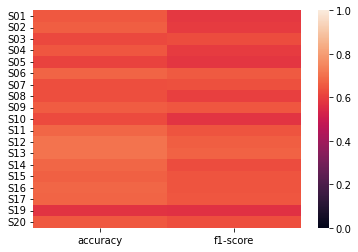

     class0 f1-score  class1 f1-score
S01         0.781250         0.151515
S02         0.786517         0.173913
S03         0.717300         0.417391
S04         0.777027         0.153846
S05         0.741036         0.197531
S06         0.784906         0.329412
S07         0.726531         0.427350
S08         0.755396         0.260870
S09         0.769784         0.346939
S10         0.754325         0.183908
S11         0.792308         0.270270
S12         0.810219         0.333333
S13         0.805861         0.376471
S14         0.795775         0.256410
S15         0.778182         0.329670
S16         0.790036         0.305882
S17         0.785714         0.325000
S19         0.687747         0.313043
S20         0.764045         0.322581


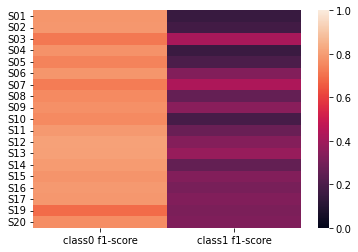

In [13]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
